# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

In [2]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [3]:
# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [6]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [7]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

In [8]:
# Not used
from sklearn.linear_model import LinearRegression

def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    # points_x_print = [point[0] for point in points]
    # print("X points: ", points_x, "Length: ", len(points_x))
    # print("X points: ", points_x_print, "Length: ", len(points_x))
    # print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

##  Pipeline




*Steps:*

    - Read in and grayscale the image
    - Define a kernel size and apply Gaussian smoothing
    - Define our parameters for Canny and apply to get edges image
    - Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
    - Define Hough transform parameters and run Hough transform on masked edge-detected image
    - Draw line segments
    - Draw lines extrapolated from line segments
    - Combine line image with original image to see how accurate the line annotations are.

Slope & intercept:  [[0.5535055350553506, 41.50553505535049], [0.5748299319727891, 33.874149659863974], [0.5774058577405857, 31.3305439330544], [0.5528455284552846, 41.097560975609724]]
Slope:  0.5646467133060025 Intercept:  36.95194740596965
Slope & intercept:  [[-0.8106508875739645, 698.7100591715977], [-0.7555555555555555, 671.5555555555555], [-0.7054263565891473, 653.6744186046512], [-0.7833333333333333, 688.6]]
Slope:  -0.7637415332630001 Intercept:  678.1350083329511
Coef:  0.5646467133060025 Intercept:  36.95194740596965 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.7637415332630001 Intercept:  678.1350083329511 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ...,

       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ...,
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ...,
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ...,
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,  70]]

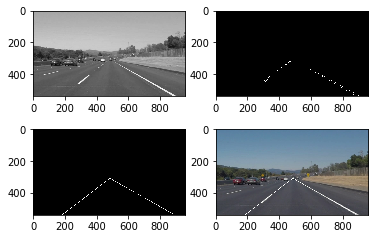

In [10]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image

draw_lane_lines(test_images[0])

## Testing the Pipeline on the test_images

Slope & intercept:  [[0.5535055350553506, 41.50553505535049], [0.5748299319727891, 33.874149659863974], [0.5774058577405857, 31.3305439330544], [0.5528455284552846, 41.097560975609724]]
Slope:  0.5646467133060025 Intercept:  36.95194740596965
Slope & intercept:  [[-0.8106508875739645, 698.7100591715977], [-0.7555555555555555, 671.5555555555555], [-0.7054263565891473, 653.6744186046512], [-0.7833333333333333, 688.6]]
Slope:  -0.7637415332630001 Intercept:  678.1350083329511
Coef:  0.5646467133060025 Intercept:  36.95194740596965 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.7637415332630001 Intercept:  678.1350083329511 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ...,

       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ...,
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ...,
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ...,
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,  70]]

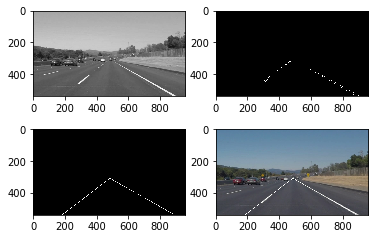

In [11]:
draw_lane_lines(test_images[0])

Slope & intercept:  [[0.6214285714285714, 7.921428571428578], [0.6512455516014235, -4.185053380782904], [0.6507177033492823, -4.545454545454504]]
Slope:  0.6411306087930924 Intercept:  -0.26969311826961
Slope & intercept:  [[-0.6713286713286714, 630.1118881118881], [-0.7222222222222222, 655.8333333333334], [-0.6733333333333333, 631.7333333333333], [-0.6973684210526315, 646.7631578947369]]
Slope:  -0.6910631619842146 Intercept:  641.1104281683229
Coef:  0.6411306087930924 Intercept:  -0.26969311826961 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (960, 615)
Coef:  -0.6910631619842146 Intercept:  641.1104281683229 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (0, 641)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ...,
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ...,
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ...,
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ...,

       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ...,
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ...,
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ...,
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144, 146]]

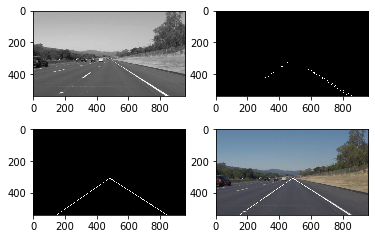

In [12]:
draw_lane_lines(test_images[1])

Slope & intercept:  [[0.6026490066225165, 25.145695364238406], [0.573170731707317, 38.04878048780489], [0.5777027027027027, 32.5101351351351], [0.5560344827586207, 49.504310344827616]]
Slope:  0.5689693057228801 Intercept:  40.021075322589205
Slope & intercept:  [[-0.7263513513513513, 655.2162162162163], [-0.7542372881355932, 671.9491525423729], [-0.7580645161290323, 673.6935483870968], [-0.7241379310344828, 653.1379310344828]]
Slope:  -0.7406977716626149 Intercept:  663.4992120450422
Coef:  0.5689693057228801 Intercept:  40.021075322589205 intersection_x:  476.0584941686938
Point one:  (476, 310) Point two:  (960, 586)
Coef:  -0.7406977716626149 Intercept:  663.4992120450422 intersection_x:  476.0584941686938
Point one:  (476, 310) Point two:  (0, 663)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ...,
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ...,
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ...,
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ...,

       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ...,
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ...,
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ...,
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,  72]]

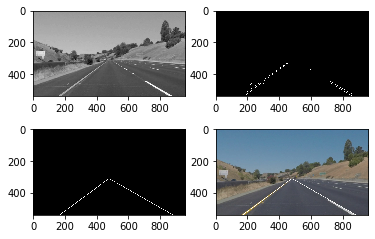

In [13]:
draw_lane_lines(test_images[3])

Slope & intercept:  [[0.6490384615384616, -4.8125], [0.5970873786407767, 22.883495145631116], [0.5786516853932584, 36.915730337078685]]
Slope:  0.6082591751908323 Intercept:  18.3289084942366
Slope & intercept:  [[-0.6743421052631579, 631.0592105263158], [-0.7246963562753036, 653.9676113360324], [-0.6888888888888889, 634.6444444444444], [-0.726027397260274, 653.7123287671233], [-0.6741935483870968, 630.7129032258065]]
Slope:  -0.6976296592149442 Intercept:  640.8192996599444
Coef:  0.6082591751908323 Intercept:  18.3289084942366 intersection_x:  476.6794651774183
Point one:  (476, 308) Point two:  (960, 602)
Coef:  -0.6976296592149442 Intercept:  640.8192996599444 intersection_x:  476.6794651774183
Point one:  (476, 308) Point two:  (0, 640)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ...,
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ...,
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ...,
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ...,

       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ...,
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ...,
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ...,
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146, 153]]

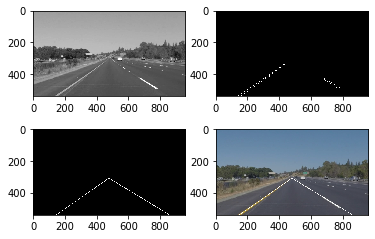

In [14]:
draw_lane_lines(test_images[4])

Slope & intercept:  [[0.5986622073578596, 22.35451505016721], [0.5741444866920152, 32.08745247148289], [0.5782608695652174, 28.39565217391305], [0.6014234875444839, 18.971530249110344]]
Slope:  0.5881227627898941 Intercept:  25.452287486168373
Slope & intercept:  [[-0.7525773195876289, 671.4536082474226], [-0.7813620071684588, 689.584229390681], [-0.748792270531401, 671.1835748792271], [-0.765625, 686.734375], [-0.8, 697.6], [-0.8070175438596491, 696.3684210526316], [-0.8222222222222222, 709.2666666666667], [-0.8333333333333334, 707.0]]
Slope:  -0.7888662120878367 Intercept:  691.1488594045786
Coef:  0.5881227627898941 Intercept:  25.452287486168373 intersection_x:  483.4436470179585
Point one:  (483, 309) Point two:  (960, 590)
Coef:  -0.7888662120878367 Intercept:  691.1488594045786 intersection_x:  483.4436470179585
Point one:  (483, 309) Point two:  (0, 691)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ...,
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ...,

       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ...,
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ...,
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ...,
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,  75]]

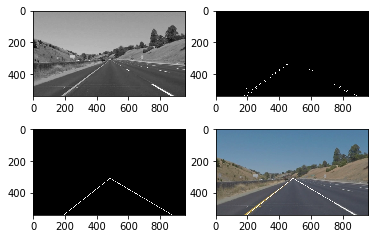

In [15]:
draw_lane_lines(test_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Let's try the one with the solid white lane on the right first ...

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [0.5875, 27.149999999999977]]
Slope:  0.6197824892258337 Intercept:  7.025616943794162
Slope & intercept:  [[-0.752, 665.904], [-0.7019607843137254, 642.9686274509804], [-0.7254098360655737, 649.6516393442623], [-0.7251461988304093, 647.6023391812865], [-0.7068965517241379, 647.7241379310344]]
Slope:  -0.7222826741867692 Intercept:  650.7701487815127
Coef:  0.6197824892258337 Intercept:  7.025616943794162 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (960, 602)
Coef:  -0.7222826741867692 Intercept:  650.7701487815127 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (0, 650)
(540, 960, 3)
Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [0.5875, 27.149999999999977]]
Slope:  0.6197824892258337 Intercept:  7.025616943794162
Slope & intercept:  [[-0.752, 665.904], [-0.7019607843137254, 642.9686274509804], [-0.7254098360655737, 649.6516393442623], [-0.7251461988304093, 647.6023391812865], [-0.7068965517241379, 647.7241379310344]]
Slope:  -0.7222826741867692 Intercept:  650.7701487815127
Coef:  0.6197824892258337 Intercept:  7.025616943794162 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (960, 602)
Coef:  -0.7222826741867692 Intercept:  650.7701487815127 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (0, 650)
(540, 960, 3)


t:   1%|▌                                                                    | 2/221 [00:00<00:23,  9.43it/s, now=None]

Slope & intercept:  [[0.6465116279069767, -8.302325581395337], [0.6022304832713755, 15.263940520446056], [0.6, 21.19999999999999], [0.589041095890411, 26.83561643835617], [0.660377358490566, -16.396226415094304], [0.6029411764705882, 13.823529411764753]]
Slope:  0.6081448767078703 Intercept:  13.764152157834326
Slope & intercept:  [[-0.7535211267605634, 667.0985915492957], [-0.7241379310344828, 646.6206896551724], [-0.7028985507246377, 643.304347826087], [-0.7049180327868853, 641.8688524590164], [-0.7016393442622951, 643.9475409836066]]
Slope:  -0.7174229971137729 Intercept:  648.5680044946357
Coef:  0.6081448767078703 Intercept:  13.764152157834326 intersection_x:  478.89200158921096
Point one:  (478, 304) Point two:  (960, 597)
Coef:  -0.7174229971137729 Intercept:  648.5680044946357 intersection_x:  478.89200158921096
Point one:  (478, 304) Point two:  (0, 648)
(540, 960, 3)


t:   1%|▉                                                                    | 3/221 [00:00<00:39,  5.57it/s, now=None]

Slope & intercept:  [[0.601010101010101, 15.590909090909122], [0.6470588235294118, -8.411764705882376], [0.5925925925925926, 22.444444444444457], [0.6475409836065574, -9.81967213114757], [0.6, 21.600000000000023], [0.589041095890411, 26.246575342465746]]
Slope:  0.6128739327715124 Intercept:  11.275082006798234
Slope & intercept:  [[-0.7535714285714286, 666.1071428571429], [-0.725, 648.475], [-0.7030716723549488, 643.1638225255973], [-0.6952380952380952, 637.6]]
Slope:  -0.7192202990411183 Intercept:  648.8364913456851
Coef:  0.6128739327715124 Intercept:  11.275082006798234 intersection_x:  478.6158472222593
Point one:  (478, 304) Point two:  (960, 599)
Coef:  -0.7192202990411183 Intercept:  648.8364913456851 intersection_x:  478.6158472222593
Point one:  (478, 304) Point two:  (0, 648)
(540, 960, 3)


t:   2%|█▏                                                                   | 4/221 [00:00<00:38,  5.62it/s, now=None]

Slope & intercept:  [[0.6007326007326007, 16.564102564102598], [0.625, 7.0], [0.6233766233766234, 10.0], [0.6140350877192983, 15.31578947368422], [0.5844155844155844, 25.597402597402606]]
Slope:  0.6095119792488213 Intercept:  14.895458927037884
Slope & intercept:  [[-0.7678571428571429, 668.7678571428571], [-0.6875, 639.75], [-0.7209302325581395, 652.7441860465116], [-0.6991869918699187, 640.1382113821138], [-0.6974789915966386, 638.5882352941176]]
Slope:  -0.7145906717763679 Intercept:  647.99769797312
Coef:  0.6095119792488213 Intercept:  14.895458927037884 intersection_x:  478.1368261410106
Point one:  (478, 306) Point two:  (960, 600)
Coef:  -0.7145906717763679 Intercept:  647.99769797312 intersection_x:  478.1368261410106
Point one:  (478, 306) Point two:  (0, 647)
(540, 960, 3)


t:   2%|█▌                                                                   | 5/221 [00:00<00:38,  5.59it/s, now=None]

Slope & intercept:  [[0.6268656716417911, 6.417910447761187], [0.5977859778597786, 17.926199261992622], [0.6, 15.600000000000023], [0.6241610738255033, 6.979865771812115], [0.6254416961130742, 7.0]]
Slope:  0.6148508838880294 Intercept:  10.78479509631319
Slope & intercept:  [[-0.7291666666666666, 656.5], [-0.7280701754385965, 650.2456140350878], [-0.6931818181818182, 638.5454545454545]]
Slope:  -0.7168062200956938 Intercept:  648.4303561935141
Coef:  0.6148508838880294 Intercept:  10.78479509631319 intersection_x:  478.8361502294023
Point one:  (478, 305) Point two:  (960, 601)
Coef:  -0.7168062200956938 Intercept:  648.4303561935141 intersection_x:  478.8361502294023
Point one:  (478, 305) Point two:  (0, 648)
(540, 960, 3)


t:   3%|█▊                                                                   | 6/221 [00:01<00:37,  5.72it/s, now=None]

Slope & intercept:  [[0.6278195488721805, 5.609022556390926], [0.6, 17.0], [0.6, 15.400000000000034], [0.6097560975609756, 15.95121951219511], [0.6103896103896104, 16.58441558441558], [0.6333333333333333, 1.9333333333333371], [0.5909090909090909, 23.68181818181813]]
Slope:  0.6064790579553095 Intercept:  15.70441263913663
Slope & intercept:  [[-0.6993464052287581, 638.6143790849674], [-0.7283950617283951, 655.6913580246913], [-0.7533333333333333, 663.7266666666667]]
Slope:  -0.7270249334301622 Intercept:  652.6774679254419
Coef:  0.6064790579553095 Intercept:  15.70441263913663 intersection_x:  477.6686529633172
Point one:  (477, 305) Point two:  (960, 597)
Coef:  -0.7270249334301622 Intercept:  652.6774679254419 intersection_x:  477.6686529633172
Point one:  (477, 305) Point two:  (0, 652)
(540, 960, 3)


t:   3%|██▏                                                                  | 7/221 [00:01<00:36,  5.79it/s, now=None]

Slope & intercept:  [[0.6259541984732825, 6.206106870229007], [0.6, 14.600000000000023], [0.599250936329588, 16.65168539325839], [0.6086956521739131, 21.217391304347814]]
Slope:  0.6026488628345004 Intercept:  17.489692232535408
Slope & intercept:  [[-0.7243243243243244, 653.2216216216216], [-0.7010869565217391, 640.4782608695652], [-0.7287234042553191, 655.8404255319149], [-0.7215189873417721, 646.7088607594936]]
Slope:  -0.7248555719738051 Intercept:  651.92363597101
Coef:  0.6026488628345004 Intercept:  17.489692232535408 intersection_x:  477.9147452189778
Point one:  (477, 305) Point two:  (960, 596)
Coef:  -0.7248555719738051 Intercept:  651.92363597101 intersection_x:  477.9147452189778
Point one:  (477, 305) Point two:  (0, 651)
(540, 960, 3)


t:   4%|██▍                                                                  | 8/221 [00:01<00:38,  5.52it/s, now=None]

Slope & intercept:  [[0.6227758007117438, 8.017793594306056], [0.6007462686567164, 15.149253731343265], [0.5969387755102041, 18.433673469387713], [0.6122448979591837, 3.5102040816326507]]
Slope:  0.6081764357094621 Intercept:  11.277731219167421
Slope & intercept:  [[-0.6936936936936937, 636.1441441441441], [-0.7232142857142857, 652.8928571428571], [-0.7524271844660194, 663.3155339805826]]
Slope:  -0.7231117212913328 Intercept:  650.7841784225279
Coef:  0.6081764357094621 Intercept:  11.277731219167421 intersection_x:  480.36666129749
Point one:  (480, 303) Point two:  (960, 595)
Coef:  -0.7231117212913328 Intercept:  650.7841784225279 intersection_x:  480.36666129749
Point one:  (480, 303) Point two:  (0, 650)
(540, 960, 3)


t:   4%|██▊                                                                  | 9/221 [00:01<00:37,  5.68it/s, now=None]

Slope & intercept:  [[0.6263345195729537, 6.241992882562272], [0.6, 17.0], [0.5985130111524164, 17.687732342007394], [0.5980861244019139, 17.066985645933016], [0.6078431372549019, 22.54901960784315], [0.6153846153846154, 14.53846153846149]]
Slope:  0.6039653776387696 Intercept:  17.76843982684901
Slope & intercept:  [[-0.7226277372262774, 652.6277372262773], [-0.6984126984126984, 638.5079365079365], [-0.7279411764705882, 655.4852941176471]]
Slope:  -0.7163272040365213 Intercept:  648.8736559506203
Coef:  0.6039653776387696 Intercept:  17.76843982684901 intersection_x:  478.00406128388266
Point one:  (478, 306) Point two:  (960, 597)
Coef:  -0.7163272040365213 Intercept:  648.8736559506203 intersection_x:  478.00406128388266
Point one:  (478, 306) Point two:  (0, 648)
(540, 960, 3)


t:   5%|███                                                                 | 10/221 [00:01<00:37,  5.65it/s, now=None]

Slope & intercept:  [[0.6035714285714285, 16.910714285714334], [0.6270491803278688, 8.77049180327873], [0.5882352941176471, 28.176470588235304], [0.6170212765957447, 14.19148936170211], [0.6111111111111112, 10.611111111111086]]
Slope:  0.6093976581447601 Intercept:  15.732055430008312
Slope & intercept:  [[-0.7534246575342466, 665.2739726027397], [-0.6744186046511628, 631.5348837209302], [-0.6564885496183206, 626.8854961832061], [-0.717391304347826, 646.3260869565217]]
Slope:  -0.700430779037889 Intercept:  642.5051098658494
Coef:  0.6093976581447601 Intercept:  15.732055430008312 intersection_x:  478.51538158996357
Point one:  (478, 307) Point two:  (960, 600)
Coef:  -0.700430779037889 Intercept:  642.5051098658494 intersection_x:  478.51538158996357
Point one:  (478, 307) Point two:  (0, 642)
(540, 960, 3)


t:   5%|███▍                                                                | 11/221 [00:01<00:38,  5.48it/s, now=None]

Slope & intercept:  [[0.602112676056338, 20.18309859154931], [0.6455026455026455, -0.7354497354497198], [0.6439393939393939, -0.9772727272726911], [0.6590909090909091, -11.568181818181813]]
Slope:  0.6376614061473217 Intercept:  1.7255485776612716
Slope & intercept:  [[-0.6772151898734177, 634.9050632911392], [-0.7803030303030303, 675.1439393939394], [-0.6756756756756757, 636.7027027027027], [-0.6994535519125683, 642.4535519125683]]
Slope:  -0.7081618619411729 Intercept:  647.3013143250873
Coef:  0.6376614061473217 Intercept:  1.7255485776612716 intersection_x:  479.68836700553777
Point one:  (479, 307) Point two:  (960, 613)
Coef:  -0.7081618619411729 Intercept:  647.3013143250873 intersection_x:  479.68836700553777
Point one:  (479, 307) Point two:  (0, 647)
(540, 960, 3)


t:   5%|███▋                                                                | 12/221 [00:02<00:38,  5.37it/s, now=None]

Slope & intercept:  [[0.6037735849056604, 20.56603773584908], [0.6470588235294118, -0.41176470588237635], [0.6153846153846154, 12.69230769230768], [0.6205128205128205, 9.548717948717922], [0.649746192893401, -1.5126903553299371], [0.7, -43.099999999999966]]
Slope:  0.6272952074451819 Intercept:  8.176521663132473
Slope & intercept:  [[-0.7013574660633484, 643.0135746606335], [-0.7236842105263158, 658.6842105263158], [-0.7022222222222222, 644.5111111111111], [-0.7268722466960352, 658.7224669603524]]
Slope:  -0.7135340363769804 Intercept:  651.2328408146032
Coef:  0.6272952074451819 Intercept:  8.176521663132473 intersection_x:  479.5959829443882
Point one:  (479, 309) Point two:  (960, 610)
Coef:  -0.7135340363769804 Intercept:  651.2328408146032 intersection_x:  479.5959829443882
Point one:  (479, 309) Point two:  (0, 651)
(540, 960, 3)


t:   6%|████                                                                | 13/221 [00:02<00:39,  5.29it/s, now=None]

Slope & intercept:  [[0.6496062992125984, -2.1220472440944604], [0.6224489795918368, 8.693877551020421], [0.6226415094339622, 7.226415094339643], [0.6346153846153846, 6.269230769230774], [0.6206896551724138, 8.310344827586164], [0.6333333333333333, 6.466666666666697]]
Slope:  0.6267457724293861 Intercept:  7.39330698176874
Slope & intercept:  [[-0.700374531835206, 642.1685393258427], [-0.725925925925926, 657.5555555555555], [-0.7521739130434782, 665.1869565217391]]
Slope:  -0.7261581236015368 Intercept:  654.9703504677125
Coef:  0.6267457724293861 Intercept:  7.39330698176874 intersection_x:  478.657091154642
Point one:  (478, 307) Point two:  (960, 609)
Coef:  -0.7261581236015368 Intercept:  654.9703504677125 intersection_x:  478.657091154642
Point one:  (478, 307) Point two:  (0, 654)
(540, 960, 3)


t:   6%|████▎                                                               | 14/221 [00:02<00:39,  5.23it/s, now=None]

Slope & intercept:  [[0.6490384615384616, -2.649038461538453], [0.6223021582733813, 6.931654676258972], [0.652542372881356, -5.550847457627128], [0.6239316239316239, 6.239316239316224]]
Slope:  0.6369536541562058 Intercept:  1.2427712491024039
Slope & intercept:  [[-0.6993243243243243, 639.4020270270271], [-0.7258687258687259, 655.8996138996139], [-0.7314814814814815, 657.9629629629629]]
Slope:  -0.7188915105581772 Intercept:  651.0882012965347
Coef:  0.6369536541562058 Intercept:  1.2427712491024039 intersection_x:  479.29177088913855
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.7188915105581772 Intercept:  651.0882012965347 intersection_x:  479.29177088913855
Point one:  (479, 306) Point two:  (0, 651)
(540, 960, 3)


t:   7%|████▌                                                               | 15/221 [00:02<00:39,  5.18it/s, now=None]

Slope & intercept:  [[0.6507936507936508, -5.4126984126984325], [0.6244541484716157, 4.445414847161544], [0.6236162361623616, 4.560885608856097], [0.6379310344827587, 1.36206896551721], [0.6513157894736842, -4.848684210526301]]
Slope:  0.6376221718768142 Intercept:  0.021397359662023517
Slope & intercept:  [[-0.697508896797153, 636.3487544483986], [-0.752851711026616, 659.9619771863117], [-0.7540322580645161, 659.9072580645161], [-0.6771653543307087, 634.511811023622], [-0.696969696969697, 640.4545454545455]]
Slope:  -0.7157055834377382 Intercept:  646.2368692354788
Coef:  0.6376221718768142 Intercept:  0.021397359662023517 intersection_x:  477.50108526047165
Point one:  (477, 304) Point two:  (960, 612)
Coef:  -0.7157055834377382 Intercept:  646.2368692354788 intersection_x:  477.50108526047165
Point one:  (477, 304) Point two:  (0, 646)
(540, 960, 3)


t:   7%|████▉                                                               | 16/221 [00:02<00:39,  5.17it/s, now=None]

Slope & intercept:  [[0.6221374045801527, 3.583969465648863], [0.6714285714285714, -21.41428571428571], [0.6727272727272727, -21.472727272727298], [0.64, -8.680000000000007]]
Slope:  0.6515733121839993 Intercept:  -11.995760880341038
Slope & intercept:  [[-0.71875, 651.5625], [-0.6923076923076923, 632.2307692307693], [-0.675, 630.025], [-0.7, 635.6], [-0.75, 655.75], [-0.6990291262135923, 635.3883495145631], [-0.7040816326530612, 643.6428571428571]]
Slope:  -0.7055954930249065 Intercept:  640.5999251268842
Coef:  0.6515733121839993 Intercept:  -11.995760880341038 intersection_x:  480.8507854752619
Point one:  (480, 301) Point two:  (960, 613)
Coef:  -0.7055954930249065 Intercept:  640.5999251268842 intersection_x:  480.8507854752619
Point one:  (480, 301) Point two:  (0, 640)
(540, 960, 3)


t:   8%|█████▏                                                              | 17/221 [00:03<00:39,  5.10it/s, now=None]

Slope & intercept:  [[0.6699029126213593, -21.281553398058293], [0.6264591439688716, 0.8715953307392965], [0.625, 0.5], [0.6724137931034483, -23.81034482758622], [0.6885245901639344, -32.03278688524591]]
Slope:  0.6564600879715228 Intercept:  -15.150617956030226
Slope & intercept:  [[-0.7241379310344828, 649.2068965517242], [-0.7, 634.8], [-0.76, 658.08], [-0.6788321167883211, 631.043795620438], [-0.7, 641.2]]
Slope:  -0.7125940095645609 Intercept:  642.8661384344325
Coef:  0.6564600879715228 Intercept:  -15.150617956030226 intersection_x:  480.6360519826863
Point one:  (480, 300) Point two:  (960, 615)
Coef:  -0.7125940095645609 Intercept:  642.8661384344325 intersection_x:  480.6360519826863
Point one:  (480, 300) Point two:  (0, 642)
(540, 960, 3)


t:   8%|█████▌                                                              | 18/221 [00:03<00:39,  5.09it/s, now=None]

Slope & intercept:  [[0.628099173553719, 0.7190082644627864], [0.6713615023474179, -21.58685446009389], [0.6259541984732825, 1.5572519083968928], [0.6818181818181818, -27.909090909090878], [0.6610169491525424, -13.779661016949149], [0.6818181818181818, -30.68181818181813], [0.6129032258064516, 9.548387096774206]]
Slope:  0.6518530589956824 Intercept:  -11.733253899759736
Slope & intercept:  [[-0.6785714285714286, 628.3571428571429], [-0.7248322147651006, 651.3758389261745]]
Slope:  -0.7017018216682647 Intercept:  639.8664908916587
Coef:  0.6518530589956824 Intercept:  -11.733253899759736 intersection_x:  481.39883657454294
Point one:  (481, 302) Point two:  (960, 614)
Coef:  -0.7017018216682647 Intercept:  639.8664908916587 intersection_x:  481.39883657454294
Point one:  (481, 302) Point two:  (0, 639)
(540, 960, 3)


t:   9%|█████▊                                                              | 19/221 [00:03<00:40,  4.95it/s, now=None]

Slope & intercept:  [[0.6538461538461539, -8.461538461538453], [0.6231343283582089, 4.597014925373173], [0.6701030927835051, -19.865979381443253]]
Slope:  0.6490278583292892 Intercept:  -7.910167639202844
Slope & intercept:  [[-0.7025316455696202, 645.1708860759494], [-0.6545454545454545, 621.8909090909091]]
Slope:  -0.6785385500575374 Intercept:  633.5308975834292
Coef:  0.6490278583292892 Intercept:  -7.910167639202844 intersection_x:  483.1706053801633
Point one:  (483, 305) Point two:  (960, 615)
Coef:  -0.6785385500575374 Intercept:  633.5308975834292 intersection_x:  483.1706053801633
Point one:  (483, 305) Point two:  (0, 633)
(540, 960, 3)


t:   9%|██████▏                                                             | 20/221 [00:03<00:39,  5.07it/s, now=None]

Slope & intercept:  [[0.6227106227106227, 6.205128205128176], [0.6492537313432836, -4.932835820895491], [0.6535947712418301, -6.444444444444457], [0.65234375, -6.0078125]]
Slope:  0.6444757188239341 Intercept:  -2.794991140052943
Slope & intercept:  [[-0.7252252252252253, 654.7027027027027], [-0.6976744186046512, 637.7906976744187]]
Slope:  -0.7114498219149382 Intercept:  646.2467001885607
Coef:  0.6444757188239341 Intercept:  -2.794991140052943 intersection_x:  478.67059940100927
Point one:  (478, 305) Point two:  (960, 615)
Coef:  -0.7114498219149382 Intercept:  646.2467001885607 intersection_x:  478.67059940100927
Point one:  (478, 305) Point two:  (0, 646)
(540, 960, 3)


t:  10%|██████▍                                                             | 21/221 [00:03<00:38,  5.16it/s, now=None]

Slope & intercept:  [[0.6223021582733813, 7.176258992805742], [0.6512455516014235, -4.185053380782904], [0.6507177033492823, -4.545454545454504], [0.625, 5.875]]
Slope:  0.6373163533060218 Intercept:  1.0801877666420836
Slope & intercept:  [[-0.6733333333333333, 631.7333333333333], [-0.723404255319149, 656.3829787234042], [-0.776595744680851, 673.2872340425531], [-0.7, 644.8]]
Slope:  -0.7183333333333333 Intercept:  651.5508865248227
Coef:  0.6373163533060218 Intercept:  1.0801877666420836 intersection_x:  479.82211420023435
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.7183333333333333 Intercept:  651.5508865248227 intersection_x:  479.82211420023435
Point one:  (479, 306) Point two:  (0, 651)
(540, 960, 3)


t:  10%|██████▊                                                             | 22/221 [00:04<00:38,  5.18it/s, now=None]

Slope & intercept:  [[0.6245487364620939, 5.63537906137185], [0.6491228070175439, -2.719298245614027], [0.6495726495726496, -3.9145299145299077], [0.6231884057971014, 6.9130434782608745], [0.64, 4.439999999999998]]
Slope:  0.6372865197698778 Intercept:  2.0709188758977577
Slope & intercept:  [[-0.6756756756756757, 631.7567567567568], [-0.725609756097561, 656.6829268292684], [-0.6744186046511628, 632.5813953488372]]
Slope:  -0.6919013454747999 Intercept:  640.3403596449542
Coef:  0.6372865197698778 Intercept:  2.0709188758977577 intersection_x:  480.1950555360836
Point one:  (480, 308) Point two:  (960, 613)
Coef:  -0.6919013454747999 Intercept:  640.3403596449542 intersection_x:  480.1950555360836
Point one:  (480, 308) Point two:  (0, 640)
(540, 960, 3)


t:  10%|███████                                                             | 23/221 [00:04<00:38,  5.16it/s, now=None]

Slope & intercept:  [[0.6245487364620939, 5.63537906137185], [0.6498194945848376, -3.4007220216606697], [0.6690140845070423, -16.7042253521127], [0.6379310344827587, 6.120689655172384]]
Slope:  0.6453283375091831 Intercept:  -2.087219664307284
Slope & intercept:  [[-0.723404255319149, 655.6595744680851], [-0.6770833333333334, 633.75], [-0.7272727272727273, 652.6363636363636]]
Slope:  -0.7092534386417366 Intercept:  647.3486460348163
Coef:  0.6453283375091831 Intercept:  -2.087219664307284 intersection_x:  479.4364409246026
Point one:  (479, 307) Point two:  (960, 617)
Coef:  -0.7092534386417366 Intercept:  647.3486460348163 intersection_x:  479.4364409246026
Point one:  (479, 307) Point two:  (0, 647)
(540, 960, 3)


t:  11%|███████▍                                                            | 24/221 [00:04<00:38,  5.16it/s, now=None]

Slope & intercept:  [[0.6254545454545455, 4.861818181818137], [0.6666666666666666, -16.333333333333314], [0.65, -4.75], [0.6538461538461539, -6.653846153846132], [0.6119402985074627, 12.223880597014954]]
Slope:  0.6415815328949657 Intercept:  -2.130296141669271
Slope & intercept:  [[-0.7014218009478673, 640.7298578199052], [-0.751269035532995, 663.0609137055837], [-0.7531645569620253, 664.9113924050632], [-0.7111111111111111, 642.2], [-0.7255813953488373, 655.3162790697675], [-0.7209302325581395, 644.2558139534883]]
Slope:  -0.7272463554101627 Intercept:  651.7457094923012
Coef:  0.6415815328949657 Intercept:  -2.130296141669271 intersection_x:  477.6904468563937
Point one:  (477, 304) Point two:  (960, 613)
Coef:  -0.7272463554101627 Intercept:  651.7457094923012 intersection_x:  477.6904468563937
Point one:  (477, 304) Point two:  (0, 651)
(540, 960, 3)


t:  11%|███████▋                                                            | 25/221 [00:04<00:37,  5.17it/s, now=None]

Slope & intercept:  [[0.6236162361623616, 4.808118081180794], [0.6704545454545454, -18.943181818181813], [0.660377358490566, -11.471698113207538], [0.6363636363636364, 7.272727272727309], [0.6240601503759399, 4.0526315789473415], [0.6548672566371682, -8.893805309734546]]
Slope:  0.6449565305807029 Intercept:  -3.862534718044742
Slope & intercept:  [[-0.6753731343283582, 632.6194029850747], [-0.7058823529411765, 651.1764705882354], [-0.7522123893805309, 662.2035398230089], [-0.6720647773279352, 632.6761133603239], [-0.654054054054054, 626.3567567567568], [-0.7768595041322314, 669.7520661157025]]
Slope:  -0.7060743686940477 Intercept:  645.7973916048503
Coef:  0.6449565305807029 Intercept:  -3.862534718044742 intersection_x:  480.8623745553415
Point one:  (480, 306) Point two:  (960, 615)
Coef:  -0.7060743686940477 Intercept:  645.7973916048503 intersection_x:  480.8623745553415
Point one:  (480, 306) Point two:  (0, 645)
(540, 960, 3)


t:  12%|████████                                                            | 26/221 [00:05<00:43,  4.53it/s, now=None]

Slope & intercept:  [[0.6245353159851301, 4.271375464684013], [0.6496815286624203, -5.171974522292999], [0.65625, -7.65625], [0.6534653465346535, -6.336633663366342], [0.6379310344827587, 3.931034482758605]]
Slope:  0.6443726451329926 Intercept:  -2.1924896476433444
Slope & intercept:  [[-0.6765676567656765, 633.3960396039604], [-0.7296296296296296, 657.9296296296296], [-0.726962457337884, 655.4948805460751], [-0.7288135593220338, 656.7966101694915], [-0.696969696969697, 639.1515151515151]]
Slope:  -0.7205938358148112 Intercept:  652.3431588741778
Coef:  0.6443726451329926 Intercept:  -2.1924896476433444 intersection_x:  479.52507087743686
Point one:  (479, 306) Point two:  (960, 616)
Coef:  -0.7205938358148112 Intercept:  652.3431588741778 intersection_x:  479.52507087743686
Point one:  (479, 306) Point two:  (0, 652)
(540, 960, 3)


t:  12%|████████▎                                                           | 27/221 [00:05<00:41,  4.70it/s, now=None]

Slope & intercept:  [[0.6236162361623616, 5.431734317343171], [0.6507936507936508, -4.888888888888914], [0.6530612244897959, -5.999999999999943], [0.6245353159851301, 4.022304832713758], [0.6379310344827587, 1.8103448275861638]]
Slope:  0.6379874923827394 Intercept:  0.075099017750847
Slope & intercept:  [[-0.726775956284153, 658.1912568306011], [-0.6747404844290658, 634.8131487889274], [-0.6742081447963801, 632.1357466063348], [-0.6516129032258065, 629.1096774193549], [-0.75, 661.0]]
Slope:  -0.695467497747081 Intercept:  643.0499659290437
Coef:  0.6379874923827394 Intercept:  0.075099017750847 intersection_x:  482.18715417510646
Point one:  (482, 307) Point two:  (960, 612)
Coef:  -0.695467497747081 Intercept:  643.0499659290437 intersection_x:  482.18715417510646
Point one:  (482, 307) Point two:  (0, 643)
(540, 960, 3)


t:  13%|████████▌                                                           | 28/221 [00:05<00:40,  4.72it/s, now=None]

Slope & intercept:  [[0.6223021582733813, 6.931654676258972], [0.6502732240437158, -5.202185792349724], [0.6346153846153846, 8.730769230769283], [0.6346153846153846, -4.596153846153811], [0.6363636363636364, 5.636363636363626], [0.6388888888888888, -6.055555555555543], [0.6818181818181818, -29.0], [0.6363636363636364, -3.181818181818187]]
Slope:  0.6362031875948612 Intercept:  0.32329630964494527
Slope & intercept:  [[-0.75, 661.25], [-0.7213114754098361, 657.016393442623], [-0.676056338028169, 635.0], [-0.6764705882352942, 633.1764705882354], [-0.75, 665.5]]
Slope:  -0.7147676803346599 Intercept:  650.3885728061716
Coef:  0.6362031875948612 Intercept:  0.32329630964494527 intersection_x:  481.1837856228592
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.7147676803346599 Intercept:  650.3885728061716 intersection_x:  481.1837856228592
Point one:  (481, 306) Point two:  (0, 650)
(540, 960, 3)


t:  13%|████████▉                                                           | 29/221 [00:05<00:39,  4.81it/s, now=None]

Slope & intercept:  [[0.6231343283582089, 5.220149253731336], [0.648936170212766, -3.563829787234056], [0.6619718309859155, -12.422535211267586], [0.6527777777777778, -5.763888888888914], [0.6363636363636364, -2.363636363636374]]
Slope:  0.6446367487396609 Intercept:  -3.7787481994591188
Slope & intercept:  [[-0.673202614379085, 631.6732026143791], [-0.7265625, 656.140625], [-0.7014925373134329, 641.3582089552239]]
Slope:  -0.7004192172308393 Intercept:  643.057345523201
Coef:  0.6446367487396609 Intercept:  -3.7787481994591188 intersection_x:  480.8990183958237
Point one:  (480, 306) Point two:  (960, 615)
Coef:  -0.7004192172308393 Intercept:  643.057345523201 intersection_x:  480.8990183958237
Point one:  (480, 306) Point two:  (0, 643)
(540, 960, 3)


t:  14%|█████████▏                                                          | 30/221 [00:05<00:38,  4.94it/s, now=None]

Slope & intercept:  [[0.65, -4.75], [0.6213235294117647, 6.147058823529392], [0.6341463414634146, 4.292682926829286], [0.6379310344827587, 2.5517241379309894]]
Slope:  0.6358502263394845 Intercept:  2.060366472072417
Slope & intercept:  [[-0.7239263803680982, 654.5582822085889], [-0.6993464052287581, 639.0130718954248], [-0.6785714285714286, 634.3928571428571]]
Slope:  -0.7006147380560949 Intercept:  642.6547370822902
Coef:  0.6358502263394845 Intercept:  2.060366472072417 intersection_x:  479.31998793543283
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.7006147380560949 Intercept:  642.6547370822902 intersection_x:  479.31998793543283
Point one:  (479, 306) Point two:  (0, 642)
(540, 960, 3)


t:  14%|█████████▌                                                          | 31/221 [00:06<00:38,  4.93it/s, now=None]

Slope & intercept:  [[0.6504065040650406, -5.878048780487802], [0.6236162361623616, 4.560885608856097], [0.6351351351351351, 6.82432432432438], [0.625, 15.5]]
Slope:  0.6279171237658322 Intercept:  8.961736644393492
Slope & intercept:  [[-0.7243243243243244, 653.8432432432433], [-0.7, 639.3]]
Slope:  -0.7121621621621621 Intercept:  646.5716216216216
Coef:  0.6279171237658322 Intercept:  8.961736644393492 intersection_x:  475.8001199426706
Point one:  (475, 307) Point two:  (960, 611)
Coef:  -0.7121621621621621 Intercept:  646.5716216216216 intersection_x:  475.8001199426706
Point one:  (475, 307) Point two:  (0, 646)
(540, 960, 3)


t:  14%|█████████▊                                                          | 32/221 [00:06<00:39,  4.78it/s, now=None]

Slope & intercept:  [[0.6528925619834711, -6.81818181818187], [0.6231343283582089, 4.350746268656735], [0.6666666666666666, -17.333333333333314], [0.6235294117647059, 4.858823529411779], [0.6341463414634146, 4.243902439024396], [0.6474820143884892, -3.9424460431654325]]
Slope:  0.636236931591658 Intercept:  0.5385688751491216
Slope & intercept:  [[-0.728110599078341, 655.5622119815669], [-0.7013574660633484, 639.89592760181]]
Slope:  -0.7147340325708447 Intercept:  647.7290697916884
Coef:  0.636236931591658 Intercept:  0.5385688751491216 intersection_x:  479.05581843333493
Point one:  (479, 305) Point two:  (960, 611)
Coef:  -0.7147340325708447 Intercept:  647.7290697916884 intersection_x:  479.05581843333493
Point one:  (479, 305) Point two:  (0, 647)
(540, 960, 3)


t:  15%|██████████▏                                                         | 33/221 [00:06<00:38,  4.89it/s, now=None]

Slope & intercept:  [[0.6213235294117647, 5.904411764705856], [0.6509090909090909, -6.159999999999968], [0.6502242152466368, -6.72645739910314], [0.6417910447761194, -12.014925373134304], [0.6346153846153846, -4.903846153846132]]
Slope:  0.6397726529917993 Intercept:  -4.780163432275538
Slope & intercept:  [[-0.7007874015748031, 639.9448818897638], [-0.7286821705426356, 655.4496124031008]]
Slope:  -0.7147347860587194 Intercept:  647.6972471464323
Coef:  0.6397726529917993 Intercept:  -4.780163432275538 intersection_x:  481.7082518469451
Point one:  (481, 303) Point two:  (960, 609)
Coef:  -0.7147347860587194 Intercept:  647.6972471464323 intersection_x:  481.7082518469451
Point one:  (481, 303) Point two:  (0, 647)
(540, 960, 3)


t:  15%|██████████▍                                                         | 34/221 [00:06<00:37,  5.01it/s, now=None]

Slope & intercept:  [[0.6487455197132617, -4.351254480286741], [0.6066666666666667, 16.326666666666654], [0.6222222222222222, 5.133333333333326], [0.6228813559322034, 5.2372881355931895]]
Slope:  0.6172567482736975 Intercept:  8.899096045197723
Slope & intercept:  [[-0.696551724137931, 638.3931034482758], [-0.7289719626168224, 656.8785046728972], [-0.7304347826086957, 656.8608695652174]]
Slope:  -0.7186528231211496 Intercept:  650.7108258954635
Coef:  0.6172567482736975 Intercept:  8.899096045197723 intersection_x:  480.43051984434743
Point one:  (480, 305) Point two:  (960, 601)
Coef:  -0.7186528231211496 Intercept:  650.7108258954635 intersection_x:  480.43051984434743
Point one:  (480, 305) Point two:  (0, 650)
(540, 960, 3)


t:  16%|██████████▊                                                         | 35/221 [00:06<00:36,  5.03it/s, now=None]

Slope & intercept:  [[0.6214285714285714, 7.678571428571445], [0.65, -4.449999999999989], [0.65234375, -5.0546875], [0.64, -8.360000000000014], [0.6376811594202898, -5.695652173913004]]
Slope:  0.6402906961697722 Intercept:  -3.176353649068312
Slope & intercept:  [[-0.6971428571428572, 639.5314285714286], [-0.7515151515151515, 664.6727272727272], [-0.7484276729559748, 660.8176100628931], [-0.7277777777777777, 656.5944444444444]]
Slope:  -0.7425735340829681 Intercept:  660.6949272600216
Coef:  0.6402906961697722 Intercept:  -3.176353649068312 intersection_x:  480.0697468237767
Point one:  (480, 304) Point two:  (960, 611)
Coef:  -0.7425735340829681 Intercept:  660.6949272600216 intersection_x:  480.0697468237767
Point one:  (480, 304) Point two:  (0, 660)
(540, 960, 3)


t:  16%|███████████                                                         | 36/221 [00:06<00:35,  5.15it/s, now=None]

Slope & intercept:  [[0.6218181818181818, 6.9672727272727], [0.6517857142857143, -3.9375], [0.6235955056179775, 7.056179775280896], [0.6524822695035462, -5.517730496453908]]
Slope:  0.6374204178063549 Intercept:  1.142055501524922
Slope & intercept:  [[-0.728110599078341, 657.8433179723502], [-0.675, 633.625], [-0.6746987951807228, 632.3614457831325], [-0.6778846153846154, 634.1826923076924]]
Slope:  -0.6889235024109198 Intercept:  639.5031140157937
Coef:  0.6374204178063549 Intercept:  1.142055501524922 intersection_x:  481.29376459892524
Point one:  (481, 307) Point two:  (960, 613)
Coef:  -0.6889235024109198 Intercept:  639.5031140157937 intersection_x:  481.29376459892524
Point one:  (481, 307) Point two:  (0, 639)
(540, 960, 3)


t:  17%|███████████▍                                                        | 37/221 [00:07<00:36,  5.11it/s, now=None]

Slope & intercept:  [[0.6510791366906474, -4.348920863309331], [0.6219512195121951, 7.231707317073187], [0.624390243902439, 6.600000000000023], [0.6222222222222222, 7.46666666666664], [0.6694915254237288, -15.22881355932202], [0.6351351351351351, 8.608108108108127]]
Slope:  0.6309555914925278 Intercept:  5.111512245707729
Slope & intercept:  [[-0.7007874015748031, 641.8503937007874], [-0.7269230769230769, 657.2923076923076], [-0.7524271844660194, 665.5825242718447], [-0.701195219123506, 640.6294820717131], [-0.7045454545454546, 653.4318181818182]]
Slope:  -0.717175667326572 Intercept:  651.7573051836941
Coef:  0.6309555914925278 Intercept:  5.111512245707729 intersection_x:  479.66085550484013
Point one:  (479, 307) Point two:  (960, 610)
Coef:  -0.717175667326572 Intercept:  651.7573051836941 intersection_x:  479.66085550484013
Point one:  (479, 307) Point two:  (0, 651)
(540, 960, 3)


t:  17%|███████████▋                                                        | 38/221 [00:07<00:36,  5.03it/s, now=None]

Slope & intercept:  [[0.6511627906976745, -4.418604651162809], [0.6236559139784946, 6.397849462365571], [0.6244897959183674, 6.167346938775495], [0.6511627906976745, -5.395348837209326], [0.6548672566371682, -7.106194690265511]]
Slope:  0.6410677095858758 Intercept:  -0.8709903554993161
Slope & intercept:  [[-0.697986577181208, 640.6040268456376], [-0.728744939271255, 658.1376518218624], [-0.7518248175182481, 664.5547445255474], [-0.7003367003367004, 640.2491582491582], [-0.725609756097561, 654.7012195121952]]
Slope:  -0.7209005580809945 Intercept:  651.6493601908802
Coef:  0.6410677095858758 Intercept:  -0.8709903554993161 intersection_x:  479.10099378760435
Point one:  (479, 306) Point two:  (960, 614)
Coef:  -0.7209005580809945 Intercept:  651.6493601908802 intersection_x:  479.10099378760435
Point one:  (479, 306) Point two:  (0, 651)
(540, 960, 3)


t:  18%|████████████                                                        | 39/221 [00:07<00:36,  5.05it/s, now=None]

Slope & intercept:  [[0.6227106227106227, 6.205128205128176], [0.6519823788546255, -5.101321585903065], [0.6564885496183206, -8.664122137404547], [0.6376811594202898, -3.42028985507244]]
Slope:  0.6422156776509647 Intercept:  -2.745151343312969
Slope & intercept:  [[-0.7517985611510791, 663.7985611510792], [-0.7016949152542373, 640.7457627118645], [-0.7524752475247525, 665.09900990099], [-0.7007575757575758, 641.1136363636364], [-0.7303921568627451, 658.4264705882352]]
Slope:  -0.727423691310078 Intercept:  653.836688143161
Coef:  0.6422156776509647 Intercept:  -2.745151343312969 intersection_x:  479.3830072105276
Point one:  (479, 305) Point two:  (960, 613)
Coef:  -0.727423691310078 Intercept:  653.836688143161 intersection_x:  479.3830072105276
Point one:  (479, 305) Point two:  (0, 653)
(540, 960, 3)


t:  18%|████████████▎                                                       | 40/221 [00:07<00:36,  4.99it/s, now=None]

Slope & intercept:  [[0.6264150943396226, 4.04150943396229], [0.6701570680628273, -17.628272251308942], [0.6222222222222222, 19.066666666666663], [0.6818181818181818, -27.909090909090878], [0.6236162361623616, 4.808118081180794], [0.6523605150214592, -6.111587982832589]]
Slope:  0.6389542271616986 Intercept:  0.8352867895336431
Slope & intercept:  [[-0.6712328767123288, 633.3150684931506], [-0.71875, 655.875], [-0.6974789915966386, 638.9831932773109], [-0.6710526315789473, 634.9605263157895], [-0.7256637168141593, 654.4513274336283]]
Slope:  -0.6968356433404148 Intercept:  643.5170231039758
Coef:  0.6389542271616986 Intercept:  0.8352867895336431 intersection_x:  481.1248763795933
Point one:  (481, 308) Point two:  (960, 614)
Coef:  -0.6968356433404148 Intercept:  643.5170231039758 intersection_x:  481.1248763795933
Point one:  (481, 308) Point two:  (0, 643)
(540, 960, 3)


t:  19%|████████████▌                                                       | 41/221 [00:07<00:34,  5.18it/s, now=None]

Slope & intercept:  [[0.6268656716417911, 3.0298507462686644], [0.6556291390728477, -8.95364238410599], [0.6502732240437158, -4.327868852459005]]
Slope:  0.6442560115861182 Intercept:  -3.4172201634321104
Slope & intercept:  [[-0.6962962962962963, 638.4592592592593], [-0.675, 635.25], [-0.7570093457943925, 661.9719626168225]]
Slope:  -0.7094352140302297 Intercept:  645.227073958694
Coef:  0.6442560115861182 Intercept:  -3.4172201634321104 intersection_x:  479.1670964896685
Point one:  (479, 305) Point two:  (960, 615)
Coef:  -0.7094352140302297 Intercept:  645.227073958694 intersection_x:  479.1670964896685
Point one:  (479, 305) Point two:  (0, 645)
(540, 960, 3)


t:  19%|████████████▉                                                       | 42/221 [00:08<00:33,  5.27it/s, now=None]

Slope & intercept:  [[0.625, 4.25], [0.6687116564417178, -17.15337423312883], [0.6851851851851852, -29.574074074074133], [0.6363636363636364, 7.636363636363626], [0.6129032258064516, 11.709677419354819], [0.6875, -32.6875], [0.703125, -42.03125]]
Slope:  0.6598269576852844 Intercept:  -13.978593893069217
Slope & intercept:  [[-0.6704545454545454, 627.6704545454545], [-0.782051282051282, 675.8846153846154]]
Slope:  -0.7262529137529137 Intercept:  651.7775349650349
Coef:  0.6598269576852844 Intercept:  -13.978593893069217 intersection_x:  480.3158480090435
Point one:  (480, 302) Point two:  (960, 619)
Coef:  -0.7262529137529137 Intercept:  651.7775349650349 intersection_x:  480.3158480090435
Point one:  (480, 302) Point two:  (0, 651)
(540, 960, 3)


t:  19%|█████████████▏                                                      | 43/221 [00:08<00:34,  5.12it/s, now=None]

Slope & intercept:  [[0.6254681647940075, 3.4756554307116403], [0.671957671957672, -18.984126984126988], [0.6244897959183674, 4.685714285714255], [0.6349206349206349, 8.539682539682588], [0.6710526315789473, -19.15789473684208]]
Slope:  0.6455777798339258 Intercept:  -4.288193892972117
Slope & intercept:  [[-0.7267080745341615, 648.2173913043479], [-0.75, 662.75]]
Slope:  -0.7383540372670807 Intercept:  655.483695652174
Coef:  0.6455777798339258 Intercept:  -4.288193892972117 intersection_x:  476.7372795339039
Point one:  (476, 303) Point two:  (960, 615)
Coef:  -0.7383540372670807 Intercept:  655.483695652174 intersection_x:  476.7372795339039
Point one:  (476, 303) Point two:  (0, 655)
(540, 960, 3)


t:  20%|█████████████▌                                                      | 44/221 [00:08<00:34,  5.08it/s, now=None]

Slope & intercept:  [[0.6245059288537549, 4.047430830039559], [0.6728110599078341, -20.156682027649765], [0.625, 3.25], [0.66, -10.779999999999973]]
Slope:  0.6455792471903973 Intercept:  -5.909812799402545
Slope & intercept:  [[-0.700507614213198, 637.5126903553299], [-0.7525252525252525, 662.3585858585859]]
Slope:  -0.7265164333692252 Intercept:  649.9356381069579
Coef:  0.6455792471903973 Intercept:  -5.909812799402545 intersection_x:  477.98813173062933
Point one:  (477, 302) Point two:  (960, 613)
Coef:  -0.7265164333692252 Intercept:  649.9356381069579 intersection_x:  477.98813173062933
Point one:  (477, 302) Point two:  (0, 649)
(540, 960, 3)


t:  20%|█████████████▊                                                      | 45/221 [00:08<00:35,  4.94it/s, now=None]

Slope & intercept:  [[0.6702127659574468, -18.946808510638334], [0.6259842519685039, 3.4094488188976584], [0.6931818181818182, -32.50000000000006], [0.6885245901639344, -31.459016393442596], [0.7217391304347827, -53.38260869565221], [0.6140350877192983, 14.035087719298247]]
Slope:  0.6689462740709641 Intercept:  -19.807316176922882
Slope & intercept:  [[-0.7567567567567568, 663.6756756756756], [-0.7227722772277227, 645.950495049505], [-0.7553191489361702, 663.968085106383], [-0.7, 637.1]]
Slope:  -0.7337120457301625 Intercept:  652.6735639578909
Coef:  0.6689462740709641 Intercept:  -19.807316176922882 intersection_x:  479.43313823580377
Point one:  (479, 300) Point two:  (960, 622)
Coef:  -0.7337120457301625 Intercept:  652.6735639578909 intersection_x:  479.43313823580377
Point one:  (479, 300) Point two:  (0, 652)
(540, 960, 3)


t:  21%|██████████████▏                                                     | 46/221 [00:08<00:35,  4.93it/s, now=None]

Slope & intercept:  [[0.6285714285714286, 2.1999999999999886], [0.67, -17.879999999999995], [0.6818181818181818, -28.272727272727252], [0.6119402985074627, 12.208955223880594], [0.6904761904761905, -34.54761904761904], [0.6129032258064516, 12.903225806451587], [0.7209302325581395, -55.441860465116235], [0.6923076923076923, -35.07692307692304]]
Slope:  0.655431002498201 Intercept:  -12.637869766705307
Slope & intercept:  [[-0.7575757575757576, 664.3030303030303], [-0.6962962962962963, 636.4074074074074]]
Slope:  -0.726936026936027 Intercept:  650.3552188552188
Coef:  0.655431002498201 Intercept:  -12.637869766705307 intersection_x:  479.6071336374917
Point one:  (479, 301) Point two:  (960, 616)
Coef:  -0.726936026936027 Intercept:  650.3552188552188 intersection_x:  479.6071336374917
Point one:  (479, 301) Point two:  (0, 650)
(540, 960, 3)


t:  21%|██████████████▍                                                     | 47/221 [00:09<00:34,  4.98it/s, now=None]

Slope & intercept:  [[0.6707317073170732, -18.634146341463463], [0.6269230769230769, 1.9807692307692264], [0.6875, -32.375], [0.6909090909090909, -35.83636363636367], [0.7214285714285714, -56.62857142857143], [0.6140350877192983, 12.508771929824547], [0.6731707317073171, -20.70731707317077]]
Slope:  0.6605449490959762 Intercept:  -15.510547648400689
Slope & intercept:  [[-0.6981132075471698, 637.4905660377358], [-0.78125, 668.75], [-0.7516339869281046, 661.9607843137255], [-0.7299270072992701, 647.0802919708029]]
Slope:  -0.7402310504436361 Intercept:  653.8204105805661
Coef:  0.6605449490959762 Intercept:  -15.510547648400689 intersection_x:  477.828688133544
Point one:  (477, 300) Point two:  (960, 618)
Coef:  -0.7402310504436361 Intercept:  653.8204105805661 intersection_x:  477.828688133544
Point one:  (477, 300) Point two:  (0, 653)
(540, 960, 3)


t:  22%|██████████████▊                                                     | 48/221 [00:09<00:35,  4.87it/s, now=None]

Slope & intercept:  [[0.6255506607929515, 3.779735682819421], [0.6730038022813688, -20.266159695817464], [0.6904761904761905, -35.33333333333337], [0.6153846153846154, 9.615384615384585]]
Slope:  0.6511038172337815 Intercept:  -10.551093182736707
Slope & intercept:  [[-0.7005347593582888, 637.1283422459893], [-0.751412429378531, 659.8531073446327], [-0.7796610169491526, 670.3220338983051], [-0.7527472527472527, 661.6923076923076]]
Slope:  -0.761273566358312 Intercept:  663.9558163117484
Coef:  0.6511038172337815 Intercept:  -10.551093182736707 intersection_x:  477.56847237175
Point one:  (477, 300) Point two:  (960, 614)
Coef:  -0.761273566358312 Intercept:  663.9558163117484 intersection_x:  477.56847237175
Point one:  (477, 300) Point two:  (0, 663)
(540, 960, 3)


t:  22%|███████████████                                                     | 49/221 [00:09<00:35,  4.87it/s, now=None]

Slope & intercept:  [[0.6719367588932806, -19.316205533596815], [0.6243386243386243, 5.439153439153472], [0.6938775510204082, -37.53061224489795], [0.6428571428571429, -6.714285714285722], [0.672316384180791, -18.84180790960454], [0.6459627329192547, -10.32919254658384]]
Slope:  0.6514823286378186 Intercept:  -9.95246765298349
Slope & intercept:  [[-0.7008547008547008, 638.7692307692307], [-0.7534246575342466, 660.2191780821918], [-0.7211538461538461, 652.7211538461538], [-0.6784140969162996, 631.8942731277533]]
Slope:  -0.7134618253647733 Intercept:  645.9009589563324
Coef:  0.6514823286378186 Intercept:  -9.95246765298349 intersection_x:  480.4983593549062
Point one:  (480, 303) Point two:  (960, 615)
Coef:  -0.7134618253647733 Intercept:  645.9009589563324 intersection_x:  480.4983593549062
Point one:  (480, 303) Point two:  (0, 645)
(540, 960, 3)


t:  23%|███████████████▍                                                    | 50/221 [00:09<00:34,  4.93it/s, now=None]

Slope & intercept:  [[0.6261682242990654, 3.878504672897236], [0.6742424242424242, -20.621212121212125], [0.6730769230769231, -19.269230769230774], [0.6111111111111112, 12.111111111111086], [0.6428571428571429, -7.0], [0.6451612903225806, -9.51612903225805]]
Slope:  0.6454361859848746 Intercept:  -6.736159356448771
Slope & intercept:  [[-0.7013888888888888, 637.8958333333334], [-0.7520325203252033, 660.3739837398374], [-0.7547169811320755, 659.5094339622642], [-0.6739130434782609, 628.8913043478261], [-0.676923076923077, 631.5538461538462]]
Slope:  -0.7117949021495011 Intercept:  643.6448803074215
Coef:  0.6454361859848746 Intercept:  -6.736159356448771 intersection_x:  479.196980786722
Point one:  (479, 302) Point two:  (960, 612)
Coef:  -0.7117949021495011 Intercept:  643.6448803074215 intersection_x:  479.196980786722
Point one:  (479, 302) Point two:  (0, 643)
(540, 960, 3)


t:  23%|███████████████▋                                                    | 51/221 [00:10<00:34,  4.96it/s, now=None]

Slope & intercept:  [[0.6268656716417911, 3.283582089552226], [0.6711111111111111, -19.693333333333328], [0.65625, -9.1875], [0.6065573770491803, 14.770491803278674], [0.5816326530612245, 32.122448979591866], [0.691358024691358, -32.54320987654319], [0.6730038022813688, -20.266159695817464]]
Slope:  0.6438255199765762 Intercept:  -4.501954290467316
Slope & intercept:  [[-0.7285714285714285, 653.7571428571429], [-0.6993006993006993, 636.2027972027972], [-0.7520661157024794, 659.8842975206612], [-0.7509578544061303, 658.1532567049809]]
Slope:  -0.7438651328933461 Intercept:  657.2648990275949
Coef:  0.6438255199765762 Intercept:  -4.501954290467316 intersection_x:  476.88355610772726
Point one:  (476, 302) Point two:  (960, 613)
Coef:  -0.7438651328933461 Intercept:  657.2648990275949 intersection_x:  476.88355610772726
Point one:  (476, 302) Point two:  (0, 657)
(540, 960, 3)


t:  24%|████████████████                                                    | 52/221 [00:10<00:34,  4.96it/s, now=None]

Slope & intercept:  [[0.6743295019157088, -21.367816091954012], [0.628, 2.315999999999974], [0.6119402985074627, 11.835820895522374], [0.6181818181818182, 7.03636363636366]]
Slope:  0.619374038896427 Intercept:  7.0627281772953365
Slope & intercept:  [[-0.7037037037037037, 635.4074074074074], [-0.7272727272727273, 652.1818181818182], [-0.7276785714285714, 651.4508928571429], [-0.7262569832402235, 645.1340782122905], [-0.7537878787878788, 658.0984848484849]]
Slope:  -0.7337490401823503 Intercept:  651.7163185249342
Coef:  0.619374038896427 Intercept:  7.0627281772953365 intersection_x:  476.4190340959426
Point one:  (476, 302) Point two:  (960, 601)
Coef:  -0.7337490401823503 Intercept:  651.7163185249342 intersection_x:  476.4190340959426
Point one:  (476, 302) Point two:  (0, 651)
(540, 960, 3)


t:  24%|████████████████▎                                                   | 53/221 [00:10<00:33,  4.95it/s, now=None]

Slope & intercept:  [[0.6744186046511628, -21.441860465116292], [0.627906976744186, 2.395348837209326], [0.6103896103896104, 12.48051948051949], [0.6909090909090909, -30.818181818181813], [0.6140350877192983, 14.298245614035068]]
Slope:  0.6435318740826698 Intercept:  -4.617185670306844
Slope & intercept:  [[-0.6691176470588235, 627.75], [-0.7526881720430108, 655.5806451612904], [-0.7256637168141593, 649.4070796460177], [-0.7526881720430108, 656.3333333333334], [-0.6964285714285714, 633.7142857142857], [-0.6764705882352942, 629.3235294117648], [-0.8, 677.2]]
Slope:  -0.72472240966041 Intercept:  647.0441247523846
Coef:  0.6435318740826698 Intercept:  -4.617185670306844 intersection_x:  476.27207761408727
Point one:  (476, 301) Point two:  (960, 613)
Coef:  -0.72472240966041 Intercept:  647.0441247523846 intersection_x:  476.27207761408727
Point one:  (476, 301) Point two:  (0, 647)
(540, 960, 3)


t:  24%|████████████████▌                                                   | 54/221 [00:10<00:45,  3.64it/s, now=None]

Slope & intercept:  [[0.671875, -18.9375], [0.6278195488721805, 2.469924812030058], [0.6818181818181818, -27.18181818181813], [0.6122448979591837, 11.755102040816325]]
Slope:  0.6484394071623865 Intercept:  -7.973572832242937
Slope & intercept:  [[-0.7253521126760564, 650.2535211267606], [-0.7037037037037037, 636.8518518518518]]
Slope:  -0.7145279081898801 Intercept:  643.5526864893062
Coef:  0.6484394071623865 Intercept:  -7.973572832242937 intersection_x:  478.0204572647133
Point one:  (478, 301) Point two:  (960, 614)
Coef:  -0.7145279081898801 Intercept:  643.5526864893062 intersection_x:  478.0204572647133
Point one:  (478, 301) Point two:  (0, 643)
(540, 960, 3)


t:  25%|████████████████▉                                                   | 55/221 [00:11<00:41,  3.99it/s, now=None]

Slope & intercept:  [[0.6720647773279352, -19.0445344129555], [0.626984126984127, 3.182539682539698], [0.6119402985074627, 11.955223880597032], [0.6885245901639344, -33.032786885245855], [0.6428571428571429, -8.714285714285722], [0.6739130434782609, -19.739130434782624]]
Slope:  0.6527139965531438 Intercept:  -10.898828980688828
Slope & intercept:  [[-0.7254901960784313, 648.7058823529412], [-0.6235294117647059, 609.1294117647059], [-0.7704918032786885, 666.8360655737705], [-0.6956521739130435, 633.695652173913], [-0.7235294117647059, 649.6294117647059]]
Slope:  -0.7287908962587173 Intercept:  649.7167529663326
Coef:  0.6527139965531438 Intercept:  -10.898828980688828 intersection_x:  478.1854811982825
Point one:  (478, 301) Point two:  (960, 615)
Coef:  -0.7287908962587173 Intercept:  649.7167529663326 intersection_x:  478.1854811982825
Point one:  (478, 301) Point two:  (0, 649)
(540, 960, 3)


t:  25%|█████████████████▏                                                  | 56/221 [00:11<00:38,  4.28it/s, now=None]

Slope & intercept:  [[0.6254681647940075, 4.6029962546816705], [0.6745562130177515, -20.881656804733723], [0.6615384615384615, -10.830769230769192], [0.6713286713286714, -17.61538461538464]]
Slope:  0.6582228776697229 Intercept:  -11.181203599051472
Slope & intercept:  [[-0.6990740740740741, 642.1851851851852], [-0.6702127659574468, 624.8085106382979], [-0.725, 648.925], [-0.6712328767123288, 626.3287671232877]]
Slope:  -0.6913799291859625 Intercept:  635.5618657366927
Coef:  0.6582228776697229 Intercept:  -11.181203599051472 intersection_x:  479.2099320262463
Point one:  (479, 304) Point two:  (960, 620)
Coef:  -0.6913799291859625 Intercept:  635.5618657366927 intersection_x:  479.2099320262463
Point one:  (479, 304) Point two:  (0, 635)
(540, 960, 3)


t:  26%|█████████████████▌                                                  | 57/221 [00:11<00:36,  4.50it/s, now=None]

Slope & intercept:  [[0.6688311688311688, -14.863636363636317], [0.6236559139784946, 6.645161290322562], [0.6692913385826772, -16.842519685039406], [0.673202614379085, -19.084967320261455]]
Slope:  0.6587452589428564 Intercept:  -11.036490519653654
Slope & intercept:  [[-0.6744186046511628, 627.3720930232558], [-0.6950354609929078, 640.5460992907801]]
Slope:  -0.6847270328220353 Intercept:  633.9590961570179
Coef:  0.6587452589428564 Intercept:  -11.036490519653654 intersection_x:  480.0959354579277
Point one:  (480, 305) Point two:  (960, 621)
Coef:  -0.6847270328220353 Intercept:  633.9590961570179 intersection_x:  480.0959354579277
Point one:  (480, 305) Point two:  (0, 633)
(540, 960, 3)


t:  26%|█████████████████▊                                                  | 58/221 [00:11<00:38,  4.18it/s, now=None]

Slope & intercept:  [[0.6219081272084805, 8.75618374558303], [0.6521739130434783, -2.652173913043498], [0.65625, -6.3125], [0.6511627906976745, -3.8372093023256184], [0.6423357664233577, -4.554744525547449]]
Slope:  0.6447661194745982 Intercept:  -1.720088799066707
Slope & intercept:  [[-0.6477272727272727, 620.25], [-0.7241379310344828, 651.9655172413793], [-0.7480314960629921, 659.1496062992126], [-0.678082191780822, 629.6095890410959]]
Slope:  -0.6994947229013924 Intercept:  640.2436781454219
Coef:  0.6447661194745982 Intercept:  -1.720088799066707 intersection_x:  477.55892807962266
Point one:  (477, 306) Point two:  (960, 617)
Coef:  -0.6994947229013924 Intercept:  640.2436781454219 intersection_x:  477.55892807962266
Point one:  (477, 306) Point two:  (0, 640)
(540, 960, 3)


t:  27%|██████████████████▏                                                 | 59/221 [00:11<00:36,  4.40it/s, now=None]

Slope & intercept:  [[0.624113475177305, 7.503546099290759], [0.6492537313432836, 0.41791044776118724], [0.6545454545454545, -5.381818181818176], [0.6363636363636364, 8.727272727272748], [0.6276595744680851, 6.1170212765957785]]
Slope:  0.638387174379553 Intercept:  3.4767864738204595
Slope & intercept:  [[-0.6744186046511628, 628.3488372093024], [-0.7235294117647059, 650.9705882352941], [-0.65, 621.0], [-0.753731343283582, 659.0149253731342], [-0.649746192893401, 620.5837563451777]]
Slope:  -0.6902851105185703 Intercept:  635.9836214325817
Coef:  0.638387174379553 Intercept:  3.4767864738204595 intersection_x:  476.0442752873851
Point one:  (476, 307) Point two:  (960, 616)
Coef:  -0.6902851105185703 Intercept:  635.9836214325817 intersection_x:  476.0442752873851
Point one:  (476, 307) Point two:  (0, 635)
(540, 960, 3)


t:  27%|██████████████████▍                                                 | 60/221 [00:12<00:35,  4.59it/s, now=None]

Slope & intercept:  [[0.6727272727272727, -16.672727272727286], [0.6284403669724771, 5.082568807339442], [0.6280487804878049, 6.042682926829286], [0.6129032258064516, 14.161290322580612], [0.6904761904761905, -31.64285714285711]]
Slope:  0.6465191672940394 Intercept:  -4.605808471767011
Slope & intercept:  [[-0.6508620689655172, 621.0948275862069], [-0.7239583333333334, 649.0260416666667], [-0.6747572815533981, 628.495145631068], [-0.6990740740740741, 642.3796296296296]]
Slope:  -0.6871629394815807 Intercept:  635.2489111283928
Coef:  0.6465191672940394 Intercept:  -4.605808471767011 intersection_x:  479.76554259028507
Point one:  (479, 305) Point two:  (960, 616)
Coef:  -0.6871629394815807 Intercept:  635.2489111283928 intersection_x:  479.76554259028507
Point one:  (479, 305) Point two:  (0, 635)
(540, 960, 3)


t:  28%|██████████████████▊                                                 | 61/221 [00:12<00:34,  4.63it/s, now=None]

Slope & intercept:  [[0.6739130434782609, -16.30434782608694], [0.6460176991150443, -6.88495575221242], [0.6455026455026455, -5.227513227513214]]
Slope:  0.6551444626986501 Intercept:  -9.472272268604192
Slope & intercept:  [[-0.6747967479674797, 627.1382113821138], [-0.7229437229437229, 647.974025974026], [-0.7272727272727273, 650.2727272727273], [-0.652542372881356, 623.7627118644068], [-0.6753246753246753, 631.5974025974026], [-0.7482014388489209, 656.5395683453237]]
Slope:  -0.700180280873147 Intercept:  639.5474412393334
Coef:  0.6551444626986501 Intercept:  -9.472272268604192 intersection_x:  478.8665717099825
Point one:  (478, 304) Point two:  (960, 619)
Coef:  -0.700180280873147 Intercept:  639.5474412393334 intersection_x:  478.8665717099825
Point one:  (478, 304) Point two:  (0, 639)
(540, 960, 3)


t:  28%|███████████████████                                                 | 62/221 [00:12<00:35,  4.44it/s, now=None]

Slope & intercept:  [[0.6714801444043321, -14.628158844765323], [0.6491228070175439, -9.859649122807014], [0.6451612903225806, -5.0322580645161], [0.646551724137931, -6.689655172413779]]
Slope:  0.6469452738260185 Intercept:  -7.193854119912298
Slope & intercept:  [[-0.673469387755102, 626.8979591836735], [-0.7234848484848485, 648.4810606060606], [-0.7276422764227642, 648.8739837398374], [-0.6759776536312849, 632.5977653631285]]
Slope:  -0.7001435415735 Intercept:  639.212692223175
Coef:  0.6469452738260185 Intercept:  -7.193854119912298 intersection_x:  479.8544379209152
Point one:  (479, 303) Point two:  (960, 613)
Coef:  -0.7001435415735 Intercept:  639.212692223175 intersection_x:  479.8544379209152
Point one:  (479, 303) Point two:  (0, 639)
(540, 960, 3)


t:  29%|███████████████████▍                                                | 63/221 [00:12<00:34,  4.62it/s, now=None]

Slope & intercept:  [[0.6743295019157088, -16.973180076628353], [0.6465116279069767, -6.655813953488348], [0.6461538461538462, -5.646153846153879], [0.6666666666666666, -17.333333333333314], [0.6726618705035972, -14.928057553956876]]
Slope:  0.661264702629359 Intercept:  -12.307307752712154
Slope & intercept:  [[-0.6742671009771987, 628.0032573289902], [-0.7051282051282052, 645.474358974359], [-0.7003367003367004, 642.8518518518518], [-0.6595744680851063, 623.7021276595744], [-0.7029702970297029, 644.1485148514852], [-0.6492537313432836, 620.955223880597]]
Slope:  -0.6819217504833661 Intercept:  634.1892224244763
Coef:  0.661264702629359 Intercept:  -12.307307752712154 intersection_x:  481.3155527879137
Point one:  (481, 305) Point two:  (960, 622)
Coef:  -0.6819217504833661 Intercept:  634.1892224244763 intersection_x:  481.3155527879137
Point one:  (481, 305) Point two:  (0, 634)
(540, 960, 3)


t:  29%|███████████████████▋                                                | 64/221 [00:12<00:32,  4.82it/s, now=None]

Slope & intercept:  [[0.675, -15.850000000000023], [0.6428571428571429, -2.2857142857143344], [0.6470588235294118, -7.470588235294144], [0.6455696202531646, -4.392405063291164], [0.6626506024096386, -17.951807228915698], [0.6590909090909091, -13.909090909090878], [0.6739130434782609, -15.956521739130437], [0.6612903225806451, -18.4677419354839]]
Slope:  0.6584288080248967 Intercept:  -12.035483674615072
Slope & intercept:  [[-0.6666666666666666, 625.3333333333333], [-0.6486486486486487, 622.972972972973], [-0.6967213114754098, 640.4344262295082], [-0.734375, 649.890625]]
Slope:  -0.6866029066976813 Intercept:  634.6578393839536
Coef:  0.6584288080248967 Intercept:  -12.035483674615072 intersection_x:  480.80154243199655
Point one:  (480, 304) Point two:  (960, 620)
Coef:  -0.6866029066976813 Intercept:  634.6578393839536 intersection_x:  480.80154243199655
Point one:  (480, 304) Point two:  (0, 634)
(540, 960, 3)


t:  29%|████████████████████                                                | 65/221 [00:13<00:32,  4.87it/s, now=None]

Slope & intercept:  [[0.6415094339622641, -1.5283018867924625], [0.6741573033707865, -15.808988764044955], [0.6725978647686833, -14.202846975089017], [0.6623376623376623, -17.090909090909065], [0.6666666666666666, -22.333333333333258], [0.6818181818181818, -32.86363636363632]]
Slope:  0.6665145188207074 Intercept:  -17.304669402300846
Slope & intercept:  [[-0.6923076923076923, 639.3076923076923], [-0.647887323943662, 616.7183098591549], [-0.7007299270072993, 641.5255474452555]]
Slope:  -0.6803083144195513 Intercept:  632.5171832040343
Coef:  0.6665145188207074 Intercept:  -17.304669402300846 intersection_x:  482.4850281480295
Point one:  (482, 304) Point two:  (960, 622)
Coef:  -0.6803083144195513 Intercept:  632.5171832040343 intersection_x:  482.4850281480295
Point one:  (482, 304) Point two:  (0, 632)
(540, 960, 3)


t:  30%|████████████████████▎                                               | 66/221 [00:13<00:33,  4.60it/s, now=None]

Slope & intercept:  [[0.6750902527075813, -16.249097472924234], [0.6294117647058823, 6.094117647058852], [0.6761565836298933, -16.124555160142393], [0.6619718309859155, -18.436619718309885], [0.625, 7.75]]
Slope:  0.6535260864058545 Intercept:  -7.393230940863532
Slope & intercept:  [[-0.65, 617.7], [-0.6724137931034483, 631.9827586206897], [-0.6497175141242938, 620.271186440678]]
Slope:  -0.6573771024092473 Intercept:  623.3179816871225
Coef:  0.6535260864058545 Intercept:  -7.393230940863532 intersection_x:  481.1272243513823
Point one:  (481, 307) Point two:  (960, 619)
Coef:  -0.6573771024092473 Intercept:  623.3179816871225 intersection_x:  481.1272243513823
Point one:  (481, 307) Point two:  (0, 623)
(540, 960, 3)


t:  30%|████████████████████▌                                               | 67/221 [00:13<00:33,  4.66it/s, now=None]

Slope & intercept:  [[0.673992673992674, -16.695970695970743], [0.6446280991735537, -6.710743801652882], [0.64, -1.240000000000009], [0.6666666666666666, -19.333333333333314], [0.6470588235294118, -7.117647058823536]]
Slope:  0.6544692526724611 Intercept:  -10.219538977956097
Slope & intercept:  [[-0.6766467065868264, 625.8083832335329], [-0.6954022988505747, 637.8908045977012]]
Slope:  -0.6860245027187005 Intercept:  631.8495939156171
Coef:  0.6544692526724611 Intercept:  -10.219538977956097 intersection_x:  478.97957772001314
Point one:  (478, 303) Point two:  (960, 618)
Coef:  -0.6860245027187005 Intercept:  631.8495939156171 intersection_x:  478.97957772001314
Point one:  (478, 303) Point two:  (0, 631)
(540, 960, 3)


t:  31%|████████████████████▉                                               | 68/221 [00:13<00:34,  4.43it/s, now=None]

Slope & intercept:  [[0.673992673992674, -17.369963369963386], [0.625, 7.25], [0.6284403669724771, 5.711009174311926]]
Slope:  0.642477680321717 Intercept:  -1.4696513985504869
Slope & intercept:  [[-0.6716417910447762, 624.0597014925373], [-0.6964285714285714, 638.9107142857142], [-0.7241379310344828, 646.5172413793103]]
Slope:  -0.6974027645026101 Intercept:  636.4958857191873
Coef:  0.642477680321717 Intercept:  -1.4696513985504869 intersection_x:  476.136165418387
Point one:  (476, 304) Point two:  (960, 615)
Coef:  -0.6974027645026101 Intercept:  636.4958857191873 intersection_x:  476.136165418387
Point one:  (476, 304) Point two:  (0, 636)
(540, 960, 3)


t:  31%|█████████████████████▏                                              | 69/221 [00:14<00:33,  4.54it/s, now=None]

Slope & intercept:  [[0.6751824817518248, -17.350364963503637], [0.6262135922330098, 7.597087378640765], [0.6237623762376238, 8.198019801980195]]
Slope:  0.6417194834074862 Intercept:  -0.5184192609608923
Slope & intercept:  [[-0.6736842105263158, 624.1473684210526], [-0.6976744186046512, 639.0697674418604], [-0.6456692913385826, 615.8661417322835]]
Slope:  -0.6723426401565166 Intercept:  626.3610925317322
Coef:  0.6417194834074862 Intercept:  -0.5184192609608923 intersection_x:  477.0546997370784
Point one:  (477, 305) Point two:  (960, 615)
Coef:  -0.6723426401565166 Intercept:  626.3610925317322 intersection_x:  477.0546997370784
Point one:  (477, 305) Point two:  (0, 626)
(540, 960, 3)


t:  32%|█████████████████████▌                                              | 70/221 [00:14<00:36,  4.11it/s, now=None]

Slope & intercept:  [[0.6272189349112426, 8.0], [0.6726618705035972, -14.928057553956876], [0.625, 7.25], [0.675, -15.850000000000023], [0.645, -4.965000000000032]]
Slope:  0.6489761610829679 Intercept:  -4.098611510791386
Slope & intercept:  [[-0.673202614379085, 630.248366013072], [-0.6747967479674797, 625.9918699186992], [-0.6986301369863014, 639.7945205479452], [-0.6482758620689655, 617.351724137931]]
Slope:  -0.6737263403504579 Intercept:  628.3466201544119
Coef:  0.6489761610829679 Intercept:  -4.098611510791386 intersection_x:  478.14624299857
Point one:  (478, 306) Point two:  (960, 618)
Coef:  -0.6737263403504579 Intercept:  628.3466201544119 intersection_x:  478.14624299857
Point one:  (478, 306) Point two:  (0, 628)
(540, 960, 3)


t:  32%|█████████████████████▊                                              | 71/221 [00:14<00:36,  4.14it/s, now=None]

Slope & intercept:  [[0.6739130434782609, -15.956521739130437], [0.6476190476190476, -7.590476190476238], [0.6451612903225806, -4.451612903225794], [0.6462882096069869, -5.908296943231392], [0.6762589928057554, -16.88489208633092]]
Slope:  0.6578481167665263 Intercept:  -10.158359972478957
Slope & intercept:  [[-0.676056338028169, 625.4507042253521], [-0.6975308641975309, 638.0308641975308], [-0.7023809523809523, 640.75]]
Slope:  -0.6919893848688842 Intercept:  634.7438561409609
Coef:  0.6578481167665263 Intercept:  -10.158359972478957 intersection_x:  477.76285318203225
Point one:  (477, 304) Point two:  (960, 621)
Coef:  -0.6919893848688842 Intercept:  634.7438561409609 intersection_x:  477.76285318203225
Point one:  (477, 304) Point two:  (0, 634)
(540, 960, 3)


t:  33%|██████████████████████▏                                             | 72/221 [00:14<00:33,  4.41it/s, now=None]

Slope & intercept:  [[0.6744186046511628, -16.930232558139494], [0.6476683937823834, -7.984455958549177], [0.6428571428571429, -2.8571428571428896], [0.7209302325581395, -52.88372093023247], [0.6612903225806451, -6.5], [0.6666666666666666, -19.66666666666663], [0.6468401486988847, -6.2862453531598135], [0.6726618705035972, -14.928057553956876]]
Slope:  0.6589147356772118 Intercept:  -10.736114421087839
Slope & intercept:  [[-0.7, 638.7], [-0.6494845360824743, 616.3814432989691], [-0.6988636363636364, 638.8238636363636], [-0.65, 616.15]]
Slope:  -0.6745870431115276 Intercept:  627.5138267338332
Coef:  0.6589147356772118 Intercept:  -10.736114421087839 intersection_x:  478.626988960347
Point one:  (478, 304) Point two:  (960, 621)
Coef:  -0.6745870431115276 Intercept:  627.5138267338332 intersection_x:  478.626988960347
Point one:  (478, 304) Point two:  (0, 627)
(540, 960, 3)


t:  33%|██████████████████████▍                                             | 73/221 [00:14<00:32,  4.58it/s, now=None]

Slope & intercept:  [[0.6750902527075813, -16.249097472924234], [0.6492890995260664, -7.701421800947912], [0.6761565836298933, -16.124555160142393], [0.6666666666666666, -17.333333333333314], [0.6462585034013606, -6.795918367346985]]
Slope:  0.6626922211863135 Intercept:  -12.840865226938968
Slope & intercept:  [[-0.6974789915966386, 638.890756302521], [-0.6484375, 617.2578125], [-0.6511627906976745, 615.3953488372093], [-0.7225806451612903, 644.5870967741935]]
Slope:  -0.6799149818639009 Intercept:  629.032753603481
Coef:  0.6626922211863135 Intercept:  -12.840865226938968 intersection_x:  478.07997556707085
Point one:  (478, 303) Point two:  (960, 623)
Coef:  -0.6799149818639009 Intercept:  629.032753603481 intersection_x:  478.07997556707085
Point one:  (478, 303) Point two:  (0, 629)
(540, 960, 3)


t:  33%|██████████████████████▊                                             | 74/221 [00:15<00:31,  4.64it/s, now=None]

Slope & intercept:  [[0.6486486486486487, -7.16216216216219], [0.675, -15.5], [0.675, -16.55000000000001], [0.6666666666666666, -17.0], [0.6470588235294118, -6.823529411764753], [0.6590909090909091, -13.227272727272691]]
Slope:  0.661910841322606 Intercept:  -12.71049405019994
Slope & intercept:  [[-0.6491803278688525, 617.3409836065574], [-0.6989966555183946, 639.6555183946489], [-0.627906976744186, 613.8837209302326], [-0.64, 617.28], [-0.725, 642.4], [-0.6746987951807228, 624.3614457831325], [-0.6713286713286714, 632.6573426573427]]
Slope:  -0.6695873466629754 Intercept:  626.7970016245591
Coef:  0.661910841322606 Intercept:  -12.71049405019994 intersection_x:  480.29167553150603
Point one:  (480, 305) Point two:  (960, 622)
Coef:  -0.6695873466629754 Intercept:  626.7970016245591 intersection_x:  480.29167553150603
Point one:  (480, 305) Point two:  (0, 626)
(540, 960, 3)


t:  34%|███████████████████████                                             | 75/221 [00:15<00:30,  4.79it/s, now=None]

Slope & intercept:  [[0.675, -15.5], [0.6462093862815884, -4.462093862815891], [0.6484375, -5.421875], [0.6590909090909091, -16.295454545454504], [0.6666666666666666, -20.66666666666663]]
Slope:  0.6590808924078329 Intercept:  -12.469218014987405
Slope & intercept:  [[-0.6503267973856209, 617.1928104575163], [-0.6981818181818182, 637.84], [-0.6509433962264151, 618.066037735849], [-0.660377358490566, 620.0], [-0.6737967914438503, 629.144385026738]]
Slope:  -0.6667252323456541 Intercept:  624.4486466440206
Coef:  0.6590808924078329 Intercept:  -12.469218014987405 intersection_x:  480.4004543103412
Point one:  (480, 304) Point two:  (960, 620)
Coef:  -0.6667252323456541 Intercept:  624.4486466440206 intersection_x:  480.4004543103412
Point one:  (480, 304) Point two:  (0, 624)
(540, 960, 3)


t:  34%|███████████████████████▍                                            | 76/221 [00:15<00:29,  4.88it/s, now=None]

Slope & intercept:  [[0.6762589928057554, -16.179856115107896], [0.645320197044335, -3.6699507389162704], [0.6245059288537549, 11.51778656126487], [0.6742081447963801, -15.443438914027183]]
Slope:  0.6550733158750564 Intercept:  -5.94386480169662
Slope & intercept:  [[-0.675, 632.5], [-0.6436781609195402, 615.2413793103449], [-0.6722689075630253, 627.7983193277312], [-0.6976744186046512, 633.1627906976744], [-0.6470588235294118, 616.5882352941177]]
Slope:  -0.6671360621233257 Intercept:  625.0581449259736
Coef:  0.6550733158750564 Intercept:  -5.94386480169662 intersection_x:  477.23304661694993
Point one:  (477, 306) Point two:  (960, 622)
Coef:  -0.6671360621233257 Intercept:  625.0581449259736 intersection_x:  477.23304661694993
Point one:  (477, 306) Point two:  (0, 625)
(540, 960, 3)


t:  35%|███████████████████████▋                                            | 77/221 [00:15<00:29,  4.86it/s, now=None]

Slope & intercept:  [[0.6745283018867925, -14.438679245283026], [0.6301369863013698, 7.9178082191780845], [0.63, 8.800000000000011], [0.6323529411764706, 4.6470588235294485], [0.66, -6.020000000000039], [0.5833333333333334, 38.833333333333314], [0.6595744680851063, -12.744680851063777], [0.6274509803921569, 6.745098039215691]]
Slope:  0.6371721263969037 Intercept:  4.2174922898637135
Slope & intercept:  [[-0.6504065040650406, 616.4715447154472], [-0.6475409836065574, 613.6147540983607], [-0.6982758620689655, 633.8793103448276], [-0.6233766233766234, 609.7532467532467], [-0.6521739130434783, 618.304347826087]]
Slope:  -0.6543547772321331 Intercept:  618.4046407475938
Coef:  0.6371721263969037 Intercept:  4.2174922898637135 intersection_x:  475.5511842083486
Point one:  (475, 307) Point two:  (960, 615)
Coef:  -0.6543547772321331 Intercept:  618.4046407475938 intersection_x:  475.5511842083486
Point one:  (475, 307) Point two:  (0, 618)
(540, 960, 3)


t:  35%|████████████████████████                                            | 78/221 [00:16<00:30,  4.64it/s, now=None]

Slope & intercept:  [[0.6767676767676768, -16.454545454545496], [0.6498194945848376, -6.198555956678717], [0.6621621621621622, -4.16216216216219], [0.6551724137931034, 1.6896551724138362], [0.6666666666666666, -9.0], [0.647887323943662, -3.9295774647887356]]
Slope:  0.6563416122300864 Intercept:  -4.320128082243161
Slope & intercept:  [[-0.7045454545454546, 638.909090909091], [-0.6063829787234043, 598.5957446808511]]
Slope:  -0.6554642166344294 Intercept:  618.752417794971
Coef:  0.6563416122300864 Intercept:  -4.320128082243161 intersection_x:  474.97314935438175
Point one:  (474, 307) Point two:  (960, 625)
Coef:  -0.6554642166344294 Intercept:  618.752417794971 intersection_x:  474.97314935438175
Point one:  (474, 307) Point two:  (0, 618)
(540, 960, 3)


t:  36%|████████████████████████▎                                           | 79/221 [00:16<00:31,  4.52it/s, now=None]

Slope & intercept:  [[0.6487455197132617, -4.351254480286741], [0.6826923076923077, -17.394230769230774], [0.695906432748538, -27.181286549707636], [0.6995073891625616, -30.211822660098562]]
Slope:  0.6817129123291672 Intercept:  -19.784648614830928
Slope & intercept:  [[-0.5961538461538461, 595.5192307692307], [-0.6524822695035462, 620.7304964539007]]
Slope:  -0.6243180578286962 Intercept:  608.1248636115657
Coef:  0.6817129123291672 Intercept:  -19.784648614830928 intersection_x:  480.77689317773184
Point one:  (480, 307) Point two:  (960, 634)
Coef:  -0.6243180578286962 Intercept:  608.1248636115657 intersection_x:  480.77689317773184
Point one:  (480, 307) Point two:  (0, 608)
(540, 960, 3)


t:  36%|████████████████████████▌                                           | 80/221 [00:16<00:31,  4.53it/s, now=None]

Slope & intercept:  [[0.6540284360189573, -7.113744075829345], [0.6974169741697417, -28.0], [0.6351351351351351, 3.702702702702709], [0.6995515695067265, -30.035874439461907], [0.64, 2.0399999999999636], [0.6379310344827587, 2.586206896551687]]
Slope:  0.6606771915522199 Intercept:  -9.470118152672816
Slope & intercept:  [[-0.6206896551724138, 605.0], [-0.6458333333333334, 619.0833333333334]]
Slope:  -0.6332614942528736 Intercept:  612.0416666666667
Coef:  0.6606771915522199 Intercept:  -9.470118152672816 intersection_x:  480.32552982418383
Point one:  (480, 307) Point two:  (960, 624)
Coef:  -0.6332614942528736 Intercept:  612.0416666666667 intersection_x:  480.32552982418383
Point one:  (480, 307) Point two:  (0, 612)
(540, 960, 3)


t:  37%|████████████████████████▉                                           | 81/221 [00:16<00:30,  4.64it/s, now=None]

Slope & intercept:  [[0.6967741935483871, -26.561290322580646], [0.6509090909090909, -5.556363636363642], [0.6988847583643123, -29.19330855018586], [0.6503067484662577, -4.355828220858882]]
Slope:  0.6742186978220119 Intercept:  -16.416697682497258
Slope & intercept:  [[-0.696078431372549, 635.4803921568628], [-0.6698113207547169, 621.2830188679245], [-0.6240601503759399, 605.4661654135339]]
Slope:  -0.6633166341677352 Intercept:  620.743192146107
Coef:  0.6742186978220119 Intercept:  -16.416697682497258 intersection_x:  476.36864207598245
Point one:  (476, 304) Point two:  (960, 630)
Coef:  -0.6633166341677352 Intercept:  620.743192146107 intersection_x:  476.36864207598245
Point one:  (476, 304) Point two:  (0, 620)
(540, 960, 3)


t:  37%|█████████████████████████▏                                          | 82/221 [00:17<01:14,  1.86it/s, now=None]

Slope & intercept:  [[0.6973684210526315, -26.881578947368382], [0.668918918918919, -17.783783783783804], [0.7225130890052356, -45.884816753926714], [0.6851851851851852, -27.0], [0.632183908045977, 10.28735632183907], [0.7, -29.399999999999977], [0.6517857142857143, -5.589285714285722]]
Slope:  0.6797078909276661 Intercept:  -20.321729839646505
Slope & intercept:  [[-0.6225165562913907, 605.5496688741722], [-0.6962962962962963, 636.4962962962964], [-0.7244897959183674, 644.8673469387755]]
Slope:  -0.6811008828353514 Intercept:  628.9711040364147
Coef:  0.6797078909276661 Intercept:  -20.321729839646505 intersection_x:  477.13745413368
Point one:  (477, 303) Point two:  (960, 632)
Coef:  -0.6811008828353514 Intercept:  628.9711040364147 intersection_x:  477.13745413368
Point one:  (477, 303) Point two:  (0, 628)
(540, 960, 3)


t:  38%|█████████████████████████▌                                          | 83/221 [00:18<01:03,  2.18it/s, now=None]

Slope & intercept:  [[0.7011070110701108, -29.597785977859814], [0.65, -5.350000000000023], [0.6534090909090909, -6.289772727272748], [0.6298701298701299, 8.941558441558414], [0.6988847583643123, -28.79553903345726], [0.6502732240437158, -4.901639344262264]]
Slope:  0.66392403570956 Intercept:  -10.998863106882283
Slope & intercept:  [[-0.6236559139784946, 606.2795698924731], [-0.6976744186046512, 636.5116279069767], [-0.6748466257668712, 629.5337423312883], [-0.695364238410596, 633.6622516556291]]
Slope:  -0.689295094260706 Intercept:  633.2358739646314
Coef:  0.66392403570956 Intercept:  -10.998863106882283 intersection_x:  476.0756944706134
Point one:  (476, 305) Point two:  (960, 626)
Coef:  -0.689295094260706 Intercept:  633.2358739646314 intersection_x:  476.0756944706134
Point one:  (476, 305) Point two:  (0, 633)
(540, 960, 3)


t:  38%|█████████████████████████▊                                          | 84/221 [00:18<00:53,  2.57it/s, now=None]

Slope & intercept:  [[0.700374531835206, -30.00374531835206], [0.6528497409326425, -6.637305699481885], [0.6534653465346535, -6.415841584158443], [0.7011070110701108, -29.597785977859814]]
Slope:  0.6769491575931532 Intercept:  -18.16366964496305
Slope & intercept:  [[-0.6455026455026455, 611.8835978835979], [-0.6972972972972973, 634.6540540540541], [-0.7006369426751592, 636.4713375796179], [-0.6491228070175439, 614.0877192982456], [-0.6237623762376238, 607.8415841584158]]
Slope:  -0.6632644137460539 Intercept:  620.9876585947862
Coef:  0.6769491575931532 Intercept:  -18.16366964496305 intersection_x:  476.90259366727497
Point one:  (476, 304) Point two:  (960, 631)
Coef:  -0.6632644137460539 Intercept:  620.9876585947862 intersection_x:  476.90259366727497
Point one:  (476, 304) Point two:  (0, 620)
(540, 960, 3)


t:  38%|██████████████████████████▏                                         | 85/221 [00:18<00:46,  2.94it/s, now=None]

Slope & intercept:  [[0.7, -29.0], [0.6708074534161491, -19.111801242236027], [0.6619718309859155, -11.718309859154942], [0.6851851851851852, -27.5555555555556], [0.6923076923076923, -37.307692307692264], [0.6851851851851852, -28.444444444444457]]
Slope:  0.6825762245133545 Intercept:  -25.522967234847215
Slope & intercept:  [[-0.625, 608.75], [-0.6767241379310345, 630.3146551724137], [-0.6071428571428571, 602.9642857142857], [-0.6977777777777778, 635.2533333333333]]
Slope:  -0.6516611932129173 Intercept:  619.3205685550081
Coef:  0.6825762245133545 Intercept:  -25.522967234847215 intersection_x:  483.304940502088
Point one:  (483, 304) Point two:  (960, 629)
Coef:  -0.6516611932129173 Intercept:  619.3205685550081 intersection_x:  483.304940502088
Point one:  (483, 304) Point two:  (0, 619)
(540, 960, 3)


t:  39%|██████████████████████████▍                                         | 86/221 [00:18<00:40,  3.31it/s, now=None]

Slope & intercept:  [[0.6988847583643123, -28.79553903345726], [0.6523809523809524, -5.5095238095238415], [0.6296296296296297, 13.518518518518476], [0.6379310344827587, 2.4482758620689538], [0.7, -29.0], [0.6379310344827587, 5.86206896551721]]
Slope:  0.659459568223402 Intercept:  -6.912699916146077
Slope & intercept:  [[-0.6754098360655738, 629.5311475409836], [-0.6480263157894737, 614.0592105263158], [-0.6488294314381271, 613.8060200668897]]
Slope:  -0.6574218610977248 Intercept:  619.1321260447297
Coef:  0.659459568223402 Intercept:  -6.912699916146077 intersection_x:  475.39954017242974
Point one:  (475, 306) Point two:  (960, 626)
Coef:  -0.6574218610977248 Intercept:  619.1321260447297 intersection_x:  475.39954017242974
Point one:  (475, 306) Point two:  (0, 619)
(540, 960, 3)


t:  39%|██████████████████████████▊                                         | 87/221 [00:19<00:36,  3.64it/s, now=None]

Slope & intercept:  [[0.7, -29.0], [0.6721311475409836, -19.540983606557347], [0.6703296703296703, -17.725274725274687], [0.6818181818181818, -23.136363636363626], [0.6888888888888889, -33.822222222222194]]
Slope:  0.6782919721444312 Intercept:  -23.556211047604464
Slope & intercept:  [[-0.6754098360655738, 629.855737704918], [-0.6493506493506493, 614.974025974026], [-0.6615384615384615, 616.0153846153846], [-0.6254826254826255, 609.8146718146718]]
Slope:  -0.6529453931093275 Intercept:  617.66495502725
Coef:  0.6782919721444312 Intercept:  -23.556211047604464 intersection_x:  481.67305306415125
Point one:  (481, 303) Point two:  (960, 627)
Coef:  -0.6529453931093275 Intercept:  617.66495502725 intersection_x:  481.67305306415125
Point one:  (481, 303) Point two:  (0, 617)
(540, 960, 3)


t:  40%|███████████████████████████                                         | 88/221 [00:19<00:54,  2.45it/s, now=None]

Slope & intercept:  [[0.7, -29.0], [0.6549295774647887, -6.246478873239425], [0.6538461538461539, -6.807692307692321], [0.7007874015748031, -28.63779527559052], [0.65625, -6.6875], [0.6527777777777778, -5.305555555555543]]
Slope:  0.6697651517772539 Intercept:  -13.780837002012968
Slope & intercept:  [[-0.6404494382022472, 613.5730337078652], [-0.6991869918699187, 634.4878048780488], [-0.6978723404255319, 636.2], [-0.6707317073170732, 629.890243902439], [-0.6448598130841121, 618.7102803738318]]
Slope:  -0.6706200581797767 Intercept:  626.572272572437
Coef:  0.6697651517772539 Intercept:  -13.780837002012968 intersection_x:  477.7381194731163
Point one:  (477, 306) Point two:  (960, 629)
Coef:  -0.6706200581797767 Intercept:  626.572272572437 intersection_x:  477.7381194731163
Point one:  (477, 306) Point two:  (0, 626)
(540, 960, 3)


t:  40%|███████████████████████████▍                                        | 89/221 [00:20<00:57,  2.31it/s, now=None]

Slope & intercept:  [[0.7007874015748031, -28.937007874015762], [0.6494845360824743, -1.7216494845361012], [0.6714975845410628, -17.71014492753625], [0.6875, -26.3125]]
Slope:  0.677317380549585 Intercept:  -18.670325571522028
Slope & intercept:  [[-0.6923076923076923, 631.6923076923076], [-0.6764705882352942, 629.6470588235294], [-0.6422764227642277, 617.9674796747968], [-0.6444444444444445, 614.3333333333334]]
Slope:  -0.6638747869379146 Intercept:  623.4100448809918
Coef:  0.677317380549585 Intercept:  -18.670325571522028 intersection_x:  478.73853279008074
Point one:  (478, 305) Point two:  (960, 631)
Coef:  -0.6638747869379146 Intercept:  623.4100448809918 intersection_x:  478.73853279008074
Point one:  (478, 305) Point two:  (0, 623)
(540, 960, 3)


t:  41%|███████████████████████████▋                                        | 90/221 [00:20<00:52,  2.50it/s, now=None]

Slope & intercept:  [[0.7012448132780082, -29.30705394190869], [0.6496062992125984, -2.0866141732283268], [0.6585365853658537, -10.073170731707307], [0.6491228070175439, -0.7719298245614254], [0.6727272727272727, -18.399999999999977]]
Slope:  0.6574982410808171 Intercept:  -7.832928682374259
Slope & intercept:  [[-0.6474820143884892, 614.410071942446], [-0.6707317073170732, 628.829268292683]]
Slope:  -0.6591068608527813 Intercept:  621.6196701175645
Coef:  0.6574982410808171 Intercept:  -7.832928682374259 intersection_x:  478.08761934425837
Point one:  (478, 306) Point two:  (960, 623)
Coef:  -0.6591068608527813 Intercept:  621.6196701175645 intersection_x:  478.08761934425837
Point one:  (478, 306) Point two:  (0, 621)
(540, 960, 3)


t:  41%|████████████████████████████                                        | 91/221 [00:20<00:46,  2.81it/s, now=None]

Slope & intercept:  [[0.6713615023474179, -17.29107981220659], [0.7215189873417721, -40.620253164556914], [0.7037037037037037, -29.59259259259261], [0.64, 7.0], [0.7090909090909091, -34.581818181818164], [0.6507936507936508, -2.444444444444457], [0.7169811320754716, -40.86792452830184]]
Slope:  0.6876356979075607 Intercept:  -22.62830181770294
Slope & intercept:  [[-0.6209677419354839, 607.4032258064516], [-0.6484848484848484, 621.3636363636364], [-0.6492146596858639, 617.3560209424083]]
Slope:  -0.6395557500353988 Intercept:  615.3742943708321
Coef:  0.6876356979075607 Intercept:  -22.62830181770294 intersection_x:  480.7163255741196
Point one:  (480, 307) Point two:  (960, 637)
Coef:  -0.6395557500353988 Intercept:  615.3742943708321 intersection_x:  480.7163255741196
Point one:  (480, 307) Point two:  (0, 615)
(540, 960, 3)


t:  42%|████████████████████████████▎                                       | 92/221 [00:21<00:39,  3.29it/s, now=None]

Slope & intercept:  [[0.6724137931034483, -18.224137931034477], [0.7, -28.299999999999955], [0.6875, -30.4375], [0.6904761904761905, -23.595238095238074], [0.654320987654321, -5.086419753086432], [0.7209302325581395, -42.511627906976685]]
Slope:  0.6809421942467919 Intercept:  -21.128659155871787
Slope & intercept:  [[-0.6738197424892703, 632.3047210300429], [-0.624, 607.6800000000001], [-0.670995670995671, 630.3160173160173], [-0.648068669527897, 617.3905579399142]]
Slope:  -0.6642946943376128 Intercept:  626.6704320953248
Coef:  0.6809421942467919 Intercept:  -21.128659155871787 intersection_x:  481.5501988894141
Point one:  (481, 306) Point two:  (960, 632)
Coef:  -0.6642946943376128 Intercept:  626.6704320953248 intersection_x:  481.5501988894141
Point one:  (481, 306) Point two:  (0, 626)
(540, 960, 3)


t:  42%|████████████████████████████▌                                       | 93/221 [00:21<00:34,  3.68it/s, now=None]

Slope & intercept:  [[0.6754716981132075, -20.2905660377358], [0.7205882352941176, -42.70588235294116], [0.723404255319149, -43.42553191489367], [0.7019230769230769, -29.153846153846132], [0.6851851851851852, -28.629629629629676]]
Slope:  0.7013144901669472 Intercept:  -32.841091217809286
Slope & intercept:  [[-0.6712328767123288, 630.7671232876712], [-0.6428571428571429, 615.0714285714286]]
Slope:  -0.6570450097847358 Intercept:  622.9192759295499
Coef:  0.7013144901669472 Intercept:  -32.841091217809286 intersection_x:  482.7590686932912
Point one:  (482, 305) Point two:  (960, 640)
Coef:  -0.6570450097847358 Intercept:  622.9192759295499 intersection_x:  482.7590686932912
Point one:  (482, 305) Point two:  (0, 622)
(540, 960, 3)


t:  43%|████████████████████████████▉                                       | 94/221 [00:21<00:31,  4.05it/s, now=None]

Slope & intercept:  [[0.7055555555555556, -33.0555555555556], [0.6766917293233082, -21.30075187969925], [0.7105263157894737, -35.10526315789468], [0.6716981132075471, -18.83773584905657], [0.684931506849315, -17.534246575342422], [0.6896551724137931, -21.896551724137964]]
Slope:  0.6898430655231654 Intercept:  -24.621684123614415
Slope & intercept:  [[-0.6727272727272727, 631.4545454545455], [-0.6510067114093959, 618.1879194630873], [-0.625, 609.75]]
Slope:  -0.6495779947122229 Intercept:  619.7974883058777
Coef:  0.6898430655231654 Intercept:  -24.621684123614415 intersection_x:  481.117694473344
Point one:  (481, 307) Point two:  (960, 637)
Coef:  -0.6495779947122229 Intercept:  619.7974883058777 intersection_x:  481.117694473344
Point one:  (481, 307) Point two:  (0, 619)
(540, 960, 3)


t:  43%|█████████████████████████████▏                                      | 95/221 [00:21<00:29,  4.31it/s, now=None]

Slope & intercept:  [[0.7029702970297029, -31.40594059405936], [0.6532258064516129, -5.193548387096769], [0.6941176470588235, -32.64705882352939], [0.6755725190839694, -21.72519083969462], [0.7123287671232876, -38.49315068493149]]
Slope:  0.6876430073494794 Intercept:  -25.892977865862328
Slope & intercept:  [[-0.6739130434782609, 631.304347826087], [-0.6256684491978609, 609.2994652406417], [-0.696969696969697, 635.0909090909091], [-0.6702702702702703, 629.3027027027027]]
Slope:  -0.6803843369060761 Intercept:  631.8993198732329
Coef:  0.6876430073494794 Intercept:  -25.892977865862328 intersection_x:  480.8327117884098
Point one:  (480, 304) Point two:  (960, 634)
Coef:  -0.6803843369060761 Intercept:  631.8993198732329 intersection_x:  480.8327117884098
Point one:  (480, 304) Point two:  (0, 631)
(540, 960, 3)


t:  43%|█████████████████████████████▌                                      | 96/221 [00:21<00:28,  4.46it/s, now=None]

Slope & intercept:  [[0.6744186046511628, -22.441860465116292], [0.702247191011236, -31.522471910112415], [0.7024390243902439, -32.380487804878044], [0.6521739130434783, -5.652173913043498], [0.6595744680851063, -9.553191489361666], [0.631578947368421, 9.10526315789474], [0.6111111111111112, 19.055555555555543], [0.6285714285714286, 12.685714285714312]]
Slope:  0.6577643360290235 Intercept:  -7.587956572918415
Slope & intercept:  [[-0.65, 616.15], [-0.6747572815533981, 631.2912621359224], [-0.6502463054187192, 617.2068965517242], [-0.6746411483253588, 630.2392344497607]]
Slope:  -0.662411183824369 Intercept:  623.7218482843518
Coef:  0.6577643360290235 Intercept:  -7.587956572918415 intersection_x:  478.20141743529535
Point one:  (478, 306) Point two:  (960, 623)
Coef:  -0.662411183824369 Intercept:  623.7218482843518 intersection_x:  478.20141743529535
Point one:  (478, 306) Point two:  (0, 623)
(540, 960, 3)


t:  44%|█████████████████████████████▊                                      | 97/221 [00:22<00:26,  4.69it/s, now=None]

Slope & intercept:  [[0.7216494845360825, -45.40206185567007], [0.67578125, -23.25], [0.66, 1.0399999999999636], [0.6666666666666666, -16.66666666666663], [0.696551724137931, -36.69655172413792], [0.7243589743589743, -46.46794871794873]]
Slope:  0.6908346832832758 Intercept:  -27.9072048274039
Slope & intercept:  [[-0.6977777777777778, 635.2533333333333], [-0.6772908366533864, 632.4900398406375], [-0.6761904761904762, 623.4761904761905], [-0.6704545454545454, 628.0227272727273], [-0.7045454545454546, 627.8636363636364], [-0.6757990867579908, 631.0821917808219], [-0.6487603305785123, 616.2644628099174]]
Slope:  -0.6836763628966053 Intercept:  629.6980198445577
Coef:  0.6908346832832758 Intercept:  -27.9072048274039 intersection_x:  478.42847571113765
Point one:  (478, 302) Point two:  (960, 635)
Coef:  -0.6836763628966053 Intercept:  629.6980198445577 intersection_x:  478.42847571113765
Point one:  (478, 302) Point two:  (0, 629)
(540, 960, 3)


t:  44%|██████████████████████████████▏                                     | 98/221 [00:22<00:26,  4.71it/s, now=None]

Slope & intercept:  [[0.7239819004524887, -47.87782805429862], [0.6753246753246753, -23.194805194805213], [0.6758893280632411, -23.988142292490124], [0.7380952380952381, -59.428571428571445]]
Slope:  0.7033227854839108 Intercept:  -38.62233674254135
Slope & intercept:  [[-0.6488294314381271, 615.6454849498327], [-0.7, 637.8], [-0.6733333333333333, 630.3066666666666]]
Slope:  -0.6740542549238201 Intercept:  627.9173838721664
Coef:  0.7033227854839108 Intercept:  -38.62233674254135 intersection_x:  483.919581247992
Point one:  (483, 301) Point two:  (960, 636)
Coef:  -0.6740542549238201 Intercept:  627.9173838721664 intersection_x:  483.919581247992
Point one:  (483, 301) Point two:  (0, 627)
(540, 960, 3)


t:  45%|██████████████████████████████▍                                     | 99/221 [00:22<00:25,  4.86it/s, now=None]

Slope & intercept:  [[0.6756756756756757, -24.918918918918905], [0.7235772357723578, -48.54471544715449], [0.6532663316582915, -7.4422110552764025], [0.660377358490566, -11.433962264150864], [0.7063492063492064, -35.5555555555556], [0.6666666666666666, -18.333333333333314]]
Slope:  0.6724670477680813 Intercept:  -19.536796225447016
Slope & intercept:  [[-0.6472491909385113, 613.7281553398059], [-0.6753246753246753, 630.5194805194806], [-0.6763754045307443, 631.663430420712], [-0.6492146596858639, 617.9005235602094]]
Slope:  -0.6620409826199487 Intercept:  623.452897460052
Coef:  0.6724670477680813 Intercept:  -19.536796225447016 intersection_x:  481.81777782074437
Point one:  (481, 304) Point two:  (960, 626)
Coef:  -0.6620409826199487 Intercept:  623.452897460052 intersection_x:  481.81777782074437
Point one:  (481, 304) Point two:  (0, 623)
(540, 960, 3)


t:  45%|██████████████████████████████▎                                    | 100/221 [00:22<00:24,  4.93it/s, now=None]

Slope & intercept:  [[0.6746987951807228, -24.349397590361434], [0.7196969696969697, -47.113636363636374], [0.7083333333333334, -39.041666666666686], [0.654054054054054, -8.464864864864865], [0.7008547008547008, -32.09401709401703], [0.6875, -33.6875], [0.6904761904761905, -26.095238095238074]]
Slope:  0.6908020062279959 Intercept:  -30.12090295354064
Slope & intercept:  [[-0.6704545454545454, 629.1818181818181], [-0.6224489795918368, 609.8265306122449], [-0.6266666666666667, 609.48], [-0.7014925373134329, 640.358208955224], [-0.6048387096774194, 599.9435483870968], [-0.6507936507936508, 615.1428571428571]]
Slope:  -0.646115848249592 Intercept:  617.3221605465401
Coef:  0.6908020062279959 Intercept:  -30.12090295354064 intersection_x:  484.28036272510894
Point one:  (484, 304) Point two:  (960, 633)
Coef:  -0.646115848249592 Intercept:  617.3221605465401 intersection_x:  484.28036272510894
Point one:  (484, 304) Point two:  (0, 617)
(540, 960, 3)


t:  46%|██████████████████████████████▌                                    | 101/221 [00:22<00:24,  4.99it/s, now=None]

Slope & intercept:  [[0.6762295081967213, -24.622950819672155], [0.7238493723849372, -48.69874476987445], [0.6607142857142857, -15.875], [0.7267441860465116, -51.116279069767415], [0.7391304347826086, -56.869565217391255], [0.6944444444444444, -37.77777777777777]]
Slope:  0.7035187052615849 Intercept:  -39.16005294241384
Slope & intercept:  [[-0.6666666666666666, 629.3333333333334], [-0.625, 610.125], [-0.6451612903225806, 614.483870967742], [-0.6216216216216216, 606.9729729729729], [-0.65, 622.5], [-0.6715328467153284, 627.8321167883212], [-0.6190476190476191, 609.8095238095239]]
Slope:  -0.642718577767688 Intercept:  617.2938311245562
Coef:  0.7035187052615849 Intercept:  -39.16005294241384 intersection_x:  487.62123315277097
Point one:  (487, 303) Point two:  (960, 636)
Coef:  -0.642718577767688 Intercept:  617.2938311245562 intersection_x:  487.62123315277097
Point one:  (487, 303) Point two:  (0, 617)
(540, 960, 3)


t:  46%|██████████████████████████████▉                                    | 102/221 [00:23<00:26,  4.43it/s, now=None]

Slope & intercept:  [[0.7243589743589743, -48.08974358974359], [0.6745098039215687, -23.19215686274515], [0.6758893280632411, -23.664031620553374], [0.7212121212121212, -46.90303030303028]]
Slope:  0.6989925568889763 Intercept:  -35.4622405940181
Slope & intercept:  [[-0.6989247311827957, 641.516129032258], [-0.65, 618.95]]
Slope:  -0.6744623655913979 Intercept:  630.233064516129
Coef:  0.6989925568889763 Intercept:  -35.4622405940181 intersection_x:  484.6866789832045
Point one:  (484, 303) Point two:  (960, 635)
Coef:  -0.6744623655913979 Intercept:  630.233064516129 intersection_x:  484.6866789832045
Point one:  (484, 303) Point two:  (0, 630)
(540, 960, 3)


t:  47%|███████████████████████████████▏                                   | 103/221 [00:23<00:26,  4.41it/s, now=None]

Slope & intercept:  [[0.704225352112676, -34.12676056338023], [0.6756756756756757, -23.162162162162133], [0.6745098039215687, -23.19215686274515], [0.6896551724137931, -25.44827586206901], [0.6885245901639344, -25.52459016393442], [0.7008547008547008, -31.094017094017033]]
Slope:  0.6889075491903914 Intercept:  -27.09132711805133
Slope & intercept:  [[-0.6262626262626263, 611.9494949494949], [-0.717391304347826, 650.1086956521739], [-0.7666666666666667, 667.5333333333333], [-0.624, 610.16]]
Slope:  -0.6835801493192798 Intercept:  634.9378809837505
Coef:  0.6889075491903914 Intercept:  -27.09132711805133 intersection_x:  482.3571160751914
Point one:  (482, 305) Point two:  (960, 634)
Coef:  -0.6835801493192798 Intercept:  634.9378809837505 intersection_x:  482.3571160751914
Point one:  (482, 305) Point two:  (0, 634)
(540, 960, 3)


t:  47%|███████████████████████████████▌                                   | 104/221 [00:23<00:25,  4.65it/s, now=None]

Slope & intercept:  [[0.7009345794392523, -31.859813084112147], [0.6730769230769231, -21.673076923076962], [0.6745098039215687, -23.19215686274515], [0.6875, -24.4375]]
Slope:  0.6783622423328306 Intercept:  -23.100911261940706
Slope & intercept:  [[-0.6712328767123288, 628.0], [-0.6953125, 642.9296875], [-0.6521739130434783, 623.9130434782609]]
Slope:  -0.6729064299186023 Intercept:  631.6142436594204
Coef:  0.6783622423328306 Intercept:  -23.100911261940706 intersection_x:  484.51885873332606
Point one:  (484, 305) Point two:  (960, 628)
Coef:  -0.6729064299186023 Intercept:  631.6142436594204 intersection_x:  484.51885873332606
Point one:  (484, 305) Point two:  (0, 631)
(540, 960, 3)


t:  48%|███████████████████████████████▊                                   | 105/221 [00:23<00:24,  4.77it/s, now=None]

Slope & intercept:  [[0.7027027027027027, -34.0], [0.6719367588932806, -21.707509881422936], [0.703125, -35.046875], [0.6745562130177515, -22.917159763313634]]
Slope:  0.6880801686534337 Intercept:  -28.417886161184143
Slope & intercept:  [[-0.65, 620.15], [-0.697841726618705, 643.7985611510792], [-0.7192982456140351, 650.6842105263158], [-0.7525773195876289, 660.8247422680413]]
Slope:  -0.7049293229550923 Intercept:  643.8643784863591
Coef:  0.6880801686534337 Intercept:  -28.417886161184143 intersection_x:  482.6114026482693
Point one:  (482, 303) Point two:  (960, 632)
Coef:  -0.7049293229550923 Intercept:  643.8643784863591 intersection_x:  482.6114026482693
Point one:  (482, 303) Point two:  (0, 643)
(540, 960, 3)


t:  48%|████████████████████████████████▏                                  | 106/221 [00:23<00:24,  4.77it/s, now=None]

Slope & intercept:  [[0.6710526315789473, -21.881578947368382], [0.703125, -36.15625], [0.7024390243902439, -34.487804878048735], [0.7032520325203252, -35.853658536585385], [0.6896551724137931, -37.48275862068965]]
Slope:  0.6939047721806619 Intercept:  -33.17241019653843
Slope & intercept:  [[-0.6518987341772152, 620.3544303797469], [-0.660377358490566, 630.7735849056603], [-0.6729559748427673, 631.1949685534591]]
Slope:  -0.6617440225035162 Intercept:  627.4409946129555
Coef:  0.6939047721806619 Intercept:  -33.17241019653843 intersection_x:  487.30423941651884
Point one:  (487, 304) Point two:  (960, 632)
Coef:  -0.6617440225035162 Intercept:  627.4409946129555 intersection_x:  487.30423941651884
Point one:  (487, 304) Point two:  (0, 627)
(540, 960, 3)


t:  48%|████████████████████████████████▍                                  | 107/221 [00:24<00:23,  4.82it/s, now=None]

Slope & intercept:  [[0.7007874015748031, -35.24409448818898], [0.6504065040650406, -7.430894308943095], [0.6615384615384615, -17.0], [0.6379310344827587, 3.155172413793082], [0.7202797202797203, -47.32167832167835], [0.6739130434782609, -24.565217391304373]]
Slope:  0.664915289027865 Intercept:  -16.217006754928672
Slope & intercept:  [[-0.6483516483516484, 618.7582417582418], [-0.6988636363636364, 642.6818181818182], [-0.6709677419354839, 625.8193548387097], [-0.6976744186046512, 642.9302325581396]]
Slope:  -0.678964361313855 Intercept:  632.5474118342274
Coef:  0.664915289027865 Intercept:  -16.217006754928672 intersection_x:  482.7548496803186
Point one:  (482, 304) Point two:  (960, 622)
Coef:  -0.678964361313855 Intercept:  632.5474118342274 intersection_x:  482.7548496803186
Point one:  (482, 304) Point two:  (0, 632)
(540, 960, 3)


t:  49%|████████████████████████████████▋                                  | 108/221 [00:24<00:28,  3.91it/s, now=None]

Slope & intercept:  [[0.7016129032258065, -35.919354838709694], [0.6747967479674797, -26.479674796747986], [0.6733668341708543, -24.5929648241206], [0.723404255319149, -49.78723404255322]]
Slope:  0.6932951851708223 Intercept:  -34.194807125532876
Slope & intercept:  [[-0.6481481481481481, 619.2592592592592], [-0.700507614213198, 641.725888324873], [-0.7252747252747253, 649.7692307692307], [-0.6984126984126984, 643.1746031746031]]
Slope:  -0.7080650126335405 Intercept:  644.8899074229023
Coef:  0.6932951851708223 Intercept:  -34.194807125532876 intersection_x:  484.5896976469136
Point one:  (484, 301) Point two:  (960, 631)
Coef:  -0.7080650126335405 Intercept:  644.8899074229023 intersection_x:  484.5896976469136
Point one:  (484, 301) Point two:  (0, 644)
(540, 960, 3)


t:  49%|█████████████████████████████████                                  | 109/221 [00:24<00:27,  4.08it/s, now=None]

Slope & intercept:  [[0.7023809523809523, -36.54761904761904], [0.6733870967741935, -25.29838709677415], [0.6758241758241759, -26.384615384615415], [0.6842105263157895, -22.42105263157896], [0.7045454545454546, -37.31818181818187]]
Slope:  0.6880696411681131 Intercept:  -29.593971195753888
Slope & intercept:  [[-0.673728813559322, 627.7245762711864], [-0.6764705882352942, 637.3823529411765], [-0.6688741721854304, 629.682119205298], [-0.6785714285714286, 632.0], [-0.698744769874477, 643.8200836820083]]
Slope:  -0.6792779544851905 Intercept:  634.1218264199339
Coef:  0.6880696411681131 Intercept:  -29.593971195753888 intersection_x:  485.40385760401443
Point one:  (485, 304) Point two:  (960, 630)
Coef:  -0.6792779544851905 Intercept:  634.1218264199339 intersection_x:  485.40385760401443
Point one:  (485, 304) Point two:  (0, 634)
(540, 960, 3)


t:  50%|█████████████████████████████████▎                                 | 110/221 [00:25<00:31,  3.51it/s, now=None]

Slope & intercept:  [[0.7007874015748031, -35.24409448818898], [0.672, -24.136000000000024], [0.6756756756756757, -25.945945945945937], [0.6857142857142857, -22.2285714285714], [0.7207207207207207, -47.36936936936934]]
Slope:  0.6835443407411912 Intercept:  -26.888652965676584
Slope & intercept:  [[-0.6501547987616099, 622.3219814241486], [-0.6986754966887417, 644.1854304635762], [-0.7244094488188977, 647.9055118110236], [-0.7032258064516129, 642.6387096774193], [-0.6744186046511628, 628.7674418604652]]
Slope:  -0.7001823391526037 Intercept:  640.8742734531211
Coef:  0.6835443407411912 Intercept:  -26.888652965676584 intersection_x:  482.58296679662953
Point one:  (482, 302) Point two:  (960, 629)
Coef:  -0.7001823391526037 Intercept:  640.8742734531211 intersection_x:  482.58296679662953
Point one:  (482, 302) Point two:  (0, 640)
(540, 960, 3)


t:  50%|█████████████████████████████████▋                                 | 111/221 [00:25<00:30,  3.59it/s, now=None]

Slope & intercept:  [[0.7040816326530612, -36.234693877551024], [0.6733067729083665, -24.557768924302763], [0.6865671641791045, -26.850746268656735], [0.6885245901639344, -27.0], [0.6576576576576577, -13.504504504504553]]
Slope:  0.6820275635124248 Intercept:  -25.629542715003016
Slope & intercept:  [[-0.6996805111821086, 645.3514376996804], [-0.6696428571428571, 626.3928571428571], [-0.672, 628.3679999999999], [-0.6983240223463687, 640.3575418994413], [-0.7192982456140351, 645.8421052631579], [-0.7013888888888888, 643.4305555555555], [-0.673469387755102, 627.8979591836735], [-0.7, 644.4]]
Slope:  -0.69172548911617 Intercept:  637.7550570930457
Coef:  0.6820275635124248 Intercept:  -25.629542715003016 intersection_x:  482.89945455531597
Point one:  (482, 303) Point two:  (960, 629)
Coef:  -0.69172548911617 Intercept:  637.7550570930457 intersection_x:  482.89945455531597
Point one:  (482, 303) Point two:  (0, 637)
(540, 960, 3)


t:  51%|█████████████████████████████████▉                                 | 112/221 [00:25<00:27,  3.95it/s, now=None]

Slope & intercept:  [[0.7007874015748031, -35.24409448818898], [0.6733870967741935, -25.29838709677415], [0.6705202312138728, -22.58381502890171], [0.703125, -36.15625]]
Slope:  0.6869549323907174 Intercept:  -29.82063665346621
Slope & intercept:  [[-0.6511627906976745, 624.2093023255813], [-0.7279411764705882, 651.1029411764706], [-0.7254901960784313, 650.9411764705883], [-0.673728813559322, 632.6101694915254], [-0.7265625, 649.1640625], [-0.6483516483516484, 624.2307692307693]]
Slope:  -0.6922061875262774 Intercept:  638.7097368658225
Coef:  0.6869549323907174 Intercept:  -29.82063665346621 intersection_x:  484.736963553268
Point one:  (484, 303) Point two:  (960, 629)
Coef:  -0.6922061875262774 Intercept:  638.7097368658225 intersection_x:  484.736963553268
Point one:  (484, 303) Point two:  (0, 638)
(540, 960, 3)


t:  51%|██████████████████████████████████▎                                | 113/221 [00:25<00:25,  4.22it/s, now=None]

Slope & intercept:  [[0.6711111111111111, -24.639999999999986], [0.6980392156862745, -33.69411764705882], [0.7, -35.599999999999966], [0.6851851851851852, -32.259259259259295], [0.6536312849162011, -11.396648044692768]]
Slope:  0.6815933593797543 Intercept:  -27.518004990202165
Slope & intercept:  [[-0.7272727272727273, 650.6363636363636], [-0.7209302325581395, 650.5348837209302], [-0.7264150943396226, 649.6415094339623], [-0.7534246575342466, 657.3150684931506], [-0.7297297297297297, 652.1351351351351]]
Slope:  -0.7315544882868931 Intercept:  652.0525920839084
Coef:  0.6815933593797543 Intercept:  -27.518004990202165 intersection_x:  480.89136476144347
Point one:  (480, 300) Point two:  (960, 626)
Coef:  -0.7315544882868931 Intercept:  652.0525920839084 intersection_x:  480.89136476144347
Point one:  (480, 300) Point two:  (0, 652)
(540, 960, 3)


t:  52%|██████████████████████████████████▌                                | 114/221 [00:25<00:23,  4.46it/s, now=None]

Slope & intercept:  [[0.6980392156862745, -34.09019607843135], [0.650887573964497, -10.047337278106511], [0.6379310344827587, -3.8275862068965694], [0.6703296703296703, -23.83516483516479]]
Slope:  0.6642968736158001 Intercept:  -17.950071099649804
Slope & intercept:  [[-0.6514285714285715, 623.6571428571428], [-0.6060606060606061, 602.2121212121212], [-0.7278911564625851, 652.9115646258504]]
Slope:  -0.6617934446505876 Intercept:  626.2602762317048
Coef:  0.6642968736158001 Intercept:  -17.950071099649804 intersection_x:  485.796735303473
Point one:  (485, 304) Point two:  (960, 619)
Coef:  -0.6617934446505876 Intercept:  626.2602762317048 intersection_x:  485.796735303473
Point one:  (485, 304) Point two:  (0, 626)
(540, 960, 3)


t:  52%|██████████████████████████████████▊                                | 115/221 [00:26<00:23,  4.58it/s, now=None]

Slope & intercept:  [[0.7, -36.39999999999998], [0.671957671957672, -27.46031746031747], [0.6559139784946236, -16.268817204301058], [0.6975806451612904, -36.10887096774195], [0.6891891891891891, -38.527027027026975], [0.653179190751445, -13.283236994219635]]
Slope:  0.67797011259237 Intercept:  -28.008044942267844
Slope & intercept:  [[-0.6735751295336787, 631.8445595854922], [-0.6555555555555556, 619.7888888888889], [-0.6758241758241759, 630.7142857142858]]
Slope:  -0.6683182869711368 Intercept:  627.4492447295556
Coef:  0.67797011259237 Intercept:  -28.008044942267844 intersection_x:  486.86246563836966
Point one:  (486, 302) Point two:  (960, 622)
Coef:  -0.6683182869711368 Intercept:  627.4492447295556 intersection_x:  486.86246563836966
Point one:  (486, 302) Point two:  (0, 627)
(540, 960, 3)


t:  52%|███████████████████████████████████▏                               | 116/221 [00:26<00:24,  4.36it/s, now=None]

Slope & intercept:  [[0.6708074534161491, -26.15527950310559], [0.7, -37.099999999999966], [0.6717171717171717, -27.9292929292929], [0.6995708154506438, -37.746781115879855]]
Slope:  0.6855238601459912 Intercept:  -32.23283838706958
Slope & intercept:  [[-0.6981132075471698, 641.5471698113207], [-0.676056338028169, 628.7887323943662], [-0.6735751295336787, 627.2279792746114], [-0.6710526315789473, 631.0263157894736]]
Slope:  -0.6796993266719912 Intercept:  632.147549317443
Coef:  0.6855238601459912 Intercept:  -32.23283838706958 intersection_x:  486.6459888166921
Point one:  (486, 301) Point two:  (960, 625)
Coef:  -0.6796993266719912 Intercept:  632.147549317443 intersection_x:  486.6459888166921
Point one:  (486, 301) Point two:  (0, 632)
(540, 960, 3)


t:  53%|███████████████████████████████████▍                               | 117/221 [00:26<00:22,  4.60it/s, now=None]

Slope & intercept:  [[0.6967213114754098, -35.70491803278691], [0.649402390438247, -11.745019920318725], [0.6363636363636364, -0.36363636363637397], [0.6379310344827587, -2.6034482758620925], [0.6865671641791045, -28.417910447761187], [0.6982758620689655, -36.11206896551727]]
Slope:  0.6675435665013536 Intercept:  -19.157833667647093
Slope & intercept:  [[-0.696, 640.112], [-0.648, 618.12], [-0.6590909090909091, 620.9545454545455], [-0.6571428571428571, 625.2571428571429]]
Slope:  -0.6650584415584415 Intercept:  626.110922077922
Coef:  0.6675435665013536 Intercept:  -19.157833667647093 intersection_x:  484.2171569927691
Point one:  (484, 304) Point two:  (960, 621)
Coef:  -0.6650584415584415 Intercept:  626.110922077922 intersection_x:  484.2171569927691
Point one:  (484, 304) Point two:  (0, 626)
(540, 960, 3)


t:  53%|███████████████████████████████████▊                               | 118/221 [00:26<00:20,  5.06it/s, now=None]

Slope & intercept:  [[0.649402390438247, -11.745019920318725], [0.696551724137931, -36.65517241379308], [0.6761904761904762, -22.780952380952385], [0.7142857142857143, -48.28571428571428], [0.6688311688311688, -26.084415584415524], [0.696969696969697, -35.454545454545496]]
Slope:  0.6837051951422057 Intercept:  -30.167636673289916
Slope & intercept:  [[-0.6510067114093959, 618.6979865771812], [-0.7, 641.5], [-0.6486486486486487, 621.6216216216217]]
Slope:  -0.6665517866860148 Intercept:  627.2732027329342
Coef:  0.6837051951422057 Intercept:  -30.167636673289916 intersection_x:  486.90052949480975
Point one:  (486, 302) Point two:  (960, 626)
Coef:  -0.6665517866860148 Intercept:  627.2732027329342 intersection_x:  486.90052949480975
Point one:  (486, 302) Point two:  (0, 627)
(540, 960, 3)


t:  54%|████████████████████████████████████                               | 119/221 [00:26<00:18,  5.66it/s, now=None]

Slope & intercept:  [[0.6954022988505747, -35.54022988505744], [0.649402390438247, -12.693227091633446], [0.6956521739130435, -34.60869565217388], [0.7111111111111111, -48.68888888888887]]
Slope:  0.6878919935782442 Intercept:  -32.88276037943841
Slope & intercept:  [[-0.6265822784810127, 610.7341772151899], [-0.7210884353741497, 648.6734693877552], [-0.6, 604.8], [-0.7012195121951219, 641.7439024390244], [-0.6521739130434783, 619.695652173913]]
Slope:  -0.6602128278187525 Intercept:  625.1294402431765
Coef:  0.6878919935782442 Intercept:  -32.88276037943841 intersection_x:  488.10165958811615
Point one:  (488, 302) Point two:  (960, 627)
Coef:  -0.6602128278187525 Intercept:  625.1294402431765 intersection_x:  488.10165958811615
Point one:  (488, 302) Point two:  (0, 625)
(540, 960, 3)


t:  54%|████████████████████████████████████▍                              | 120/221 [00:27<00:16,  6.21it/s, now=None]

Slope & intercept:  [[0.6487804878048781, -12.165853658536605], [0.6751269035532995, -21.121827411167544], [0.6885245901639344, -29.721311475409834], [0.6746987951807228, -20.180722891566234], [0.6610169491525424, -20.016949152542395], [0.6666666666666666, -22.66666666666663]]
Slope:  0.6652579604716219 Intercept:  -19.23040395609588
Slope & intercept:  [[-0.722972972972973, 648.3581081081081], [-0.6521739130434783, 620.7826086956522], [-0.6744186046511628, 634.2790697674418], [-0.6285714285714286, 613.2285714285714]]
Slope:  -0.6695342298097606 Intercept:  629.1620894999434
Coef:  0.6652579604716219 Intercept:  -19.23040395609588 intersection_x:  485.76287618176286
Point one:  (485, 303) Point two:  (960, 619)
Coef:  -0.6695342298097606 Intercept:  629.1620894999434 intersection_x:  485.76287618176286
Point one:  (485, 303) Point two:  (0, 629)
(540, 960, 3)


t:  55%|████████████████████████████████████▋                              | 121/221 [00:27<00:15,  6.40it/s, now=None]

Slope & intercept:  [[0.6458333333333334, -9.041666666666686], [0.6742424242424242, -19.92424242424238], [0.6666666666666666, -27.0], [0.6666666666666666, -26.0]]
Slope:  0.6633522727272727 Intercept:  -20.491477272727266
Slope & intercept:  [[-0.6732673267326733, 627.6930693069307], [-0.7008547008547008, 645.1880341880342], [-0.7247191011235955, 649.7134831460673], [-0.6666666666666666, 630.6666666666666], [-0.6512820512820513, 620.6820512820512], [-0.7478991596638656, 655.9915966386554], [-0.7714285714285715, 665.0285714285715]]
Slope:  -0.7051596539645891 Intercept:  642.1376389509967
Coef:  0.6633522727272727 Intercept:  -20.491477272727266 intersection_x:  484.19681502192964
Point one:  (484, 300) Point two:  (960, 616)
Coef:  -0.7051596539645891 Intercept:  642.1376389509967 intersection_x:  484.19681502192964
Point one:  (484, 300) Point two:  (0, 642)
(540, 960, 3)


t:  55%|████████████████████████████████████▉                              | 122/221 [00:27<00:15,  6.60it/s, now=None]

Slope & intercept:  [[0.6447368421052632, -7.8157894736842195], [0.6728624535315985, -18.13011152416351], [0.6733067729083665, -19.498007968127467], [0.640625, -7.171875], [0.66, -19.939999999999998]]
Slope:  0.6583062137090456 Intercept:  -14.511156793195038
Slope & intercept:  [[-0.698961937716263, 644.726643598616], [-0.674074074074074, 628.4592592592593], [-0.6764705882352942, 638.2647058823529], [-0.6515837104072398, 621.4253393665158], [-0.674074074074074, 636.8518518518518], [-0.6944444444444444, 639.1666666666666], [-0.6981132075471698, 645.3207547169811]]
Slope:  -0.6860230543485533 Intercept:  638.7983136626212
Coef:  0.6583062137090456 Intercept:  -14.511156793195038 intersection_x:  485.97429660947074
Point one:  (485, 305) Point two:  (960, 617)
Coef:  -0.6860230543485533 Intercept:  638.7983136626212 intersection_x:  485.97429660947074
Point one:  (485, 305) Point two:  (0, 638)
(540, 960, 3)


t:  56%|█████████████████████████████████████▎                             | 123/221 [00:27<00:14,  6.75it/s, now=None]

Slope & intercept:  [[0.6257668711656442, 4.846625766871114], [0.673469387755102, -20.30612244897958], [0.6741573033707865, -19.87640449438203], [0.6056338028169014, 16.126760563380287], [0.6140350877192983, 12.192982456140328], [0.6388888888888888, -4.388888888888857]]
Slope:  0.6386585569527702 Intercept:  -1.9008411743097895
Slope & intercept:  [[-0.6692913385826772, 626.3464566929134], [-0.7251184834123223, 650.0710900473933], [-0.7006578947368421, 643.5], [-0.6981132075471698, 644.2452830188679], [-0.7523809523809524, 653.6380952380953], [-0.6962025316455697, 645.126582278481]]
Slope:  -0.7069607347175889 Intercept:  643.8212512126252
Coef:  0.6386585569527702 Intercept:  -1.9008411743097895 intersection_x:  479.86982379345943
Point one:  (479, 304) Point two:  (960, 611)
Coef:  -0.7069607347175889 Intercept:  643.8212512126252 intersection_x:  479.86982379345943
Point one:  (479, 304) Point two:  (0, 643)
(540, 960, 3)


t:  56%|█████████████████████████████████████▌                             | 124/221 [00:27<00:14,  6.64it/s, now=None]

Slope & intercept:  [[0.6706349206349206, -18.626984126984098], [0.6274509803921569, 3.4117647058823763], [0.6071428571428571, 15.035714285714334], [0.6012658227848101, 20.886075949367125], [0.671875, -18.59375]]
Slope:  0.6356739161909489 Intercept:  0.4225641627959476
Slope & intercept:  [[-0.6497005988023952, 622.7604790419161], [-0.7003257328990228, 644.7491856677525], [-0.6777777777777778, 637.7555555555556], [-0.6993464052287581, 642.9019607843137], [-0.632183908045977, 618.3563218390805], [-0.6551724137931034, 622.2413793103449]]
Slope:  -0.6690844727578392 Intercept:  631.4608136998272
Coef:  0.6356739161909489 Intercept:  0.4225641627959476 intersection_x:  483.64375725182595
Point one:  (483, 307) Point two:  (960, 610)
Coef:  -0.6690844727578392 Intercept:  631.4608136998272 intersection_x:  483.64375725182595
Point one:  (483, 307) Point two:  (0, 631)
(540, 960, 3)


t:  57%|█████████████████████████████████████▉                             | 125/221 [00:27<00:15,  6.37it/s, now=None]

Slope & intercept:  [[0.6730769230769231, -21.000000000000057], [0.6259842519685039, 3.4094488188976584], [0.625, 2.75], [0.6733668341708543, -22.24120603015075], [0.6011904761904762, 20.52380952380952]]
Slope:  0.6397236970813516 Intercept:  -3.311589537488726
Slope & intercept:  [[-0.6535947712418301, 624.921568627451], [-0.6481481481481481, 622.9074074074074], [-0.6985294117647058, 641.7352941176471], [-0.7013888888888888, 646.1458333333333], [-0.717391304347826, 646.6086956521739], [-0.65, 621.8]]
Slope:  -0.6781754207318998 Intercept:  634.0197998563355
Coef:  0.6397236970813516 Intercept:  -3.311589537488726 intersection_x:  483.5964914001371
Point one:  (483, 306) Point two:  (960, 610)
Coef:  -0.6781754207318998 Intercept:  634.0197998563355 intersection_x:  483.5964914001371
Point one:  (483, 306) Point two:  (0, 634)
(540, 960, 3)


t:  57%|██████████████████████████████████████▏                            | 126/221 [00:27<00:15,  6.19it/s, now=None]

Slope & intercept:  [[0.6554054054054054, -8.952702702702652], [0.6243654822335025, 3.126903553299485], [0.6065573770491803, 18.786885245901658], [0.65, -6.600000000000023], [0.64, 0.5600000000000023], [0.6119402985074627, 13.01492537313436], [0.64, 1.7199999999999704], [0.5353535353535354, 73.60606060606062]]
Slope:  0.6204527623186358 Intercept:  11.907759009461678
Slope & intercept:  [[-0.6506024096385542, 623.5783132530121], [-0.6491228070175439, 621.5438596491229], [-0.75, 664.25]]
Slope:  -0.683241738885366 Intercept:  636.4573909673783
Coef:  0.6204527623186358 Intercept:  11.907759009461678 intersection_x:  479.061337898661
Point one:  (479, 309) Point two:  (960, 607)
Coef:  -0.683241738885366 Intercept:  636.4573909673783 intersection_x:  479.061337898661
Point one:  (479, 309) Point two:  (0, 636)
(540, 960, 3)


t:  57%|██████████████████████████████████████▌                            | 127/221 [00:28<00:14,  6.64it/s, now=None]

Slope & intercept:  [[0.6217228464419475, 5.183520599250983], [0.6702127659574468, -20.553191489361723], [0.6694214876033058, -19.247933884297538], [0.723404255319149, -63.446808510638334], [0.6818181818181818, -26.045454545454504]]
Slope:  0.6607938204552205 Intercept:  -15.165764829965696
Slope & intercept:  [[-0.6515151515151515, 623.6060606060606], [-0.6733333333333333, 635.4933333333333], [-0.675392670157068, 632.6544502617801]]
Slope:  -0.6667470516685176 Intercept:  630.5846147337246
Coef:  0.6607938204552205 Intercept:  -15.165764829965696 intersection_x:  486.4259874203714
Point one:  (486, 306) Point two:  (960, 619)
Coef:  -0.6667470516685176 Intercept:  630.5846147337246 intersection_x:  486.4259874203714
Point one:  (486, 306) Point two:  (0, 630)
(540, 960, 3)


t:  58%|██████████████████████████████████████▊                            | 128/221 [00:28<00:13,  6.73it/s, now=None]

Slope & intercept:  [[0.623574144486692, 2.973384030418231], [0.6496350364963503, -6.094890510948915], [0.65, -6.050000000000011]]
Slope:  0.6410697269943474 Intercept:  -3.057168826843565
Slope & intercept:  [[-0.6711711711711712, 630.0540540540541], [-0.6986301369863014, 645.5616438356165], [-0.6986301369863014, 646.2602739726027], [-0.6995305164319249, 641.7887323943662]]
Slope:  -0.6989302634681759 Intercept:  644.5368834008617
Coef:  0.6410697269943474 Intercept:  -3.057168826843565 intersection_x:  483.2791468932604
Point one:  (483, 306) Point two:  (960, 612)
Coef:  -0.6989302634681759 Intercept:  644.5368834008617 intersection_x:  483.2791468932604
Point one:  (483, 306) Point two:  (0, 644)
(540, 960, 3)


t:  58%|███████████████████████████████████████                            | 129/221 [00:28<00:13,  6.84it/s, now=None]

Slope & intercept:  [[0.6231343283582089, 4.350746268656735], [0.6502242152466368, -7.026905829596387], [0.6507352941176471, -6.665441176470608], [0.6376811594202898, -7.565217391304316], [0.64, -10.840000000000032]]
Slope:  0.6403549994285564 Intercept:  -5.549363625742922
Slope & intercept:  [[-0.6715328467153284, 630.2189781021898], [-0.7, 646.9], [-0.6715328467153284, 631.8905109489051], [-0.7256637168141593, 656.7433628318583]]
Slope:  -0.6921823525612041 Intercept:  641.4382129707383
Coef:  0.6403549994285564 Intercept:  -5.549363625742922 intersection_x:  485.53053738448057
Point one:  (485, 305) Point two:  (960, 609)
Coef:  -0.6921823525612041 Intercept:  641.4382129707383 intersection_x:  485.53053738448057
Point one:  (485, 305) Point two:  (0, 641)
(540, 960, 3)


t:  59%|███████████████████████████████████████▍                           | 130/221 [00:28<00:12,  7.15it/s, now=None]

Slope & intercept:  [[0.6231343283582089, 4.350746268656735], [0.6509090909090909, -6.810909090909092], [0.64, -10.840000000000032], [0.6206896551724138, 6.517241379310349], [0.6363636363636364, -6.545454545454561]]
Slope:  0.63421934216067 Intercept:  -2.6656751976793203
Slope & intercept:  [[-0.6530612244897959, 625.6326530612245], [-0.7218543046357616, 656.6622516556291], [-0.75, 665.5], [-0.6985294117647058, 641.9558823529412]]
Slope:  -0.7058612352225657 Intercept:  647.4376967674486
Coef:  0.63421934216067 Intercept:  -2.6656751976793203 intersection_x:  485.1225985489465
Point one:  (485, 305) Point two:  (960, 606)
Coef:  -0.7058612352225657 Intercept:  647.4376967674486 intersection_x:  485.1225985489465
Point one:  (485, 305) Point two:  (0, 647)
(540, 960, 3)


t:  59%|███████████████████████████████████████▋                           | 131/221 [00:28<00:12,  7.39it/s, now=None]

Slope & intercept:  [[0.6211453744493393, 5.524229074889831], [0.6521739130434783, -7.52173913043481], [0.6326530612244898, -5.081632653061206], [0.6204379562043796, 6.664233576642346], [0.6496350364963503, -6.394160583941584]]
Slope:  0.6352090682836075 Intercept:  -1.3618139431810845
Slope & intercept:  [[-0.6737967914438503, 634.6631016042782], [-0.711864406779661, 654.1525423728814], [-0.7261146496815286, 658.7515923566879], [-0.6935483870967742, 639.741935483871], [-0.7235294117647059, 653.929411764706]]
Slope:  -0.7137642138306675 Intercept:  651.6438704945365
Coef:  0.6352090682836075 Intercept:  -1.3618139431810845 intersection_x:  484.0760696270038
Point one:  (484, 306) Point two:  (960, 608)
Coef:  -0.7137642138306675 Intercept:  651.6438704945365 intersection_x:  484.0760696270038
Point one:  (484, 306) Point two:  (0, 651)
(540, 960, 3)


t:  60%|████████████████████████████████████████                           | 132/221 [00:28<00:11,  7.56it/s, now=None]

Slope & intercept:  [[0.6525096525096525, -6.498069498069526], [0.6226415094339622, 4.773584905660414], [0.6193181818181818, 7.937500000000057], [0.6363636363636364, 2.909090909090935], [0.6485507246376812, -4.8369565217391255], [0.6495726495726496, -6.059829059829099]]
Slope:  0.6381593923892939 Intercept:  -0.29577987748105744
Slope & intercept:  [[-0.6747572815533981, 634.0388349514564], [-0.7241379310344828, 658.1724137931035], [-0.7009803921568627, 643.6470588235294]]
Slope:  -0.6999585349149146 Intercept:  645.2861025226963
Coef:  0.6381593923892939 Intercept:  -0.29577987748105744 intersection_x:  482.4551478065733
Point one:  (482, 307) Point two:  (960, 612)
Coef:  -0.6999585349149146 Intercept:  645.2861025226963 intersection_x:  482.4551478065733
Point one:  (482, 307) Point two:  (0, 645)
(540, 960, 3)


t:  60%|████████████████████████████████████████▎                          | 133/221 [00:28<00:11,  7.42it/s, now=None]

Slope & intercept:  [[0.6208333333333333, 5.949999999999989], [0.6496350364963503, -5.744525547445221], [0.6485507246376812, -5.485507246376812], [0.6444444444444445, -14.577777777777783], [0.6223404255319149, 5.553191489361666]]
Slope:  0.6371607928887448 Intercept:  -2.8609238164476323
Slope & intercept:  [[-0.75, 664.0], [-0.7276595744680852, 659.8170212765958], [-0.696969696969697, 641.7272727272727], [-0.7245762711864406, 657.9279661016949], [-0.6995884773662552, 643.4115226337449]]
Slope:  -0.7197588039980956 Intercept:  653.3767565478618
Coef:  0.6371607928887448 Intercept:  -2.8609238164476323 intersection_x:  483.6231136096091
Point one:  (483, 305) Point two:  (960, 608)
Coef:  -0.7197588039980956 Intercept:  653.3767565478618 intersection_x:  483.6231136096091
Point one:  (483, 305) Point two:  (0, 653)
(540, 960, 3)


t:  61%|████████████████████████████████████████▌                          | 134/221 [00:29<00:11,  7.59it/s, now=None]

Slope & intercept:  [[0.6208333333333333, 5.46666666666664], [0.650375939849624, -7.015037593984971], [0.6363636363636364, -7.545454545454561], [0.6690647482014388, -20.187050359712202]]
Slope:  0.6441594144370081 Intercept:  -7.3202189581212735
Slope & intercept:  [[-0.7263157894736842, 658.4631578947368], [-0.7, 643.2], [-0.6744186046511628, 634.9302325581396], [-0.6736842105263158, 635.4842105263158]]
Slope:  -0.6936046511627907 Intercept:  643.019400244798
Coef:  0.6441594144370081 Intercept:  -7.3202189581212735 intersection_x:  486.1392497572683
Point one:  (486, 305) Point two:  (960, 611)
Coef:  -0.6936046511627907 Intercept:  643.019400244798 intersection_x:  486.1392497572683
Point one:  (486, 305) Point two:  (0, 643)
(540, 960, 3)


t:  61%|████████████████████████████████████████▉                          | 135/221 [00:29<00:11,  7.39it/s, now=None]

Slope & intercept:  [[0.651685393258427, -9.415730337078685], [0.6215139442231076, 2.8764940239043995], [0.6245210727969349, 1.911877394636008], [0.6496815286624203, -8.566878980891715], [0.64, 1.0399999999999636]]
Slope:  0.637480387788178 Intercept:  -2.430847579886006
Slope & intercept:  [[-0.6750788643533123, 633.9116719242902], [-0.7248322147651006, 655.4228187919463], [-0.7251655629139073, 656.476821192053], [-0.7016129032258065, 639.3306451612904], [-0.7272727272727273, 651.7272727272727]]
Slope:  -0.7197208520443854 Intercept:  650.7393894681406
Coef:  0.637480387788178 Intercept:  -2.430847579886006 intersection_x:  481.2626292093629
Point one:  (481, 304) Point two:  (960, 609)
Coef:  -0.7197208520443854 Intercept:  650.7393894681406 intersection_x:  481.2626292093629
Point one:  (481, 304) Point two:  (0, 650)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▏                         | 136/221 [00:29<00:12,  6.83it/s, now=None]

Slope & intercept:  [[0.6231155778894473, 1.6381909547738474], [0.6502242152466368, -9.780269058295971], [0.6404494382022472, -12.853932584269671], [0.6619718309859155, -17.718309859154942], [0.6417910447761194, -14.865671641791039], [0.6208333333333333, 2.220833333333303], [0.6346153846153846, 2.942307692307736]]
Slope:  0.635171499010528 Intercept:  -5.1164235506569655
Slope & intercept:  [[-0.725752508361204, 655.8461538461538], [-0.6995073891625616, 639.8817733990147], [-0.7, 638.4], [-0.7254237288135593, 654.793220338983]]
Slope:  -0.7126709065843312 Intercept:  647.2302868960378
Coef:  0.635171499010528 Intercept:  -5.1164235506569655 intersection_x:  483.9933123774859
Point one:  (483, 302) Point two:  (960, 604)
Coef:  -0.7126709065843312 Intercept:  647.2302868960378 intersection_x:  483.9933123774859
Point one:  (483, 302) Point two:  (0, 647)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▌                         | 137/221 [00:29<00:12,  6.70it/s, now=None]

Slope & intercept:  [[0.65, -9.650000000000034], [0.6235294117647059, 1.388235294117635], [0.6216216216216216, 2.297297297297291], [0.6481481481481481, -21.0], [0.6376811594202898, -11.159420289855007], [0.6376811594202898, -10.202898550724626]]
Slope:  0.6364435833958426 Intercept:  -8.05446437486079
Slope & intercept:  [[-0.7218045112781954, 654.0300751879699], [-0.7291666666666666, 656.3958333333334], [-0.7058823529411765, 637.5294117647059], [-0.6710526315789473, 633.0657894736842], [-0.7027027027027027, 640.7567567567568], [-0.6727272727272727, 633.5272727272727], [-0.7251908396946565, 654.6870229007634]]
Slope:  -0.7040752825128026 Intercept:  644.2845945920695
Coef:  0.6364435833958426 Intercept:  -8.05446437486079 intersection_x:  486.6317629366259
Point one:  (486, 301) Point two:  (960, 602)
Coef:  -0.7040752825128026 Intercept:  644.2845945920695 intersection_x:  486.6317629366259
Point one:  (486, 301) Point two:  (0, 644)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▊                         | 138/221 [00:29<00:12,  6.82it/s, now=None]

Slope & intercept:  [[0.6046511627906976, 13.860465116279101], [0.65, -10.600000000000023], [0.5862068965517241, 30.344827586206918], [0.5584415584415584, 51.54545454545456], [0.6501901140684411, -9.760456273764248], [0.5918367346938775, 21.51020408163265]]
Slope:  0.6068877444243832 Intercept:  16.150082509301495
Slope & intercept:  [[-0.6993006993006993, 639.3916083916083], [-0.7236842105263158, 654.8947368421052]]
Slope:  -0.7114924549135075 Intercept:  647.1431726168568
Coef:  0.6068877444243832 Intercept:  16.150082509301495 intersection_x:  478.61238391205285
Point one:  (478, 306) Point two:  (960, 598)
Coef:  -0.7114924549135075 Intercept:  647.1431726168568 intersection_x:  478.61238391205285
Point one:  (478, 306) Point two:  (0, 647)
(540, 960, 3)


t:  63%|██████████████████████████████████████████▏                        | 139/221 [00:29<00:11,  7.13it/s, now=None]

Slope & intercept:  [[0.6479400749063671, -7.565543071161073], [0.6235294117647059, 0.8941176470588061], [0.6486486486486487, -7.16216216216219], [0.6385542168674698, -7.6867469879517785], [0.6346153846153846, -6.5]]
Slope:  0.6386575473605152 Intercept:  -5.604066914843247
Slope & intercept:  [[-0.6521739130434783, 623.2608695652174], [-0.7547169811320755, 666.1132075471698], [-0.7017543859649122, 641.9824561403509]]
Slope:  -0.702881760046822 Intercept:  643.785511084246
Coef:  0.6386575473605152 Intercept:  -5.604066914843247 intersection_x:  484.0630270119341
Point one:  (484, 303) Point two:  (960, 607)
Coef:  -0.702881760046822 Intercept:  643.785511084246 intersection_x:  484.0630270119341
Point one:  (484, 303) Point two:  (0, 643)
(540, 960, 3)


t:  63%|██████████████████████████████████████████▍                        | 140/221 [00:29<00:10,  7.37it/s, now=None]

Slope & intercept:  [[0.6468401486988847, -5.992565055762043], [0.6210045662100456, 4.260273972602761], [0.625, 0.875], [0.6666666666666666, -19.0]]
Slope:  0.6398778453938992 Intercept:  -4.9643227707898205
Slope & intercept:  [[-0.722488038277512, 655.9569377990431], [-0.6995305164319249, 642.586854460094]]
Slope:  -0.7110092773547184 Intercept:  649.2718961295685
Coef:  0.6398778453938992 Intercept:  -4.9643227707898205 intersection_x:  484.30117356452376
Point one:  (484, 304) Point two:  (960, 609)
Coef:  -0.7110092773547184 Intercept:  649.2718961295685 intersection_x:  484.30117356452376
Point one:  (484, 304) Point two:  (0, 649)
(540, 960, 3)


t:  64%|██████████████████████████████████████████▋                        | 141/221 [00:30<00:10,  7.29it/s, now=None]

Slope & intercept:  [[0.6509090909090909, -7.112727272727284], [0.6211453744493393, 5.039647577092467], [0.6119402985074627, 12.119402985074657], [0.6503067484662577, -6.300613496932556], [0.6304347826086957, 3.9130434782608745]]
Slope:  0.6329472589881693 Intercept:  1.5317506541536319
Slope & intercept:  [[-0.6737588652482269, 634.645390070922], [-0.696969696969697, 641.8181818181819], [-0.7580645161290323, 671.1935483870968], [-0.7857142857142857, 677.8571428571429], [-0.6911764705882353, 645.7794117647059]]
Slope:  -0.7211367669298955 Intercept:  654.2587349796099
Coef:  0.6329472589881693 Intercept:  1.5317506541536319 intersection_x:  482.043190697054
Point one:  (482, 306) Point two:  (960, 609)
Coef:  -0.7211367669298955 Intercept:  654.2587349796099 intersection_x:  482.043190697054
Point one:  (482, 306) Point two:  (0, 654)
(540, 960, 3)


t:  64%|███████████████████████████████████████████                        | 142/221 [00:30<00:11,  6.96it/s, now=None]

Slope & intercept:  [[0.6216216216216216, 5.243243243243228], [0.6534090909090909, -7.903409090909122], [0.6484375, -5.71875], [0.6243093922651933, 4.154696132596712], [0.64, -10.56000000000006], [0.6483516483516484, -5.318681318681342]]
Slope:  0.6393548755245924 Intercept:  -3.3504835056250974
Slope & intercept:  [[-0.7236842105263158, 658.6842105263158], [-0.6993464052287581, 643.6993464052288]]
Slope:  -0.7115153078775369 Intercept:  651.1917784657724
Coef:  0.6393548755245924 Intercept:  -3.3504835056250974 intersection_x:  484.53379903829904
Point one:  (484, 306) Point two:  (960, 610)
Coef:  -0.7115153078775369 Intercept:  651.1917784657724 intersection_x:  484.53379903829904
Point one:  (484, 306) Point two:  (0, 651)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▎                       | 143/221 [00:30<00:11,  6.78it/s, now=None]

Slope & intercept:  [[0.624, 2.9839999999999804], [0.65, -6.050000000000011], [0.6496350364963503, -6.394160583941584], [0.622568093385214, 4.439688715953309], [0.6220095693779905, 5.746411483253553]]
Slope:  0.633642539851911 Intercept:  0.14518792305304942
Slope & intercept:  [[-0.7560975609756098, 670.3170731707316], [-0.7011494252873564, 644.528735632184], [-0.7241379310344828, 658.1724137931035]]
Slope:  -0.7271283057658162 Intercept:  657.6727408653397
Coef:  0.633642539851911 Intercept:  0.14518792305304942 intersection_x:  483.2022636726902
Point one:  (483, 306) Point two:  (960, 608)
Coef:  -0.7271283057658162 Intercept:  657.6727408653397 intersection_x:  483.2022636726902
Point one:  (483, 306) Point two:  (0, 657)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▋                       | 144/221 [00:30<00:12,  6.38it/s, now=None]

Slope & intercept:  [[0.6494464944649446, -6.586715867158659], [0.6220472440944882, 3.661417322834666], [0.6546762589928058, -9.618705035971232], [0.62109375, 5.5546875]]
Slope:  0.6368159368880596 Intercept:  -1.7473290200738063
Slope & intercept:  [[-0.725, 659.3], [-0.7, 644.3], [-0.7513812154696132, 668.878453038674]]
Slope:  -0.7254604051565376 Intercept:  657.492817679558
Coef:  0.6368159368880596 Intercept:  -1.7473290200738063 intersection_x:  483.92541685793304
Point one:  (483, 306) Point two:  (960, 609)
Coef:  -0.7254604051565376 Intercept:  657.492817679558 intersection_x:  483.92541685793304
Point one:  (483, 306) Point two:  (0, 657)
(540, 960, 3)


t:  66%|███████████████████████████████████████████▉                       | 145/221 [00:30<00:11,  6.58it/s, now=None]

Slope & intercept:  [[0.6505576208178439, -7.51672862453529], [0.625, 2.125], [0.6238938053097345, 2.07522123893807], [0.6495726495726496, -6.341880341880369]]
Slope:  0.637256018925057 Intercept:  -2.414596931869397
Slope & intercept:  [[-0.70042194092827, 644.1940928270042], [-0.7535545023696683, 669.0995260663507], [-0.6758241758241759, 639.4395604395604], [-0.7037037037037037, 649.3333333333334]]
Slope:  -0.7083760807064544 Intercept:  650.5166281665622
Coef:  0.637256018925057 Intercept:  -2.414596931869397 intersection_x:  485.2226884876116
Point one:  (485, 306) Point two:  (960, 609)
Coef:  -0.7083760807064544 Intercept:  650.5166281665622 intersection_x:  485.2226884876116
Point one:  (485, 306) Point two:  (0, 650)
(540, 960, 3)


t:  66%|████████████████████████████████████████████▎                      | 146/221 [00:30<00:10,  6.95it/s, now=None]

Slope & intercept:  [[0.622568093385214, 2.346303501945499], [0.649402390438247, -8.705179282868528], [0.6526717557251909, -9.896946564885525], [0.6179775280898876, 6.067415730337132], [0.6363636363636364, -10.0]]
Slope:  0.6357966808004352 Intercept:  -4.037681323094285
Slope & intercept:  [[-0.7017543859649122, 645.8070175438596], [-0.7528089887640449, 667.7865168539325], [-0.752, 665.112], [-0.6770833333333334, 637.6875], [-0.75, 669.5]]
Slope:  -0.7391408436822393 Intercept:  662.0513835994481
Coef:  0.6357966808004352 Intercept:  -4.037681323094285 intersection_x:  484.4504227005957
Point one:  (484, 303) Point two:  (960, 606)
Coef:  -0.7391408436822393 Intercept:  662.0513835994481 intersection_x:  484.4504227005957
Point one:  (484, 303) Point two:  (0, 662)
(540, 960, 3)


t:  67%|████████████████████████████████████████████▌                      | 147/221 [00:30<00:10,  7.00it/s, now=None]

Slope & intercept:  [[0.6463878326996197, -7.551330798479057], [0.6232558139534884, 0.5069767441860336], [0.6346153846153846, -6.115384615384585], [0.6228571428571429, -0.1485714285714721]]
Slope:  0.6269094471420052 Intercept:  -1.918993099923341
Slope & intercept:  [[-0.7003257328990228, 644.4495114006514], [-0.7508771929824561, 666.4], [-0.7026022304832714, 643.7657992565056], [-0.7272727272727273, 658.9090909090909]]
Slope:  -0.7202694709093693 Intercept:  653.381100391562
Coef:  0.6269094471420052 Intercept:  -1.918993099923341 intersection_x:  486.42395209044946
Point one:  (486, 303) Point two:  (960, 599)
Coef:  -0.7202694709093693 Intercept:  653.381100391562 intersection_x:  486.42395209044946
Point one:  (486, 303) Point two:  (0, 653)
(540, 960, 3)


t:  67%|████████████████████████████████████████████▊                      | 148/221 [00:31<00:10,  7.03it/s, now=None]

Slope & intercept:  [[0.6193181818181818, 1.914772727272748], [0.648854961832061, -9.931297709923626], [0.6183206106870229, 3.3511450381679424], [0.6363636363636364, -13.18181818181813]]
Slope:  0.6307143476752255 Intercept:  -4.4617995315752665
Slope & intercept:  [[-0.7016393442622951, 645.6491803278689], [-0.7544483985765125, 667.0106761565836], [-0.7543859649122807, 668.0], [-0.7035398230088495, 643.5929203539823], [-0.6781115879828327, 640.175965665236], [-0.6748768472906403, 638.3004926108374]]
Slope:  -0.7111669943389018 Intercept:  650.4548725190847
Coef:  0.6307143476752255 Intercept:  -4.4617995315752665 intersection_x:  488.0585574486399
Point one:  (488, 303) Point two:  (960, 601)
Coef:  -0.7111669943389018 Intercept:  650.4548725190847 intersection_x:  488.0585574486399
Point one:  (488, 303) Point two:  (0, 650)
(540, 960, 3)


t:  67%|█████████████████████████████████████████████▏                     | 149/221 [00:31<00:10,  7.01it/s, now=None]

Slope & intercept:  [[0.6023622047244095, 13.342519685039349], [0.6458333333333334, -9.041666666666686], [0.6456692913385826, -8.362204724409423], [0.6065573770491803, 11.295081967213093], [0.6619718309859155, -22.7042253521127]]
Slope:  0.6324788074862842 Intercept:  -3.0940990181872734
Slope & intercept:  [[-0.7, 643.7], [-0.7608695652173914, 667.3478260869565], [-0.751937984496124, 666.8837209302326], [-0.75, 667.0], [-0.7222222222222222, 650.8333333333334], [-0.7013888888888888, 646.1458333333333], [-0.752, 665.4]]
Slope:  -0.7340598086892323 Intercept:  658.1872448119793
Coef:  0.6324788074862842 Intercept:  -3.0940990181872734 intersection_x:  483.90973808034164
Point one:  (483, 302) Point two:  (960, 604)
Coef:  -0.7340598086892323 Intercept:  658.1872448119793 intersection_x:  483.90973808034164
Point one:  (483, 302) Point two:  (0, 658)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▍                     | 150/221 [00:31<00:10,  7.04it/s, now=None]

Slope & intercept:  [[0.603112840466926, 12.085603112840488], [0.6446700507614214, -8.64467005076142], [0.6463414634146342, -11.39024390243901], [0.5932203389830508, 20.796610169491544], [0.6607142857142857, -18.571428571428555]]
Slope:  0.6296117958680636 Intercept:  -1.1448258484593907
Slope & intercept:  [[-0.6699029126213593, 632.1747572815534], [-0.7764705882352941, 678.2941176470588]]
Slope:  -0.7231867504283267 Intercept:  655.2344374643061
Coef:  0.6296117958680636 Intercept:  -1.1448258484593907 intersection_x:  485.20104128568204
Point one:  (485, 304) Point two:  (960, 603)
Coef:  -0.7231867504283267 Intercept:  655.2344374643061 intersection_x:  485.20104128568204
Point one:  (485, 304) Point two:  (0, 655)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▊                     | 151/221 [00:31<00:10,  6.84it/s, now=None]

Slope & intercept:  [[0.6285714285714286, 3.342857142857156], [0.6007751937984496, 14.124031007751967], [0.602803738317757, 13.957943925233621], [0.625, 4.0], [0.6467661691542289, -9.88557213930352]]
Slope:  0.6142875901719088 Intercept:  8.856208018960686
Slope & intercept:  [[-0.7005649717514124, 644.8587570621469], [-0.7543859649122807, 671.7894736842105], [-0.78125, 680.25], [-0.7514450867052023, 670.1734104046243]]
Slope:  -0.7623603505391611 Intercept:  674.0709613629449
Coef:  0.6142875901719088 Intercept:  8.856208018960686 intersection_x:  483.213415479622
Point one:  (483, 305) Point two:  (960, 598)
Coef:  -0.7623603505391611 Intercept:  674.0709613629449 intersection_x:  483.213415479622
Point one:  (483, 305) Point two:  (0, 674)
(540, 960, 3)


t:  69%|██████████████████████████████████████████████                     | 152/221 [00:31<00:10,  6.50it/s, now=None]

Slope & intercept:  [[0.6009615384615384, 15.764423076923094], [0.6470588235294118, -8.882352941176464], [0.6043956043956044, 12.527472527472526], [0.6507936507936508, -12.873015873015902]]
Slope:  0.6258024042950513 Intercept:  1.6341316975508136
Slope & intercept:  [[-0.725, 653.975], [-0.751269035532995, 669.0812182741117], [-0.7524752475247525, 671.4059405940594]]
Slope:  -0.7429147610192492 Intercept:  664.8207196227237
Coef:  0.6258024042950513 Intercept:  1.6341316975508136 intersection_x:  484.5315049240902
Point one:  (484, 304) Point two:  (960, 602)
Coef:  -0.7429147610192492 Intercept:  664.8207196227237 intersection_x:  484.5315049240902
Point one:  (484, 304) Point two:  (0, 664)
(540, 960, 3)


t:  69%|██████████████████████████████████████████████▍                    | 153/221 [00:31<00:11,  6.10it/s, now=None]

Slope & intercept:  [[0.6041666666666666, 13.583333333333371], [0.6463878326996197, -8.490494296577936], [0.6074766355140186, 10.439252336448646], [0.6493506493506493, -10.168831168831161]]
Slope:  0.6268454460577386 Intercept:  1.3408150510932302
Slope & intercept:  [[-0.7480916030534351, 668.6106870229007], [-0.7054263565891473, 646.3798449612403], [-0.753968253968254, 669.8253968253969]]
Slope:  -0.7358287378702788 Intercept:  661.6053096031793
Coef:  0.6268454460577386 Intercept:  1.3408150510932302 intersection_x:  484.53585041790456
Point one:  (484, 305) Point two:  (960, 603)
Coef:  -0.7358287378702788 Intercept:  661.6053096031793 intersection_x:  484.53585041790456
Point one:  (484, 305) Point two:  (0, 661)
(540, 960, 3)


t:  70%|██████████████████████████████████████████████▋                    | 154/221 [00:32<00:11,  5.85it/s, now=None]

Slope & intercept:  [[0.6484375, -10.875], [0.6190476190476191, 2.2857142857142776], [0.6326530612244898, -10.061224489795961], [0.6349206349206349, -10.23809523809524], [0.5367647058823529, 69.8235294117647]]
Slope:  0.6143647042150193 Intercept:  8.186984793917555
Slope & intercept:  [[-0.7, 644.0], [-0.7284768211920529, 659.4701986754967], [-0.7803030303030303, 678.6969696969697]]
Slope:  -0.736259950498361 Intercept:  660.7223894574888
Coef:  0.6143647042150193 Intercept:  8.186984793917555 intersection_x:  483.1360085027084
Point one:  (483, 305) Point two:  (960, 597)
Coef:  -0.736259950498361 Intercept:  660.7223894574888 intersection_x:  483.1360085027084
Point one:  (483, 305) Point two:  (0, 660)
(540, 960, 3)


t:  70%|██████████████████████████████████████████████▉                    | 155/221 [00:32<00:11,  5.81it/s, now=None]

Slope & intercept:  [[0.6482213438735178, -11.691699604743121], [0.61875, 1.9937499999999773], [0.618421052631579, 0.5921052631578618], [0.6484375, -10.875], [0.6349206349206349, -11.888888888888857], [0.6363636363636364, -11.272727272727252]]
Slope:  0.6341856946315613 Intercept:  -7.190410083866898
Slope & intercept:  [[-0.7028571428571428, 646.8285714285714], [-0.727810650887574, 658.9763313609468], [-0.7762237762237763, 675.5384615384615], [-0.8333333333333334, 694.6666666666667], [-0.6971428571428572, 643.4742857142858], [-0.7785714285714286, 678.4714285714285]]
Slope:  -0.7526565315026854 Intercept:  666.3259575467267
Coef:  0.6341856946315613 Intercept:  -7.190410083866898 intersection_x:  485.64743338395954
Point one:  (485, 300) Point two:  (960, 601)
Coef:  -0.7526565315026854 Intercept:  666.3259575467267 intersection_x:  485.64743338395954
Point one:  (485, 300) Point two:  (0, 666)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▎                   | 156/221 [00:32<00:13,  4.74it/s, now=None]

Slope & intercept:  [[0.6210526315789474, -1.9368421052631675], [0.6496062992125984, -12.51574803149606], [0.6491935483870968, -13.165322580645125], [0.6363636363636364, -12.727272727272748], [0.5892857142857143, 20.214285714285722]]
Slope:  0.6291003659655987 Intercept:  -4.026179946078275
Slope & intercept:  [[-0.7526315789473684, 669.2210526315789], [-0.7, 644.4], [-0.6778523489932886, 636.9328859060403], [-0.7241379310344828, 658.0689655172414]]
Slope:  -0.7136554647437849 Intercept:  652.1557260137151
Coef:  0.6291003659655987 Intercept:  -4.026179946078275 intersection_x:  488.68296897517826
Point one:  (488, 303) Point two:  (960, 599)
Coef:  -0.7136554647437849 Intercept:  652.1557260137151 intersection_x:  488.68296897517826
Point one:  (488, 303) Point two:  (0, 652)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▌                   | 157/221 [00:32<00:14,  4.43it/s, now=None]

Slope & intercept:  [[0.6224489795918368, -3.153061224489818], [0.6465863453815262, -11.598393574297233], [0.6470588235294118, -11.0], [0.5925925925925926, 18.259259259259295], [0.6206896551724138, -2.6206896551724412]]
Slope:  0.6258752792535562 Intercept:  -2.0225770389400397
Slope & intercept:  [[-0.6974789915966386, 644.327731092437], [-0.7766497461928934, 675.9390862944163], [-0.6763005780346821, 637.2485549132948], [-0.7533632286995515, 669.0538116591928]]
Slope:  -0.7259481361309414 Intercept:  656.6422959898352
Coef:  0.6258752792535562 Intercept:  -2.0225770389400397 intersection_x:  487.24179913796803
Point one:  (487, 302) Point two:  (960, 598)
Coef:  -0.7259481361309414 Intercept:  656.6422959898352 intersection_x:  487.24179913796803
Point one:  (487, 302) Point two:  (0, 656)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▉                   | 158/221 [00:33<00:17,  3.69it/s, now=None]

Slope & intercept:  [[0.6032388663967612, 10.37246963562751], [0.6446700507614214, -10.446700507614253], [0.6019900497512438, 11.860696517412919], [0.6612903225806451, -24.790322580645125], [0.6666666666666666, -28.0]]
Slope:  0.6355711912313475 Intercept:  -8.20077138704379
Slope & intercept:  [[-0.7243243243243244, 651.9297297297297], [-0.78125, 676.6875], [-0.7518248175182481, 669.5985401459855], [-0.7556390977443609, 669.5714285714286]]
Slope:  -0.7532595598967334 Intercept:  666.946799611786
Coef:  0.6355711912313475 Intercept:  -8.20077138704379 intersection_x:  486.12659998379183
Point one:  (486, 300) Point two:  (960, 601)
Coef:  -0.7532595598967334 Intercept:  666.946799611786 intersection_x:  486.12659998379183
Point one:  (486, 300) Point two:  (0, 666)
(540, 960, 3)


t:  72%|████████████████████████████████████████████████▏                  | 159/221 [00:33<00:20,  3.03it/s, now=None]

Slope & intercept:  [[0.6, 11.800000000000011], [0.6292134831460674, -0.7303370786517007], [0.6111111111111112, 14.888888888888857], [0.6, 16.600000000000023], [0.6466165413533834, -12.556390977443584]]
Slope:  0.6100811485642946 Intercept:  10.639637952559298
Slope & intercept:  [[-0.7517241379310344, 669.551724137931], [-0.7241379310344828, 651.9655172413793], [-0.7021276595744681, 644.5744680851064], [-0.7450980392156863, 654.9803921568628], [-0.6770833333333334, 640.5729166666667], [-0.7534722222222222, 670.6111111111111]]
Slope:  -0.7353119979955787 Intercept:  658.3366425464781
Coef:  0.6100811485642946 Intercept:  10.639637952559298 intersection_x:  481.4183915311737
Point one:  (481, 304) Point two:  (960, 596)
Coef:  -0.7353119979955787 Intercept:  658.3366425464781 intersection_x:  481.4183915311737
Point one:  (481, 304) Point two:  (0, 658)
(540, 960, 3)


t:  72%|████████████████████████████████████████████████▌                  | 160/221 [00:33<00:18,  3.37it/s, now=None]

Slope & intercept:  [[0.625, 1.75], [0.5983263598326359, 11.472803347280376], [0.6, 11.600000000000023], [0.6119402985074627, 9.970149253731336]]
Slope:  0.6034222194466995 Intercept:  11.014317533670578
Slope & intercept:  [[-0.7552447552447552, 671.9440559440559], [-0.7303370786516854, 653.3932584269663], [-0.729064039408867, 655.9950738916257], [-0.7450980392156863, 657.7843137254902], [-0.7268292682926829, 656.8878048780488], [-0.7007299270072993, 648.8175182481752], [-0.7413793103448276, 669.6379310344828]]
Slope:  -0.7379920818597507 Intercept:  660.9404063167783
Coef:  0.6034222194466995 Intercept:  11.014317533670578 intersection_x:  484.5080957837724
Point one:  (484, 303) Point two:  (960, 590)
Coef:  -0.7379920818597507 Intercept:  660.9404063167783 intersection_x:  484.5080957837724
Point one:  (484, 303) Point two:  (0, 660)
(540, 960, 3)


t:  73%|████████████████████████████████████████████████▊                  | 161/221 [00:34<00:16,  3.55it/s, now=None]

Slope & intercept:  [[0.5975103734439834, 11.995850622406635], [0.622568093385214, 2.591439688715923], [0.6245210727969349, 1.911877394636008]]
Slope:  0.6148665132087108 Intercept:  5.499722568586189
Slope & intercept:  [[-0.7142857142857143, 652.2857142857143], [-0.7557251908396947, 673.6793893129772], [-0.7777777777777778, 677.2222222222222], [-0.75, 670.25], [-0.813953488372093, 684.6976744186047], [-0.7833333333333333, 680.6333333333333]]
Slope:  -0.7761579580645798 Intercept:  677.2965238574274
Coef:  0.6148665132087108 Intercept:  5.499722568586189 intersection_x:  482.95110198449936
Point one:  (482, 302) Point two:  (960, 595)
Coef:  -0.7761579580645798 Intercept:  677.2965238574274 intersection_x:  482.95110198449936
Point one:  (482, 302) Point two:  (0, 677)
(540, 960, 3)


t:  73%|█████████████████████████████████████████████████                  | 162/221 [00:34<00:20,  2.91it/s, now=None]

Slope & intercept:  [[0.5974025974025974, 11.675324675324703], [0.6264591439688716, -0.38132295719844933], [0.6234309623430963, 2.3179916317991456], [0.5945945945945946, 12.972972972972968]]
Slope:  0.61047182457729 Intercept:  6.646241580724592
Slope & intercept:  [[-0.7777777777777778, 684.0], [-0.7297297297297297, 659.4864864864865], [-0.8117647058823529, 696.035294117647], [-0.7534246575342466, 668.068493150685]]
Slope:  -0.7681742177310267 Intercept:  676.8975684387046
Coef:  0.61047182457729 Intercept:  6.646241580724592 intersection_x:  486.16635908645134
Point one:  (486, 303) Point two:  (960, 592)
Coef:  -0.7681742177310267 Intercept:  676.8975684387046 intersection_x:  486.16635908645134
Point one:  (486, 303) Point two:  (0, 676)
(540, 960, 3)


t:  74%|█████████████████████████████████████████████████▍                 | 163/221 [00:34<00:16,  3.45it/s, now=None]

Slope & intercept:  [[0.6244725738396625, 0.08016877637129483], [0.5765765765765766, 25.56756756756755], [0.582089552238806, 22.85074626865668], [0.5686274509803921, 32.470588235294144], [0.6382978723404256, -8.382978723404278]]
Slope:  0.5980128051951725 Intercept:  14.517218424897077
Slope & intercept:  [[-0.7514792899408284, 667.1775147928994], [-0.7771084337349398, 682.9096385542168]]
Slope:  -0.7642938618378841 Intercept:  675.0435766735582
Coef:  0.5980128051951725 Intercept:  14.517218424897077 intersection_x:  484.85878710937357
Point one:  (484, 304) Point two:  (960, 588)
Coef:  -0.7642938618378841 Intercept:  675.0435766735582 intersection_x:  484.85878710937357
Point one:  (484, 304) Point two:  (0, 675)
(540, 960, 3)


t:  74%|█████████████████████████████████████████████████▋                 | 164/221 [00:34<00:14,  3.91it/s, now=None]

Slope & intercept:  [[0.5782608695652174, 25.382608695652152], [0.6209150326797386, 2.9673202614379193], [0.6082474226804123, 11.845360824742329], [0.5789473684210527, 25.05263157894734], [0.5918367346938775, 26.653061224489818], [0.6012658227848101, 16.24683544303798]]
Slope:  0.591711643629074 Intercept:  21.036099553373923
Slope & intercept:  [[-0.7537688442211056, 669.2412060301508], [-0.7818181818181819, 685.8909090909091], [-0.7301587301587301, 658.1904761904761]]
Slope:  -0.7552485853993391 Intercept:  671.1075304371788
Coef:  0.591711643629074 Intercept:  21.036099553373923 intersection_x:  482.6211025938851
Point one:  (482, 306) Point two:  (960, 589)
Coef:  -0.7552485853993391 Intercept:  671.1075304371788 intersection_x:  482.6211025938851
Point one:  (482, 306) Point two:  (0, 671)
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████                 | 165/221 [00:35<00:13,  4.12it/s, now=None]

Slope & intercept:  [[0.6008403361344538, 17.302521008403403], [0.5770750988142292, 26.134387351778685], [0.6066666666666667, 13.233333333333292]]
Slope:  0.5948607005384499 Intercept:  18.890080564505126
Slope & intercept:  [[-0.7786885245901639, 684.6475409836066], [-0.7479674796747967, 666.0650406504064], [-0.7272727272727273, 661.0909090909091], [-0.7286821705426356, 660.5658914728682]]
Slope:  -0.7456527255200809 Intercept:  668.0923455494476
Coef:  0.5948607005384499 Intercept:  18.890080564505126 intersection_x:  484.2937432516222
Point one:  (484, 306) Point two:  (960, 589)
Coef:  -0.7456527255200809 Intercept:  668.0923455494476 intersection_x:  484.2937432516222
Point one:  (484, 306) Point two:  (0, 668)
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████▎                | 166/221 [00:35<00:23,  2.37it/s, now=None]

Slope & intercept:  [[0.6166666666666667, 6.5166666666666515], [0.5764705882352941, 26.670588235294133], [0.6078431372549019, 13.215686274509835], [0.5769230769230769, 26.846153846153868], [0.6, 18.400000000000034]]
Slope:  0.5955806938159879 Intercept:  18.329819004524904
Slope & intercept:  [[-0.7272727272727273, 660.4545454545455], [-0.7761194029850746, 683.5671641791045], [-0.7285714285714285, 659.1428571428571]]
Slope:  -0.7439878529430768 Intercept:  667.7215222588358
Coef:  0.5955806938159879 Intercept:  18.329819004524904 intersection_x:  484.7767625071827
Point one:  (484, 307) Point two:  (960, 590)
Coef:  -0.7439878529430768 Intercept:  667.7215222588358 intersection_x:  484.7767625071827
Point one:  (484, 307) Point two:  (0, 667)
(540, 960, 3)


t:  76%|██████████████████████████████████████████████████▋                | 167/221 [00:36<00:20,  2.70it/s, now=None]

Slope & intercept:  [[0.5993031358885017, 20.202090592334514], [0.5757575757575758, 28.45454545454544], [0.5892857142857143, 24.857142857142833]]
Slope:  0.5881154753105973 Intercept:  24.504592968007596
Slope & intercept:  [[-0.7218934911242604, 659.2899408284023], [-0.8062015503875969, 696.015503875969], [-0.8051948051948052, 693.0], [-0.7806451612903226, 686.7806451612903]]
Slope:  -0.7973471722909083 Intercept:  691.9320496790864
Coef:  0.5881154753105973 Intercept:  24.504592968007596 intersection_x:  481.736160744947
Point one:  (481, 307) Point two:  (960, 589)
Coef:  -0.7973471722909083 Intercept:  691.9320496790864 intersection_x:  481.736160744947
Point one:  (481, 307) Point two:  (0, 691)
(540, 960, 3)


t:  76%|██████████████████████████████████████████████████▉                | 168/221 [00:36<00:16,  3.16it/s, now=None]

Slope & intercept:  [[0.5986159169550173, 20.79584775086505], [0.5747126436781609, 28.804597701149476], [0.5777777777777777, 27.666666666666686]]
Slope:  0.583702112803652 Intercept:  25.755704039560403
Slope & intercept:  [[-0.8068181818181818, 695.1704545454545], [-0.7230769230769231, 659.8461538461538], [-0.807909604519774, 694.8700564971751], [-0.7244897959183674, 661.2346938775511]]
Slope:  -0.7655736263333116 Intercept:  677.7803396915835
Coef:  0.583702112803652 Intercept:  25.755704039560403 intersection_x:  483.2404650431773
Point one:  (483, 307) Point two:  (960, 586)
Coef:  -0.7655736263333116 Intercept:  677.7803396915835 intersection_x:  483.2404650431773
Point one:  (483, 307) Point two:  (0, 677)
(540, 960, 3)


t:  76%|███████████████████████████████████████████████████▏               | 169/221 [00:36<00:14,  3.60it/s, now=None]

Slope & intercept:  [[0.6014234875444839, 18.370106761565864], [0.5756457564575646, 29.553505535055365], [0.5882352941176471, 29.764705882352928], [0.5857142857142857, 31.157142857142844], [0.5873015873015873, 18.873015873015845]]
Slope:  0.5842242308977712 Intercept:  27.337092536891745
Slope & intercept:  [[-0.7522522522522522, 669.0450450450451], [-0.7777777777777778, 685.5555555555555], [-0.751131221719457, 671.5248868778281], [-0.7522935779816514, 671.0550458715596], [-0.7813953488372093, 685.9116279069767], [-0.755656108597285, 670.868778280543]]
Slope:  -0.7617510478609387 Intercept:  675.6601565895847
Coef:  0.5842242308977712 Intercept:  27.337092536891745 intersection_x:  481.67531327216625
Point one:  (481, 308) Point two:  (960, 588)
Coef:  -0.7617510478609387 Intercept:  675.6601565895847 intersection_x:  481.67531327216625
Point one:  (481, 308) Point two:  (0, 675)
(540, 960, 3)


t:  77%|███████████████████████████████████████████████████▌               | 170/221 [00:36<00:12,  3.94it/s, now=None]

Slope & intercept:  [[0.5986159169550173, 20.79584775086505], [0.575091575091575, 30.043956043956086], [0.6020761245674741, 19.010380622837374]]
Slope:  0.5919278722046887 Intercept:  23.28339480588617
Slope & intercept:  [[-0.7286245353159851, 662.453531598513], [-0.808, 694.296], [-0.8363636363636363, 703.3090909090909], [-0.7049180327868853, 658.8688524590164], [-0.8095238095238095, 696.3333333333334], [-0.7272727272727273, 660.6363636363636]]
Slope:  -0.7691171235438407 Intercept:  679.3161953227195
Coef:  0.5919278722046887 Intercept:  23.28339480588617 intersection_x:  482.00669527169987
Point one:  (482, 308) Point two:  (960, 591)
Coef:  -0.7691171235438407 Intercept:  679.3161953227195 intersection_x:  482.00669527169987
Point one:  (482, 308) Point two:  (0, 679)
(540, 960, 3)


t:  77%|███████████████████████████████████████████████████▊               | 171/221 [00:37<00:11,  4.20it/s, now=None]

Slope & intercept:  [[0.5757575757575758, 29.030303030303003], [0.6, 20.19999999999999], [0.5833333333333334, 24.833333333333314]]
Slope:  0.5863636363636364 Intercept:  24.68787878787877
Slope & intercept:  [[-0.8091603053435115, 695.4503816793894], [-0.7527272727272727, 669.7272727272727], [-0.7552447552447552, 669.9230769230769], [-0.808641975308642, 697.4012345679013], [-0.7777777777777778, 685.5555555555555], [-0.7830188679245284, 689.122641509434]]
Slope:  -0.7810951590544146 Intercept:  684.5300271604383
Coef:  0.5863636363636364 Intercept:  24.68787878787877 intersection_x:  482.531649643481
Point one:  (482, 307) Point two:  (960, 587)
Coef:  -0.7810951590544146 Intercept:  684.5300271604383 intersection_x:  482.531649643481
Point one:  (482, 307) Point two:  (0, 684)
(540, 960, 3)


t:  78%|████████████████████████████████████████████████████▏              | 172/221 [00:37<00:13,  3.58it/s, now=None]

Slope & intercept:  [[0.6, 19.80000000000001], [0.5740740740740741, 30.518518518518533], [0.6020761245674741, 19.4083044982699]]
Slope:  0.5920500662138494 Intercept:  23.24227433892948
Slope & intercept:  [[-0.7508896797153025, 670.1565836298932], [-0.8368421052631579, 702.0631578947368], [-0.8113207547169812, 698.6415094339623], [-0.8111111111111111, 696.3555555555556], [-0.8352272727272727, 703.6534090909091], [-0.7538461538461538, 669.2769230769231]]
Slope:  -0.7998728462299964 Intercept:  690.0245231136632
Coef:  0.5920500662138494 Intercept:  23.24227433892948 intersection_x:  479.03676476166464
Point one:  (479, 306) Point two:  (960, 591)
Coef:  -0.7998728462299964 Intercept:  690.0245231136632 intersection_x:  479.03676476166464
Point one:  (479, 306) Point two:  (0, 690)
(540, 960, 3)


t:  78%|████████████████████████████████████████████████████▍              | 173/221 [00:37<00:14,  3.32it/s, now=None]

Slope & intercept:  [[0.6, 19.600000000000023], [0.5762081784386617, 28.631970260223056], [0.5909090909090909, 27.818181818181813]]
Slope:  0.5890390897825841 Intercept:  25.35005069280163
Slope & intercept:  [[-0.75, 670.0], [-0.811965811965812, 696.6923076923076], [-0.8375634517766497, 701.4873096446701], [-0.7608695652173914, 671.1521739130435], [-0.7777777777777778, 678.8888888888889], [-0.8067226890756303, 695.7058823529412]]
Slope:  -0.7908165493022102 Intercept:  685.6544270819753
Coef:  0.5890390897825841 Intercept:  25.35005069280163 intersection_x:  478.5314910385324
Point one:  (478, 307) Point two:  (960, 590)
Coef:  -0.7908165493022102 Intercept:  685.6544270819753 intersection_x:  478.5314910385324
Point one:  (478, 307) Point two:  (0, 685)
(540, 960, 3)


t:  79%|████████████████████████████████████████████████████▊              | 174/221 [00:37<00:12,  3.70it/s, now=None]

Slope & intercept:  [[0.6021505376344086, 18.344086021505348], [0.5763358778625954, 27.94274809160305], [0.5897435897435898, 19.435897435897402], [0.6086956521739131, 8.0], [0.5671641791044776, 36.46268656716421], [0.5652173913043478, 37.08695652173918], [0.5849056603773585, 28.24528301886795]]
Slope:  0.5809195393377963 Intercept:  27.919609609462857
Slope & intercept:  [[-0.781021897810219, 679.5839416058394], [-0.7819548872180451, 684.5714285714286], [-0.8083333333333333, 696.9416666666666], [-0.75, 668.0]]
Slope:  -0.7803275295903993 Intercept:  682.2742592109837
Coef:  0.5809195393377963 Intercept:  27.919609609462857 intersection_x:  480.7023387141172
Point one:  (480, 307) Point two:  (960, 585)
Coef:  -0.7803275295903993 Intercept:  682.2742592109837 intersection_x:  480.7023387141172
Point one:  (480, 307) Point two:  (0, 682)
(540, 960, 3)


t:  79%|█████████████████████████████████████████████████████              | 175/221 [00:38<00:11,  4.02it/s, now=None]

Slope & intercept:  [[0.6021505376344086, 18.139784946236546], [0.5762081784386617, 28.47955390334573], [0.5543071161048689, 45.83895131086143]]
Slope:  0.5775552773926464 Intercept:  30.819430053481238
Slope & intercept:  [[-0.7763975155279503, 678.5900621118012], [-0.8076923076923077, 697.3846153846154], [-0.8351648351648352, 706.1758241758241]]
Slope:  -0.8064182194616977 Intercept:  694.0501672240802
Coef:  0.5775552773926464 Intercept:  30.819430053481238 intersection_x:  479.22213732999
Point one:  (479, 307) Point two:  (960, 585)
Coef:  -0.8064182194616977 Intercept:  694.0501672240802 intersection_x:  479.22213732999
Point one:  (479, 307) Point two:  (0, 694)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▎             | 176/221 [00:38<00:10,  4.22it/s, now=None]

Slope & intercept:  [[0.6007194244604317, 18.978417266187023], [0.5777777777777777, 27.666666666666686], [0.6, 20.600000000000023], [0.5608108108108109, 41.121621621621614]]
Slope:  0.5848270032622551 Intercept:  27.091676388618836
Slope & intercept:  [[-0.8089887640449438, 697.7528089887641], [-0.7801047120418848, 680.848167539267], [-0.7845303867403315, 684.7458563535912]]
Slope:  -0.7912079542757201 Intercept:  687.7822776272073
Coef:  0.5848270032622551 Intercept:  27.091676388618836 intersection_x:  480.1408551572753
Point one:  (480, 307) Point two:  (960, 588)
Coef:  -0.7912079542757201 Intercept:  687.7822776272073 intersection_x:  480.1408551572753
Point one:  (480, 307) Point two:  (0, 687)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▋             | 177/221 [00:39<00:19,  2.26it/s, now=None]

Slope & intercept:  [[0.5755395683453237, 30.22302158273385], [0.6007067137809188, 18.98939929328617], [0.6038461538461538, 17.88076923076926], [0.589041095890411, 17.945205479452056]]
Slope:  0.5922833829657018 Intercept:  21.259598896560334
Slope & intercept:  [[-0.8104265402843602, 698.6066350710901], [-0.752, 669.6800000000001], [-0.7521367521367521, 670.4786324786324]]
Slope:  -0.7715210974737041 Intercept:  679.5884225165742
Coef:  0.5922833829657018 Intercept:  21.259598896560334 intersection_x:  482.7149588245274
Point one:  (482, 307) Point two:  (960, 589)
Coef:  -0.7715210974737041 Intercept:  679.5884225165742 intersection_x:  482.7149588245274
Point one:  (482, 307) Point two:  (0, 679)
(540, 960, 3)


t:  81%|█████████████████████████████████████████████████████▉             | 178/221 [00:39<00:16,  2.62it/s, now=None]

Slope & intercept:  [[0.5756457564575646, 29.553505535055365], [0.6035714285714285, 16.514285714285734], [0.5909090909090909, 26.545454545454504], [0.5862068965517241, 19.79310344827593], [0.5882352941176471, 29.70588235294116]]
Slope:  0.5852492595090067 Intercept:  26.39948647043174
Slope & intercept:  [[-0.7571428571428571, 672.0714285714286], [-0.8076923076923077, 697.7692307692307], [-0.8085106382978723, 691.5744680851064], [-0.8632478632478633, 717.7777777777778]]
Slope:  -0.8091484165952251 Intercept:  694.7982263008859
Coef:  0.5852492595090067 Intercept:  26.39948647043174 intersection_x:  479.34585038744075
Point one:  (479, 306) Point two:  (960, 588)
Coef:  -0.8091484165952251 Intercept:  694.7982263008859 intersection_x:  479.34585038744075
Point one:  (479, 306) Point two:  (0, 694)
(540, 960, 3)


t:  81%|██████████████████████████████████████████████████████▎            | 179/221 [00:39<00:14,  2.94it/s, now=None]

Slope & intercept:  [[0.6022304832713755, 17.070631970260195], [0.5767790262172284, 27.973782771535582]]
Slope:  0.589504754744302 Intercept:  22.52220737089789
Slope & intercept:  [[-0.7483870967741936, 669.7548387096774], [-0.8125, 697.3125], [-0.8717948717948718, 719.7179487179487], [-0.8617021276595744, 718.5212765957447]]
Slope:  -0.8486656664848153 Intercept:  711.8505751045644
Coef:  0.589504754744302 Intercept:  22.52220737089789 intersection_x:  479.3092373187172
Point one:  (479, 305) Point two:  (960, 588)
Coef:  -0.8486656664848153 Intercept:  711.8505751045644 intersection_x:  479.3092373187172
Point one:  (479, 305) Point two:  (0, 711)
(540, 960, 3)


t:  81%|██████████████████████████████████████████████████████▌            | 180/221 [00:39<00:12,  3.38it/s, now=None]

Slope & intercept:  [[0.5758754863813229, 27.198443579766547], [0.6029411764705882, 15.25], [0.6008771929824561, 17.640350877192986], [0.5787401574803149, 25.65748031496065]]
Slope:  0.5896085033286705 Intercept:  21.436568692980046
Slope & intercept:  [[-0.8364779874213837, 706.9245283018868], [-0.7790697674418605, 678.6976744186047], [-0.7553956834532374, 671.4820143884892], [-0.7821229050279329, 684.6871508379888], [-0.7803468208092486, 679.8381502890173]]
Slope:  -0.7866826328307326 Intercept:  684.3259036471974
Coef:  0.5896085033286705 Intercept:  21.436568692980046 intersection_x:  481.64906213378464
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.7866826328307326 Intercept:  684.3259036471974 intersection_x:  481.64906213378464
Point one:  (481, 305) Point two:  (0, 684)
(540, 960, 3)


t:  82%|██████████████████████████████████████████████████████▊            | 181/221 [00:40<00:11,  3.43it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 26.692307692307736], [0.6014760147601476, 15.91881918819189], [0.6043478260869565, 15.030434782608722], [0.5882352941176471, 15.823529411764696]]
Slope:  0.592745552971957 Intercept:  18.36627276871826
Slope & intercept:  [[-0.7804878048780488, 679.9024390243902], [-0.8359788359788359, 707.5502645502645], [-0.8058252427184466, 697.126213592233]]
Slope:  -0.8074306278584439 Intercept:  694.8596390556291
Coef:  0.592745552971957 Intercept:  18.36627276871826 intersection_x:  483.1487462425648
Point one:  (483, 304) Point two:  (960, 587)
Coef:  -0.8074306278584439 Intercept:  694.8596390556291 intersection_x:  483.1487462425648
Point one:  (483, 304) Point two:  (0, 694)
(540, 960, 3)


t:  82%|███████████████████████████████████████████████████████▏           | 182/221 [00:40<00:10,  3.85it/s, now=None]

Slope & intercept:  [[0.5745614035087719, 27.87719298245611], [0.6016260162601627, 16.186991869918643], [0.5925925925925926, 11.59259259259261], [0.5957446808510638, 19.404255319148945], [0.56, 38.35999999999996]]
Slope:  0.5849049386425181 Intercept:  22.68420655282325
Slope & intercept:  [[-0.8382978723404255, 706.9404255319149], [-0.7845528455284553, 681.4024390243902], [-0.8072289156626506, 696.9759036144578], [-0.8932038834951457, 723.0582524271845], [-0.8698630136986302, 717.5205479452055]]
Slope:  -0.8386293061450614 Intercept:  705.1795137086307
Coef:  0.5849049386425181 Intercept:  22.68420655282325 intersection_x:  479.43722439754134
Point one:  (479, 303) Point two:  (960, 584)
Coef:  -0.8386293061450614 Intercept:  705.1795137086307 intersection_x:  479.43722439754134
Point one:  (479, 303) Point two:  (0, 705)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▍           | 183/221 [00:40<00:09,  4.19it/s, now=None]

Slope & intercept:  [[0.5714285714285714, 29.428571428571445], [0.6007462686567164, 15.951492537313413], [0.5770750988142292, 25.403162055335997], [0.6193548387096774, 3.670967741935442]]
Slope:  0.5921511944022986 Intercept:  18.613548440789074
Slope & intercept:  [[-0.7806691449814126, 679.3011152416357], [-0.8359375, 705.1875], [-0.8372093023255814, 706.4418604651163], [-0.7818181818181819, 685.8909090909091]]
Slope:  -0.808908532281294 Intercept:  694.2053461994153
Coef:  0.5921511944022986 Intercept:  18.613548440789074 intersection_x:  482.2005692489641
Point one:  (482, 304) Point two:  (960, 587)
Coef:  -0.808908532281294 Intercept:  694.2053461994153 intersection_x:  482.2005692489641
Point one:  (482, 304) Point two:  (0, 694)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▊           | 184/221 [00:40<00:08,  4.30it/s, now=None]

Slope & intercept:  [[0.6010928961748634, 16.6502732240437], [0.5793650793650794, 23.9444444444444], [0.6481481481481481, 1.5740740740740762], [0.589041095890411, 23.219178082191775], [0.5918367346938775, 22.30612244897958], [0.5555555555555556, 43.22222222222223]]
Slope:  0.5833782723359574 Intercept:  25.868448084376336
Slope & intercept:  [[-0.7818181818181819, 680.5090909090909], [-0.8125, 700.5], [-0.756198347107438, 673.1446280991736], [-0.8380566801619433, 706.6113360323886]]
Slope:  -0.7971433022718908 Intercept:  690.1912637601633
Coef:  0.5833782723359574 Intercept:  25.868448084376336 intersection_x:  481.2114695596082
Point one:  (481, 306) Point two:  (960, 585)
Coef:  -0.7971433022718908 Intercept:  690.1912637601633 intersection_x:  481.2114695596082
Point one:  (481, 306) Point two:  (0, 690)
(540, 960, 3)


t:  84%|████████████████████████████████████████████████████████           | 185/221 [00:41<00:08,  4.10it/s, now=None]

Slope & intercept:  [[0.6018518518518519, 15.59259259259261], [0.5809128630705395, 23.149377593360953], [0.5901639344262295, 22.13114754098359], [0.6031746031746031, 16.047619047619094], [0.5657894736842105, 32.76315789473688]]
Slope:  0.5883785452414869 Intercept:  21.936778933858626
Slope & intercept:  [[-0.7407407407407407, 670.5925925925926], [-0.8366336633663366, 703.1386138613861], [-0.868020304568528, 712.6040609137056], [-0.8361344537815126, 706.1134453781513], [-0.7480916030534351, 670.1068702290077], [-0.8379446640316206, 704.7509881422925]]
Slope:  -0.8112609049236955 Intercept:  694.5510951861894
Coef:  0.5883785452414869 Intercept:  21.936778933858626 intersection_x:  480.56255928835833
Point one:  (480, 304) Point two:  (960, 586)
Coef:  -0.8112609049236955 Intercept:  694.5510951861894 intersection_x:  480.56255928835833
Point one:  (480, 304) Point two:  (0, 694)
(540, 960, 3)


t:  84%|████████████████████████████████████████████████████████▍          | 186/221 [00:41<00:10,  3.32it/s, now=None]

Slope & intercept:  [[0.58, 23.54000000000002], [0.6047904191616766, 13.658682634730553], [0.5897435897435898, 26.71794871794873], [0.5862068965517241, 24.51724137931035], [0.5689655172413793, 33.36206896551721]]
Slope:  0.5812290008841733 Intercept:  27.034314765694077
Slope & intercept:  [[-0.8359375, 706.6953125], [-0.7204301075268817, 655.7204301075269]]
Slope:  -0.7781838037634409 Intercept:  681.2078713037635
Coef:  0.5812290008841733 Intercept:  27.034314765694077 intersection_x:  481.2177392338479
Point one:  (481, 306) Point two:  (960, 585)
Coef:  -0.7781838037634409 Intercept:  681.2078713037635 intersection_x:  481.2177392338479
Point one:  (481, 306) Point two:  (0, 681)
(540, 960, 3)


t:  85%|████████████████████████████████████████████████████████▋          | 187/221 [00:41<00:09,  3.73it/s, now=None]

Slope & intercept:  [[0.5758754863813229, 27.198443579766547], [0.6037735849056604, 14.509433962264154], [0.6036585365853658, 15.231707317073187], [0.5909090909090909, 21.863636363636317], [0.5777777777777777, 26.088888888888903]]
Slope:  0.5903988953118435 Intercept:  20.978422022325823
Slope & intercept:  [[-0.8378378378378378, 708.2432432432432], [-0.7530864197530864, 668.9135802469136], [-0.7839506172839507, 685.320987654321], [-0.8413793103448276, 707.8275862068965], [-0.7792207792207793, 677.6493506493507]]
Slope:  -0.7990949928880964 Intercept:  689.590949600145
Coef:  0.5903988953118435 Intercept:  20.978422022325823 intersection_x:  481.1914131151686
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.7990949928880964 Intercept:  689.590949600145 intersection_x:  481.1914131151686
Point one:  (481, 305) Point two:  (0, 689)
(540, 960, 3)


t:  85%|████████████████████████████████████████████████████████▉          | 188/221 [00:41<00:08,  4.08it/s, now=None]

Slope & intercept:  [[0.5761316872427984, 24.66666666666663], [0.6, 15.600000000000023], [0.5748031496062992, 26.850393700787436], [0.6007905138339921, 15.312252964426875]]
Slope:  0.5879313376707724 Intercept:  20.60732833297024
Slope & intercept:  [[-0.7281553398058253, 657.3106796116505], [-0.807909604519774, 694.638418079096], [-0.7816091954022989, 677.2528735632184], [-0.8083832335329342, 690.7305389221557]]
Slope:  -0.7993006778183357 Intercept:  687.5406101881567
Coef:  0.5879313376707724 Intercept:  20.60732833297024 intersection_x:  480.76549157499085
Point one:  (480, 303) Point two:  (960, 585)
Coef:  -0.7993006778183357 Intercept:  687.5406101881567 intersection_x:  480.76549157499085
Point one:  (480, 303) Point two:  (0, 687)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▎         | 189/221 [00:42<00:07,  4.31it/s, now=None]

Slope & intercept:  [[0.574585635359116, 22.596685082872966], [0.5976095617529881, 14.494023904382459], [0.5882352941176471, 12.235294117647015], [0.5913978494623656, 10.88172043010752], [0.5992217898832685, 14.081712062256827], [0.6046511627906976, 1.9534883720930338], [0.5740740740740741, 24.537037037037067]]
Slope:  0.5899679096343081 Intercept:  14.397137286628126
Slope & intercept:  [[-0.7045454545454546, 649.5454545454545], [-0.8341968911917098, 702.2176165803108], [-0.8104265402843602, 694.7962085308056], [-0.7547169811320755, 667.377358490566]]
Slope:  -0.7759714667883999 Intercept:  678.4841595367842
Coef:  0.5899679096343081 Intercept:  14.397137286628126 intersection_x:  486.17605855199065
Point one:  (486, 301) Point two:  (960, 580)
Coef:  -0.7759714667883999 Intercept:  678.4841595367842 intersection_x:  486.17605855199065
Point one:  (486, 301) Point two:  (0, 678)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▌         | 190/221 [00:42<00:07,  3.88it/s, now=None]

Slope & intercept:  [[0.6, 9.800000000000011], [0.5576923076923077, 33.75], [0.5454545454545454, 44.81818181818187], [0.543859649122807, 43.438596491228054]]
Slope:  0.54900216742322 Intercept:  40.66892610313664
Slope & intercept:  [[-0.8348623853211009, 700.6788990825688], [-0.7543859649122807, 664.1754385964912]]
Slope:  -0.7946241751166908 Intercept:  682.4271688395299
Coef:  0.54900216742322 Intercept:  40.66892610313664 intersection_x:  477.6314831125236
Point one:  (477, 302) Point two:  (960, 567)
Coef:  -0.7946241751166908 Intercept:  682.4271688395299 intersection_x:  477.6314831125236
Point one:  (477, 302) Point two:  (0, 682)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▉         | 191/221 [00:42<00:07,  4.16it/s, now=None]

Slope & intercept:  [[0.5530973451327433, 36.893805309734546], [0.5963855421686747, 12.71686746987956], [0.58, 25.28000000000003], [0.553921568627451, 35.88725490196077]]
Slope:  0.5708511139822172 Intercept:  27.694481920393727
Slope & intercept:  [[-0.7517241379310344, 666.0275862068966], [-0.8653846153846154, 711.4615384615385], [-0.8412698412698413, 704.6825396825398], [-0.7032967032967034, 648.901098901099]]
Slope:  -0.7904188244705487 Intercept:  682.7681908130185
Coef:  0.5708511139822172 Intercept:  27.694481920393727 intersection_x:  481.22248966813197
Point one:  (481, 302) Point two:  (960, 575)
Coef:  -0.7904188244705487 Intercept:  682.7681908130185 intersection_x:  481.22248966813197
Point one:  (481, 302) Point two:  (0, 682)
(540, 960, 3)


t:  87%|██████████████████████████████████████████████████████████▏        | 192/221 [00:42<00:06,  4.26it/s, now=None]

Slope & intercept:  [[0.5797101449275363, 26.275362318840564], [0.5555555555555556, 35.77777777777777]]
Slope:  0.567632850241546 Intercept:  31.026570048309168
Slope & intercept:  [[-0.7528735632183908, 668.3103448275863], [-0.8072289156626506, 693.9036144578313], [-0.8387096774193549, 703.741935483871], [-0.8652482269503546, 713.113475177305]]
Slope:  -0.8370622733441201 Intercept:  703.5863417063357
Coef:  0.567632850241546 Intercept:  31.026570048309168 intersection_x:  478.794124337266
Point one:  (478, 302) Point two:  (960, 575)
Coef:  -0.8370622733441201 Intercept:  703.5863417063357 intersection_x:  478.794124337266
Point one:  (478, 302) Point two:  (0, 703)
(540, 960, 3)


t:  87%|██████████████████████████████████████████████████████████▌        | 193/221 [00:43<00:09,  2.80it/s, now=None]

Slope & intercept:  [[0.5974025974025974, 15.597402597402606], [0.5754189944134078, 23.798882681564237], [0.5675675675675675, 29.756756756756772], [0.5901639344262295, 20.836065573770497], [0.6136363636363636, 5.704545454545439], [0.5882352941176471, 15.647058823529392]]
Slope:  0.5837576775854899 Intercept:  21.1272332866047
Slope & intercept:  [[-0.7524271844660194, 671.1067961165048], [-0.8368421052631579, 706.0894736842106], [-0.7579908675799086, 676.2557077625571], [-0.8666666666666667, 716.7333333333333]]
Slope:  -0.8034817059939382 Intercept:  692.5463277241515
Coef:  0.5837576775854899 Intercept:  21.1272332866047 intersection_x:  483.9965635239651
Point one:  (483, 303) Point two:  (960, 581)
Coef:  -0.8034817059939382 Intercept:  692.5463277241515 intersection_x:  483.9965635239651
Point one:  (483, 303) Point two:  (0, 692)
(540, 960, 3)


t:  88%|██████████████████████████████████████████████████████████▊        | 194/221 [00:43<00:08,  3.06it/s, now=None]

Slope & intercept:  [[0.5563380281690141, 41.1901408450704], [0.5977859778597786, 17.73062730627305], [0.5612244897959183, 36.84693877551024], [0.6041666666666666, 6.270833333333371], [0.6, 15.400000000000034]]
Slope:  0.5839030324982756 Intercept:  23.48770805203742
Slope & intercept:  [[-0.7529411764705882, 672.1058823529412], [-0.8379629629629629, 706.0277777777778], [-0.7550200803212851, 673.289156626506], [-0.8358974358974359, 706.6615384615385], [-0.8099547511312217, 698.3800904977376]]
Slope:  -0.7983552813566988 Intercept:  691.2928891433002
Coef:  0.5839030324982756 Intercept:  23.48770805203742 intersection_x:  483.1261815520022
Point one:  (483, 305) Point two:  (960, 584)
Coef:  -0.7983552813566988 Intercept:  691.2928891433002 intersection_x:  483.1261815520022
Point one:  (483, 305) Point two:  (0, 691)
(540, 960, 3)


t:  88%|███████████████████████████████████████████████████████████        | 195/221 [00:43<00:07,  3.39it/s, now=None]

Slope & intercept:  [[0.6021897810218978, 15.697080291970792], [0.5793650793650794, 23.9444444444444], [0.5897435897435898, 22.56410256410254]]
Slope:  0.590432816710189 Intercept:  20.73520910017258
Slope & intercept:  [[-0.7508896797153025, 670.9074733096086], [-0.8361344537815126, 704.5546218487395], [-0.7545787545787546, 673.3150183150183], [-0.8378378378378378, 705.6756756756756]]
Slope:  -0.7948601814783518 Intercept:  688.6131972872606
Coef:  0.590432816710189 Intercept:  20.73520910017258 intersection_x:  482.12038107492737
Point one:  (482, 305) Point two:  (960, 587)
Coef:  -0.7948601814783518 Intercept:  688.6131972872606 intersection_x:  482.12038107492737
Point one:  (482, 305) Point two:  (0, 688)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▍       | 196/221 [00:44<00:06,  3.75it/s, now=None]

Slope & intercept:  [[0.599290780141844, 19.014184397163092], [0.5769230769230769, 26.846153846153868], [0.6007326007326007, 17.36630036630038], [0.5773584905660377, 27.460377358490575]]
Slope:  0.5885762370908899 Intercept:  22.67175399202698
Slope & intercept:  [[-0.755868544600939, 671.4788732394367], [-0.8076923076923077, 698.7307692307693], [-0.7527675276752768, 672.7453874538745], [-0.8117647058823529, 698.9764705882353], [-0.7552447552447552, 672.4335664335664]]
Slope:  -0.7766675682191263 Intercept:  682.8730133891764
Coef:  0.5885762370908899 Intercept:  22.67175399202698 intersection_x:  483.577553569073
Point one:  (483, 307) Point two:  (960, 587)
Coef:  -0.7766675682191263 Intercept:  682.8730133891764 intersection_x:  483.577553569073
Point one:  (483, 307) Point two:  (0, 682)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▋       | 197/221 [00:44<00:05,  4.07it/s, now=None]

Slope & intercept:  [[0.6, 18.19999999999999], [0.5742971887550201, 27.449799196787126], [0.6009852216748769, 15.773399014778306], [0.6015037593984962, 16.10526315789474]]
Slope:  0.5941965424570983 Intercept:  19.38211534236504
Slope & intercept:  [[-0.8095238095238095, 698.2857142857142], [-0.7555555555555555, 675.1111111111111], [-0.7813953488372093, 680.5023255813953], [-0.7708333333333334, 675.9791666666667], [-0.8070175438596491, 696.6140350877192], [-0.7557251908396947, 670.6564885496183]]
Slope:  -0.7800084636582086 Intercept:  682.8581402137042
Coef:  0.5941965424570983 Intercept:  19.38211534236504 intersection_x:  482.8071662661868
Point one:  (482, 306) Point two:  (960, 589)
Coef:  -0.7800084636582086 Intercept:  682.8581402137042 intersection_x:  482.8071662661868
Point one:  (482, 306) Point two:  (0, 682)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████       | 198/221 [00:44<00:05,  4.30it/s, now=None]

Slope & intercept:  [[0.6, 16.600000000000023], [0.5737051792828686, 27.402390438246982], [0.6071428571428571, 12.75]]
Slope:  0.5936160121419086 Intercept:  18.91746347941567
Slope & intercept:  [[-0.7816901408450704, 685.8309859154929], [-0.7560975609756098, 669.2682926829268], [-0.7518248175182481, 669.5766423357665]]
Slope:  -0.7632041731129761 Intercept:  674.8919736447288
Coef:  0.5936160121419086 Intercept:  18.91746347941567 intersection_x:  483.46458675516044
Point one:  (483, 305) Point two:  (960, 588)
Coef:  -0.7632041731129761 Intercept:  674.8919736447288 intersection_x:  483.46458675516044
Point one:  (483, 305) Point two:  (0, 674)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████▎      | 199/221 [00:44<00:04,  4.55it/s, now=None]

Slope & intercept:  [[0.5985401459854015, 17.67153284671531], [0.5609756097560976, 36.75609756097555], [0.5990566037735849, 16.221698113207538], [0.5428571428571428, 48.514285714285734], [0.5591397849462365, 39.24731182795705], [0.51, 70.55000000000001]]
Slope:  0.5617615478864105 Intercept:  38.16015434385687
Slope & intercept:  [[-0.8391608391608392, 707.979020979021], [-0.8068965517241379, 689.6482758620689], [-0.7029702970297029, 648.990099009901]]
Slope:  -0.7830092293048935 Intercept:  682.205798616997
Coef:  0.5617615478864105 Intercept:  38.16015434385687 intersection_x:  478.9259665638314
Point one:  (478, 307) Point two:  (960, 577)
Coef:  -0.7830092293048935 Intercept:  682.205798616997 intersection_x:  478.9259665638314
Point one:  (478, 307) Point two:  (0, 682)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████▋      | 200/221 [00:44<00:04,  4.73it/s, now=None]

Slope & intercept:  [[0.5736434108527132, 28.45736434108528], [0.5985401459854015, 17.8686131386861], [0.589041095890411, 15.20547945205476], [0.6101694915254238, 11.559322033898297]]
Slope:  0.5928485360634874 Intercept:  18.27269474143111
Slope & intercept:  [[-0.7241379310344828, 658.8965517241379], [-0.84, 709.0799999999999], [-0.78125, 681.375]]
Slope:  -0.7817959770114943 Intercept:  683.1171839080458
Coef:  0.5928485360634874 Intercept:  18.27269474143111 intersection_x:  483.64830532033704
Point one:  (483, 305) Point two:  (960, 587)
Coef:  -0.7817959770114943 Intercept:  683.1171839080458 intersection_x:  483.64830532033704
Point one:  (483, 305) Point two:  (0, 683)
(540, 960, 3)


t:  91%|████████████████████████████████████████████████████████████▉      | 201/221 [00:45<00:05,  3.40it/s, now=None]

Slope & intercept:  [[0.5585106382978723, 38.62765957446811], [0.5974025974025974, 17.06493506493507], [0.5952380952380952, 19.833333333333314], [0.5345911949685535, 55.641509433962256], [0.5833333333333334, 21.25], [0.609375, 8.875], [0.5588235294117647, 38.97058823529409]]
Slope:  0.5767534840931738 Intercept:  28.609003663141834
Slope & intercept:  [[-0.8366336633663366, 707.5049504950495], [-0.8058252427184466, 688.5631067961165], [-0.78125, 685.625], [-0.7478991596638656, 667.2857142857142], [-0.7265625, 659.3046875]]
Slope:  -0.7796341131497297 Intercept:  681.656691815376
Coef:  0.5767534840931738 Intercept:  28.609003663141834 intersection_x:  481.46096991720395
Point one:  (481, 306) Point two:  (960, 582)
Coef:  -0.7796341131497297 Intercept:  681.656691815376 intersection_x:  481.46096991720395
Point one:  (481, 306) Point two:  (0, 681)
(540, 960, 3)


t:  91%|█████████████████████████████████████████████████████████████▏     | 202/221 [00:45<00:04,  3.80it/s, now=None]

Slope & intercept:  [[0.6, 14.600000000000023], [0.5570175438596491, 38.482456140350905], [0.5423728813559322, 52.03389830508473], [0.6133333333333333, 6.266666666666708], [0.5538461538461539, 40.19999999999999], [0.6041666666666666, 13.25]]
Slope:  0.5784560965102891 Intercept:  27.472170185350393
Slope & intercept:  [[-0.782608695652174, 678.3478260869565], [-0.8360655737704918, 705.2459016393443], [-0.7777777777777778, 681.8888888888889], [-0.7769230769230769, 677.7230769230769]]
Slope:  -0.7933437810308801 Intercept:  685.8014233845666
Coef:  0.5784560965102891 Intercept:  27.472170185350393 intersection_x:  479.9018165675985
Point one:  (479, 305) Point two:  (960, 582)
Coef:  -0.7933437810308801 Intercept:  685.8014233845666 intersection_x:  479.9018165675985
Point one:  (479, 305) Point two:  (0, 685)
(540, 960, 3)


t:  92%|█████████████████████████████████████████████████████████████▌     | 203/221 [00:45<00:04,  4.13it/s, now=None]

Slope & intercept:  [[0.5782312925170068, 32.04761904761904], [0.5574468085106383, 38.08510638297872], [0.5833333333333334, 26.75], [0.5686274509803921, 37.60784313725492], [0.5555555555555556, 39.111111111111086], [0.5652173913043478, 37.304347826086996], [0.5765765765765766, 33.225225225225245]]
Slope:  0.5692840583968357 Intercept:  34.87589324718228
Slope & intercept:  [[-0.8357142857142857, 706.4285714285714], [-0.7286821705426356, 660.2945736434108], [-0.7777777777777778, 677.2222222222222], [-0.7835820895522388, 679.9925373134329]]
Slope:  -0.7814390808967345 Intercept:  680.9844761519093
Coef:  0.5692840583968357 Intercept:  34.87589324718228 intersection_x:  478.3427218420516
Point one:  (478, 307) Point two:  (960, 581)
Coef:  -0.7814390808967345 Intercept:  680.9844761519093 intersection_x:  478.3427218420516
Point one:  (478, 307) Point two:  (0, 680)
(540, 960, 3)


t:  92%|█████████████████████████████████████████████████████████████▊     | 204/221 [00:46<00:03,  4.41it/s, now=None]

Slope & intercept:  [[0.5551020408163265, 38.40816326530614], [0.5972850678733032, 15.669683257918564], [0.5555555555555556, 39.111111111111086], [0.6078431372549019, 6.039215686274531], [0.5827814569536424, 26.0]]
Slope:  0.5797134516907458 Intercept:  25.045634664122066
Slope & intercept:  [[-0.8064516129032258, 697.0967741935484], [-0.7810650887573964, 678.698224852071], [-0.7528089887640449, 670.8089887640449], [-0.7803468208092486, 679.2774566473988], [-0.7878787878787878, 688.6969696969697]]
Slope:  -0.7889355775871647 Intercept:  685.942356347497
Coef:  0.5797134516907458 Intercept:  25.045634664122066 intersection_x:  482.8825415030319
Point one:  (482, 304) Point two:  (960, 581)
Coef:  -0.7889355775871647 Intercept:  685.942356347497 intersection_x:  482.8825415030319
Point one:  (482, 304) Point two:  (0, 685)
(540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████▏    | 205/221 [00:46<00:03,  4.01it/s, now=None]

Slope & intercept:  [[0.5967741935483871, 15.596774193548356], [0.5561797752808989, 37.438202247190986], [0.6071428571428571, 6.071428571428612], [0.543859649122807, 46.245614035087726], [0.6446280991735537, -22.09917355371897], [0.5121951219512195, 68.53658536585363]]
Slope:  0.5632303194092338 Intercept:  34.777720882621864
Slope & intercept:  [[-0.7810945273631841, 678.4925373134329], [-0.839572192513369, 704.9679144385027], [-0.8415300546448088, 707.0546448087432], [-0.7966101694915254, 681.5593220338983]]
Slope:  -0.8147017360032218 Intercept:  693.0186046486443
Coef:  0.5632303194092338 Intercept:  34.777720882621864 intersection_x:  477.70198913689654
Point one:  (477, 303) Point two:  (960, 575)
Coef:  -0.8147017360032218 Intercept:  693.0186046486443 intersection_x:  477.70198913689654
Point one:  (477, 303) Point two:  (0, 693)
(540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████▍    | 206/221 [00:46<00:03,  4.09it/s, now=None]

Slope & intercept:  [[0.5970873786407767, 15.014563106796118], [0.5561224489795918, 36.93367346938777], [0.6071428571428571, 6.142857142857167], [0.5543478260869565, 37.35869565217388], [0.6136363636363636, -0.38636363636362603], [0.5942028985507246, 17.565217391304373]]
Slope:  0.5870899621728785 Intercept:  18.771440521025948
Slope & intercept:  [[-0.8377192982456141, 703.2982456140351], [-0.7797356828193832, 676.7444933920705], [-0.8362831858407079, 704.3274336283185], [-0.8395061728395061, 706.8148148148148], [-0.7547892720306514, 670.9770114942529]]
Slope:  -0.8233110849363028 Intercept:  697.7962468623097
Coef:  0.5870899621728785 Intercept:  18.771440521025948 intersection_x:  481.4409403148432
Point one:  (481, 301) Point two:  (960, 582)
Coef:  -0.8233110849363028 Intercept:  697.7962468623097 intersection_x:  481.4409403148432
Point one:  (481, 301) Point two:  (0, 697)
(540, 960, 3)


t:  94%|██████████████████████████████████████████████████████████████▊    | 207/221 [00:46<00:03,  4.38it/s, now=None]

Slope & intercept:  [[0.5555555555555556, 36.333333333333314], [0.5808080808080808, 25.727272727272748], [0.49504950495049505, 78.55445544554453], [0.5625, 37.1875], [0.5825242718446602, 25.378640776699058], [0.5423728813559322, 45.54237288135596]]
Slope:  0.5531350490857873 Intercept:  41.45392919403427
Slope & intercept:  [[-0.8104089219330854, 696.8401486988847], [-0.7534722222222222, 669.6111111111111], [-0.7526132404181185, 670.4599303135889], [-0.8373015873015873, 703.1111111111111], [-0.8968253968253969, 722.1111111111111]]
Slope:  -0.810124273740082 Intercept:  692.4266824691615
Coef:  0.5531350490857873 Intercept:  41.45392919403427 intersection_x:  477.5120495238871
Point one:  (477, 305) Point two:  (960, 572)
Coef:  -0.810124273740082 Intercept:  692.4266824691615 intersection_x:  477.5120495238871
Point one:  (477, 305) Point two:  (0, 692)
(540, 960, 3)


t:  94%|███████████████████████████████████████████████████████████████    | 208/221 [00:46<00:02,  4.54it/s, now=None]

Slope & intercept:  [[0.5538461538461539, 36.923076923076906], [0.5806451612903226, 25.419354838709637], [0.5428571428571428, 46.514285714285734], [0.5666666666666667, 37.30000000000001], [0.5793103448275863, 27.04827586206892], [0.5319148936170213, 57.14893617021278]]
Slope:  0.5592067271841489 Intercept:  38.392321584725664
Slope & intercept:  [[-0.8373015873015873, 703.9484126984128], [-0.754325259515571, 670.7612456747405], [-0.7543859649122807, 670.0350877192982], [-0.8412017167381974, 703.0815450643777], [-0.8113207547169812, 688.6792452830189]]
Slope:  -0.7997070566369235 Intercept:  687.3011072879696
Coef:  0.5592067271841489 Intercept:  38.392321584725664 intersection_x:  477.5202028480458
Point one:  (477, 305) Point two:  (960, 575)
Coef:  -0.7997070566369235 Intercept:  687.3011072879696 intersection_x:  477.5202028480458
Point one:  (477, 305) Point two:  (0, 687)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▎   | 209/221 [00:47<00:02,  4.67it/s, now=None]

Slope & intercept:  [[0.5763358778625954, 27.94274809160305], [0.5511111111111111, 38.142222222222244], [0.5531914893617021, 37.361702127659555], [0.5633802816901409, 39.6056338028169]]
Slope:  0.5558942940543181 Intercept:  38.36985271756623
Slope & intercept:  [[-0.8379446640316206, 704.7509881422925], [-0.7884615384615384, 679.3461538461538], [-0.6756756756756757, 634.1891891891892], [-0.6785714285714286, 636.2142857142858], [-0.78125, 677.28125]]
Slope:  -0.7523806613480527 Intercept:  666.3563733783842
Coef:  0.5558942940543181 Intercept:  38.36985271756623 intersection_x:  480.01111545216077
Point one:  (480, 305) Point two:  (960, 572)
Coef:  -0.7523806613480527 Intercept:  666.3563733783842 intersection_x:  480.01111545216077
Point one:  (480, 305) Point two:  (0, 666)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▋   | 210/221 [00:47<00:02,  4.05it/s, now=None]

Slope & intercept:  [[0.5762081784386617, 28.631970260223056], [0.5508474576271186, 38.93220338983053]]
Slope:  0.5635278180328902 Intercept:  33.782086825026795
Slope & intercept:  [[-0.7769230769230769, 679.9461538461538], [-0.7236842105263158, 654.0], [-0.7829457364341085, 683.4573643410853], [-0.7804878048780488, 677.7560975609756]]
Slope:  -0.7801188727450782 Intercept:  680.3865385827382
Coef:  0.5635278180328902 Intercept:  33.782086825026795 intersection_x:  481.2310082670088
Point one:  (481, 304) Point two:  (960, 574)
Coef:  -0.7801188727450782 Intercept:  680.3865385827382 intersection_x:  481.2310082670088
Point one:  (481, 304) Point two:  (0, 680)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▉   | 211/221 [00:47<00:02,  4.17it/s, now=None]

Slope & intercept:  [[0.5799256505576208, 26.345724907063186], [0.5522388059701493, 37.67164179104475], [0.5657894736842105, 28.28947368421052], [0.5833333333333334, 17.0], [0.5550847457627118, 36.09322033898309]]
Slope:  0.5672744018616053 Intercept:  29.08001214426031
Slope & intercept:  [[-0.7019230769230769, 647.7980769230769], [-0.803921568627451, 692.8039215686274], [-0.7283950617283951, 656.604938271605]]
Slope:  -0.7447465690929743 Intercept:  665.7356455877698
Coef:  0.5672744018616053 Intercept:  29.08001214426031 intersection_x:  485.24806198814156
Point one:  (485, 304) Point two:  (960, 573)
Coef:  -0.7447465690929743 Intercept:  665.7356455877698 intersection_x:  485.24806198814156
Point one:  (485, 304) Point two:  (0, 665)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████▎  | 212/221 [00:47<00:02,  4.20it/s, now=None]

Slope & intercept:  [[0.5454545454545454, 48.72727272727275], [0.5543478260869565, 47.95652173913044], [0.5507246376811594, 39.59420289855075], [0.5515463917525774, 40.28865979381442], [0.5614035087719298, 41.350877192982466], [0.5528455284552846, 38.67479674796749]]
Slope:  0.5509837858861046 Intercept:  43.04829078134717
Slope & intercept:  [[-0.8055555555555556, 691.9444444444445], [-0.7819148936170213, 686.718085106383], [-0.7843137254901961, 680.1176470588235], [-0.8076923076923077, 694.1538461538462], [-0.7079646017699115, 651.3274336283185]]
Slope:  -0.7948691205887701 Intercept:  688.2335056908743
Coef:  0.5509837858861046 Intercept:  43.04829078134717 intersection_x:  479.3876149507515
Point one:  (479, 307) Point two:  (960, 571)
Coef:  -0.7948691205887701 Intercept:  688.2335056908743 intersection_x:  479.3876149507515
Point one:  (479, 307) Point two:  (0, 688)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████▌  | 213/221 [00:48<00:02,  3.63it/s, now=None]

Slope & intercept:  [[0.5774647887323944, 30.253521126760575], [0.5524193548387096, 39.7177419354839], [0.5671641791044776, 35.791044776119406], [0.5551181102362205, 38.283464566929126]]
Slope:  0.5630416082279505 Intercept:  36.01144310132325
Slope & intercept:  [[-0.7043478260869566, 650.3391304347826], [-0.8357487922705314, 706.4444444444445], [-0.7549019607843137, 668.6666666666667], [-0.8064516129032258, 693.5806451612902]]
Slope:  -0.7753625480112569 Intercept:  679.7577216767961
Coef:  0.5630416082279505 Intercept:  36.01144310132325 intersection_x:  480.98048379074123
Point one:  (480, 306) Point two:  (960, 576)
Coef:  -0.7753625480112569 Intercept:  679.7577216767961 intersection_x:  480.98048379074123
Point one:  (480, 306) Point two:  (0, 679)
(540, 960, 3)


t:  97%|████████████████████████████████████████████████████████████████▉  | 214/221 [00:48<00:01,  3.65it/s, now=None]

Slope & intercept:  [[0.5774647887323944, 30.408450704225345], [0.5525291828793775, 40.72373540856029], [0.5758620689655173, 32.39310344827584], [0.5534351145038168, 40.46183206106872]]
Slope:  0.5648227887702764 Intercept:  35.99678040553255
Slope & intercept:  [[-0.8333333333333334, 706.1666666666667], [-0.7557251908396947, 669.8549618320611], [-0.808, 696.8720000000001], [-0.7535211267605634, 674.1549295774648]]
Slope:  -0.7876449127333979 Intercept:  686.7621395190481
Coef:  0.5648227887702764 Intercept:  35.99678040553255 intersection_x:  481.1688725653074
Point one:  (481, 307) Point two:  (960, 578)
Coef:  -0.7876449127333979 Intercept:  686.7621395190481 intersection_x:  481.1688725653074
Point one:  (481, 307) Point two:  (0, 686)
(540, 960, 3)


t:  97%|█████████████████████████████████████████████████████████████████▏ | 215/221 [00:48<00:01,  3.85it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 31.46153846153851], [0.5513307984790875, 41.80228136882124], [0.5547169811320755, 40.309433962264166], [0.5821917808219178, 27.83561643835617]]
Slope:  0.5662906593390394 Intercept:  35.35221755774502
Slope & intercept:  [[-0.8333333333333334, 704.5], [-0.7283950617283951, 661.8888888888889], [-0.7518248175182481, 668.5912408759124], [-0.7272727272727273, 662.8181818181818], [-0.8079470198675497, 695.6953642384105]]
Slope:  -0.7697545919440507 Intercept:  678.6987351642787
Coef:  0.5662906593390394 Intercept:  35.35221755774502 intersection_x:  481.53048483102395
Point one:  (481, 308) Point two:  (960, 578)
Coef:  -0.7697545919440507 Intercept:  678.6987351642787 intersection_x:  481.53048483102395
Point one:  (481, 308) Point two:  (0, 678)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▍ | 216/221 [00:48<00:01,  4.23it/s, now=None]

Slope & intercept:  [[0.5757575757575758, 33.636363636363626], [0.5522388059701493, 42.089552238805936], [0.5774647887323944, 31.450704225352126]]
Slope:  0.5684870568200399 Intercept:  35.72554003350723
Slope & intercept:  [[-0.7314285714285714, 664.04], [-0.8367346938775511, 705.6530612244899], [-0.8373493975903614, 708.0180722891566], [-0.781021897810219, 680.6861313868613], [-0.8128654970760234, 699.3567251461989], [-0.7541899441340782, 671.1731843575419]]
Slope:  -0.8044322860976466 Intercept:  692.9774348808496
Coef:  0.5684870568200399 Intercept:  35.72554003350723 intersection_x:  478.7257883996088
Point one:  (478, 307) Point two:  (960, 581)
Coef:  -0.8044322860976466 Intercept:  692.9774348808496 intersection_x:  478.7257883996088
Point one:  (478, 307) Point two:  (0, 692)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▊ | 217/221 [00:49<00:00,  4.47it/s, now=None]

Slope & intercept:  [[0.5833333333333334, 27.999999999999943], [0.5514705882352942, 42.779411764705856], [0.576271186440678, 33.18644067796612], [0.5641025641025641, 39.84615384615387]]
Slope:  0.5687944180279674 Intercept:  35.953001572206446
Slope & intercept:  [[-0.7534246575342466, 671.8493150684932], [-0.84, 707.0799999999999], [-0.7272727272727273, 662.5454545454545], [-0.7555555555555555, 670.8222222222222]]
Slope:  -0.7690632350906323 Intercept:  678.0742479590424
Coef:  0.5687944180279674 Intercept:  35.953001572206446 intersection_x:  479.96230756689675
Point one:  (479, 308) Point two:  (960, 581)
Coef:  -0.7690632350906323 Intercept:  678.0742479590424 intersection_x:  479.96230756689675
Point one:  (479, 308) Point two:  (0, 678)
(540, 960, 3)


t:  99%|██████████████████████████████████████████████████████████████████ | 218/221 [00:49<00:00,  4.13it/s, now=None]

Slope & intercept:  [[0.5757575757575758, 33.636363636363626], [0.5516014234875445, 43.76512455516013], [0.5535055350553506, 41.50553505535049]]
Slope:  0.560288178100157 Intercept:  39.63567441562475
Slope & intercept:  [[-0.7537878787878788, 672.0189393939394], [-0.8133333333333334, 699.3066666666666], [-0.726457399103139, 663.6143497757847], [-0.755, 670.3199999999999], [-0.8666666666666667, 714.4666666666667], [-0.753968253968254, 673.0555555555555], [-0.7870370370370371, 690.4259259259259]]
Slope:  -0.7794643669851871 Intercept:  683.3154434263627
Coef:  0.560288178100157 Intercept:  39.63567441562475 intersection_x:  480.4467596437629
Point one:  (480, 308) Point two:  (960, 577)
Coef:  -0.7794643669851871 Intercept:  683.3154434263627 intersection_x:  480.4467596437629
Point one:  (480, 308) Point two:  (0, 683)
(540, 960, 3)


t:  99%|██████████████████████████████████████████████████████████████████▍| 219/221 [00:49<00:00,  4.01it/s, now=None]

Slope & intercept:  [[0.5522388059701493, 42.089552238805936], [0.5767918088737202, 32.73037542662115], [0.5555555555555556, 40.22222222222223]]
Slope:  0.561528723466475 Intercept:  38.347383295883105
Slope & intercept:  [[-0.7777777777777778, 675.6666666666666], [-0.8405172413793104, 705.4224137931035], [-0.7529411764705882, 674.1294117647059], [-0.7285714285714285, 657.8714285714286], [-0.7535714285714286, 672.3964285714286], [-0.754325259515571, 673.2698961937716]]
Slope:  -0.7679507187143507 Intercept:  676.4593742601842
Coef:  0.561528723466475 Intercept:  38.347383295883105 intersection_x:  479.9713111152492
Point one:  (479, 307) Point two:  (960, 577)
Coef:  -0.7679507187143507 Intercept:  676.4593742601842 intersection_x:  479.9713111152492
Point one:  (479, 307) Point two:  (0, 676)
(540, 960, 3)


t: 100%|██████████████████████████████████████████████████████████████████▋| 220/221 [00:49<00:00,  3.94it/s, now=None]

Slope & intercept:  [[0.5785123966942148, 31.801652892562004], [0.5535055350553506, 42.05904059040586], [0.5645161290322581, 39.62903225806451], [0.5657894736842105, 39.89473684210526]]
Slope:  0.5655808836165085 Intercept:  38.34611564578441
Slope & intercept:  [[-0.7558139534883721, 669.6744186046511], [-0.8120300751879699, 697.1578947368421], [-0.7545787545787546, 670.8058608058608], [-0.8099173553719008, 695.801652892562]]
Slope:  -0.7830850346567494 Intercept:  683.359956759979
Coef:  0.5655808836165085 Intercept:  38.34611564578441 intersection_x:  478.26065178545286
Point one:  (478, 308) Point two:  (960, 581)
Coef:  -0.7830850346567494 Intercept:  683.359956759979 intersection_x:  478.26065178545286
Point one:  (478, 308) Point two:  (0, 683)
(540, 960, 3)


t: 100%|███████████████████████████████████████████████████████████████████| 221/221 [00:50<00:00,  3.33it/s, now=None]

Slope & intercept:  [[0.5555555555555556, 40.22222222222223], [0.5789473684210527, 30.842105263157862], [0.5689655172413793, 36.77586206896552]]
Slope:  0.5678228137393292 Intercept:  35.94672985144854
Slope & intercept:  [[-0.8151260504201681, 697.7731092436975], [-0.8377192982456141, 702.8684210526316], [-0.76, 671.0], [-0.8122605363984674, 695.639846743295], [-0.6818181818181818, 639.7272727272727]]
Slope:  -0.8062764712660624 Intercept:  691.820344259906
Coef:  0.5678228137393292 Intercept:  35.94672985144854 intersection_x:  477.3116626764595
Point one:  (477, 306) Point two:  (960, 581)
Coef:  -0.8062764712660624 Intercept:  691.820344259906 intersection_x:  477.3116626764595
Point one:  (477, 306) Point two:  (0, 691)
(540, 960, 3)


Moviepy - Done !
Moviepy - video ready white.mp4
Wall time: 54.7 s


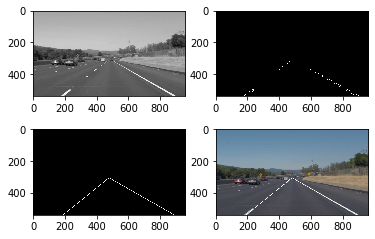

In [18]:
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Slope & intercept:  [[0.6492890995260664, -6.199052132701468], [0.6989795918367347, -33.525510204081684], [0.6257668711656442, 9.662576687116541]]
Slope:  0.6580118541761485 Intercept:  -10.020661883222203
Slope & intercept:  [[-0.6028571428571429, 600.9028571428571], [-0.6274509803921569, 615.1764705882352], [-0.6013986013986014, 610.6573426573426], [-0.6018957345971564, 601.1990521327015], [-0.6475770925110133, 620.5947136563876], [-0.7213114754098361, 650.704918032787], [-0.6490384615384616, 621.6105769230769]]
Slope:  -0.6359327841006239 Intercept:  617.2637044476269
Coef:  0.6580118541761485 Intercept:  -10.020661883222203 intersection_x:  484.7845477888784
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.6359327841006239 Intercept:  617.2637044476269 intersection_x:  484.7845477888784
Point one:  (484, 308) Point two:  (0, 617)
(540, 960, 3)
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



t:   0%|                                                                             | 0/681 [00:00<?, ?it/s, now=None]

Slope & intercept:  [[0.6492890995260664, -6.199052132701468], [0.6989795918367347, -33.525510204081684], [0.6257668711656442, 9.662576687116541]]
Slope:  0.6580118541761485 Intercept:  -10.020661883222203
Slope & intercept:  [[-0.6028571428571429, 600.9028571428571], [-0.6274509803921569, 615.1764705882352], [-0.6013986013986014, 610.6573426573426], [-0.6018957345971564, 601.1990521327015], [-0.6475770925110133, 620.5947136563876], [-0.7213114754098361, 650.704918032787], [-0.6490384615384616, 621.6105769230769]]
Slope:  -0.6359327841006239 Intercept:  617.2637044476269
Coef:  0.6580118541761485 Intercept:  -10.020661883222203 intersection_x:  484.7845477888784
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.6359327841006239 Intercept:  617.2637044476269 intersection_x:  484.7845477888784
Point one:  (484, 308) Point two:  (0, 617)
(540, 960, 3)


t:   0%|▏                                                                    | 2/681 [00:00<01:07, 10.03it/s, now=None]

Slope & intercept:  [[0.7004048582995951, -35.129554655870436], [0.6477732793522267, -5.299595141700422], [0.7008196721311475, -34.06557377049177]]
Slope:  0.6829992699276565 Intercept:  -24.831574522687543
Slope & intercept:  [[-0.628099173553719, 616.5206611570247], [-0.6028571428571429, 601.3], [-0.6276595744680851, 615.4255319148936], [-0.5918367346938775, 596.1020408163265], [-0.6183206106870229, 605.6641221374045]]
Slope:  -0.6192341253914925 Intercept:  609.7275788023308
Coef:  0.6829992699276565 Intercept:  -24.831574522687543 intersection_x:  487.2852712930939
Point one:  (487, 307) Point two:  (960, 630)
Coef:  -0.6192341253914925 Intercept:  609.7275788023308 intersection_x:  487.2852712930939
Point one:  (487, 307) Point two:  (0, 609)
(540, 960, 3)


t:   0%|▎                                                                    | 3/681 [00:00<01:34,  7.14it/s, now=None]

Slope & intercept:  [[0.7016129032258065, -35.62096774193549], [0.6491935483870968, -6.673387096774206]]
Slope:  0.6754032258064516 Intercept:  -21.147177419354847
Slope & intercept:  [[-0.6023391812865497, 601.859649122807], [-0.6267942583732058, 616.4784688995215], [-0.6047619047619047, 601.7714285714286], [-0.6296296296296297, 617.9629629629629], [-0.6477987421383647, 623.1572327044025], [-0.5918367346938775, 600.2244897959183], [-0.5866666666666667, 600.0933333333334], [-0.5882352941176471, 600.9411764705883]]
Slope:  -0.6097578014584808 Intercept:  607.8110927326204
Coef:  0.6754032258064516 Intercept:  -21.147177419354847 intersection_x:  489.40036058401046
Point one:  (489, 309) Point two:  (960, 627)
Coef:  -0.6097578014584808 Intercept:  607.8110927326204 intersection_x:  489.40036058401046
Point one:  (489, 309) Point two:  (0, 607)
(540, 960, 3)


t:   1%|▍                                                                    | 4/681 [00:00<01:47,  6.30it/s, now=None]

Slope & intercept:  [[0.6968325791855203, -31.6787330316742], [0.6511627906976745, -9.325581395348877], [0.7256637168141593, -56.04424778761063], [0.647887323943662, -7.18309859154931], [0.7248677248677249, -53.597883597883595], [0.6444444444444445, -3.3333333333333712]]
Slope:  0.681809763325531 Intercept:  -26.860479622899998
Slope & intercept:  [[-0.6509433962264151, 624.9245283018868], [-0.624031007751938, 609.4302325581396], [-0.6217948717948718, 608.0192307692307], [-0.6506024096385542, 621.3253012048193], [-0.6470588235294118, 622.7647058823529], [-0.6666666666666666, 632.6666666666666], [-0.6208791208791209, 608.2692307692307]]
Slope:  -0.6402823280695683 Intercept:  618.199985164618
Coef:  0.681809763325531 Intercept:  -26.860479622899998 intersection_x:  487.90887487031006
Point one:  (487, 305) Point two:  (960, 627)
Coef:  -0.6402823280695683 Intercept:  618.199985164618 intersection_x:  487.90887487031006
Point one:  (487, 305) Point two:  (0, 618)
(540, 960, 3)


t:   1%|▌                                                                    | 5/681 [00:00<01:53,  5.98it/s, now=None]

Slope & intercept:  [[0.7205882352941176, -53.30882352941177], [0.7066666666666667, -39.866666666666674], [0.7162162162162162, -49.70270270270271]]
Slope:  0.7144903727256668 Intercept:  -47.626064299593715
Slope & intercept:  [[-0.6257309941520468, 610.9590643274854], [-0.6518987341772152, 625.3544303797469], [-0.6510067114093959, 626.8859060402684], [-0.6376811594202898, 611.8840579710145], [-0.6504854368932039, 625.8155339805826]]
Slope:  -0.6477680104750262 Intercept:  622.4849820929031
Coef:  0.7144903727256668 Intercept:  -47.626064299593715 intersection_x:  491.91185362209916
Point one:  (491, 303) Point two:  (960, 638)
Coef:  -0.6477680104750262 Intercept:  622.4849820929031 intersection_x:  491.91185362209916
Point one:  (491, 303) Point two:  (0, 622)
(540, 960, 3)


t:   1%|▌                                                                    | 6/681 [00:01<02:11,  5.13it/s, now=None]

Slope & intercept:  [[0.6451612903225806, -2.0645161290322562], [0.75, -68.75]]
Slope:  0.6975806451612903 Intercept:  -35.40725806451613
Slope & intercept:  [[-0.6504854368932039, 626.4660194174758], [-0.6242603550295858, 611.6627218934912], [-0.6341463414634146, 624.2682926829268], [-0.6744186046511628, 631.1395348837209], [-0.6498316498316499, 627.026936026936]]
Slope:  -0.6466284775738034 Intercept:  624.1127009809101
Coef:  0.6975806451612903 Intercept:  -35.40725806451613 intersection_x:  490.63791332072316
Point one:  (490, 306) Point two:  (960, 634)
Coef:  -0.6466284775738034 Intercept:  624.1127009809101 intersection_x:  490.63791332072316
Point one:  (490, 306) Point two:  (0, 624)
(540, 960, 3)


t:   1%|▋                                                                    | 7/681 [00:01<02:16,  4.93it/s, now=None]

Slope & intercept:  [[0.7213114754098361, -48.147540983606575], [0.625, 4.875]]
Slope:  0.673155737704918 Intercept:  -21.636270491803288
Slope & intercept:  [[-0.6272727272727273, 614.2727272727273], [-0.654054054054054, 627.708108108108], [-0.6504854368932039, 627.3106796116505], [-0.6498054474708171, 628.3229571984436], [-0.6363636363636364, 616.4545454545455], [-0.6268656716417911, 613.223880597015]]
Slope:  -0.6408078289493716 Intercept:  621.215483040415
Coef:  0.673155737704918 Intercept:  -21.636270491803288 intersection_x:  489.24625449782803
Point one:  (489, 307) Point two:  (960, 624)
Coef:  -0.6408078289493716 Intercept:  621.215483040415 intersection_x:  489.24625449782803
Point one:  (489, 307) Point two:  (0, 621)
(540, 960, 3)


t:   1%|▊                                                                    | 8/681 [00:01<02:31,  4.45it/s, now=None]

Slope & intercept:  [[0.6774193548387096, -22.83870967741933], [0.6470588235294118, -10.117647058823536]]
Slope:  0.6622390891840607 Intercept:  -16.478178368121434
Slope & intercept:  [[-0.6261398176291794, 612.7629179331307], [-0.6540284360189573, 628.611374407583], [-0.6463414634146342, 627.8414634146342], [-0.631578947368421, 614.4736842105262], [-0.782608695652174, 678.0434782608695]]
Slope:  -0.6681394720166731 Intercept:  632.3465836453487
Coef:  0.6622390891840607 Intercept:  -16.478178368121434 intersection_x:  487.69935185055374
Point one:  (487, 306) Point two:  (960, 619)
Coef:  -0.6681394720166731 Intercept:  632.3465836453487 intersection_x:  487.69935185055374
Point one:  (487, 306) Point two:  (0, 632)
(540, 960, 3)


t:   1%|▉                                                                    | 9/681 [00:01<02:40,  4.19it/s, now=None]

Slope & intercept:  [[0.6666666666666666, -17.66666666666663], [0.6744186046511628, -27.767441860465112]]
Slope:  0.6705426356589147 Intercept:  -22.71705426356587
Slope & intercept:  [[-0.6253869969040248, 613.671826625387], [-0.6533333333333333, 628.76], [-0.6486486486486487, 628.8108108108108], [-0.6274509803921569, 612.6078431372549], [-0.7761194029850746, 675.1492537313433], [-0.6071428571428571, 606.6785714285714], [-0.6994535519125683, 641.8579234972677]]
Slope:  -0.6625051101883805 Intercept:  629.6480327472336
Coef:  0.6705426356589147 Intercept:  -22.71705426356587 intersection_x:  489.37863556878926
Point one:  (489, 305) Point two:  (960, 621)
Coef:  -0.6625051101883805 Intercept:  629.6480327472336 intersection_x:  489.37863556878926
Point one:  (489, 305) Point two:  (0, 629)
(540, 960, 3)


t:   1%|▉                                                                   | 10/681 [00:02<03:04,  3.64it/s, now=None]

Slope & intercept:  [[0.6226415094339622, 3.8490566037735903], [0.6987951807228916, -38.79518072289159], [0.68, -25.80000000000001]]
Slope:  0.6671455633856179 Intercept:  -20.248708039706003
Slope & intercept:  [[-0.6246153846153846, 612.9538461538461], [-0.6666666666666666, 632.0], [-0.6557377049180327, 628.9508196721312], [-0.6995515695067265, 641.0], [-0.6991869918699187, 640.1382113821138], [-0.6287425149700598, 615.0778443113772], [-0.6993865030674846, 643.2208588957055]]
Slope:  -0.6676981908020391 Intercept:  630.4773686307391
Coef:  0.6671455633856179 Intercept:  -20.248708039706003 intersection_x:  487.4923185796049
Point one:  (487, 304) Point two:  (960, 620)
Coef:  -0.6676981908020391 Intercept:  630.4773686307391 intersection_x:  487.4923185796049
Point one:  (487, 304) Point two:  (0, 630)
(540, 960, 3)


t:   2%|█                                                                   | 11/681 [00:02<03:19,  3.37it/s, now=None]

Slope & intercept:  [[0.6226415094339622, 4.15094339622641], [0.6190476190476191, 13.0], [0.7010309278350515, -40.309278350515456]]
Slope:  0.6475733521055443 Intercept:  -7.719444984763015
Slope & intercept:  [[-0.6484375, 620.0390625], [-0.6738351254480287, 635.4659498207885], [-0.649746192893401, 621.3350253807107], [-0.6766666666666666, 635.7633333333333], [-0.6666666666666666, 623.0], [-0.6595744680851063, 620.3617021276596]]
Slope:  -0.6624877699599782 Intercept:  625.9941788604153
Coef:  0.6475733521055443 Intercept:  -7.719444984763015 intersection_x:  483.728288071038
Point one:  (483, 305) Point two:  (960, 613)
Coef:  -0.6624877699599782 Intercept:  625.9941788604153 intersection_x:  483.728288071038
Point one:  (483, 305) Point two:  (0, 625)
(540, 960, 3)


t:   2%|█▏                                                                  | 12/681 [00:02<03:18,  3.37it/s, now=None]

Slope & intercept:  [[0.6285714285714286, -1.0285714285714107], [0.6721311475409836, -21.91803278688525], [0.6201550387596899, 5.286821705426348]]
Slope:  0.640285871624034 Intercept:  -5.886594170010103
Slope & intercept:  [[-0.65, 620.45], [-0.675, 636.2], [-0.6766666666666666, 635.44], [-0.65, 621.85], [-0.66, 621.06], [-0.6595744680851063, 622.0]]
Slope:  -0.6618735224586288 Intercept:  626.1666666666666
Coef:  0.640285871624034 Intercept:  -5.886594170010103 intersection_x:  485.38855051761277
Point one:  (485, 304) Point two:  (960, 608)
Coef:  -0.6618735224586288 Intercept:  626.1666666666666 intersection_x:  485.38855051761277
Point one:  (485, 304) Point two:  (0, 626)
(540, 960, 3)


t:   2%|█▎                                                                  | 13/681 [00:03<03:18,  3.37it/s, now=None]

Slope & intercept:  [[0.6733333333333333, -24.366666666666674], [0.6242038216560509, 2.2356687898089262], [0.6733333333333333, -23.693333333333328]]
Slope:  0.6569568294409058 Intercept:  -15.274777070063692
Slope & intercept:  [[-0.6748251748251748, 635.8496503496503], [-0.649390243902439, 620.1737804878048], [-0.6483516483516484, 622.2197802197802], [-0.6486486486486487, 620.8918918918919], [-0.6981132075471698, 643.1698113207547], [-0.6825396825396826, 638.3174603174602]]
Slope:  -0.6669781009691272 Intercept:  630.1037290978903
Coef:  0.6569568294409058 Intercept:  -15.274777070063692 intersection_x:  487.4699589413169
Point one:  (487, 304) Point two:  (960, 615)
Coef:  -0.6669781009691272 Intercept:  630.1037290978903 intersection_x:  487.4699589413169
Point one:  (487, 304) Point two:  (0, 630)
(540, 960, 3)


t:   2%|█▍                                                                  | 14/681 [00:03<03:10,  3.49it/s, now=None]

Slope & intercept:  [[0.6218905472636815, 4.671641791044806], [0.6744186046511628, -24.883720930232528], [0.6991869918699187, -40.699186991869965], [0.6020942408376964, 19.0]]
Slope:  0.6493975961556149 Intercept:  -10.477816532764422
Slope & intercept:  [[-0.6485355648535565, 622.652719665272], [-0.680327868852459, 637.983606557377], [-0.7272727272727273, 653.0], [-0.6756756756756757, 638.0], [-0.6302521008403361, 618.0420168067227], [-0.6510903426791277, 622.3395638629283], [-0.660377358490566, 631.3962264150944]]
Slope:  -0.667647376952064 Intercept:  631.9163047581991
Coef:  0.6493975961556149 Intercept:  -10.477816532764422 intersection_x:  487.75412716179335
Point one:  (487, 306) Point two:  (960, 612)
Coef:  -0.667647376952064 Intercept:  631.9163047581991 intersection_x:  487.75412716179335
Point one:  (487, 306) Point two:  (0, 631)
(540, 960, 3)


t:   2%|█▍                                                                  | 15/681 [00:03<03:06,  3.57it/s, now=None]

Slope & intercept:  [[0.6497695852534562, -7.156682027649765], [0.6035714285714285, 19.1357142857143], [0.6, 20.0]]
Slope:  0.6177803379416282 Intercept:  10.659677419354844
Slope & intercept:  [[-0.6487341772151899, 621.6867088607595], [-0.676923076923077, 639.5384615384615], [-0.6756756756756757, 638.3783783783783], [-0.6485507246376812, 623.3623188405797], [-0.6595744680851063, 630.3829787234042], [-0.6607142857142857, 625.3214285714286], [-0.6298701298701299, 617.6558441558442]]
Slope:  -0.6616954013751694 Intercept:  629.7783791521687
Coef:  0.6177803379416282 Intercept:  10.659677419354844 intersection_x:  483.8846745647596
Point one:  (483, 309) Point two:  (960, 603)
Coef:  -0.6616954013751694 Intercept:  629.7783791521687 intersection_x:  483.8846745647596
Point one:  (483, 309) Point two:  (0, 629)
(540, 960, 3)


t:   2%|█▌                                                                  | 16/681 [00:03<02:53,  3.84it/s, now=None]

Slope & intercept:  [[0.6476190476190476, -5.352380952380997], [0.6007326007326007, 20.3772893772894], [0.6014492753623188, 20.75362318840581]]
Slope:  0.6166003079046557 Intercept:  11.926177204438071
Slope & intercept:  [[-0.6994535519125683, 646.7650273224044], [-0.6741573033707865, 631.6966292134831], [-0.6666666666666666, 628.0], [-0.7, 645.4], [-0.6714285714285714, 627.6285714285714], [-0.75, 653.25], [-0.6666666666666666, 627.3333333333334]]
Slope:  -0.6897675371493228 Intercept:  637.1533658996847
Coef:  0.6166003079046557 Intercept:  11.926177204438071 intersection_x:  478.59964638781537
Point one:  (478, 307) Point two:  (960, 603)
Coef:  -0.6897675371493228 Intercept:  637.1533658996847 intersection_x:  478.59964638781537
Point one:  (478, 307) Point two:  (0, 637)
(540, 960, 3)


t:   2%|█▋                                                                  | 17/681 [00:04<02:47,  3.97it/s, now=None]

Slope & intercept:  [[0.5945945945945946, 26.054054054054006], [0.6612903225806451, -17.5], [0.5972222222222222, 23.388888888888914], [0.6507936507936508, -8.365079365079396], [0.6233766233766234, 7.818181818181813]]
Slope:  0.6254554827135472 Intercept:  6.279209079209068
Slope & intercept:  [[-0.7027972027972028, 646.527972027972], [-0.6714801444043321, 629.1660649819495], [-0.6739130434782609, 630.9347826086956], [-0.70042194092827, 646.5822784810126]]
Slope:  -0.6871530829020164 Intercept:  638.3027745249074
Coef:  0.6254554827135472 Intercept:  6.279209079209068 intersection_x:  481.5019359174326
Point one:  (481, 307) Point two:  (960, 606)
Coef:  -0.6871530829020164 Intercept:  638.3027745249074 intersection_x:  481.5019359174326
Point one:  (481, 307) Point two:  (0, 638)
(540, 960, 3)


t:   3%|█▊                                                                  | 18/681 [00:04<03:08,  3.51it/s, now=None]

Slope & intercept:  [[0.6, 20.80000000000001], [0.6470588235294118, -5.823529411764753], [0.6195652173913043, 6.456521739130437]]
Slope:  0.6222080136402387 Intercept:  7.144330775788565
Slope & intercept:  [[-0.673992673992674, 631.2967032967033], [-0.7031802120141343, 646.9929328621909], [-0.6721311475409836, 629.4098360655738], [-0.7018181818181818, 647.4836363636364], [-0.6722689075630253, 630.4285714285714]]
Slope:  -0.6846782245857999 Intercept:  637.1223360033352
Coef:  0.6222080136402387 Intercept:  7.144330775788565 intersection_x:  482.04502182429894
Point one:  (482, 307) Point two:  (960, 604)
Coef:  -0.6846782245857999 Intercept:  637.1223360033352 intersection_x:  482.04502182429894
Point one:  (482, 307) Point two:  (0, 637)
(540, 960, 3)


t:   3%|█▉                                                                  | 19/681 [00:04<03:01,  3.66it/s, now=None]

Slope & intercept:  [[0.5945945945945946, 20.621621621621614], [0.625, 7.375], [0.5981308411214953, 23.112149532710305]]
Slope:  0.60590847857203 Intercept:  17.03625705144397
Slope & intercept:  [[-0.6991525423728814, 648.0677966101695], [-0.6745762711864407, 630.8847457627119], [-0.6835443037974683, 640.8987341772151], [-0.7018867924528301, 647.4943396226415], [-0.6533333333333333, 625.5866666666667], [-0.6705882352941176, 629.5294117647059], [-0.717391304347826, 651.9347826086956]]
Slope:  -0.6911899082419274 Intercept:  641.4683017576899
Coef:  0.60590847857203 Intercept:  17.03625705144397 intersection_x:  481.4068470472997
Point one:  (481, 308) Point two:  (960, 598)
Coef:  -0.6911899082419274 Intercept:  641.4683017576899 intersection_x:  481.4068470472997
Point one:  (481, 308) Point two:  (0, 641)
(540, 960, 3)


t:   3%|█▉                                                                  | 20/681 [00:04<02:46,  3.97it/s, now=None]

Slope & intercept:  [[0.6239316239316239, 8.02564102564105], [0.5984848484848485, 18.5151515151515], [0.5984848484848485, 22.909090909090878]]
Slope:  0.6069671069671071 Intercept:  16.483294483294475
Slope & intercept:  [[-0.7018867924528301, 646.7924528301887], [-0.6730769230769231, 629.5384615384615], [-0.6741935483870968, 630.6903225806452], [-0.7028985507246377, 646.2463768115942]]
Slope:  -0.688013953660372 Intercept:  638.3169034402224
Coef:  0.6069671069671071 Intercept:  16.483294483294475 intersection_x:  480.187415756969
Point one:  (480, 307) Point two:  (960, 599)
Coef:  -0.688013953660372 Intercept:  638.3169034402224 intersection_x:  480.187415756969
Point one:  (480, 307) Point two:  (0, 638)
(540, 960, 3)


t:   3%|██                                                                  | 21/681 [00:05<02:52,  3.83it/s, now=None]

Slope & intercept:  [[0.6097560975609756, 9.39024390243901], [0.65, -9.199999999999989]]
Slope:  0.6298780487804878 Intercept:  0.09512195121951095
Slope & intercept:  [[-0.6720257234726688, 628.7234726688102], [-0.7037037037037037, 646.0740740740741], [-0.7008928571428571, 646.6383928571429]]
Slope:  -0.6922074281064098 Intercept:  640.4786465333424
Coef:  0.6298780487804878 Intercept:  0.09512195121951095 intersection_x:  484.3737683966002
Point one:  (484, 305) Point two:  (960, 604)
Coef:  -0.6922074281064098 Intercept:  640.4786465333424 intersection_x:  484.3737683966002
Point one:  (484, 305) Point two:  (0, 640)
(540, 960, 3)


t:   3%|██▏                                                                 | 22/681 [00:05<03:29,  3.15it/s, now=None]

Slope & intercept:  [[0.654320987654321, -13.123456790123441], [0.6078431372549019, 10.705882352941217]]
Slope:  0.6310820624546114 Intercept:  -1.2087872185911124
Slope & intercept:  [[-0.6741935483870968, 629.341935483871], [-0.703125, 645.125], [-0.6731391585760518, 628.200647249191], [-0.6885245901639344, 642.3934426229508], [-0.6792452830188679, 641.9245283018868]]
Slope:  -0.6836455160291901 Intercept:  637.3971107315799
Coef:  0.6310820624546114 Intercept:  -1.2087872185911124 intersection_x:  485.7324881605039
Point one:  (485, 305) Point two:  (960, 604)
Coef:  -0.6836455160291901 Intercept:  637.3971107315799 intersection_x:  485.7324881605039
Point one:  (485, 305) Point two:  (0, 637)
(540, 960, 3)


t:   3%|██▎                                                                 | 23/681 [00:05<03:10,  3.45it/s, now=None]

Slope & intercept:  [[0.6458333333333334, -7.6875], [0.5967741935483871, 18.645161290322562], [0.627906976744186, 5.046511627906966]]
Slope:  0.6235048345419688 Intercept:  5.3347243060765095
Slope & intercept:  [[-0.7037037037037037, 645.3703703703703], [-0.6746031746031746, 630.1746031746031], [-0.6716417910447762, 626.6567164179105], [-0.6725352112676056, 628.2781690140845], [-0.6745762711864407, 628.0440677966102]]
Slope:  -0.6794120303611402 Intercept:  631.7047853547158
Coef:  0.6235048345419688 Intercept:  5.3347243060765095 intersection_x:  480.744457241498
Point one:  (480, 305) Point two:  (960, 603)
Coef:  -0.6794120303611402 Intercept:  631.7047853547158 intersection_x:  480.744457241498
Point one:  (480, 305) Point two:  (0, 631)
(540, 960, 3)


t:   4%|██▍                                                                 | 24/681 [00:06<03:08,  3.48it/s, now=None]

Slope & intercept:  [[0.5983606557377049, 17.188524590163922], [0.6491228070175439, -9.5263157894737], [0.5952380952380952, 20.047619047619037]]
Slope:  0.6142405193311147 Intercept:  9.236609282769754
Slope & intercept:  [[-0.7035573122529645, 646.6442687747035], [-0.652, 623.1], [-0.7142857142857143, 648.1428571428571], [-0.6549295774647887, 622.5492957746479], [-0.64, 622.04], [-0.7022900763358778, 645.4503816793894], [-0.6738197424892703, 628.8497854077253], [-0.6720257234726688, 627.7073954983923]]
Slope:  -0.6766135182876605 Intercept:  633.0604980347144
Coef:  0.6142405193311147 Intercept:  9.236609282769754 intersection_x:  483.26446722257305
Point one:  (483, 306) Point two:  (960, 598)
Coef:  -0.6766135182876605 Intercept:  633.0604980347144 intersection_x:  483.26446722257305
Point one:  (483, 306) Point two:  (0, 633)
(540, 960, 3)


t:   4%|██▍                                                                 | 25/681 [00:06<03:02,  3.59it/s, now=None]

Slope & intercept:  [[0.6449704142011834, -5.857988165680467], [0.6266666666666667, -0.6400000000000432]]
Slope:  0.635818540433925 Intercept:  -3.2489940828402553
Slope & intercept:  [[-0.6752411575562701, 629.4823151125402], [-0.7019607843137254, 646.8039215686274], [-0.6733333333333333, 630.9200000000001], [-0.7073170731707317, 647.609756097561], [-0.6875, 633.9375], [-0.7008547008547008, 639.3675213675214], [-0.7019607843137254, 646.2078431372549]]
Slope:  -0.6925954047917839 Intercept:  639.1898367547865
Coef:  0.635818540433925 Intercept:  -3.2489940828402553 intersection_x:  483.6134347629652
Point one:  (483, 304) Point two:  (960, 607)
Coef:  -0.6925954047917839 Intercept:  639.1898367547865 intersection_x:  483.6134347629652
Point one:  (483, 304) Point two:  (0, 639)
(540, 960, 3)


t:   4%|██▌                                                                 | 26/681 [00:06<02:45,  3.96it/s, now=None]

Slope & intercept:  [[0.6487804878048781, -8.887804878048769], [0.625, -0.75], [0.5814977973568282, 32.312775330396505], [0.6751592356687898, -27.222929936305718], [0.6434782608695652, -12.426086956521715]]
Slope:  0.6347831563400123 Intercept:  -3.3948092880959395
Slope & intercept:  [[-0.6735751295336787, 632.3316062176166], [-0.7028112449799196, 648.3413654618474], [-0.7017543859649122, 648.8771929824561], [-0.6896551724137931, 634.1034482758621], [-0.6745098039215687, 632.1098039215686], [-0.6721311475409836, 630.0819672131147]]
Slope:  -0.6857394807258093 Intercept:  637.6408973454108
Coef:  0.6347831563400123 Intercept:  -3.3948092880959395 intersection_x:  485.4409069865528
Point one:  (485, 304) Point two:  (960, 605)
Coef:  -0.6857394807258093 Intercept:  637.6408973454108 intersection_x:  485.4409069865528
Point one:  (485, 304) Point two:  (0, 637)
(540, 960, 3)


t:   4%|██▋                                                                 | 27/681 [00:06<02:39,  4.09it/s, now=None]

Slope & intercept:  [[0.6502242152466368, -12.390134529147986], [0.5983606557377049, 17.827868852459005], [0.6458333333333334, -8.041666666666686], [0.5772727272727273, 33.06818181818181]]
Slope:  0.6179227328976006 Intercept:  7.616062368706537
Slope & intercept:  [[-0.6755852842809364, 632.2307692307693], [-0.7019230769230769, 648.9038461538462], [-0.7087378640776699, 649.252427184466], [-0.7070707070707071, 649.5353535353536], [-0.6923076923076923, 637.6923076923076]]
Slope:  -0.7025098350947865 Intercept:  646.3459836414934
Coef:  0.6179227328976006 Intercept:  7.616062368706537 intersection_x:  483.7277849363599
Point one:  (483, 306) Point two:  (960, 600)
Coef:  -0.7025098350947865 Intercept:  646.3459836414934 intersection_x:  483.7277849363599
Point one:  (483, 306) Point two:  (0, 646)
(540, 960, 3)


t:   4%|██▊                                                                 | 28/681 [00:07<02:29,  4.37it/s, now=None]

Slope & intercept:  [[0.5991379310344828, 15.551724137931046], [0.6468253968253969, -11.44841269841271], [0.6180555555555556, 8.055555555555543], [0.6097560975609756, 18.48780487804879]]
Slope:  0.6089831947170047 Intercept:  14.03169485717846
Slope & intercept:  [[-0.6755852842809364, 631.2307692307693], [-0.7268518518518519, 655.7314814814815], [-0.6746575342465754, 631.777397260274], [-0.7044334975369458, 649.5270935960591], [-0.8650793650793651, 708.8492063492064], [-0.6794871794871795, 644.4871794871794]]
Slope:  -0.7210157854138091 Intercept:  653.6005212341615
Coef:  0.6089831947170047 Intercept:  14.03169485717846 intersection_x:  480.8791855720653
Point one:  (480, 306) Point two:  (960, 598)
Coef:  -0.7210157854138091 Intercept:  653.6005212341615 intersection_x:  480.8791855720653
Point one:  (480, 306) Point two:  (0, 653)
(540, 960, 3)


t:   4%|██▉                                                                 | 29/681 [00:07<02:38,  4.12it/s, now=None]

Slope & intercept:  [[0.6292134831460674, 0.022471910112358273], [0.5742574257425742, 35.52475247524757], [0.5614035087719298, 44.68421052631584]]
Slope:  0.5882914725535238 Intercept:  26.743811637225253
Slope & intercept:  [[-0.6758620689655173, 631.9448275862069], [-0.7286821705426356, 656.3178294573644], [-0.7263157894736842, 656.3473684210526], [-0.6833333333333333, 633.9333333333334], [-0.6933333333333334, 636.7866666666666], [-0.697560975609756, 638.6243902439024]]
Slope:  -0.7008479452097099 Intercept:  642.325735951421
Coef:  0.5882914725535238 Intercept:  26.743811637225253 intersection_x:  477.51384825567015
Point one:  (477, 307) Point two:  (960, 591)
Coef:  -0.7008479452097099 Intercept:  642.325735951421 intersection_x:  477.51384825567015
Point one:  (477, 307) Point two:  (0, 642)
(540, 960, 3)


t:   4%|██▉                                                                 | 30/681 [00:07<02:27,  4.41it/s, now=None]

Slope & intercept:  [[0.6172839506172839, 7.567901234567898], [0.6222222222222222, -6.688888888888869]]
Slope:  0.6197530864197531 Intercept:  0.4395061728395149
Slope & intercept:  [[-0.6771929824561403, 632.838596491228], [-0.7272727272727273, 655.8181818181819], [-0.7268722466960352, 656.7533039647577], [-0.7, 640.1], [-0.6904761904761905, 636.4047619047619]]
Slope:  -0.7043628293802188 Intercept:  644.3829688357858
Coef:  0.6197530864197531 Intercept:  0.4395061728395149 intersection_x:  486.3195547905671
Point one:  (486, 301) Point two:  (960, 595)
Coef:  -0.7043628293802188 Intercept:  644.3829688357858 intersection_x:  486.3195547905671
Point one:  (486, 301) Point two:  (0, 644)
(540, 960, 3)


t:   5%|███                                                                 | 31/681 [00:07<02:19,  4.64it/s, now=None]

Slope & intercept:  [[0.5980392156862745, 18.166666666666686]]
Slope & intercept:  [[-0.6750902527075813, 633.1877256317689], [-0.7073170731707317, 651.7317073170732], [-0.75, 665.0], [-0.75, 658.75], [-0.7019230769230769, 651.0096153846154], [-0.7793103448275862, 674.1862068965518], [-0.7792207792207793, 671.8311688311688]]
Slope:  -0.7446285456903623 Intercept:  662.0847830715683
Coef:  0.5980392156862745 Intercept:  18.166666666666686 intersection_x:  479.58112567229034
Point one:  (479, 304) Point two:  (960, 592)
Coef:  -0.7446285456903623 Intercept:  662.0847830715683 intersection_x:  479.58112567229034
Point one:  (479, 304) Point two:  (0, 662)
(540, 960, 3)


t:   5%|███▏                                                                | 32/681 [00:07<02:13,  4.85it/s, now=None]

Slope & intercept:  [[0.6239316239316239, 3.2649572649572747], [0.6, 17.400000000000034]]
Slope:  0.611965811965812 Intercept:  10.332478632478654
Slope & intercept:  [[-0.674074074074074, 634.3925925925926], [-0.7276995305164319, 657.6150234741784], [-0.7203389830508474, 648.6694915254237], [-0.6554054054054054, 628.6081081081081], [-0.6791044776119403, 633.9402985074627], [-0.6935483870967742, 637.0322580645161], [-0.75, 658.75], [-0.7446808510638298, 662.8085106382978]]
Slope:  -0.7127780433448425 Intercept:  647.6011678289244
Coef:  0.611965811965812 Intercept:  10.332478632478654 intersection_x:  481.05049639728674
Point one:  (481, 304) Point two:  (960, 597)
Coef:  -0.7127780433448425 Intercept:  647.6011678289244 intersection_x:  481.05049639728674
Point one:  (481, 304) Point two:  (0, 647)
(540, 960, 3)


t:   5%|███▎                                                                | 33/681 [00:08<02:10,  4.97it/s, now=None]

Slope & intercept:  [[0.6223776223776224, 3.216783216783199]]
Slope & intercept:  [[-0.6992481203007519, 639.3684210526316], [-0.7285714285714285, 657.4857142857143], [-0.7004830917874396, 640.7101449275362], [-0.7446808510638298, 662.5957446808511], [-0.7142857142857143, 641.4285714285714]]
Slope:  -0.7174538412018329 Intercept:  648.3177192750609
Coef:  0.6223776223776224 Intercept:  3.216783216783199 intersection_x:  481.4791662936804
Point one:  (481, 302) Point two:  (960, 600)
Coef:  -0.7174538412018329 Intercept:  648.3177192750609 intersection_x:  481.4791662936804
Point one:  (481, 302) Point two:  (0, 648)
(540, 960, 3)


t:   5%|███▍                                                                | 34/681 [00:08<02:04,  5.20it/s, now=None]

Slope & intercept:  [[0.6304347826086957, -2.347826086956559], [0.6136363636363636, 3.863636363636374]]
Slope:  0.6220355731225297 Intercept:  0.7579051383399076
Slope & intercept:  [[-0.702054794520548, 640.7979452054794], [-0.7253886010362695, 656.9637305699482], [-0.6995708154506438, 640.9141630901288], [-0.7446808510638298, 662.3617021276596], [-0.8348623853211009, 692.9816513761468]]
Slope:  -0.7413114894784785 Intercept:  658.8038384738726
Coef:  0.6220355731225297 Intercept:  0.7579051383399076 intersection_x:  482.6694180718046
Point one:  (482, 300) Point two:  (960, 597)
Coef:  -0.7413114894784785 Intercept:  658.8038384738726 intersection_x:  482.6694180718046
Point one:  (482, 300) Point two:  (0, 658)
(540, 960, 3)


t:   5%|███▍                                                                | 35/681 [00:08<02:03,  5.21it/s, now=None]

Slope & intercept:  [[0.6181818181818182, 6.018181818181802], [0.627906976744186, -7.255813953488371], [0.5862068965517241, 21.103448275862092], [0.6111111111111112, 11.4444444444444]]
Slope:  0.6108517006472098 Intercept:  7.827565146249981
Slope & intercept:  [[-0.7529411764705882, 665.6823529411765], [-0.7003484320557491, 640.5505226480836], [-0.753968253968254, 664.436507936508], [-0.8348623853211009, 692.9816513761468], [-0.7266666666666667, 649.1133333333333]]
Slope:  -0.7537573828964719 Intercept:  662.5528736470496
Coef:  0.6108517006472098 Intercept:  7.827565146249981 intersection_x:  479.78964554491887
Point one:  (479, 300) Point two:  (960, 594)
Coef:  -0.7537573828964719 Intercept:  662.5528736470496 intersection_x:  479.78964554491887
Point one:  (479, 300) Point two:  (0, 662)
(540, 960, 3)


t:   5%|███▌                                                                | 36/681 [00:08<02:03,  5.20it/s, now=None]

Slope & intercept:  [[0.6212121212121212, 3.6666666666666856], [0.5915492957746479, 17.633802816901436]]
Slope:  0.6063807084933845 Intercept:  10.650234741784061
Slope & intercept:  [[-0.7534883720930232, 665.1767441860466], [-0.7021276595744681, 641.5106382978723], [-0.7758620689655172, 667.9655172413793], [-0.7439024390243902, 662.2317073170732], [-0.78125, 675.78125], [-0.7228915662650602, 648.4578313253012]]
Slope:  -0.7554788892695982 Intercept:  663.92261001396
Coef:  0.6063807084933845 Intercept:  10.650234741784061 intersection_x:  479.6914280629619
Point one:  (479, 301) Point two:  (960, 592)
Coef:  -0.7554788892695982 Intercept:  663.92261001396 intersection_x:  479.6914280629619
Point one:  (479, 301) Point two:  (0, 663)
(540, 960, 3)


t:   5%|███▋                                                                | 37/681 [00:08<02:04,  5.17it/s, now=None]

Slope & intercept:  [[0.5730337078651685, 30.516853932584297], [0.6219512195121951, 3.4878048780487916]]
Slope:  0.5974924636886818 Intercept:  17.002329405316544
Slope & intercept:  [[-0.7195121951219512, 645.390243902439], [-0.7551867219917012, 665.1161825726141], [-0.7, 640.2], [-0.7480916030534351, 655.6946564885496], [-0.8082191780821918, 681.6849315068494], [-0.7843137254901961, 671.1960784313726]]
Slope:  -0.7525539039565793 Intercept:  659.8803488169707
Coef:  0.5974924636886818 Intercept:  17.002329405316544 intersection_x:  476.1895849051142
Point one:  (476, 301) Point two:  (960, 590)
Coef:  -0.7525539039565793 Intercept:  659.8803488169707 intersection_x:  476.1895849051142
Point one:  (476, 301) Point two:  (0, 659)
(540, 960, 3)


t:   6%|███▊                                                                | 38/681 [00:09<02:03,  5.20it/s, now=None]

Slope & intercept:  [[0.5765765765765766, 27.810810810810835], [0.6046511627906976, 16.09302325581399], [0.5517241379310345, 48.34482758620692], [0.6482758620689655, -14.744827586206895]]
Slope:  0.5953069348418185 Intercept:  19.375958516656212
Slope & intercept:  [[-0.7260869565217392, 646.9565217391305], [-0.7535545023696683, 665.3649289099526], [-0.7604166666666666, 666.375], [-0.7222222222222222, 647.7222222222222], [-0.7552742616033755, 665.1308016877637], [-0.7261904761904762, 646.4761904761905], [-0.7258064516129032, 647.8548387096774]]
Slope:  -0.7385073624552929 Intercept:  655.1257862492766
Coef:  0.5953069348418185 Intercept:  19.375958516656212 intersection_x:  476.640435644547
Point one:  (476, 303) Point two:  (960, 590)
Coef:  -0.7385073624552929 Intercept:  655.1257862492766 intersection_x:  476.640435644547
Point one:  (476, 303) Point two:  (0, 655)
(540, 960, 3)


t:   6%|███▉                                                                | 39/681 [00:09<02:23,  4.46it/s, now=None]

Slope & intercept:  [[0.5943396226415094, 13.754716981132106], [0.6194029850746269, 5.231343283582078], [0.5985915492957746, 11.584507042253563]]
Slope:  0.6041113856706369 Intercept:  10.190189102322583
Slope & intercept:  [[-0.7045454545454546, 640.6590909090909], [-0.7544642857142857, 664.75], [-0.7016129032258065, 641.1370967741935], [-0.7037037037037037, 639.7037037037037], [-0.7522935779816514, 663.6330275229358]]
Slope:  -0.7233239850341804 Intercept:  649.9765837819848
Coef:  0.6041113856706369 Intercept:  10.190189102322583 intersection_x:  481.9717846903236
Point one:  (481, 301) Point two:  (960, 590)
Coef:  -0.7233239850341804 Intercept:  649.9765837819848 intersection_x:  481.9717846903236
Point one:  (481, 301) Point two:  (0, 649)
(540, 960, 3)


t:   6%|███▉                                                                | 40/681 [00:09<02:14,  4.76it/s, now=None]

Slope & intercept:  [[0.6223776223776224, 2.0], [0.5776892430278885, 27.90039840637445], [0.5641025641025641, 37.4871794871795], [0.5547945205479452, 43.92465753424659], [0.6473214285714286, -19.63839285714289]]
Slope:  0.579740987514005 Intercept:  27.828058856950136
Slope & intercept:  [[-0.7533632286995515, 663.3049327354261], [-0.7025089605734767, 639.5663082437276], [-0.7, 636.9], [-0.7021276595744681, 638.6170212765958], [-0.9591836734693877, 742.9387755102041]]
Slope:  -0.7634367044633767 Intercept:  664.2654075531907
Coef:  0.579740987514005 Intercept:  27.828058856950136 intersection_x:  473.82960013227915
Point one:  (473, 302) Point two:  (960, 584)
Coef:  -0.7634367044633767 Intercept:  664.2654075531907 intersection_x:  473.82960013227915
Point one:  (473, 302) Point two:  (0, 664)
(540, 960, 3)


t:   6%|████                                                                | 41/681 [00:09<02:12,  4.85it/s, now=None]

Slope & intercept:  [[0.576, 28.81600000000003], [0.6260869565217392, -0.6869565217391482]]
Slope:  0.6010434782608696 Intercept:  14.064521739130441
Slope & intercept:  [[-0.7510204081632653, 662.9183673469388], [-0.7025089605734767, 639.2688172043011], [-0.7678571428571429, 665.6785714285714], [-0.7692307692307693, 663.0], [-0.7446808510638298, 659.6595744680851], [-0.7559055118110236, 662.7244094488188], [-0.7244897959183674, 644.8367346938776]]
Slope:  -0.7521974131740663 Intercept:  659.8029428977153
Coef:  0.6010434782608696 Intercept:  14.064521739130441 intersection_x:  477.17921121483647
Point one:  (477, 300) Point two:  (960, 591)
Coef:  -0.7521974131740663 Intercept:  659.8029428977153 intersection_x:  477.17921121483647
Point one:  (477, 300) Point two:  (0, 659)
(540, 960, 3)


t:   6%|████▏                                                               | 42/681 [00:09<02:04,  5.13it/s, now=None]

Slope & intercept:  [[0.6197183098591549, 4.422535211267643], [0.5555555555555556, 47.0]]
Slope:  0.5876369327073552 Intercept:  25.71126760563382
Slope & intercept:  [[-0.7530864197530864, 662.2592592592592], [-0.7007299270072993, 639.6058394160584], [-0.7027027027027027, 638.0540540540541], [-0.7027972027972028, 638.9055944055945], [-0.7815126050420168, 673.1428571428571]]
Slope:  -0.7281657714604617 Intercept:  650.3935208555647
Coef:  0.5876369327073552 Intercept:  25.71126760563382 intersection_x:  474.75373874156384
Point one:  (474, 304) Point two:  (960, 589)
Coef:  -0.7281657714604617 Intercept:  650.3935208555647 intersection_x:  474.75373874156384
Point one:  (474, 304) Point two:  (0, 650)
(540, 960, 3)


t:   6%|████▎                                                               | 43/681 [00:09<01:52,  5.66it/s, now=None]

Slope & intercept:  [[0.5764705882352941, 30.541176470588255]]
Slope & intercept:  [[-0.7013888888888888, 638.2986111111111], [-0.7536231884057971, 662.8985507246377], [-0.7021276595744681, 639.4042553191489], [-0.7666666666666667, 660.8666666666667], [-0.753968253968254, 661.6507936507936]]
Slope:  -0.735554931500815 Intercept:  652.6237754944716
Coef:  0.5764705882352941 Intercept:  30.541176470588255 intersection_x:  474.1390999383948
Point one:  (474, 303) Point two:  (960, 583)
Coef:  -0.735554931500815 Intercept:  652.6237754944716 intersection_x:  474.1390999383948
Point one:  (474, 303) Point two:  (0, 652)
(540, 960, 3)


t:   6%|████▍                                                               | 44/681 [00:10<01:45,  6.06it/s, now=None]

Slope & intercept:  [[0.5922330097087378, 21.252427184466057]]
Slope & intercept:  [[-0.7534883720930232, 662.8883720930232], [-0.7003891050583657, 639.2645914396887], [-0.7013888888888888, 638.2986111111111], [-0.7708333333333334, 662.7708333333334], [-0.7708333333333334, 663.6666666666667], [-0.7550200803212851, 662.8232931726908]]
Slope:  -0.741992185504705 Intercept:  654.9520613027522
Coef:  0.5922330097087378 Intercept:  21.252427184466057 intersection_x:  474.95702853738277
Point one:  (474, 302) Point two:  (960, 589)
Coef:  -0.741992185504705 Intercept:  654.9520613027522 intersection_x:  474.95702853738277
Point one:  (474, 302) Point two:  (0, 654)
(540, 960, 3)


t:   7%|████▍                                                               | 45/681 [00:10<01:38,  6.45it/s, now=None]

Slope & intercept:  [[0.578125, 32.34375]]
Slope & intercept:  [[-0.7, 638.9], [-0.7534883720930232, 664.0790697674419], [-0.7013888888888888, 639.7013888888889], [-0.7441860465116279, 660.2093023255813], [-0.7659574468085106, 666.2340425531916], [-0.7037037037037037, 639.2962962962963]]
Slope:  -0.7281207430009591 Intercept:  651.4033499719
Coef:  0.578125 Intercept:  32.34375 intersection_x:  473.9227693478848
Point one:  (473, 306) Point two:  (960, 587)
Coef:  -0.7281207430009591 Intercept:  651.4033499719 intersection_x:  473.9227693478848
Point one:  (473, 306) Point two:  (0, 651)
(540, 960, 3)


t:   7%|████▌                                                               | 46/681 [00:10<01:38,  6.47it/s, now=None]

Slope & intercept:  [[0.6486486486486487, -11.675675675675677]]
Slope & intercept:  [[-0.702054794520548, 640.0958904109589], [-0.7547892720306514, 663.5402298850574], [-0.7169811320754716, 643.6603773584906], [-0.8333333333333334, 689.3333333333334], [-0.6804123711340206, 631.8144329896908], [-0.7777777777777778, 671.7777777777778]]
Slope:  -0.7442247801453005 Intercept:  656.7036736258848
Coef:  0.6486486486486487 Intercept:  -11.675675675675677 intersection_x:  479.85648622810754
Point one:  (479, 299) Point two:  (960, 611)
Coef:  -0.7442247801453005 Intercept:  656.7036736258848 intersection_x:  479.85648622810754
Point one:  (479, 299) Point two:  (0, 656)
(540, 960, 3)


t:   7%|████▋                                                               | 47/681 [00:10<01:32,  6.85it/s, now=None]

Slope & intercept:  [[0.62, 7.220000000000027], [0.6181818181818182, 2.872727272727275], [0.6326530612244898, -7.408163265306143]]
Slope:  0.6236116264687693 Intercept:  0.8948546691403862
Slope & intercept:  [[-0.7552742616033755, 664.3755274261604], [-0.7027027027027027, 639.6756756756756], [-0.7006802721088435, 639.5986394557823], [-0.7289719626168224, 658.2803738317757], [-0.7413793103448276, 657.7931034482758], [-0.8676470588235294, 704.3382352941177]]
Slope:  -0.7494425947000168 Intercept:  660.6769258552979
Coef:  0.6236116264687693 Intercept:  0.8948546691403862 intersection_x:  480.5214979962923
Point one:  (480, 300) Point two:  (960, 599)
Coef:  -0.7494425947000168 Intercept:  660.6769258552979 intersection_x:  480.5214979962923
Point one:  (480, 300) Point two:  (0, 660)
(540, 960, 3)


t:   7%|████▊                                                               | 48/681 [00:10<01:32,  6.85it/s, now=None]

Slope & intercept:  [[0.6274509803921569, 2.058823529411768], [0.625, -2.5]]
Slope:  0.6262254901960784 Intercept:  -0.22058823529411598
Slope & intercept:  [[-0.7578947368421053, 664.7157894736843], [-0.7258064516129032, 647.1129032258065], [-0.7268292682926829, 657.9268292682926], [-0.717391304347826, 643.7391304347826], [-0.7419354838709677, 659.9032258064516], [-0.6492890995260664, 631.1848341232228], [-0.7013888888888888, 651.3194444444445], [-0.7391304347826086, 650.0], [-0.6595744680851063, 633.2978723404256]]
Slope:  -0.7300537955197118 Intercept:  653.5310460933516
Coef:  0.6262254901960784 Intercept:  -0.22058823529411598 intersection_x:  482.0184465057443
Point one:  (482, 301) Point two:  (960, 600)
Coef:  -0.7300537955197118 Intercept:  653.5310460933516 intersection_x:  482.0184465057443
Point one:  (482, 301) Point two:  (0, 653)
(540, 960, 3)


t:   7%|████▉                                                               | 49/681 [00:10<01:33,  6.75it/s, now=None]

Slope & intercept:  [[0.6495726495726496, -12.495726495726501], [0.5802469135802469, 27.16049382716045]]
Slope:  0.6149097815764483 Intercept:  7.332383665716975
Slope & intercept:  [[-0.7006802721088435, 639.5986394557823], [-0.7558139534883721, 663.7093023255813], [-0.7016574585635359, 639.2209944751381], [-0.803921568627451, 677.6274509803922]]
Slope:  -0.7405183131970507 Intercept:  655.0390968092235
Coef:  0.6149097815764483 Intercept:  7.332383665716975 intersection_x:  477.8613602898223
Point one:  (477, 301) Point two:  (960, 597)
Coef:  -0.7405183131970507 Intercept:  655.0390968092235 intersection_x:  477.8613602898223
Point one:  (477, 301) Point two:  (0, 655)
(540, 960, 3)


t:   7%|████▉                                                               | 50/681 [00:11<01:40,  6.25it/s, now=None]

Slope & intercept:  [[0.6453900709219859, -11.751773049645408], [0.5979381443298969, 13.969072164948443]]
Slope:  0.6216641076259414 Intercept:  1.1086495576515176
Slope & intercept:  [[-0.7238493723849372, 644.5690376569038], [-0.7560975609756098, 663.7560975609756], [-0.7586206896551724, 662.9655172413793], [-0.7266187050359713, 646.6402877697842], [-0.7527675276752768, 661.4538745387454], [-0.7391304347826086, 646.1739130434783]]
Slope:  -0.742847381751596 Intercept:  654.2597879685444
Coef:  0.6216641076259414 Intercept:  1.1086495576515176 intersection_x:  478.6703105804167
Point one:  (478, 298) Point two:  (960, 597)
Coef:  -0.742847381751596 Intercept:  654.2597879685444 intersection_x:  478.6703105804167
Point one:  (478, 298) Point two:  (0, 654)
(540, 960, 3)


t:   7%|█████                                                               | 51/681 [00:11<02:23,  4.40it/s, now=None]

Slope & intercept:  [[0.6229508196721312, 4.377049180327845], [0.5983606557377049, 13.52459016393442], [0.6198347107438017, -0.34710743801656463], [0.6243093922651933, 4.171270718232051]]
Slope:  0.6163638946047078 Intercept:  5.431450656119438
Slope & intercept:  [[-0.6996587030716723, 638.7508532423208], [-0.7004405286343612, 638.1894273127754], [-0.756, 663.74], [-0.7555555555555555, 662.6666666666666]]
Slope:  -0.7279136968153972 Intercept:  650.8367368054408
Coef:  0.6163638946047078 Intercept:  5.431450656119438 intersection_x:  480.1131033267544
Point one:  (480, 301) Point two:  (960, 597)
Coef:  -0.7279136968153972 Intercept:  650.8367368054408 intersection_x:  480.1131033267544
Point one:  (480, 301) Point two:  (0, 650)
(540, 960, 3)


t:   8%|█████▏                                                              | 52/681 [00:11<02:51,  3.68it/s, now=None]

Slope & intercept:  [[0.5753968253968254, 31.678571428571445], [0.6046511627906976, 17.976744186046517], [0.6467661691542289, -14.582089552238813], [0.6, 12.199999999999989], [0.624390243902439, 3.629268292682923]]
Slope:  0.6011095580224906 Intercept:  16.37114597682522
Slope & intercept:  [[-0.7222222222222222, 644.7777777777778], [-0.7555555555555555, 663.6666666666666], [-0.7509157509157509, 661.1501831501831], [-0.7380952380952381, 645.5], [-0.74, 648.3199999999999], [-0.7265625, 646.8828125]]
Slope:  -0.7388918777981278 Intercept:  651.7162400157713
Coef:  0.6011095580224906 Intercept:  16.37114597682522 intersection_x:  474.1376218375916
Point one:  (474, 301) Point two:  (960, 593)
Coef:  -0.7388918777981278 Intercept:  651.7162400157713 intersection_x:  474.1376218375916
Point one:  (474, 301) Point two:  (0, 651)
(540, 960, 3)


t:   8%|█████▎                                                              | 53/681 [00:11<02:37,  3.98it/s, now=None]

Slope & intercept:  [[0.5983263598326359, 14.267782426778297], [0.623574144486692, 3.5969581749049553], [0.625, 4.0], [0.6122448979591837, 1.6734693877550626]]
Slope:  0.6147863505696278 Intercept:  5.884552497359579
Slope & intercept:  [[-0.7536945812807881, 663.1182266009853], [-0.711864406779661, 640.8305084745763], [-0.7545787545787546, 662.7509157509157], [-0.7008547008547008, 638.2222222222222]]
Slope:  -0.7302481108734762 Intercept:  651.2304682621749
Coef:  0.6147863505696278 Intercept:  5.884552497359579 intersection_x:  479.7987964356064
Point one:  (479, 300) Point two:  (960, 596)
Coef:  -0.7302481108734762 Intercept:  651.2304682621749 intersection_x:  479.7987964356064
Point one:  (479, 300) Point two:  (0, 651)
(540, 960, 3)


t:   8%|█████▍                                                              | 54/681 [00:12<02:30,  4.18it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 32.038461538461604], [0.6056338028169014, 18.929577464788736], [0.6181818181818182, 10.418181818181836], [0.6179775280898876, 10.011235955056236]]
Slope:  0.604679056502921 Intercept:  17.849364194122103
Slope & intercept:  [[-0.7019607843137254, 638.3803921568627], [-0.7535545023696683, 662.8104265402844], [-0.7524271844660194, 661.6456310679612], [-0.7006802721088435, 639.1972789115646], [-0.8092105263157895, 682.7236842105264]]
Slope:  -0.7435666539148091 Intercept:  656.9514825774398
Coef:  0.604679056502921 Intercept:  17.849364194122103 intersection_x:  474.02495957899487
Point one:  (474, 304) Point two:  (960, 598)
Coef:  -0.7435666539148091 Intercept:  656.9514825774398 intersection_x:  474.02495957899487
Point one:  (474, 304) Point two:  (0, 656)
(540, 960, 3)


t:   8%|█████▍                                                              | 55/681 [00:12<02:55,  3.56it/s, now=None]

Slope & intercept:  [[0.5795454545454546, 31.70454545454544], [0.6530612244897959, -19.367346938775427], [0.5918367346938775, 19.551020408163254]]
Slope:  0.608147804576376 Intercept:  10.629406307977755
Slope & intercept:  [[-0.7023809523809523, 638.7380952380952], [-0.7528089887640449, 663.2247191011236], [-0.7468354430379747, 659.7341772151899], [-0.7647058823529411, 664.8823529411765], [-0.7647058823529411, 665.4705882352941], [-0.8333333333333334, 691.6666666666667], [-0.6770833333333334, 629.2395833333334], [-0.7368421052631579, 656.0]]
Slope:  -0.7573732267836207 Intercept:  662.8166570567922
Coef:  0.608147804576376 Intercept:  10.629406307977755 intersection_x:  477.610549944636
Point one:  (477, 301) Point two:  (960, 594)
Coef:  -0.7573732267836207 Intercept:  662.8166570567922 intersection_x:  477.610549944636
Point one:  (477, 301) Point two:  (0, 662)
(540, 960, 3)


t:   8%|█████▌                                                              | 56/681 [00:12<02:38,  3.94it/s, now=None]

Slope & intercept:  [[0.5543478260869565, 48.5]]
Slope & intercept:  [[-0.7017543859649122, 636.9473684210526], [-0.7294117647058823, 655.435294117647], [-0.7352941176470589, 656.6176470588235], [-0.6797385620915033, 631.6470588235294], [-0.6780487804878049, 632.6780487804879]]
Slope:  -0.7048495221794323 Intercept:  642.6650834403081
Coef:  0.5543478260869565 Intercept:  48.5 intersection_x:  471.86017684863305
Point one:  (471, 310) Point two:  (960, 580)
Coef:  -0.7048495221794323 Intercept:  642.6650834403081 intersection_x:  471.86017684863305
Point one:  (471, 310) Point two:  (0, 642)
(540, 960, 3)


t:   8%|█████▋                                                              | 57/681 [00:12<02:26,  4.27it/s, now=None]

Slope & intercept:  [[0.5785123966942148, 29.62809917355372]]
Slope & intercept:  [[-0.701067615658363, 636.8505338078292], [-0.7522123893805309, 660.858407079646], [-0.7666666666666667, 667.2666666666667], [-0.7524271844660194, 662.3155339805826], [-0.7510917030567685, 661.2270742358079], [-0.722972972972973, 644.6486486486486]]
Slope:  -0.7490741833085917 Intercept:  659.2632661222704
Coef:  0.5785123966942148 Intercept:  29.62809917355372 intersection_x:  474.2705119446038
Point one:  (474, 303) Point two:  (960, 585)
Coef:  -0.7490741833085917 Intercept:  659.2632661222704 intersection_x:  474.2705119446038
Point one:  (474, 303) Point two:  (0, 659)
(540, 960, 3)


t:   9%|█████▊                                                              | 58/681 [00:13<03:31,  2.95it/s, now=None]

Slope & intercept:  [[0.6071428571428571, 17.10714285714289], [0.5972222222222222, 18.680555555555543]]
Slope:  0.6021825396825397 Intercept:  17.893849206349216
Slope & intercept:  [[-0.7003610108303249, 637.4512635379061], [-0.75, 660.5], [-0.75, 661.75], [-0.6985815602836879, 638.2801418439716]]
Slope:  -0.7247356427785032 Intercept:  649.4953513454694
Coef:  0.6021825396825397 Intercept:  17.893849206349216 intersection_x:  475.99129357598014
Point one:  (475, 304) Point two:  (960, 595)
Coef:  -0.7247356427785032 Intercept:  649.4953513454694 intersection_x:  475.99129357598014
Point one:  (475, 304) Point two:  (0, 649)
(540, 960, 3)


t:   9%|█████▉                                                              | 59/681 [00:13<03:11,  3.24it/s, now=None]

Slope & intercept:  [[0.5529411764705883, 46.952941176470574], [0.6049382716049383, 17.555555555555543], [0.6136363636363636, 13.681818181818187]]
Slope:  0.5905052705706301 Intercept:  26.063438304614767
Slope & intercept:  [[-0.7017543859649122, 636.9473684210526], [-0.7511111111111111, 661.2355555555555], [-0.7301587301587301, 656.2857142857142], [-0.7764705882352941, 667.1294117647059], [-0.7142857142857143, 652.2857142857142], [-0.6885245901639344, 634.5409836065573]]
Slope:  -0.7270508533199495 Intercept:  651.4041246532166
Coef:  0.5905052705706301 Intercept:  26.063438304614767 intersection_x:  474.6216688683048
Point one:  (474, 306) Point two:  (960, 592)
Coef:  -0.7270508533199495 Intercept:  651.4041246532166 intersection_x:  474.6216688683048
Point one:  (474, 306) Point two:  (0, 651)
(540, 960, 3)


t:   9%|█████▉                                                              | 60/681 [00:13<02:53,  3.58it/s, now=None]

Slope & intercept:  [[0.5892857142857143, 24.285714285714278], [0.6222222222222222, 7.866666666666674], [0.6153846153846154, 5.53846153846149]]
Slope:  0.6089641839641841 Intercept:  12.563614163614147
Slope & intercept:  [[-0.7027972027972028, 637.3916083916084], [-0.7321428571428571, 654.0178571428571], [-0.7362637362637363, 656.8021978021978], [-0.7166666666666667, 650.45], [-0.7007042253521126, 636.0985915492957], [-0.7142857142857143, 651.0]]
Slope:  -0.7171434004180482 Intercept:  647.6267091476599
Coef:  0.6089641839641841 Intercept:  12.563614163614147 intersection_x:  478.8925894575063
Point one:  (478, 304) Point two:  (960, 597)
Coef:  -0.7171434004180482 Intercept:  647.6267091476599 intersection_x:  478.8925894575063
Point one:  (478, 304) Point two:  (0, 647)
(540, 960, 3)


t:   9%|██████                                                              | 61/681 [00:14<02:46,  3.72it/s, now=None]

Slope & intercept:  [[0.609375, 18.09375], [0.5963302752293578, 19.18348623853211]]
Slope:  0.6028526376146789 Intercept:  18.638618119266056
Slope & intercept:  [[-0.6993006993006993, 635.9020979020979], [-0.7272727272727273, 653.6363636363636], [-0.7101449275362319, 645.8115942028985], [-0.6774193548387096, 629.741935483871], [-0.7142857142857143, 648.4285714285714]]
Slope:  -0.7127510170988433 Intercept:  645.9446567924829
Coef:  0.6028526376146789 Intercept:  18.638618119266056 intersection_x:  476.819927054562
Point one:  (476, 306) Point two:  (960, 597)
Coef:  -0.7127510170988433 Intercept:  645.9446567924829 intersection_x:  476.819927054562
Point one:  (476, 306) Point two:  (0, 645)
(540, 960, 3)


t:   9%|██████▏                                                             | 62/681 [00:15<04:19,  2.39it/s, now=None]

Slope & intercept:  [[0.5984848484848485, 18.106060606060566], [0.6220472440944882, 8.259842519685037]]
Slope:  0.6102660462896683 Intercept:  13.182951562872802
Slope & intercept:  [[-0.7295373665480427, 652.5373665480427], [-0.6976744186046512, 633.5813953488372], [-0.7, 636.1], [-0.697986577181208, 634.3221476510067], [-0.7115384615384616, 638.75], [-0.7283018867924528, 653.0716981132075]]
Slope:  -0.7108397851108027 Intercept:  641.3937679435156
Coef:  0.6102660462896683 Intercept:  13.182951562872802 intersection_x:  475.5189186582368
Point one:  (475, 303) Point two:  (960, 599)
Coef:  -0.7108397851108027 Intercept:  641.3937679435156 intersection_x:  475.5189186582368
Point one:  (475, 303) Point two:  (0, 641)
(540, 960, 3)


t:   9%|██████▎                                                             | 63/681 [00:15<03:37,  2.84it/s, now=None]

Slope & intercept:  [[0.6, 16.400000000000034], [0.6185567010309279, 11.752577319587601]]
Slope:  0.609278350515464 Intercept:  14.076288659793818
Slope & intercept:  [[-0.696969696969697, 634.1212121212121], [-0.7279151943462897, 651.5547703180212], [-0.7, 636.5], [-0.711864406779661, 635.8135593220339]]
Slope:  -0.709187324523912 Intercept:  639.4973854403169
Coef:  0.609278350515464 Intercept:  14.076288659793818 intersection_x:  474.35523625736016
Point one:  (474, 303) Point two:  (960, 598)
Coef:  -0.709187324523912 Intercept:  639.4973854403169 intersection_x:  474.35523625736016
Point one:  (474, 303) Point two:  (0, 639)
(540, 960, 3)


t:   9%|██████▍                                                             | 64/681 [00:15<03:11,  3.22it/s, now=None]

Slope & intercept:  [[0.6, 16.400000000000034], [0.6239316239316239, 7.111111111111086], [0.599009900990099, 15.212871287128735]]
Slope:  0.6076471749739077 Intercept:  12.907994132746618
Slope & intercept:  [[-0.6776315789473685, 629.4802631578948], [-0.7272727272727273, 652.4545454545455], [-0.75, 656.0], [-0.7269503546099291, 650.677304964539], [-0.684931506849315, 630.3013698630136], [-0.6984924623115578, 635.1608040201005]]
Slope:  -0.7108797716651495 Intercept:  642.3457145766822
Coef:  0.6076471749739077 Intercept:  12.907994132746618 intersection_x:  477.37948932206564
Point one:  (477, 302) Point two:  (960, 596)
Coef:  -0.7108797716651495 Intercept:  642.3457145766822 intersection_x:  477.37948932206564
Point one:  (477, 302) Point two:  (0, 642)
(540, 960, 3)


t:  10%|██████▍                                                             | 65/681 [00:15<02:49,  3.63it/s, now=None]

Slope & intercept:  [[0.624113475177305, 7.503546099290759], [0.6, 16.19999999999999], [0.6451612903225806, -6.7096774193548185]]
Slope:  0.6230915884999618 Intercept:  5.664622893311976
Slope & intercept:  [[-0.7288732394366197, 652.7042253521126], [-0.6976744186046512, 635.2093023255813], [-0.6758620689655173, 629.9172413793103], [-0.7263157894736842, 651.3052631578947], [-0.6923076923076923, 633.6923076923076]]
Slope:  -0.7042066417576329 Intercept:  640.5656679814413
Coef:  0.6230915884999618 Intercept:  5.664622893311976 intersection_x:  478.34091134507975
Point one:  (478, 303) Point two:  (960, 603)
Coef:  -0.7042066417576329 Intercept:  640.5656679814413 intersection_x:  478.34091134507975
Point one:  (478, 303) Point two:  (0, 640)
(540, 960, 3)


t:  10%|██████▌                                                             | 66/681 [00:15<02:42,  3.78it/s, now=None]

Slope & intercept:  [[0.6245487364620939, 7.758122743682293], [0.5967741935483871, 19.80645161290323], [0.578125, 34.453125]]
Slope:  0.5998159766701603 Intercept:  20.672566452195174
Slope & intercept:  [[-0.7257383966244726, 652.632911392405], [-0.6765676567656765, 630.013201320132], [-0.6756756756756757, 628.9729729729729], [-0.7541899441340782, 659.5307262569833], [-0.7269372693726938, 652.4022140221402]]
Slope:  -0.7118217885145194 Intercept:  644.7104051929267
Coef:  0.5998159766701603 Intercept:  20.672566452195174 intersection_x:  475.7699536448361
Point one:  (475, 306) Point two:  (960, 596)
Coef:  -0.7118217885145194 Intercept:  644.7104051929267 intersection_x:  475.7699536448361
Point one:  (475, 306) Point two:  (0, 644)
(540, 960, 3)


t:  10%|██████▋                                                             | 67/681 [00:16<02:28,  4.13it/s, now=None]

Slope & intercept:  [[0.5925925925925926, 23.629629629629676], [0.640625, -6.25], [0.6052631578947368, 24.13157894736844], [0.581081081081081, 33.29729729729735]]
Slope:  0.5929789438561368 Intercept:  27.019501958098488
Slope & intercept:  [[-0.7256944444444444, 651.9340277777778], [-0.6973684210526315, 636.171052631579], [-0.6904761904761905, 633.2857142857142], [-0.7530864197530864, 663.6172839506173], [-0.723404255319149, 646.1702127659574], [-0.7741935483870968, 667.0322580645161]]
Slope:  -0.7273705465720997 Intercept:  649.701758246027
Coef:  0.5929789438561368 Intercept:  27.019501958098488 intersection_x:  471.6041175476733
Point one:  (471, 306) Point two:  (960, 596)
Coef:  -0.7273705465720997 Intercept:  649.701758246027 intersection_x:  471.6041175476733
Point one:  (471, 306) Point two:  (0, 649)
(540, 960, 3)


t:  10%|██████▊                                                             | 68/681 [00:16<02:20,  4.35it/s, now=None]

Slope & intercept:  [[0.6375, -4.6749999999999545], [0.625, 6.25], [0.6206896551724138, 10.379310344827559]]
Slope:  0.6277298850574713 Intercept:  3.9847701149425347
Slope & intercept:  [[-0.7289377289377289, 654.1721611721612], [-0.6767676767676768, 631.070707070707], [-0.7209302325581395, 645.8372093023256], [-0.6742424242424242, 631.0454545454545]]
Slope:  -0.7002195156264924 Intercept:  640.5313830226621
Coef:  0.6277298850574713 Intercept:  3.9847701149425347 intersection_x:  479.3455327287807
Point one:  (479, 304) Point two:  (960, 606)
Coef:  -0.7002195156264924 Intercept:  640.5313830226621 intersection_x:  479.3455327287807
Point one:  (479, 304) Point two:  (0, 640)
(540, 960, 3)


t:  10%|██████▉                                                             | 69/681 [00:16<02:15,  4.53it/s, now=None]

Slope & intercept:  [[0.6435643564356436, -8.277227722772295], [0.6, 23.80000000000001]]
Slope:  0.6217821782178218 Intercept:  7.761386138613858
Slope & intercept:  [[-0.6755555555555556, 630.2977777777778], [-0.7285714285714285, 654.1142857142858], [-0.7111111111111111, 638.1777777777778], [-0.6796116504854369, 632.7864077669904], [-0.6521739130434783, 624.8260869565217]]
Slope:  -0.6894047317534021 Intercept:  636.0404671986707
Coef:  0.6217821782178218 Intercept:  7.761386138613858 intersection_x:  479.1682072801089
Point one:  (479, 305) Point two:  (960, 604)
Coef:  -0.6894047317534021 Intercept:  636.0404671986707 intersection_x:  479.1682072801089
Point one:  (479, 305) Point two:  (0, 636)
(540, 960, 3)


t:  10%|██████▉                                                             | 70/681 [00:16<02:25,  4.20it/s, now=None]

Slope & intercept:  [[0.5952380952380952, 27.02380952380952], [0.5757575757575758, 33.848484848484816]]
Slope:  0.5854978354978355 Intercept:  30.436147186147167
Slope & intercept:  [[-0.6769759450171822, 630.9312714776632], [-0.7240143369175627, 652.3942652329749], [-0.7265625, 654.34375], [-0.6826923076923077, 633.2115384615385], [-0.7266187050359713, 653.8057553956835]]
Slope:  -0.7073727589326048 Intercept:  644.937316113572
Coef:  0.5854978354978355 Intercept:  30.436147186147167 intersection_x:  475.29982627390217
Point one:  (475, 308) Point two:  (960, 592)
Coef:  -0.7073727589326048 Intercept:  644.937316113572 intersection_x:  475.29982627390217
Point one:  (475, 308) Point two:  (0, 644)
(540, 960, 3)


t:  10%|███████                                                             | 71/681 [00:16<02:16,  4.47it/s, now=None]

Slope & intercept:  [[0.6453488372093024, -4.494186046511629], [0.6462585034013606, -10.2789115646259]]
Slope:  0.6458036703053315 Intercept:  -7.386548805568765
Slope & intercept:  [[-0.6765676567656765, 630.7194719471947], [-0.7240143369175627, 652.3942652329749], [-0.7264957264957265, 654.4102564102564], [-0.676056338028169, 631.2957746478874], [-0.6746987951807228, 628.8915662650602], [-0.7265917602996255, 653.8014981273408]]
Slope:  -0.7007374356145805 Intercept:  641.9188054384524
Coef:  0.6458036703053315 Intercept:  -7.386548805568765 intersection_x:  482.20240094374054
Point one:  (482, 304) Point two:  (960, 612)
Coef:  -0.7007374356145805 Intercept:  641.9188054384524 intersection_x:  482.20240094374054
Point one:  (482, 304) Point two:  (0, 641)
(540, 960, 3)


t:  11%|███████▏                                                            | 72/681 [00:17<02:19,  4.36it/s, now=None]

Slope & intercept:  [[0.6170212765957447, 14.617021276595722], [0.5882352941176471, 26.235294117647072], [0.6506024096385542, -8.096385542168662]]
Slope:  0.6186196601173153 Intercept:  10.91864328402471
Slope & intercept:  [[-0.7261904761904762, 652.0119047619048], [-0.6753246753246753, 630.1948051948052], [-0.7071428571428572, 647.4928571428571], [-0.6755852842809364, 631.2307692307693], [-0.7016574585635359, 647.4198895027624], [-0.6904761904761905, 640.1904761904761]]
Slope:  -0.6960628236631119 Intercept:  641.4234503372625
Coef:  0.6186196601173153 Intercept:  10.91864328402471 intersection_x:  479.58713592972924
Point one:  (479, 307) Point two:  (960, 604)
Coef:  -0.6960628236631119 Intercept:  641.4234503372625 intersection_x:  479.58713592972924
Point one:  (479, 307) Point two:  (0, 641)
(540, 960, 3)


t:  11%|███████▎                                                            | 73/681 [00:17<02:16,  4.47it/s, now=None]

Slope & intercept:  [[0.6140350877192983, 16.912280701754355], [0.6, 20.400000000000034], [0.6019417475728155, 18.067961165048587]]
Slope:  0.6053256117640379 Intercept:  18.460080622267657
Slope & intercept:  [[-0.6743421052631579, 630.3848684210526], [-0.7, 647.2], [-0.7142857142857143, 649.1428571428571], [-0.8023255813953488, 678.3255813953488], [-0.8260869565217391, 689.6521739130435], [-0.7265625, 653.0703125], [-0.7767857142857143, 670.7946428571429], [-0.65, 620.85]]
Slope:  -0.7337985714689592 Intercept:  654.9275545286806
Coef:  0.6053256117640379 Intercept:  18.460080622267657 intersection_x:  475.286371402698
Point one:  (475, 306) Point two:  (960, 599)
Coef:  -0.7337985714689592 Intercept:  654.9275545286806 intersection_x:  475.286371402698
Point one:  (475, 306) Point two:  (0, 654)
(540, 960, 3)


t:  11%|███████▍                                                            | 74/681 [00:17<02:32,  3.99it/s, now=None]

Slope & intercept:  [[0.6033057851239669, 17.049586776859485], [0.6666666666666666, -16.333333333333314], [0.6206896551724138, 12.275862068965523], [0.58, 33.78000000000003]]
Slope:  0.6013318134321269 Intercept:  21.035149615275014
Slope & intercept:  [[-0.7269372693726938, 653.6678966789668], [-0.6994219653179191, 638.2543352601156], [-0.691358024691358, 635.2716049382716], [-0.6923076923076923, 634.5384615384615], [-0.7034482758620689, 648.4413793103448], [-0.6567164179104478, 627.9701492537314]]
Slope:  -0.7026946455103464 Intercept:  642.034735545232
Coef:  0.6013318134321269 Intercept:  21.035149615275014 intersection_x:  476.2170135976913
Point one:  (476, 307) Point two:  (960, 598)
Coef:  -0.7026946455103464 Intercept:  642.034735545232 intersection_x:  476.2170135976913
Point one:  (476, 307) Point two:  (0, 642)
(540, 960, 3)


t:  11%|███████▍                                                            | 75/681 [00:17<02:22,  4.27it/s, now=None]

Slope & intercept:  [[0.6449704142011834, -2.5384615384614904], [0.5771812080536913, 36.73154362416102], [0.5760869565217391, 35.086956521739125], [0.5818181818181818, 32.27272727272731]]
Slope:  0.5783621154645374 Intercept:  34.69707580620915
Slope & intercept:  [[-0.6757679180887372, 632.2559726962457], [-0.6774193548387096, 631.483870967742], [-0.726027397260274, 654.9589041095891], [-0.7428571428571429, 658.8], [-0.7450980392156863, 656.7254901960785], [-0.7796610169491526, 671.4745762711865], [-0.7407407407407407, 656.7407407407408], [-0.7450980392156863, 658.6666666666666], [-0.7123287671232876, 649.3698630136986]]
Slope:  -0.7416873061945672 Intercept:  658.1051772854228
Coef:  0.5783621154645374 Intercept:  34.69707580620915 intersection_x:  472.26118299092394
Point one:  (472, 307) Point two:  (960, 589)
Coef:  -0.7416873061945672 Intercept:  658.1051772854228 intersection_x:  472.26118299092394
Point one:  (472, 307) Point two:  (0, 658)
(540, 960, 3)


t:  11%|███████▌                                                            | 76/681 [00:18<02:15,  4.45it/s, now=None]

Slope & intercept:  [[0.6, 22.600000000000023], [0.6238532110091743, 12.633027522935777], [0.5972850678733032, 23.325791855203647], [0.6473429951690821, -3.51207729468598]]
Slope:  0.61712031851289 Intercept:  13.761685520863367
Slope & intercept:  [[-0.726027397260274, 653.7123287671233], [-0.6994535519125683, 638.5628415300546], [-0.6911764705882353, 634.3823529411765], [-0.6938775510204082, 636.2244897959183], [-0.7241379310344828, 652.4137931034483], [-0.6593406593406593, 628.989010989011]]
Slope:  -0.7069345803631937 Intercept:  643.0591612275442
Coef:  0.61712031851289 Intercept:  13.761685520863367 intersection_x:  475.2805010131048
Point one:  (475, 307) Point two:  (960, 606)
Coef:  -0.7069345803631937 Intercept:  643.0591612275442 intersection_x:  475.2805010131048
Point one:  (475, 307) Point two:  (0, 643)
(540, 960, 3)


t:  11%|███████▋                                                            | 77/681 [00:18<02:12,  4.57it/s, now=None]

Slope & intercept:  [[0.5992217898832685, 21.6536964980545], [0.6505376344086021, -4.951612903225794], [0.6712328767123288, -23.0], [0.647887323943662, -4.112676056338046], [0.6485355648535565, -6.096234309623412]]
Slope:  0.6434830379602836 Intercept:  -3.30136535422655
Slope & intercept:  [[-0.6744186046511628, 632.4186046511628], [-0.7282229965156795, 654.787456445993], [-0.7008547008547008, 640.051282051282], [-0.726643598615917, 653.5363321799308], [-0.7005347593582888, 638.7326203208556], [-0.6990740740740741, 637.6990740740741], [-0.6607142857142857, 629.0535714285714]]
Slope:  -0.7049581223449705 Intercept:  642.8708949538831
Coef:  0.6434830379602836 Intercept:  -3.30136535422655 intersection_x:  479.19944846672576
Point one:  (479, 305) Point two:  (960, 614)
Coef:  -0.7049581223449705 Intercept:  642.8708949538831 intersection_x:  479.19944846672576
Point one:  (479, 305) Point two:  (0, 642)
(540, 960, 3)


t:  11%|███████▊                                                            | 78/681 [00:18<02:41,  3.75it/s, now=None]

Slope & intercept:  [[0.5986394557823129, 22.571428571428555], [0.6470588235294118, -4.5294117647059124], [0.6506024096385542, -5.096385542168662], [0.6468085106382979, -3.446808510638334], [0.676056338028169, -29.563380281690115]]
Slope:  0.6438331075233492 Intercept:  -4.012911505554894
Slope & intercept:  [[-0.6973684210526315, 636.5657894736842], [-0.7275862068965517, 653.9586206896552], [-0.7006369426751592, 638.6687898089172], [-0.7264150943396226, 654.2735849056603], [-0.7083333333333334, 637.625], [-0.6987951807228916, 636.6867469879518]]
Slope:  -0.7098558631700317 Intercept:  642.9630886443114
Coef:  0.6438331075233492 Intercept:  -4.012911505554894 intersection_x:  477.9354889908536
Point one:  (477, 303) Point two:  (960, 614)
Coef:  -0.7098558631700317 Intercept:  642.9630886443114 intersection_x:  477.9354889908536
Point one:  (477, 303) Point two:  (0, 642)
(540, 960, 3)


t:  12%|███████▉                                                            | 79/681 [00:18<02:27,  4.07it/s, now=None]

Slope & intercept:  [[0.5981308411214953, 23.607476635514047], [0.6, 34.0], [0.6507936507936508, -5.603174603174637], [0.6709677419354839, -20.896774193548424], [0.6731707317073171, -24.13170731707322], [0.6729857819905213, -24.715639810426524]]
Slope:  0.6443414579247447 Intercept:  -2.9566365481181265
Slope & intercept:  [[-0.7250859106529209, 652.8384879725086], [-0.6994818652849741, 637.4766839378239], [-0.7262773722627737, 653.6459854014598], [-0.6938775510204082, 634.7551020408164], [-0.6990291262135923, 638.6019417475728], [-0.7073170731707317, 637.9024390243902]]
Slope:  -0.7085114831009002 Intercept:  642.5367733540953
Coef:  0.6443414579247447 Intercept:  -2.9566365481181265 intersection_x:  477.13494225975694
Point one:  (477, 304) Point two:  (960, 615)
Coef:  -0.7085114831009002 Intercept:  642.5367733540953 intersection_x:  477.13494225975694
Point one:  (477, 304) Point two:  (0, 642)
(540, 960, 3)


t:  12%|███████▉                                                            | 80/681 [00:19<02:20,  4.28it/s, now=None]

Slope & intercept:  [[0.5901639344262295, 29.86885245901641], [0.6166666666666667, 21.0], [0.6491228070175439, -7.263157894736878], [0.6025641025641025, 22.12820512820514], [0.6615384615384615, -18.30769230769232], [0.6428571428571429, -1.7142857142857792]]
Slope:  0.6271521858450245 Intercept:  7.618653611751095
Slope & intercept:  [[-0.6742671009771987, 630.3745928338762], [-0.7407407407407407, 656.0], [-0.8055555555555556, 681.1388888888889], [-0.7419354838709677, 658.4193548387096], [-0.7769230769230769, 666.7846153846153], [-0.8048780487804879, 681.6829268292684], [-0.7514792899408284, 662.5976331360946], [-0.7454545454545455, 656.0363636363636], [-0.7008928571428571, 636.8794642857142], [-0.6323529411764706, 615.5294117647059]]
Slope:  -0.7491251888206955 Intercept:  658.879315537059
Coef:  0.6271521858450245 Intercept:  7.618653611751095 intersection_x:  473.20451088828713
Point one:  (473, 304) Point two:  (960, 609)
Coef:  -0.7491251888206955 Intercept:  658.879315537059 inter

t:  12%|████████                                                            | 81/681 [00:19<02:29,  4.02it/s, now=None]

Slope & intercept:  [[0.6666666666666666, -14.0], [0.5957446808510638, 22.27659574468089]]
Slope:  0.6312056737588652 Intercept:  4.138297872340445
Slope & intercept:  [[-0.6971428571428572, 636.8628571428571], [-0.7241379310344828, 651.9655172413793], [-0.7264957264957265, 653.7435897435897], [-0.6923076923076923, 634.0], [-0.7115384615384616, 638.75], [-0.6752411575562701, 630.508038585209]]
Slope:  -0.7103245337038441 Intercept:  643.0643928255652
Coef:  0.6312056737588652 Intercept:  4.138297872340445 intersection_x:  476.26664789132974
Point one:  (476, 304) Point two:  (960, 610)
Coef:  -0.7103245337038441 Intercept:  643.0643928255652 intersection_x:  476.26664789132974
Point one:  (476, 304) Point two:  (0, 643)
(540, 960, 3)


t:  12%|████████▏                                                           | 82/681 [00:19<02:21,  4.23it/s, now=None]

Slope & intercept:  [[0.625, 9.375], [0.6, 20.19999999999999], [0.5925925925925926, 23.37037037037038]]
Slope:  0.6058641975308642 Intercept:  17.648456790123458
Slope & intercept:  [[-0.7264150943396226, 652.8018867924528], [-0.7010309278350515, 638.0309278350516], [-0.6744186046511628, 629.7209302325581], [-0.746268656716418, 655.4179104477612], [-0.7419354838709677, 655.483870967742], [-0.6787878787878788, 629.5818181818182], [-0.74, 655.5799999999999], [-0.6549295774647887, 623.5915492957747]]
Slope:  -0.7155509494573001 Intercept:  645.2310492081976
Coef:  0.6058641975308642 Intercept:  17.648456790123458 intersection_x:  474.93219208852867
Point one:  (474, 305) Point two:  (960, 599)
Coef:  -0.7155509494573001 Intercept:  645.2310492081976 intersection_x:  474.93219208852867
Point one:  (474, 305) Point two:  (0, 645)
(540, 960, 3)


t:  12%|████████▎                                                           | 83/681 [00:19<02:14,  4.46it/s, now=None]

Slope & intercept:  [[0.626984126984127, 8.452380952380963], [0.6, 19.400000000000034]]
Slope:  0.6134920634920635 Intercept:  13.926190476190499
Slope & intercept:  [[-0.7254901960784313, 652.5686274509803], [-0.6741935483870968, 629.016129032258], [-0.7407407407407407, 655.8888888888889], [-0.6766917293233082, 628.6766917293234], [-0.7209302325581395, 649.0232558139535], [-0.7747747747747747, 667.3063063063063], [-0.7230769230769231, 650.0769230769231], [-0.7123287671232876, 646.7397260273972]]
Slope:  -0.7185283640078377 Intercept:  647.4120685407538
Coef:  0.6134920634920635 Intercept:  13.926190476190499 intersection_x:  475.58270502920664
Point one:  (475, 305) Point two:  (960, 602)
Coef:  -0.7185283640078377 Intercept:  647.4120685407538 intersection_x:  475.58270502920664
Point one:  (475, 305) Point two:  (0, 647)
(540, 960, 3)


t:  12%|████████▍                                                           | 84/681 [00:19<02:09,  4.59it/s, now=None]

Slope & intercept:  [[0.6466666666666666, -3.353333333333296], [0.6474820143884892, -11.143884892086305], [0.6714285714285714, -25.242857142857133]]
Slope:  0.6551924174945757 Intercept:  -13.246691789425578
Slope & intercept:  [[-0.7264957264957265, 652.2905982905983], [-0.6731391585760518, 628.200647249191], [-0.7240143369175627, 650.4982078853046], [-0.71875, 643.75], [-0.6942148760330579, 633.2066115702479]]
Slope:  -0.7158687348615868 Intercept:  644.9363544365377
Coef:  0.6551924174945757 Intercept:  -13.246691789425578 intersection_x:  480.05374894830817
Point one:  (480, 301) Point two:  (960, 615)
Coef:  -0.7158687348615868 Intercept:  644.9363544365377 intersection_x:  480.05374894830817
Point one:  (480, 301) Point two:  (0, 644)
(540, 960, 3)


t:  12%|████████▍                                                           | 85/681 [00:20<02:11,  4.52it/s, now=None]

Slope & intercept:  [[0.6470588235294118, -2.7647058823529846], [0.6382978723404256, -4.744680851063833], [0.6744186046511628, -21.790697674418595], [0.6666666666666666, -20.66666666666663]]
Slope:  0.6566104917969167 Intercept:  -12.49168776862551
Slope & intercept:  [[-0.6744186046511628, 627.6976744186046], [-0.7241379310344828, 651.2413793103449], [-0.7251908396946565, 650.854961832061], [-0.7166666666666667, 642.8666666666667]]
Slope:  -0.7219984791319353 Intercept:  648.3210026030242
Coef:  0.6566104917969167 Intercept:  -12.49168776862551 intersection_x:  479.33293943852726
Point one:  (479, 302) Point two:  (960, 617)
Coef:  -0.7219984791319353 Intercept:  648.3210026030242 intersection_x:  479.33293943852726
Point one:  (479, 302) Point two:  (0, 648)
(540, 960, 3)


t:  13%|████████▌                                                           | 86/681 [00:20<02:25,  4.08it/s, now=None]

Slope & intercept:  [[0.65, -5.650000000000034], [0.6428571428571429, -7.642857142857167], [0.6153846153846154, 17.307692307692264]]
Slope:  0.6360805860805862 Intercept:  1.3382783882783542
Slope & intercept:  [[-0.6744186046511628, 627.6976744186046], [-0.7241379310344828, 649.5172413793103], [-0.7232704402515723, 650.8553459119497], [-0.7533333333333333, 658.92], [-0.6754716981132075, 627.5132075471698]]
Slope:  -0.7101264014767518 Intercept:  642.9006938514069
Coef:  0.6360805860805862 Intercept:  1.3382783882783542 intersection_x:  476.5704095974342
Point one:  (476, 304) Point two:  (960, 611)
Coef:  -0.7101264014767518 Intercept:  642.9006938514069 intersection_x:  476.5704095974342
Point one:  (476, 304) Point two:  (0, 642)
(540, 960, 3)


t:  13%|████████▋                                                           | 87/681 [00:20<02:15,  4.39it/s, now=None]

Slope & intercept:  [[0.6666666666666666, -16.333333333333314], [0.5986842105263158, 22.342105263157862], [0.5815602836879432, 32.90780141843976]]
Slope:  0.6156370536269752 Intercept:  12.972191116088103
Slope & intercept:  [[-0.674496644295302, 626.3590604026846], [-0.7241379310344828, 648.7931034482758], [-0.7045454545454546, 644.1363636363636], [-0.6535947712418301, 620.5424836601308], [-0.6842105263157895, 635.7368421052631], [-0.6761565836298933, 627.576512455516]]
Slope:  -0.6861903185104586 Intercept:  633.8573942847057
Coef:  0.6156370536269752 Intercept:  12.972191116088103 intersection_x:  476.9335907795545
Point one:  (476, 306) Point two:  (960, 603)
Coef:  -0.6861903185104586 Intercept:  633.8573942847057 intersection_x:  476.9335907795545
Point one:  (476, 306) Point two:  (0, 633)
(540, 960, 3)


t:  13%|████████▊                                                           | 88/681 [00:20<02:10,  4.53it/s, now=None]

Slope & intercept:  [[0.6460674157303371, -3.4438202247191043], [0.6, 21.0], [0.6713286713286714, -20.097902097902136], [0.6388888888888888, -6.611111111111086]]
Slope:  0.6390712439869743 Intercept:  -2.2882083584330815
Slope & intercept:  [[-0.6755852842809364, 626.8260869565217], [-0.7032967032967034, 643.4945054945055], [-0.7525773195876289, 662.8659793814434], [-0.6710526315789473, 624.9078947368421], [-0.6875, 636.125], [-0.7044025157232704, 644.6603773584906], [-0.6909090909090909, 638.6363636363636]]
Slope:  -0.6979033636252253 Intercept:  639.6451725091666
Coef:  0.6390712439869743 Intercept:  -2.2882083584330815 intersection_x:  480.13879785950104
Point one:  (480, 304) Point two:  (960, 611)
Coef:  -0.6979033636252253 Intercept:  639.6451725091666 intersection_x:  480.13879785950104
Point one:  (480, 304) Point two:  (0, 639)
(540, 960, 3)


t:  13%|████████▉                                                           | 89/681 [00:21<02:12,  4.46it/s, now=None]

Slope & intercept:  [[0.6008403361344538, 22.130252100840323], [0.65, -6.300000000000011], [0.6223404255319149, 4.23936170212761], [0.6428571428571429, -10.071428571428612], [0.624, 13.408000000000015]]
Slope:  0.6280075809047023 Intercept:  4.681237046307865
Slope & intercept:  [[-0.7013888888888888, 642.5069444444445], [-0.6737588652482269, 626.0425531914893], [-0.6724137931034483, 624.7413793103449], [-0.6756756756756757, 625.8378378378378], [-0.6865671641791045, 635.7164179104477], [-0.7218543046357616, 648.8543046357615]]
Slope:  -0.6886097819551842 Intercept:  633.949906221721
Coef:  0.6280075809047023 Intercept:  4.681237046307865 intersection_x:  477.9434685629157
Point one:  (477, 304) Point two:  (960, 607)
Coef:  -0.6886097819551842 Intercept:  633.949906221721 intersection_x:  477.9434685629157
Point one:  (477, 304) Point two:  (0, 633)
(540, 960, 3)


t:  13%|████████▉                                                           | 90/681 [00:21<02:13,  4.43it/s, now=None]

Slope & intercept:  [[0.652014652014652, -7.432234432234452], [0.6233766233766234, 4.3766233766233995], [0.6496350364963503, -5.094890510948915], [0.6210526315789474, 4.515789473684151], [0.6239316239316239, 3.410256410256409], [0.6666666666666666, -19.66666666666663]]
Slope:  0.6340021134796394 Intercept:  -0.044891136523881416
Slope & intercept:  [[-0.6737588652482269, 627.3971631205674], [-0.7013888888888888, 641.8194444444445], [-0.6744186046511628, 626.6744186046511], [-0.6732673267326733, 637.019801980198], [-0.6772151898734177, 638.9050632911392], [-0.6875, 638.4375], [-0.6851851851851852, 628.0925925925926], [-0.6071428571428571, 618.8214285714286], [-0.5957446808510638, 614.6808510638298]]
Slope:  -0.6818191515113651 Intercept:  634.0494262905132
Coef:  0.6340021134796394 Intercept:  -0.044891136523881416 intersection_x:  481.9000378682679
Point one:  (481, 305) Point two:  (960, 608)
Coef:  -0.6818191515113651 Intercept:  634.0494262905132 intersection_x:  481.9000378682679
P

t:  13%|█████████                                                           | 91/681 [00:21<02:07,  4.62it/s, now=None]

Slope & intercept:  [[0.603448275862069, 22.448275862068954], [0.6481481481481481, -3.2037037037036953], [0.6216216216216216, 6.1081081081081265], [0.6496062992125984, -3.421259842519646], [0.6224489795918368, 5.183673469387713]]
Slope:  0.6290546648872548 Intercept:  5.423018778668291
Slope & intercept:  [[-0.6754966887417219, 627.4900662251656], [-0.7024390243902439, 645.0682926829268], [-0.7027027027027027, 643.4054054054054], [-0.6891891891891891, 632.9324324324324], [-0.7017543859649122, 643.9649122807018], [-0.6851851851851852, 630.4259259259259], [-0.6745562130177515, 628.3136094674556]]
Slope:  -0.6901890555988153 Intercept:  635.9429492028592
Coef:  0.6290546648872548 Intercept:  5.423018778668291 intersection_x:  477.9404446904461
Point one:  (477, 306) Point two:  (960, 609)
Coef:  -0.6901890555988153 Intercept:  635.9429492028592 intersection_x:  477.9404446904461
Point one:  (477, 306) Point two:  (0, 635)
(540, 960, 3)


t:  14%|█████████▏                                                          | 92/681 [00:21<02:03,  4.77it/s, now=None]

Slope & intercept:  [[0.6185567010309279, 9.13402061855669], [0.6477272727272727, -2.204545454545439], [0.6595744680851063, -10.319148936170166], [0.6382978723404256, -5.553191489361723], [0.6142857142857143, 12.399999999999977]]
Slope:  0.6356884056938894 Intercept:  0.691426947695868
Slope & intercept:  [[-0.7030716723549488, 644.679180887372], [-0.6764705882352942, 628.9705882352941], [-0.6829268292682927, 641.8048780487804], [-0.6842105263157895, 640.3684210526316], [-0.6745098039215687, 629.086274509804], [-0.6825396825396826, 640.4761904761905]]
Slope:  -0.6839548504392629 Intercept:  637.5642555350121
Coef:  0.6356884056938894 Intercept:  0.691426947695868 intersection_x:  482.6098459772341
Point one:  (482, 307) Point two:  (960, 610)
Coef:  -0.6839548504392629 Intercept:  637.5642555350121 intersection_x:  482.6098459772341
Point one:  (482, 307) Point two:  (0, 637)
(540, 960, 3)


t:  14%|█████████▎                                                          | 93/681 [00:21<02:02,  4.79it/s, now=None]

Slope & intercept:  [[0.6607142857142857, -10.714285714285666], [0.6039603960396039, 23.198019801980195], [0.5925925925925926, 31.259259259259295], [0.6153846153846154, 14.076923076923038], [0.6122448979591837, 15.14285714285711], [0.6493506493506493, -7.272727272727252]]
Slope:  0.614706630265329 Intercept:  15.280866401658477
Slope & intercept:  [[-0.6716417910447762, 628.6716417910447], [-0.7007042253521126, 645.9084507042253], [-0.6959459459459459, 637.5202702702702], [-0.6911764705882353, 634.2941176470588], [-0.65625, 623.9375], [-0.702054794520548, 645.818493150685], [-0.6742424242424242, 630.2954545454545]]
Slope:  -0.6892942752823403 Intercept:  637.0847380181231
Coef:  0.614706630265329 Intercept:  15.280866401658477 intersection_x:  476.84312869039934
Point one:  (476, 308) Point two:  (960, 605)
Coef:  -0.6892942752823403 Intercept:  637.0847380181231 intersection_x:  476.84312869039934
Point one:  (476, 308) Point two:  (0, 637)
(540, 960, 3)


t:  14%|█████████▍                                                          | 94/681 [00:22<02:32,  3.84it/s, now=None]

Slope & intercept:  [[0.5522388059701493, 51.02985074626861], [0.5957446808510638, 30.468085106383]]
Slope:  0.5739917434106065 Intercept:  40.748967926325804
Slope & intercept:  [[-0.7018181818181818, 647.7818181818182], [-0.6765676567656765, 631.013201320132], [-0.6732673267326733, 630.6633663366337], [-0.7264150943396226, 656.066037735849], [-0.6829268292682927, 639.780487804878]]
Slope:  -0.6921990177848893 Intercept:  641.0609822758622
Coef:  0.5739917434106065 Intercept:  40.748967926325804 intersection_x:  474.1086673091355
Point one:  (474, 312) Point two:  (960, 591)
Coef:  -0.6921990177848893 Intercept:  641.0609822758622 intersection_x:  474.1086673091355
Point one:  (474, 312) Point two:  (0, 641)
(540, 960, 3)


t:  14%|█████████▍                                                          | 95/681 [00:22<02:27,  3.98it/s, now=None]

Slope & intercept:  [[0.5802469135802469, 36.08641975308643], [0.6203703703703703, 16.46296296296299]]
Slope:  0.6003086419753086 Intercept:  26.27469135802471
Slope & intercept:  [[-0.7007299270072993, 647.3138686131387], [-0.6740088105726872, 631.6960352422907], [-0.6764705882352942, 631.0], [-0.6875, 641.625], [-0.6875, 640.8125]]
Slope:  -0.6852418651630561 Intercept:  638.4894807710859
Coef:  0.6003086419753086 Intercept:  26.27469135802471 intersection_x:  476.2277219086874
Point one:  (476, 312) Point two:  (960, 602)
Coef:  -0.6852418651630561 Intercept:  638.4894807710859 intersection_x:  476.2277219086874
Point one:  (476, 312) Point two:  (0, 638)
(540, 960, 3)


t:  14%|█████████▌                                                          | 96/681 [00:22<02:15,  4.31it/s, now=None]

Slope & intercept:  [[0.5714285714285714, 40.71428571428572], [0.625, 14.375]]
Slope:  0.5982142857142857 Intercept:  27.54464285714286
Slope & intercept:  [[-0.7071428571428572, 648.6785714285714], [-0.6728971962616822, 631.1869158878504], [-0.684931506849315, 643.8493150684932], [-0.6743421052631579, 630.3848684210526], [-0.6607142857142857, 639.9285714285714], [-0.6862745098039216, 643.0196078431372], [-0.7285714285714285, 658.0428571428572]]
Slope:  -0.6878391270866641 Intercept:  642.1558153172191
Coef:  0.5982142857142857 Intercept:  27.54464285714286 intersection_x:  477.90485709414565
Point one:  (477, 313) Point two:  (960, 601)
Coef:  -0.6878391270866641 Intercept:  642.1558153172191 intersection_x:  477.90485709414565
Point one:  (477, 313) Point two:  (0, 642)
(540, 960, 3)


t:  14%|█████████▋                                                          | 97/681 [00:22<02:09,  4.52it/s, now=None]

Slope & intercept:  [[0.5742574257425742, 38.881188118811906], [0.6703296703296703, -14.340659340659329]]
Slope:  0.6222935480361222 Intercept:  12.270264389076289
Slope & intercept:  [[-0.7011070110701108, 646.6715867158672], [-0.6729559748427673, 630.5220125786163], [-0.7079646017699115, 648.0], [-0.7210884353741497, 652.5646258503401]]
Slope:  -0.710053349404724 Intercept:  649.0787375220692
Coef:  0.6222935480361222 Intercept:  12.270264389076289 intersection_x:  477.95996249637835
Point one:  (477, 309) Point two:  (960, 609)
Coef:  -0.710053349404724 Intercept:  649.0787375220692 intersection_x:  477.95996249637835
Point one:  (477, 309) Point two:  (0, 649)
(540, 960, 3)


t:  14%|█████████▊                                                          | 98/681 [00:23<02:32,  3.83it/s, now=None]

Slope & intercept:  [[0.6382978723404256, 5.276595744680833], [0.6176470588235294, 12.5], [0.5764705882352941, 38.80000000000001], [0.675, -23.850000000000023]]
Slope:  0.6268538798498122 Intercept:  8.181648936170205
Slope & intercept:  [[-0.6730158730158731, 630.2031746031746], [-0.7297297297297297, 657.2702702702702], [-0.704225352112676, 648.5633802816901], [-0.6750788643533123, 631.4858044164038], [-0.75, 661.25], [-0.7212121212121212, 652.6848484848485]]
Slope:  -0.7088769900706188 Intercept:  646.9095796760645
Coef:  0.6268538798498122 Intercept:  8.181648936170205 intersection_x:  478.1860965584654
Point one:  (478, 307) Point two:  (960, 609)
Coef:  -0.7088769900706188 Intercept:  646.9095796760645 intersection_x:  478.1860965584654
Point one:  (478, 307) Point two:  (0, 646)
(540, 960, 3)


t:  15%|█████████▉                                                          | 99/681 [00:23<02:22,  4.09it/s, now=None]

Slope & intercept:  [[0.6545454545454545, -5.818181818181813], [0.6458333333333334, -6.75], [0.58, 35.0]]
Slope:  0.6267929292929293 Intercept:  7.477272727272729
Slope & intercept:  [[-0.6730158730158731, 630.2031746031746], [-0.7037037037037037, 647.7777777777778], [-0.7055214723926381, 647.3128834355828], [-0.6740506329113924, 631.0189873417721], [-0.6818181818181818, 644.5454545454545]]
Slope:  -0.6876219727683578 Intercept:  640.1716555407523
Coef:  0.6267929292929293 Intercept:  7.477272727272729 intersection_x:  481.3505855885214
Point one:  (481, 309) Point two:  (960, 609)
Coef:  -0.6876219727683578 Intercept:  640.1716555407523 intersection_x:  481.3505855885214
Point one:  (481, 309) Point two:  (0, 640)
(540, 960, 3)


t:  15%|█████████▊                                                         | 100/681 [00:23<02:14,  4.33it/s, now=None]

Slope & intercept:  [[0.6417910447761194, 2.3880597014925797], [0.5974025974025974, 24.44155844155847]]
Slope:  0.6195968210893583 Intercept:  13.414809071525525
Slope & intercept:  [[-0.6771929824561403, 630.5157894736842], [-0.7049180327868853, 648.672131147541], [-0.70625, 647.6875], [-0.6740506329113924, 631.0189873417721], [-0.6923076923076923, 644.3846153846154]]
Slope:  -0.690943868092422 Intercept:  640.4558046695225
Coef:  0.6195968210893583 Intercept:  13.414809071525525 intersection_x:  478.45976914267516
Point one:  (478, 309) Point two:  (960, 608)
Coef:  -0.690943868092422 Intercept:  640.4558046695225 intersection_x:  478.45976914267516
Point one:  (478, 309) Point two:  (0, 640)
(540, 960, 3)


t:  15%|█████████▉                                                         | 101/681 [00:24<05:19,  1.82it/s, now=None]

Slope & intercept:  [[0.6666666666666666, -13.333333333333314], [0.66875, -15.512499999999989], [0.654320987654321, -14.851851851851848], [0.6496350364963503, -9.430656934306569]]
Slope:  0.6598431727043346 Intercept:  -13.28208552987293
Slope & intercept:  [[-0.6740506329113924, 630.6708860759494], [-0.703862660944206, 647.8025751072961], [-0.7045454545454546, 646.8863636363636], [-0.6756756756756757, 629.8918918918919]]
Slope:  -0.6895336060191821 Intercept:  638.8129291778753
Coef:  0.6598431727043346 Intercept:  -13.28208552987293 intersection_x:  483.25643733443894
Point one:  (483, 305) Point two:  (960, 620)
Coef:  -0.6895336060191821 Intercept:  638.8129291778753 intersection_x:  483.25643733443894
Point one:  (483, 305) Point two:  (0, 638)
(540, 960, 3)


t:  15%|██████████                                                         | 102/681 [00:25<05:44,  1.68it/s, now=None]

Slope & intercept:  [[0.5990990990990991, 24.504504504504496], [0.65, -3.8500000000000227], [0.5789473684210527, 38.15789473684208]]
Slope:  0.6093488225067173 Intercept:  19.60413308044885
Slope & intercept:  [[-0.6768707482993197, 630.3775510204082], [-0.728, 655.784], [-0.7242798353909465, 652.9259259259259], [-0.673469387755102, 642.3877551020408], [-0.74, 654.98], [-0.7484276729559748, 657.9119496855346]]
Slope:  -0.7151746074002238 Intercept:  649.0611969556516
Coef:  0.6093488225067173 Intercept:  19.60413308044885 intersection_x:  475.2328646382853
Point one:  (475, 309) Point two:  (960, 604)
Coef:  -0.7151746074002238 Intercept:  649.0611969556516 intersection_x:  475.2328646382853
Point one:  (475, 309) Point two:  (0, 649)
(540, 960, 3)


t:  15%|██████████▏                                                        | 103/681 [00:25<04:34,  2.10it/s, now=None]

Slope & intercept:  [[0.6474820143884892, -1.2302158273380996], [0.6221374045801527, 7.026717557251914], [0.6245210727969349, 6.0268199233715904]]
Slope:  0.6313801639218589 Intercept:  3.9411072177618016
Slope & intercept:  [[-0.6745762711864407, 629.0677966101695], [-0.7027027027027027, 646.918918918919], [-0.7023255813953488, 646.1906976744186], [-0.6720430107526881, 630.1075268817204]]
Slope:  -0.6879118915092951 Intercept:  638.0712350213068
Coef:  0.6313801639218589 Intercept:  3.9411072177618016 intersection_x:  480.6594000115515
Point one:  (480, 307) Point two:  (960, 610)
Coef:  -0.6879118915092951 Intercept:  638.0712350213068 intersection_x:  480.6594000115515
Point one:  (480, 307) Point two:  (0, 638)
(540, 960, 3)


t:  15%|██████████▏                                                        | 104/681 [00:26<03:46,  2.55it/s, now=None]

Slope & intercept:  [[0.6023166023166023, 21.281853281853273], [0.6451612903225806, 1.2258064516129252], [0.6236559139784946, 6.397849462365571], [0.6022304832713755, 22.933085501858727]]
Slope:  0.6094009998554908 Intercept:  16.87092941535919
Slope & intercept:  [[-0.6736111111111112, 629.2638888888889], [-0.7026022304832714, 646.0111524163569], [-0.7, 645.8], [-0.6532258064516129, 624.1532258064516], [-0.6702702702702703, 629.3027027027027]]
Slope:  -0.6799418836632531 Intercept:  634.90619396288
Coef:  0.6094009998554908 Intercept:  16.87092941535919 intersection_x:  479.3412772100169
Point one:  (479, 308) Point two:  (960, 601)
Coef:  -0.6799418836632531 Intercept:  634.90619396288 intersection_x:  479.3412772100169
Point one:  (479, 308) Point two:  (0, 634)
(540, 960, 3)


t:  15%|██████████▎                                                        | 105/681 [00:26<03:19,  2.89it/s, now=None]

Slope & intercept:  [[0.6019417475728155, 22.73786407766994], [0.6296296296296297, 12.444444444444457], [0.6719367588932806, -22.39525691699606], [0.6144578313253012, 13.638554216867476], [0.6231884057971014, 10.913043478260875]]
Slope:  0.617304403581212 Intercept:  14.933476554310687
Slope & intercept:  [[-0.7014925373134329, 645.3283582089553], [-0.6735395189003437, 628.5807560137457], [-0.6666666666666666, 626.0], [-0.6692307692307692, 627.0076923076923], [-0.7018348623853211, 646.3807339449542], [-0.6953125, 636.8515625], [-0.7413793103448276, 660.6206896551724]]
Slope:  -0.6927794521201944 Intercept:  638.6813989472172
Coef:  0.617304403581212 Intercept:  14.933476554310687 intersection_x:  476.1129752713103
Point one:  (476, 308) Point two:  (960, 607)
Coef:  -0.6927794521201944 Intercept:  638.6813989472172 intersection_x:  476.1129752713103
Point one:  (476, 308) Point two:  (0, 638)
(540, 960, 3)


t:  16%|██████████▍                                                        | 106/681 [00:26<02:52,  3.34it/s, now=None]

Slope & intercept:  [[0.6153846153846154, 11.846153846153811], [0.6666666666666666, -19.66666666666663], [0.6382978723404256, 6.297872340425499], [0.6464646464646465, -2.727272727272748]]
Slope:  0.6417034502140885 Intercept:  -1.0624783018400166
Slope & intercept:  [[-0.6712328767123288, 629.054794520548], [-0.7003610108303249, 644.4548736462094], [-0.6687898089171974, 626.9490445859873], [-0.7028112449799196, 646.5301204819277], [-0.6745762711864407, 628.7186440677966], [-0.7608695652173914, 669.304347826087]]
Slope:  -0.6964401296406004 Intercept:  640.8353041880927
Coef:  0.6417034502140885 Intercept:  -1.0624783018400166 intersection_x:  479.6927565572876
Point one:  (479, 306) Point two:  (960, 614)
Coef:  -0.6964401296406004 Intercept:  640.8353041880927 intersection_x:  479.6927565572876
Point one:  (479, 306) Point two:  (0, 640)
(540, 960, 3)


t:  16%|██████████▌                                                        | 107/681 [00:26<02:34,  3.72it/s, now=None]

Slope & intercept:  [[0.6224489795918368, 7.244897959183675], [0.6491228070175439, -4.807017543859672]]
Slope:  0.6357858933046903 Intercept:  1.2189402076620013
Slope & intercept:  [[-0.6755852842809364, 628.8528428093646], [-0.7014925373134329, 645.3283582089553], [-0.6551724137931034, 622.1379310344828], [-0.7014218009478673, 646.3175355450237], [-0.6529850746268657, 623.3955223880597], [-0.6320754716981132, 615.9433962264151]]
Slope:  -0.6697887637767198 Intercept:  630.3292643687168
Coef:  0.6357858933046903 Intercept:  1.2189402076620013 intersection_x:  481.86468751424775
Point one:  (481, 307) Point two:  (960, 611)
Coef:  -0.6697887637767198 Intercept:  630.3292643687168 intersection_x:  481.86468751424775
Point one:  (481, 307) Point two:  (0, 630)
(540, 960, 3)


t:  16%|██████████▋                                                        | 108/681 [00:26<02:20,  4.09it/s, now=None]

Slope & intercept:  [[0.6666666666666666, -13.333333333333314], [0.5789473684210527, 34.0]]
Slope:  0.6228070175438596 Intercept:  10.333333333333343
Slope & intercept:  [[-0.66875, 627.625], [-0.7018181818181818, 645.3781818181818], [-0.7, 645.8], [-0.6976744186046512, 638.2790697674418], [-0.6851851851851852, 633.0925925925926], [-0.6708860759493671, 627.5569620253165], [-0.6705882352941176, 629.4470588235295]]
Slope:  -0.6849860138359289 Intercept:  635.3112664324374
Coef:  0.6228070175438596 Intercept:  10.333333333333343 intersection_x:  477.88749297717266
Point one:  (477, 307) Point two:  (960, 608)
Coef:  -0.6849860138359289 Intercept:  635.3112664324374 intersection_x:  477.88749297717266
Point one:  (477, 307) Point two:  (0, 635)
(540, 960, 3)


t:  16%|██████████▋                                                        | 109/681 [00:27<02:22,  4.02it/s, now=None]

Slope & intercept:  [[0.5964912280701754, 22.807017543859672], [0.6230769230769231, 13.023076923076928], [0.6265060240963856, 4.759036144578317]]
Slope:  0.6153580584144948 Intercept:  13.529710203838306
Slope & intercept:  [[-0.7034220532319392, 647.0304182509506], [-0.6716981132075471, 629.6075471698114], [-0.6875, 631.875], [-0.6730769230769231, 631.2692307692307], [-0.7226277372262774, 654.4598540145985], [-0.6862745098039216, 631.0196078431372], [-0.6842105263157895, 644.1578947368421]]
Slope:  -0.689829980408914 Intercept:  638.4885075406529
Coef:  0.6153580584144948 Intercept:  13.529710203838306 intersection_x:  478.8266355093154
Point one:  (478, 308) Point two:  (960, 604)
Coef:  -0.689829980408914 Intercept:  638.4885075406529 intersection_x:  478.8266355093154
Point one:  (478, 308) Point two:  (0, 638)
(540, 960, 3)


t:  16%|██████████▊                                                        | 110/681 [00:31<14:05,  1.48s/it, now=None]

Slope & intercept:  [[0.5769230769230769, 36.692307692307736], [0.6530612244897959, -4.877551020408134]]
Slope:  0.6149921507064364 Intercept:  15.9073783359498
Slope & intercept:  [[-0.7037037037037037, 647.1851851851852], [-0.6745762711864407, 630.0677966101695], [-0.6699029126213593, 630.1553398058253], [-0.684931506849315, 644.1232876712329], [-0.7222222222222222, 653.3888888888889], [-0.7051282051282052, 647.1923076923077]]
Slope:  -0.693410803618541 Intercept:  642.0188009756016
Coef:  0.6149921507064364 Intercept:  15.9073783359498 intersection_x:  478.5310370708167
Point one:  (478, 310) Point two:  (960, 606)
Coef:  -0.693410803618541 Intercept:  642.0188009756016 intersection_x:  478.5310370708167
Point one:  (478, 310) Point two:  (0, 642)
(540, 960, 3)


t:  16%|██████████▉                                                        | 111/681 [00:31<10:23,  1.09s/it, now=None]

Slope & intercept:  [[0.6517857142857143, -4.133928571428555], [0.6206896551724138, 8.896551724137908], [0.5982905982905983, 24.34188034188037]]
Slope:  0.6235886559162421 Intercept:  9.70150116486324
Slope & intercept:  [[-0.6535947712418301, 626.2352941176471], [-0.7019607843137254, 647.5058823529412], [-0.6526946107784432, 624.4910179640718], [-0.7515527950310559, 662.9378881987577], [-0.6299212598425197, 618.7086614173229], [-0.6346153846153846, 614.8461538461538]]
Slope:  -0.6707232676371598 Intercept:  632.4541496494824
Coef:  0.6235886559162421 Intercept:  9.70150116486324 intersection_x:  481.14572472987425
Point one:  (481, 309) Point two:  (960, 608)
Coef:  -0.6707232676371598 Intercept:  632.4541496494824 intersection_x:  481.14572472987425
Point one:  (481, 309) Point two:  (0, 632)
(540, 960, 3)


t:  16%|███████████                                                        | 112/681 [00:31<07:47,  1.22it/s, now=None]

Slope & intercept:  [[0.6511627906976745, -3.7441860465116292], [0.65, -10.100000000000023], [0.5815602836879432, 34.39716312056743]]
Slope:  0.6275743581285392 Intercept:  6.850992358018591
Slope & intercept:  [[-0.7019607843137254, 647.5058823529412], [-0.6724137931034483, 631.6551724137931], [-0.6721311475409836, 630.4098360655738], [-0.7034482758620689, 649.4413793103448], [-0.6736842105263158, 632.8315789473684], [-0.6875, 635.4375], [-0.6818181818181818, 632.7727272727273], [-0.7485029940119761, 661.5868263473054]]
Slope:  -0.6926824233970874 Intercept:  640.2051128387567
Coef:  0.6275743581285392 Intercept:  6.850992358018591 intersection_x:  479.72040692634346
Point one:  (479, 307) Point two:  (960, 609)
Coef:  -0.6926824233970874 Intercept:  640.2051128387567 intersection_x:  479.72040692634346
Point one:  (479, 307) Point two:  (0, 640)
(540, 960, 3)


t:  17%|███████████                                                        | 113/681 [00:32<05:59,  1.58it/s, now=None]

Slope & intercept:  [[0.5827338129496403, 34.0], [0.6715328467153284, -18.11678832116786], [0.577922077922078, 37.74025974025972]]
Slope:  0.6107295791956823 Intercept:  17.87449047303062
Slope & intercept:  [[-0.6770833333333334, 631.7604166666666], [-0.7, 647.2], [-0.7025641025641025, 649.0051282051282], [-0.6875, 635.625], [-0.6588235294117647, 625.7176470588236], [-0.6697247706422018, 631.3761467889908], [-0.6333333333333333, 618.0], [-0.6229508196721312, 612.4918032786885], [-0.6226415094339622, 608.6603773584906]]
Slope:  -0.6638468220434255 Intercept:  628.8707243729764
Coef:  0.6107295791956823 Intercept:  17.87449047303062 intersection_x:  479.37199630085115
Point one:  (479, 310) Point two:  (960, 604)
Coef:  -0.6638468220434255 Intercept:  628.8707243729764 intersection_x:  479.37199630085115
Point one:  (479, 310) Point two:  (0, 628)
(540, 960, 3)


t:  17%|███████████▏                                                       | 114/681 [00:32<04:42,  2.01it/s, now=None]

Slope & intercept:  [[0.6214689265536724, 7.169491525423723], [0.6727272727272727, -20.836363636363615], [0.6534090909090909, -5.522727272727309]]
Slope:  0.6492017633966786 Intercept:  -6.396533127889067
Slope & intercept:  [[-0.6739811912225705, 631.3354231974922], [-0.7021276595744681, 648.2340425531914], [-0.672, 630.064], [-0.7016574585635359, 648.8618784530387], [-0.7142857142857143, 651.0], [-0.6944444444444444, 638.4722222222222], [-0.6885245901639344, 642.7704918032787]]
Slope:  -0.6924315797506669 Intercept:  641.5340083184603
Coef:  0.6492017633966786 Intercept:  -6.396533127889067 intersection_x:  482.941591125311
Point one:  (482, 307) Point two:  (960, 616)
Coef:  -0.6924315797506669 Intercept:  641.5340083184603 intersection_x:  482.941591125311
Point one:  (482, 307) Point two:  (0, 641)
(540, 960, 3)


t:  17%|███████████▎                                                       | 115/681 [00:32<03:48,  2.48it/s, now=None]

Slope & intercept:  [[0.6475770925110133, -4.233480176211458], [0.6488888888888888, -3.9733333333333007], [0.6227272727272727, 5.327272727272771], [0.6502242152466368, -4.3766816143497635]]
Slope:  0.6423543673434529 Intercept:  -1.814055599155438
Slope & intercept:  [[-0.6736842105263158, 630.2947368421053], [-0.7017543859649122, 648.1754385964912], [-0.6962025316455697, 638.4177215189874], [-0.7516778523489933, 667.2684563758389], [-0.6735537190082644, 632.1818181818182]]
Slope:  -0.699374539898811 Intercept:  643.2676343030482
Coef:  0.6423543673434529 Intercept:  -1.814055599155438 intersection_x:  480.78392469614363
Point one:  (480, 307) Point two:  (960, 614)
Coef:  -0.699374539898811 Intercept:  643.2676343030482 intersection_x:  480.78392469614363
Point one:  (480, 307) Point two:  (0, 643)
(540, 960, 3)


t:  17%|███████████▍                                                       | 116/681 [00:32<03:10,  2.96it/s, now=None]

Slope & intercept:  [[0.650375939849624, -4.714285714285722], [0.6222222222222222, 5.0], [0.6209677419354839, 6.975806451612925], [0.6492537313432836, -4.776119402985046]]
Slope:  0.6357049088376534 Intercept:  0.6213503335855393
Slope & intercept:  [[-0.6735537190082644, 632.1818181818182], [-0.7022222222222222, 648.2488888888889], [-0.6691729323308271, 629.6766917293234], [-0.6885245901639344, 635.7540983606557], [-0.6363636363636364, 616.9090909090909], [-0.6534653465346535, 627.1782178217821], [-0.7017543859649122, 648.8771929824561], [-0.696969696969697, 639.1515151515151], [-0.6888888888888889, 643.0222222222222], [-0.8082191780821918, 688.6164383561644]]
Slope:  -0.6919134596529228 Intercept:  640.9616174603916
Coef:  0.6357049088376534 Intercept:  0.6213503335855393 intersection_x:  482.3225426255854
Point one:  (482, 307) Point two:  (960, 610)
Coef:  -0.6919134596529228 Intercept:  640.9616174603916 intersection_x:  482.3225426255854
Point one:  (482, 307) Point two:  (0, 640

t:  17%|███████████▌                                                       | 117/681 [00:32<02:48,  3.34it/s, now=None]

Slope & intercept:  [[0.6501901140684411, -4.558935361216754], [0.6226415094339622, 4.886792452830207], [0.6206896551724138, 7.379310344827559]]
Slope:  0.6311737595582724 Intercept:  2.569055812147004
Slope & intercept:  [[-0.671875, 630.375], [-0.7021276595744681, 647.531914893617], [-0.7101449275362319, 649.0869565217391], [-0.6862745098039216, 634.6470588235294], [-0.7004830917874396, 647.975845410628], [-0.6549295774647887, 625.8943661971831], [-0.672566371681416, 630.141592920354]]
Slope:  -0.6905785933972463 Intercept:  639.9597280949779
Coef:  0.6311737595582724 Intercept:  2.569055812147004 intersection_x:  482.2315397113435
Point one:  (482, 306) Point two:  (960, 608)
Coef:  -0.6905785933972463 Intercept:  639.9597280949779 intersection_x:  482.2315397113435
Point one:  (482, 306) Point two:  (0, 639)
(540, 960, 3)


t:  17%|███████████▌                                                       | 118/681 [00:33<03:23,  2.76it/s, now=None]

Slope & intercept:  [[0.6493506493506493, -5.155844155844136], [0.5730337078651685, 45.1910112359551], [0.6712328767123288, -21.986301369863043], [0.6, 22.80000000000001], [0.6483516483516484, -4.428571428571445], [0.6610169491525424, -13.694915254237287], [0.618421052631579, 7.486842105263122]]
Slope:  0.6316295548662738 Intercept:  4.3160315903860464
Slope & intercept:  [[-0.6720647773279352, 631.493927125506], [-0.703862660944206, 648.0257510729614], [-0.6857142857142857, 634.7142857142858], [-0.65625, 626.84375], [-0.7025641025641025, 649.0051282051282], [-0.6538461538461539, 627.5769230769231], [-0.6904761904761905, 641.9285714285714], [-0.6351351351351351, 617.4729729729729], [-0.6540880503144654, 625.1069182389937]]
Slope:  -0.6773582776484175 Intercept:  635.5869068577962
Coef:  0.6316295548662738 Intercept:  4.3160315903860464 intersection_x:  482.2587800947532
Point one:  (482, 308) Point two:  (960, 610)
Coef:  -0.6773582776484175 Intercept:  635.5869068577962 intersection_x

t:  17%|███████████▋                                                       | 119/681 [00:33<03:00,  3.12it/s, now=None]

Slope & intercept:  [[0.6506024096385542, -5.301204819277075], [0.6746987951807228, -25.397590361445737], [0.6448598130841121, -2.7663551401868745], [0.6666666666666666, -21.333333333333314]]
Slope:  0.659206921142514 Intercept:  -13.69962091356075
Slope & intercept:  [[-0.6728971962616822, 631.1869158878504], [-0.7239819004524887, 655.0316742081448], [-0.6721311475409836, 630.0819672131147], [-0.717391304347826, 648.2391304347826], [-0.7528089887640449, 661.5056179775281], [-0.6857142857142857, 645.3428571428572], [-0.7142857142857143, 645.2857142857142], [-0.7513812154696132, 659.5248618784531]]
Slope:  -0.7113239691045798 Intercept:  647.0248423785556
Coef:  0.659206921142514 Intercept:  -13.69962091356075 intersection_x:  482.0938134221797
Point one:  (482, 304) Point two:  (960, 619)
Coef:  -0.7113239691045798 Intercept:  647.0248423785556 intersection_x:  482.0938134221797
Point one:  (482, 304) Point two:  (0, 647)
(540, 960, 3)


t:  18%|███████████▊                                                       | 120/681 [00:33<02:45,  3.38it/s, now=None]

Slope & intercept:  [[0.6504065040650406, -5.479674796747986], [0.6226415094339622, 6.15094339622641]]
Slope:  0.6365240067495015 Intercept:  0.3356342997392119
Slope & intercept:  [[-0.672077922077922, 631.8441558441558], [-0.7231404958677686, 654.3966942148761], [-0.7219251336898396, 655.0855614973262], [-0.6767676767676768, 631.070707070707], [-0.6779026217228464, 632.5505617977528]]
Slope:  -0.6943627700252109 Intercept:  640.9895360849636
Coef:  0.6365240067495015 Intercept:  0.3356342997392119 intersection_x:  481.3737073395477
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.6943627700252109 Intercept:  640.9895360849636 intersection_x:  481.3737073395477
Point one:  (481, 306) Point two:  (0, 640)
(540, 960, 3)


t:  18%|███████████▉                                                       | 121/681 [00:34<02:36,  3.58it/s, now=None]

Slope & intercept:  [[0.6438356164383562, -1.9863013698630425], [0.6724137931034483, -25.13793103448279]]
Slope:  0.6581247047709022 Intercept:  -13.562116202172916
Slope & intercept:  [[-0.6730158730158731, 631.5492063492063], [-0.7252252252252253, 654.3108108108108], [-0.7248677248677249, 656.3386243386244], [-0.7514450867052023, 663.393063583815], [-0.6666666666666666, 627.0], [-0.7233201581027668, 654.7272727272727], [-0.6948051948051948, 638.7987012987013]]
Slope:  -0.7084779899126649 Intercept:  646.5882398726329
Coef:  0.6581247047709022 Intercept:  -13.562116202172916 intersection_x:  483.0594573265215
Point one:  (483, 304) Point two:  (960, 618)
Coef:  -0.7084779899126649 Intercept:  646.5882398726329 intersection_x:  483.0594573265215
Point one:  (483, 304) Point two:  (0, 646)
(540, 960, 3)


t:  18%|████████████                                                       | 122/681 [00:35<05:15,  1.77it/s, now=None]

Slope & intercept:  [[0.6494252873563219, -4.770114942528778]]
Slope & intercept:  [[-0.6771929824561403, 631.8701754385964], [-0.7055555555555556, 650.1222222222223], [-0.6534090909090909, 626.7784090909091], [-0.6515151515151515, 626.8181818181818], [-0.6491228070175439, 628.2280701754386], [-0.7064220183486238, 648.4862385321101], [-0.7242647058823529, 655.4375], [-0.6833333333333333, 633.7166666666667]]
Slope:  -0.6813519556272241 Intercept:  637.6821829930157
Coef:  0.6494252873563219 Intercept:  -4.770114942528778 intersection_x:  482.76471612573846
Point one:  (482, 308) Point two:  (960, 618)
Coef:  -0.6813519556272241 Intercept:  637.6821829930157 intersection_x:  482.76471612573846
Point one:  (482, 308) Point two:  (0, 637)
(540, 960, 3)


t:  18%|████████████                                                       | 123/681 [00:35<04:22,  2.12it/s, now=None]

Slope & intercept:  [[0.6442307692307693, -1.8365384615385096], [0.6428571428571429, -6.714285714285722], [0.6590909090909091, -17.95454545454544]]
Slope:  0.6487262737262737 Intercept:  -8.835123210123223
Slope & intercept:  [[-0.7251655629139073, 656.476821192053], [-0.6984924623115578, 639.8291457286432], [-0.7272727272727273, 656.2727272727273], [-0.6891891891891891, 636.0945945945946], [-0.7005649717514124, 641.45197740113], [-0.8333333333333334, 673.3333333333334]]
Slope:  -0.7290030411286877 Intercept:  650.5764332537469
Coef:  0.6487262737262737 Intercept:  -8.835123210123223 intersection_x:  478.62199733573124
Point one:  (478, 301) Point two:  (960, 613)
Coef:  -0.7290030411286877 Intercept:  650.5764332537469 intersection_x:  478.62199733573124
Point one:  (478, 301) Point two:  (0, 650)
(540, 960, 3)


t:  18%|████████████▏                                                      | 124/681 [00:35<03:38,  2.54it/s, now=None]

Slope & intercept:  [[0.5961538461538461, 23.05769230769232], [0.6456692913385826, -2.346456692913364]]
Slope:  0.6209115687462143 Intercept:  10.355617807389478
Slope & intercept:  [[-0.7231833910034602, 655.4325259515571], [-0.680672268907563, 633.8151260504202], [-0.6753246753246753, 634.2207792207793], [-0.6549295774647887, 627.6197183098592], [-0.7232472324723247, 656.309963099631], [-0.6765799256505576, 633.0743494423791]]
Slope:  -0.688989511803895 Intercept:  640.0787436791044
Coef:  0.6209115687462143 Intercept:  10.355617807389478 intersection_x:  480.7409774845402
Point one:  (480, 308) Point two:  (960, 606)
Coef:  -0.688989511803895 Intercept:  640.0787436791044 intersection_x:  480.7409774845402
Point one:  (480, 308) Point two:  (0, 640)
(540, 960, 3)


t:  18%|████████████▎                                                      | 125/681 [00:36<03:19,  2.78it/s, now=None]

Slope & intercept:  [[0.6462585034013606, -3.258503401360599], [0.5769230769230769, 38.34615384615387], [0.647887323943662, -11.535211267605632]]
Slope:  0.6236896347560331 Intercept:  7.850813059062546
Slope & intercept:  [[-0.7241379310344828, 656.0344827586207], [-0.6805555555555556, 634.6666666666667], [-0.6739130434782609, 633.0217391304348], [-0.7213114754098361, 649.983606557377], [-0.6771653543307087, 635.1574803149606], [-0.7241379310344828, 657.448275862069]]
Slope:  -0.7002035484738878 Intercept:  644.3853752150214
Coef:  0.6236896347560331 Intercept:  7.850813059062546 intersection_x:  480.80507568065
Point one:  (480, 307) Point two:  (960, 606)
Coef:  -0.7002035484738878 Intercept:  644.3853752150214 intersection_x:  480.80507568065
Point one:  (480, 307) Point two:  (0, 644)
(540, 960, 3)


t:  19%|████████████▍                                                      | 126/681 [00:36<03:27,  2.67it/s, now=None]

Slope & intercept:  [[0.6477272727272727, -3.375], [0.5967741935483871, 23.82258064516128], [0.6460674157303371, -3.4438202247191043]]
Slope:  0.6301896273353323 Intercept:  5.667920140147392
Slope & intercept:  [[-0.7242524916943521, 656.7774086378738], [-0.6956521739130435, 639.1304347826087], [-0.6985645933014354, 640.5598086124402], [-0.7169811320754716, 649.6415094339623], [-0.7111111111111111, 641.0888888888888], [-0.711864406779661, 646.542372881356]]
Slope:  -0.7097376514791791 Intercept:  645.623403872855
Coef:  0.6301896273353323 Intercept:  5.667920140147392 intersection_x:  477.6046385882243
Point one:  (477, 306) Point two:  (960, 610)
Coef:  -0.7097376514791791 Intercept:  645.623403872855 intersection_x:  477.6046385882243
Point one:  (477, 306) Point two:  (0, 645)
(540, 960, 3)


t:  19%|████████████▍                                                      | 127/681 [00:36<03:09,  2.93it/s, now=None]

Slope & intercept:  [[0.5991379310344828, 22.086206896551744], [0.6465116279069767, -2.632558139534865]]
Slope:  0.6228247794707298 Intercept:  9.72682437850844
Slope & intercept:  [[-0.7258064516129032, 656.758064516129], [-0.677570093457944, 633.9018691588785], [-0.75, 667.75], [-0.6833333333333333, 636.7166666666667], [-0.7745098039215687, 674.6568627450981], [-0.6763005780346821, 634.1156069364162], [-0.75177304964539, 669.822695035461], [-0.75, 665.0], [-0.6666666666666666, 633.3333333333334]]
Slope:  -0.7173288862969431 Intercept:  652.4505664879981
Coef:  0.6228247794707298 Intercept:  9.72682437850844 intersection_x:  479.5895862742887
Point one:  (479, 308) Point two:  (960, 607)
Coef:  -0.7173288862969431 Intercept:  652.4505664879981 intersection_x:  479.5895862742887
Point one:  (479, 308) Point two:  (0, 652)
(540, 960, 3)


t:  19%|████████████▌                                                      | 128/681 [00:37<03:13,  2.85it/s, now=None]

Slope & intercept:  [[0.6492537313432836, -4.776119402985046], [0.6027874564459931, 19.61672473867594], [0.5862068965517241, 34.206896551724185], [0.6218181818181818, 6.723636363636388]]
Slope:  0.6150165665397958 Intercept:  13.942784562762867
Slope & intercept:  [[-0.7269503546099291, 658.2198581560284], [-0.6753246753246753, 634.5714285714286], [-0.6951219512195121, 640.0243902439024], [-0.677570093457944, 633.6822429906542], [-0.7160493827160493, 655.0987654320987], [-0.6770428015564203, 634.3268482490273]]
Slope:  -0.6946765431474217 Intercept:  642.6539222738567
Coef:  0.6150165665397958 Intercept:  13.942784562762867 intersection_x:  480.0446250047413
Point one:  (480, 309) Point two:  (960, 604)
Coef:  -0.6946765431474217 Intercept:  642.6539222738567 intersection_x:  480.0446250047413
Point one:  (480, 309) Point two:  (0, 642)
(540, 960, 3)


t:  19%|████████████▋                                                      | 129/681 [00:37<02:50,  3.24it/s, now=None]

Slope & intercept:  [[0.6006944444444444, 21.40277777777777], [0.6479400749063671, -4.973782771535582], [0.671875, -21.671875], [0.5954198473282443, 26.53435114503816]]
Slope:  0.628982341669764 Intercept:  5.322867787820087
Slope & intercept:  [[-0.7269503546099291, 658.2198581560284], [-0.6935483870967742, 639.2903225806451], [-0.6944444444444444, 638.4722222222222], [-0.7162162162162162, 649.2837837837837], [-0.7244444444444444, 658.3155555555555], [-0.7254901960784313, 653.7450980392157], [-0.7115384615384616, 640.75]]
Slope:  -0.713233214918386 Intercept:  648.2966914767786
Coef:  0.628982341669764 Intercept:  5.322867787820087 intersection_x:  479.0391681373209
Point one:  (479, 306) Point two:  (960, 609)
Coef:  -0.713233214918386 Intercept:  648.2966914767786 intersection_x:  479.0391681373209
Point one:  (479, 306) Point two:  (0, 648)
(540, 960, 3)


t:  19%|████████████▊                                                      | 130/681 [00:37<03:03,  3.01it/s, now=None]

Slope & intercept:  [[0.5957446808510638, 25.063829787234056], [0.6222222222222222, 15.95555555555552], [0.6197183098591549, 7.943661971831034], [0.6231884057971014, 11.043478260869563], [0.6470588235294118, -5.29411764705884]]
Slope:  0.6152184046823856 Intercept:  15.001631393872543
Slope & intercept:  [[-0.7251655629139073, 657.9271523178808], [-0.6956521739130435, 640.4347826086956], [-0.6956521739130435, 638.4782608695652], [-0.7142857142857143, 644.0], [-0.8050847457627118, 671.5], [-0.7244444444444444, 658.3155555555555], [-0.7222222222222222, 655.7222222222222], [-0.72, 651.56]]
Slope:  -0.7253133796818858 Intercept:  652.2422466967398
Coef:  0.6152184046823856 Intercept:  15.001631393872543 intersection_x:  475.3640478618489
Point one:  (475, 307) Point two:  (960, 605)
Coef:  -0.7253133796818858 Intercept:  652.2422466967398 intersection_x:  475.3640478618489
Point one:  (475, 307) Point two:  (0, 652)
(540, 960, 3)


t:  19%|████████████▉                                                      | 131/681 [00:37<02:43,  3.36it/s, now=None]

Slope & intercept:  [[0.6464646464646465, -2.6666666666666856], [0.6, 21.19999999999999], [0.6666666666666666, -20.333333333333258], [0.5777777777777777, 41.11111111111114]]
Slope:  0.6227272727272728 Intercept:  9.827777777777797
Slope & intercept:  [[-0.7272727272727273, 658.9090909090909], [-0.6728395061728395, 634.216049382716], [-0.6761904761904762, 633.047619047619], [-0.6551724137931034, 626.6896551724137], [-0.7755102040816326, 667.0204081632653], [-0.6547619047619048, 628.1666666666666]]
Slope:  -0.6936245387121139 Intercept:  641.3415815569618
Coef:  0.6227272727272728 Intercept:  9.827777777777797 intersection_x:  479.74545884404927
Point one:  (479, 308) Point two:  (960, 607)
Coef:  -0.6936245387121139 Intercept:  641.3415815569618 intersection_x:  479.74545884404927
Point one:  (479, 308) Point two:  (0, 641)
(540, 960, 3)


t:  19%|████████████▉                                                      | 132/681 [00:38<02:25,  3.76it/s, now=None]

Slope & intercept:  [[0.6491228070175439, -4.10526315789474], [0.625, 5.0]]
Slope:  0.6370614035087719 Intercept:  0.4473684210526301
Slope & intercept:  [[-0.725, 657.175], [-0.6774193548387096, 635.1935483870968], [-0.6770186335403726, 633.4285714285714], [-0.6551724137931034, 626.6896551724137], [-0.6621621621621622, 630.7702702702702], [-0.7767857142857143, 675.2321428571429], [-0.6296296296296297, 619.4074074074074], [-0.6307692307692307, 622.4307692307692]]
Slope:  -0.6792446423773653 Intercept:  637.540920594209
Coef:  0.6370614035087719 Intercept:  0.4473684210526301 intersection_x:  484.0010833075412
Point one:  (484, 308) Point two:  (960, 612)
Coef:  -0.6792446423773653 Intercept:  637.540920594209 intersection_x:  484.0010833075412
Point one:  (484, 308) Point two:  (0, 637)
(540, 960, 3)


t:  20%|█████████████                                                      | 133/681 [00:38<02:14,  4.07it/s, now=None]

Slope & intercept:  [[0.6515151515151515, -6.363636363636374], [0.6206896551724138, 7.448275862068954]]
Slope:  0.6361024033437827 Intercept:  0.5423197492162899
Slope & intercept:  [[-0.7240143369175627, 656.7383512544802], [-0.6942148760330579, 640.5619834710744], [-0.6929824561403509, 637.8070175438596], [-0.7083333333333334, 644.7916666666667], [-0.6728395061728395, 633.5432098765432], [-0.7407407407407407, 664.5925925925926], [-0.6938775510204082, 639.5510204081633]]
Slope:  -0.7038575429083276 Intercept:  645.36940597334
Coef:  0.6361024033437827 Intercept:  0.5423197492162899 intersection_x:  481.22862778676
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.7038575429083276 Intercept:  645.36940597334 intersection_x:  481.22862778676
Point one:  (481, 306) Point two:  (0, 645)
(540, 960, 3)


t:  20%|█████████████▏                                                     | 134/681 [00:38<02:04,  4.39it/s, now=None]

Slope & intercept:  [[0.6494252873563219, -4.431034482758662], [0.6227544910179641, 6.916167664670638], [0.6692913385826772, -23.267716535433067]]
Slope:  0.6471570389856544 Intercept:  -6.92752778450703
Slope & intercept:  [[-0.7272727272727273, 658.2727272727273], [-0.6764705882352942, 634.0588235294117], [-0.6759259259259259, 633.25], [-0.7235772357723578, 657.9105691056911]]
Slope:  -0.7008116193015763 Intercept:  645.8730299769575
Coef:  0.6471570389856544 Intercept:  -6.92752778450703 intersection_x:  484.2846706769372
Point one:  (484, 306) Point two:  (960, 614)
Coef:  -0.7008116193015763 Intercept:  645.8730299769575 intersection_x:  484.2846706769372
Point one:  (484, 306) Point two:  (0, 645)
(540, 960, 3)


t:  20%|█████████████▎                                                     | 135/681 [00:38<01:58,  4.60it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 35.80769230769232], [0.6438356164383562, -1.1369863013698591], [0.6, 20.0]]
Slope:  0.6069195644538111 Intercept:  18.223568668774153
Slope & intercept:  [[-0.6773162939297125, 634.2108626198083], [-0.7246376811594203, 657.1159420289855], [-0.7255639097744361, 658.8383458646616], [-0.678391959798995, 636.0100502512563], [-0.6379310344827587, 617.2758620689656]]
Slope:  -0.7014774611656409 Intercept:  646.543800191178
Coef:  0.6069195644538111 Intercept:  18.223568668774153 intersection_x:  480.22138480858257
Point one:  (480, 309) Point two:  (960, 600)
Coef:  -0.7014774611656409 Intercept:  646.543800191178 intersection_x:  480.22138480858257
Point one:  (480, 309) Point two:  (0, 646)
(540, 960, 3)


t:  20%|█████████████▍                                                     | 136/681 [00:38<02:02,  4.46it/s, now=None]

Slope & intercept:  [[0.6454545454545455, -3.1000000000000227], [0.6153846153846154, 10.769230769230774], [0.646551724137931, -2.543103448275872]]
Slope:  0.6357969616590307 Intercept:  1.7087091069849596
Slope & intercept:  [[-0.6753731343283582, 633.9029850746268], [-0.726962457337884, 657.2218430034129], [-0.75, 667.5], [-0.7232142857142857, 658.4642857142858], [-0.6785714285714286, 634.4285714285714], [-0.7441860465116279, 661.4883720930233], [-0.7262773722627737, 658.1094890510949]]
Slope:  -0.7248685983996666 Intercept:  656.202093548398
Coef:  0.6357969616590307 Intercept:  1.7087091069849596 intersection_x:  481.0097379205946
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.7248685983996666 Intercept:  656.202093548398 intersection_x:  481.0097379205946
Point one:  (481, 307) Point two:  (0, 656)
(540, 960, 3)


t:  20%|█████████████▍                                                     | 137/681 [00:39<02:03,  4.41it/s, now=None]

Slope & intercept:  [[0.5954198473282443, 24.610687022900777], [0.627906976744186, 8.860465116279045], [0.6229508196721312, 12.918032786885249]]
Slope:  0.6154258812481872 Intercept:  15.46306164202169
Slope & intercept:  [[-0.6739130434782609, 634.7173913043479], [-0.7248322147651006, 658.5973154362416], [-0.6796875, 635.3359375], [-0.6782608695652174, 636.6695652173913]]
Slope:  -0.6891734069521448 Intercept:  641.3300523644951
Coef:  0.6154258812481872 Intercept:  15.46306164202169 intersection_x:  479.73887183845096
Point one:  (479, 310) Point two:  (960, 606)
Coef:  -0.6891734069521448 Intercept:  641.3300523644951 intersection_x:  479.73887183845096
Point one:  (479, 310) Point two:  (0, 641)
(540, 960, 3)


t:  20%|█████████████▌                                                     | 138/681 [00:40<04:25,  2.04it/s, now=None]

Slope & intercept:  [[0.6477987421383647, -4.119496855345915], [0.6, 21.0], [0.6496815286624203, -4.171974522292999]]
Slope:  0.6324934236002617 Intercept:  4.2361762074536955
Slope & intercept:  [[-0.7248322147651006, 658.0469798657718], [-0.6728395061728395, 634.8888888888889], [-0.695364238410596, 640.7417218543046], [-0.751269035532995, 663.7918781725889], [-0.6771653543307087, 634.8346456692914]]
Slope:  -0.704294069842448 Intercept:  646.4608228901692
Coef:  0.6324934236002617 Intercept:  4.2361762074536955 intersection_x:  480.423889236692
Point one:  (480, 308) Point two:  (960, 611)
Coef:  -0.704294069842448 Intercept:  646.4608228901692 intersection_x:  480.423889236692
Point one:  (480, 308) Point two:  (0, 646)
(540, 960, 3)


t:  20%|█████████████▋                                                     | 139/681 [00:40<03:49,  2.36it/s, now=None]

Slope & intercept:  [[0.6473684210526316, -3.8210526315789366], [0.5989304812834224, 22.219251336898424], [0.671875, -19.34375]]
Slope:  0.6393913007786847 Intercept:  -0.3151837648935043
Slope & intercept:  [[-0.724907063197026, 657.1598513011153], [-0.6728395061728395, 633.5432098765432], [-0.6774193548387096, 633.6129032258065], [-0.7251908396946565, 658.6641221374045], [-0.6744186046511628, 631.1860465116279]]
Slope:  -0.6949550737108788 Intercept:  642.8332266104995
Coef:  0.6393913007786847 Intercept:  -0.3151837648935043 intersection_x:  481.99509712867547
Point one:  (481, 307) Point two:  (960, 613)
Coef:  -0.6949550737108788 Intercept:  642.8332266104995 intersection_x:  481.99509712867547
Point one:  (481, 307) Point two:  (0, 642)
(540, 960, 3)


t:  21%|█████████████▊                                                     | 140/681 [00:40<03:17,  2.74it/s, now=None]

Slope & intercept:  [[0.6017316017316018, 19.987012987012974], [0.6468085106382979, -3.446808510638334], [0.5792079207920792, 38.945544554455466]]
Slope:  0.6092493443873264 Intercept:  18.49524967694337
Slope & intercept:  [[-0.724907063197026, 656.4349442379182], [-0.6948051948051948, 640.0519480519481], [-0.6929824561403509, 638.0526315789474], [-0.7088607594936709, 650.3291139240507], [-0.6593406593406593, 630.967032967033], [-0.75, 666.0], [-0.6585365853658537, 629.7560975609756], [-0.75, 665.0]]
Slope:  -0.7049290897928444 Intercept:  647.0739710401091
Coef:  0.6092493443873264 Intercept:  18.49524967694337 intersection_x:  478.30546067003036
Point one:  (478, 309) Point two:  (960, 603)
Coef:  -0.7049290897928444 Intercept:  647.0739710401091 intersection_x:  478.30546067003036
Point one:  (478, 309) Point two:  (0, 647)
(540, 960, 3)


t:  21%|█████████████▊                                                     | 141/681 [00:40<02:55,  3.07it/s, now=None]

Slope & intercept:  [[0.5993150684931506, 21.390410958904113], [0.6505576208178439, -6.167286245353125], [0.6481481481481481, -5.148148148148152], [0.5869565217391305, 33.21739130434776]]
Slope:  0.6212443397995683 Intercept:  10.823091967437648
Slope & intercept:  [[-0.7252747252747253, 657.2197802197802], [-0.695906432748538, 640.5497076023391], [-0.6941176470588235, 637.5647058823529], [-0.6944444444444444, 639.1388888888889], [-0.7142857142857143, 643.0]]
Slope:  -0.7048057927624491 Intercept:  643.4946165186723
Coef:  0.6212443397995683 Intercept:  10.823091967437648 intersection_x:  477.10980830632025
Point one:  (477, 307) Point two:  (960, 607)
Coef:  -0.7048057927624491 Intercept:  643.4946165186723 intersection_x:  477.10980830632025
Point one:  (477, 307) Point two:  (0, 643)
(540, 960, 3)


t:  21%|█████████████▉                                                     | 142/681 [00:41<04:02,  2.22it/s, now=None]

Slope & intercept:  [[0.5942028985507246, 23.739130434782624], [0.5993031358885017, 22.0], [0.6274509803921569, 12.333333333333314], [0.5758928571428571, 42.73214285714289], [0.6476190476190476, -3.4095238095238187]]
Slope:  0.5992124679935601 Intercept:  25.201151656314707
Slope & intercept:  [[-0.6759259259259259, 635.6574074074074], [-0.725925925925926, 658.0518518518519], [-0.7176470588235294, 649.2823529411764], [-0.7228260869565217, 658.054347826087], [-0.6948051948051948, 640.3246753246754], [-0.7115384615384616, 647.8076923076924], [-0.6549707602339181, 628.812865497076]]
Slope:  -0.7081114423292599 Intercept:  648.1963879431485
Coef:  0.5992124679935601 Intercept:  25.201151656314707 intersection_x:  476.54237130337225
Point one:  (476, 310) Point two:  (960, 600)
Coef:  -0.7081114423292599 Intercept:  648.1963879431485 intersection_x:  476.54237130337225
Point one:  (476, 310) Point two:  (0, 648)
(540, 960, 3)


t:  21%|██████████████                                                     | 143/681 [00:41<03:32,  2.54it/s, now=None]

Slope & intercept:  [[0.5921052631578947, 27.605263157894797], [0.6166666666666667, 20.549999999999955], [0.6233766233766234, 5.571428571428555], [0.6507936507936508, -5.714285714285722], [0.5774647887323944, 40.84507042253523]]
Slope:  0.6024033354833948 Intercept:  23.642940537964634
Slope & intercept:  [[-0.7236363636363636, 656.9527272727273], [-0.6954022988505747, 640.4137931034483], [-0.6923076923076923, 638.0], [-0.7142857142857143, 644.5714285714286], [-0.7235772357723578, 657.739837398374], [-0.7073170731707317, 639.9268292682926]]
Slope:  -0.7094210630039056 Intercept:  646.2674359357119
Coef:  0.6024033354833948 Intercept:  23.642940537964634 intersection_x:  474.6248782350078
Point one:  (474, 309) Point two:  (960, 601)
Coef:  -0.7094210630039056 Intercept:  646.2674359357119 intersection_x:  474.6248782350078
Point one:  (474, 309) Point two:  (0, 646)
(540, 960, 3)


t:  21%|██████████████▏                                                    | 144/681 [00:42<03:13,  2.77it/s, now=None]

Slope & intercept:  [[0.6222222222222222, 6.7555555555555316], [0.6476190476190476, -3.6095238095238074]]
Slope:  0.6349206349206349 Intercept:  1.573015873015862
Slope & intercept:  [[-0.7230769230769231, 655.8615384615384], [-0.6739130434782609, 633.695652173913], [-0.6761904761904762, 632.6952380952381], [-0.725925925925926, 657.7777777777778], [-0.6971153846153846, 640.0]]
Slope:  -0.6992443506573942 Intercept:  644.0060413016935
Coef:  0.6349206349206349 Intercept:  1.573015873015862 intersection_x:  481.5244234207979
Point one:  (481, 307) Point two:  (960, 611)
Coef:  -0.6992443506573942 Intercept:  644.0060413016935 intersection_x:  481.5244234207979
Point one:  (481, 307) Point two:  (0, 644)
(540, 960, 3)


t:  21%|██████████████▎                                                    | 145/681 [00:42<03:46,  2.37it/s, now=None]

Slope & intercept:  [[0.5789473684210527, 33.15789473684208], [0.6752136752136753, -19.846153846153868]]
Slope:  0.627080521817364 Intercept:  6.655870445344107
Slope & intercept:  [[-0.7241379310344828, 656.7586206896551], [-0.696078431372549, 640.1764705882352], [-0.6964285714285714, 638.2857142857142], [-0.7142857142857143, 643.4285714285714], [-0.711864406779661, 646.3728813559322], [-0.7243816254416962, 658.2862190812721], [-0.6781609195402298, 633.9540229885057], [-0.6935483870967742, 638.8870967741935]]
Slope:  -0.7086750096342069 Intercept:  646.0279391719392
Coef:  0.627080521817364 Intercept:  6.655870445344107 intersection_x:  478.65949544808313
Point one:  (478, 306) Point two:  (960, 608)
Coef:  -0.7086750096342069 Intercept:  646.0279391719392 intersection_x:  478.65949544808313
Point one:  (478, 306) Point two:  (0, 646)
(540, 960, 3)


t:  21%|██████████████▎                                                    | 146/681 [00:43<04:04,  2.19it/s, now=None]

Slope & intercept:  [[0.6486486486486487, -5.378378378378386], [0.6190476190476191, 8.333333333333314], [0.6015625, 24.46875]]
Slope:  0.6230862558987559 Intercept:  9.141234984984976
Slope & intercept:  [[-0.725925925925926, 658.0518518518519], [-0.6962025316455697, 640.7594936708861], [-0.6929824561403509, 638.4122807017544], [-0.6757990867579908, 633.9634703196347], [-0.6764705882352942, 633.7647058823529], [-0.7380952380952381, 663.952380952381]]
Slope:  -0.7009126378000617 Intercept:  644.8173638964768
Coef:  0.6230862558987559 Intercept:  9.141234984984976 intersection_x:  480.1183233134143
Point one:  (480, 308) Point two:  (960, 607)
Coef:  -0.7009126378000617 Intercept:  644.8173638964768 intersection_x:  480.1183233134143
Point one:  (480, 308) Point two:  (0, 644)
(540, 960, 3)


t:  22%|██████████████▍                                                    | 147/681 [00:43<03:24,  2.61it/s, now=None]

Slope & intercept:  [[0.6464646464646465, -2.7878787878788103], [0.5789473684210527, 33.52631578947364]]
Slope:  0.6127060074428496 Intercept:  15.369218500797416
Slope & intercept:  [[-0.7237354085603113, 655.9688715953307], [-0.6765676567656765, 633.7491749174917], [-0.631578947368421, 615.3157894736842], [-0.6233766233766234, 611.1168831168832], [-0.7263513513513513, 655.668918918919], [-0.6891891891891891, 636.8648648648649], [-0.6097560975609756, 607.780487804878], [-0.660377358490566, 625.132075471698]]
Slope:  -0.6676165790828893 Intercept:  630.1996332704687
Coef:  0.6127060074428496 Intercept:  15.369218500797416 intersection_x:  480.2152373473816
Point one:  (480, 309) Point two:  (960, 603)
Coef:  -0.6676165790828893 Intercept:  630.1996332704687 intersection_x:  480.2152373473816
Point one:  (480, 309) Point two:  (0, 630)
(540, 960, 3)


t:  22%|██████████████▌                                                    | 148/681 [00:43<02:57,  3.01it/s, now=None]

Slope & intercept:  [[0.6448598130841121, -1.317757009345769], [0.6190476190476191, 7.857142857142833], [0.6666666666666666, -16.0]]
Slope:  0.643524699599466 Intercept:  -3.153538050734312
Slope & intercept:  [[-0.7262357414448669, 657.3764258555133], [-0.6769759450171822, 633.639175257732], [-0.6758241758241759, 633.967032967033], [-0.6571428571428571, 624.3428571428572], [-0.6292134831460674, 614.2134831460673], [-0.6097560975609756, 608.8536585365854], [-0.6808510638297872, 638.5106382978723]]
Slope:  -0.6743738777341561 Intercept:  633.6749354445126
Coef:  0.643524699599466 Intercept:  -3.153538050734312 intersection_x:  483.21508532445716
Point one:  (483, 307) Point two:  (960, 614)
Coef:  -0.6743738777341561 Intercept:  633.6749354445126 intersection_x:  483.21508532445716
Point one:  (483, 307) Point two:  (0, 633)
(540, 960, 3)


t:  22%|██████████████▋                                                    | 149/681 [00:43<02:36,  3.39it/s, now=None]

Slope & intercept:  [[0.5816326530612245, 32.0], [0.6446280991735537, -2.347107438016508]]
Slope:  0.6131303761173891 Intercept:  14.826446280991746
Slope & intercept:  [[-0.7258687258687259, 657.3166023166023], [-0.6763754045307443, 633.7216828478964], [-0.6779661016949152, 634.9491525423729], [-0.7476635514018691, 668.411214953271], [-0.63, 615.8], [-0.5909090909090909, 599.0909090909091], [-0.7272727272727273, 656.5454545454545]]
Slope:  -0.697524418461497 Intercept:  644.4573512009327
Coef:  0.6131303761173891 Intercept:  14.826446280991746 intersection_x:  480.39415681704475
Point one:  (480, 309) Point two:  (960, 603)
Coef:  -0.697524418461497 Intercept:  644.4573512009327 intersection_x:  480.39415681704475
Point one:  (480, 309) Point two:  (0, 644)
(540, 960, 3)


t:  22%|██████████████▊                                                    | 150/681 [00:44<03:13,  2.75it/s, now=None]

Slope & intercept:  [[0.6458333333333334, -3.0208333333333712], [0.5957446808510638, 23.04255319148939], [0.6460176991150443, -5.73451327433628]]
Slope:  0.6291985710998138 Intercept:  4.7624021946065795
Slope & intercept:  [[-0.7269503546099291, 656.4929078014185], [-0.6762820512820513, 633.3557692307693], [-0.6091954022988506, 607.9195402298851], [-0.7263513513513513, 655.668918918919], [-0.6506849315068494, 624.2191780821918], [-0.6086956521739131, 605.0434782608696], [-0.6831683168316832, 636.009900990099]]
Slope:  -0.6687611514363755 Intercept:  631.2442419305931
Coef:  0.6291985710998138 Intercept:  4.7624021946065795 intersection_x:  482.6666258270732
Point one:  (482, 308) Point two:  (960, 608)
Coef:  -0.6687611514363755 Intercept:  631.2442419305931 intersection_x:  482.6666258270732
Point one:  (482, 308) Point two:  (0, 631)
(540, 960, 3)


t:  22%|██████████████▊                                                    | 151/681 [00:44<02:47,  3.17it/s, now=None]

Slope & intercept:  [[0.5775401069518716, 36.42245989304814], [0.6206896551724138, 13.931034482758605], [0.5786516853932584, 34.797752808988776]]
Slope:  0.5922938158391813 Intercept:  28.383749061598508
Slope & intercept:  [[-0.6728395061728395, 633.5432098765432], [-0.725752508361204, 656.2976588628762], [-0.6770833333333334, 633.4583333333334], [-0.7230769230769231, 659.2307692307693], [-0.7482993197278912, 664.0340136054422], [-0.6764705882352942, 637.8529411764706]]
Slope:  -0.7039203631512475 Intercept:  647.4028210142391
Coef:  0.5922938158391813 Intercept:  28.383749061598508 intersection_x:  477.5592506130204
Point one:  (477, 311) Point two:  (960, 596)
Coef:  -0.7039203631512475 Intercept:  647.4028210142391 intersection_x:  477.5592506130204
Point one:  (477, 311) Point two:  (0, 647)
(540, 960, 3)


t:  22%|██████████████▉                                                    | 152/681 [00:44<02:32,  3.48it/s, now=None]

Slope & intercept:  [[0.6228571428571429, 4.319999999999993], [0.6160714285714286, 17.464285714285666], [0.5796460176991151, 35.5], [0.6129032258064516, 20.741935483870975]]
Slope:  0.6078694537335345 Intercept:  19.50655529953916
Slope & intercept:  [[-0.7291666666666666, 658.5833333333334], [-0.6765676567656765, 634.7491749174917], [-0.676056338028169, 633.6901408450705], [-0.7278911564625851, 660.9251700680272]]
Slope:  -0.7024204544807743 Intercept:  646.9869547909807
Coef:  0.6078694537335345 Intercept:  19.50655529953916 intersection_x:  478.8866918364542
Point one:  (478, 310) Point two:  (960, 603)
Coef:  -0.7024204544807743 Intercept:  646.9869547909807 intersection_x:  478.8866918364542
Point one:  (478, 310) Point two:  (0, 646)
(540, 960, 3)


t:  22%|███████████████                                                    | 153/681 [00:45<02:24,  3.65it/s, now=None]

Slope & intercept:  [[0.6475095785440613, -5.43295019157091], [0.6014760147601476, 18.542435424354267], [0.6013071895424836, 19.686274509803923], [0.6714975845410628, -25.68599033816423]]
Slope:  0.6304475918469388 Intercept:  1.777442351105762
Slope & intercept:  [[-0.7281879194630873, 657.4228187919463], [-0.6904761904761905, 639.3333333333334], [-0.6521739130434783, 628.1304347826087], [-0.6621621621621622, 631.9054054054054], [-0.6784140969162996, 634.6431718061674], [-0.6046511627906976, 625.2325581395348], [-0.7023809523809523, 649.0119047619048], [-0.6025641025641025, 623.3846153846154], [-0.7014925373134329, 652.2537313432836]]
Slope:  -0.6878982531079433 Intercept:  641.8144000320927
Coef:  0.6304475918469388 Intercept:  1.777442351105762 intersection_x:  485.4848673664164
Point one:  (485, 307) Point two:  (960, 607)
Coef:  -0.6878982531079433 Intercept:  641.8144000320927 intersection_x:  485.4848673664164
Point one:  (485, 307) Point two:  (0, 641)
(540, 960, 3)


t:  23%|███████████████▏                                                   | 154/681 [00:45<02:19,  3.79it/s, now=None]

Slope & intercept:  [[0.624, 11.968000000000018], [0.6014234875444839, 17.768683274021384], [0.5802469135802469, 35.51851851851853], [0.5787037037037037, 37.52314814814815]]
Slope:  0.5867913682761449 Intercept:  30.270116646896025
Slope & intercept:  [[-0.6749226006191951, 635.1888544891641], [-0.705, 651.53], [-0.7471264367816092, 663.2183908045977], [-0.7281879194630873, 657.8791946308725], [-0.6491228070175439, 624.140350877193], [-0.6770833333333334, 636.5], [-0.7047619047619048, 654.0380952380953]]
Slope:  -0.7061803658265217 Intercept:  649.7257558604549
Coef:  0.5867913682761449 Intercept:  30.270116646896025 intersection_x:  479.0944943923824
Point one:  (479, 311) Point two:  (960, 593)
Coef:  -0.7061803658265217 Intercept:  649.7257558604549 intersection_x:  479.0944943923824
Point one:  (479, 311) Point two:  (0, 649)
(540, 960, 3)


t:  23%|███████████████▏                                                   | 155/681 [00:45<02:21,  3.73it/s, now=None]

Slope & intercept:  [[0.5979381443298969, 20.783505154639215], [0.6222222222222222, 13.46666666666664], [0.5959595959595959, 23.090909090909122], [0.6206896551724138, 11.793103448275872], [0.625, 4.625]]
Slope:  0.6123619235368258 Intercept:  14.75183687209817
Slope & intercept:  [[-0.7275747508305648, 660.5049833887043], [-0.678030303030303, 636.5719696969697], [-0.7192982456140351, 658.9122807017544], [-0.6756756756756757, 636.6486486486486], [-0.6666666666666666, 635.3333333333334], [-0.7123287671232876, 654.972602739726]]
Slope:  -0.6965957348234221 Intercept:  647.1573030848562
Coef:  0.6123619235368258 Intercept:  14.75183687209817 intersection_x:  483.1366867932018
Point one:  (483, 310) Point two:  (960, 602)
Coef:  -0.6965957348234221 Intercept:  647.1573030848562 intersection_x:  483.1366867932018
Point one:  (483, 310) Point two:  (0, 647)
(540, 960, 3)


t:  23%|███████████████▎                                                   | 156/681 [00:46<02:41,  3.24it/s, now=None]

Slope & intercept:  [[0.627906976744186, 8.67441860465118], [0.5686274509803921, 46.70588235294122], [0.53125, 61.28125], [0.5967741935483871, 26.35483870967738]]
Slope:  0.5811396553182413 Intercept:  35.754097416817444
Slope & intercept:  [[-0.6728971962616822, 636.9158878504672], [-0.7016574585635359, 651.9723756906077], [-0.75, 666.0], [-0.7037037037037037, 655.5185185185185], [-0.6067415730337079, 610.8202247191011], [-0.625, 619.75], [-0.6582278481012658, 629.2025316455696], [-0.7281879194630873, 660.7919463087248]]
Slope:  -0.691382018013325 Intercept:  645.7358942876983
Coef:  0.5811396553182413 Intercept:  35.754097416817444 intersection_x:  479.34884698183447
Point one:  (479, 314) Point two:  (960, 593)
Coef:  -0.691382018013325 Intercept:  645.7358942876983 intersection_x:  479.34884698183447
Point one:  (479, 314) Point two:  (0, 645)
(540, 960, 3)


t:  23%|███████████████▍                                                   | 157/681 [00:46<02:34,  3.40it/s, now=None]

Slope & intercept:  [[0.6176470588235294, 14.294117647058783], [0.5793650793650794, 32.76190476190476]]
Slope:  0.5985060690943045 Intercept:  23.52801120448177
Slope & intercept:  [[-0.6773049645390071, 637.9787234042553], [-0.7090909090909091, 656.6363636363636], [-0.7024390243902439, 653.6585365853658], [-0.6749226006191951, 638.5634674922601], [-0.7023809523809523, 654.3333333333333], [-0.6956521739130435, 654.8695652173913]]
Slope:  -0.6936317708222252 Intercept:  649.3399982781615
Coef:  0.5985060690943045 Intercept:  23.52801120448177 intersection_x:  484.32293192041055
Point one:  (484, 313) Point two:  (960, 598)
Coef:  -0.6936317708222252 Intercept:  649.3399982781615 intersection_x:  484.32293192041055
Point one:  (484, 313) Point two:  (0, 649)
(540, 960, 3)


t:  23%|███████████████▌                                                   | 158/681 [00:47<05:14,  1.66it/s, now=None]

Slope & intercept:  [[0.5743243243243243, 35.76351351351349], [0.5988023952095808, 25.85628742514973]]
Slope:  0.5865633597669526 Intercept:  30.80990046933161
Slope & intercept:  [[-0.6749226006191951, 639.2383900928793], [-0.7251655629139073, 662.2781456953643], [-0.6792452830188679, 638.8867924528302], [-0.7176470588235294, 661.8823529411765], [-0.7413793103448276, 670.7413793103449], [-0.7419354838709677, 664.8064516129032], [-0.6973684210526315, 645.578947368421]]
Slope:  -0.7110948172348468 Intercept:  654.7732084962743
Coef:  0.5865633597669526 Intercept:  30.80990046933161 intersection_x:  480.8379580118636
Point one:  (480, 312) Point two:  (960, 593)
Coef:  -0.7110948172348468 Intercept:  654.7732084962743 intersection_x:  480.8379580118636
Point one:  (480, 312) Point two:  (0, 654)
(540, 960, 3)


t:  23%|███████████████▋                                                   | 159/681 [00:48<05:26,  1.60it/s, now=None]

Slope & intercept:  [[0.5353535353535354, 61.02020202020202], [0.64, 1.7199999999999704], [0.6229508196721312, 10.278688524590166], [0.6964285714285714, -34.23214285714283]]
Slope:  0.6236832316135594 Intercept:  9.696686921912331
Slope & intercept:  [[-0.6762589928057554, 640.115107913669], [-0.7275747508305648, 663.4152823920266], [-0.6524822695035462, 630.2765957446809], [-0.6311475409836066, 623.9672131147541], [-0.6666666666666666, 637.3333333333333], [-0.7268722466960352, 663.8105726872246], [-0.693069306930693, 646.049504950495], [-0.6507177033492823, 632.0430622009569]]
Slope:  -0.6780986847207688 Intercept:  642.1263340421426
Coef:  0.6236832316135594 Intercept:  9.696686921912331 intersection_x:  485.81843024911666
Point one:  (485, 312) Point two:  (960, 608)
Coef:  -0.6780986847207688 Intercept:  642.1263340421426 intersection_x:  485.81843024911666
Point one:  (485, 312) Point two:  (0, 642)
(540, 960, 3)


t:  23%|███████████████▋                                                   | 160/681 [00:48<04:35,  1.89it/s, now=None]

Slope & intercept:  [[0.5966386554621849, 27.02521008403363], [0.6020408163265306, 24.653061224489818], [0.5825242718446602, 31.456310679611647]]
Slope:  0.5937345812111252 Intercept:  27.711527329378367
Slope & intercept:  [[-0.6741071428571429, 639.1785714285714], [-0.7010309278350515, 655.3917525773196], [-0.6788990825688074, 641.8715596330276], [-0.7093023255813954, 658.953488372093], [-0.6904761904761905, 656.7619047619048], [-0.7483443708609272, 671.225165562914], [-0.7263513513513513, 663.9324324324324]]
Slope:  -0.704073055932981 Intercept:  655.3306963954661
Coef:  0.5937345812111252 Intercept:  27.711527329378367 intersection_x:  483.5995344018754
Point one:  (483, 314) Point two:  (960, 597)
Coef:  -0.704073055932981 Intercept:  655.3306963954661 intersection_x:  483.5995344018754
Point one:  (483, 314) Point two:  (0, 655)
(540, 960, 3)


t:  24%|███████████████▊                                                   | 161/681 [00:48<04:01,  2.15it/s, now=None]

Slope & intercept:  [[0.5849056603773585, 36.43396226415098], [0.5581395348837209, 48.55813953488371], [0.5785123966942148, 33.56198347107443]]
Slope:  0.5738525306517648 Intercept:  39.51802842336971
Slope & intercept:  [[-0.725752508361204, 664.2809364548496], [-0.6772908366533864, 640.9402390438247], [-0.6753246753246753, 642.0], [-0.7266666666666667, 663.7133333333334], [-0.828125, 707.078125], [-0.6754966887417219, 641.1854304635762], [-0.75, 676.25]]
Slope:  -0.7226651965353792 Intercept:  662.2068663279406
Coef:  0.5738525306517648 Intercept:  39.51802842336971 intersection_x:  480.2779204998018
Point one:  (480, 315) Point two:  (960, 590)
Coef:  -0.7226651965353792 Intercept:  662.2068663279406 intersection_x:  480.2779204998018
Point one:  (480, 315) Point two:  (0, 662)
(540, 960, 3)


t:  24%|███████████████▉                                                   | 162/681 [00:49<03:55,  2.20it/s, now=None]

Slope & intercept:  [[0.6214285714285714, 11.378571428571433], [0.5963302752293578, 21.009174311926643], [0.5590062111801242, 46.66459627329198]]
Slope:  0.5922550192793511 Intercept:  26.35078067126335
Slope & intercept:  [[-0.725752508361204, 665.0066889632106], [-0.6753246753246753, 640.3766233766233], [-0.6768060836501901, 641.6539923954373], [-0.6590909090909091, 639.6363636363636], [-0.6274509803921569, 634.3921568627451], [-0.839622641509434, 712.9433962264152], [-0.6265060240963856, 632.1686746987951]]
Slope:  -0.6900791174892793 Intercept:  652.3111280227986
Coef:  0.5922550192793511 Intercept:  26.35078067126335 intersection_x:  488.1413739237267
Point one:  (488, 315) Point two:  (960, 594)
Coef:  -0.6900791174892793 Intercept:  652.3111280227986 intersection_x:  488.1413739237267
Point one:  (488, 315) Point two:  (0, 652)
(540, 960, 3)


t:  24%|████████████████                                                   | 163/681 [00:49<03:24,  2.53it/s, now=None]

Slope & intercept:  [[0.6219512195121951, 10.597560975609781], [0.5798816568047337, 31.72781065088759], [0.6227544910179641, 8.766467065868255], [0.6, 18.80000000000001]]
Slope:  0.6061468418337232 Intercept:  17.47295967309141
Slope & intercept:  [[-0.7275747508305648, 665.5980066445183], [-0.7006802721088435, 647.6054421768707], [-0.6956521739130435, 647.5652173913044], [-0.7257142857142858, 663.5485714285714], [-0.6745562130177515, 639.7396449704142], [-0.6776556776556777, 641.7545787545788]]
Slope:  -0.7003055622066944 Intercept:  650.9685768943763
Coef:  0.6061468418337232 Intercept:  17.47295967309141 intersection_x:  484.89758621293515
Point one:  (484, 311) Point two:  (960, 599)
Coef:  -0.7003055622066944 Intercept:  650.9685768943763 intersection_x:  484.89758621293515
Point one:  (484, 311) Point two:  (0, 650)
(540, 960, 3)


t:  24%|████████████████▏                                                  | 164/681 [00:50<03:47,  2.28it/s, now=None]

Slope & intercept:  [[0.6243654822335025, 8.360406091370578], [0.5533980582524272, 50.11650485436894], [0.5309734513274337, 69.3097345132743], [0.6490066225165563, -11.788079470198682]]
Slope:  0.5894359035824799 Intercept:  28.999641497203783
Slope & intercept:  [[-0.7275862068965517, 664.6], [-0.7007299270072993, 649.9416058394161], [-0.6996805111821086, 647.4504792332268], [-0.7457627118644068, 673.8305084745763], [-0.7115384615384616, 652.4615384615385], [-0.7192982456140351, 650.7543859649122]]
Slope:  -0.7174326773504772 Intercept:  656.5064196622783
Coef:  0.5894359035824799 Intercept:  28.999641497203783 intersection_x:  480.1605818062481
Point one:  (480, 312) Point two:  (960, 594)
Coef:  -0.7174326773504772 Intercept:  656.5064196622783 intersection_x:  480.1605818062481
Point one:  (480, 312) Point two:  (0, 656)
(540, 960, 3)


t:  24%|████████████████▏                                                  | 165/681 [00:50<03:09,  2.72it/s, now=None]

Slope & intercept:  [[0.6239669421487604, 7.4669421487603245], [0.5769230769230769, 33.42307692307696], [0.6222222222222222, 7.644444444444446]]
Slope:  0.6077040804313532 Intercept:  16.178154505427244
Slope & intercept:  [[-0.7266666666666667, 665.8933333333333], [-0.6779026217228464, 642.003745318352], [-0.7006369426751592, 648.2993630573249], [-0.6779661016949152, 640.6101694915254], [-0.7540106951871658, 672.8288770053476], [-0.7413793103448276, 667.7413793103449], [-0.7560975609756098, 672.5853658536585]]
Slope:  -0.7192371284667415 Intercept:  658.5660333385551
Coef:  0.6077040804313532 Intercept:  16.178154505427244 intersection_x:  484.111786208353
Point one:  (484, 310) Point two:  (960, 599)
Coef:  -0.7192371284667415 Intercept:  658.5660333385551 intersection_x:  484.111786208353
Point one:  (484, 310) Point two:  (0, 658)
(540, 960, 3)


t:  24%|████████████████▎                                                  | 166/681 [00:51<04:48,  1.79it/s, now=None]

Slope & intercept:  [[0.5752508361204013, 34.65551839464888], [0.60431654676259, 20.517985611510767], [0.5846153846153846, 37.56923076923073], [0.6243386243386243, 6.756613756613774], [0.5574468085106383, 48.10638297872339]]
Slope:  0.5804073940022536 Intercept:  35.21227943852844
Slope & intercept:  [[-0.7285223367697594, 664.7628865979382], [-0.7004405286343612, 648.8061674008811], [-0.6964285714285714, 646.9464285714286], [-0.7558139534883721, 676.9651162790698], [-0.7797619047619048, 683.3690476190476], [-0.7251655629139073, 665.1788079470199]]
Slope:  -0.7310221429994793 Intercept:  664.3380757358975
Coef:  0.5804073940022536 Intercept:  35.21227943852844 intersection_x:  479.72519952212866
Point one:  (479, 313) Point two:  (960, 592)
Coef:  -0.7310221429994793 Intercept:  664.3380757358975 intersection_x:  479.72519952212866
Point one:  (479, 313) Point two:  (0, 664)
(540, 960, 3)


t:  25%|████████████████▍                                                  | 167/681 [00:51<03:51,  2.22it/s, now=None]

Slope & intercept:  [[0.6036036036036037, 20.7117117117117], [0.5714285714285714, 36.285714285714334], [0.5614035087719298, 42.5263157894737]]
Slope:  0.5788118946013683 Intercept:  33.174580595633245
Slope & intercept:  [[-0.6779661016949152, 642.4067796610169], [-0.7275985663082437, 664.6021505376344], [-0.6818181818181818, 642.3636363636364], [-0.6956521739130435, 646.8260869565217], [-0.8095238095238095, 697.4285714285714], [-0.74, 668.2], [-0.7846153846153846, 684.8461538461538], [-0.7101449275362319, 661.1449275362319], [-0.6965174129353234, 648.273631840796]]
Slope:  -0.7248707287050148 Intercept:  661.7879931300625
Coef:  0.5788118946013683 Intercept:  33.174580595633245 intersection_x:  482.18285746583626
Point one:  (482, 312) Point two:  (960, 588)
Coef:  -0.7248707287050148 Intercept:  661.7879931300625 intersection_x:  482.18285746583626
Point one:  (482, 312) Point two:  (0, 661)
(540, 960, 3)


t:  25%|████████████████▌                                                  | 168/681 [00:51<03:12,  2.67it/s, now=None]

Slope & intercept:  [[0.6086956521739131, 17.347826086956502], [0.55, 55.099999999999966], [0.6176470588235294, 8.676470588235247], [0.5769230769230769, 30.730769230769283], [0.575, 36.47500000000002], [0.5757575757575758, 30.757575757575694]]
Slope:  0.5840038939463492 Intercept:  29.847940277256118
Slope & intercept:  [[-0.696969696969697, 647.4242424242425], [-0.7279411764705882, 665.3897058823529], [-0.7291666666666666, 667.3333333333333], [-0.7230769230769231, 658.4], [-0.7142857142857143, 653.5714285714286], [-0.6992481203007519, 650.1503759398496]]
Slope:  -0.7151147162950569 Intercept:  657.0448476918679
Coef:  0.5840038939463492 Intercept:  29.847940277256118 intersection_x:  482.78648498312566
Point one:  (482, 311) Point two:  (960, 590)
Coef:  -0.7151147162950569 Intercept:  657.0448476918679 intersection_x:  482.78648498312566
Point one:  (482, 311) Point two:  (0, 657)
(540, 960, 3)


t:  25%|████████████████▋                                                  | 169/681 [00:52<02:48,  3.04it/s, now=None]

Slope & intercept:  [[0.6222222222222222, 4.7777777777777715], [0.5729166666666666, 32.96875], [0.5982142857142857, 22.41964285714289]]
Slope:  0.5977843915343914 Intercept:  20.05539021164022
Slope & intercept:  [[-0.728448275862069, 667.6637931034483], [-0.7, 649.9], [-0.7301587301587301, 667.0], [-0.7166666666666667, 652.8666666666667], [-0.6993006993006993, 650.5734265734266]]
Slope:  -0.714914874397633 Intercept:  657.6007772687083
Coef:  0.5977843915343914 Intercept:  20.05539021164022 intersection_x:  485.6751303234766
Point one:  (485, 310) Point two:  (960, 593)
Coef:  -0.714914874397633 Intercept:  657.6007772687083 intersection_x:  485.6751303234766
Point one:  (485, 310) Point two:  (0, 657)
(540, 960, 3)


t:  25%|████████████████▋                                                  | 170/681 [00:52<03:07,  2.72it/s, now=None]

Slope & intercept:  [[0.6470588235294118, -11.823529411764753], [0.5779816513761468, 34.63302752293578], [0.6185567010309279, 3.5876288659793545]]
Slope:  0.6145323919788288 Intercept:  8.799042325716792
Slope & intercept:  [[-0.696551724137931, 648.0551724137931], [-0.7276995305164319, 667.5305164319249], [-0.7235772357723578, 659.6341463414634], [-0.7298387096774194, 667.2903225806451], [-0.711864406779661, 652.8813559322034], [-0.726027397260274, 659.7808219178082], [-0.7272727272727273, 657.3636363636364], [-0.7802197802197802, 687.1428571428571]]
Slope:  -0.7278814389545729 Intercept:  662.4598536405415
Coef:  0.6145323919788288 Intercept:  8.799042325716792 intersection_x:  486.92943729604156
Point one:  (486, 308) Point two:  (960, 598)
Coef:  -0.7278814389545729 Intercept:  662.4598536405415 intersection_x:  486.92943729604156
Point one:  (486, 308) Point two:  (0, 662)
(540, 960, 3)


t:  25%|████████████████▊                                                  | 171/681 [00:52<02:46,  3.07it/s, now=None]

Slope & intercept:  [[0.5735294117647058, 32.57352941176475], [0.578125, 34.078125]]
Slope:  0.5758272058823529 Intercept:  33.325827205882376
Slope & intercept:  [[-0.73, 668.67], [-0.7003257328990228, 650.0521172638437], [-0.8409090909090909, 710.1818181818182], [-0.8117647058823529, 699.9058823529413], [-0.6996699669966997, 650.947194719472], [-0.7352941176470589, 669.1176470588235], [-0.7810650887573964, 683.4142011834319]]
Slope:  -0.7570041004416603 Intercept:  676.0412658229044
Coef:  0.5758272058823529 Intercept:  33.325827205882376 intersection_x:  482.21814386221877
Point one:  (482, 311) Point two:  (960, 586)
Coef:  -0.7570041004416603 Intercept:  676.0412658229044 intersection_x:  482.21814386221877
Point one:  (482, 311) Point two:  (0, 676)
(540, 960, 3)


t:  25%|████████████████▉                                                  | 172/681 [00:52<02:26,  3.46it/s, now=None]

Slope & intercept:  [[0.5714285714285714, 37.28571428571428], [0.5454545454545454, 49.27272727272731]]
Slope:  0.5584415584415584 Intercept:  43.27922077922079
Slope & intercept:  [[-0.7552447552447552, 675.6993006993007], [-0.6795580110497238, 644.889502762431], [-0.7446808510638298, 668.5106382978723], [-0.6458333333333334, 639.2291666666667], [-0.6888888888888889, 648.9111111111112], [-0.7551020408163265, 671.8571428571429], [-0.7391304347826086, 671.1739130434783], [-0.6041666666666666, 626.625], [-0.680327868852459, 644.0245901639344], [-0.7305699481865285, 669.2331606217617]]
Slope:  -0.7132595702464948 Intercept:  659.2809473581888
Coef:  0.5584415584415584 Intercept:  43.27922077922079 intersection_x:  484.39190048880766
Point one:  (484, 313) Point two:  (960, 579)
Coef:  -0.7132595702464948 Intercept:  659.2809473581888 intersection_x:  484.39190048880766
Point one:  (484, 313) Point two:  (0, 659)
(540, 960, 3)


t:  25%|█████████████████                                                  | 173/681 [00:53<02:16,  3.72it/s, now=None]

Slope & intercept:  [[0.58, 33.34000000000003], [0.6046511627906976, 11.25581395348837]]
Slope:  0.5923255813953487 Intercept:  22.2979069767442
Slope & intercept:  [[-0.7533632286995515, 676.2466367713005], [-0.7009966777408638, 651.5614617940199], [-0.7011494252873564, 650.4367816091954], [-0.7244897959183674, 669.1326530612245], [-0.7794117647058824, 682.4264705882354]]
Slope:  -0.7318821784704043 Intercept:  665.9608007647952
Coef:  0.5923255813953487 Intercept:  22.2979069767442 intersection_x:  486.073947983287
Point one:  (486, 310) Point two:  (960, 590)
Coef:  -0.7318821784704043 Intercept:  665.9608007647952 intersection_x:  486.073947983287
Point one:  (486, 310) Point two:  (0, 665)
(540, 960, 3)


t:  26%|█████████████████                                                  | 174/681 [00:53<03:00,  2.81it/s, now=None]

Slope & intercept:  [[0.6237623762376238, 3.237623762376245], [0.5573770491803278, 41.049180327868896]]
Slope:  0.5905697127089757 Intercept:  22.14340204512257
Slope & intercept:  [[-0.7557251908396947, 676.5419847328244], [-0.7016949152542373, 651.6745762711864], [-0.7058823529411765, 652.2352941176471], [-0.8051948051948052, 693.6103896103896], [-0.7225130890052356, 668.7748691099476]]
Slope:  -0.7382020706470298 Intercept:  668.5674227683991
Coef:  0.5905697127089757 Intercept:  22.14340204512257 intersection_x:  486.4823507093438
Point one:  (486, 309) Point two:  (960, 589)
Coef:  -0.7382020706470298 Intercept:  668.5674227683991 intersection_x:  486.4823507093438
Point one:  (486, 309) Point two:  (0, 668)
(540, 960, 3)


t:  26%|█████████████████▏                                                 | 175/681 [00:54<03:03,  2.76it/s, now=None]

Slope & intercept:  [[0.6218487394957983, 4.025210084033631], [0.5538461538461539, 43.923076923076906]]
Slope:  0.5878474466709761 Intercept:  23.97414350355527
Slope & intercept:  [[-0.7529411764705882, 675.7882352941176], [-0.7003610108303249, 652.1588447653429], [-0.7546296296296297, 677.3796296296297], [-0.7542372881355932, 670.457627118644], [-0.7483443708609272, 666.7350993377484], [-0.7045454545454546, 651.3181818181818]]
Slope:  -0.7358431550787529 Intercept:  665.6396029939441
Coef:  0.5878474466709761 Intercept:  23.97414350355527 intersection_x:  484.7548654060089
Point one:  (484, 308) Point two:  (960, 588)
Coef:  -0.7358431550787529 Intercept:  665.6396029939441 intersection_x:  484.7548654060089
Point one:  (484, 308) Point two:  (0, 665)
(540, 960, 3)


t:  26%|█████████████████▎                                                 | 176/681 [00:54<02:38,  3.19it/s, now=None]

Slope & intercept:  [[0.5955056179775281, 22.202247191011224], [0.5562913907284768, 41.437086092715276], [0.5343511450381679, 58.44274809160305], [0.5818181818181818, 31.400000000000034], [0.5148514851485149, 75.56435643564356]]
Slope:  0.5565635641421739 Intercept:  45.809287562194626
Slope & intercept:  [[-0.7227722772277227, 659.8118811881188], [-0.7531645569620253, 678.3354430379748], [-0.7083333333333334, 655.875], [-0.781021897810219, 687.1751824817518], [-0.8057142857142857, 693.24], [-0.726962457337884, 659.4914675767918]]
Slope:  -0.7496614680642449 Intercept:  672.3214957141062
Coef:  0.5565635641421739 Intercept:  45.809287562194626 intersection_x:  479.6357386396387
Point one:  (479, 312) Point two:  (960, 580)
Coef:  -0.7496614680642449 Intercept:  672.3214957141062 intersection_x:  479.6357386396387
Point one:  (479, 312) Point two:  (0, 672)
(540, 960, 3)


t:  26%|█████████████████▍                                                 | 177/681 [00:54<02:21,  3.56it/s, now=None]

Slope & intercept:  [[0.6235955056179775, -0.1235955056179705], [0.5532994923857868, 44.84771573604064], [0.5316455696202531, 59.36708860759495], [0.6442307692307693, -13.644230769230774]]
Slope:  0.5881928342136967 Intercept:  22.611744517196712
Slope & intercept:  [[-0.7266666666666667, 660.08], [-0.7819148936170213, 687.8085106382979], [-0.7755102040816326, 684.795918367347], [-0.7277227722772277, 662.1188118811881], [-0.8095238095238095, 695.0], [-0.8320610687022901, 695.7480916030535]]
Slope:  -0.7755665691447747 Intercept:  680.9252220816478
Coef:  0.5881928342136967 Intercept:  22.611744517196712 intersection_x:  482.7196615057252
Point one:  (482, 306) Point two:  (960, 587)
Coef:  -0.7755665691447747 Intercept:  680.9252220816478 intersection_x:  482.7196615057252
Point one:  (482, 306) Point two:  (0, 680)
(540, 960, 3)


t:  26%|█████████████████▌                                                 | 178/681 [00:54<02:31,  3.33it/s, now=None]

Slope & intercept:  [[0.6025641025641025, 15.782051282051327], [0.5778688524590164, 25.741803278688508]]
Slope:  0.5902164775115595 Intercept:  20.761927280369918
Slope & intercept:  [[-0.7264957264957265, 662.5470085470085], [-0.7796610169491526, 687.1016949152543], [-0.7272727272727273, 660.3636363636364], [-0.7524271844660194, 669.126213592233], [-0.725752508361204, 660.6521739130435], [-0.7603305785123967, 681.1570247933885]]
Slope:  -0.745323290342871 Intercept:  670.1579586874274
Coef:  0.5902164775115595 Intercept:  20.761927280369918 intersection_x:  486.242377080485
Point one:  (486, 307) Point two:  (960, 587)
Coef:  -0.745323290342871 Intercept:  670.1579586874274 intersection_x:  486.242377080485
Point one:  (486, 307) Point two:  (0, 670)
(540, 960, 3)


t:  26%|█████████████████▌                                                 | 179/681 [00:55<02:13,  3.76it/s, now=None]

Slope & intercept:  [[0.5992366412213741, 17.2633587786259], [0.576271186440678, 26.118644067796595], [0.5296803652968036, 63.826484018264864]]
Slope:  0.5683960643196185 Intercept:  35.73616228822912
Slope & intercept:  [[-0.7263513513513513, 662.4797297297297], [-0.7790697674418605, 687.0232558139535], [-0.8098159509202454, 698.1840490797546], [-0.8666666666666667, 723.0], [-0.7323943661971831, 663.0281690140846], [-0.684931506849315, 645.2739726027397], [-0.7790262172284644, 687.3520599250936]]
Slope:  -0.7822207199676284 Intercept:  686.8445439271027
Coef:  0.5683960643196185 Intercept:  35.73616228822912 intersection_x:  482.08225250397663
Point one:  (482, 309) Point two:  (960, 581)
Coef:  -0.7822207199676284 Intercept:  686.8445439271027 intersection_x:  482.08225250397663
Point one:  (482, 309) Point two:  (0, 686)
(540, 960, 3)


t:  26%|█████████████████▋                                                 | 180/681 [00:55<02:26,  3.42it/s, now=None]

Slope & intercept:  [[0.55, 47.94999999999999], [0.5777777777777777, 34.33333333333337], [0.5373134328358209, 57.29850746268659], [0.6086956521739131, 8.826086956521692], [0.5346534653465347, 58.38613861386136]]
Slope:  0.5499361689900333 Intercept:  49.49199485247033
Slope & intercept:  [[-0.7278911564625851, 663.469387755102], [-0.782608695652174, 688.4782608695652], [-0.7813953488372093, 689.2232558139535], [-0.7446808510638298, 667.7659574468084], [-0.7755102040816326, 680.6122448979592]]
Slope:  -0.7710487749087114 Intercept:  681.5199297570716
Coef:  0.5499361689900333 Intercept:  49.49199485247033 intersection_x:  478.45203522096097
Point one:  (478, 312) Point two:  (960, 577)
Coef:  -0.7710487749087114 Intercept:  681.5199297570716 intersection_x:  478.45203522096097
Point one:  (478, 312) Point two:  (0, 681)
(540, 960, 3)


t:  27%|█████████████████▊                                                 | 181/681 [00:55<02:16,  3.67it/s, now=None]

Slope & intercept:  [[0.5333333333333333, 59.73333333333335], [0.5416666666666666, 54.291666666666686]]
Slope:  0.5375 Intercept:  57.01250000000002
Slope & intercept:  [[-0.781021897810219, 687.1751824817518], [-0.75, 670.25], [-0.7457627118644068, 667.4406779661017], [-0.78125, 689.15625], [-0.7838827838827839, 689.5054945054945], [-0.7259786476868327, 662.1423487544484]]
Slope:  -0.7683834787114818 Intercept:  680.7055209906696
Coef:  0.5375 Intercept:  57.01250000000002 intersection_x:  477.60235209198675
Point one:  (477, 313) Point two:  (960, 573)
Coef:  -0.7683834787114818 Intercept:  680.7055209906696 intersection_x:  477.60235209198675
Point one:  (477, 313) Point two:  (0, 680)
(540, 960, 3)


t:  27%|█████████████████▉                                                 | 182/681 [00:55<02:33,  3.26it/s, now=None]

Slope & intercept:  [[0.5132743362831859, 70.54867256637169], [0.5327102803738317, 59.906542056074784]]
Slope:  0.5229923083285088 Intercept:  65.22760731122324
Slope & intercept:  [[-0.781021897810219, 687.1751824817518], [-0.7532467532467533, 669.5064935064935], [-0.7294520547945206, 662.736301369863], [-0.7303370786516854, 661.7977528089888], [-0.8054054054054054, 696.1243243243243]]
Slope:  -0.7598926379817168 Intercept:  675.4680108982843
Coef:  0.5229923083285088 Intercept:  65.22760731122324 intersection_x:  475.67820118414073
Point one:  (475, 314) Point two:  (960, 567)
Coef:  -0.7598926379817168 Intercept:  675.4680108982843 intersection_x:  475.67820118414073
Point one:  (475, 314) Point two:  (0, 675)
(540, 960, 3)


t:  27%|██████████████████                                                 | 183/681 [00:56<02:15,  3.68it/s, now=None]

Slope & intercept:  [[0.5267175572519084, 60.2290076335878], [0.5309734513274337, 62.26548672566366], [0.5743243243243243, 35.04054054054052]]
Slope:  0.5440051109678888 Intercept:  52.51167829993066
Slope & intercept:  [[-0.781021897810219, 687.1751824817518], [-0.7534246575342466, 669.8356164383562], [-0.7481481481481481, 667.6666666666666], [-0.7738095238095238, 679.952380952381], [-0.8345864661654135, 704.015037593985], [-0.8356164383561644, 702.0410958904109]]
Slope:  -0.7877678553039525 Intercept:  685.1143300039253
Coef:  0.5440051109678888 Intercept:  52.51167829993066 intersection_x:  475.0078787639753
Point one:  (475, 310) Point two:  (960, 574)
Coef:  -0.7877678553039525 Intercept:  685.1143300039253 intersection_x:  475.0078787639753
Point one:  (475, 310) Point two:  (0, 685)
(540, 960, 3)


t:  27%|██████████████████                                                 | 184/681 [00:56<02:03,  4.02it/s, now=None]

Slope & intercept:  [[0.553921568627451, 47.69607843137254], [0.5755395683453237, 28.258992805755383], [0.6183206106870229, 1.8396946564885184]]
Slope:  0.5825939158865993 Intercept:  25.931588631205482
Slope & intercept:  [[-0.7838827838827839, 688.5054945054945], [-0.75, 670.5], [-0.75, 668.0], [-0.7535211267605634, 681.1338028169014], [-0.7678571428571429, 673.4464285714286], [-0.865546218487395, 707.9579831932773], [-0.7692307692307693, 683.6923076923077], [-0.75, 669.5], [-0.785, 690.505]]
Slope:  -0.7750042268020727 Intercept:  681.471224086601
Coef:  0.5825939158865993 Intercept:  25.931588631205482 intersection_x:  482.86721588843955
Point one:  (482, 307) Point two:  (960, 585)
Coef:  -0.7750042268020727 Intercept:  681.471224086601 intersection_x:  482.86721588843955
Point one:  (482, 307) Point two:  (0, 681)
(540, 960, 3)


t:  27%|██████████████████▏                                                | 185/681 [00:56<01:58,  4.17it/s, now=None]

Slope & intercept:  [[0.5416666666666666, 51.83333333333337], [0.5575221238938053, 46.787610619469035]]
Slope:  0.549594395280236 Intercept:  49.3104719764012
Slope & intercept:  [[-0.75, 670.5], [-0.7785714285714286, 688.2642857142857], [-0.7543859649122807, 670.2631578947369], [-0.7535211267605634, 672.387323943662], [-0.7625, 679.75], [-0.7674418604651163, 674.1860465116279], [-0.759493670886076, 684.3417721518988], [-0.8089171974522293, 698.9554140127389]]
Slope:  -0.7668539061309617 Intercept:  679.8310000286187
Coef:  0.549594395280236 Intercept:  49.3104719764012 intersection_x:  478.95578381339874
Point one:  (478, 312) Point two:  (960, 576)
Coef:  -0.7668539061309617 Intercept:  679.8310000286187 intersection_x:  478.95578381339874
Point one:  (478, 312) Point two:  (0, 679)
(540, 960, 3)


t:  27%|██████████████████▎                                                | 186/681 [00:56<02:10,  3.79it/s, now=None]

Slope & intercept:  [[0.5736434108527132, 36.61240310077517], [0.559322033898305, 39.91525423728814], [0.5514705882352942, 50.279411764705856]]
Slope:  0.5614786776621041 Intercept:  42.269023034256385
Slope & intercept:  [[-0.7282229965156795, 663.9825783972126], [-0.783410138248848, 689.9815668202765], [-0.782051282051282, 683.7435897435897], [-0.782608695652174, 689.0434782608695], [-0.78125, 682.9375], [-0.6829268292682927, 646.5609756097562], [-0.7073170731707317, 655.9756097560976]]
Slope:  -0.7608100309397857 Intercept:  677.6107204963411
Coef:  0.5614786776621041 Intercept:  42.269023034256385 intersection_x:  480.48636680400716
Point one:  (480, 312) Point two:  (960, 581)
Coef:  -0.7608100309397857 Intercept:  677.6107204963411 intersection_x:  480.48636680400716
Point one:  (480, 312) Point two:  (0, 677)
(540, 960, 3)


t:  27%|██████████████████▍                                                | 187/681 [00:57<02:01,  4.06it/s, now=None]

Slope & intercept:  [[0.5751633986928104, 36.183006535947754], [0.5302013422818792, 61.07382550335569], [0.5149700598802395, 71.10179640718565]]
Slope:  0.5401116002849764 Intercept:  56.11954281549637
Slope & intercept:  [[-0.7545454545454545, 671.0909090909091], [-0.7813620071684588, 688.8028673835125], [-0.7530864197530864, 669.283950617284], [-0.7666666666666667, 681.6666666666667], [-0.7282608695652174, 663.1847826086956], [-0.7818181818181819, 689.6727272727273]]
Slope:  -0.7674957459903695 Intercept:  680.10342420622
Coef:  0.5401116002849764 Intercept:  56.11954281549637 intersection_x:  477.1951481980508
Point one:  (477, 313) Point two:  (960, 574)
Coef:  -0.7674957459903695 Intercept:  680.10342420622 intersection_x:  477.1951481980508
Point one:  (477, 313) Point two:  (0, 680)
(540, 960, 3)


t:  28%|██████████████████▍                                                | 188/681 [00:57<01:56,  4.24it/s, now=None]

Slope & intercept:  [[0.5760869565217391, 35.086956521739125], [0.5517241379310345, 45.34482758620692], [0.5985401459854015, 17.890510948905103]]
Slope:  0.5754504134793916 Intercept:  32.774098352283715
Slope & intercept:  [[-0.7517241379310344, 669.8], [-0.7865853658536586, 689.4024390243902], [-0.8353658536585366, 703.4756097560976], [-0.8222222222222222, 698.911111111111], [-0.7619047619047619, 673.2380952380952], [-0.7666666666666667, 683.7666666666667], [-0.782608695652174, 690.8260869565217], [-0.7391304347826086, 665.8695652173913], [-0.7777777777777778, 679.7777777777778], [-0.7614678899082569, 684.0825688073394]]
Slope:  -0.7785453806357697 Intercept:  683.9149920555391
Coef:  0.5754504134793916 Intercept:  32.774098352283715 intersection_x:  480.9031878335908
Point one:  (480, 309) Point two:  (960, 585)
Coef:  -0.7785453806357697 Intercept:  683.9149920555391 intersection_x:  480.9031878335908
Point one:  (480, 309) Point two:  (0, 683)
(540, 960, 3)


t:  28%|██████████████████▌                                                | 189/681 [00:57<01:48,  4.53it/s, now=None]

Slope & intercept:  [[0.5772727272727273, 34.109090909090924], [0.5519125683060109, 45.81420765027326], [0.5714285714285714, 29.85714285714289], [0.510989010989011, 73.7802197802198], [0.5763546798029556, 33.679802955665025]]
Slope:  0.5575915115598551 Intercept:  43.44809283047838
Slope & intercept:  [[-0.7528089887640449, 670.3033707865168], [-0.7847222222222222, 688.5416666666666], [-0.7526132404181185, 668.9547038327526], [-0.782608695652174, 689.8260869565217], [-0.7647058823529411, 683.2941176470588], [-0.7841726618705036, 689.3453237410072]]
Slope:  -0.7702719485466675 Intercept:  681.7108782717539
Coef:  0.5575915115598551 Intercept:  43.44809283047838 intersection_x:  480.6689879018687
Point one:  (480, 311) Point two:  (960, 578)
Coef:  -0.7702719485466675 Intercept:  681.7108782717539 intersection_x:  480.6689879018687
Point one:  (480, 311) Point two:  (0, 681)
(540, 960, 3)


t:  28%|██████████████████▋                                                | 190/681 [00:57<02:01,  4.03it/s, now=None]

Slope & intercept:  [[0.5545851528384279, 44.056768558952], [0.575091575091575, 35.622710622710656], [0.581081081081081, 20.270270270270316], [0.5967741935483871, 20.483870967741893]]
Slope:  0.5768830006398677 Intercept:  30.108405104918717
Slope & intercept:  [[-0.7837837837837838, 688.6216216216217], [-0.7487684729064039, 669.4285714285714], [-0.7526501766784452, 668.9611307420495], [-0.7818181818181819, 689.6727272727273], [-0.7708333333333334, 680.8958333333334], [-0.7535211267605634, 670.112676056338], [-0.8091603053435115, 698.0229007633588], [-0.7567567567567568, 683.4594594594595]]
Slope:  -0.7696615171726224 Intercept:  681.1468650846825
Coef:  0.5768830006398677 Intercept:  30.108405104918717 intersection_x:  483.4882555813299
Point one:  (483, 309) Point two:  (960, 583)
Coef:  -0.7696615171726224 Intercept:  681.1468650846825 intersection_x:  483.4882555813299
Point one:  (483, 309) Point two:  (0, 681)
(540, 960, 3)


t:  28%|██████████████████▊                                                | 191/681 [00:58<02:10,  3.75it/s, now=None]

Slope & intercept:  [[0.5748299319727891, 36.819727891156504], [0.552, 45.511999999999944], [0.5982142857142857, 16.348214285714278], [0.5793103448275863, 30.68275862068964]]
Slope:  0.5760886406286652 Intercept:  32.34067519939009
Slope & intercept:  [[-0.8088888888888889, 696.5155555555556], [-0.75, 670.0], [-0.754325259515571, 670.2525951557093], [-0.783068783068783, 689.1322751322751], [-0.84, 709.52], [-0.8068181818181818, 697.75]]
Slope:  -0.7905168522152374 Intercept:  688.86173764059
Coef:  0.5760886406286652 Intercept:  32.34067519939009 intersection_x:  480.40276866953127
Point one:  (480, 309) Point two:  (960, 585)
Coef:  -0.7905168522152374 Intercept:  688.86173764059 intersection_x:  480.40276866953127
Point one:  (480, 309) Point two:  (0, 688)
(540, 960, 3)


t:  28%|██████████████████▉                                                | 192/681 [00:58<01:58,  4.12it/s, now=None]

Slope & intercept:  [[0.5714285714285714, 38.57142857142861], [0.5555555555555556, 42.333333333333314], [0.5977011494252874, 17.55172413793099], [0.5652173913043478, 44.17391304347831], [0.5882352941176471, 27.176470588235304]]
Slope:  0.5756275923662819 Intercept:  33.96137393488131
Slope & intercept:  [[-0.7509727626459144, 669.7003891050583], [-0.7813953488372093, 688.3720930232558], [-0.7446808510638298, 666.8297872340426], [-0.7517241379310344, 669.048275862069], [-0.796875, 692.359375], [-0.7798165137614679, 688.5045871559632]]
Slope:  -0.7675774357065759 Intercept:  679.1357512300648
Coef:  0.5756275923662819 Intercept:  33.96137393488131 intersection_x:  480.32456982448707
Point one:  (480, 310) Point two:  (960, 586)
Coef:  -0.7675774357065759 Intercept:  679.1357512300648 intersection_x:  480.32456982448707
Point one:  (480, 310) Point two:  (0, 679)
(540, 960, 3)


t:  28%|██████████████████▉                                                | 193/681 [00:58<01:53,  4.32it/s, now=None]

Slope & intercept:  [[0.5737704918032787, 37.52459016393448], [0.527027027027027, 66.83783783783787], [0.5342465753424658, 59.84931506849313], [0.5671641791044776, 42.29850746268659], [0.5529411764705883, 51.08235294117645], [0.5697674418604651, 36.97674418604652]]
Slope:  0.5541528152680505 Intercept:  49.09489127669584
Slope & intercept:  [[-0.7526881720430108, 668.2150537634409], [-0.784688995215311, 688.0191387559809], [-0.7553191489361702, 669.6702127659574], [-0.7542372881355932, 670.2118644067797], [-0.7666666666666667, 683.8333333333334], [-0.7692307692307693, 680.6153846153846], [-0.7846153846153846, 688.6461538461539]]
Slope:  -0.7667780606918436 Intercept:  678.4587344981472
Coef:  0.5541528152680505 Intercept:  49.09489127669584 intersection_x:  476.45479008438286
Point one:  (476, 313) Point two:  (960, 581)
Coef:  -0.7667780606918436 Intercept:  678.4587344981472 intersection_x:  476.45479008438286
Point one:  (476, 313) Point two:  (0, 678)
(540, 960, 3)


t:  28%|███████████████████                                                | 194/681 [00:58<02:17,  3.54it/s, now=None]

Slope & intercept:  [[0.5339805825242718, 61.951456310679646], [0.5238095238095238, 63.85714285714283]]
Slope:  0.5288950531668979 Intercept:  62.90429958391124
Slope & intercept:  [[-0.7535211267605634, 667.6056338028169], [-0.7853658536585366, 688.0048780487805], [-0.73125, 661.9125], [-0.775, 682.95], [-0.6811594202898551, 641.4782608695652], [-0.7959183673469388, 690.8163265306123], [-0.7283950617283951, 661.9629629629629], [-0.8074074074074075, 694.0222222222222]]
Slope:  -0.7681225452716915 Intercept:  678.1820747953421
Coef:  0.5288950531668979 Intercept:  62.90429958391124 intersection_x:  474.3788950528745
Point one:  (474, 313) Point two:  (960, 570)
Coef:  -0.7681225452716915 Intercept:  678.1820747953421 intersection_x:  474.3788950528745
Point one:  (474, 313) Point two:  (0, 678)
(540, 960, 3)


t:  29%|███████████████████▏                                               | 195/681 [00:59<02:17,  3.54it/s, now=None]

Slope & intercept:  [[0.5294117647058824, 64.88235294117646], [0.5726495726495726, 32.692307692307736]]
Slope:  0.5510306686777275 Intercept:  48.7873303167421
Slope & intercept:  [[-0.75, 667.5], [-0.805, 692.8050000000001], [-0.7889908256880734, 687.7798165137615], [-0.75, 666.25], [-0.8089887640449438, 693.5168539325842], [-0.8412698412698413, 706.4126984126984], [-0.7358490566037735, 659.5471698113207], [-0.7887323943661971, 687.0281690140845], [-0.7547892720306514, 668.0689655172414]]
Slope:  -0.78040223933372 Intercept:  680.9898525779657
Coef:  0.5510306686777275 Intercept:  48.7873303167421 intersection_x:  474.8286740226703
Point one:  (474, 310) Point two:  (960, 577)
Coef:  -0.78040223933372 Intercept:  680.9898525779657 intersection_x:  474.8286740226703
Point one:  (474, 310) Point two:  (0, 680)
(540, 960, 3)


t:  29%|███████████████████▎                                               | 196/681 [00:59<02:09,  3.75it/s, now=None]

Slope & intercept:  [[0.5531914893617021, 50.87234042553189], [0.5362318840579711, 56.449275362318815]]
Slope:  0.5447116867098366 Intercept:  53.66080789392535
Slope & intercept:  [[-0.7535211267605634, 667.6056338028169], [-0.7886178861788617, 687.609756097561], [-0.782608695652174, 687.4782608695652], [-0.7526501766784452, 666.7031802120141], [-0.7638888888888888, 680.9583333333333], [-0.7875, 686.4625], [-0.7708333333333334, 681.7708333333334]]
Slope:  -0.7713743010703238 Intercept:  679.7983568069463
Coef:  0.5447116867098366 Intercept:  53.66080789392535 intersection_x:  475.757324921547
Point one:  (475, 312) Point two:  (960, 576)
Coef:  -0.7713743010703238 Intercept:  679.7983568069463 intersection_x:  475.757324921547
Point one:  (475, 312) Point two:  (0, 679)
(540, 960, 3)


t:  29%|███████████████████▍                                               | 197/681 [00:59<02:00,  4.02it/s, now=None]

Slope & intercept:  [[0.5555555555555556, 50.0], [0.5130434782608696, 71.31304347826085]]
Slope:  0.5342995169082125 Intercept:  60.656521739130426
Slope & intercept:  [[-0.7300884955752213, 660.9203539823009], [-0.8100558659217877, 695.4357541899442], [-0.8023255813953488, 691.2441860465117], [-0.7526501766784452, 666.7031802120141], [-0.8344827586206897, 701.648275862069], [-0.75, 667.5], [-0.8074534161490683, 694.0931677018633]]
Slope:  -0.7838651849057945 Intercept:  682.5064168563861
Coef:  0.5342995169082125 Intercept:  60.656521739130426 intersection_x:  471.7543219458767
Point one:  (471, 312) Point two:  (960, 573)
Coef:  -0.7838651849057945 Intercept:  682.5064168563861 intersection_x:  471.7543219458767
Point one:  (471, 312) Point two:  (0, 682)
(540, 960, 3)


t:  29%|███████████████████▍                                               | 198/681 [01:00<02:23,  3.36it/s, now=None]

Slope & intercept:  [[0.5725806451612904, 39.362903225806406], [0.5462962962962963, 51.703703703703695], [0.5531914893617021, 45.61702127659572]]
Slope:  0.5573561436064297 Intercept:  45.561209402035274
Slope & intercept:  [[-0.7536764705882353, 667.9227941176471], [-0.8074866310160428, 695.0588235294117], [-0.7543859649122807, 681.3333333333334], [-0.782608695652174, 686.6086956521739], [-0.7508771929824561, 666.4], [-0.8372093023255814, 709.1162790697674]]
Slope:  -0.7810407095794617 Intercept:  684.4066542837222
Coef:  0.5573561436064297 Intercept:  45.561209402035274 intersection_x:  477.32138891465024
Point one:  (477, 311) Point two:  (960, 580)
Coef:  -0.7810407095794617 Intercept:  684.4066542837222 intersection_x:  477.32138891465024
Point one:  (477, 311) Point two:  (0, 684)
(540, 960, 3)


t:  29%|███████████████████▌                                               | 199/681 [01:00<03:05,  2.60it/s, now=None]

Slope & intercept:  [[0.5774647887323944, 35.929577464788736], [0.5488721804511278, 49.49624060150376], [0.5454545454545454, 57.72727272727275]]
Slope:  0.5572638382126892 Intercept:  47.717696931188414
Slope & intercept:  [[-0.751269035532995, 668.0862944162436], [-0.7848837209302325, 687.1279069767442], [-0.7535211267605634, 667.0985915492957], [-0.7519083969465649, 667.1183206106871], [-0.7582417582417582, 675.0], [-0.7534246575342466, 672.5616438356165], [-0.7808988764044944, 687.370786516854]]
Slope:  -0.7620210817644079 Intercept:  674.9090777007774
Coef:  0.5572638382126892 Intercept:  47.717696931188414 intersection_x:  475.40252395250377
Point one:  (475, 312) Point two:  (960, 582)
Coef:  -0.7620210817644079 Intercept:  674.9090777007774 intersection_x:  475.40252395250377
Point one:  (475, 312) Point two:  (0, 674)
(540, 960, 3)


t:  29%|███████████████████▋                                               | 200/681 [01:00<02:41,  2.98it/s, now=None]

Slope & intercept:  [[0.5320197044334976, 62.43349753694582], [0.5973154362416108, 22.946308724832193], [0.6198347107438017, 8.09917355371897], [0.5321637426900585, 60.520467836257296], [0.6726190476190477, -24.916666666666686]]
Slope:  0.5703333985272421 Intercept:  38.49986191293857
Slope & intercept:  [[-0.7833935018050542, 685.8447653429603], [-0.7511111111111111, 665.9377777777778], [-0.7534883720930232, 667.5906976744186], [-0.7850467289719626, 684.9065420560748], [-0.8073394495412844, 692.9174311926606], [-0.7558139534883721, 680.8488372093024]]
Slope:  -0.7726988528351346 Intercept:  679.6743418755324
Coef:  0.5703333985272421 Intercept:  38.49986191293857 intersection_x:  477.4081034257994
Point one:  (477, 310) Point two:  (960, 586)
Coef:  -0.7726988528351346 Intercept:  679.6743418755324 intersection_x:  477.4081034257994
Point one:  (477, 310) Point two:  (0, 679)
(540, 960, 3)


t:  30%|███████████████████▊                                               | 201/681 [01:01<02:36,  3.08it/s, now=None]

Slope & intercept:  [[0.5333333333333333, 63.26666666666665], [0.5979381443298969, 23.36082474226805], [0.5317073170731708, 63.585365853658516], [0.6, 22.80000000000001], [0.5527638190954773, 47.266331658291506]]
Slope:  0.5631485227663757 Intercept:  44.055837784176944
Slope & intercept:  [[-0.75, 664.75], [-0.7830882352941176, 684.4375], [-0.7972972972972973, 688.8918918918919], [-0.73125, 659.85], [-0.8354430379746836, 703.620253164557], [-0.7666666666666667, 671.6], [-0.8345864661654135, 701.1954887218045]]
Slope:  -0.7854759576283113 Intercept:  682.0493048254648
Coef:  0.5631485227663757 Intercept:  44.055837784176944 intersection_x:  473.06976576205506
Point one:  (473, 310) Point two:  (960, 584)
Coef:  -0.7854759576283113 Intercept:  682.0493048254648 intersection_x:  473.06976576205506
Point one:  (473, 310) Point two:  (0, 682)
(540, 960, 3)


t:  30%|███████████████████▊                                               | 202/681 [01:01<02:37,  3.03it/s, now=None]

Slope & intercept:  [[0.5511811023622047, 50.03149606299212], [0.576, 39.74400000000003], [0.5757575757575758, 37.333333333333314], [0.5564516129032258, 45.153225806451644]]
Slope:  0.5648475727557516 Intercept:  43.065513800694276
Slope & intercept:  [[-0.7521367521367521, 665.4615384615385], [-0.8092485549132948, 692.7341040462428], [-0.7569444444444444, 678.7916666666666], [-0.7511737089201878, 664.4460093896714], [-0.7848101265822784, 684.0126582278481], [-0.8059701492537313, 689.7164179104477], [-0.8097560975609757, 692.2]]
Slope:  -0.7814342619730948 Intercept:  681.0517706717736
Coef:  0.5648475727557516 Intercept:  43.065513800694276 intersection_x:  473.8875920431443
Point one:  (473, 310) Point two:  (960, 585)
Coef:  -0.7814342619730948 Intercept:  681.0517706717736 intersection_x:  473.8875920431443
Point one:  (473, 310) Point two:  (0, 681)
(540, 960, 3)


t:  30%|███████████████████▉                                               | 203/681 [01:01<02:14,  3.54it/s, now=None]

Slope & intercept:  [[0.5993150684931506, 22.390410958904113], [0.5558912386706949, 47.5921450151057], [0.5333333333333333, 63.39999999999998], [0.6228070175438597, 1.7631578947368212], [0.6190476190476191, 9.285714285714278], [0.5540540540540541, 49.51351351351349]]
Slope:  0.5807413885237852 Intercept:  32.3241569446624
Slope & intercept:  [[-0.7838827838827839, 683.8021978021978], [-0.75, 664.25], [-0.75, 663.25], [-0.7827715355805244, 684.3782771535581], [-0.7692307692307693, 673.1538461538462], [-0.8382352941176471, 704.0147058823529]]
Slope:  -0.779020063801954 Intercept:  678.8081711653258
Coef:  0.5807413885237852 Intercept:  32.3241569446624 intersection_x:  475.43928614457747
Point one:  (475, 308) Point two:  (960, 589)
Coef:  -0.779020063801954 Intercept:  678.8081711653258 intersection_x:  475.43928614457747
Point one:  (475, 308) Point two:  (0, 678)
(540, 960, 3)


t:  30%|████████████████████                                               | 204/681 [01:01<02:05,  3.80it/s, now=None]

Slope & intercept:  [[0.5538461538461539, 50.06153846153842], [0.5806451612903226, 38.64516129032256], [0.5769230769230769, 40.96153846153851], [0.5352112676056338, 63.32394366197184], [0.5454545454545454, 53.0]]
Slope:  0.5584160410239465 Intercept:  49.198436375074266
Slope & intercept:  [[-0.7830882352941176, 683.6544117647059], [-0.7486631016042781, 664.4545454545455], [-0.7806691449814126, 683.9851301115241], [-0.7486338797814208, 663.0218579234972], [-0.7727272727272727, 675.8181818181818], [-0.7525773195876289, 666.1649484536083]]
Slope:  -0.7643931589960218 Intercept:  672.8498459210105
Coef:  0.5584160410239465 Intercept:  49.198436375074266 intersection_x:  471.4598367901599
Point one:  (471, 312) Point two:  (960, 585)
Coef:  -0.7643931589960218 Intercept:  672.8498459210105 intersection_x:  471.4598367901599
Point one:  (471, 312) Point two:  (0, 672)
(540, 960, 3)


t:  30%|████████████████████▏                                              | 205/681 [01:02<01:58,  4.01it/s, now=None]

Slope & intercept:  [[0.6024096385542169, 22.73493975903608], [0.5543478260869565, 50.72826086956519], [0.5584415584415584, 50.66233766233768], [0.5490196078431373, 50.45098039215685], [0.6219512195121951, 4.365853658536594], [0.5483870967741935, 56.51612903225811], [0.6097560975609756, 15.439024390243901], [0.5523809523809524, 50.219047619047615]]
Slope:  0.5678203968059987 Intercept:  42.39295996066363
Slope & intercept:  [[-0.7322834645669292, 659.5590551181102], [-0.7813620071684588, 683.3333333333334], [-0.7785714285714286, 683.5928571428572], [-0.75, 665.5], [-0.7529411764705882, 667.3294117647058], [-0.717391304347826, 654.5217391304348], [-0.7325581395348837, 660.3372093023256], [-0.7822878228782287, 684.0701107011071]]
Slope:  -0.7585720055986453 Intercept:  671.9602824803485
Coef:  0.5678203968059987 Intercept:  42.39295996066363 intersection_x:  474.6463575773876
Point one:  (474, 311) Point two:  (960, 587)
Coef:  -0.7585720055986453 Intercept:  671.9602824803485 intersecti

t:  30%|████████████████████▎                                              | 206/681 [01:02<01:53,  4.19it/s, now=None]

Slope & intercept:  [[0.554140127388535, 52.29299363057328], [0.5555555555555556, 47.55555555555554], [0.5984848484848485, 25.818181818181813], [0.5555555555555556, 48.44444444444446], [0.5970149253731343, 28.611940298507477]]
Slope:  0.5721502024715258 Intercept:  40.54462314945251
Slope & intercept:  [[-0.7272727272727273, 658.1818181818182], [-0.7802197802197802, 683.1208791208792], [-0.7813620071684588, 684.1146953405018], [-0.7286432160804021, 657.1758793969849], [-0.6805555555555556, 649.5833333333334], [-0.8, 693.0]]
Slope:  -0.7634995461482736 Intercept:  675.1186544080368
Coef:  0.5721502024715258 Intercept:  40.54462314945251 intersection_x:  475.10511787564417
Point one:  (475, 312) Point two:  (960, 589)
Coef:  -0.7634995461482736 Intercept:  675.1186544080368 intersection_x:  475.10511787564417
Point one:  (475, 312) Point two:  (0, 675)
(540, 960, 3)


t:  30%|████████████████████▎                                              | 207/681 [01:02<01:48,  4.39it/s, now=None]

Slope & intercept:  [[0.5094339622641509, 75.58490566037739], [0.577922077922078, 38.76623376623377]]
Slope:  0.5436780200931144 Intercept:  57.17556971330558
Slope & intercept:  [[-0.7813620071684588, 683.3333333333334], [-0.7295373665480427, 657.5871886120997], [-0.7738095238095238, 681.3690476190477], [-0.6813186813186813, 650.8021978021978], [-0.7518796992481203, 663.0601503759399], [-0.7555555555555555, 673.5111111111111]]
Slope:  -0.7584288304659402 Intercept:  671.7721662103063
Coef:  0.5436780200931144 Intercept:  57.17556971330558 intersection_x:  472.0016611794386
Point one:  (472, 313) Point two:  (960, 579)
Coef:  -0.7584288304659402 Intercept:  671.7721662103063 intersection_x:  472.0016611794386
Point one:  (472, 313) Point two:  (0, 671)
(540, 960, 3)


t:  31%|████████████████████▍                                              | 208/681 [01:02<01:42,  4.62it/s, now=None]

Slope & intercept:  [[0.5308056872037915, 63.85781990521326], [0.5977011494252874, 26.850574712643663]]
Slope:  0.5642534183145395 Intercept:  45.35419730892846
Slope & intercept:  [[-0.7528089887640449, 674.8426966292135], [-0.7272727272727273, 656.5454545454545], [-0.7586206896551724, 674.4137931034483], [-0.7571428571428571, 676.5571428571428], [-0.74, 668.92]]
Slope:  -0.7521431338905187 Intercept:  673.6834081474511
Coef:  0.5642534183145395 Intercept:  45.35419730892846 intersection_x:  477.3099791138364
Point one:  (477, 314) Point two:  (960, 587)
Coef:  -0.7521431338905187 Intercept:  673.6834081474511 intersection_x:  477.3099791138364
Point one:  (477, 314) Point two:  (0, 673)
(540, 960, 3)


t:  31%|████████████████████▌                                              | 209/681 [01:03<02:34,  3.06it/s, now=None]

Slope & intercept:  [[0.528, 65.21600000000001], [0.5785123966942148, 38.85950413223145]]
Slope:  0.5532561983471074 Intercept:  52.03775206611573
Slope & intercept:  [[-0.7281879194630873, 656.9664429530201], [-0.7537688442211056, 674.9396984924623], [-0.7741935483870968, 680.7741935483871], [-0.7407407407407407, 669.0740740740741], [-0.8068965517241379, 690.1034482758621], [-0.7291666666666666, 656.125], [-0.7288135593220338, 664.4915254237288], [-0.7547169811320755, 675.3584905660377]]
Slope:  -0.7520606014571181 Intercept:  670.9791091666966
Coef:  0.5532561983471074 Intercept:  52.03775206611573 intersection_x:  474.1694561760113
Point one:  (474, 314) Point two:  (960, 583)
Coef:  -0.7520606014571181 Intercept:  670.9791091666966 intersection_x:  474.1694561760113
Point one:  (474, 314) Point two:  (0, 670)
(540, 960, 3)


t:  31%|████████████████████▋                                              | 210/681 [01:05<06:08,  1.28it/s, now=None]

Slope & intercept:  [[0.5968992248062015, 28.240310077519382], [0.5347222222222222, 61.73611111111114], [0.6181818181818182, 13.381818181818176]]
Slope:  0.5832677550700806 Intercept:  34.452746456816236
Slope & intercept:  [[-0.725752508361204, 655.8461538461538], [-0.7552742616033755, 673.9493670886076], [-0.7593984962406015, 674.0075187969925], [-0.7262569832402235, 656.3519553072626], [-0.7407407407407407, 658.1851851851852], [-0.7552742616033755, 673.3628691983122]]
Slope:  -0.7437828752982534 Intercept:  665.283841570419
Coef:  0.5832677550700806 Intercept:  34.452746456816236 intersection_x:  475.3632458910105
Point one:  (475, 311) Point two:  (960, 594)
Coef:  -0.7437828752982534 Intercept:  665.283841570419 intersection_x:  475.3632458910105
Point one:  (475, 311) Point two:  (0, 665)
(540, 960, 3)


t:  31%|████████████████████▊                                              | 211/681 [01:05<04:45,  1.65it/s, now=None]

Slope & intercept:  [[0.5985915492957746, 26.35915492957747], [0.5703125, 38.484375]]
Slope:  0.5844520246478873 Intercept:  32.421764964788736
Slope & intercept:  [[-0.7248322147651006, 654.9731543624162], [-0.7555555555555555, 673.2444444444444], [-0.7579617834394905, 673.2101910828026], [-0.7252747252747253, 655.9010989010989], [-0.7419354838709677, 671.2258064516129]]
Slope:  -0.741111952581168 Intercept:  665.710939048475
Coef:  0.5844520246478873 Intercept:  32.421764964788736 intersection_x:  477.7507422972576
Point one:  (477, 311) Point two:  (960, 593)
Coef:  -0.741111952581168 Intercept:  665.710939048475 intersection_x:  477.7507422972576
Point one:  (477, 311) Point two:  (0, 665)
(540, 960, 3)


t:  31%|████████████████████▊                                              | 212/681 [01:05<03:48,  2.05it/s, now=None]

Slope & intercept:  [[0.6036585365853658, 22.817073170731703], [0.5734265734265734, 37.0], [0.5965909090909091, 29.0]]
Slope:  0.5912253397009494 Intercept:  29.60569105691057
Slope & intercept:  [[-0.726962457337884, 654.5870307167236], [-0.7752808988764045, 677.7752808988764], [-0.759493670886076, 673.5696202531645], [-0.7590361445783133, 675.2530120481928], [-0.7444444444444445, 663.0222222222222], [-0.753731343283582, 672.9179104477612], [-0.7464788732394366, 664.887323943662], [-0.7407407407407407, 659.5555555555555]]
Slope:  -0.7541723022927139 Intercept:  669.568703624205
Coef:  0.5912253397009494 Intercept:  29.60569105691057 intersection_x:  475.6683025094142
Point one:  (475, 310) Point two:  (960, 597)
Coef:  -0.7541723022927139 Intercept:  669.568703624205 intersection_x:  475.6683025094142
Point one:  (475, 310) Point two:  (0, 669)
(540, 960, 3)


t:  31%|████████████████████▉                                              | 213/681 [01:05<03:19,  2.35it/s, now=None]

Slope & intercept:  [[0.6203208556149733, 13.304812834224606], [0.5764705882352941, 35.37647058823535], [0.5555555555555556, 51.111111111111086], [0.6, 26.400000000000034]]
Slope:  0.5880867498514557 Intercept:  31.54809863339277
Slope & intercept:  [[-0.7261146496815286, 654.452229299363], [-0.7567567567567568, 674.4594594594595], [-0.7564575645756457, 673.1623616236162], [-0.7530864197530864, 666.641975308642], [-0.7407407407407407, 659.1481481481482], [-0.7032967032967034, 649.0769230769231]]
Slope:  -0.7466312263015515 Intercept:  665.5728347678457
Coef:  0.5880867498514557 Intercept:  31.54809863339277 intersection_x:  475.02524687789975
Point one:  (475, 310) Point two:  (960, 596)
Coef:  -0.7466312263015515 Intercept:  665.5728347678457 intersection_x:  475.02524687789975
Point one:  (475, 310) Point two:  (0, 665)
(540, 960, 3)


t:  31%|█████████████████████                                              | 214/681 [01:06<02:49,  2.76it/s, now=None]

Slope & intercept:  [[0.5551470588235294, 51.43382352941177], [0.5983606557377049, 29.270491803278674], [0.5756302521008403, 36.82773109243698], [0.5983606557377049, 26.09836065573768]]
Slope:  0.5818746555999449 Intercept:  35.907601770216274
Slope & intercept:  [[-0.7213114754098361, 654.0819672131147], [-0.7563636363636363, 672.6327272727273], [-0.7555555555555555, 673.2444444444444], [-0.7184466019417476, 651.5145631067961], [-0.74, 658.26], [-0.7254901960784313, 656.2745098039215], [-0.726962457337884, 654.5870307167236]]
Slope:  -0.734875703241013 Intercept:  660.0850346511039
Coef:  0.5818746555999449 Intercept:  35.907601770216274 intersection_x:  474.02867877727925
Point one:  (474, 311) Point two:  (960, 594)
Coef:  -0.734875703241013 Intercept:  660.0850346511039 intersection_x:  474.02867877727925
Point one:  (474, 311) Point two:  (0, 660)
(540, 960, 3)


t:  32%|█████████████████████▏                                             | 215/681 [01:06<02:57,  2.62it/s, now=None]

Slope & intercept:  [[0.6006711409395973, 27.44295302013427], [0.576271186440678, 37.474576271186436], [0.5782312925170068, 35.23809523809524], [0.5993690851735016, 29.72239747634069]]
Slope:  0.5886356762676959 Intercept:  32.46950550143916
Slope & intercept:  [[-0.7014925373134329, 646.8955223880597], [-0.7555555555555555, 672.4888888888888], [-0.6981132075471698, 643.7358490566037], [-0.7547169811320755, 673.0943396226415], [-0.7241379310344828, 652.6896551724138], [-0.7050359712230215, 647.136690647482]]
Slope:  -0.7231753639676229 Intercept:  656.006824296015
Coef:  0.5886356762676959 Intercept:  32.46950550143916 intersection_x:  475.3255611286233
Point one:  (475, 312) Point two:  (960, 597)
Coef:  -0.7231753639676229 Intercept:  656.006824296015 intersection_x:  475.3255611286233
Point one:  (475, 312) Point two:  (0, 656)
(540, 960, 3)


t:  32%|█████████████████████▎                                             | 216/681 [01:08<06:36,  1.17it/s, now=None]

Slope & intercept:  [[0.5993975903614458, 28.51204819277109], [0.5759493670886076, 36.92405063291142], [0.5764331210191083, 35.92675159235671]]
Slope:  0.5839266928230539 Intercept:  33.78761680601307
Slope & intercept:  [[-0.7527272727272727, 670.48], [-0.7205882352941176, 653.0294117647059], [-0.7181818181818181, 650.6272727272727], [-0.74, 657.26], [-0.7010309278350515, 646.659793814433]]
Slope:  -0.7265056508076521 Intercept:  655.6112956612824
Coef:  0.5839266928230539 Intercept:  33.78761680601307 intersection_x:  474.5179572815138
Point one:  (474, 310) Point two:  (960, 594)
Coef:  -0.7265056508076521 Intercept:  655.6112956612824 intersection_x:  474.5179572815138
Point one:  (474, 310) Point two:  (0, 655)
(540, 960, 3)


t:  32%|█████████████████████▎                                             | 217/681 [01:08<05:07,  1.51it/s, now=None]

Slope & intercept:  [[0.5959595959595959, 32.03030303030306], [0.5540540540540541, 54.97297297297297], [0.5779816513761468, 36.1559633027523], [0.5729166666666666, 38.3125], [0.5769230769230769, 36.076923076923094], [0.5303030303030303, 63.28787878787881]]
Slope:  0.5680230125470951 Intercept:  43.47275686180504
Slope & intercept:  [[-0.7014925373134329, 644.5820895522388], [-0.7518518518518519, 670.5740740740741], [-0.7238095238095238, 652.2666666666667], [-0.7777777777777778, 674.8888888888889], [-0.7272727272727273, 651.0], [-0.7407407407407407, 655.9259259259259], [-0.726027397260274, 653.8082191780823], [-0.8071428571428572, 686.6285714285714], [-0.7024221453287197, 647.0899653979238], [-0.7545126353790613, 670.0397111913358]]
Slope:  -0.7413050193876967 Intercept:  660.6804112303707
Coef:  0.5680230125470951 Intercept:  43.47275686180504 intersection_x:  471.39268335721727
Point one:  (471, 311) Point two:  (960, 588)
Coef:  -0.7413050193876967 Intercept:  660.6804112303707 inter

t:  32%|█████████████████████▍                                             | 218/681 [01:08<04:09,  1.85it/s, now=None]

Slope & intercept:  [[0.5465116279069767, 59.569767441860506], [0.5737704918032787, 39.81967213114757], [0.6037735849056604, 26.0], [0.5328947368421053, 62.96052631578942], [0.576271186440678, 36.64406779661016]]
Slope:  0.5666443255797399 Intercept:  44.99880673708153
Slope & intercept:  [[-0.7019867549668874, 645.4039735099337], [-0.7563636363636363, 671.3636363636364], [-0.7545126353790613, 670.0397111913358], [-0.7538461538461538, 666.2], [-0.7008928571428571, 645.9375]]
Slope:  -0.7335204075397193 Intercept:  659.7889642129812
Coef:  0.5666443255797399 Intercept:  44.99880673708153 intersection_x:  472.8555865385197
Point one:  (472, 312) Point two:  (960, 588)
Coef:  -0.7335204075397193 Intercept:  659.7889642129812 intersection_x:  472.8555865385197
Point one:  (472, 312) Point two:  (0, 659)
(540, 960, 3)


t:  32%|█████████████████████▌                                             | 219/681 [01:09<03:34,  2.15it/s, now=None]

Slope & intercept:  [[0.5526315789473685, 50.57894736842104], [0.5987654320987654, 28.839506172839492]]
Slope:  0.575698505523067 Intercept:  39.709226770630266
Slope & intercept:  [[-0.7013422818791947, 646.006711409396], [-0.7527272727272727, 669.9745454545455], [-0.7029702970297029, 645.5544554455446], [-0.8354430379746836, 700.4050632911392], [-0.7561837455830389, 669.5759717314488]]
Slope:  -0.7497333270387786 Intercept:  666.3033494664147
Coef:  0.575698505523067 Intercept:  39.709226770630266 intersection_x:  472.7471510056305
Point one:  (472, 311) Point two:  (960, 592)
Coef:  -0.7497333270387786 Intercept:  666.3033494664147 intersection_x:  472.7471510056305
Point one:  (472, 311) Point two:  (0, 666)
(540, 960, 3)


t:  32%|█████████████████████▋                                             | 220/681 [01:09<02:58,  2.58it/s, now=None]

Slope & intercept:  [[0.5957446808510638, 30.404255319148945], [0.5747126436781609, 38.5057471264368]]
Slope:  0.5852286622646123 Intercept:  34.45500122279287
Slope & intercept:  [[-0.7, 645.1], [-0.7536231884057971, 670.1304347826087], [-0.7517241379310344, 668.8], [-0.75, 664.0]]
Slope:  -0.7517824421122773 Intercept:  667.6434782608695
Coef:  0.5852286622646123 Intercept:  34.45500122279287 intersection_x:  473.58505472785305
Point one:  (473, 311) Point two:  (960, 596)
Coef:  -0.7517824421122773 Intercept:  667.6434782608695 intersection_x:  473.58505472785305
Point one:  (473, 311) Point two:  (0, 667)
(540, 960, 3)


t:  32%|█████████████████████▋                                             | 221/681 [01:09<02:34,  2.97it/s, now=None]

Slope & intercept:  [[0.62, 15.920000000000016], [0.5465116279069767, 54.59302325581399]]
Slope:  0.5832558139534884 Intercept:  35.256511627907
Slope & intercept:  [[-0.7003257328990228, 643.7491856677525], [-0.7289719626168224, 663.3831775700935], [-0.7315436241610739, 662.5234899328859], [-0.65625, 630.3125], [-0.711864406779661, 647.9830508474577], [-0.6571428571428571, 632.6], [-0.711864406779661, 652.9322033898304], [-0.7288135593220338, 662.6271186440678], [-0.72, 650.96]]
Slope:  -0.7190548132226107 Intercept:  654.8797465788697
Coef:  0.5832558139534884 Intercept:  35.256511627907 intersection_x:  475.7875901654429
Point one:  (475, 312) Point two:  (960, 595)
Coef:  -0.7190548132226107 Intercept:  654.8797465788697 intersection_x:  475.7875901654429
Point one:  (475, 312) Point two:  (0, 654)
(540, 960, 3)


t:  33%|█████████████████████▊                                             | 222/681 [01:09<02:31,  3.02it/s, now=None]

Slope & intercept:  [[0.6194690265486725, 15.345132743362853], [0.5897435897435898, 27.948717948717956]]
Slope:  0.6046063081461311 Intercept:  21.646925346040405
Slope & intercept:  [[-0.6996699669966997, 644.049504950495], [-0.7268292682926829, 662.2878048780487], [-0.7362637362637363, 663.7032967032967], [-0.7142857142857143, 653.7142857142858], [-0.6964285714285714, 642.4642857142857], [-0.726027397260274, 653.3561643835617], [-0.7544642857142857, 669.7723214285714]]
Slope:  -0.7219955628917091 Intercept:  655.6210948246493
Coef:  0.6046063081461311 Intercept:  21.646925346040405 intersection_x:  477.8933177462143
Point one:  (477, 310) Point two:  (960, 602)
Coef:  -0.7219955628917091 Intercept:  655.6210948246493 intersection_x:  477.8933177462143
Point one:  (477, 310) Point two:  (0, 655)
(540, 960, 3)


t:  33%|█████████████████████▉                                             | 223/681 [01:10<02:29,  3.06it/s, now=None]

Slope & intercept:  [[0.5948275862068966, 25.301724137931046], [0.625, 12.125], [0.6, 27.0], [0.5576923076923077, 47.84615384615381]]
Slope:  0.594379973474801 Intercept:  28.068219496021214
Slope & intercept:  [[-0.7006578947368421, 644.7993421052631], [-0.73, 664.56], [-0.7528735632183908, 670.028735632184], [-0.7518518518518519, 668.837037037037], [-0.7551020408163265, 666.2857142857142]]
Slope:  -0.7474568639716423 Intercept:  667.4278717387338
Coef:  0.594379973474801 Intercept:  28.068219496021214 intersection_x:  476.48092107788125
Point one:  (476, 311) Point two:  (960, 598)
Coef:  -0.7474568639716423 Intercept:  667.4278717387338 intersection_x:  476.48092107788125
Point one:  (476, 311) Point two:  (0, 667)
(540, 960, 3)


t:  33%|██████████████████████                                             | 224/681 [01:10<02:10,  3.51it/s, now=None]

Slope & intercept:  [[0.6216216216216216, 13.702702702702709], [0.6014492753623188, 20.985507246376812], [0.5714285714285714, 39.428571428571445]]
Slope:  0.5981664894708373 Intercept:  24.70559379255032
Slope & intercept:  [[-0.6993464052287581, 644.6013071895425], [-0.7292817679558011, 662.707182320442], [-0.7340425531914894, 662.9787234042553], [-0.717391304347826, 655.0869565217391], [-0.7802197802197802, 677.5384615384615], [-0.7121212121212122, 660.030303030303]]
Slope:  -0.7287338371774778 Intercept:  660.4904890007906
Coef:  0.5981664894708373 Intercept:  24.70559379255032 intersection_x:  479.1504549661252
Point one:  (479, 311) Point two:  (960, 598)
Coef:  -0.7287338371774778 Intercept:  660.4904890007906 intersection_x:  479.1504549661252
Point one:  (479, 311) Point two:  (0, 660)
(540, 960, 3)


t:  33%|██████████████████████▏                                            | 225/681 [01:10<01:58,  3.86it/s, now=None]

Slope & intercept:  [[0.6228571428571429, 12.165714285714273], [0.5549132947976878, 51.91329479768791], [0.574468085106383, 37.44680851063828]]
Slope:  0.5840795075870713 Intercept:  33.841939198013485
Slope & intercept:  [[-0.7543859649122807, 671.9298245614035], [-0.7006578947368421, 645.2006578947369], [-0.7545454545454545, 671.0363636363636], [-0.7535211267605634, 669.112676056338], [-0.7266187050359713, 654.7122302158274]]
Slope:  -0.7472678128135675 Intercept:  666.6977736174831
Coef:  0.5840795075870713 Intercept:  33.841939198013485 intersection_x:  475.3499141223539
Point one:  (475, 311) Point two:  (960, 594)
Coef:  -0.7472678128135675 Intercept:  666.6977736174831 intersection_x:  475.3499141223539
Point one:  (475, 311) Point two:  (0, 666)
(540, 960, 3)


t:  33%|██████████████████████▏                                            | 226/681 [01:10<01:48,  4.21it/s, now=None]

Slope & intercept:  [[0.6231884057971014, 12.1159420289855], [0.5806451612903226, 34.64516129032256], [0.5771144278606966, 35.66169154228851]]
Slope:  0.5936493316493735 Intercept:  27.474264953865525
Slope & intercept:  [[-0.7553191489361702, 670.4255319148936], [-0.7006578947368421, 645.2006578947369], [-0.7262569832402235, 653.8156424581006], [-0.7833333333333333, 682.55]]
Slope:  -0.7413918400616423 Intercept:  662.9979580669328
Coef:  0.5936493316493735 Intercept:  27.474264953865525 intersection_x:  476.0330292275311
Point one:  (476, 310) Point two:  (960, 597)
Coef:  -0.7413918400616423 Intercept:  662.9979580669328 intersection_x:  476.0330292275311
Point one:  (476, 310) Point two:  (0, 662)
(540, 960, 3)


t:  33%|██████████████████████▎                                            | 227/681 [01:11<01:42,  4.45it/s, now=None]

Slope & intercept:  [[0.6020408163265306, 17.530612244897952], [0.624, 10.800000000000011], [0.5773584905660377, 35.72075471698116]]
Slope:  0.6011331022975228 Intercept:  21.35045565395971
Slope & intercept:  [[-0.6996699669966997, 644.3498349834983], [-0.7526881720430108, 669.2150537634409], [-0.7248677248677249, 652.2910052910053], [-0.6851851851851852, 637.1296296296297], [-0.7538461538461538, 670.4615384615385]]
Slope:  -0.7232514405877548 Intercept:  654.6894124258225
Coef:  0.6011331022975228 Intercept:  21.35045565395971 intersection_x:  478.2137938518093
Point one:  (478, 308) Point two:  (960, 598)
Coef:  -0.7232514405877548 Intercept:  654.6894124258225 intersection_x:  478.2137938518093
Point one:  (478, 308) Point two:  (0, 654)
(540, 960, 3)


t:  33%|██████████████████████▍                                            | 228/681 [01:11<01:43,  4.36it/s, now=None]

Slope & intercept:  [[0.6224489795918368, 11.785714285714278], [0.5770609318996416, 37.53405017921148], [0.5563139931740614, 51.78156996587035], [0.5772870662460567, 35.760252365930626], [0.6465116279069767, -8.948837209302269]]
Slope:  0.5832777427278991 Intercept:  34.21539669918168
Slope & intercept:  [[-0.7039473684210527, 646.0], [-0.7529411764705882, 668.8352941176471], [-0.7003257328990228, 643.7491856677525], [-0.7012195121951219, 643.7560975609756], [-0.7526881720430108, 669.6989247311828], [-0.7024793388429752, 657.4710743801653]]
Slope:  -0.7189335501452953 Intercept:  654.9184294096207
Coef:  0.5832777427278991 Intercept:  34.21539669918168 intersection_x:  476.65308702777565
Point one:  (476, 312) Point two:  (960, 594)
Coef:  -0.7189335501452953 Intercept:  654.9184294096207 intersection_x:  476.65308702777565
Point one:  (476, 312) Point two:  (0, 654)
(540, 960, 3)


t:  34%|██████████████████████▌                                            | 229/681 [01:11<01:52,  4.00it/s, now=None]

Slope & intercept:  [[0.6240875912408759, 10.00729927007302], [0.5990783410138248, 18.198156682027673], [0.6467661691542289, -9.223880597014954], [0.5965909090909091, 21.767045454545496]]
Slope:  0.6166307526249597 Intercept:  10.187155202407808
Slope & intercept:  [[-0.7536945812807881, 669.423645320197], [-0.7003257328990228, 643.7491856677525], [-0.7058823529411765, 644.5882352941177], [-0.725, 661.975], [-0.7375, 663.5875], [-0.7523809523809524, 667.6571428571428]]
Slope:  -0.7291306032503234 Intercept:  658.496784856535
Coef:  0.6166307526249597 Intercept:  10.187155202407808 intersection_x:  481.7418978660349
Point one:  (481, 307) Point two:  (960, 602)
Coef:  -0.7291306032503234 Intercept:  658.496784856535 intersection_x:  481.7418978660349
Point one:  (481, 307) Point two:  (0, 658)
(540, 960, 3)


t:  34%|██████████████████████▋                                            | 230/681 [01:12<03:00,  2.50it/s, now=None]

Slope & intercept:  [[0.5465116279069767, 61.98837209302326], [0.6060606060606061, 24.060606060606062], [0.5802469135802469, 32.4444444444444], [0.6129032258064516, 17.774193548387075], [0.6, 23.0]]
Slope:  0.5891444746708563 Intercept:  31.853523229292158
Slope & intercept:  [[-0.7045454545454546, 643.1136363636364], [-0.7543859649122807, 668.0], [-0.7017543859649122, 642.9649122807018], [-0.7012987012987013, 644.1948051948052], [-0.73125, 659.675]]
Slope:  -0.7186469013442698 Intercept:  651.5896707678287
Coef:  0.5891444746708563 Intercept:  31.853523229292158 intersection_x:  473.8799772689192
Point one:  (473, 311) Point two:  (960, 597)
Coef:  -0.7186469013442698 Intercept:  651.5896707678287 intersection_x:  473.8799772689192
Point one:  (473, 311) Point two:  (0, 651)
(540, 960, 3)


t:  34%|██████████████████████▋                                            | 231/681 [01:12<02:32,  2.95it/s, now=None]

Slope & intercept:  [[0.6272727272727273, 7.8454545454545155], [0.5979381443298969, 21.01030927835052], [0.6404494382022472, -5.505617977528118]]
Slope:  0.6218867699349572 Intercept:  7.783381948758972
Slope & intercept:  [[-0.7030716723549488, 641.8668941979522], [-0.7313432835820896, 659.4477611940299], [-0.7384615384615385, 662.8], [-0.6983606557377049, 642.055737704918], [-0.7288888888888889, 659.6088888888889]]
Slope:  -0.7200252078050342 Intercept:  653.1558563971578
Coef:  0.6218867699349572 Intercept:  7.783381948758972 intersection_x:  480.9350278960295
Point one:  (480, 306) Point two:  (960, 604)
Coef:  -0.7200252078050342 Intercept:  653.1558563971578 intersection_x:  480.9350278960295
Point one:  (480, 306) Point two:  (0, 653)
(540, 960, 3)


t:  34%|██████████████████████▊                                            | 232/681 [01:12<02:12,  3.39it/s, now=None]

Slope & intercept:  [[0.648, -5.064000000000021], [0.6181818181818182, 9.800000000000011]]
Slope:  0.6330909090909091 Intercept:  2.367999999999995
Slope & intercept:  [[-0.7030716723549488, 643.0546075085324], [-0.7300380228136882, 659.7566539923954], [-0.6971428571428572, 642.2914285714286], [-0.717391304347826, 657.4565217391305]]
Slope:  -0.7119109641648301 Intercept:  650.6398029528717
Coef:  0.6330909090909091 Intercept:  2.367999999999995 intersection_x:  481.98579930870403
Point one:  (481, 307) Point two:  (960, 610)
Coef:  -0.7119109641648301 Intercept:  650.6398029528717 intersection_x:  481.98579930870403
Point one:  (481, 307) Point two:  (0, 650)
(540, 960, 3)


t:  34%|██████████████████████▉                                            | 233/681 [01:12<01:58,  3.79it/s, now=None]

Slope & intercept:  [[0.5757575757575758, 35.090909090909065], [0.6, 25.0]]
Slope:  0.5878787878787879 Intercept:  30.045454545454533
Slope & intercept:  [[-0.7266187050359713, 658.6187050359713], [-0.6995708154506438, 642.2103004291846], [-0.6984126984126984, 642.8730158730159], [-0.7166666666666667, 644.35], [-0.7169811320754716, 644.9056603773585]]
Slope:  -0.7116500035282903 Intercept:  646.5915363431061
Coef:  0.5878787878787879 Intercept:  30.045454545454533 intersection_x:  474.43818549805275
Point one:  (474, 308) Point two:  (960, 594)
Coef:  -0.7116500035282903 Intercept:  646.5915363431061 intersection_x:  474.43818549805275
Point one:  (474, 308) Point two:  (0, 646)
(540, 960, 3)


t:  34%|███████████████████████                                            | 234/681 [01:13<02:24,  3.10it/s, now=None]

Slope & intercept:  [[0.6176470588235294, 16.235294117647072], [0.6, 21.600000000000023], [0.6444444444444445, -1.3111111111111313]]
Slope:  0.6206971677559913 Intercept:  12.174727668845321
Slope & intercept:  [[-0.7272727272727273, 659.4545454545455], [-0.7007874015748031, 644.9606299212599], [-0.6951219512195121, 641.439024390244], [-0.6964285714285714, 642.6607142857142], [-0.6875, 639.0625]]
Slope:  -0.7014221302991228 Intercept:  645.5154828103526
Coef:  0.6206971677559913 Intercept:  12.174727668845321 intersection_x:  479.0344986819077
Point one:  (479, 309) Point two:  (960, 608)
Coef:  -0.7014221302991228 Intercept:  645.5154828103526 intersection_x:  479.0344986819077
Point one:  (479, 309) Point two:  (0, 645)
(540, 960, 3)


t:  35%|███████████████████████                                            | 235/681 [01:13<02:36,  2.84it/s, now=None]

Slope & intercept:  [[0.6186440677966102, 14.838983050847446], [0.5955056179775281, 24.820224719101134], [0.6125, 13.074999999999989]]
Slope:  0.6088832285913794 Intercept:  17.578069256649524
Slope & intercept:  [[-0.7269230769230769, 660.3961538461539], [-0.6774193548387096, 636.7741935483871], [-0.775, 674.4], [-0.7272727272727273, 659.9090909090909], [-0.6967741935483871, 641.4258064516129], [-0.6785714285714286, 636.3928571428571], [-0.8, 686.4000000000001]]
Slope:  -0.7259943973077613 Intercept:  656.5283002711575
Coef:  0.6088832285913794 Intercept:  17.578069256649524 intersection_x:  478.65828194110816
Point one:  (478, 309) Point two:  (960, 602)
Coef:  -0.7259943973077613 Intercept:  656.5283002711575 intersection_x:  478.65828194110816
Point one:  (478, 309) Point two:  (0, 656)
(540, 960, 3)


t:  35%|███████████████████████▏                                           | 236/681 [01:13<02:21,  3.14it/s, now=None]

Slope & intercept:  [[0.5728155339805825, 37.03883495145635], [0.6212121212121212, 12.090909090909065], [0.5594405594405595, 47.307692307692264]]
Slope:  0.5844894048777545 Intercept:  32.145812116685896
Slope & intercept:  [[-0.6772486772486772, 634.4708994708994], [-0.7275985663082437, 658.0537634408602], [-0.7265917602996255, 658.6142322097378], [-0.7, 641.2], [-0.6967213114754098, 640.1147540983607], [-0.6823529411764706, 635.5176470588235]]
Slope:  -0.7017522094180713 Intercept:  644.6618827131136
Coef:  0.5844894048777545 Intercept:  32.145812116685896 intersection_x:  476.20607496186466
Point one:  (476, 310) Point two:  (960, 593)
Coef:  -0.7017522094180713 Intercept:  644.6618827131136 intersection_x:  476.20607496186466
Point one:  (476, 310) Point two:  (0, 644)
(540, 960, 3)


t:  35%|███████████████████████▎                                           | 237/681 [01:14<02:03,  3.60it/s, now=None]

Slope & intercept:  [[0.6217948717948718, 12.012820512820497], [0.6, 18.600000000000023], [0.6476190476190476, -6.628571428571433], [0.5982905982905983, 17.829059829059815]]
Slope:  0.6066951566951567 Intercept:  16.147293447293446
Slope & intercept:  [[-0.7298245614035088, 657.6912280701754], [-0.7004608294930875, 641.2027649769585], [-0.7, 640.5], [-0.7289377289377289, 658.2747252747253]]
Slope:  -0.7148057799585814 Intercept:  649.4171795804648
Coef:  0.6066951566951567 Intercept:  16.147293447293446 intersection_x:  479.2050225380217
Point one:  (479, 306) Point two:  (960, 598)
Coef:  -0.7148057799585814 Intercept:  649.4171795804648 intersection_x:  479.2050225380217
Point one:  (479, 306) Point two:  (0, 649)
(540, 960, 3)


t:  35%|███████████████████████▍                                           | 238/681 [01:14<01:53,  3.92it/s, now=None]

Slope & intercept:  [[0.6216216216216216, 10.756756756756772], [0.5792349726775956, 33.8360655737705], [0.5972222222222222, 19.291666666666686], [0.5561224489795918, 48.35204081632651]]
Slope:  0.5885503163752579 Intercept:  28.059132453380116
Slope & intercept:  [[-0.7286245353159851, 658.4944237918215], [-0.6745762711864407, 634.464406779661], [-0.6774193548387096, 632.9032258064516], [-0.74, 659.36], [-0.7227722772277227, 650.6336633663366], [-0.6593406593406593, 627.5164835164835], [-0.631578947368421, 621.2631578947369], [-0.6513761467889908, 626.3669724770642]]
Slope:  -0.6857110240083661 Intercept:  638.8752917040694
Coef:  0.5885503163752579 Intercept:  28.059132453380116 intersection_x:  479.34920403910183
Point one:  (479, 310) Point two:  (960, 593)
Coef:  -0.6857110240083661 Intercept:  638.8752917040694 intersection_x:  479.34920403910183
Point one:  (479, 310) Point two:  (0, 638)
(540, 960, 3)


t:  35%|███████████████████████▌                                           | 239/681 [01:14<01:48,  4.07it/s, now=None]

Slope & intercept:  [[0.6488095238095238, -9.369047619047649], [0.5966850828729282, 19.845303867403288], [0.6022099447513812, 17.038674033149164], [0.6238938053097345, 9.491150442477874]]
Slope:  0.6075962776446813 Intercept:  15.458376114343443
Slope & intercept:  [[-0.7272727272727273, 657.5454545454545], [-0.7, 641.4], [-0.6988416988416989, 639.984555984556], [-0.7073170731707317, 640.4634146341464]]
Slope:  -0.7083578748212895 Intercept:  644.8483562910392
Coef:  0.6075962776446813 Intercept:  15.458376114343443 intersection_x:  478.2765258176205
Point one:  (478, 306) Point two:  (960, 598)
Coef:  -0.7083578748212895 Intercept:  644.8483562910392 intersection_x:  478.2765258176205
Point one:  (478, 306) Point two:  (0, 644)
(540, 960, 3)


t:  35%|███████████████████████▌                                           | 240/681 [01:14<01:40,  4.40it/s, now=None]

Slope & intercept:  [[0.6258503401360545, 8.03401360544217], [0.6, 16.400000000000034], [0.5766666666666667, 37.06666666666666], [0.5771812080536913, 35.201342281879135], [0.6226415094339622, 9.490566037735846]]
Slope:  0.6004679448580749 Intercept:  21.23851771834477
Slope & intercept:  [[-0.7285714285714285, 658.4857142857143], [-0.6787564766839378, 634.8341968911917], [-0.6956521739130435, 639.1739130434783], [-0.6995884773662552, 641.0164609053497]]
Slope:  -0.7006421391336662 Intercept:  643.3775712814335
Coef:  0.6004679448580749 Intercept:  21.23851771834477 intersection_x:  478.1601966025788
Point one:  (478, 308) Point two:  (960, 597)
Coef:  -0.7006421391336662 Intercept:  643.3775712814335 intersection_x:  478.1601966025788
Point one:  (478, 308) Point two:  (0, 643)
(540, 960, 3)


t:  35%|███████████████████████▋                                           | 241/681 [01:15<02:50,  2.58it/s, now=None]

Slope & intercept:  [[0.5991189427312775, 17.36563876651985], [0.6476190476190476, -10.18095238095242], [0.6467889908256881, -8.724770642201861], [0.5769230769230769, 37.0]]
Slope:  0.6176125145247726 Intercept:  8.864978935841393
Slope & intercept:  [[-0.7285714285714285, 658.2142857142857], [-0.7, 641.4], [-0.696551724137931, 640.0], [-0.7279693486590039, 659.1149425287356], [-0.6567164179104478, 625.4925373134329], [-0.72, 650.88]]
Slope:  -0.7146185002736726 Intercept:  649.9218456486043
Coef:  0.6176125145247726 Intercept:  8.864978935841393 intersection_x:  481.1904689140938
Point one:  (481, 306) Point two:  (960, 601)
Coef:  -0.7146185002736726 Intercept:  649.9218456486043 intersection_x:  481.1904689140938
Point one:  (481, 306) Point two:  (0, 649)
(540, 960, 3)


t:  36%|███████████████████████▊                                           | 242/681 [01:15<02:41,  2.72it/s, now=None]

Slope & intercept:  [[0.6292134831460674, 3.7977528089887755], [0.5769230769230769, 35.96153846153851], [0.5764705882352941, 34.81176470588241], [0.5576923076923077, 52.25], [0.5769230769230769, 37.692307692307736], [0.5697674418604651, 37.38372093023253]]
Slope:  0.5715552983268442 Intercept:  39.61986635799224
Slope & intercept:  [[-0.726962457337884, 657.2218430034129], [-0.7, 641.8], [-0.6992481203007519, 640.390977443609], [-0.7083333333333334, 652.3333333333334], [-0.7528089887640449, 665.4606741573034], [-0.6774193548387096, 635.5483870967741], [-0.7777777777777778, 679.2222222222222]]
Slope:  -0.7203642903360716 Intercept:  653.1396338938079
Coef:  0.5715552983268442 Intercept:  39.61986635799224 intersection_x:  474.890057337689
Point one:  (474, 311) Point two:  (960, 588)
Coef:  -0.7203642903360716 Intercept:  653.1396338938079 intersection_x:  474.890057337689
Point one:  (474, 311) Point two:  (0, 653)
(540, 960, 3)


t:  36%|███████████████████████▉                                           | 243/681 [01:16<02:29,  2.94it/s, now=None]

Slope & intercept:  [[0.6210526315789474, 9.515789473684208], [0.5702479338842975, 39.37190082644628], [0.5825242718446602, 30.466019417475763], [0.5737704918032787, 38.70491803278691], [0.5510204081632653, 58.06122448979596]]
Slope:  0.5693907764238754 Intercept:  41.65101569162623
Slope & intercept:  [[-0.7269503546099291, 658.2198581560284], [-0.6753246753246753, 634.5714285714286], [-0.6775956284153005, 634.3387978142076], [-0.7272727272727273, 659.1818181818182], [-0.75, 663.5]]
Slope:  -0.7114286771245265 Intercept:  649.9623805446965
Coef:  0.5693907764238754 Intercept:  41.65101569162623 intersection_x:  474.93919862615707
Point one:  (474, 312) Point two:  (960, 588)
Coef:  -0.7114286771245265 Intercept:  649.9623805446965 intersection_x:  474.93919862615707
Point one:  (474, 312) Point two:  (0, 649)
(540, 960, 3)


t:  36%|████████████████████████                                           | 244/681 [01:16<02:06,  3.46it/s, now=None]

Slope & intercept:  [[0.5070422535211268, 75.7042253521127], [0.5537190082644629, 51.95041322314046]]
Slope:  0.5303806308927947 Intercept:  63.82731928762658
Slope & intercept:  [[-0.6776315789473685, 635.9013157894736], [-0.7279151943462897, 658.3780918727915], [-0.7184466019417476, 649.4271844660194], [-0.7257383966244726, 658.6160337552742], [-0.6747967479674797, 633.0569105691056], [-0.6745762711864407, 634.8135593220339], [-0.691358024691358, 640.7283950617284], [-0.6981132075471698, 640.5283018867924]]
Slope:  -0.6985720029065409 Intercept:  643.9312240904023
Coef:  0.5303806308927947 Intercept:  63.82731928762658 intersection_x:  472.0311335428535
Point one:  (472, 314) Point two:  (960, 572)
Coef:  -0.6985720029065409 Intercept:  643.9312240904023 intersection_x:  472.0311335428535
Point one:  (472, 314) Point two:  (0, 643)
(540, 960, 3)


t:  36%|████████████████████████                                           | 245/681 [01:16<01:50,  3.96it/s, now=None]

Slope & intercept:  [[0.6022727272727273, 24.375], [0.5689655172413793, 39.810344827586164]]
Slope:  0.5856191222570533 Intercept:  32.09267241379308
Slope & intercept:  [[-0.6753246753246753, 635.2467532467532], [-0.7266187050359713, 658.8920863309353], [-0.726643598615917, 657.8961937716263], [-0.7272727272727273, 654.2727272727273], [-0.72, 650.56], [-0.6995515695067265, 641.6995515695068]]
Slope:  -0.7200173200862684 Intercept:  652.6641117889592
Coef:  0.5856191222570533 Intercept:  32.09267241379308 intersection_x:  475.3018675408454
Point one:  (475, 310) Point two:  (960, 594)
Coef:  -0.7200173200862684 Intercept:  652.6641117889592 intersection_x:  475.3018675408454
Point one:  (475, 310) Point two:  (0, 652)
(540, 960, 3)


t:  36%|████████████████████████▏                                          | 246/681 [01:16<01:41,  4.28it/s, now=None]

Slope & intercept:  [[0.5333333333333333, 63.0], [0.5957446808510638, 28.65957446808511]]
Slope:  0.5645390070921985 Intercept:  45.829787234042556
Slope & intercept:  [[-0.6774193548387096, 635.9032258064516], [-0.7285714285714285, 659.9428571428572], [-0.6754098360655738, 635.9344262295082], [-0.7255639097744361, 658.4436090225564], [-0.6792452830188679, 634.7735849056603]]
Slope:  -0.6972419624538031 Intercept:  644.9995406214067
Coef:  0.5645390070921985 Intercept:  45.829787234042556 intersection_x:  474.8603504481051
Point one:  (474, 313) Point two:  (960, 587)
Coef:  -0.6972419624538031 Intercept:  644.9995406214067 intersection_x:  474.8603504481051
Point one:  (474, 313) Point two:  (0, 644)
(540, 960, 3)


t:  36%|████████████████████████▎                                          | 247/681 [01:16<01:38,  4.41it/s, now=None]

Slope & intercept:  [[0.5346534653465347, 62.21782178217819], [0.6236559139784946, 11.978494623655934]]
Slope:  0.5791546896625146 Intercept:  37.09815820291706
Slope & intercept:  [[-0.6751592356687898, 634.5477707006369], [-0.7269503546099291, 658.9468085106383], [-0.7263157894736842, 658.5684210526316], [-0.7184466019417476, 650.7378640776699]]
Slope:  -0.7239042486751203 Intercept:  656.0843645469799
Coef:  0.5791546896625146 Intercept:  37.09815820291706 intersection_x:  475.02548667041015
Point one:  (475, 312) Point two:  (960, 593)
Coef:  -0.7239042486751203 Intercept:  656.0843645469799 intersection_x:  475.02548667041015
Point one:  (475, 312) Point two:  (0, 656)
(540, 960, 3)


t:  36%|████████████████████████▍                                          | 248/681 [01:17<01:35,  4.55it/s, now=None]

Slope & intercept:  [[0.6153846153846154, 17.615384615384585], [0.5925925925925926, 25.666666666666686]]
Slope:  0.603988603988604 Intercept:  21.641025641025635
Slope & intercept:  [[-0.6752411575562701, 634.5594855305467], [-0.7260869565217392, 658.9304347826087], [-0.7279151943462897, 659.1060070671379], [-0.6851851851851852, 636.8148148148148]]
Slope:  -0.703607123402371 Intercept:  647.352685548777
Coef:  0.603988603988604 Intercept:  21.641025641025635 intersection_x:  478.5207283876828
Point one:  (478, 310) Point two:  (960, 601)
Coef:  -0.703607123402371 Intercept:  647.352685548777 intersection_x:  478.5207283876828
Point one:  (478, 310) Point two:  (0, 647)
(540, 960, 3)


t:  37%|████████████████████████▍                                          | 249/681 [01:17<01:33,  4.62it/s, now=None]

Slope & intercept:  [[0.6190476190476191, 15.571428571428555], [0.5948275862068966, 25.301724137931046], [0.6481481481481481, -4.018518518518533], [0.5555555555555556, 49.88888888888886]]
Slope:  0.6043947272395549 Intercept:  21.68588076993248
Slope & intercept:  [[-0.6762820512820513, 634.7083333333334], [-0.7282229965156795, 659.1567944250871], [-0.725, 658.975], [-0.6833333333333333, 635.9666666666667]]
Slope:  -0.7032095952827659 Intercept:  647.2016986062717
Coef:  0.6043947272395549 Intercept:  21.68588076993248 intersection_x:  478.3678113190557
Point one:  (478, 310) Point two:  (960, 601)
Coef:  -0.7032095952827659 Intercept:  647.2016986062717 intersection_x:  478.3678113190557
Point one:  (478, 310) Point two:  (0, 647)
(540, 960, 3)


t:  37%|████████████████████████▌                                          | 250/681 [01:17<01:27,  4.94it/s, now=None]

Slope & intercept:  [[0.6216216216216216, 13.945945945945937], [0.5743243243243243, 38.54729729729729], [0.6456692913385826, -2.63779527559052]]
Slope:  0.6138717457615096 Intercept:  16.618482655884236
Slope & intercept:  [[-0.6762820512820513, 634.7083333333334], [-0.7027027027027027, 652.1351351351351], [-0.7013888888888888, 650.5833333333333], [-0.7288732394366197, 659.2640845070423], [-0.675, 633.475], [-0.7222222222222222, 652.0]]
Slope:  -0.7010781840887476 Intercept:  647.0276477181407
Coef:  0.6138717457615096 Intercept:  16.618482655884236 intersection_x:  479.4168589628699
Point one:  (479, 310) Point two:  (960, 605)
Coef:  -0.7010781840887476 Intercept:  647.0276477181407 intersection_x:  479.4168589628699
Point one:  (479, 310) Point two:  (0, 647)
(540, 960, 3)


t:  37%|████████████████████████▋                                          | 251/681 [01:17<01:23,  5.14it/s, now=None]

Slope & intercept:  [[0.6206896551724138, 13.586206896551687], [0.5581395348837209, 49.67441860465118], [0.5958904109589042, 23.34246575342462]]
Slope:  0.5915732003383463 Intercept:  28.86769708487583
Slope & intercept:  [[-0.6749226006191951, 634.5139318885449], [-0.7062937062937062, 652.7972027972028], [-0.746031746031746, 662.0952380952381], [-0.8108108108108109, 691.2432432432433], [-0.6829268292682927, 636.0975609756098], [-0.7254901960784313, 656.9803921568628], [-0.8775510204081632, 719.8775510204082], [-0.8725490196078431, 717.2843137254902], [-0.75, 666.5], [-0.7540983606557377, 664.311475409836]]
Slope:  -0.7600674289773925 Intercept:  670.1700909312435
Coef:  0.5915732003383463 Intercept:  28.86769708487583 intersection_x:  474.4622053652115
Point one:  (474, 309) Point two:  (960, 596)
Coef:  -0.7600674289773925 Intercept:  670.1700909312435 intersection_x:  474.4622053652115
Point one:  (474, 309) Point two:  (0, 670)
(540, 960, 3)


t:  37%|████████████████████████▊                                          | 252/681 [01:17<01:20,  5.33it/s, now=None]

Slope & intercept:  [[0.6213592233009708, 14.601941747572823], [0.5745614035087719, 39.75877192982455], [0.5753424657534246, 38.438356164383606], [0.6460674157303371, -4.089887640449433]]
Slope:  0.6043326270733762 Intercept:  22.177295550332886
Slope & intercept:  [[-0.7263681592039801, 659.6417910447761], [-0.6744186046511628, 635.1162790697674], [-0.7551020408163265, 664.3469387755102], [-0.6757679180887372, 636.9863481228668], [-0.7391304347826086, 662.4782608695652], [-0.6621621621621622, 628.2837837837837], [-0.8380952380952381, 700.7047619047619], [-0.75, 662.75], [-0.8632478632478633, 714.008547008547]]
Slope:  -0.742699157894231 Intercept:  662.7018567310643
Coef:  0.6043326270733762 Intercept:  22.177295550332886 intersection_x:  475.5081270752155
Point one:  (475, 309) Point two:  (960, 602)
Coef:  -0.742699157894231 Intercept:  662.7018567310643 intersection_x:  475.5081270752155
Point one:  (475, 309) Point two:  (0, 662)
(540, 960, 3)


t:  37%|████████████████████████▉                                          | 253/681 [01:18<01:20,  5.29it/s, now=None]

Slope & intercept:  [[0.624, 13.656000000000006], [0.6008583690987125, 21.10300429184548], [0.6465116279069767, -4.97674418604646], [0.5789473684210527, 36.89473684210526]]
Slope:  0.6125793413566855 Intercept:  16.66924923697607
Slope & intercept:  [[-0.7286245353159851, 659.6802973977696], [-0.7004048582995951, 642.4817813765183], [-0.6986301369863014, 642.972602739726], [-0.7512437810945274, 667.318407960199], [-0.6545454545454545, 632.9090909090909], [-0.7407407407407407, 663.7777777777778], [-0.7096774193548387, 655.741935483871], [-0.7769784172661871, 672.1510791366907]]
Slope:  -0.7294714127225966 Intercept:  657.7319831246504
Coef:  0.6125793413566855 Intercept:  16.66924923697607 intersection_x:  477.6739865754759
Point one:  (477, 309) Point two:  (960, 604)
Coef:  -0.7294714127225966 Intercept:  657.7319831246504 intersection_x:  477.6739865754759
Point one:  (477, 309) Point two:  (0, 657)
(540, 960, 3)


t:  37%|████████████████████████▉                                          | 254/681 [01:18<01:18,  5.42it/s, now=None]

Slope & intercept:  [[0.5765765765765766, 38.68468468468467], [0.60625, 26.11250000000001], [0.5778443113772455, 38.58682634730542], [0.5875, 42.14999999999998], [0.6476683937823834, -3.8756476683937535]]
Slope:  0.5870427219884555 Intercept:  36.38350275799752
Slope & intercept:  [[-0.7286432160804021, 661.4120603015076], [-0.6748251748251748, 637.1993006993007], [-0.6792452830188679, 635.8490566037735], [-0.632183908045977, 622.7126436781609], [-0.6764705882352942, 633.8235294117646], [-0.7424242424242424, 659.8787878787879], [-0.6544117647058824, 631.1102941176471], [-0.7441860465116279, 663.5116279069767], [-0.803921568627451, 686.9019607843137], [-0.8343949044585988, 700.6369426751593]]
Slope:  -0.7170706696933518 Intercept:  653.3036204057391
Coef:  0.5870427219884555 Intercept:  36.38350275799752 intersection_x:  473.05711419169666
Point one:  (473, 314) Point two:  (960, 599)
Coef:  -0.7170706696933518 Intercept:  653.3036204057391 intersection_x:  473.05711419169666
Point one:

t:  37%|█████████████████████████                                          | 255/681 [01:18<01:29,  4.78it/s, now=None]

Slope & intercept:  [[0.5777777777777777, 37.888888888888914], [0.6245353159851301, 12.51672862453529], [0.5787878787878787, 37.92727272727274], [0.6333333333333333, 6.400000000000034], [0.5547945205479452, 59.21232876712327]]
Slope:  0.5938457652864131 Intercept:  30.78904380156405
Slope & intercept:  [[-0.7, 643.9], [-0.7272727272727273, 660.9090909090909], [-0.7006802721088435, 642.7006802721088], [-0.78125, 680.3125], [-0.7777777777777778, 680.4444444444445]]
Slope:  -0.7373961554318698 Intercept:  661.6533431251288
Coef:  0.5938457652864131 Intercept:  30.78904380156405 intersection_x:  473.89155156951233
Point one:  (473, 312) Point two:  (960, 600)
Coef:  -0.7373961554318698 Intercept:  661.6533431251288 intersection_x:  473.89155156951233
Point one:  (473, 312) Point two:  (0, 661)
(540, 960, 3)


t:  38%|█████████████████████████▏                                         | 256/681 [01:18<01:24,  5.01it/s, now=None]

Slope & intercept:  [[0.580952380952381, 37.05714285714282], [0.6222222222222222, 13.46666666666664], [0.5616438356164384, 51.15068493150682], [0.6, 26.400000000000034], [0.6417910447761194, -1.671641791044749]]
Slope:  0.6013218967134322 Intercept:  25.280570532854313
Slope & intercept:  [[-0.6990291262135923, 643.1553398058253], [-0.7510373443983402, 667.4730290456432], [-0.7476635514018691, 666.1028037383178], [-0.7087378640776699, 645.9320388349515], [-0.7692307692307693, 675.5384615384615], [-0.7484662576687117, 668.3067484662577], [-0.8034188034188035, 676.2564102564103]]
Slope:  -0.7467976737728222 Intercept:  663.2521188122666
Coef:  0.6013218967134322 Intercept:  25.280570532854313 intersection_x:  473.2306853533043
Point one:  (473, 309) Point two:  (960, 602)
Coef:  -0.7467976737728222 Intercept:  663.2521188122666 intersection_x:  473.2306853533043
Point one:  (473, 309) Point two:  (0, 663)
(540, 960, 3)


t:  38%|█████████████████████████▎                                         | 257/681 [01:18<01:22,  5.16it/s, now=None]

Slope & intercept:  [[0.6326530612244898, 5.673469387755063], [0.5783132530120482, 39.31325301204822], [0.5725806451612904, 41.524193548387075], [0.5849056603773585, 33.22641509433964], [0.5728155339805825, 38.79611650485441], [0.5949367088607594, 30.721518987341824]]
Slope:  0.5807103602784077 Intercept:  36.71629942939423
Slope & intercept:  [[-0.6993464052287581, 644.6013071895425], [-0.7510729613733905, 668.7381974248926], [-0.7090909090909091, 646.0909090909091], [-0.7647058823529411, 669.1764705882352], [-0.7108433734939759, 658.6385542168675], [-0.7111111111111111, 645.8], [-0.6793893129770993, 636.763358778626]]
Slope:  -0.7179371365183121 Intercept:  652.8298281841533
Coef:  0.5807103602784077 Intercept:  36.71629942939423 intersection_x:  474.427071452786
Point one:  (474, 312) Point two:  (960, 594)
Coef:  -0.7179371365183121 Intercept:  652.8298281841533 intersection_x:  474.427071452786
Point one:  (474, 312) Point two:  (0, 652)
(540, 960, 3)


t:  38%|█████████████████████████▍                                         | 258/681 [01:18<01:20,  5.26it/s, now=None]

Slope & intercept:  [[0.6201550387596899, 14.015503875968989], [0.6179775280898876, 10.775280898876417], [0.6259541984732825, 11.984732824427454]]
Slope:  0.62136225510762 Intercept:  12.258505866424287
Slope & intercept:  [[-0.7026143790849673, 645.09477124183], [-0.7542372881355932, 669.6864406779661], [-0.7692307692307693, 672.4615384615385], [-0.7083333333333334, 645.75], [-0.75177304964539, 668.3049645390071]]
Slope:  -0.7372377638860106 Intercept:  660.2595429840683
Coef:  0.62136225510762 Intercept:  12.258505866424287 intersection_x:  476.9623347993505
Point one:  (476, 308) Point two:  (960, 608)
Coef:  -0.7372377638860106 Intercept:  660.2595429840683 intersection_x:  476.9623347993505
Point one:  (476, 308) Point two:  (0, 660)
(540, 960, 3)


t:  38%|█████████████████████████▍                                         | 259/681 [01:19<01:17,  5.41it/s, now=None]

Slope & intercept:  [[0.6209150326797386, 14.464052287581694], [0.6029411764705882, 19.323529411764753]]
Slope:  0.6119281045751634 Intercept:  16.893790849673223
Slope & intercept:  [[-0.7039106145251397, 645.9944134078212], [-0.752895752895753, 669.0733590733591], [-0.72, 651.0], [-0.8071428571428572, 679.85], [-0.678391959798995, 639.2110552763819], [-0.8376068376068376, 683.0683760683761]]
Slope:  -0.7499913369949304 Intercept:  661.3662006376563
Coef:  0.6119281045751634 Intercept:  16.893790849673223 intersection_x:  473.20890657453333
Point one:  (473, 306) Point two:  (960, 604)
Coef:  -0.7499913369949304 Intercept:  661.3662006376563 intersection_x:  473.20890657453333
Point one:  (473, 306) Point two:  (0, 661)
(540, 960, 3)


t:  38%|█████████████████████████▌                                         | 260/681 [01:19<01:16,  5.51it/s, now=None]

Slope & intercept:  [[0.5411764705882353, 57.60000000000002], [0.6277777777777778, 9.48888888888888], [0.6012269938650306, 20.49693251533745]]
Slope:  0.5900604140770146 Intercept:  29.195273801408785
Slope & intercept:  [[-0.7543859649122807, 668.7543859649122], [-0.7028112449799196, 644.8273092369478], [-0.7038461538461539, 644.2461538461539], [-0.7666666666666667, 675.3666666666667]]
Slope:  -0.7319275076012552 Intercept:  658.2986289286702
Coef:  0.5900604140770146 Intercept:  29.195273801408785 intersection_x:  475.8767798185416
Point one:  (475, 309) Point two:  (960, 595)
Coef:  -0.7319275076012552 Intercept:  658.2986289286702 intersection_x:  475.8767798185416
Point one:  (475, 309) Point two:  (0, 658)
(540, 960, 3)


t:  38%|█████████████████████████▋                                         | 261/681 [01:19<01:16,  5.52it/s, now=None]

Slope & intercept:  [[0.6237623762376238, 11.801980198019805], [0.6052631578947368, 18.15789473684208]]
Slope:  0.6145127670661803 Intercept:  14.979937467430943
Slope & intercept:  [[-0.7526132404181185, 667.6968641114983], [-0.6983606557377049, 643.4524590163934], [-0.7003610108303249, 643.0541516245487], [-0.782608695652174, 679.1739130434783], [-0.717391304347826, 654.9130434782609], [-0.7480314960629921, 665.9133858267717], [-0.7789473684210526, 680.978947368421]]
Slope:  -0.7397591102100275 Intercept:  662.1689663527675
Coef:  0.6145127670661803 Intercept:  14.979937467430943 intersection_x:  477.88707699299016
Point one:  (477, 308) Point two:  (960, 604)
Coef:  -0.7397591102100275 Intercept:  662.1689663527675 intersection_x:  477.88707699299016
Point one:  (477, 308) Point two:  (0, 662)
(540, 960, 3)


t:  38%|█████████████████████████▊                                         | 262/681 [01:19<01:15,  5.53it/s, now=None]

Slope & intercept:  [[0.6190476190476191, 15.952380952380963], [0.5963302752293578, 23.669724770642233], [0.624, 12.04000000000002]]
Slope:  0.6131259647589923 Intercept:  17.220701907674407
Slope & intercept:  [[-0.7003257328990228, 643.7491856677525], [-0.75, 667.0], [-0.7315436241610739, 661.6577181208054], [-0.7525773195876289, 668.4432989690722], [-0.7083333333333334, 646.1666666666667], [-0.735632183908046, 662.448275862069]]
Slope:  -0.7356172921980164 Intercept:  661.1431919237226
Coef:  0.6131259647589923 Intercept:  17.220701907674407 intersection_x:  477.42406621468155
Point one:  (477, 309) Point two:  (960, 605)
Coef:  -0.7356172921980164 Intercept:  661.1431919237226 intersection_x:  477.42406621468155
Point one:  (477, 309) Point two:  (0, 661)
(540, 960, 3)


t:  39%|█████████████████████████▉                                         | 263/681 [01:19<01:14,  5.58it/s, now=None]

Slope & intercept:  [[0.6212121212121212, 13.46969696969694], [0.6030534351145038, 19.877862595419856]]
Slope:  0.6121327781633126 Intercept:  16.673779782558398
Slope & intercept:  [[-0.7003257328990228, 644.7491856677525], [-0.7508771929824561, 668.1508771929824], [-0.7534246575342466, 670.5616438356165], [-0.7023411371237458, 643.7558528428094], [-0.72, 660.84], [-0.7302631578947368, 661.078947368421]]
Slope:  -0.7262053130723681 Intercept:  658.1894178179303
Coef:  0.6121327781633126 Intercept:  16.673779782558398 intersection_x:  479.3375024117141
Point one:  (479, 310) Point two:  (960, 604)
Coef:  -0.7262053130723681 Intercept:  658.1894178179303 intersection_x:  479.3375024117141
Point one:  (479, 310) Point two:  (0, 658)
(540, 960, 3)


t:  39%|█████████████████████████▉                                         | 264/681 [01:20<01:25,  4.86it/s, now=None]

Slope & intercept:  [[0.6227544910179641, 12.221556886227518], [0.6, 20.19999999999999], [0.6013071895424836, 20.25490196078431]]
Slope:  0.6080205601868159 Intercept:  17.558819615670604
Slope & intercept:  [[-0.6996699669966997, 642.2508250825083], [-0.7258064516129032, 660.3870967741935], [-0.6990291262135923, 643.1553398058253], [-0.7279411764705882, 659.4852941176471], [-0.7358490566037735, 664.0943396226415], [-0.7291666666666666, 661.9583333333334]]
Slope:  -0.7195770740940373 Intercept:  655.2218714560249
Coef:  0.6080205601868159 Intercept:  17.558819615670604 intersection_x:  480.3134890985026
Point one:  (480, 309) Point two:  (960, 601)
Coef:  -0.7195770740940373 Intercept:  655.2218714560249 intersection_x:  480.3134890985026
Point one:  (480, 309) Point two:  (0, 655)
(540, 960, 3)


t:  39%|██████████████████████████                                         | 265/681 [01:20<01:22,  5.04it/s, now=None]

Slope & intercept:  [[0.6236559139784946, 9.752688172043008], [0.5960264900662252, 21.615894039735053], [0.6484848484848484, -6.824242424242414]]
Slope:  0.6227224175098561 Intercept:  8.181446595845216
Slope & intercept:  [[-0.7019867549668874, 642.8940397350993], [-0.75, 667.5], [-0.7478991596638656, 664.6470588235294], [-0.7763975155279503, 673.9565217391305], [-0.7798165137614679, 677.3577981651376], [-0.7292418772563177, 660.2418772563177]]
Slope:  -0.7566710132419203 Intercept:  668.7406511968231
Coef:  0.6227224175098561 Intercept:  8.181446595845216 intersection_x:  478.8765771060471
Point one:  (478, 306) Point two:  (960, 605)
Coef:  -0.7566710132419203 Intercept:  668.7406511968231 intersection_x:  478.8765771060471
Point one:  (478, 306) Point two:  (0, 668)
(540, 960, 3)


t:  39%|██████████████████████████▏                                        | 266/681 [01:20<01:22,  5.01it/s, now=None]

Slope & intercept:  [[0.6, 19.600000000000023], [0.6266666666666667, 8.933333333333337], [0.5990990990990991, 19.12612612612611], [0.625, 9.625], [0.5989304812834224, 18.860962566844933]]
Slope:  0.6099392494098377 Intercept:  15.229084405260881
Slope & intercept:  [[-0.6996699669966997, 641.8514851485148], [-0.7295373665480427, 660.2918149466192], [-0.7303370786516854, 659.5730337078652], [-0.6967213114754098, 642.4918032786885]]
Slope:  -0.7140664309179594 Intercept:  651.0520342704219
Coef:  0.6099392494098377 Intercept:  15.229084405260881 intersection_x:  480.22675379137655
Point one:  (480, 308) Point two:  (960, 600)
Coef:  -0.7140664309179594 Intercept:  651.0520342704219 intersection_x:  480.22675379137655
Point one:  (480, 308) Point two:  (0, 651)
(540, 960, 3)


t:  39%|██████████████████████████▎                                        | 267/681 [01:20<01:23,  4.94it/s, now=None]

Slope & intercept:  [[0.6224489795918368, 10.785714285714278], [0.6007462686567164, 18.164179104477626], [0.5991561181434599, 17.932489451476783], [0.645933014354067, -5.181818181818187], [0.6484018264840182, -9.899543378995418]]
Slope:  0.6233372414460197 Intercept:  6.360204256171016
Slope & intercept:  [[-0.7298245614035088, 660.340350877193], [-0.7006578947368421, 642.6973684210526], [-0.700374531835206, 643.1685393258427], [-0.7166666666666667, 658.0666666666666], [-0.6904761904761905, 654.0], [-0.7311827956989247, 660.4193548387098]]
Slope:  -0.7115304401362232 Intercept:  653.1153800215774
Coef:  0.6233372414460197 Intercept:  6.360204256171016 intersection_x:  484.50882787033675
Point one:  (484, 308) Point two:  (960, 604)
Coef:  -0.7115304401362232 Intercept:  653.1153800215774 intersection_x:  484.50882787033675
Point one:  (484, 308) Point two:  (0, 653)
(540, 960, 3)


t:  39%|██████████████████████████▎                                        | 268/681 [01:20<01:21,  5.09it/s, now=None]

Slope & intercept:  [[0.6241379310344828, 9.35517241379307], [0.5769230769230769, 36.65384615384619], [0.6459143968871596, -6.0466926070039335], [0.5789473684210527, 33.68421052631578], [0.6413043478260869, -2.97826086956519], [0.5756578947368421, 36.93421052631578]]
Slope:  0.6071475026381168 Intercept:  17.93374769061695
Slope & intercept:  [[-0.7298245614035088, 661.6105263157895], [-0.6973180076628352, 642.7662835249042], [-0.6993464052287581, 642.5032679738562], [-0.7619047619047619, 674.7142857142858]]
Slope:  -0.7220984340499661 Intercept:  655.3985908822089
Coef:  0.6071475026381168 Intercept:  17.93374769061695 intersection_x:  479.56877323987453
Point one:  (479, 309) Point two:  (960, 600)
Coef:  -0.7220984340499661 Intercept:  655.3985908822089 intersection_x:  479.56877323987453
Point one:  (479, 309) Point two:  (0, 655)
(540, 960, 3)


t:  40%|██████████████████████████▍                                        | 269/681 [01:21<01:22,  5.00it/s, now=None]

Slope & intercept:  [[0.5714285714285714, 40.428571428571445], [0.6027397260273972, 13.821917808219212], [0.6, 17.600000000000023], [0.625, 9.0], [0.6025641025641025, 18.705128205128233], [0.589041095890411, 25.232876712328732]]
Slope:  0.5931546991820965 Intercept:  23.15769883084953
Slope & intercept:  [[-0.6968085106382979, 643.531914893617], [-0.7307692307692307, 661.2307692307693], [-0.7012195121951219, 654.2926829268292], [-0.6987951807228916, 642.1204819277109], [-0.7142857142857143, 647.2857142857142], [-0.7101449275362319, 655.840579710145], [-0.7464788732394366, 665.6338028169014], [-0.6575342465753424, 637.6438356164383], [-0.7142857142857143, 646.1428571428571], [-0.6842105263157895, 640.3157894736842]]
Slope:  -0.710777576665381 Intercept:  650.710510267581
Coef:  0.5931546991820965 Intercept:  23.15769883084953 intersection_x:  481.2771514754169
Point one:  (481, 308) Point two:  (960, 592)
Coef:  -0.710777576665381 Intercept:  650.710510267581 intersection_x:  481.277151

t:  40%|██████████████████████████▌                                        | 270/681 [01:21<01:58,  3.46it/s, now=None]

Slope & intercept:  [[0.5777777777777777, 36.84444444444449], [0.6438356164383562, -8.520547945205465], [0.5752212389380531, 35.274336283185846], [0.6470588235294118, -9.411764705882376]]
Slope:  0.6109733641708998 Intercept:  13.546617019135624
Slope & intercept:  [[-0.6978723404255319, 643.7191489361702], [-0.7272727272727273, 660.9090909090909], [-0.7269503546099291, 661.581560283688], [-0.7160493827160493, 646.4074074074074], [-0.7115384615384616, 646.5384615384615], [-0.6981132075471698, 642.0188679245283]]
Slope:  -0.7129660790183115 Intercept:  650.1957561665578
Coef:  0.6109733641708998 Intercept:  13.546617019135624 intersection_x:  480.87481827251156
Point one:  (480, 307) Point two:  (960, 600)
Coef:  -0.7129660790183115 Intercept:  650.1957561665578 intersection_x:  480.87481827251156
Point one:  (480, 307) Point two:  (0, 650)
(540, 960, 3)


t:  40%|██████████████████████████▋                                        | 271/681 [01:21<01:45,  3.88it/s, now=None]

Slope & intercept:  [[0.5732484076433121, 39.152866242038215], [0.5700934579439252, 36.65420560747668]]
Slope:  0.5716709327936187 Intercept:  37.90353592475745
Slope & intercept:  [[-0.6968503937007874, 643.248031496063], [-0.7272727272727273, 660.9090909090909], [-0.7269503546099291, 661.581560283688], [-0.6982758620689655, 643.0431034482758], [-0.7254901960784313, 654.8235294117646]]
Slope:  -0.7149679067461682 Intercept:  652.7210631097765
Coef:  0.5716709327936187 Intercept:  37.90353592475745 intersection_x:  477.8477909192691
Point one:  (477, 311) Point two:  (960, 586)
Coef:  -0.7149679067461682 Intercept:  652.7210631097765 intersection_x:  477.8477909192691
Point one:  (477, 311) Point two:  (0, 652)
(540, 960, 3)


t:  40%|██████████████████████████▊                                        | 272/681 [01:22<01:39,  4.11it/s, now=None]

Slope & intercept:  [[0.5976331360946746, 24.11834319526622], [0.5714285714285714, 36.14285714285717]]
Slope:  0.584530853761623 Intercept:  30.130600169061694
Slope & intercept:  [[-0.6983471074380165, 644.9380165289256], [-0.7268292682926829, 662.2878048780487], [-0.7272727272727273, 660.9090909090909], [-0.7, 644.7], [-0.7111111111111111, 645.9111111111112]]
Slope:  -0.7127120428229077 Intercept:  651.7492046854352
Coef:  0.584530853761623 Intercept:  30.130600169061694 intersection_x:  479.1844350452897
Point one:  (479, 310) Point two:  (960, 591)
Coef:  -0.7127120428229077 Intercept:  651.7492046854352 intersection_x:  479.1844350452897
Point one:  (479, 310) Point two:  (0, 651)
(540, 960, 3)


t:  40%|██████████████████████████▊                                        | 273/681 [01:22<01:41,  4.02it/s, now=None]

Slope & intercept:  [[0.5979381443298969, 25.13402061855669], [0.5833333333333334, 28.333333333333314]]
Slope:  0.5906357388316151 Intercept:  26.733676975945002
Slope & intercept:  [[-0.7279411764705882, 663.2058823529412], [-0.6771929824561403, 639.7368421052631], [-0.6745562130177515, 637.5976331360947], [-0.7121212121212122, 656.6969696969697], [-0.68, 636.48], [-0.6666666666666666, 638.6666666666666], [-0.6666666666666666, 631.3333333333333]]
Slope:  -0.6864492739141465 Intercept:  643.3881896130384
Coef:  0.5906357388316151 Intercept:  26.733676975945002 intersection_x:  482.8609736099496
Point one:  (482, 311) Point two:  (960, 593)
Coef:  -0.6864492739141465 Intercept:  643.3881896130384 intersection_x:  482.8609736099496
Point one:  (482, 311) Point two:  (0, 643)
(540, 960, 3)


t:  40%|██████████████████████████▉                                        | 274/681 [01:22<01:51,  3.64it/s, now=None]

Slope & intercept:  [[0.5982142857142857, 24.785714285714278], [0.5918367346938775, 22.102040816326564]]
Slope:  0.5950255102040816 Intercept:  23.44387755102042
Slope & intercept:  [[-0.6981132075471698, 643.8301886792453], [-0.7293233082706767, 663.4661654135339], [-0.7012987012987013, 646.2987012987013], [-0.7073170731707317, 660.3658536585366], [-0.7209302325581395, 657.7441860465117], [-0.7, 645.1], [-0.75, 669.75], [-0.7166666666666667, 657.2166666666667]]
Slope:  -0.7154561486890106 Intercept:  655.4714702203994
Coef:  0.5950255102040816 Intercept:  23.44387755102042 intersection_x:  482.28648480530853
Point one:  (482, 310) Point two:  (960, 594)
Coef:  -0.7154561486890106 Intercept:  655.4714702203994 intersection_x:  482.28648480530853
Point one:  (482, 310) Point two:  (0, 655)
(540, 960, 3)


t:  40%|███████████████████████████                                        | 275/681 [01:22<01:42,  3.96it/s, now=None]

Slope & intercept:  [[0.5959595959595959, 19.212121212121247], [0.6, 24.0]]
Slope:  0.597979797979798 Intercept:  21.606060606060623
Slope & intercept:  [[-0.724907063197026, 662.6840148698884], [-0.698051948051948, 645.8019480519481], [-0.7003257328990228, 645.8501628664495], [-0.78, 683.8], [-0.7321428571428571, 665.6607142857142], [-0.7169811320754716, 657.2264150943396]]
Slope:  -0.7254014555610543 Intercept:  660.1705425280567
Coef:  0.597979797979798 Intercept:  21.606060606060623 intersection_x:  482.5249565939116
Point one:  (482, 310) Point two:  (960, 595)
Coef:  -0.7254014555610543 Intercept:  660.1705425280567 intersection_x:  482.5249565939116
Point one:  (482, 310) Point two:  (0, 660)
(540, 960, 3)


t:  41%|███████████████████████████▏                                       | 276/681 [01:23<01:37,  4.17it/s, now=None]

Slope & intercept:  [[0.6013071895424836, 22.470588235294144], [0.5333333333333333, 61.866666666666674], [0.5344827586206896, 59.29310344827587]]
Slope:  0.5563744271655021 Intercept:  47.87678611674556
Slope & intercept:  [[-0.7293233082706767, 662.3834586466165], [-0.698051948051948, 644.8019480519481], [-0.7005649717514124, 657.4011299435028], [-0.7003257328990228, 646.1498371335505], [-0.7532467532467533, 671.2467532467533]]
Slope:  -0.7163025428439627 Intercept:  656.3966254044742
Coef:  0.5563744271655021 Intercept:  47.87678611674556 intersection_x:  478.14162873019
Point one:  (478, 313) Point two:  (960, 581)
Coef:  -0.7163025428439627 Intercept:  656.3966254044742 intersection_x:  478.14162873019
Point one:  (478, 313) Point two:  (0, 656)
(540, 960, 3)


t:  41%|███████████████████████████▎                                       | 277/681 [01:23<01:30,  4.47it/s, now=None]

Slope & intercept:  [[0.5743243243243243, 32.81081081081078], [0.620253164556962, 8.87341772151899], [0.5976331360946746, 23.16568047337273]]
Slope:  0.5974035416586537 Intercept:  21.616636335234166
Slope & intercept:  [[-0.7033333333333334, 645.2033333333334], [-0.7276422764227642, 663.4268292682927], [-0.7269503546099291, 660.854609929078], [-0.680327868852459, 638.2295081967213], [-0.7266187050359713, 661.5251798561151], [-0.6571428571428571, 632.1142857142856]]
Slope:  -0.7129745076508913 Intercept:  653.8478921167082
Coef:  0.5974035416586537 Intercept:  21.616636335234166 intersection_x:  482.48004162966924
Point one:  (482, 309) Point two:  (960, 595)
Coef:  -0.7129745076508913 Intercept:  653.8478921167082 intersection_x:  482.48004162966924
Point one:  (482, 309) Point two:  (0, 653)
(540, 960, 3)


t:  41%|███████████████████████████▎                                       | 278/681 [01:23<02:38,  2.54it/s, now=None]

Slope & intercept:  [[0.6231884057971014, 6.420289855072497], [0.5542168674698795, 48.626506024096386], [0.5347593582887701, 60.97326203208553]]
Slope:  0.570721543851917 Intercept:  38.673352637084804
Slope & intercept:  [[-0.6990291262135923, 644.5533980582525], [-0.7540983606557377, 671.3770491803278], [-0.7054794520547946, 655.4794520547946], [-0.6987179487179487, 656.7820512820513], [-0.6904761904761905, 652.8095238095239], [-0.7265917602996255, 660.9662921348315], [-0.7169811320754716, 646.6981132075472]]
Slope:  -0.7130534243561943 Intercept:  655.523697103904
Coef:  0.570721543851917 Intercept:  38.673352637084804 intersection_x:  480.49725204395975
Point one:  (480, 312) Point two:  (960, 586)
Coef:  -0.7130534243561943 Intercept:  655.523697103904 intersection_x:  480.49725204395975
Point one:  (480, 312) Point two:  (0, 655)
(540, 960, 3)


t:  41%|███████████████████████████▍                                       | 279/681 [01:24<02:30,  2.67it/s, now=None]

Slope & intercept:  [[0.6013513513513513, 23.256756756756772], [0.5756457564575646, 32.79335793357933], [0.577922077922078, 39.18831168831167]]
Slope:  0.5849730619103313 Intercept:  31.746142126215926
Slope & intercept:  [[-0.698051948051948, 644.1038961038961], [-0.7266187050359713, 661.5251798561151], [-0.7315436241610739, 662.9261744966443], [-0.698051948051948, 645.1038961038961]]
Slope:  -0.7135665563252352 Intercept:  653.4147866401379
Coef:  0.5849730619103313 Intercept:  31.746142126215926 intersection_x:  478.74445706834473
Point one:  (478, 311) Point two:  (960, 593)
Coef:  -0.7135665563252352 Intercept:  653.4147866401379 intersection_x:  478.74445706834473
Point one:  (478, 311) Point two:  (0, 653)
(540, 960, 3)


t:  41%|███████████████████████████▌                                       | 280/681 [01:24<02:08,  3.12it/s, now=None]

Slope & intercept:  [[0.5742574257425742, 34.02970297029708], [0.574468085106383, 34.7659574468085], [0.6, 25.600000000000023], [0.6, 23.400000000000034], [0.5757575757575758, 35.21212121212119], [0.6006493506493507, 24.64610389610391], [0.5862068965517241, 33.379310344827616]]
Slope:  0.5873341905439439 Intercept:  30.14759941002262
Slope & intercept:  [[-0.7262357414448669, 662.912547528517], [-0.7003257328990228, 646.1498371335505], [-0.7012987012987013, 644.5974025974026], [-0.698051948051948, 644.1038961038961], [-0.75, 670.0], [-0.7524752475247525, 672.1287128712871], [-0.7006802721088435, 645.6054421768707]]
Slope:  -0.7184382347611622 Intercept:  655.0711197730749
Coef:  0.5873341905439439 Intercept:  30.14759941002262 intersection_x:  478.5853248639655
Point one:  (478, 311) Point two:  (960, 593)
Coef:  -0.7184382347611622 Intercept:  655.0711197730749 intersection_x:  478.5853248639655
Point one:  (478, 311) Point two:  (0, 655)
(540, 960, 3)


t:  41%|███████████████████████████▋                                       | 281/681 [01:24<01:54,  3.50it/s, now=None]

Slope & intercept:  [[0.5555555555555556, 51.111111111111086], [0.5897435897435898, 23.358974358974365], [0.5915492957746479, 31.84507042253523], [0.6413043478260869, -8.673913043478251], [0.6142857142857143, 14.914285714285711], [0.5728155339805825, 37.786407766990294], [0.6101694915254238, 14.118644067796595], [0.6195652173913043, 8.891304347826122], [0.5842696629213483, 26.764044943820238]]
Slope:  0.5922442576472708 Intercept:  26.098730341667455
Slope & intercept:  [[-0.6983606557377049, 645.5475409836065], [-0.73, 663.5], [-0.7397260273972602, 667.7123287671233], [-0.7051282051282052, 657.5769230769231], [-0.780952380952381, 682.4571428571428], [-0.7266666666666667, 655.36]]
Slope:  -0.730138989313703 Intercept:  662.0256559474659
Coef:  0.5922442576472708 Intercept:  26.098730341667455 intersection_x:  480.89457202913735
Point one:  (480, 310) Point two:  (960, 594)
Coef:  -0.730138989313703 Intercept:  662.0256559474659 intersection_x:  480.89457202913735
Point one:  (480, 310)

t:  41%|███████████████████████████▋                                       | 282/681 [01:24<01:47,  3.70it/s, now=None]

Slope & intercept:  [[0.5523255813953488, 54.83720930232562], [0.5625, 46.375], [0.532051282051282, 63.269230769230774]]
Slope:  0.5489589544822103 Intercept:  54.827146690518795
Slope & intercept:  [[-0.6987179487179487, 645.6025641025641], [-0.729957805907173, 663.7510548523206], [-0.7276264591439688, 664.6070038910506], [-0.775, 680.375], [-0.7237569060773481, 654.0331491712707]]
Slope:  -0.7310118239692878 Intercept:  661.6737544034411
Coef:  0.5489589544822103 Intercept:  54.827146690518795 intersection_x:  474.10973588559744
Point one:  (474, 315) Point two:  (960, 581)
Coef:  -0.7310118239692878 Intercept:  661.6737544034411 intersection_x:  474.10973588559744
Point one:  (474, 315) Point two:  (0, 661)
(540, 960, 3)


t:  42%|███████████████████████████▊                                       | 283/681 [01:25<01:43,  3.84it/s, now=None]

Slope & intercept:  [[0.574468085106383, 43.61702127659572], [0.5496688741721855, 52.78145695364236], [0.014285714285714285, 388.34285714285716]]
Slope:  0.3794742245214276 Intercept:  161.58044512436507
Slope & intercept:  [[-0.6987179487179487, 646.301282051282], [-0.7322834645669292, 664.5275590551181], [-0.7286245353159851, 664.7806691449814], [-0.7225433526011561, 654.6473988439307]]
Slope:  -0.7278171174946902 Intercept:  661.31854234801
Coef:  0.3794742245214276 Intercept:  161.58044512436507 intersection_x:  451.31581749184375
Point one:  (451, 332) Point two:  (960, 525)
Coef:  -0.7278171174946902 Intercept:  661.31854234801 intersection_x:  451.31581749184375
Point one:  (451, 332) Point two:  (0, 661)
(540, 960, 3)


t:  42%|███████████████████████████▉                                       | 284/681 [01:25<01:40,  3.95it/s, now=None]

Slope & intercept:  [[0.5544041450777202, 50.393782383419705], [0.5779816513761468, 42.16513761467888], [0.5761904761904761, 42.60000000000002], [0.013333333333333334, 394.81333333333333]]
Slope:  0.43047740149441915 Intercept:  132.493063332858
Slope & intercept:  [[-0.7019867549668874, 648.5099337748344], [-0.7526501766784452, 670.7137809187279], [-0.7323943661971831, 664.8450704225352], [-0.7413793103448276, 663.551724137931], [-0.6776859504132231, 638.3471074380166], [-0.6986754966887417, 646.294701986755], [-0.7290836653386454, 665.3187250996016]]
Slope:  -0.7260282950357885 Intercept:  659.8723227233976
Coef:  0.43047740149441915 Intercept:  132.493063332858 intersection_x:  456.0109483012517
Point one:  (456, 328) Point two:  (960, 545)
Coef:  -0.7260282950357885 Intercept:  659.8723227233976 intersection_x:  456.0109483012517
Point one:  (456, 328) Point two:  (0, 659)
(540, 960, 3)


t:  42%|████████████████████████████                                       | 285/681 [01:25<01:33,  4.25it/s, now=None]

Slope & intercept:  [[0.5486725663716814, 53.362831858407105], [0.5801526717557252, 40.122137404580144], [0.5514705882352942, 54.09558823529409], [0.6, 26.400000000000034]]
Slope:  0.5700739565906752 Intercept:  43.49513937457034
Slope & intercept:  [[-0.753968253968254, 671.0714285714286], [-0.7032258064516129, 646.0774193548388], [-0.7019867549668874, 647.1059602649007], [-0.012658227848101266, 410.8354430379747], [-0.7543859649122807, 667.4912280701755], [-0.7525773195876289, 672.1649484536083], [-0.7536764705882353, 669.1397058823529], [-0.6885245901639344, 642.6229508196722], [-0.6983606557377049, 644.8491803278689]]
Slope:  -0.7258382270470674 Intercept:  657.5653527181057
Coef:  0.5700739565906752 Intercept:  43.49513937457034 intersection_x:  473.85171703516573
Point one:  (473, 313) Point two:  (960, 590)
Coef:  -0.7258382270470674 Intercept:  657.5653527181057 intersection_x:  473.85171703516573
Point one:  (473, 313) Point two:  (0, 657)
(540, 960, 3)


t:  42%|████████████████████████████▏                                      | 286/681 [01:25<01:46,  3.71it/s, now=None]

Slope & intercept:  [[0.5733333333333334, 43.02666666666664], [0.5555555555555556, 51.0], [0.02247191011235955, 405.6179775280899], [0.556390977443609, 49.443609022556416], [0.018867924528301886, 404.0], [0.58, 39.78000000000003]]
Slope:  0.38443661682885993 Intercept:  165.4780422028855
Slope & intercept:  [[-0.7016393442622951, 645.3508196721311], [-0.7301587301587301, 662.7301587301587], [-0.7315436241610739, 662.4630872483222], [-0.7006578947368421, 645.9013157894736], [-0.7050359712230215, 658.4676258992806], [-0.7142857142857143, 661.0]]
Slope:  -0.7138868798046129 Intercept:  655.9855012232277
Coef:  0.38443661682885993 Intercept:  165.4780422028855 intersection_x:  446.5965269101696
Point one:  (446, 337) Point two:  (960, 534)
Coef:  -0.7138868798046129 Intercept:  655.9855012232277 intersection_x:  446.5965269101696
Point one:  (446, 337) Point two:  (0, 655)
(540, 960, 3)


t:  42%|████████████████████████████▏                                      | 287/681 [01:26<01:47,  3.68it/s, now=None]

Slope & intercept:  [[0.6, 27.80000000000001], [0.5490196078431373, 54.372549019607845], [0.6, 26.0], [0.5821917808219178, 38.66438356164383]]
Slope:  0.5828028471662637 Intercept:  36.70923314531292
Slope & intercept:  [[-0.7027972027972028, 644.8811188811189], [-0.7535211267605634, 670.112676056338], [-0.6857142857142857, 641.5714285714286], [-0.7851239669421488, 684.8016528925621], [-0.725, 650.1], [-0.8352941176470589, 702.3764705882353], [-0.7708333333333334, 672.4583333333334], [-0.6835443037974683, 642.7594936708861]]
Slope:  -0.7427285421240076 Intercept:  663.6326467492379
Coef:  0.5828028471662637 Intercept:  36.70923314531292 intersection_x:  472.9600661811549
Point one:  (472, 312) Point two:  (960, 596)
Coef:  -0.7427285421240076 Intercept:  663.6326467492379 intersection_x:  472.9600661811549
Point one:  (472, 312) Point two:  (0, 663)
(540, 960, 3)


t:  42%|████████████████████████████▎                                      | 288/681 [01:26<01:36,  4.05it/s, now=None]

Slope & intercept:  [[0.5523809523809524, 54.809523809523796], [0.5753424657534246, 46.10958904109589], [0.018691588785046728, 431.4766355140187], [0.5568862275449101, 54.16766467065872], [0.5566037735849056, 52.811320754716974]]
Slope:  0.4519810016098479 Intercept:  127.8749467580028
Slope & intercept:  [[-0.7526501766784452, 670.7137809187279], [-0.7009966777408638, 647.6544850498339], [-0.7006578947368421, 645.9013157894736], [-0.7553956834532374, 673.68345323741], [-0.7303370786516854, 663.7303370786517]]
Slope:  -0.7280075022522148 Intercept:  660.3366744148195
Coef:  0.4519810016098479 Intercept:  127.8749467580028 intersection_x:  451.24314848330084
Point one:  (451, 331) Point two:  (960, 561)
Coef:  -0.7280075022522148 Intercept:  660.3366744148195 intersection_x:  451.24314848330084
Point one:  (451, 331) Point two:  (0, 660)
(540, 960, 3)


t:  42%|████████████████████████████▍                                      | 289/681 [01:26<01:31,  4.28it/s, now=None]

Slope & intercept:  [[0.5974025974025974, 32.89610389610391], [0.5741626794258373, 40.97129186602871], [0.03418803418803419, 443.64957264957263], [0.01834862385321101, 445.908256880734], [0.5955056179775281, 31.314606741573016]]
Slope:  0.3639215105694416 Intercept:  198.94796640680244
Slope & intercept:  [[-0.7009966777408638, 647.3554817275748], [-0.7258064516129032, 662.7096774193549], [-0.726530612244898, 664.3755102040816], [-0.72, 652.2], [-0.7954545454545454, 679.7954545454545], [-0.013888888888888888, 457.6111111111111], [-0.8053691275167785, 682.4630872483222], [-0.7012987012987013, 648.4935064935065]]
Slope:  -0.7393508736955272 Intercept:  662.4846739483277
Coef:  0.3639215105694416 Intercept:  198.94796640680244 intersection_x:  420.1471133987882
Point one:  (420, 351) Point two:  (960, 548)
Coef:  -0.7393508736955272 Intercept:  662.4846739483277 intersection_x:  420.1471133987882
Point one:  (420, 351) Point two:  (0, 662)
(540, 960, 3)


t:  43%|████████████████████████████▌                                      | 290/681 [01:26<01:44,  3.75it/s, now=None]

Slope & intercept:  [[0.6233766233766234, 14.623376623376657], [0.5551948051948052, 56.83766233766232], [0.01680672268907563, 469.7731092436975], [0.5528455284552846, 56.0], [0.5977859778597786, 33.70479704797049], [0.6024096385542169, 22.91566265060237], [0.014925373134328358, 471.3731343283582]]
Slope:  0.42333495275201605 Intercept:  160.74682031880963
Slope & intercept:  [[-0.7013422818791947, 647.5134228187919], [-0.7327586206896551, 666.7586206896551], [-0.7272727272727273, 663.2727272727273], [-0.7, 648.2], [-0.052083333333333336, 481.1666666666667], [-0.7105263157894737, 657.8684210526316], [-0.7192982456140351, 654.719298245614], [-0.7292576419213974, 665.1441048034935]]
Slope:  -0.7172079761666404 Intercept:  657.6395135547019
Coef:  0.42333495275201605 Intercept:  160.74682031880963 intersection_x:  435.663297397314
Point one:  (435, 345) Point two:  (960, 567)
Coef:  -0.7172079761666404 Intercept:  657.6395135547019 intersection_x:  435.663297397314
Point one:  (435, 345) P

t:  43%|████████████████████████████▋                                      | 291/681 [01:27<01:39,  3.92it/s, now=None]

Slope & intercept:  [[0.6232394366197183, 14.943661971831034], [0.5763239875389408, 41.04049844236761], [0.01948051948051948, 494.46753246753246], [0.0196078431372549, 497.47058823529414], [0.5547945205479452, 55.26027397260276], [0.6231343283582089, 13.783582089552283]]
Slope:  0.4027634392804312 Intercept:  186.16102286319673
Slope & intercept:  [[-0.7, 647.2], [-0.7272727272727273, 664.7272727272727], [-0.726530612244898, 663.6489795918367], [-0.703125, 659.453125], [-0.6690140845070423, 655.0774647887324], [-0.02857142857142857, 499.8285714285714], [-0.7014925373134329, 649.4776119402985], [-0.6730038022813688, 637.6577946768061], [-0.6771653543307087, 655.6299212598425]]
Slope:  -0.6972005147437723 Intercept:  654.1090212480987
Coef:  0.4027634392804312 Intercept:  186.16102286319673 intersection_x:  425.42121191600904
Point one:  (425, 357) Point two:  (960, 572)
Coef:  -0.6972005147437723 Intercept:  654.1090212480987 intersection_x:  425.42121191600904
Point one:  (425, 357) Po

t:  43%|████████████████████████████▋                                      | 292/681 [01:27<01:32,  4.23it/s, now=None]

Slope & intercept:  [[0.5777027027027027, 38.19594594594594], [0.6006825938566553, 30.658703071672335], [0.5751445086705202, 41.65028901734104], [0.5925925925925926, 38.44444444444446], [0.020134228187919462, 529.6912751677852], [0.5559701492537313, 56.764925373134304], [0.6181818181818182, 18.890909090909076], [0.017857142857142856, 534.625], [0.6181818181818182, 17.03636363636366], [0.5909090909090909, 38.636363636363626], [0.018518518518518517, 531.4629629629629]]
Slope:  0.4350795603556827 Intercept:  170.55065294062933
Slope & intercept:  [[-0.6987179487179487, 645.6025641025641], [-0.7535714285714286, 671.6285714285714], [-0.7536764705882353, 672.6617647058823], [-0.6986301369863014, 645.2876712328767], [-0.7263157894736842, 657.7368421052631], [-0.7832699619771863, 685.8212927756654]]
Slope:  -0.7356969560524641 Intercept:  663.1231177251371
Coef:  0.4350795603556827 Intercept:  170.55065294062933 intersection_x:  420.7228774076223
Point one:  (420, 353) Point two:  (960, 588)
C

t:  43%|████████████████████████████▊                                      | 293/681 [01:27<01:34,  4.10it/s, now=None]

Slope & intercept:  [[0.6, 30.80000000000001], [0.5526315789473685, 58.4473684210526], [0.578125, 39.0625], [0.6021505376344086, 18.139784946236546], [0.6231884057971014, 13.028985507246375], [0.5882352941176471, 30.529411764705856], [0.5714285714285714, 44.0]]
Slope:  0.5820951636879993 Intercept:  36.82984418866584
Slope & intercept:  [[-0.7019867549668874, 647.1059602649007], [-0.7272727272727273, 663.1818181818182], [-0.7019867549668874, 645.8079470198676], [-0.7317073170731707, 666.780487804878], [-0.7321428571428571, 665.8928571428571], [-0.7142857142857143, 657.8571428571429], [-0.8043478260869565, 694.3695652173913]]
Slope:  -0.7305328502564572 Intercept:  662.9993969269793
Coef:  0.5820951636879993 Intercept:  36.82984418866584 intersection_x:  477.0350366488596
Point one:  (477, 314) Point two:  (960, 595)
Coef:  -0.7305328502564572 Intercept:  662.9993969269793 intersection_x:  477.0350366488596
Point one:  (477, 314) Point two:  (0, 662)
(540, 960, 3)


t:  43%|████████████████████████████▉                                      | 294/681 [01:28<01:59,  3.23it/s, now=None]

Slope & intercept:  [[0.5961538461538461, 34.25], [0.5483870967741935, 63.09677419354841], [0.5570469798657718, 51.77852348993292], [0.5714285714285714, 41.428571428571445], [0.5573770491803278, 54.7540983606558], [0.5764705882352941, 44.37647058823535]]
Slope:  0.5621420570968316 Intercept:  51.08688761218879
Slope & intercept:  [[-0.7300884955752213, 664.1460176991151], [-0.7009966777408638, 646.953488372093], [-0.7019867549668874, 646.1059602649007], [-0.7266666666666667, 663.7133333333334], [-0.72, 659.3199999999999]]
Slope:  -0.7159477189899277 Intercept:  656.0477599338883
Coef:  0.5621420570968316 Intercept:  51.08688761218879 intersection_x:  473.3320644923409
Point one:  (473, 317) Point two:  (960, 590)
Coef:  -0.7159477189899277 Intercept:  656.0477599338883 intersection_x:  473.3320644923409
Point one:  (473, 317) Point two:  (0, 656)
(540, 960, 3)


t:  43%|█████████████████████████████                                      | 295/681 [01:28<01:57,  3.28it/s, now=None]

Slope & intercept:  [[0.5555555555555556, 52.111111111111086], [0.57, 48.690000000000055], [0.5945945945945946, 26.729729729729684], [0.5985915492957746, 25.16901408450707]]
Slope:  0.5796854248614812 Intercept:  38.17496373133697
Slope & intercept:  [[-0.7, 646.8], [-0.7509293680297398, 670.6654275092936], [-0.7555555555555555, 673.9555555555555], [-0.7006578947368421, 645.2006578947369], [-0.8048780487804879, 689.1951219512196], [-0.7272727272727273, 665.2727272727273], [-0.7142857142857143, 649.8571428571429], [-0.7789473684210526, 682.2]]
Slope:  -0.7415658346352649 Intercept:  665.3933291300845
Coef:  0.5796854248614812 Intercept:  38.17496373133697 intersection_x:  474.7154342449973
Point one:  (474, 313) Point two:  (960, 594)
Coef:  -0.7415658346352649 Intercept:  665.3933291300845 intersection_x:  474.7154342449973
Point one:  (474, 313) Point two:  (0, 665)
(540, 960, 3)


t:  43%|█████████████████████████████                                      | 296/681 [01:28<01:59,  3.22it/s, now=None]

Slope & intercept:  [[0.5987654320987654, 24.67901234567904], [0.6185567010309279, 17.87628865979383]]
Slope:  0.6086610665648466 Intercept:  21.277650502736435
Slope & intercept:  [[-0.75390625, 671.48828125], [-0.7, 645.8], [-0.7529411764705882, 672.0470588235294], [-0.7019867549668874, 645.8079470198676], [-0.7738095238095238, 674.1190476190477], [-0.7678571428571429, 673.6785714285714]]
Slope:  -0.7417501413506904 Intercept:  663.823484356836
Coef:  0.6086610665648466 Intercept:  21.277650502736435 intersection_x:  475.81494443156924
Point one:  (475, 310) Point two:  (960, 605)
Coef:  -0.7417501413506904 Intercept:  663.823484356836 intersection_x:  475.81494443156924
Point one:  (475, 310) Point two:  (0, 663)
(540, 960, 3)


t:  44%|█████████████████████████████▏                                     | 297/681 [01:28<01:47,  3.57it/s, now=None]

Slope & intercept:  [[0.5747663551401869, 39.5], [0.6009389671361502, 26.906103286384962], [0.6224489795918368, 14.98979591836735]]
Slope:  0.5993847672893913 Intercept:  27.131966401584105
Slope & intercept:  [[-0.7544642857142857, 671.4732142857142], [-0.7009966777408638, 645.953488372093], [-0.7806122448979592, 677.7142857142858], [-0.7303370786516854, 664.3483146067416], [-0.7777777777777778, 674.6666666666666]]
Slope:  -0.760797846760427 Intercept:  672.050620318352
Coef:  0.5993847672893913 Intercept:  27.131966401584105 intersection_x:  474.1412272552007
Point one:  (474, 311) Point two:  (960, 602)
Coef:  -0.760797846760427 Intercept:  672.050620318352 intersection_x:  474.1412272552007
Point one:  (474, 311) Point two:  (0, 672)
(540, 960, 3)


t:  44%|█████████████████████████████▎                                     | 298/681 [01:29<02:20,  2.72it/s, now=None]

Slope & intercept:  [[0.5606060606060606, 48.121212121212125], [0.5652173913043478, 51.04347826086962]]
Slope:  0.5629117259552041 Intercept:  49.58234519104087
Slope & intercept:  [[-0.7003367003367004, 645.8518518518518], [-0.7539267015706806, 671.2356020942409], [-0.7142857142857143, 650.7142857142858], [-0.7009966777408638, 645.6544850498339], [-0.7325581395348837, 665.4651162790698], [-0.7311827956989247, 664.5806451612904]]
Slope:  -0.7222144548612945 Intercept:  657.2503310250954
Coef:  0.5629117259552041 Intercept:  49.58234519104087 intersection_x:  472.8469428955028
Point one:  (472, 315) Point two:  (960, 589)
Coef:  -0.7222144548612945 Intercept:  657.2503310250954 intersection_x:  472.8469428955028
Point one:  (472, 315) Point two:  (0, 657)
(540, 960, 3)


t:  44%|█████████████████████████████▍                                     | 299/681 [01:29<02:04,  3.07it/s, now=None]

Slope & intercept:  [[0.6214285714285714, 16.128571428571433], [0.6016260162601627, 22.699186991869908], [0.6230769230769231, 12.538461538461547]]
Slope:  0.615377170255219 Intercept:  17.122073319634296
Slope & intercept:  [[-0.7, 645.8], [-0.7524752475247525, 671.0891089108911], [-0.6987951807228916, 645.3132530120482], [-0.7530864197530864, 672.3456790123457], [-0.7843137254901961, 676.2549019607843], [-0.7222222222222222, 654.0555555555555], [-0.7772727272727272, 676.2181818181818]]
Slope:  -0.7411665032836965 Intercept:  663.010954324258
Coef:  0.615377170255219 Intercept:  17.122073319634296 intersection_x:  476.128335271098
Point one:  (476, 310) Point two:  (960, 607)
Coef:  -0.7411665032836965 Intercept:  663.010954324258 intersection_x:  476.128335271098
Point one:  (476, 310) Point two:  (0, 663)
(540, 960, 3)


t:  44%|█████████████████████████████▌                                     | 300/681 [01:29<01:47,  3.53it/s, now=None]

Slope & intercept:  [[0.5757575757575758, 38.96969696969694], [0.6234567901234568, 15.43827160493828], [0.5987261146496815, 25.490445859872636]]
Slope:  0.599313493510238 Intercept:  26.63280481150262
Slope & intercept:  [[-0.7007575757575758, 647.939393939394], [-0.7254098360655737, 664.9467213114754], [-0.8383838383838383, 703.5959595959596], [-0.7407407407407407, 667.1851851851852], [-0.7023411371237458, 647.8628762541806], [-0.75, 672.0]]
Slope:  -0.7429388546785791 Intercept:  667.2550227143659
Coef:  0.599313493510238 Intercept:  26.63280481150262 intersection_x:  477.2740526528367
Point one:  (477, 312) Point two:  (960, 601)
Coef:  -0.7429388546785791 Intercept:  667.2550227143659 intersection_x:  477.2740526528367
Point one:  (477, 312) Point two:  (0, 667)
(540, 960, 3)


t:  44%|█████████████████████████████▌                                     | 301/681 [01:30<01:37,  3.88it/s, now=None]

Slope & intercept:  [[0.5778894472361809, 38.29648241206036], [0.6223404255319149, 15.781914893617], [0.6666666666666666, -13.333333333333314], [0.6060606060606061, 19.787878787878753]]
Slope:  0.602096826276234 Intercept:  24.62209203118537
Slope & intercept:  [[-0.7003367003367004, 646.5521885521886], [-0.7254098360655737, 665.2213114754098], [-0.7333333333333333, 664.3333333333333], [-0.8057553956834532, 689.589928057554], [-0.7142857142857143, 660.4285714285714], [-0.7540983606557377, 672.0491803278688], [-0.7777777777777778, 676.1111111111111]]
Slope:  -0.7444281597340414 Intercept:  667.7550891837196
Coef:  0.602096826276234 Intercept:  24.62209203118537 intersection_x:  477.6242578744295
Point one:  (477, 312) Point two:  (960, 602)
Coef:  -0.7444281597340414 Intercept:  667.7550891837196 intersection_x:  477.6242578744295
Point one:  (477, 312) Point two:  (0, 667)
(540, 960, 3)


t:  44%|█████████████████████████████▋                                     | 302/681 [01:30<01:29,  4.26it/s, now=None]

Slope & intercept:  [[0.5776699029126213, 40.50485436893206], [0.6233183856502242, 14.641255605381161], [0.6714285714285714, -17.357142857142833], [0.5799086757990868, 37.78995433789953]]
Slope:  0.5936323214539775 Intercept:  30.978688104070915
Slope & intercept:  [[-0.7030716723549488, 647.9761092150171], [-0.7261410788381742, 664.3485477178423], [-0.8645833333333334, 713.5833333333334], [-0.752851711026616, 670.7490494296578], [-0.9252336448598131, 740.8785046728972], [-0.7524752475247525, 665.8514851485148]]
Slope:  -0.7873927813229397 Intercept:  683.8978382528771
Coef:  0.5936323214539775 Intercept:  30.978688104070915 intersection_x:  472.77862570053156
Point one:  (472, 311) Point two:  (960, 600)
Coef:  -0.7873927813229397 Intercept:  683.8978382528771 intersection_x:  472.77862570053156
Point one:  (472, 311) Point two:  (0, 683)
(540, 960, 3)


t:  44%|█████████████████████████████▊                                     | 303/681 [01:30<01:23,  4.55it/s, now=None]

Slope & intercept:  [[0.6209677419354839, 17.225806451612925], [0.5753968253968254, 41.47619047619048], [0.5793991416309013, 39.32188841201713], [0.671875, -16.953125]]
Slope:  0.5919212363210701 Intercept:  32.674628446606846
Slope & intercept:  [[-0.7537878787878788, 670.9128787878788], [-0.7027027027027027, 646.918918918919], [-0.7096774193548387, 648.6129032258065], [-0.7142857142857143, 650.1428571428571], [-0.7272727272727273, 654.4545454545455], [-0.7536231884057971, 672.0579710144928]]
Slope:  -0.7268916051349432 Intercept:  657.1833457574165
Coef:  0.5919212363210701 Intercept:  32.674628446606846 intersection_x:  473.53854745706855
Point one:  (473, 312) Point two:  (960, 600)
Coef:  -0.7268916051349432 Intercept:  657.1833457574165 intersection_x:  473.53854745706855
Point one:  (473, 312) Point two:  (0, 657)
(540, 960, 3)


t:  45%|█████████████████████████████▉                                     | 304/681 [01:30<01:18,  4.78it/s, now=None]

Slope & intercept:  [[0.5979381443298969, 23.577319587628892], [0.6071428571428571, 27.000000000000057], [0.578397212543554, 38.89198606271776], [0.6484375, -6.8515625], [0.6033057851239669, 30.619834710743817]]
Slope:  0.5966959997850687 Intercept:  30.022285090272632
Slope & intercept:  [[-0.7003367003367004, 645.1515151515151], [-0.752895752895753, 669.5212355212356], [-0.7003484320557491, 646.1533101045296], [-0.810126582278481, 689.506329113924], [-0.7777777777777778, 674.0]]
Slope:  -0.7482970490688923 Intercept:  664.8664779782409
Coef:  0.5966959997850687 Intercept:  30.022285090272632 intersection_x:  472.0055567788288
Point one:  (472, 311) Point two:  (960, 602)
Coef:  -0.7482970490688923 Intercept:  664.8664779782409 intersection_x:  472.0055567788288
Point one:  (472, 311) Point two:  (0, 664)
(540, 960, 3)


t:  45%|██████████████████████████████                                     | 305/681 [01:30<01:16,  4.93it/s, now=None]

Slope & intercept:  [[0.624390243902439, 15.760975609756088], [0.57847533632287, 40.511210762331814], [0.576271186440678, 40.22033898305085], [0.6057692307692307, 17.644230769230774], [0.6466666666666666, -6.653333333333308]]
Slope:  0.6063145328203768 Intercept:  21.496684558207242
Slope & intercept:  [[-0.6996587030716723, 645.0477815699659], [-0.7547169811320755, 670.7924528301887], [-0.7553956834532374, 669.68345323741], [-0.7480916030534351, 660.9083969465648], [-0.7216494845360825, 652.6288659793814]]
Slope:  -0.7449634380437077 Intercept:  663.5032922483863
Coef:  0.6063145328203768 Intercept:  21.496684558207242 intersection_x:  475.11068894258915
Point one:  (475, 309) Point two:  (960, 603)
Coef:  -0.7449634380437077 Intercept:  663.5032922483863 intersection_x:  475.11068894258915
Point one:  (475, 309) Point two:  (0, 663)
(540, 960, 3)


t:  45%|██████████████████████████████                                     | 306/681 [01:31<01:13,  5.08it/s, now=None]

Slope & intercept:  [[0.5789473684210527, 40.68421052631578], [0.6458333333333334, -2.0208333333333712], [0.6666666666666666, -18.333333333333314], [0.6567164179104478, -10.671641791044806]]
Slope:  0.6370409465828751 Intercept:  2.4146005171510723
Slope & intercept:  [[-0.7561837455830389, 669.0636042402828], [-0.7024221453287197, 645.0657439446367], [-0.7019867549668874, 643.7019867549669], [-0.7831325301204819, 680.8433734939758], [-0.7678571428571429, 673.4107142857143], [-0.8314606741573034, 696.685393258427]]
Slope:  -0.7571738321689291 Intercept:  668.1284693296672
Coef:  0.6370409465828751 Intercept:  2.4146005171510723 intersection_x:  477.483009761601
Point one:  (477, 306) Point two:  (960, 613)
Coef:  -0.7571738321689291 Intercept:  668.1284693296672 intersection_x:  477.483009761601
Point one:  (477, 306) Point two:  (0, 668)
(540, 960, 3)


t:  45%|██████████████████████████████▏                                    | 307/681 [01:31<01:13,  5.12it/s, now=None]

Slope & intercept:  [[0.6422018348623854, 0.4403669724770225], [0.6041666666666666, 18.14583333333337]]
Slope:  0.623184250764526 Intercept:  9.293100152905197
Slope & intercept:  [[-0.7535714285714286, 667.6142857142856], [-0.7264150943396226, 652.7264150943396], [-0.726027397260274, 649.3561643835617], [-0.7413793103448276, 655.7931034482758], [-0.6779661016949152, 638.1016949152543], [-0.676923076923077, 640.2153846153847], [-0.6813186813186813, 640.5604395604396], [-0.7766990291262136, 677.6213592233009], [-0.7407407407407407, 656.1851851851852], [-0.7810945273631841, 676.0248756218905]]
Slope:  -0.7282135387682964 Intercept:  655.4198907761918
Coef:  0.623184250764526 Intercept:  9.293100152905197 intersection_x:  478.1173949134934
Point one:  (478, 307) Point two:  (960, 607)
Coef:  -0.7282135387682964 Intercept:  655.4198907761918 intersection_x:  478.1173949134934
Point one:  (478, 307) Point two:  (0, 655)
(540, 960, 3)


t:  45%|██████████████████████████████▎                                    | 308/681 [01:31<01:13,  5.07it/s, now=None]

Slope & intercept:  [[0.574468085106383, 36.702127659574444], [0.6012658227848101, 24.310126582278485]]
Slope:  0.5878669539455965 Intercept:  30.506127120926465
Slope & intercept:  [[-0.7535211267605634, 667.0985915492957], [-0.7204301075268817, 647.7849462365591], [-0.7087378640776699, 644.9223300970874], [-0.6772151898734177, 636.493670886076], [-0.7261904761904762, 651.25], [-0.6813186813186813, 639.967032967033], [-0.753731343283582, 668.1791044776119], [-0.7530864197530864, 662.8518518518518]]
Slope:  -0.7281451455587059 Intercept:  654.5791224542056
Coef:  0.5878669539455965 Intercept:  30.506127120926465 intersection_x:  474.21524130997466
Point one:  (474, 309) Point two:  (960, 594)
Coef:  -0.7281451455587059 Intercept:  654.5791224542056 intersection_x:  474.21524130997466
Point one:  (474, 309) Point two:  (0, 654)
(540, 960, 3)


t:  45%|██████████████████████████████▍                                    | 309/681 [01:31<01:51,  3.34it/s, now=None]

Slope & intercept:  [[0.6470588235294118, -2.5294117647059124], [0.5773809523809523, 34.160714285714334]]
Slope:  0.6122198879551821 Intercept:  15.815651260504211
Slope & intercept:  [[-0.6983606557377049, 642.055737704918], [-0.7536764705882353, 667.6617647058823], [-0.7536231884057971, 667.1159420289855], [-0.7003367003367004, 643.4511784511784]]
Slope:  -0.7264992537671094 Intercept:  655.0711557227411
Coef:  0.6122198879551821 Intercept:  15.815651260504211 intersection_x:  477.51278407793643
Point one:  (477, 308) Point two:  (960, 603)
Coef:  -0.7264992537671094 Intercept:  655.0711557227411 intersection_x:  477.51278407793643
Point one:  (477, 308) Point two:  (0, 655)
(540, 960, 3)


t:  46%|██████████████████████████████▍                                    | 310/681 [01:32<01:42,  3.63it/s, now=None]

Slope & intercept:  [[0.6224489795918368, 11.030612244897952], [0.5679012345679012, 40.320987654321016]]
Slope:  0.595175107079869 Intercept:  25.675799949609484
Slope & intercept:  [[-0.6986754966887417, 641.4039735099337], [-0.7441860465116279, 663.0232558139535], [-0.7310344827586207, 659.3793103448276], [-0.7352941176470589, 662.4705882352941], [-0.717391304347826, 657.2826086956521], [-0.7384615384615385, 660.9692307692308], [-0.7828947368421053, 675.6907894736842]]
Slope:  -0.7415437044281296 Intercept:  663.1359638887737
Coef:  0.595175107079869 Intercept:  25.675799949609484 intersection_x:  476.8842620087193
Point one:  (476, 309) Point two:  (960, 597)
Coef:  -0.7415437044281296 Intercept:  663.1359638887737 intersection_x:  476.8842620087193
Point one:  (476, 309) Point two:  (0, 663)
(540, 960, 3)


t:  46%|██████████████████████████████▌                                    | 311/681 [01:32<01:38,  3.75it/s, now=None]

Slope & intercept:  [[0.6206896551724138, 12.620689655172384], [0.5714285714285714, 37.28571428571428], [0.5765765765765766, 35.234234234234236]]
Slope:  0.5895649343925206 Intercept:  28.3802127250403
Slope & intercept:  [[-0.7003367003367004, 641.9494949494949], [-0.7310344827586207, 658.5724137931035], [-0.75177304964539, 665.2978723404256], [-0.7018181818181818, 641.1672727272727], [-0.776536312849162, 669.1173184357542], [-0.75, 661.25], [-0.7209302325581395, 656.3720930232557]]
Slope:  -0.7332041371380278 Intercept:  656.2466378956152
Coef:  0.5895649343925206 Intercept:  28.3802127250403 intersection_x:  474.6606483957807
Point one:  (474, 308) Point two:  (960, 594)
Coef:  -0.7332041371380278 Intercept:  656.2466378956152 intersection_x:  474.6606483957807
Point one:  (474, 308) Point two:  (0, 656)
(540, 960, 3)


t:  46%|██████████████████████████████▋                                    | 312/681 [01:32<01:35,  3.86it/s, now=None]

Slope & intercept:  [[0.6666666666666666, -16.333333333333314], [0.5736434108527132, 37.59689922480618], [0.6956521739130435, -36.13043478260869], [0.5763888888888888, 37.25694444444446]]
Slope:  0.628087785080328 Intercept:  5.5975188883271585
Slope & intercept:  [[-0.7295081967213115, 658.827868852459], [-0.7018181818181818, 641.4654545454546], [-0.6964285714285714, 639.6785714285714], [-0.7264150943396226, 658.5849056603773], [-0.6565656565656566, 628.1313131313132], [-0.6702127659574468, 631.8617021276596], [-0.7323943661971831, 658.7323943661972]]
Slope:  -0.7094628627437195 Intercept:  648.1918161634532
Coef:  0.628087785080328 Intercept:  5.5975188883271585 intersection_x:  480.42614185900953
Point one:  (480, 307) Point two:  (960, 608)
Coef:  -0.7094628627437195 Intercept:  648.1918161634532 intersection_x:  480.42614185900953
Point one:  (480, 307) Point two:  (0, 648)
(540, 960, 3)


t:  46%|██████████████████████████████▊                                    | 313/681 [01:32<01:33,  3.96it/s, now=None]

Slope & intercept:  [[0.5952380952380952, 22.452380952380963], [0.6242038216560509, 10.942675159235705], [0.5773809523809523, 36.398809523809575]]
Slope:  0.5989409564250329 Intercept:  23.264621878475413
Slope & intercept:  [[-0.7311827956989247, 658.0645161290322], [-0.7007874015748031, 640.8346456692914], [-0.728744939271255, 657.9716599190283], [-0.7073170731707317, 643.780487804878], [-0.6931818181818182, 638.5113636363636], [-0.6796875, 635.1015625], [-0.7011494252873564, 653.4022988505748], [-0.7797619047619048, 673.1964285714286], [-0.75, 665.0]]
Slope:  -0.7190903175496438 Intercept:  651.7625514533997
Coef:  0.5989409564250329 Intercept:  23.264621878475413 intersection_x:  476.8459914305491
Point one:  (476, 308) Point two:  (960, 598)
Coef:  -0.7190903175496438 Intercept:  651.7625514533997 intersection_x:  476.8459914305491
Point one:  (476, 308) Point two:  (0, 651)
(540, 960, 3)


t:  46%|██████████████████████████████▉                                    | 314/681 [01:33<01:31,  3.99it/s, now=None]

Slope & intercept:  [[0.5989304812834224, 20.81283422459893], [0.6497175141242938, -7.338983050847446], [0.555, 50.64499999999998]]
Slope:  0.6012159984692388 Intercept:  21.372950391250487
Slope & intercept:  [[-0.7327586206896551, 658.8103448275862], [-0.6964285714285714, 640.6964285714286], [-0.7300884955752213, 659.4646017699115], [-0.7, 639.8], [-0.6976744186046512, 639.6511627906976], [-0.6545454545454545, 622.8545454545455]]
Slope:  -0.7113900212596197 Intercept:  647.6845075919248
Coef:  0.6012159984692388 Intercept:  21.372950391250487 intersection_x:  477.15121505388936
Point one:  (477, 308) Point two:  (960, 598)
Coef:  -0.7113900212596197 Intercept:  647.6845075919248 intersection_x:  477.15121505388936
Point one:  (477, 308) Point two:  (0, 647)
(540, 960, 3)


t:  46%|██████████████████████████████▉                                    | 315/681 [01:33<01:26,  4.22it/s, now=None]

Slope & intercept:  [[0.6460176991150443, -4.646017699115021], [0.5775193798449613, 36.36434108527129], [0.5491803278688525, 59.20491803278685], [0.6219512195121951, 13.792682926829286]]
Slope:  0.5986671565852633 Intercept:  26.178981086443102
Slope & intercept:  [[-0.70042194092827, 641.4767932489451], [-0.7272727272727273, 658.0], [-0.7255813953488373, 658.446511627907], [-0.6862745098039216, 637.5098039215686], [-0.6986301369863014, 642.4794520547946], [-0.6966292134831461, 640.0112359550562], [-0.6785714285714286, 632.7142857142858]]
Slope:  -0.7019116217706618 Intercept:  644.3768689317939
Coef:  0.5986671565852633 Intercept:  26.178981086443102 intersection_x:  475.3252153066968
Point one:  (475, 310) Point two:  (960, 600)
Coef:  -0.7019116217706618 Intercept:  644.3768689317939 intersection_x:  475.3252153066968
Point one:  (475, 310) Point two:  (0, 644)
(540, 960, 3)


t:  46%|███████████████████████████████                                    | 316/681 [01:33<01:45,  3.45it/s, now=None]

Slope & intercept:  [[0.6237623762376238, 12.168316831683171], [0.6, 19.400000000000034], [0.6, 20.600000000000023], [0.6258503401360545, 9.78231292517006]]
Slope:  0.6124031790934195 Intercept:  15.487657439213322
Slope & intercept:  [[-0.6970802919708029, 641.4744525547445], [-0.732484076433121, 659.3503184713376], [-0.7285714285714285, 659.9428571428572], [-0.726530612244898, 657.8775510204082], [-0.6862745098039216, 638.1960784313726], [-0.7012195121951219, 643.6524390243902]]
Slope:  -0.7120267385365491 Intercept:  650.082282774185
Coef:  0.6124031790934195 Intercept:  15.487657439213322 intersection_x:  479.14549262867877
Point one:  (479, 308) Point two:  (960, 603)
Coef:  -0.7120267385365491 Intercept:  650.082282774185 intersection_x:  479.14549262867877
Point one:  (479, 308) Point two:  (0, 650)
(540, 960, 3)


t:  47%|███████████████████████████████▏                                   | 317/681 [01:34<01:38,  3.69it/s, now=None]

Slope & intercept:  [[0.5775075987841946, 37.72340425531911], [0.6222222222222222, 12.844444444444434], [0.6206896551724138, 11.275862068965523], [0.6232876712328768, 11.321917808219155], [0.577639751552795, 38.54037267080747], [0.5735294117647058, 36.64705882352945]]
Slope:  0.5991460517882014 Intercept:  24.725510011880857
Slope & intercept:  [[-0.6929824561403509, 639.8684210526316], [-0.7288135593220338, 660.7118644067797], [-0.728448275862069, 658.9224137931035], [-0.7218543046357616, 650.2251655629138], [-0.7115384615384616, 646.0], [-0.782608695652174, 680.304347826087], [-0.695906432748538, 642.5497076023391], [-0.7263157894736842, 659.2947368421053]]
Slope:  -0.7235584969216342 Intercept:  654.7345821357451
Coef:  0.5991460517882014 Intercept:  24.725510011880857 intersection_x:  476.3037011843456
Point one:  (476, 310) Point two:  (960, 599)
Coef:  -0.7235584969216342 Intercept:  654.7345821357451 intersection_x:  476.3037011843456
Point one:  (476, 310) Point two:  (0, 654)


t:  47%|███████████████████████████████▎                                   | 318/681 [01:34<01:29,  4.04it/s, now=None]

Slope & intercept:  [[0.5714285714285714, 42.0], [0.6521739130434783, -11.173913043478251], [0.5681818181818182, 45.818181818181756], [0.5966386554621849, 28.201680672268935], [0.6153846153846154, 17.38461538461536], [0.5742574257425742, 36.841584158415856]]
Slope:  0.5851782172399529 Intercept:  34.049212406696384
Slope & intercept:  [[-0.7288888888888889, 659.7244444444444], [-0.6976744186046512, 641.5581395348837], [-0.7222222222222222, 649.9444444444445], [-0.7362637362637363, 661.5824175824175], [-0.697986577181208, 643.489932885906], [-0.7111111111111111, 645.6666666666667], [-0.7424242424242424, 658.8181818181818], [-0.7283950617283951, 658.9135802469136]]
Slope:  -0.7206207823030569 Intercept:  652.4622259529823
Coef:  0.5851782172399529 Intercept:  34.049212406696384 intersection_x:  473.5897437222051
Point one:  (473, 311) Point two:  (960, 595)
Coef:  -0.7206207823030569 Intercept:  652.4622259529823 intersection_x:  473.5897437222051
Point one:  (473, 311) Point two:  (0, 6

t:  47%|███████████████████████████████▍                                   | 319/681 [01:34<01:27,  4.13it/s, now=None]

Slope & intercept:  [[0.5955882352941176, 29.16911764705884], [0.576271186440678, 35.5593220338983], [0.6229508196721312, 12.0], [0.575, 38.0]]
Slope:  0.5822864739115985 Intercept:  34.24281322698571
Slope & intercept:  [[-0.7530864197530864, 668.641975308642], [-0.6983606557377049, 641.6590163934426], [-0.7, 643.1], [-0.7111111111111111, 655.9111111111112], [-0.6888888888888889, 651.4666666666667], [-0.7785714285714286, 676.2428571428571], [-0.7053571428571429, 655.0892857142858]]
Slope:  -0.7193393781313376 Intercept:  656.0158446195721
Coef:  0.5822864739115985 Intercept:  34.24281322698571 intersection_x:  477.6895222361304
Point one:  (477, 312) Point two:  (960, 593)
Coef:  -0.7193393781313376 Intercept:  656.0158446195721 intersection_x:  477.6895222361304
Point one:  (477, 312) Point two:  (0, 656)
(540, 960, 3)


t:  47%|███████████████████████████████▍                                   | 320/681 [01:34<01:30,  3.97it/s, now=None]

Slope & intercept:  [[0.5766423357664233, 34.467153284671554], [0.6, 26.0]]
Slope:  0.5883211678832116 Intercept:  30.233576642335777
Slope & intercept:  [[-0.6933333333333334, 639.92], [-0.726027397260274, 658.5205479452055], [-0.6794871794871795, 636.0512820512821], [-0.7030716723549488, 642.1638225255973], [-0.7218934911242604, 648.9704142011834], [-0.7407407407407407, 663.0], [-0.678030303030303, 636.7386363636364], [-0.779874213836478, 675.4842767295597]]
Slope:  -0.7153072913959397 Intercept:  650.1061224770581
Coef:  0.5883211678832116 Intercept:  30.233576642335777 intersection_x:  475.4978624641904
Point one:  (475, 309) Point two:  (960, 595)
Coef:  -0.7153072913959397 Intercept:  650.1061224770581 intersection_x:  475.4978624641904
Point one:  (475, 309) Point two:  (0, 650)
(540, 960, 3)


t:  47%|███████████████████████████████▌                                   | 321/681 [01:34<01:23,  4.30it/s, now=None]

Slope & intercept:  [[0.6022099447513812, 24.602209944751394], [0.5802469135802469, 32.09876543209873]]
Slope:  0.5912284291658141 Intercept:  28.350487688425062
Slope & intercept:  [[-0.7003484320557491, 640.9512195121952], [-0.7534246575342466, 666.7945205479452], [-0.7325581395348837, 661.3372093023256], [-0.7142857142857143, 646.2857142857142], [-0.703125, 641.890625], [-0.6793478260869565, 636.9673913043479], [-0.7268518518518519, 659.3842592592592]]
Slope:  -0.7217656325437409 Intercept:  652.7739246512399
Coef:  0.5912284291658141 Intercept:  28.350487688425062 intersection_x:  475.5721714002255
Point one:  (475, 309) Point two:  (960, 595)
Coef:  -0.7217656325437409 Intercept:  652.7739246512399 intersection_x:  475.5721714002255
Point one:  (475, 309) Point two:  (0, 652)
(540, 960, 3)


t:  47%|███████████████████████████████▋                                   | 322/681 [01:35<01:28,  4.08it/s, now=None]

Slope & intercept:  [[0.6039603960396039, 23.237623762376245], [0.5510204081632653, 50.53061224489801]]
Slope:  0.5774904021014347 Intercept:  36.88411800363713
Slope & intercept:  [[-0.6983606557377049, 641.6590163934426], [-0.75, 665.25], [-0.75, 666.25], [-0.7, 640.5], [-0.7051282051282052, 655.0512820512821], [-0.7659574468085106, 667.2765957446809]]
Slope:  -0.7282410512790701 Intercept:  655.9978156982343
Coef:  0.5774904021014347 Intercept:  36.88411800363713 intersection_x:  474.1508647063129
Point one:  (474, 310) Point two:  (960, 591)
Coef:  -0.7282410512790701 Intercept:  655.9978156982343 intersection_x:  474.1508647063129
Point one:  (474, 310) Point two:  (0, 655)
(540, 960, 3)


t:  47%|███████████████████████████████▊                                   | 323/681 [01:35<01:23,  4.27it/s, now=None]

Slope & intercept:  [[0.6, 26.19999999999999], [0.5955056179775281, 22.224719101123583], [0.5833333333333334, 36.083333333333314]]
Slope:  0.5929463171036206 Intercept:  28.16935081148563
Slope & intercept:  [[-0.7291666666666666, 659.0416666666666], [-0.6795580110497238, 635.121546961326], [-0.7017543859649122, 640.4736842105262], [-0.6835443037974683, 638.1139240506329], [-0.6772908366533864, 635.7529880478088], [-0.7477477477477478, 663.5585585585586], [-0.6777777777777778, 632.3555555555556], [-0.7209302325581395, 654.2558139534883]]
Slope:  -0.7022212452769778 Intercept:  644.8342172505704
Coef:  0.5929463171036206 Intercept:  28.16935081148563 intersection_x:  476.12747906194977
Point one:  (476, 310) Point two:  (960, 597)
Coef:  -0.7022212452769778 Intercept:  644.8342172505704 intersection_x:  476.12747906194977
Point one:  (476, 310) Point two:  (0, 644)
(540, 960, 3)


t:  48%|███████████████████████████████▉                                   | 324/681 [01:35<01:47,  3.32it/s, now=None]

Slope & intercept:  [[0.5789473684210527, 33.63157894736838], [0.6013513513513513, 24.871621621621614]]
Slope:  0.590149359886202 Intercept:  29.251600284494998
Slope & intercept:  [[-0.7023411371237458, 641.5418060200669], [-0.7282051282051282, 658.1538461538462], [-0.7142857142857143, 650.7142857142858], [-0.726775956284153, 658.6448087431694], [-0.7209302325581395, 654.3720930232557], [-0.7202797202797203, 648.2797202797203]]
Slope:  -0.7220953503225711 Intercept:  654.0329507828556
Coef:  0.590149359886202 Intercept:  29.251600284494998 intersection_x:  476.11649385041926
Point one:  (476, 310) Point two:  (960, 595)
Coef:  -0.7220953503225711 Intercept:  654.0329507828556 intersection_x:  476.11649385041926
Point one:  (476, 310) Point two:  (0, 654)
(540, 960, 3)


t:  48%|███████████████████████████████▉                                   | 325/681 [01:36<01:35,  3.71it/s, now=None]

Slope & intercept:  [[0.622093023255814, 14.912790697674438], [0.5783132530120482, 34.87951807228916], [0.6227544910179641, 13.089820359281418], [0.5730337078651685, 39.269662921348356]]
Slope:  0.5990486187877486 Intercept:  25.537948012648343
Slope & intercept:  [[-0.6973180076628352, 641.1877394636015], [-0.7269503546099291, 657.9468085106383], [-0.7037037037037037, 642.1481481481482], [-0.726775956284153, 658.6448087431694], [-0.7192982456140351, 644.0175438596491], [-0.7864077669902912, 681.6699029126214], [-0.7105263157894737, 650.3157894736842]]
Slope:  -0.7244257643792029 Intercept:  653.7043915873589
Coef:  0.5990486187877486 Intercept:  25.537948012648343 intersection_x:  474.6343802073195
Point one:  (474, 309) Point two:  (960, 600)
Coef:  -0.7244257643792029 Intercept:  653.7043915873589 intersection_x:  474.6343802073195
Point one:  (474, 309) Point two:  (0, 653)
(540, 960, 3)


t:  48%|████████████████████████████████                                   | 326/681 [01:36<01:27,  4.06it/s, now=None]

Slope & intercept:  [[0.575, 37.575000000000045], [0.6009174311926605, 27.114678899082605], [0.6218905472636815, 13.313432835820947]]
Slope:  0.5992693261521139 Intercept:  26.001037244967865
Slope & intercept:  [[-0.7003367003367004, 641.3501683501684], [-0.7269503546099291, 657.9468085106383], [-0.7283950617283951, 659.9135802469136], [-0.6938775510204082, 639.3061224489796], [-0.7123287671232876, 651.1369863013699]]
Slope:  -0.712377686963744 Intercept:  649.930733171614
Coef:  0.5992693261521139 Intercept:  26.001037244967865 intersection_x:  475.68415106171125
Point one:  (475, 311) Point two:  (960, 601)
Coef:  -0.712377686963744 Intercept:  649.930733171614 intersection_x:  475.68415106171125
Point one:  (475, 311) Point two:  (0, 649)
(540, 960, 3)


t:  48%|████████████████████████████████▏                                  | 327/681 [01:36<01:34,  3.76it/s, now=None]

Slope & intercept:  [[0.5791505791505791, 35.783783783783804], [0.6229508196721312, 12.868852459016352], [0.6234817813765182, 14.554655870445345], [0.5767790262172284, 38.692883895131104]]
Slope:  0.6005905516041142 Intercept:  25.47504400209415
Slope & intercept:  [[-0.7006802721088435, 641.8027210884354], [-0.7295373665480427, 659.1032028469751], [-0.7295597484276729, 660.1069182389937], [-0.7101449275362319, 650.4927536231885]]
Slope:  -0.7174805786551978 Intercept:  652.8763989493982
Coef:  0.6005905516041142 Intercept:  25.47504400209415 intersection_x:  475.9996183391648
Point one:  (475, 311) Point two:  (960, 602)
Coef:  -0.7174805786551978 Intercept:  652.8763989493982 intersection_x:  475.9996183391648
Point one:  (475, 311) Point two:  (0, 652)
(540, 960, 3)


t:  48%|████████████████████████████████▎                                  | 328/681 [01:36<01:33,  3.78it/s, now=None]

Slope & intercept:  [[0.6018518518518519, 29.65740740740739], [0.5795795795795796, 38.24324324324323], [0.5772870662460567, 38.26498422712933], [0.5816993464052288, 47.045751633986924], [0.6048780487804878, 26.03414634146344], [0.6486486486486487, -4.972972972972968]]
Slope:  0.589059178572641 Intercept:  35.849106570646065
Slope & intercept:  [[-0.6979591836734694, 641.4775510204082], [-0.7288732394366197, 658.2640845070423], [-0.7284768211920529, 659.1986754966888], [-0.711864406779661, 643.1864406779661], [-0.711864406779661, 644.457627118644], [-0.7, 641.2]]
Slope:  -0.7131730096435773 Intercept:  647.9640631367915
Coef:  0.589059178572641 Intercept:  35.849106570646065 intersection_x:  470.05055020534627
Point one:  (470, 312) Point two:  (960, 601)
Coef:  -0.7131730096435773 Intercept:  647.9640631367915 intersection_x:  470.05055020534627
Point one:  (470, 312) Point two:  (0, 647)
(540, 960, 3)


t:  48%|████████████████████████████████▎                                  | 329/681 [01:37<01:41,  3.48it/s, now=None]

Slope & intercept:  [[0.6245847176079734, 11.475083056478411], [0.5783132530120482, 37.75903614457832], [0.6224489795918368, 16.234693877551024], [0.58, 35.26000000000005]]
Slope:  0.6013367375529646 Intercept:  25.18220326965195
Slope & intercept:  [[-0.7259786476868327, 657.7864768683274], [-0.6814814814814815, 634.3481481481481], [-0.6793893129770993, 636.1908396946565], [-0.6888888888888889, 641.5333333333333], [-0.63, 621.84], [-0.6666666666666666, 634.3333333333334], [-0.7536945812807881, 665.64039408867], [-0.6326530612244898, 620.6326530612245], [-0.7, 641.2]]
Slope:  -0.6843058489118053 Intercept:  639.2783531697437
Coef:  0.6013367375529646 Intercept:  25.18220326965195 intersection_x:  477.65697586972374
Point one:  (477, 312) Point two:  (960, 602)
Coef:  -0.6843058489118053 Intercept:  639.2783531697437 intersection_x:  477.65697586972374
Point one:  (477, 312) Point two:  (0, 639)
(540, 960, 3)


t:  48%|████████████████████████████████▍                                  | 330/681 [01:37<02:14,  2.61it/s, now=None]

Slope & intercept:  [[0.5714285714285714, 42.57142857142861], [0.6282051282051282, 8.166666666666686], [0.5569620253164557, 52.303797468354446], [0.6451612903225806, -4.1290322580645125], [0.5303030303030303, 64.75757575757575], [0.6666666666666666, -17.333333333333314], [0.5783132530120482, 36.493975903614455]]
Slope:  0.5850622164313024 Intercept:  33.360735351595906
Slope & intercept:  [[-0.6983471074380165, 639.7644628099174], [-0.7352941176470589, 659.5882352941177], [-0.7263157894736842, 656.3894736842105], [-0.6781609195402298, 634.9770114942529], [-0.6842105263157895, 635.2631578947369]]
Slope:  -0.7044656920829558 Intercept:  645.196468235447
Coef:  0.5850622164313024 Intercept:  33.360735351595906 intersection_x:  474.4649021119546
Point one:  (474, 310) Point two:  (960, 595)
Coef:  -0.7044656920829558 Intercept:  645.196468235447 intersection_x:  474.4649021119546
Point one:  (474, 310) Point two:  (0, 645)
(540, 960, 3)


t:  49%|████████████████████████████████▌                                  | 331/681 [01:38<02:57,  1.97it/s, now=None]

Slope & intercept:  [[0.5752212389380531, 37.02654867256638], [0.6209677419354839, 13.677419354838719], [0.5793650793650794, 35.66666666666663], [0.6162790697674418, 12.09302325581399]]
Slope:  0.5979582825015146 Intercept:  24.61591448747143
Slope & intercept:  [[-0.7291666666666666, 655.3958333333334], [-0.6995073891625616, 637.6305418719212], [-0.696969696969697, 637.6969696969697], [-0.7272727272727273, 654.2727272727273], [-0.7111111111111111, 653.2], [-0.7142857142857143, 645.5714285714286]]
Slope:  -0.7130522175780798 Intercept:  647.29458345773
Coef:  0.5979582825015146 Intercept:  24.61591448747143 intersection_x:  474.9608557158424
Point one:  (474, 308) Point two:  (960, 598)
Coef:  -0.7130522175780798 Intercept:  647.29458345773 intersection_x:  474.9608557158424
Point one:  (474, 308) Point two:  (0, 647)
(540, 960, 3)


t:  49%|████████████████████████████████▋                                  | 332/681 [01:38<02:25,  2.39it/s, now=None]

Slope & intercept:  [[0.6206896551724138, 13.82758620689657], [0.5769230769230769, 35.192307692307736]]
Slope:  0.5988063660477454 Intercept:  24.509946949602153
Slope & intercept:  [[-0.6993865030674846, 636.9141104294479], [-0.7275862068965517, 654.4137931034483], [-0.6953125, 637.2421875], [-0.7083333333333334, 639.5], [-0.6530612244897959, 623.3061224489795], [-0.7282229965156795, 655.2439024390244]]
Slope:  -0.7117683079626098 Intercept:  644.662798694384
Coef:  0.5988063660477454 Intercept:  24.509946949602153 intersection_x:  473.19154264374396
Point one:  (473, 307) Point two:  (960, 599)
Coef:  -0.7117683079626098 Intercept:  644.662798694384 intersection_x:  473.19154264374396
Point one:  (473, 307) Point two:  (0, 644)
(540, 960, 3)


t:  49%|████████████████████████████████▊                                  | 333/681 [01:38<02:03,  2.81it/s, now=None]

Slope & intercept:  [[0.622093023255814, 13.447674418604663], [0.5947712418300654, 24.575163398692837]]
Slope:  0.6084321325429396 Intercept:  19.01141890864875
Slope & intercept:  [[-0.726643598615917, 655.2629757785467], [-0.6755725190839694, 631.0076335877862], [-0.6764705882352942, 632.0294117647059], [-0.7239819004524887, 653.1131221719457]]
Slope:  -0.7006671515969174 Intercept:  642.8532858257461
Coef:  0.6084321325429396 Intercept:  19.01141890864875 intersection_x:  476.5428218280574
Point one:  (476, 308) Point two:  (960, 603)
Coef:  -0.7006671515969174 Intercept:  642.8532858257461 intersection_x:  476.5428218280574
Point one:  (476, 308) Point two:  (0, 642)
(540, 960, 3)


t:  49%|████████████████████████████████▊                                  | 334/681 [01:39<01:46,  3.26it/s, now=None]

Slope & intercept:  [[0.6467661691542289, -0.8407960199005515], [0.5945945945945946, 25.10810810810807]]
Slope:  0.6206803818744118 Intercept:  12.133656044103759
Slope & intercept:  [[-0.6741214057507987, 631.0287539936103], [-0.726962457337884, 654.5870307167236], [-0.6759581881533101, 631.1811846689895], [-0.7272727272727273, 656.5454545454545], [-0.7044334975369458, 648.35960591133]]
Slope:  -0.7017496552103332 Intercept:  644.3404059672216
Coef:  0.6206803818744118 Intercept:  12.133656044103759 intersection_x:  478.0644209479676
Point one:  (478, 308) Point two:  (960, 607)
Coef:  -0.7017496552103332 Intercept:  644.3404059672216 intersection_x:  478.0644209479676
Point one:  (478, 308) Point two:  (0, 644)
(540, 960, 3)


t:  49%|████████████████████████████████▉                                  | 335/681 [01:39<01:42,  3.38it/s, now=None]

Slope & intercept:  [[0.6454545454545455, -0.7090909090909463], [0.6230769230769231, 15.261538461538464], [0.578125, 37.390625]]
Slope:  0.6155521561771562 Intercept:  17.314357517482506
Slope & intercept:  [[-0.6751592356687898, 632.171974522293], [-0.704225352112676, 648.3802816901408], [-0.7, 648.6], [-0.6751592356687898, 631.171974522293], [-0.6865671641791045, 644.7462686567164]]
Slope:  -0.688222197525872 Intercept:  641.0140998782887
Coef:  0.6155521561771562 Intercept:  17.314357517482506 intersection_x:  478.3801281175312
Point one:  (478, 311) Point two:  (960, 608)
Coef:  -0.688222197525872 Intercept:  641.0140998782887 intersection_x:  478.3801281175312
Point one:  (478, 311) Point two:  (0, 641)
(540, 960, 3)


t:  49%|█████████████████████████████████                                  | 336/681 [01:39<01:30,  3.83it/s, now=None]

Slope & intercept:  [[0.6225165562913907, 15.556291390728518], [0.5769230769230769, 38.65384615384619], [0.5793103448275863, 36.01379310344822]]
Slope:  0.5929166593473513 Intercept:  30.074643549340976
Slope & intercept:  [[-0.7049180327868853, 648.0983606557377], [-0.6751592356687898, 631.171974522293], [-0.676829268292683, 643.0121951219512], [-0.6825396825396826, 645.1587301587301], [-0.7009345794392523, 647.5140186915887], [-0.6742671009771987, 630.3745928338762]]
Slope:  -0.6857746499507485 Intercept:  640.8883119973628
Coef:  0.5929166593473513 Intercept:  30.074643549340976 intersection_x:  477.68657220585175
Point one:  (477, 313) Point two:  (960, 599)
Coef:  -0.6857746499507485 Intercept:  640.8883119973628 intersection_x:  477.68657220585175
Point one:  (477, 313) Point two:  (0, 640)
(540, 960, 3)


t:  49%|█████████████████████████████████▏                                 | 337/681 [01:39<01:34,  3.65it/s, now=None]

Slope & intercept:  [[0.625, 14.25], [0.5783783783783784, 38.037837837837856], [0.5804597701149425, 35.551724137931046]]
Slope:  0.5946127161644402 Intercept:  29.279853991922966
Slope & intercept:  [[-0.7035714285714286, 647.7928571428572], [-0.6730158730158731, 630.2031746031746], [-0.7222222222222222, 652.3888888888889], [-0.6911764705882353, 638.8088235294117], [-0.7252747252747253, 654.8241758241759]]
Slope:  -0.7105612116641529 Intercept:  648.4536863463334
Coef:  0.5946127161644402 Intercept:  29.279853991922966 intersection_x:  474.39947975709623
Point one:  (474, 311) Point two:  (960, 600)
Coef:  -0.7105612116641529 Intercept:  648.4536863463334 intersection_x:  474.39947975709623
Point one:  (474, 311) Point two:  (0, 648)
(540, 960, 3)


t:  50%|█████████████████████████████████▎                                 | 338/681 [01:40<01:31,  3.76it/s, now=None]

Slope & intercept:  [[0.5977011494252874, 23.517241379310292], [0.624390243902439, 14.321951219512187], [0.6225490196078431, 14.426470588235304], [0.601063829787234, 22.404255319148945]]
Slope:  0.6114260606807009 Intercept:  18.667479626551682
Slope & intercept:  [[-0.7027972027972028, 647.3391608391609], [-0.6743295019157088, 631.1226053639847], [-0.6751592356687898, 630.8216560509554], [-0.6771653543307087, 642.2047244094488], [-0.6785714285714286, 643.8571428571429]]
Slope:  -0.6816045446567678 Intercept:  639.0690579041386
Coef:  0.6114260606807009 Intercept:  18.667479626551682 intersection_x:  479.8042488063676
Point one:  (479, 312) Point two:  (960, 605)
Coef:  -0.6816045446567678 Intercept:  639.0690579041386 intersection_x:  479.8042488063676
Point one:  (479, 312) Point two:  (0, 639)
(540, 960, 3)


t:  50%|█████████████████████████████████▎                                 | 339/681 [01:40<01:22,  4.13it/s, now=None]

Slope & intercept:  [[0.6260162601626016, 13.211382113821173], [0.5966850828729282, 24.425414364640858], [0.5984251968503937, 25.259842519685037], [0.5982142857142857, 24.803571428571445]]
Slope:  0.5977748551458691 Intercept:  24.829609437632445
Slope & intercept:  [[-0.7027972027972028, 647.3391608391609], [-0.6740088105726872, 630.977973568282], [-0.6740506329113924, 630.6708860759494], [-0.6741573033707865, 641.056179775281]]
Slope:  -0.6812534874130172 Intercept:  637.5110500646683
Coef:  0.5977748551458691 Intercept:  24.829609437632445 intersection_x:  479.0210038671039
Point one:  (479, 311) Point two:  (960, 598)
Coef:  -0.6812534874130172 Intercept:  637.5110500646683 intersection_x:  479.0210038671039
Point one:  (479, 311) Point two:  (0, 637)
(540, 960, 3)


t:  50%|█████████████████████████████████▍                                 | 340/681 [01:40<01:18,  4.36it/s, now=None]

Slope & intercept:  [[0.6241830065359477, 13.934640522875839], [0.6008583690987125, 22.266094420600837], [0.6475095785440613, -1.4827586206896513], [0.6476868327402135, -2.875444839857664]]
Slope:  0.6300594467297338 Intercept:  7.96063287073234
Slope & intercept:  [[-0.6996466431095406, 647.1448763250884], [-0.6736842105263158, 631.8315789473684], [-0.6740506329113924, 630.6708860759494]]
Slope:  -0.6824604955157496 Intercept:  636.5491137828021
Coef:  0.6300594467297338 Intercept:  7.96063287073234 intersection_x:  478.9172801722685
Point one:  (478, 309) Point two:  (960, 612)
Coef:  -0.6824604955157496 Intercept:  636.5491137828021 intersection_x:  478.9172801722685
Point one:  (478, 309) Point two:  (0, 636)
(540, 960, 3)


t:  50%|█████████████████████████████████▌                                 | 341/681 [01:40<01:19,  4.28it/s, now=None]

Slope & intercept:  [[0.6, 21.400000000000034], [0.6241830065359477, 14.310457516339852], [0.6011560693641619, 22.959537572254305], [0.6101694915254238, 15.186440677966061], [0.6486486486486487, -2.0540540540540633]]
Slope:  0.6088771418563834 Intercept:  18.464108941640063
Slope & intercept:  [[-0.6733333333333333, 632.3266666666667], [-0.701067615658363, 648.067615658363], [-0.6724890829694323, 631.292576419214], [-0.6701570680628273, 629.8115183246073]]
Slope:  -0.679261775005989 Intercept:  635.3745942672127
Coef:  0.6088771418563834 Intercept:  18.464108941640063 intersection_x:  478.91611475277296
Point one:  (478, 310) Point two:  (960, 602)
Coef:  -0.679261775005989 Intercept:  635.3745942672127 intersection_x:  478.91611475277296
Point one:  (478, 310) Point two:  (0, 635)
(540, 960, 3)


t:  50%|█████████████████████████████████▋                                 | 342/681 [01:41<01:28,  3.84it/s, now=None]

Slope & intercept:  [[0.5729166666666666, 44.71875], [0.6235294117647059, 15.482352941176487], [0.5797101449275363, 38.36231884057969], [0.5794392523364486, 36.20560747663552], [0.5952380952380952, 30.47619047619048]]
Slope:  0.5818260397921867 Intercept:  37.44071669835142
Slope & intercept:  [[-0.701067615658363, 648.067615658363], [-0.6743421052631579, 630.8026315789474], [-0.6697247706422018, 629.0825688073394], [-0.7027972027972028, 647.6363636363636], [-0.6964285714285714, 640.3928571428571]]
Slope:  -0.6888720531578993 Intercept:  639.1964073647741
Coef:  0.5818260397921867 Intercept:  37.44071669835142 intersection_x:  473.5630705712092
Point one:  (473, 312) Point two:  (960, 595)
Coef:  -0.6888720531578993 Intercept:  639.1964073647741 intersection_x:  473.5630705712092
Point one:  (473, 312) Point two:  (0, 639)
(540, 960, 3)


t:  50%|█████████████████████████████████▋                                 | 343/681 [01:41<01:23,  4.05it/s, now=None]

Slope & intercept:  [[0.6230769230769231, 14.392307692307668], [0.6470588235294118, -4.6470588235294485]]
Slope:  0.6350678733031674 Intercept:  4.87262443438911
Slope & intercept:  [[-0.6996466431095406, 647.1448763250884], [-0.6761904761904762, 631.6380952380953], [-0.6704545454545454, 629.1818181818181], [-0.6991150442477876, 640.7079646017698], [-0.6568627450980392, 625.9607843137255]]
Slope:  -0.6804538908200778 Intercept:  634.9267077320994
Coef:  0.6350678733031674 Intercept:  4.87262443438911 intersection_x:  478.93854779181254
Point one:  (478, 309) Point two:  (960, 614)
Coef:  -0.6804538908200778 Intercept:  634.9267077320994 intersection_x:  478.93854779181254
Point one:  (478, 309) Point two:  (0, 634)
(540, 960, 3)


t:  51%|█████████████████████████████████▊                                 | 344/681 [01:41<01:21,  4.13it/s, now=None]

Slope & intercept:  [[0.5569620253164557, 49.24050632911394], [0.644927536231884, 0.7391304347826235]]
Slope:  0.6009447807741699 Intercept:  24.989818381948282
Slope & intercept:  [[-0.7003484320557491, 646.5540069686411], [-0.6740506329113924, 630.6708860759494], [-0.6904761904761905, 638.6666666666666], [-0.7483870967741936, 657.9290322580646], [-0.6986301369863014, 639.4931506849315], [-0.7035714285714286, 648.7571428571429], [-0.6695652173913044, 629.0608695652174]]
Slope:  -0.6978613050237943 Intercept:  641.5902507252305
Coef:  0.6009447807741699 Intercept:  24.989818381948282 intersection_x:  474.74402767712115
Point one:  (474, 310) Point two:  (960, 601)
Coef:  -0.6978613050237943 Intercept:  641.5902507252305 intersection_x:  474.74402767712115
Point one:  (474, 310) Point two:  (0, 641)
(540, 960, 3)


t:  51%|█████████████████████████████████▉                                 | 345/681 [01:41<01:23,  4.05it/s, now=None]

Slope & intercept:  [[0.6490066225165563, -2.9006622516556035], [0.5766871165644172, 36.51533742331287]]
Slope:  0.6128468695404867 Intercept:  16.807337585828634
Slope & intercept:  [[-0.6740088105726872, 631.9559471365639], [-0.7031802120141343, 647.696113074205], [-0.6714285714285714, 629.9857142857143], [-0.7, 647.9]]
Slope:  -0.6871543985038482 Intercept:  639.3844436241208
Coef:  0.6128468695404867 Intercept:  16.807337585828634 intersection_x:  478.90499905040093
Point one:  (478, 310) Point two:  (960, 605)
Coef:  -0.6871543985038482 Intercept:  639.3844436241208 intersection_x:  478.90499905040093
Point one:  (478, 310) Point two:  (0, 639)
(540, 960, 3)


t:  51%|██████████████████████████████████                                 | 346/681 [01:42<01:16,  4.37it/s, now=None]

Slope & intercept:  [[0.648936170212766, -1.6702127659574444], [0.622093023255814, 9.91860465116281], [0.5795454545454546, 36.19318181818181]]
Slope:  0.6168582160046782 Intercept:  14.81385790112906
Slope & intercept:  [[-0.6741214057507987, 631.0287539936103], [-0.7025089605734767, 648.2939068100359], [-0.6953125, 640.28125], [-0.7014925373134329, 648.8358208955224], [-0.7, 640.1], [-0.6666666666666666, 629.6666666666666]]
Slope:  -0.6946870807275417 Intercept:  641.7079463398337
Coef:  0.6168582160046782 Intercept:  14.81385790112906 intersection_x:  477.98127140606
Point one:  (477, 309) Point two:  (960, 606)
Coef:  -0.6946870807275417 Intercept:  641.7079463398337 intersection_x:  477.98127140606
Point one:  (477, 309) Point two:  (0, 641)
(540, 960, 3)


t:  51%|██████████████████████████████████▏                                | 347/681 [01:42<01:13,  4.54it/s, now=None]

Slope & intercept:  [[0.6161616161616161, 12.71717171717171], [0.6442307692307693, 1.6057692307692264]]
Slope:  0.6301961926961928 Intercept:  7.161470473970468
Slope & intercept:  [[-0.6720257234726688, 631.7395498392283], [-0.7018181818181818, 648.8872727272727], [-0.6740088105726872, 632.9559471365639], [-0.7007299270072993, 648.1167883211679], [-0.6888888888888889, 633.7555555555556]]
Slope:  -0.6874943063519453 Intercept:  639.0910227159577
Coef:  0.6301961926961928 Intercept:  7.161470473970468 intersection_x:  479.5735817314271
Point one:  (479, 309) Point two:  (960, 612)
Coef:  -0.6874943063519453 Intercept:  639.0910227159577 intersection_x:  479.5735817314271
Point one:  (479, 309) Point two:  (0, 639)
(540, 960, 3)


t:  51%|██████████████████████████████████▏                                | 348/681 [01:42<01:13,  4.53it/s, now=None]

Slope & intercept:  [[0.6461538461538462, 0.07692307692303757], [0.559322033898305, 50.10169491525426], [0.6239316239316239, 8.102564102564088]]
Slope:  0.609802501327925 Intercept:  19.42706069824713
Slope & intercept:  [[-0.7003610108303249, 647.956678700361], [-0.6742671009771987, 632.7231270358307], [-0.6885245901639344, 634.5901639344262], [-0.7, 648.9]]
Slope:  -0.6962952003314197 Intercept:  643.8156142115957
Coef:  0.609802501327925 Intercept:  19.42706069824713 intersection_x:  478.05654410086476
Point one:  (478, 310) Point two:  (960, 604)
Coef:  -0.6962952003314197 Intercept:  643.8156142115957 intersection_x:  478.05654410086476
Point one:  (478, 310) Point two:  (0, 643)
(540, 960, 3)


t:  51%|██████████████████████████████████▎                                | 349/681 [01:42<01:17,  4.27it/s, now=None]

Slope & intercept:  [[0.6447368421052632, 0.9078947368420813], [0.6212121212121212, 8.909090909090935]]
Slope:  0.6329744816586922 Intercept:  4.908492822966508
Slope & intercept:  [[-0.7032967032967034, 650.8241758241759], [-0.6753246753246753, 632.8701298701299], [-0.6811594202898551, 641.0434782608695], [-0.6742081447963801, 633.6742081447964], [-0.7028985507246377, 649.0579710144928]]
Slope:  -0.6873774988864503 Intercept:  641.4939926228928
Coef:  0.6329744816586922 Intercept:  4.908492822966508 intersection_x:  482.13318053046356
Point one:  (482, 310) Point two:  (960, 612)
Coef:  -0.6873774988864503 Intercept:  641.4939926228928 intersection_x:  482.13318053046356
Point one:  (482, 310) Point two:  (0, 641)
(540, 960, 3)


t:  51%|██████████████████████████████████▍                                | 350/681 [01:42<01:12,  4.57it/s, now=None]

Slope & intercept:  [[0.580952380952381, 37.25714285714281], [0.6449704142011834, -0.24852071005915377], [0.6737588652482269, -18.63120567375887], [0.6219512195121951, 9.0]]
Slope:  0.6304082199784966 Intercept:  6.8443541183311964
Slope & intercept:  [[-0.6743421052631579, 633.4078947368421], [-0.7018867924528301, 649.6], [-0.6753246753246753, 632.5454545454545], [-0.71, 651.56], [-0.675, 644.175], [-0.6875, 648.0]]
Slope:  -0.6873422621734439 Intercept:  643.2147248803827
Coef:  0.6304082199784966 Intercept:  6.8443541183311964 intersection_x:  482.9217514098972
Point one:  (482, 311) Point two:  (960, 612)
Coef:  -0.6873422621734439 Intercept:  643.2147248803827 intersection_x:  482.9217514098972
Point one:  (482, 311) Point two:  (0, 643)
(540, 960, 3)


t:  52%|██████████████████████████████████▌                                | 351/681 [01:43<01:09,  4.72it/s, now=None]

Slope & intercept:  [[0.6, 24.0], [0.6481481481481481, -0.8888888888888573], [0.6266666666666667, 13.599999999999966], [0.625, 13.625]]
Slope:  0.6249537037037036 Intercept:  12.584027777777777
Slope & intercept:  [[-0.7030075187969925, 649.7781954887218], [-0.6753246753246753, 632.5454545454545], [-0.6743421052631579, 633.4078947368421], [-0.7, 647.7]]
Slope:  -0.6881685748462065 Intercept:  640.8578861927547
Coef:  0.6249537037037036 Intercept:  12.584027777777777 intersection_x:  478.45799943991807
Point one:  (478, 311) Point two:  (960, 612)
Coef:  -0.6881685748462065 Intercept:  640.8578861927547 intersection_x:  478.45799943991807
Point one:  (478, 311) Point two:  (0, 640)
(540, 960, 3)


t:  52%|██████████████████████████████████▋                                | 352/681 [01:43<01:09,  4.76it/s, now=None]

Slope & intercept:  [[0.625, 14.125], [0.5985915492957746, 23.97887323943661], [0.6666666666666666, -17.0], [0.6, 27.0], [0.6015625, 20.7109375], [0.6428571428571429, 1.928571428571388]]
Slope:  0.6136022384305835 Intercept:  17.5486764336016
Slope & intercept:  [[-0.6743421052631579, 632.733552631579], [-0.7024793388429752, 649.694214876033], [-0.7052631578947368, 649.378947368421], [-0.6742671009771987, 631.7231270358307]]
Slope:  -0.689087925744517 Intercept:  640.8824604779659
Coef:  0.6136022384305835 Intercept:  17.5486764336016 intersection_x:  478.4973443313564
Point one:  (478, 311) Point two:  (960, 606)
Coef:  -0.689087925744517 Intercept:  640.8824604779659 intersection_x:  478.4973443313564
Point one:  (478, 311) Point two:  (0, 640)
(540, 960, 3)


t:  52%|██████████████████████████████████▋                                | 353/681 [01:43<01:20,  4.10it/s, now=None]

Slope & intercept:  [[0.6479400749063671, -4.325842696629252], [0.6006600660066007, 23.633663366336577], [0.6028368794326241, 20.36879432624113], [0.6265060240963856, 13.180722891566234], [0.5989010989010989, 27.384615384615415], [0.672316384180791, -22.559322033898297]]
Slope:  0.6153688286686152 Intercept:  16.048390654426022
Slope & intercept:  [[-0.6754098360655738, 632.8819672131148], [-0.7016129032258065, 650.5564516129032], [-0.7054794520547946, 649.2397260273973], [-0.6740088105726872, 633.2378854625551], [-0.7032967032967034, 649.8241758241759], [-0.673469387755102, 639.7551020408164]]
Slope:  -0.6888795154951112 Intercept:  642.5825513634937
Coef:  0.6153688286686152 Intercept:  16.048390654426022 intersection_x:  480.379494835239
Point one:  (480, 311) Point two:  (960, 606)
Coef:  -0.6888795154951112 Intercept:  642.5825513634937 intersection_x:  480.379494835239
Point one:  (480, 311) Point two:  (0, 642)
(540, 960, 3)


t:  52%|██████████████████████████████████▊                                | 354/681 [01:43<01:18,  4.15it/s, now=None]

Slope & intercept:  [[0.6019417475728155, 23.135922330097117], [0.6413043478260869, 2.8695652173913118], [0.5754716981132075, 44.24528301886795], [0.6, 22.600000000000023], [0.578125, 39.53125], [0.589041095890411, 32.09589041095887], [0.6513409961685823, -6.521072796934845]]
Slope:  0.5976473149004201 Intercept:  27.412985162885878
Slope & intercept:  [[-0.6753246753246753, 632.1948051948052], [-0.7062937062937062, 651.3006993006993], [-0.7267441860465116, 656.4941860465117], [-0.7540106951871658, 668.2727272727273], [-0.72, 650.56], [-0.7288135593220338, 654.9661016949152], [-0.7181818181818181, 653.1272727272727], [-0.6549295774647887, 628.0352112676056]]
Slope:  -0.7184812343365586 Intercept:  652.416541748133
Coef:  0.5976473149004201 Intercept:  27.412985162885878 intersection_x:  474.8803275695151
Point one:  (474, 311) Point two:  (960, 601)
Coef:  -0.7184812343365586 Intercept:  652.416541748133 intersection_x:  474.8803275695151
Point one:  (474, 311) Point two:  (0, 652)
(54

t:  52%|██████████████████████████████████▉                                | 355/681 [01:44<01:16,  4.28it/s, now=None]

Slope & intercept:  [[0.6521739130434783, -7.217391304347871], [0.5961538461538461, 27.096153846153868], [0.6198347107438017, 15.768595041322271], [0.5981308411214953, 23.64485981308411]]
Slope:  0.6047064660063811 Intercept:  22.169869566853418
Slope & intercept:  [[-0.6748251748251748, 632.5979020979021], [-0.698744769874477, 649.1004184100418], [-0.7044334975369458, 649.1576354679803], [-0.6743421052631579, 632.0592105263158]]
Slope:  -0.6880863868749388 Intercept:  640.72879162556
Coef:  0.6047064660063811 Intercept:  22.169869566853418 intersection_x:  478.4671578900592
Point one:  (478, 311) Point two:  (960, 602)
Coef:  -0.6880863868749388 Intercept:  640.72879162556 intersection_x:  478.4671578900592
Point one:  (478, 311) Point two:  (0, 640)
(540, 960, 3)


t:  52%|███████████████████████████████████                                | 356/681 [01:44<01:18,  4.13it/s, now=None]

Slope & intercept:  [[0.5340909090909091, 61.46590909090912], [0.6231884057971014, 14.101449275362313]]
Slope:  0.5786396574440053 Intercept:  37.78367918313572
Slope & intercept:  [[-0.6744186046511628, 632.7441860465117], [-0.7028112449799196, 649.152610441767], [-0.6947368421052632, 635.2631578947369], [-0.6775244299674267, 632.1758957654723], [-0.7054794520547946, 649.1232876712329]]
Slope:  -0.6909941147517134 Intercept:  639.6918275639441
Coef:  0.5786396574440053 Intercept:  37.78367918313572 intersection_x:  474.0801336277167
Point one:  (474, 312) Point two:  (960, 593)
Coef:  -0.6909941147517134 Intercept:  639.6918275639441 intersection_x:  474.0801336277167
Point one:  (474, 312) Point two:  (0, 639)
(540, 960, 3)


t:  52%|███████████████████████████████████                                | 357/681 [01:44<01:23,  3.89it/s, now=None]

Slope & intercept:  [[0.5978260869565217, 28.934782608695684], [0.5786163522012578, 36.02515723270443], [0.6021505376344086, 27.48387096774195]]
Slope:  0.5928643255973961 Intercept:  30.814603603047356
Slope & intercept:  [[-0.6765676567656765, 633.0429042904291], [-0.7019607843137254, 648.9098039215686], [-0.717391304347826, 653.4782608695652], [-0.7049180327868853, 648.8852459016393], [-0.673469387755102, 632.9795918367347], [-0.6923076923076923, 634.2307692307693]]
Slope:  -0.694435809712818 Intercept:  641.9210960084511
Coef:  0.5928643255973961 Intercept:  30.814603603047356 intersection_x:  474.7195122900682
Point one:  (474, 312) Point two:  (960, 599)
Coef:  -0.694435809712818 Intercept:  641.9210960084511 intersection_x:  474.7195122900682
Point one:  (474, 312) Point two:  (0, 641)
(540, 960, 3)


t:  53%|███████████████████████████████████▏                               | 358/681 [01:44<01:23,  3.86it/s, now=None]

Slope & intercept:  [[0.5948275862068966, 30.68965517241378], [0.621301775147929, 9.994082840236729], [0.6206896551724138, 15.793103448275872]]
Slope:  0.6122730055090798 Intercept:  18.825613820308792
Slope & intercept:  [[-0.6758620689655173, 631.4344827586207], [-0.703125, 648.203125], [-0.6736842105263158, 630.421052631579], [-0.7018348623853211, 648.8899082568807], [-0.7, 641.6], [-0.6981132075471698, 638.9811320754717]]
Slope:  -0.692103224904054 Intercept:  639.9216167870919
Coef:  0.6122730055090798 Intercept:  18.825613820308792 intersection_x:  476.16323303443204
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.692103224904054 Intercept:  639.9216167870919 intersection_x:  476.16323303443204
Point one:  (476, 310) Point two:  (0, 639)
(540, 960, 3)


t:  53%|███████████████████████████████████▎                               | 359/681 [01:45<01:16,  4.19it/s, now=None]

Slope & intercept:  [[0.6206896551724138, 16.17241379310343], [0.575, 39.22500000000002], [0.580952380952381, 33.895238095238085]]
Slope:  0.5922140120415983 Intercept:  29.764217296113845
Slope & intercept:  [[-0.7022900763358778, 647.5572519083969], [-0.674496644295302, 631.1510067114094], [-0.6746031746031746, 630.7460317460318], [-0.7008196721311475, 648.0286885245902], [-0.7010309278350515, 642.360824742268], [-0.7254901960784313, 650.0392156862745]]
Slope:  -0.6964551152131642 Intercept:  641.6471698864951
Coef:  0.5922140120415983 Intercept:  29.764217296113845 intersection_x:  474.81773222415035
Point one:  (474, 310) Point two:  (960, 598)
Coef:  -0.6964551152131642 Intercept:  641.6471698864951 intersection_x:  474.81773222415035
Point one:  (474, 310) Point two:  (0, 641)
(540, 960, 3)


t:  53%|███████████████████████████████████▍                               | 360/681 [01:45<01:13,  4.39it/s, now=None]

Slope & intercept:  [[0.556390977443609, 50.56390977443613], [0.6470588235294118, -0.5882352941176805], [0.5934959349593496, 26.79674796747969]]
Slope:  0.5989819119774568 Intercept:  25.590807482599377
Slope & intercept:  [[-0.7028112449799196, 647.6385542168674], [-0.65, 625.1], [-0.653179190751445, 624.9479768786127], [-0.7009345794392523, 641.6168224299065]]
Slope:  -0.6767312537926542 Intercept:  634.8258383813467
Coef:  0.5989819119774568 Intercept:  25.590807482599377 intersection_x:  477.56427325963176
Point one:  (477, 311) Point two:  (960, 600)
Coef:  -0.6767312537926542 Intercept:  634.8258383813467 intersection_x:  477.56427325963176
Point one:  (477, 311) Point two:  (0, 634)
(540, 960, 3)


t:  53%|███████████████████████████████████▌                               | 361/681 [01:45<01:22,  3.87it/s, now=None]

Slope & intercept:  [[0.5986394557823129, 23.952380952380963], [0.65, -3.150000000000034], [0.6219512195121951, 15.60975609756099]]
Slope:  0.6235302250981695 Intercept:  12.137379016647307
Slope & intercept:  [[-0.7008196721311475, 647.327868852459], [-0.6743119266055045, 631.6743119266055], [-0.6744186046511628, 629.7906976744187], [-0.6763754045307443, 630.9870550161812], [-0.7009803921568627, 648.3529411764706], [-0.6746575342465754, 630.8732876712329]]
Slope:  -0.6835939223869995 Intercept:  636.5010270528946
Coef:  0.6235302250981695 Intercept:  12.137379016647307 intersection_x:  477.6620868319867
Point one:  (477, 309) Point two:  (960, 610)
Coef:  -0.6835939223869995 Intercept:  636.5010270528946 intersection_x:  477.6620868319867
Point one:  (477, 309) Point two:  (0, 636)
(540, 960, 3)


t:  53%|███████████████████████████████████▌                               | 362/681 [01:45<01:16,  4.15it/s, now=None]

Slope & intercept:  [[0.6715328467153284, -16.715328467153256], [0.5748792270531401, 41.763285024154584], [0.5606060606060606, 51.439393939393995], [0.6494252873563219, -2.287356321839127], [0.5963855421686747, 25.81325301204822]]
Slope:  0.6105657927799051 Intercept:  20.002649437320883
Slope & intercept:  [[-0.6755852842809364, 632.2307692307693], [-0.7247706422018348, 654.8256880733945], [-0.726027397260274, 656.2054794520548], [-0.6666666666666666, 629.3333333333334], [-0.7142857142857143, 647.5714285714286], [-0.6851851851851852, 646.0], [-0.7540983606557377, 662.0327868852459]]
Slope:  -0.7066598929337642 Intercept:  646.885640792318
Coef:  0.6105657927799051 Intercept:  20.002649437320883 intersection_x:  475.91160585010425
Point one:  (475, 310) Point two:  (960, 606)
Coef:  -0.7066598929337642 Intercept:  646.885640792318 intersection_x:  475.91160585010425
Point one:  (475, 310) Point two:  (0, 646)
(540, 960, 3)


t:  53%|███████████████████████████████████▋                               | 363/681 [01:46<01:13,  4.32it/s, now=None]

Slope & intercept:  [[0.6, 23.400000000000034], [0.6492890995260664, -1.5639810426540635], [0.6238938053097345, 13.84070796460179], [0.6223175965665236, 15.660944206008594], [0.6666666666666666, -15.333333333333314]]
Slope:  0.6324334336137982 Intercept:  7.2008675589246085
Slope & intercept:  [[-0.6728395061728395, 632.320987654321], [-0.7030567685589519, 649.0829694323144], [-0.6590909090909091, 628.9545454545455], [-0.6896551724137931, 636.2068965517242], [-0.8130841121495327, 687.0654205607477], [-0.811965811965812, 690.3247863247864], [-0.6765676567656765, 631.7194719471947], [-0.6923076923076923, 648.0769230769231], [-0.7522123893805309, 660.2035398230089]]
Slope:  -0.718975557645082 Intercept:  651.5506156472851
Coef:  0.6324334336137982 Intercept:  7.2008675589246085 intersection_x:  476.79847644651846
Point one:  (476, 308) Point two:  (960, 614)
Coef:  -0.718975557645082 Intercept:  651.5506156472851 intersection_x:  476.79847644651846
Point one:  (476, 308) Point two:  (0, 6

t:  53%|███████████████████████████████████▊                               | 364/681 [01:46<01:28,  3.56it/s, now=None]

Slope & intercept:  [[0.6, 23.400000000000034], [0.6498054474708171, -3.3929961089494327], [0.5779816513761468, 41.23853211009174], [0.5770491803278689, 41.12786885245902]]
Slope:  0.5850102772346718 Intercept:  35.25546698751693
Slope & intercept:  [[-0.6756756756756757, 632.5945945945946], [-0.7046632124352331, 650.0], [-0.6758620689655173, 633.6206896551724], [-0.6730769230769231, 645.0192307692307], [-0.7037037037037037, 649.1481481481482], [-0.9019607843137255, 723.8235294117646], [-0.8333333333333334, 699.5], [-0.675, 643.575]]
Slope:  -0.730409462688014 Intercept:  659.6601490723638
Coef:  0.5850102772346718 Intercept:  35.25546698751693 intersection_x:  474.68094261801673
Point one:  (474, 312) Point two:  (960, 596)
Coef:  -0.730409462688014 Intercept:  659.6601490723638 intersection_x:  474.68094261801673
Point one:  (474, 312) Point two:  (0, 659)
(540, 960, 3)


t:  54%|███████████████████████████████████▉                               | 365/681 [01:46<01:36,  3.28it/s, now=None]

Slope & intercept:  [[0.6006493506493507, 24.243506493506516], [0.627906976744186, 12.32558139534882], [0.5774647887323944, 39.52112676056339], [0.6140350877192983, 23.87719298245611], [0.5726495726495726, 43.37606837606842], [0.5775577557755776, 41.29042904290429], [0.6461538461538462, -2.1846153846154266]]
Slope:  0.5950439220450633 Intercept:  30.77231750847459
Slope & intercept:  [[-0.6758620689655173, 633.6206896551724], [-0.7268722466960352, 656.5594713656387], [-0.7244094488188977, 655.6299212598425], [-0.8676470588235294, 710.6911764705883], [-0.8041958041958042, 682.6083916083916], [-0.782312925170068, 678.8707482993198], [-0.7, 641.2]]
Slope:  -0.7544713646671217 Intercept:  665.5971998084218
Coef:  0.5950439220450633 Intercept:  30.77231750847459 intersection_x:  470.4095526376488
Point one:  (470, 310) Point two:  (960, 602)
Coef:  -0.7544713646671217 Intercept:  665.5971998084218 intersection_x:  470.4095526376488
Point one:  (470, 310) Point two:  (0, 665)
(540, 960, 3)


t:  54%|████████████████████████████████████                               | 366/681 [01:46<01:27,  3.60it/s, now=None]

Slope & intercept:  [[0.6476868327402135, -3.4661921708185446], [0.5963302752293578, 26.348623853211052], [0.6, 22.80000000000001], [0.6, 27.600000000000023], [0.5121951219512195, 75.21951219512192]]
Slope:  0.5912424459841582 Intercept:  29.700388775502894
Slope & intercept:  [[-0.675, 634.175], [-0.7264150943396226, 658.2169811320755], [-0.6758620689655173, 633.2965517241379], [-0.7268518518518519, 656.8287037037037], [-0.7444444444444445, 657.8333333333333], [-0.7207207207207207, 655.0360360360361], [-0.6818181818181818, 633.090909090909]]
Slope:  -0.7073017660200484 Intercept:  646.9253592885992
Coef:  0.5912424459841582 Intercept:  29.700388775502894 intersection_x:  475.3207205478629
Point one:  (475, 310) Point two:  (960, 597)
Coef:  -0.7073017660200484 Intercept:  646.9253592885992 intersection_x:  475.3207205478629
Point one:  (475, 310) Point two:  (0, 646)
(540, 960, 3)


t:  54%|████████████████████████████████████                               | 367/681 [01:47<01:20,  3.89it/s, now=None]

Slope & intercept:  [[0.5806451612903226, 39.38709677419354], [0.6481481481481481, -3.5], [0.6014492753623188, 28.25362318840581], [0.6, 23.19999999999999], [0.5967741935483871, 26.967741935483843]]
Slope:  0.5947171575502571 Intercept:  29.452115474520795
Slope & intercept:  [[-0.6770833333333334, 634.1458333333334], [-0.7259615384615384, 657.6730769230769], [-0.7058823529411765, 643.1176470588235], [-0.6761565836298933, 634.6903914590747], [-0.8026315789473685, 686.9736842105264], [-0.75, 660.25], [-0.7027027027027027, 651.6756756756756]]
Slope:  -0.7200597271451447 Intercept:  652.64661552293
Coef:  0.5947171575502571 Intercept:  29.452115474520795 intersection_x:  473.99258939115475
Point one:  (473, 311) Point two:  (960, 600)
Coef:  -0.7200597271451447 Intercept:  652.64661552293 intersection_x:  473.99258939115475
Point one:  (473, 311) Point two:  (0, 652)
(540, 960, 3)


t:  54%|████████████████████████████████████▏                              | 368/681 [01:47<01:16,  4.10it/s, now=None]

Slope & intercept:  [[0.6, 28.600000000000023], [0.5569620253164557, 50.03797468354429], [0.5737704918032787, 38.68852459016398]]
Slope:  0.5769108390399115 Intercept:  39.1088330912361
Slope & intercept:  [[-0.673992673992674, 634.3809523809524], [-0.7285067873303167, 658.4751131221719], [-0.75, 660.25], [-0.7777777777777778, 675.8888888888889], [-0.6533333333333333, 628.4133333333333]]
Slope:  -0.7167221144868203 Intercept:  651.4816575450693
Coef:  0.5769108390399115 Intercept:  39.1088330912361 intersection_x:  473.37447827404856
Point one:  (473, 312) Point two:  (960, 592)
Coef:  -0.7167221144868203 Intercept:  651.4816575450693 intersection_x:  473.37447827404856
Point one:  (473, 312) Point two:  (0, 651)
(540, 960, 3)


t:  54%|████████████████████████████████████▎                              | 369/681 [01:47<01:45,  2.95it/s, now=None]

Slope & intercept:  [[0.5989010989010989, 29.967032967032992], [0.6, 28.80000000000001], [0.5595238095238095, 46.73809523809524], [0.5755813953488372, 38.91279069767438]]
Slope:  0.5835015759434364 Intercept:  36.104479725700656
Slope & intercept:  [[-0.6761565836298933, 634.0142348754448], [-0.7184466019417476, 656.0388349514564], [-0.7276422764227642, 656.6056910569106], [-0.6780487804878049, 633.8829268292683], [-0.7777777777777778, 670.3333333333334], [-0.8055555555555556, 683.8055555555555], [-0.7272727272727273, 657.7272727272727], [-0.6851851851851852, 634.5370370370371]]
Slope:  -0.724510686034182 Intercept:  653.3681107957849
Coef:  0.5835015759434364 Intercept:  36.104479725700656 intersection_x:  471.9096670675143
Point one:  (471, 311) Point two:  (960, 596)
Coef:  -0.724510686034182 Intercept:  653.3681107957849 intersection_x:  471.9096670675143
Point one:  (471, 311) Point two:  (0, 653)
(540, 960, 3)


t:  54%|████████████████████████████████████▍                              | 370/681 [01:48<01:39,  3.12it/s, now=None]

Slope & intercept:  [[0.6, 29.400000000000034], [0.5751295336787565, 37.829015544041454], [0.5981308411214953, 29.168224299065457]]
Slope:  0.5910867916000839 Intercept:  32.132413281035646
Slope & intercept:  [[-0.6947368421052632, 637.3789473684211], [-0.7254901960784313, 649.9803921568628], [-0.7292576419213974, 657.1397379912664], [-0.6764705882352942, 634.3823529411765], [-0.676056338028169, 633.3239436619718], [-0.726890756302521, 655.7563025210084]]
Slope:  -0.7048170604451793 Intercept:  644.6602794401178
Coef:  0.5910867916000839 Intercept:  32.132413281035646 intersection_x:  472.6645925099757
Point one:  (472, 311) Point two:  (960, 599)
Coef:  -0.7048170604451793 Intercept:  644.6602794401178 intersection_x:  472.6645925099757
Point one:  (472, 311) Point two:  (0, 644)
(540, 960, 3)


t:  54%|████████████████████████████████████▌                              | 371/681 [01:48<01:26,  3.57it/s, now=None]

Slope & intercept:  [[0.5968992248062015, 30.80620155038764], [0.5714285714285714, 41.28571428571428], [0.02564102564102564, 465.35897435897436], [0.5303030303030303, 65.66666666666669]]
Slope:  0.4310679630447072 Intercept:  150.77938921543574
Slope & intercept:  [[-0.7540983606557377, 665.311475409836], [-0.6980392156862745, 639.2313725490196], [-0.7009345794392523, 651.5514018691589], [-0.7, 641.1], [-0.6593406593406593, 630.9010989010989], [-0.7286432160804021, 657.7688442211055], [-0.6973684210526315, 638.0263157894736]]
Slope:  -0.7131806321523829 Intercept:  648.8315683064324
Coef:  0.4310679630447072 Intercept:  150.77938921543574 intersection_x:  435.26571164827175
Point one:  (435, 338) Point two:  (960, 564)
Coef:  -0.7131806321523829 Intercept:  648.8315683064324 intersection_x:  435.26571164827175
Point one:  (435, 338) Point two:  (0, 648)
(540, 960, 3)


t:  55%|████████████████████████████████████▌                              | 372/681 [01:48<01:45,  2.94it/s, now=None]

Slope & intercept:  [[0.6231884057971014, 15.202898550724626], [0.5948275862068966, 26.275862068965523], [0.5801526717557252, 36.7786259541985]]
Slope:  0.5993895545865744 Intercept:  26.08579552462955
Slope & intercept:  [[-0.7311320754716981, 658.1745283018868], [-0.6742424242424242, 634.4166666666666], [-0.7272727272727273, 650.7272727272727], [-0.6544117647058824, 628.6397058823529], [-0.6796116504854369, 633.3106796116505], [-0.7536231884057971, 664.6086956521739], [-0.18666666666666668, 682.8133333333333], [-0.7286821705426356, 650.5193798449612], [-0.15151515151515152, 648.0909090909091], [-0.6851851851851852, 635.6666666666666]]
Slope:  -0.7042701482889733 Intercept:  644.5079494192039
Coef:  0.5993895545865744 Intercept:  26.08579552462955 intersection_x:  474.3739125559297
Point one:  (474, 310) Point two:  (960, 601)
Coef:  -0.7042701482889733 Intercept:  644.5079494192039 intersection_x:  474.3739125559297
Point one:  (474, 310) Point two:  (0, 644)
(540, 960, 3)


t:  55%|████████████████████████████████████▋                              | 373/681 [01:49<01:46,  2.90it/s, now=None]

Slope & intercept:  [[0.6226415094339622, 15.245283018867951], [0.5972222222222222, 25.930555555555543], [0.6, 31.400000000000034], [0.5562913907284768, 50.72847682119209]]
Slope:  0.5940387805961653 Intercept:  30.826078848903904
Slope & intercept:  [[-0.7263681592039801, 656.3980099502487], [-0.701067615658363, 639.2526690391459], [-0.680327868852459, 633.6229508196722], [-0.7419354838709677, 660.4516129032259], [-0.7218934911242604, 647.1360946745563], [-0.7368421052631579, 659.1578947368421], [-0.6617647058823529, 631.5147058823529], [-0.6974358974358974, 651.3794871794871]]
Slope:  -0.7151243744870123 Intercept:  649.6283884718825
Coef:  0.5940387805961653 Intercept:  30.826078848903904 intersection_x:  472.67012306320447
Point one:  (472, 311) Point two:  (960, 601)
Coef:  -0.7151243744870123 Intercept:  649.6283884718825 intersection_x:  472.67012306320447
Point one:  (472, 311) Point two:  (0, 649)
(540, 960, 3)


t:  55%|████████████████████████████████████▊                              | 374/681 [01:49<02:14,  2.28it/s, now=None]

Slope & intercept:  [[0.5515463917525774, 55.329896907216494], [0.5974842767295597, 25.421383647798734], [0.6666666666666666, -12.0], [0.6722689075630253, -18.327731092437034], [0.6964285714285714, -33.321428571428555], [0.5783132530120482, 40.30120481927713]]
Slope:  0.6271180111920747 Intercept:  9.567220951737795
Slope & intercept:  [[-0.7283236994219653, 657.7167630057803], [-0.697841726618705, 639.1438848920864], [-0.732824427480916, 657.854961832061], [-0.7111111111111111, 640.6888888888889], [-0.6970954356846473, 639.9045643153527], [-0.7441860465116279, 656.2558139534883]]
Slope:  -0.718563741138162 Intercept:  648.5941461479429
Coef:  0.6271180111920747 Intercept:  9.567220951737795 intersection_x:  474.87225273705343
Point one:  (474, 307) Point two:  (960, 611)
Coef:  -0.718563741138162 Intercept:  648.5941461479429 intersection_x:  474.87225273705343
Point one:  (474, 307) Point two:  (0, 648)
(540, 960, 3)


t:  55%|████████████████████████████████████▉                              | 375/681 [01:50<01:52,  2.73it/s, now=None]

Slope & intercept:  [[0.5770750988142292, 42.26877470355731], [0.6208333333333333, 18.995833333333337], [0.5769230769230769, 40.269230769230774], [0.6519607843137255, -3.014705882352928]]
Slope:  0.6066980733460913 Intercept:  24.629783230942124
Slope & intercept:  [[-0.6991869918699187, 640.1382113821138], [-0.75, 662.5], [-0.7530120481927711, 665.0903614457832], [-0.7530864197530864, 662.5061728395062], [-0.70042194092827, 639.5696202531645], [-0.7814569536423841, 672.8079470198676], [-0.7142857142857143, 641.2857142857143]]
Slope:  -0.735921438381735 Intercept:  654.8425753180214
Coef:  0.6066980733460913 Intercept:  24.629783230942124 intersection_x:  469.39046139442297
Point one:  (469, 309) Point two:  (960, 607)
Coef:  -0.735921438381735 Intercept:  654.8425753180214 intersection_x:  469.39046139442297
Point one:  (469, 309) Point two:  (0, 654)
(540, 960, 3)


t:  55%|████████████████████████████████████▉                              | 376/681 [01:50<01:36,  3.17it/s, now=None]

Slope & intercept:  [[0.6254545454545455, 15.261818181818171], [0.599250936329588, 24.808988764044955], [0.6022304832713755, 24.386617100371723], [0.6254545454545455, 14.636363636363626]]
Slope:  0.6130976276275136 Intercept:  19.77344692064962
Slope & intercept:  [[-0.7, 639.2], [-0.7322834645669292, 656.740157480315], [-0.7064220183486238, 651.9908256880734], [-0.71875, 641.78125], [-0.6973684210526315, 650.9736842105262], [-0.7142857142857143, 651.7142857142858], [-0.703125, 639.453125]]
Slope:  -0.7103192311791283 Intercept:  647.4076182990286
Coef:  0.6130976276275136 Intercept:  19.77344692064962 intersection_x:  474.25281550692387
Point one:  (474, 310) Point two:  (960, 608)
Coef:  -0.7103192311791283 Intercept:  647.4076182990286 intersection_x:  474.25281550692387
Point one:  (474, 310) Point two:  (0, 647)
(540, 960, 3)


t:  55%|█████████████████████████████████████                              | 377/681 [01:50<01:23,  3.62it/s, now=None]

Slope & intercept:  [[0.6472868217054264, -1.065891472868259], [0.6006493506493507, 23.844155844155864], [0.6761904761904762, -25.61904761904765], [0.5561224489795918, 54.015306122448976], [0.5770609318996416, 39.46594982078852], [0.6258992805755396, 14.748201438848923]]
Slope:  0.6014037667619101 Intercept:  26.201544350674805
Slope & intercept:  [[-0.7004405286343612, 637.9867841409691], [-0.7293233082706767, 654.6917293233082], [-0.678082191780822, 632.6095890410959], [-0.7125, 652.275], [-0.7483443708609272, 662.0132450331125]]
Slope:  -0.7137380799093574 Intercept:  647.9152695076971
Coef:  0.6014037667619101 Intercept:  26.201544350674805 intersection_x:  472.7351096998632
Point one:  (472, 310) Point two:  (960, 603)
Coef:  -0.7137380799093574 Intercept:  647.9152695076971 intersection_x:  472.7351096998632
Point one:  (472, 310) Point two:  (0, 647)
(540, 960, 3)


t:  56%|█████████████████████████████████████▏                             | 378/681 [01:50<01:21,  3.71it/s, now=None]

Slope & intercept:  [[0.5993485342019544, 24.35830618892504], [0.6226415094339622, 17.471698113207594], [0.625, 15.375], [0.6019417475728155, 26.17475728155341], [0.5990783410138248, 29.4746543778802]]
Slope:  0.6096020264445114 Intercept:  22.57088319231325
Slope & intercept:  [[-0.7005988023952096, 637.9520958083832], [-0.7285714285714285, 653.8428571428572], [-0.7290836653386454, 654.9243027888447], [-0.6968503937007874, 635.9488188976378], [-0.7142857142857143, 638.2857142857143], [-0.6952380952380952, 634.9428571428572]]
Slope:  -0.7107713499216467 Intercept:  642.649441011049
Coef:  0.6096020264445114 Intercept:  22.57088319231325 intersection_x:  469.62364503688633
Point one:  (469, 308) Point two:  (960, 607)
Coef:  -0.7107713499216467 Intercept:  642.649441011049 intersection_x:  469.62364503688633
Point one:  (469, 308) Point two:  (0, 642)
(540, 960, 3)


t:  56%|█████████████████████████████████████▎                             | 379/681 [01:50<01:14,  4.06it/s, now=None]

Slope & intercept:  [[0.5972222222222222, 26.180555555555543], [0.6421052631578947, -0.6526315789473642], [0.676923076923077, -26.230769230769283], [0.6, 29.19999999999999], [0.7083333333333334, -51.41666666666674]]
Slope:  0.6449167791273054 Intercept:  -4.5839023841655715
Slope & intercept:  [[-0.7272727272727273, 653.6363636363636], [-0.7, 637.3], [-0.6981132075471698, 635.3396226415094], [-0.6730769230769231, 628.5192307692307], [-0.7111111111111111, 639.6666666666667], [-0.72, 649.8]]
Slope:  -0.7112994091862017 Intercept:  643.148530588908
Coef:  0.6449167791273054 Intercept:  -4.5839023841655715 intersection_x:  477.60264075489835
Point one:  (477, 303) Point two:  (960, 614)
Coef:  -0.7112994091862017 Intercept:  643.148530588908 intersection_x:  477.60264075489835
Point one:  (477, 303) Point two:  (0, 643)
(540, 960, 3)


t:  56%|█████████████████████████████████████▍                             | 380/681 [01:51<01:09,  4.36it/s, now=None]

Slope & intercept:  [[0.6016949152542372, 22.652542372881385], [0.5974025974025974, 30.337662337662323]]
Slope:  0.5995487563284173 Intercept:  26.495102355271854
Slope & intercept:  [[-0.7282229965156795, 653.0592334494773], [-0.7, 637.9], [-0.695364238410596, 634.5629139072847], [-0.7275985663082437, 653.9605734767025], [-0.6974358974358974, 636.5948717948718]]
Slope:  -0.7097243397340833 Intercept:  643.2155185256672
Coef:  0.5995487563284173 Intercept:  26.495102355271854 intersection_x:  471.0403184981928
Point one:  (471, 308) Point two:  (960, 602)
Coef:  -0.7097243397340833 Intercept:  643.2155185256672 intersection_x:  471.0403184981928
Point one:  (471, 308) Point two:  (0, 643)
(540, 960, 3)


t:  56%|█████████████████████████████████████▍                             | 381/681 [01:51<01:15,  3.99it/s, now=None]

Slope & intercept:  [[0.5357142857142857, 62.571428571428555], [0.6227544910179641, 15.922155688622752], [0.5568181818181818, 52.113636363636374], [0.6, 24.400000000000034]]
Slope:  0.5788217396376079 Intercept:  38.75180515592193
Slope & intercept:  [[-0.6742671009771987, 630.3745928338762], [-0.75, 659.75], [-0.7428571428571429, 657.2], [-0.7478991596638656, 661.8151260504202], [-0.6556291390728477, 623.5761589403974], [-0.7974683544303798, 678.5316455696202], [-0.8023255813953488, 676.2674418604652], [-0.8367346938775511, 673.7755102040817], [-0.7741935483870968, 667.6774193548387]]
Slope:  -0.765718197698573 Intercept:  663.1739669841628
Coef:  0.5788217396376079 Intercept:  38.75180515592193 intersection_x:  464.4132498327672
Point one:  (464, 307) Point two:  (960, 594)
Coef:  -0.765718197698573 Intercept:  663.1739669841628 intersection_x:  464.4132498327672
Point one:  (464, 307) Point two:  (0, 663)
(540, 960, 3)


t:  56%|█████████████████████████████████████▌                             | 382/681 [01:51<01:08,  4.35it/s, now=None]

Slope & intercept:  [[0.5741626794258373, 41.13875598086122], [0.6009389671361502, 28.920187793427203], [0.6705882352941176, -12.788235294117612]]
Slope:  0.6152299606187017 Intercept:  19.090236160056936
Slope & intercept:  [[-0.6752411575562701, 630.508038585209], [-0.7272727272727273, 654.6363636363636], [-0.7142857142857143, 644.2857142857142], [-0.7079646017699115, 648.6637168141593]]
Slope:  -0.716507681109451 Intercept:  649.195264912079
Coef:  0.6152299606187017 Intercept:  19.090236160056936 intersection_x:  473.14501671241726
Point one:  (473, 310) Point two:  (960, 609)
Coef:  -0.716507681109451 Intercept:  649.195264912079 intersection_x:  473.14501671241726
Point one:  (473, 310) Point two:  (0, 649)
(540, 960, 3)


t:  56%|█████████████████████████████████████▋                             | 383/681 [01:51<01:03,  4.69it/s, now=None]

Slope & intercept:  [[0.5798319327731093, 37.10924369747897], [0.5590551181102362, 51.73228346456693]]
Slope:  0.5694435254416728 Intercept:  44.42076358102295
Slope & intercept:  [[-0.6741935483870968, 630.0387096774193], [-0.7265917602996255, 654.2397003745318], [-0.7211538461538461, 651.9423076923077], [-0.7, 639.2], [-0.6762820512820513, 631.3269230769231]]
Slope:  -0.6996442412245238 Intercept:  641.3495281642363
Coef:  0.5694435254416728 Intercept:  44.42076358102295 intersection_x:  470.36050639058857
Point one:  (470, 312) Point two:  (960, 591)
Coef:  -0.6996442412245238 Intercept:  641.3495281642363 intersection_x:  470.36050639058857
Point one:  (470, 312) Point two:  (0, 641)
(540, 960, 3)


t:  56%|█████████████████████████████████████▊                             | 384/681 [01:51<01:00,  4.91it/s, now=None]

Slope & intercept:  [[0.5777777777777777, 39.04444444444448], [0.6231884057971014, 16.94202898550725], [0.5950413223140496, 28.10743801652893], [0.624, 14.536000000000001]]
Slope:  0.6050018764722321 Intercept:  24.657477861620166
Slope & intercept:  [[-0.6730158730158731, 629.8571428571429], [-0.7268722466960352, 654.3656387665199], [-0.723404255319149, 652.6382978723404], [-0.7183098591549296, 646.9014084507043], [-0.6535087719298246, 624.8991228070175]]
Slope:  -0.7104005585464966 Intercept:  645.9406219866769
Coef:  0.6050018764722321 Intercept:  24.657477861620166 intersection_x:  472.31412044346024
Point one:  (472, 310) Point two:  (960, 605)
Coef:  -0.7104005585464966 Intercept:  645.9406219866769 intersection_x:  472.31412044346024
Point one:  (472, 310) Point two:  (0, 645)
(540, 960, 3)


t:  57%|█████████████████████████████████████▉                             | 385/681 [01:52<01:09,  4.28it/s, now=None]

Slope & intercept:  [[0.5796178343949044, 37.382165605095565], [0.6495726495726496, -1.0598290598290987], [0.5579710144927537, 53.0], [0.6242038216560509, 16.78980891719749]]
Slope:  0.6028413300290897 Intercept:  26.52803636561599
Slope & intercept:  [[-0.6755852842809364, 628.5284280936455], [-0.7241379310344828, 651.9655172413793], [-0.65234375, 624.4609375], [-0.7261146496815286, 654.3949044585987], [-0.6753731343283582, 629.5], [-0.7142857142857143, 649.4285714285714], [-0.7527472527472527, 660.4230769230769], [-0.7413793103448276, 658.8620689655172]]
Slope:  -0.7156604681004429 Intercept:  647.5860810158271
Coef:  0.6028413300290897 Intercept:  26.52803636561599 intersection_x:  471.0331419579884
Point one:  (471, 310) Point two:  (960, 605)
Coef:  -0.7156604681004429 Intercept:  647.5860810158271 intersection_x:  471.0331419579884
Point one:  (471, 310) Point two:  (0, 647)
(540, 960, 3)


t:  57%|█████████████████████████████████████▉                             | 386/681 [01:52<01:03,  4.65it/s, now=None]

Slope & intercept:  [[0.6481481481481481, -0.2962962962963047], [0.5988700564971752, 25.610169491525426], [0.6453488372093024, 2.3197674418604493]]
Slope:  0.6307890139515419 Intercept:  9.211213545696523
Slope & intercept:  [[-0.6755852842809364, 628.5284280936455], [-0.7240143369175627, 652.3584229390681], [-0.7253886010362695, 653.699481865285], [-0.676923076923077, 630.3846153846154]]
Slope:  -0.7004778247894614 Intercept:  641.2427370706534
Coef:  0.6307890139515419 Intercept:  9.211213545696523 intersection_x:  474.7594585340063
Point one:  (474, 308) Point two:  (960, 614)
Coef:  -0.7004778247894614 Intercept:  641.2427370706534 intersection_x:  474.7594585340063
Point one:  (474, 308) Point two:  (0, 641)
(540, 960, 3)


t:  57%|██████████████████████████████████████                             | 387/681 [01:52<01:00,  4.89it/s, now=None]

Slope & intercept:  [[0.5990566037735849, 25.509433962264154], [0.6, 32.19999999999999], [0.5775401069518716, 39.21390374331554], [0.6261682242990654, 14.635514018691595]]
Slope:  0.6006912337561305 Intercept:  27.88971293106782
Slope & intercept:  [[-0.6727941176470589, 629.4117647058823], [-0.7224669603524229, 652.1101321585903], [-0.6766666666666666, 628.35], [-0.6776315789473685, 641.9736842105264], [-0.6736842105263158, 628.2736842105263], [-0.7272727272727273, 654.3636363636364], [-0.6777777777777778, 639.9888888888889], [-0.7068965517241379, 648.5689655172414]]
Slope:  -0.6918988238643095 Intercept:  640.3800945069115
Coef:  0.6006912337561305 Intercept:  27.88971293106782 intersection_x:  473.8473562943783
Point one:  (473, 312) Point two:  (960, 604)
Coef:  -0.6918988238643095 Intercept:  640.3800945069115 intersection_x:  473.8473562943783
Point one:  (473, 312) Point two:  (0, 640)
(540, 960, 3)


t:  57%|██████████████████████████████████████▏                            | 388/681 [01:52<00:57,  5.07it/s, now=None]

Slope & intercept:  [[0.6016597510373444, 23.07053941908714], [0.6475770925110133, -1.9955947136564305], [0.6736111111111112, -18.2430555555556], [0.6245210727969349, 14.87739463601531]]
Slope:  0.6368422568641009 Intercept:  4.427320946472605
Slope & intercept:  [[-0.7232704402515723, 651.1069182389937], [-0.6752411575562701, 629.4823151125402], [-0.6754966887417219, 627.841059602649], [-0.75, 662.0], [-0.7485029940119761, 659.1017964071857], [-0.7142857142857143, 648.2857142857142], [-0.7055214723926381, 647.0613496932515]]
Slope:  -0.7131883524628417 Intercept:  646.4113076200478
Coef:  0.6368422568641009 Intercept:  4.427320946472605 intersection_x:  475.53291180089326
Point one:  (475, 307) Point two:  (960, 615)
Coef:  -0.7131883524628417 Intercept:  646.4113076200478 intersection_x:  475.53291180089326
Point one:  (475, 307) Point two:  (0, 646)
(540, 960, 3)


t:  57%|██████████████████████████████████████▎                            | 389/681 [01:53<00:56,  5.14it/s, now=None]

Slope & intercept:  [[0.6275862068965518, 14.337931034482722], [0.5782312925170068, 41.612244897959215], [0.5909090909090909, 33.18181818181813], [0.5993485342019544, 24.35830618892504], [0.5770609318996416, 43.035842293906796], [0.6491228070175439, -2.0701754385964932]]
Slope:  0.594627211284849 Intercept:  31.30522851941838
Slope & intercept:  [[-0.70625, 645.98125], [-0.6757679180887372, 628.877133105802], [-0.6716417910447762, 638.4477611940299], [-0.7039473684210527, 644.4407894736842], [-0.7244897959183674, 650.5714285714286], [-0.6744186046511628, 627.6976744186046], [-0.6909090909090909, 641.7454545454545], [-0.7222222222222222, 651.5555555555555]]
Slope:  -0.6962058489069262 Intercept:  641.1646308580699
Coef:  0.594627211284849 Intercept:  31.30522851941838 intersection_x:  472.4541237331236
Point one:  (472, 312) Point two:  (960, 602)
Coef:  -0.6962058489069262 Intercept:  641.1646308580699 intersection_x:  472.4541237331236
Point one:  (472, 312) Point two:  (0, 641)
(540,

t:  57%|██████████████████████████████████████▎                            | 390/681 [01:53<00:55,  5.22it/s, now=None]

Slope & intercept:  [[0.5987654320987654, 27.055555555555543], [0.6472602739726028, 1.7739726027397182], [0.6733668341708543, -20.89447236180905], [0.6019736842105263, 23.3125], [0.6745283018867925, -20.64622641509436]]
Slope:  0.6391789052679082 Intercept:  2.1202658762783697
Slope & intercept:  [[-0.7030567685589519, 645.5676855895197], [-0.6535087719298246, 623.1973684210526], [-0.6578947368421053, 623.0526315789474], [-0.673202614379085, 627.5359477124183], [-0.7005649717514124, 645.8870056497175], [-0.6745762711864407, 628.7186440677966], [-0.6938775510204082, 641.8367346938776], [-0.6119402985074627, 607.7313432835821]]
Slope:  -0.6795259550954612 Intercept:  633.6851453876186
Coef:  0.6391789052679082 Intercept:  2.1202658762783697 intersection_x:  478.9281502589688
Point one:  (478, 308) Point two:  (960, 615)
Coef:  -0.6795259550954612 Intercept:  633.6851453876186 intersection_x:  478.9281502589688
Point one:  (478, 308) Point two:  (0, 633)
(540, 960, 3)


t:  57%|██████████████████████████████████████▍                            | 391/681 [01:53<00:55,  5.22it/s, now=None]

Slope & intercept:  [[0.6515151515151515, -1.1515151515151274], [0.6017699115044248, 24.044247787610573], [0.6142857142857143, 15.771428571428544], [0.6470588235294118, 1.941176470588232], [0.6231884057971014, 20.13043478260869], [0.575, 44.25]]
Slope:  0.6188030011053006 Intercept:  17.497628743453486
Slope & intercept:  [[-0.6735537190082644, 628.8925619834711], [-0.7004608294930875, 645.1705069124424], [-0.6764705882352942, 628.9705882352941], [-0.7450980392156863, 662.2941176470588], [-0.7032967032967034, 647.0109890109891], [-0.6851851851851852, 638.1481481481482]]
Slope:  -0.6973441774057035 Intercept:  641.747818656234
Coef:  0.6188030011053006 Intercept:  17.497628743453486 intersection_x:  474.3012028632034
Point one:  (474, 310) Point two:  (960, 611)
Coef:  -0.6973441774057035 Intercept:  641.747818656234 intersection_x:  474.3012028632034
Point one:  (474, 310) Point two:  (0, 641)
(540, 960, 3)


t:  58%|██████████████████████████████████████▌                            | 392/681 [01:53<00:55,  5.25it/s, now=None]

Slope & intercept:  [[0.5555555555555556, 51.77777777777777], [0.6451612903225806, 3.48387096774195], [0.5955882352941176, 28.360294117647072], [0.5757575757575758, 46.12121212121207]]
Slope:  0.5756337888690829 Intercept:  42.086428005545635
Slope & intercept:  [[-0.6974789915966386, 644.7142857142857], [-0.6712962962962963, 628.7407407407408], [-0.673202614379085, 627.5359477124183], [-0.7619047619047619, 670.6190476190476], [-0.6923076923076923, 641.4615384615385], [-0.7619047619047619, 669.8571428571429], [-0.7046979865771812, 647.228187919463], [-0.6744186046511628, 628.6976744186046]]
Slope:  -0.7046514637021974 Intercept:  644.8568206804051
Coef:  0.5756337888690829 Intercept:  42.086428005545635 intersection_x:  470.8094477104039
Point one:  (470, 313) Point two:  (960, 594)
Coef:  -0.7046514637021974 Intercept:  644.8568206804051 intersection_x:  470.8094477104039
Point one:  (470, 313) Point two:  (0, 644)
(540, 960, 3)


t:  58%|██████████████████████████████████████▋                            | 393/681 [01:53<01:13,  3.91it/s, now=None]

Slope & intercept:  [[0.5802469135802469, 36.987654320987644], [0.6911764705882353, -24.617647058823536]]
Slope:  0.6357116920842412 Intercept:  6.185003631082054
Slope & intercept:  [[-0.675, 628.625], [-0.7037037037037037, 645.6666666666666], [-0.6857142857142857, 637.3428571428572], [-0.6742671009771987, 628.0032573289902], [-0.722488038277512, 651.5071770334928], [-0.6857142857142857, 642.7714285714286]]
Slope:  -0.691147902397831 Intercept:  638.9860644572392
Coef:  0.6357116920842412 Intercept:  6.185003631082054 intersection_x:  476.91636964283725
Point one:  (476, 309) Point two:  (960, 616)
Coef:  -0.691147902397831 Intercept:  638.9860644572392 intersection_x:  476.91636964283725
Point one:  (476, 309) Point two:  (0, 638)
(540, 960, 3)


t:  58%|██████████████████████████████████████▊                            | 394/681 [01:54<01:13,  3.90it/s, now=None]

Slope & intercept:  [[0.5700934579439252, 43.41121495327104], [0.6923076923076923, -25.615384615384585]]
Slope:  0.6312005751258087 Intercept:  8.897915168943229
Slope & intercept:  [[-0.7026022304832714, 645.4981412639405], [-0.6752767527675276, 628.7453874538745], [-0.6742671009771987, 628.0032573289902], [-0.6857142857142857, 638.4571428571428], [-0.684931506849315, 637.054794520548]]
Slope:  -0.6845583753583198 Intercept:  635.5517446848992
Coef:  0.6312005751258087 Intercept:  8.897915168943229 intersection_x:  476.26795872099603
Point one:  (476, 309) Point two:  (960, 614)
Coef:  -0.6845583753583198 Intercept:  635.5517446848992 intersection_x:  476.26795872099603
Point one:  (476, 309) Point two:  (0, 635)
(540, 960, 3)


t:  58%|██████████████████████████████████████▊                            | 395/681 [01:54<01:20,  3.56it/s, now=None]

Slope & intercept:  [[0.6271186440677966, 14.525423728813564], [0.6039603960396039, 23.653465346534688], [0.6428571428571429, 5.14285714285711]]
Slope:  0.6246453943215146 Intercept:  14.44058207273512
Slope & intercept:  [[-0.7049180327868853, 645.5081967213115], [-0.6745762711864407, 629.0915254237289], [-0.6779661016949152, 640.5254237288136], [-0.673202614379085, 627.5359477124183], [-0.6805555555555556, 642.125], [-0.6746031746031746, 638.3015873015873]]
Slope:  -0.6809702917010094 Intercept:  637.1812801479766
Coef:  0.6246453943215146 Intercept:  14.44058207273512 intersection_x:  476.97090709164337
Point one:  (476, 312) Point two:  (960, 614)
Coef:  -0.6809702917010094 Intercept:  637.1812801479766 intersection_x:  476.97090709164337
Point one:  (476, 312) Point two:  (0, 637)
(540, 960, 3)


t:  58%|██████████████████████████████████████▉                            | 396/681 [01:54<01:27,  3.27it/s, now=None]

Slope & intercept:  [[0.5983606557377049, 26.680327868852487], [0.6434108527131783, 5.782945736434101], [0.6456692913385826, 3.3779527559055396]]
Slope:  0.6291469332631553 Intercept:  11.94707545373071
Slope & intercept:  [[-0.7013888888888888, 644.6111111111111], [-0.672077922077922, 627.3863636363636], [-0.6743421052631579, 628.6875], [-0.7058823529411765, 645.0588235294117]]
Slope:  -0.6884228172927863 Intercept:  636.4359495692216
Coef:  0.6291469332631553 Intercept:  11.94707545373071 intersection_x:  473.97025762923835
Point one:  (473, 310) Point two:  (960, 615)
Coef:  -0.6884228172927863 Intercept:  636.4359495692216 intersection_x:  473.97025762923835
Point one:  (473, 310) Point two:  (0, 636)
(540, 960, 3)


t:  58%|███████████████████████████████████████                            | 397/681 [01:55<01:32,  3.08it/s, now=None]

Slope & intercept:  [[0.6442953020134228, 5.677852348993326], [0.6, 27.400000000000034]]
Slope:  0.6221476510067114 Intercept:  16.53892617449668
Slope & intercept:  [[-0.702054794520548, 644.7123287671233], [-0.6742671009771987, 628.0032573289902], [-0.6744186046511628, 629.3255813953488], [-0.6748971193415638, 628.6296296296297], [-0.7037037037037037, 644.3703703703704]]
Slope:  -0.6858682646388353 Intercept:  635.0082334982924
Coef:  0.6221476510067114 Intercept:  16.53892617449668 intersection_x:  472.830108507175
Point one:  (472, 310) Point two:  (960, 613)
Coef:  -0.6858682646388353 Intercept:  635.0082334982924 intersection_x:  472.830108507175
Point one:  (472, 310) Point two:  (0, 635)
(540, 960, 3)


t:  58%|███████████████████████████████████████▏                           | 398/681 [01:55<01:22,  3.44it/s, now=None]

Slope & intercept:  [[0.6460674157303371, 4.337078651685374], [0.6233766233766234, 11.89610389610391], [0.625, 10.125]]
Slope:  0.6314813463689868 Intercept:  8.786060849263094
Slope & intercept:  [[-0.7013422818791947, 643.9026845637584], [-0.6722972972972973, 627.1385135135135], [-0.6736842105263158, 628.421052631579], [-0.6888888888888889, 629.1333333333333], [-0.6865671641791045, 641.9701492537313]]
Slope:  -0.6845559685541602 Intercept:  634.113146659183
Coef:  0.6314813463689868 Intercept:  8.786060849263094 intersection_x:  475.1590845632195
Point one:  (475, 308) Point two:  (960, 615)
Coef:  -0.6845559685541602 Intercept:  634.113146659183 intersection_x:  475.1590845632195
Point one:  (475, 308) Point two:  (0, 634)
(540, 960, 3)


t:  59%|███████████████████████████████████████▎                           | 399/681 [01:55<01:12,  3.89it/s, now=None]

Slope & intercept:  [[0.6262626262626263, 10.565656565656525], [0.6470588235294118, 3.2941176470587834], [0.671875, -12.109375]]
Slope:  0.648398816597346 Intercept:  0.5834664042384361
Slope & intercept:  [[-0.7006802721088435, 644.5034013605442], [-0.6504065040650406, 619.9837398373984], [-0.6718146718146718, 627.2702702702703], [-0.6027397260273972, 617.9178082191781], [-0.7763157894736842, 666.1315789473684], [-0.6521739130434783, 622.1739130434783], [-0.6060606060606061, 617.8181818181818]]
Slope:  -0.6657416403705317 Intercept:  630.8284133566314
Coef:  0.648398816597346 Intercept:  0.5834664042384361 intersection_x:  479.58720364378695
Point one:  (479, 311) Point two:  (960, 623)
Coef:  -0.6657416403705317 Intercept:  630.8284133566314 intersection_x:  479.58720364378695
Point one:  (479, 311) Point two:  (0, 630)
(540, 960, 3)


t:  59%|███████████████████████████████████████▎                           | 400/681 [01:55<01:09,  4.05it/s, now=None]

Slope & intercept:  [[0.6748768472906403, -14.059113300492584], [0.6260504201680672, 10.802521008403346], [0.6456692913385826, 4.54330708661422], [0.6972972972972973, -31.34054054054053], [0.5984555984555985, 29.401544401544413], [0.7184466019417476, -48.76699029126212]]
Slope:  0.6601326760819889 Intercept:  -8.236545272622209
Slope & intercept:  [[-0.7, 643.0], [-0.672316384180791, 626.4011299435028], [-0.675, 629.9], [-0.6888888888888889, 632.9777777777778], [-0.7222222222222222, 652.8888888888889], [-0.6818181818181818, 629.4090909090909], [-0.673469387755102, 628.3469387755101]]
Slope:  -0.6876735806950265 Intercept:  634.7034037563959
Coef:  0.6601326760819889 Intercept:  -8.236545272622209 intersection_x:  477.02698054427253
Point one:  (477, 306) Point two:  (960, 625)
Coef:  -0.6876735806950265 Intercept:  634.7034037563959 intersection_x:  477.02698054427253
Point one:  (477, 306) Point two:  (0, 634)
(540, 960, 3)


t:  59%|███████████████████████████████████████▍                           | 401/681 [01:56<01:59,  2.34it/s, now=None]

Slope & intercept:  [[0.625, 12.75], [0.6518518518518519, 2.437037037036987], [0.6019417475728155, 28.17475728155341], [0.6549707602339181, -0.47953216374264684], [0.625, 11.125], [0.6724137931034483, -12.086206896551744]]
Slope:  0.6385296921270056 Intercept:  6.986842543049335
Slope & intercept:  [[-0.6523297491039427, 621.505376344086], [-0.7003367003367004, 644.0505050505051], [-0.6993006993006993, 642.1958041958042], [-0.6498422712933754, 621.8296529968454], [-0.7801418439716312, 674.1418439716313], [-0.6994535519125683, 642.9180327868853]]
Slope:  -0.6969008026531528 Intercept:  641.1068692242928
Coef:  0.6385296921270056 Intercept:  6.986842543049335 intersection_x:  474.84315294569774
Point one:  (474, 310) Point two:  (960, 619)
Coef:  -0.6969008026531528 Intercept:  641.1068692242928 intersection_x:  474.84315294569774
Point one:  (474, 310) Point two:  (0, 641)
(540, 960, 3)


t:  59%|███████████████████████████████████████▌                           | 402/681 [01:56<01:41,  2.75it/s, now=None]

Slope & intercept:  [[0.6545454545454545, 1.272727272727252], [0.6221498371335505, 14.149837133550477], [0.6241830065359477, 13.558823529411768], [0.6458333333333334, 5.104166666666629]]
Slope:  0.6366779078870716 Intercept:  8.521388650589031
Slope & intercept:  [[-0.6956521739130435, 642.3478260869565], [-0.6515151515151515, 620.4848484848485], [-0.6510903426791277, 621.9906542056075], [-0.6794871794871795, 637.0641025641025], [-0.6523297491039427, 621.15770609319], [-0.7246376811594203, 654.0289855072464]]
Slope:  -0.6757853796429775 Intercept:  632.8456871569919
Coef:  0.6366779078870716 Intercept:  8.521388650589031 intersection_x:  475.6889616938019
Point one:  (475, 311) Point two:  (960, 619)
Coef:  -0.6757853796429775 Intercept:  632.8456871569919 intersection_x:  475.6889616938019
Point one:  (475, 311) Point two:  (0, 632)
(540, 960, 3)


t:  59%|███████████████████████████████████████▋                           | 403/681 [01:57<01:25,  3.26it/s, now=None]

Slope & intercept:  [[0.6716417910447762, -11.37313432835822], [0.6219512195121951, 14.939024390243901], [0.6475409836065574, 4.221311475409834], [0.603448275862069, 24.965517241379303], [0.6728971962616822, -12.654205607476626], [0.68, -18.600000000000023]]
Slope:  0.64957991104788 Intercept:  0.2497521951996949
Slope & intercept:  [[-0.7003891050583657, 643.5758754863813], [-0.6510903426791277, 621.3395638629283], [-0.6941176470588235, 640.7294117647059], [-0.6498422712933754, 622.179810725552], [-0.6992481203007519, 642.8872180451128], [-0.7536231884057971, 663.8550724637681], [-0.7282608695652174, 655.6304347826087]]
Slope:  -0.6966530777659228 Intercept:  641.4567695901511
Coef:  0.64957991104788 Intercept:  0.2497521951996949 intersection_x:  476.2972106038894
Point one:  (476, 309) Point two:  (960, 623)
Coef:  -0.6966530777659228 Intercept:  641.4567695901511 intersection_x:  476.2972106038894
Point one:  (476, 309) Point two:  (0, 641)
(540, 960, 3)


t:  59%|███████████████████████████████████████▋                           | 404/681 [01:57<01:15,  3.69it/s, now=None]

Slope & intercept:  [[0.6190476190476191, 14.714285714285722], [0.65, 2.9499999999999886], [0.672566371681416, -13.858407079646042], [0.6274509803921569, 10.25490196078431], [0.6693548387096774, -10.435483870967744]]
Slope:  0.6476839619661738 Intercept:  0.7250593448912468
Slope & intercept:  [[-0.7003257328990228, 643.3485342019544], [-0.6726190476190477, 628.6428571428571], [-0.7232142857142857, 653.3392857142858], [-0.6666666666666666, 625.6666666666666], [-0.6351351351351351, 618.7432432432432], [-0.6991150442477876, 642.8672566371681], [-0.7142857142857143, 649.4285714285714], [-0.6510903426791277, 622.3395638629283], [-0.6904761904761905, 640.952380952381]]
Slope:  -0.6897241280734804 Intercept:  638.3231395758517
Coef:  0.6476839619661738 Intercept:  0.7250593448912468 intersection_x:  476.74160563217134
Point one:  (476, 309) Point two:  (960, 622)
Coef:  -0.6897241280734804 Intercept:  638.3231395758517 intersection_x:  476.74160563217134
Point one:  (476, 309) Point two:  (0

t:  59%|███████████████████████████████████████▊                           | 405/681 [01:57<01:12,  3.79it/s, now=None]

Slope & intercept:  [[0.6459627329192547, 4.391304347826065], [0.6241610738255033, 12.577181208053673]]
Slope:  0.635061903372379 Intercept:  8.484242777939869
Slope & intercept:  [[-0.7009803921568627, 645.0392156862745], [-0.6741573033707865, 629.0], [-0.6621621621621622, 623.9054054054054], [-0.6885245901639344, 636.2622950819672], [-0.6710526315789473, 624.8947368421052], [-0.6851851851851852, 639.4074074074074], [-0.7236180904522613, 650.1155778894472], [-0.6818181818181818, 639.9545454545455]]
Slope:  -0.6859373171110401 Intercept:  636.072397970894
Coef:  0.635061903372379 Intercept:  8.484242777939869 intersection_x:  475.0859390842703
Point one:  (475, 310) Point two:  (960, 618)
Coef:  -0.6859373171110401 Intercept:  636.072397970894 intersection_x:  475.0859390842703
Point one:  (475, 310) Point two:  (0, 636)
(540, 960, 3)


t:  60%|███████████████████████████████████████▉                           | 406/681 [01:57<01:05,  4.18it/s, now=None]

Slope & intercept:  [[0.6228571428571429, 13.657142857142844], [0.6666666666666666, -6.666666666666629], [0.65, 2.6499999999999773]]
Slope:  0.6465079365079366 Intercept:  3.213492063492064
Slope & intercept:  [[-0.7, 644.6], [-0.6742857142857143, 629.3828571428571], [-0.6666666666666666, 626.0], [-0.6949152542372882, 641.542372881356], [-0.6730769230769231, 625.1538461538462], [-0.7236180904522613, 650.1155778894472], [-0.7083333333333334, 645.5416666666667]]
Slope:  -0.691556568864598 Intercept:  637.476617247739
Coef:  0.6465079365079366 Intercept:  3.213492063492064 intersection_x:  474.0153577331908
Point one:  (474, 309) Point two:  (960, 623)
Coef:  -0.691556568864598 Intercept:  637.476617247739 intersection_x:  474.0153577331908
Point one:  (474, 309) Point two:  (0, 637)
(540, 960, 3)


t:  60%|████████████████████████████████████████                           | 407/681 [01:57<01:03,  4.30it/s, now=None]

Slope & intercept:  [[0.6470588235294118, 4.176470588235304], [0.6220095693779905, 13.870813397129155]]
Slope:  0.6345341964537011 Intercept:  9.02364199268223
Slope & intercept:  [[-0.7008547008547008, 645.2820512820513], [-0.6513157894736842, 623.671052631579], [-0.7142857142857143, 646.8571428571429], [-0.6762589928057554, 630.5539568345324], [-0.6509433962264151, 622.622641509434], [-0.7241379310344828, 648.3448275862069]]
Slope:  -0.6862994207801255 Intercept:  636.2219454501577
Coef:  0.6345341964537011 Intercept:  9.02364199268223 intersection_x:  474.85034850263264
Point one:  (474, 310) Point two:  (960, 618)
Coef:  -0.6862994207801255 Intercept:  636.2219454501577 intersection_x:  474.85034850263264
Point one:  (474, 310) Point two:  (0, 636)
(540, 960, 3)


t:  60%|████████████████████████████████████████▏                          | 408/681 [01:58<01:01,  4.44it/s, now=None]

Slope & intercept:  [[0.6272727272727273, 9.881818181818176], [0.6507936507936508, 2.2857142857142776], [0.6015037593984962, 27.01503759398497]]
Slope:  0.6265233791549581 Intercept:  13.060856687172475
Slope & intercept:  [[-0.6509433962264151, 622.622641509434], [-0.6976744186046512, 644.4651162790698], [-0.65, 620.1], [-0.6993865030674846, 645.6319018404909], [-0.7115384615384616, 646.9038461538462], [-0.6534653465346535, 622.6732673267327]]
Slope:  -0.6771680209952776 Intercept:  633.7327955182623
Coef:  0.6265233791549581 Intercept:  13.060856687172475 intersection_x:  476.0880824707169
Point one:  (476, 311) Point two:  (960, 614)
Coef:  -0.6771680209952776 Intercept:  633.7327955182623 intersection_x:  476.0880824707169
Point one:  (476, 311) Point two:  (0, 633)
(540, 960, 3)


t:  60%|████████████████████████████████████████▏                          | 409/681 [01:58<01:00,  4.48it/s, now=None]

Slope & intercept:  [[0.6220472440944882, 13.496062992125985], [0.6506849315068494, 2.3424657534246194], [0.6506849315068494, 1.6917808219178028]]
Slope:  0.641139035702729 Intercept:  5.843436522489469
Slope & intercept:  [[-0.7023411371237458, 645.7558528428094], [-0.6740331491712708, 629.9226519337017], [-0.672, 627.704], [-0.6996047430830039, 645.6245059288538], [-0.6709677419354839, 629.9612903225807], [-0.7758620689655172, 656.2586206896551]]
Slope:  -0.6991348067131703 Intercept:  639.2044869529335
Coef:  0.641139035702729 Intercept:  5.843436522489469 intersection_x:  472.56092776442193
Point one:  (472, 308) Point two:  (960, 621)
Coef:  -0.6991348067131703 Intercept:  639.2044869529335 intersection_x:  472.56092776442193
Point one:  (472, 308) Point two:  (0, 639)
(540, 960, 3)


t:  60%|████████████████████████████████████████▎                          | 410/681 [01:58<00:58,  4.64it/s, now=None]

Slope & intercept:  [[0.6234567901234568, 12.333333333333314], [0.650887573964497, 0.9349112426035617], [0.7007299270072993, -31.50364963503654]]
Slope:  0.658358097031751 Intercept:  -6.07846835303322
Slope & intercept:  [[-0.7006802721088435, 645.5034013605442], [-0.6701030927835051, 629.2268041237113], [-0.6694915254237288, 627.3728813559322], [-0.6692913385826772, 627.8188976377953], [-0.7, 644.4]]
Slope:  -0.681913245779751 Intercept:  634.8643968955965
Coef:  0.658358097031751 Intercept:  -6.07846835303322 intersection_x:  478.2187343527893
Point one:  (478, 308) Point two:  (960, 625)
Coef:  -0.681913245779751 Intercept:  634.8643968955965 intersection_x:  478.2187343527893
Point one:  (478, 308) Point two:  (0, 634)
(540, 960, 3)


t:  60%|████████████████████████████████████████▍                          | 411/681 [01:58<00:55,  4.82it/s, now=None]

Slope & intercept:  [[0.6740331491712708, -14.303867403314939], [0.6039603960396039, 25.900990099009903], [0.6233766233766234, 11.402597402597394]]
Slope:  0.6337900561958326 Intercept:  7.666573366097452
Slope & intercept:  [[-0.6507936507936508, 623.2539682539682], [-0.7016949152542373, 645.6576271186441], [-0.6590909090909091, 624.1136363636364], [-0.7, 645.8], [-0.693069306930693, 637.029702970297]]
Slope:  -0.680929756413898 Intercept:  635.1709869413091
Coef:  0.6337900561958326 Intercept:  7.666573366097452 intersection_x:  477.2913647126149
Point one:  (477, 310) Point two:  (960, 616)
Coef:  -0.680929756413898 Intercept:  635.1709869413091 intersection_x:  477.2913647126149
Point one:  (477, 310) Point two:  (0, 635)
(540, 960, 3)


t:  60%|████████████████████████████████████████▌                          | 412/681 [01:58<00:53,  5.01it/s, now=None]

Slope & intercept:  [[0.6968085106382979, -31.212765957446777], [0.6484848484848484, -6.92727272727268], [0.7248322147651006, -52.697986577181155], [0.6451612903225806, 1.8387096774193878]]
Slope:  0.6788217160527068 Intercept:  -22.249828896120306
Slope & intercept:  [[-0.6518987341772152, 622.746835443038], [-0.698961937716263, 644.5432525951558], [-0.6528925619834711, 621.4132231404959], [-0.6666666666666666, 626.0], [-0.6666666666666666, 625.6666666666666]]
Slope:  -0.6674173134420565 Intercept:  628.0739955690713
Coef:  0.6788217160527068 Intercept:  -22.249828896120306 intersection_x:  483.06713014348935
Point one:  (483, 305) Point two:  (960, 629)
Coef:  -0.6674173134420565 Intercept:  628.0739955690713 intersection_x:  483.06713014348935
Point one:  (483, 305) Point two:  (0, 628)
(540, 960, 3)


t:  61%|████████████████████████████████████████▋                          | 413/681 [01:59<01:13,  3.62it/s, now=None]

Slope & intercept:  [[0.6728624535315985, -15.037174721189558], [0.6474820143884892, -8.352517985611485], [0.6956521739130435, -33.086956521739125], [0.6715328467153284, -24.029197080291965], [0.6245353159851301, 9.386617100371723], [0.6511627906976745, -1.069767441860506]]
Slope:  0.6535150842636442 Intercept:  -7.820408025716358
Slope & intercept:  [[-0.7027027027027027, 645.1081081081081], [-0.6686390532544378, 626.3136094674556], [-0.673469387755102, 628.9591836734694], [-0.6935483870967742, 629.8709677419355], [-0.6745283018867925, 628.4669811320755]]
Slope:  -0.6825775665391619 Intercept:  631.7437700246089
Coef:  0.6535150842636442 Intercept:  -7.820408025716358 intersection_x:  478.6825057873314
Point one:  (478, 305) Point two:  (960, 619)
Coef:  -0.6825775665391619 Intercept:  631.7437700246089 intersection_x:  478.6825057873314
Point one:  (478, 305) Point two:  (0, 631)
(540, 960, 3)


t:  61%|████████████████████████████████████████▋                          | 414/681 [01:59<01:06,  4.04it/s, now=None]

Slope & intercept:  [[0.6744186046511628, -19.74418604651163], [0.6236559139784946, 8.51612903225805], [0.6521739130434783, -1.0869565217391255], [0.65, -1.0500000000000114], [0.6242424242424243, 10.915151515151479]]
Slope:  0.6375180628160992 Intercept:  4.323581006417598
Slope & intercept:  [[-0.702054794520548, 645.4143835616438], [-0.6752136752136753, 629.1196581196582], [-0.6698113207547169, 626.4150943396227], [-0.6722222222222223, 627.7333333333333]]
Slope:  -0.6798255031777907 Intercept:  632.1706173385644
Coef:  0.6375180628160992 Intercept:  4.323581006417598 intersection_x:  476.60082953261934
Point one:  (476, 308) Point two:  (960, 616)
Coef:  -0.6798255031777907 Intercept:  632.1706173385644 intersection_x:  476.60082953261934
Point one:  (476, 308) Point two:  (0, 632)
(540, 960, 3)


t:  61%|████████████████████████████████████████▊                          | 415/681 [01:59<01:00,  4.42it/s, now=None]

Slope & intercept:  [[0.6436781609195402, 4.3908045977011625], [0.6210526315789474, 9.484210526315735], [0.6197183098591549, 11.281690140845114], [0.6, 28.0], [0.6477272727272727, -1.897727272727252], [0.5972222222222222, 28.583333333333314]]
Slope:  0.621566432884523 Intercept:  13.307051887578012
Slope & intercept:  [[-0.6728624535315985, 628.4237918215613], [-0.7010309278350515, 645.5567010309278], [-0.6708074534161491, 627.5465838509317], [-0.6341463414634146, 615.1951219512196], [-0.6851851851851852, 633.6111111111111]]
Slope:  -0.682471504991996 Intercept:  633.784546953633
Coef:  0.621566432884523 Intercept:  13.307051887578012 intersection_x:  475.8124568648928
Point one:  (475, 309) Point two:  (960, 610)
Coef:  -0.682471504991996 Intercept:  633.784546953633 intersection_x:  475.8124568648928
Point one:  (475, 309) Point two:  (0, 633)
(540, 960, 3)


t:  61%|████████████████████████████████████████▉                          | 416/681 [01:59<00:58,  4.56it/s, now=None]

Slope & intercept:  [[0.620253164556962, 10.392405063291164], [0.5957446808510638, 30.61702127659578], [0.646551724137931, 1.0948275862068613], [0.6666666666666666, -16.66666666666663]]
Slope:  0.6323040590531559 Intercept:  6.359396814856794
Slope & intercept:  [[-0.6737588652482269, 628.822695035461], [-0.7007299270072993, 646.6204379562043], [-0.7013422818791947, 645.3053691275168], [-0.6688741721854304, 629.3443708609271], [-0.660377358490566, 625.1698113207547], [-0.6741071428571429, 629.6517857142858], [-0.7010309278350515, 646.2577319587629]]
Slope:  -0.6828886679289875 Intercept:  635.8817431391304
Coef:  0.6323040590531559 Intercept:  6.359396814856794 intersection_x:  478.65406598528176
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.6828886679289875 Intercept:  635.8817431391304 intersection_x:  478.65406598528176
Point one:  (478, 309) Point two:  (0, 635)
(540, 960, 3)


t:  61%|█████████████████████████████████████████                          | 417/681 [02:00<01:11,  3.71it/s, now=None]

Slope & intercept:  [[0.55, 53.099999999999966], [0.6041666666666666, 25.979166666666686]]
Slope:  0.5770833333333334 Intercept:  39.539583333333326
Slope & intercept:  [[-0.7007042253521126, 646.9084507042253], [-0.6702127659574468, 628.8085106382979], [-0.6716417910447762, 630.2686567164179], [-0.7016949152542373, 646.0610169491525], [-0.6757990867579908, 630.730593607306], [-0.6851851851851852, 630.6111111111111]]
Slope:  -0.6842063282586248 Intercept:  635.5647232877518
Coef:  0.5770833333333334 Intercept:  39.539583333333326 intersection_x:  472.55214888714397
Point one:  (472, 312) Point two:  (960, 593)
Coef:  -0.6842063282586248 Intercept:  635.5647232877518 intersection_x:  472.55214888714397
Point one:  (472, 312) Point two:  (0, 635)
(540, 960, 3)


t:  61%|█████████████████████████████████████████                          | 418/681 [02:00<01:06,  3.97it/s, now=None]

Slope & intercept:  [[0.5987261146496815, 24.101910828025495], [0.6493506493506493, 0.051948051948045304], [0.6231884057971014, 11.028985507246375]]
Slope:  0.6237550565991441 Intercept:  11.727614795739973
Slope & intercept:  [[-0.7027027027027027, 647.2162162162163], [-0.668918918918919, 628.6351351351351], [-0.6714285714285714, 630.5142857142857], [-0.6862745098039216, 630.8235294117648], [-0.7142857142857143, 653.2857142857142], [-0.6875, 634.25]]
Slope:  -0.6885184028566381 Intercept:  637.4541467938526
Coef:  0.6237550565991441 Intercept:  11.727614795739973 intersection_x:  476.82632570928473
Point one:  (476, 309) Point two:  (960, 610)
Coef:  -0.6885184028566381 Intercept:  637.4541467938526 intersection_x:  476.82632570928473
Point one:  (476, 309) Point two:  (0, 637)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▏                         | 419/681 [02:00<00:59,  4.37it/s, now=None]

Slope & intercept:  [[0.6470588235294118, 1.2941176470587834], [0.6243386243386243, 9.98941798941803], [0.6023391812865497, 22.06432748538009]]
Slope:  0.624578876384862 Intercept:  11.1159543739523
Slope & intercept:  [[-0.7030716723549488, 647.9761092150171], [-0.6711711711711712, 630.7387387387387], [-0.6690647482014388, 629.3237410071943]]
Slope:  -0.681102530575853 Intercept:  636.0128629869834
Coef:  0.624578876384862 Intercept:  11.1159543739523 intersection_x:  478.5983052846159
Point one:  (478, 310) Point two:  (960, 610)
Coef:  -0.681102530575853 Intercept:  636.0128629869834 intersection_x:  478.5983052846159
Point one:  (478, 310) Point two:  (0, 636)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▎                         | 420/681 [02:00<00:57,  4.50it/s, now=None]

Slope & intercept:  [[0.6504854368932039, -0.5145631067961176], [0.6190476190476191, 12.666666666666629], [0.6666666666666666, -12.0]]
Slope:  0.6453999075358299 Intercept:  0.05070118662350372
Slope & intercept:  [[-0.7, 647.2], [-0.6690647482014388, 631.1007194244604], [-0.6708333333333333, 630.5833333333333], [-0.6695652173913044, 629.3913043478261], [-0.7007299270072993, 648.3138686131387]]
Slope:  -0.6820386451866752 Intercept:  637.3178451437518
Coef:  0.6453999075358299 Intercept:  0.05070118662350372 intersection_x:  480.07280084650824
Point one:  (480, 309) Point two:  (960, 619)
Coef:  -0.6820386451866752 Intercept:  637.3178451437518 intersection_x:  480.07280084650824
Point one:  (480, 309) Point two:  (0, 637)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▍                         | 421/681 [02:01<00:54,  4.80it/s, now=None]

Slope & intercept:  [[0.6495726495726496, 0.3846153846153584], [0.5769230769230769, 39.84615384615387], [0.6722689075630253, -15.40336134453787], [0.6220472440944882, 11.251968503937007]]
Slope:  0.63020296953831 Intercept:  9.01984409754209
Slope & intercept:  [[-0.7, 647.2], [-0.6719367588932806, 631.4347826086956], [-0.6736111111111112, 630.6111111111111], [-0.7003610108303249, 648.2563176895306], [-0.6496062992125984, 625.3818897637796]]
Slope:  -0.6864772202086791 Intercept:  639.3755528523344
Coef:  0.63020296953831 Intercept:  9.01984409754209 intersection_x:  478.7462541499317
Point one:  (478, 310) Point two:  (960, 614)
Coef:  -0.6864772202086791 Intercept:  639.3755528523344 intersection_x:  478.7462541499317
Point one:  (478, 310) Point two:  (0, 639)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▌                         | 422/681 [02:01<00:51,  5.02it/s, now=None]

Slope & intercept:  [[0.5815602836879432, 36.5602836879433], [0.6470588235294118, 0.8823529411764639]]
Slope:  0.6143095536086776 Intercept:  18.72131831455988
Slope & intercept:  [[-0.7031802120141343, 647.9929328621909], [-0.6702702702702703, 630.3243243243244], [-0.6736842105263158, 630.1157894736842], [-0.6818181818181818, 631.5], [-0.6875, 640.875]]
Slope:  -0.6832905749257804 Intercept:  636.1616093320399
Coef:  0.6143095536086776 Intercept:  18.72131831455988 intersection_x:  475.83248293511855
Point one:  (475, 311) Point two:  (960, 608)
Coef:  -0.6832905749257804 Intercept:  636.1616093320399 intersection_x:  475.83248293511855
Point one:  (475, 311) Point two:  (0, 636)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▌                         | 423/681 [02:01<00:50,  5.09it/s, now=None]

Slope & intercept:  [[0.5989583333333334, 25.96354166666663], [0.6521739130434783, -2.2608695652173765], [0.5827338129496403, 36.0], [0.6729559748427673, -18.528301886792406]]
Slope:  0.6267055085423048 Intercept:  10.293592553664212
Slope & intercept:  [[-0.7025089605734767, 647.8888888888889], [-0.6746031746031746, 630.1984126984128], [-0.6736111111111112, 631.8611111111111], [-0.6503267973856209, 624.4934640522875], [-0.7142857142857143, 649.1428571428571], [-0.6549707602339181, 624.3216374269006], [-0.7013888888888888, 646.7152777777778]]
Slope:  -0.6816707724402722 Intercept:  636.3745212997479
Coef:  0.6267055085423048 Intercept:  10.293592553664212 intersection_x:  478.51748602160797
Point one:  (478, 310) Point two:  (960, 611)
Coef:  -0.6816707724402722 Intercept:  636.3745212997479 intersection_x:  478.51748602160797
Point one:  (478, 310) Point two:  (0, 636)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▋                         | 424/681 [02:01<00:48,  5.29it/s, now=None]

Slope & intercept:  [[0.6255924170616114, 7.417061611374379], [0.6481481481481481, -0.2962962962963047], [0.647887323943662, -9.394366197183103], [0.6736111111111112, -16.52777777777783], [0.6744186046511628, -31.116279069767415]]
Slope:  0.6539315209831391 Intercept:  -9.983531545930054
Slope & intercept:  [[-0.7022058823529411, 647.8419117647059], [-0.6501650165016502, 624.4719471947195], [-0.6535947712418301, 624.0784313725491], [-0.7254901960784313, 651.8431372549019], [-0.6996336996336996, 646.4432234432235], [-0.7083333333333334, 647.0833333333334], [-0.65, 621.7], [-0.6283185840707964, 616.6106194690266]]
Slope:  -0.6772176854015852 Intercept:  635.0090754790575
Coef:  0.6539315209831391 Intercept:  -9.983531545930054 intersection_x:  484.53817493286624
Point one:  (484, 306) Point two:  (960, 617)
Coef:  -0.6772176854015852 Intercept:  635.0090754790575 intersection_x:  484.53817493286624
Point one:  (484, 306) Point two:  (0, 635)
(540, 960, 3)


t:  62%|█████████████████████████████████████████▊                         | 425/681 [02:01<00:48,  5.31it/s, now=None]

Slope & intercept:  [[0.6006825938566553, 25.634812286689396], [0.6468253968253969, 0.7777777777777715], [0.65, -0.8500000000000227], [0.6007067137809188, 24.614840989399283]]
Slope:  0.6245536761157426 Intercept:  12.544357763466607
Slope & intercept:  [[-0.6567164179104478, 627.0], [-0.7014388489208633, 647.7230215827338], [-0.6736842105263158, 630.7052631578947], [-0.6746031746031746, 629.8730158730159], [-0.7516339869281046, 667.7516339869281], [-0.7003367003367004, 645.8518518518518]]
Slope:  -0.6930688898709345 Intercept:  641.484131075404
Coef:  0.6245536761157426 Intercept:  12.544357763466607 intersection_x:  477.3292364198146
Point one:  (477, 310) Point two:  (960, 612)
Coef:  -0.6930688898709345 Intercept:  641.484131075404 intersection_x:  477.3292364198146
Point one:  (477, 310) Point two:  (0, 641)
(540, 960, 3)


t:  63%|█████████████████████████████████████████▉                         | 426/681 [02:02<00:48,  5.22it/s, now=None]

Slope & intercept:  [[0.6052631578947368, 22.71052631578948], [0.6486486486486487, -0.027027027027031636], [0.6, 26.19999999999999], [0.6741573033707865, -17.13483146067415]]
Slope:  0.632017277478543 Intercept:  7.937166957022072
Slope & intercept:  [[-0.7028985507246377, 648.6521739130435], [-0.672645739910314, 631.4170403587444], [-0.673202614379085, 630.5555555555555], [-0.7457627118644068, 665.5593220338983], [-0.6896551724137931, 642.8620689655172], [-0.6742424242424242, 630.9924242424242]]
Slope:  -0.6930678689224434 Intercept:  641.6730975115306
Coef:  0.632017277478543 Intercept:  7.937166957022072 intersection_x:  478.26053463490604
Point one:  (478, 310) Point two:  (960, 614)
Coef:  -0.6930678689224434 Intercept:  641.6730975115306 intersection_x:  478.26053463490604
Point one:  (478, 310) Point two:  (0, 641)
(540, 960, 3)


t:  63%|██████████████████████████████████████████                         | 427/681 [02:02<00:51,  4.96it/s, now=None]

Slope & intercept:  [[0.6226415094339622, 9.132075471698158], [0.6534653465346535, -2.069306930693074], [0.6508474576271186, -0.9016949152542111], [0.6018518518518519, 25.22222222222223], [0.6162790697674418, 14.197674418604663]]
Slope:  0.6290170470430055 Intercept:  9.116194053315553
Slope & intercept:  [[-0.7013888888888888, 647.4166666666666], [-0.6742671009771987, 630.700325732899], [-0.7018181818181818, 648.4836363636364], [-0.65625, 625.9375], [-0.6512455516014235, 626.2206405693951], [-0.6979166666666666, 641.0625]]
Slope:  -0.68048106499206 Intercept:  636.6368782220995
Coef:  0.6290170470430055 Intercept:  9.116194053315553 intersection_x:  479.20701710181646
Point one:  (479, 310) Point two:  (960, 612)
Coef:  -0.68048106499206 Intercept:  636.6368782220995 intersection_x:  479.20701710181646
Point one:  (479, 310) Point two:  (0, 636)
(540, 960, 3)


t:  63%|██████████████████████████████████████████                         | 428/681 [02:02<00:49,  5.13it/s, now=None]

Slope & intercept:  [[0.6129032258064516, 21.225806451612925], [0.6166666666666667, 13.833333333333314], [0.6724137931034483, -18.086206896551744], [0.625, 8.875], [0.6732673267326733, -15.257425742574299]]
Slope:  0.640050202461848 Intercept:  2.1181014291640397
Slope & intercept:  [[-0.6711864406779661, 630.7457627118644], [-0.7025089605734767, 648.2939068100359], [-0.7013888888888888, 649.1180555555555], [-0.6739130434782609, 630.6521739130435], [-0.6862745098039216, 640.7058823529412]]
Slope:  -0.6870543686845029 Intercept:  639.9031562686881
Coef:  0.640050202461848 Intercept:  2.1181014291640397 intersection_x:  480.58387312207526
Point one:  (480, 309) Point two:  (960, 616)
Coef:  -0.6870543686845029 Intercept:  639.9031562686881 intersection_x:  480.58387312207526
Point one:  (480, 309) Point two:  (0, 639)
(540, 960, 3)


t:  63%|██████████████████████████████████████████▏                        | 429/681 [02:02<00:59,  4.24it/s, now=None]

Slope & intercept:  [[0.6507936507936508, -1.4761904761904816], [0.6708860759493671, -18.797468354430407]]
Slope:  0.6608398633715089 Intercept:  -10.136829415310444
Slope & intercept:  [[-0.7022058823529411, 648.5441176470588], [-0.6735395189003437, 630.6838487972509], [-0.6842105263157895, 640.4736842105264], [-0.6742857142857143, 630.7028571428572], [-0.7540983606557377, 668.8852459016393], [-0.7534246575342466, 662.8356164383562]]
Slope:  -0.7069607766741289 Intercept:  647.0208950229481
Coef:  0.6608398633715089 Intercept:  -10.136829415310444 intersection_x:  480.4484697538466
Point one:  (480, 307) Point two:  (960, 624)
Coef:  -0.7069607766741289 Intercept:  647.0208950229481 intersection_x:  480.4484697538466
Point one:  (480, 307) Point two:  (0, 647)
(540, 960, 3)


t:  63%|██████████████████████████████████████████▎                        | 430/681 [02:02<00:54,  4.57it/s, now=None]

Slope & intercept:  [[0.6911764705882353, -25.45588235294116], [0.673469387755102, -15.979591836734699], [0.6702127659574468, -19.446808510638334]]
Slope:  0.6782862081002614 Intercept:  -20.294094233438063
Slope & intercept:  [[-0.7022058823529411, 647.5441176470588], [-0.6744186046511628, 630.7209302325581], [-0.6743421052631579, 630.0592105263158], [-0.6842105263157895, 639.578947368421]]
Slope:  -0.6837942796457628 Intercept:  636.9758014435884
Coef:  0.6782862081002614 Intercept:  -20.294094233438063 intersection_x:  482.5484995858644
Point one:  (482, 307) Point two:  (960, 630)
Coef:  -0.6837942796457628 Intercept:  636.9758014435884 intersection_x:  482.5484995858644
Point one:  (482, 307) Point two:  (0, 636)
(540, 960, 3)


t:  63%|██████████████████████████████████████████▍                        | 431/681 [02:03<01:03,  3.96it/s, now=None]

Slope & intercept:  [[0.6709677419354839, -13.703225806451655], [0.6503496503496503, -7.3496503496503465]]
Slope:  0.6606586961425671 Intercept:  -10.526438078051001
Slope & intercept:  [[-0.7017543859649122, 646.7719298245614], [-0.6765676567656765, 631.013201320132], [-0.7048192771084337, 647.2831325301205], [-0.6720647773279352, 630.4615384615385], [-0.6865671641791045, 644.4477611940299]]
Slope:  -0.6883546522692123 Intercept:  639.9955126660765
Coef:  0.6606586961425671 Intercept:  -10.526438078051001 intersection_x:  482.22054400721834
Point one:  (482, 308) Point two:  (960, 623)
Coef:  -0.6883546522692123 Intercept:  639.9955126660765 intersection_x:  482.22054400721834
Point one:  (482, 308) Point two:  (0, 639)
(540, 960, 3)


t:  63%|██████████████████████████████████████████▌                        | 432/681 [02:03<01:01,  4.08it/s, now=None]

Slope & intercept:  [[0.6466666666666666, -5.879999999999939], [0.6701570680628273, -14.60732984293196], [0.6504854368932039, -1.213592233009706]]
Slope:  0.6557697238742327 Intercept:  -7.233640691980535
Slope & intercept:  [[-0.6744186046511628, 630.046511627907], [-0.7038461538461539, 648.0961538461538], [-0.7035714285714286, 646.6071428571429], [-0.6891891891891891, 632.0], [-0.6707317073170732, 629.8536585365854], [-0.6964285714285714, 632.7142857142857]]
Slope:  -0.6896976091672632 Intercept:  636.5529587636792
Coef:  0.6557697238742327 Intercept:  -7.233640691980535 intersection_x:  478.4854924722312
Point one:  (478, 306) Point two:  (960, 622)
Coef:  -0.6896976091672632 Intercept:  636.5529587636792 intersection_x:  478.4854924722312
Point one:  (478, 306) Point two:  (0, 636)
(540, 960, 3)


t:  64%|██████████████████████████████████████████▌                        | 433/681 [02:03<00:58,  4.27it/s, now=None]

Slope & intercept:  [[0.6698113207547169, -14.424528301886767], [0.6666666666666666, -19.0], [0.65, -1.900000000000034]]
Slope:  0.6621593291404612 Intercept:  -11.7748427672956
Slope & intercept:  [[-0.673728813559322, 630.0508474576271], [-0.6996466431095406, 645.7455830388692], [-0.704225352112676, 646.6056338028169], [-0.6896551724137931, 632.448275862069], [-0.6896551724137931, 631.4137931034483], [-0.673202614379085, 630.9803921568628]]
Slope:  -0.6883522946647016 Intercept:  636.2074209036156
Coef:  0.6621593291404612 Intercept:  -11.7748427672956 intersection_x:  479.80502518384475
Point one:  (479, 305) Point two:  (960, 623)
Coef:  -0.6883522946647016 Intercept:  636.2074209036156 intersection_x:  479.80502518384475
Point one:  (479, 305) Point two:  (0, 636)
(540, 960, 3)


t:  64%|██████████████████████████████████████████▋                        | 434/681 [02:03<00:54,  4.55it/s, now=None]

Slope & intercept:  [[0.6991869918699187, -33.943089430894304], [0.6259541984732825, 6.961832061068662], [0.6054421768707483, 21.612244897959158]]
Slope:  0.6435277890713165 Intercept:  -1.7896708239554944
Slope & intercept:  [[-0.6739130434782609, 630.1086956521739], [-0.7017543859649122, 646.0701754385965], [-0.6851851851851852, 631.5555555555555], [-0.6938775510204082, 631.2857142857143], [-0.674496644295302, 629.1510067114094], [-0.7239263803680982, 654.1104294478528]]
Slope:  -0.6921921983853611 Intercept:  637.0469295152171
Coef:  0.6435277890713165 Intercept:  -1.7896708239554944 intersection_x:  478.27134903893364
Point one:  (478, 305) Point two:  (960, 615)
Coef:  -0.6921921983853611 Intercept:  637.0469295152171 intersection_x:  478.27134903893364
Point one:  (478, 305) Point two:  (0, 637)
(540, 960, 3)


t:  64%|██████████████████████████████████████████▊                        | 435/681 [02:04<00:58,  4.19it/s, now=None]

Slope & intercept:  [[0.624113475177305, 7.751773049645408], [0.675, -17.600000000000023], [0.6708074534161491, -15.956521739130437], [0.5989304812834224, 26.176470588235304]]
Slope:  0.6422128524692192 Intercept:  0.09293047468756299
Slope & intercept:  [[-0.6745562130177515, 630.3609467455622], [-0.7021276595744681, 646.4255319148937], [-0.7006802721088435, 645.204081632653], [-0.6875, 631.375], [-0.6743119266055045, 629.651376146789], [-0.6875, 629.75]]
Slope:  -0.6877793452177613 Intercept:  635.4611560733164
Coef:  0.6422128524692192 Intercept:  0.09293047468756299 intersection_x:  477.7232728910832
Point one:  (477, 306) Point two:  (960, 616)
Coef:  -0.6877793452177613 Intercept:  635.4611560733164 intersection_x:  477.7232728910832
Point one:  (477, 306) Point two:  (0, 635)
(540, 960, 3)


t:  64%|██████████████████████████████████████████▉                        | 436/681 [02:04<00:53,  4.55it/s, now=None]

Slope & intercept:  [[0.6966292134831461, -32.98876404494382], [0.6225490196078431, 9.99509803921569], [0.5833333333333334, 36.25], [0.6484018264840182, 0.6986301369863099], [0.601123595505618, 23.37640449438203]]
Slope:  0.6138519437327032 Intercept:  17.580033167646008
Slope & intercept:  [[-0.6740088105726872, 629.5198237885463], [-0.7004830917874396, 646.8743961352657], [-0.7023411371237458, 645.4581939799331], [-0.6296296296296297, 621.1111111111111], [-0.6706586826347305, 629.820359281437], [-0.701067615658363, 645.9644128113879], [-0.6818181818181818, 631.0]]
Slope:  -0.6883962532658581 Intercept:  638.106197666095
Coef:  0.6138519437327032 Intercept:  17.580033167646008 intersection_x:  476.5037616705063
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.6883962532658581 Intercept:  638.106197666095 intersection_x:  476.5037616705063
Point one:  (476, 310) Point two:  (0, 638)
(540, 960, 3)


t:  64%|██████████████████████████████████████████▉                        | 437/681 [02:04<00:56,  4.35it/s, now=None]

Slope & intercept:  [[0.6751054852320675, -19.734177215189845], [0.6245059288537549, 8.027667984189748], [0.6008771929824561, 23.92105263157896], [0.6016260162601627, 25.894308943089413], [0.6008064516129032, 25.770161290322562]]
Slope:  0.6069538974273192 Intercept:  20.90329771229517
Slope & intercept:  [[-0.673728813559322, 629.3771186440678], [-0.6987179487179487, 644.9038461538462], [-0.701195219123506, 646.2828685258964], [-0.6696428571428571, 627.3928571428571], [-0.6691176470588235, 628.7794117647059]]
Slope:  -0.6824804971204915 Intercept:  635.3472204462746
Coef:  0.6069538974273192 Intercept:  20.90329771229517 intersection_x:  476.5220513211589
Point one:  (476, 310) Point two:  (960, 603)
Coef:  -0.6824804971204915 Intercept:  635.3472204462746 intersection_x:  476.5220513211589
Point one:  (476, 310) Point two:  (0, 635)
(540, 960, 3)


t:  64%|███████████████████████████████████████████                        | 438/681 [02:04<00:52,  4.65it/s, now=None]

Slope & intercept:  [[0.6742424242424242, -19.272727272727252], [0.6, 25.400000000000034], [0.6219081272084805, 9.378091872791515], [0.5771428571428572, 40.222857142857094], [0.6758620689655173, -21.6137931034483]]
Slope:  0.6298310955118558 Intercept:  6.822885727894618
Slope & intercept:  [[-0.6744186046511628, 629.9302325581396], [-0.7027027027027027, 645.5135135135135], [-0.6891891891891891, 632.6621621621622], [-0.70042194092827, 645.8649789029536], [-0.6885245901639344, 630.5737704918033], [-0.6749116607773852, 628.9858657243816], [-0.6687116564417178, 626.9386503067485]]
Slope:  -0.6855543349791946 Intercept:  634.3527390942432
Coef:  0.6298310955118558 Intercept:  6.822885727894618 intersection_x:  477.06918354119495
Point one:  (477, 307) Point two:  (960, 611)
Coef:  -0.6855543349791946 Intercept:  634.3527390942432 intersection_x:  477.06918354119495
Point one:  (477, 307) Point two:  (0, 634)
(540, 960, 3)


t:  64%|███████████████████████████████████████████▏                       | 439/681 [02:05<00:49,  4.89it/s, now=None]

Slope & intercept:  [[0.6718146718146718, -19.606177606177596], [0.6244343891402715, 5.981900452488674], [0.6752136752136753, -20.87179487179492], [0.6237623762376238, 13.534653465346537], [0.6, 24.600000000000023]]
Slope:  0.6390450224812485 Intercept:  0.7277162879725438
Slope & intercept:  [[-0.7023411371237458, 644.4581939799331], [-0.6743295019157088, 628.7049808429119], [-0.6689655172413793, 626.303448275862], [-0.7003367003367004, 644.4511784511784], [-0.696, 636.76]]
Slope:  -0.6883945713235068 Intercept:  636.1355603099771
Coef:  0.6390450224812485 Intercept:  0.7277162879725438 intersection_x:  478.6717580125629
Point one:  (478, 306) Point two:  (960, 614)
Coef:  -0.6883945713235068 Intercept:  636.1355603099771 intersection_x:  478.6717580125629
Point one:  (478, 306) Point two:  (0, 636)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▎                       | 440/681 [02:05<00:53,  4.48it/s, now=None]

Slope & intercept:  [[0.5913978494623656, 29.139784946236546], [0.6451612903225806, 0.5806451612903629], [0.6, 23.80000000000001], [0.6428571428571429, -1.071428571428612], [0.6458333333333334, 0.25], [0.6740088105726872, -20.207048458149814], [0.574468085106383, 46.25531914893611], [0.6704545454545454, -20.818181818181813]]
Slope:  0.6305226321386297 Intercept:  7.241136301087849
Slope & intercept:  [[-0.7019867549668874, 644.0], [-0.6742671009771987, 628.0032573289902], [-0.6851851851851852, 629.2592592592592], [-0.675, 629.2], [-0.6851851851851852, 628.4444444444445]]
Slope:  -0.6843248452628913 Intercept:  631.7813922065388
Coef:  0.6305226321386297 Intercept:  7.241136301087849 intersection_x:  474.99064845125935
Point one:  (474, 306) Point two:  (960, 612)
Coef:  -0.6843248452628913 Intercept:  631.7813922065388 intersection_x:  474.99064845125935
Point one:  (474, 306) Point two:  (0, 631)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▍                       | 441/681 [02:05<00:55,  4.29it/s, now=None]

Slope & intercept:  [[0.6530612244897959, -5.795918367346928], [0.5943396226415094, 26.141509433962256], [0.5975609756097561, 23.01219512195121]]
Slope:  0.6149872742470205 Intercept:  14.452595396188846
Slope & intercept:  [[-0.6744186046511628, 627.3720930232558], [-0.7019867549668874, 643.2980132450331], [-0.6901408450704225, 628.7183098591549], [-0.6875, 630.0], [-0.7018181818181818, 644.2727272727273], [-0.6754385964912281, 628.9824561403509], [-0.03389830508474576, 538.3389830508474]]
Slope:  -0.6885504971663137 Intercept:  633.7739332567536
Coef:  0.6149872742470205 Intercept:  14.452595396188846 intersection_x:  475.10808773042174
Point one:  (475, 306) Point two:  (960, 604)
Coef:  -0.6885504971663137 Intercept:  633.7739332567536 intersection_x:  475.10808773042174
Point one:  (475, 306) Point two:  (0, 633)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▍                       | 442/681 [02:05<00:52,  4.53it/s, now=None]

Slope & intercept:  [[0.6456692913385826, -0.24409448818897772], [0.5957446808510638, 23.89361702127661]]
Slope:  0.6207069860948232 Intercept:  11.824761266543817
Slope & intercept:  [[-0.7019867549668874, 643.5960264900663], [-0.672, 625.688], [-0.6851851851851852, 631.3333333333334], [-0.6721991701244814, 626.4066390041494], [-0.673469387755102, 628.6326530612245], [-0.6229508196721312, 607.5737704918033], [-0.7083333333333334, 644.2916666666667]]
Slope:  -0.685528971894165 Intercept:  633.32471975924
Coef:  0.6207069860948232 Intercept:  11.824761266543817 intersection_x:  475.79455663548305
Point one:  (475, 307) Point two:  (960, 607)
Coef:  -0.685528971894165 Intercept:  633.32471975924 intersection_x:  475.79455663548305
Point one:  (475, 307) Point two:  (0, 633)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▌                       | 443/681 [02:05<00:49,  4.81it/s, now=None]

Slope & intercept:  [[0.6447368421052632, 0.5526315789473415], [0.625, 6.375]]
Slope:  0.6348684210526316 Intercept:  3.4638157894736707
Slope & intercept:  [[-0.7006578947368421, 642.6973684210526], [-0.6718146718146718, 625.5521235521236], [-0.6697247706422018, 624.7247706422019], [-0.6931818181818182, 635.534090909091], [-0.6851851851851852, 630.2962962962963], [-0.7, 643.4]]
Slope:  -0.6867607234267865 Intercept:  633.7007749701276
Coef:  0.6348684210526316 Intercept:  3.4638157894736707 intersection_x:  476.8636964561647
Point one:  (476, 306) Point two:  (960, 612)
Coef:  -0.6867607234267865 Intercept:  633.7007749701276 intersection_x:  476.8636964561647
Point one:  (476, 306) Point two:  (0, 633)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▋                       | 444/681 [02:06<00:47,  5.03it/s, now=None]

Slope & intercept:  [[0.644808743169399, 0.5136612021857445], [0.6219512195121951, 8.865853658536594]]
Slope:  0.633379981340797 Intercept:  4.689757430361169
Slope & intercept:  [[-0.6983606557377049, 641.6590163934426], [-0.6710526315789473, 625.5657894736842], [-0.6708860759493671, 624.873417721519], [-0.6891891891891891, 633.3648648648648], [-0.6226415094339622, 617.8679245283018], [-0.7115384615384616, 645.6730769230769]]
Slope:  -0.688205402798734 Intercept:  634.2272330753174
Coef:  0.633379981340797 Intercept:  4.689757430361169 intersection_x:  476.35021028538443
Point one:  (476, 306) Point two:  (960, 612)
Coef:  -0.688205402798734 Intercept:  634.2272330753174 intersection_x:  476.35021028538443
Point one:  (476, 306) Point two:  (0, 634)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▊                       | 445/681 [02:06<00:49,  4.79it/s, now=None]

Slope & intercept:  [[0.625, 13.75], [0.5794392523364486, 35.78504672897196], [0.6428571428571429, 2.2857142857142776]]
Slope:  0.6157654650645304 Intercept:  17.273587004895415
Slope & intercept:  [[-0.7029702970297029, 643.7425742574258], [-0.6714285714285714, 625.6142857142858], [-0.6956521739130435, 635.8260869565217], [-0.7, 643.5], [-0.6923076923076923, 635.5384615384615], [-0.6875, 630.6875]]
Slope:  -0.6956860326500877 Intercept:  637.8589245504818
Coef:  0.6157654650645304 Intercept:  17.273587004895415 intersection_x:  473.2049478208233
Point one:  (473, 308) Point two:  (960, 608)
Coef:  -0.6956860326500877 Intercept:  637.8589245504818 intersection_x:  473.2049478208233
Point one:  (473, 308) Point two:  (0, 637)
(540, 960, 3)


t:  65%|███████████████████████████████████████████▉                       | 446/681 [02:06<00:48,  4.86it/s, now=None]

Slope & intercept:  [[0.6454545454545455, 2.5818181818181642], [0.6, 24.19999999999999], [0.6260869565217392, 8.773913043478217]]
Slope:  0.6238471673254282 Intercept:  11.851910408432124
Slope & intercept:  [[-0.7009966777408638, 644.1495016611295], [-0.671875, 626.34375], [-0.6716417910447762, 627.5373134328358], [-0.6993464052287581, 642.9019607843137], [-0.6891891891891891, 635.527027027027]]
Slope:  -0.6866098126407174 Intercept:  635.2919105810613
Coef:  0.6238471673254282 Intercept:  11.851910408432124 intersection_x:  475.74243924339675
Point one:  (475, 308) Point two:  (960, 610)
Coef:  -0.6866098126407174 Intercept:  635.2919105810613 intersection_x:  475.74243924339675
Point one:  (475, 308) Point two:  (0, 635)
(540, 960, 3)


t:  66%|███████████████████████████████████████████▉                       | 447/681 [02:06<00:45,  5.10it/s, now=None]

Slope & intercept:  [[0.6466666666666666, 1.9133333333333553], [0.6190476190476191, 11.857142857142833], [0.6204379562043796, 11.897810218978066]]
Slope:  0.6287174139728884 Intercept:  8.556095469818084
Slope & intercept:  [[-0.6993464052287581, 642.9019607843137], [-0.6753246753246753, 629.7402597402597], [-0.6692913385826772, 626.007874015748], [-0.7, 644.0], [-0.6875, 630.75], [-0.6716417910447762, 627.8656716417911]]
Slope:  -0.6838507016968145 Intercept:  633.5442943636854
Coef:  0.6287174139728884 Intercept:  8.556095469818084 intersection_x:  476.1567734524648
Point one:  (476, 307) Point two:  (960, 612)
Coef:  -0.6838507016968145 Intercept:  633.5442943636854 intersection_x:  476.1567734524648
Point one:  (476, 307) Point two:  (0, 633)
(540, 960, 3)


t:  66%|████████████████████████████████████████████                       | 448/681 [02:06<00:44,  5.22it/s, now=None]

Slope & intercept:  [[0.6, 22.80000000000001], [0.6766917293233082, -19.360902255639076], [0.5777777777777777, 39.06666666666672]]
Slope:  0.6181565023670287 Intercept:  14.168588137009218
Slope & intercept:  [[-0.6714975845410628, 626.4444444444445], [-0.7006578947368421, 642.6973684210526], [-0.7003610108303249, 643.1624548736462], [-0.6666666666666666, 623.6666666666666], [-0.6875, 628.6875], [-0.6756756756756757, 628.7027027027027]]
Slope:  -0.6837264720750954 Intercept:  632.2268561847521
Coef:  0.6181565023670287 Intercept:  14.168588137009218 intersection_x:  474.74180105365457
Point one:  (474, 307) Point two:  (960, 607)
Coef:  -0.6837264720750954 Intercept:  632.2268561847521 intersection_x:  474.74180105365457
Point one:  (474, 307) Point two:  (0, 632)
(540, 960, 3)


t:  66%|████████████████████████████████████████████▏                      | 449/681 [02:07<01:00,  3.86it/s, now=None]

Slope & intercept:  [[0.578125, 38.671875], [0.6493055555555556, -1.9236111111111427], [0.6256684491978609, 7.3743315508021965], [0.6020942408376964, 21.633507853403103]]
Slope:  0.6137983113977783 Intercept:  16.43902582327354
Slope & intercept:  [[-0.7009966777408638, 642.7475083056479], [-0.6721991701244814, 625.3734439834025], [-0.6540880503144654, 622.069182389937], [-0.7073170731707317, 638.2682926829268], [-0.75, 651.25], [-0.6986754966887417, 641.4039735099337], [-0.6935483870967742, 634.258064516129]]
Slope:  -0.7037894674702655 Intercept:  638.88354716634
Coef:  0.6137983113977783 Intercept:  16.43902582327354 intersection_x:  472.4121848472338
Point one:  (472, 306) Point two:  (960, 605)
Coef:  -0.7037894674702655 Intercept:  638.88354716634 intersection_x:  472.4121848472338
Point one:  (472, 306) Point two:  (0, 638)
(540, 960, 3)


t:  66%|████████████████████████████████████████████▎                      | 450/681 [02:07<00:54,  4.20it/s, now=None]

Slope & intercept:  [[0.6486486486486487, -2.594594594594639], [0.5983263598326359, 23.937238493723896]]
Slope:  0.6234875042406423 Intercept:  10.671321949564629
Slope & intercept:  [[-0.7006802721088435, 642.7006802721088], [-0.6516129032258065, 620.7548387096774], [-0.6666666666666666, 629.3333333333333], [-0.6588235294117647, 620.3882352941176], [-0.6293103448275862, 612.198275862069], [-0.6304347826086957, 614.3913043478261], [-0.7, 641.6], [-0.6567164179104478, 619.044776119403]]
Slope:  -0.6617806145949764 Intercept:  625.0514304923169
Coef:  0.6234875042406423 Intercept:  10.671321949564629 intersection_x:  478.01707638974693
Point one:  (478, 308) Point two:  (960, 609)
Coef:  -0.6617806145949764 Intercept:  625.0514304923169 intersection_x:  478.01707638974693
Point one:  (478, 308) Point two:  (0, 625)
(540, 960, 3)


t:  66%|████████████████████████████████████████████▎                      | 451/681 [02:07<00:50,  4.56it/s, now=None]

Slope & intercept:  [[0.6013513513513513, 22.43918918918922], [0.6494464944649446, -3.2878228782287806], [0.6, 22.600000000000023], [0.6479400749063671, -3.0299625468164777]]
Slope:  0.6246844801806658 Intercept:  9.680350941035996
Slope & intercept:  [[-0.7, 641.6], [-0.674496644295302, 625.3355704697987], [-0.671875, 625.578125], [-0.7, 640.9]]
Slope:  -0.6865929110738256 Intercept:  633.3534238674497
Coef:  0.6246844801806658 Intercept:  9.680350941035996 intersection_x:  475.62253195698685
Point one:  (475, 306) Point two:  (960, 609)
Coef:  -0.6865929110738256 Intercept:  633.3534238674497 intersection_x:  475.62253195698685
Point one:  (475, 306) Point two:  (0, 633)
(540, 960, 3)


t:  66%|████████████████████████████████████████████▍                      | 452/681 [02:07<00:47,  4.86it/s, now=None]

Slope & intercept:  [[0.6501901140684411, -2.9581749049429504], [0.5993485342019544, 23.758957654723076], [0.6733870967741935, -19.830645161290306], [0.6756756756756757, -23.162162162162133], [0.6709401709401709, -21.15811965811963]]
Slope:  0.6539083183320871 Intercept:  -8.670028846358388
Slope & intercept:  [[-0.6986754966887417, 641.4039735099337], [-0.6728624535315985, 626.003717472119], [-0.6745762711864407, 626.0203389830508]]
Slope:  -0.6820380738022603 Intercept:  631.1426766550345
Coef:  0.6539083183320871 Intercept:  -8.670028846358388 intersection_x:  478.9209426878343
Point one:  (478, 304) Point two:  (960, 619)
Coef:  -0.6820380738022603 Intercept:  631.1426766550345 intersection_x:  478.9209426878343
Point one:  (478, 304) Point two:  (0, 631)
(540, 960, 3)


t:  67%|████████████████████████████████████████████▌                      | 453/681 [02:08<00:52,  4.36it/s, now=None]

Slope & intercept:  [[0.5822784810126582, 37.063291139240505], [0.6538461538461539, -7.615384615384642], [0.5934065934065934, 29.857142857142833], [0.5974025974025974, 25.688311688311728], [0.5531914893617021, 62.91489361702128], [0.6527777777777778, -5.805555555555543], [0.6052631578947368, 18.36842105263156], [0.5769230769230769, 38.42307692307696]]
Slope:  0.5847442326668942 Intercept:  35.385856212904145
Slope & intercept:  [[-0.6989966555183946, 640.752508361204], [-0.6666666666666666, 622.6666666666666], [-0.6564885496183206, 619.3511450381679], [-0.6891891891891891, 628.9729729729729], [-0.670995670995671, 625.1991341991343], [-0.6818181818181818, 626.0], [-0.6788321167883211, 633.0802919708029]]
Slope:  -0.6810830801627373 Intercept:  629.4452623617968
Coef:  0.5847442326668942 Intercept:  35.385856212904145 intersection_x:  469.30525208919033
Point one:  (469, 309) Point two:  (960, 596)
Coef:  -0.6810830801627373 Intercept:  629.4452623617968 intersection_x:  469.305252089190

t:  67%|████████████████████████████████████████████▋                      | 454/681 [02:08<00:48,  4.70it/s, now=None]

Slope & intercept:  [[0.6504854368932039, -4.970873786407765], [0.6666666666666666, -19.333333333333314], [0.6, 22.600000000000023]]
Slope:  0.6390507011866235 Intercept:  -0.5680690399136855
Slope & intercept:  [[-0.698744769874477, 639.3179916317991], [-0.6711111111111111, 624.5644444444445], [-0.7, 641.2], [-0.691358024691358, 628.4197530864197], [-0.6530612244897959, 619.6326530612245], [-0.6704545454545454, 624.965909090909], [-0.6875, 628.125]]
Slope:  -0.6865280751885819 Intercept:  631.0988497089287
Coef:  0.6390507011866235 Intercept:  -0.5680690399136855 intersection_x:  476.52159947531385
Point one:  (476, 303) Point two:  (960, 612)
Coef:  -0.6865280751885819 Intercept:  631.0988497089287 intersection_x:  476.52159947531385
Point one:  (476, 303) Point two:  (0, 631)
(540, 960, 3)


t:  67%|████████████████████████████████████████████▊                      | 455/681 [02:08<00:45,  4.93it/s, now=None]

Slope & intercept:  [[0.65, -4.650000000000034], [0.6262626262626263, 3.2525252525252313]]
Slope:  0.6381313131313131 Intercept:  -0.6987373737374014
Slope & intercept:  [[-0.7, 640.5], [-0.6532663316582915, 618.6281407035176], [-0.6363636363636364, 617.5454545454545], [-0.6470588235294118, 614.5882352941177], [-0.6972477064220184, 639.9724770642201], [-0.6625, 621.325], [-0.6068965517241379, 612.2137931034483]]
Slope:  -0.6660727496622264 Intercept:  625.426551267885
Coef:  0.6381313131313131 Intercept:  -0.6987373737374014 intersection_x:  480.08230192175097
Point one:  (480, 305) Point two:  (960, 611)
Coef:  -0.6660727496622264 Intercept:  625.426551267885 intersection_x:  480.08230192175097
Point one:  (480, 305) Point two:  (0, 625)
(540, 960, 3)


t:  67%|████████████████████████████████████████████▊                      | 456/681 [02:08<00:44,  5.05it/s, now=None]

Slope & intercept:  [[0.6229508196721312, 6.721311475409834], [0.6458333333333334, -2.5416666666666856]]
Slope:  0.6343920765027322 Intercept:  2.0898224043715743
Slope & intercept:  [[-0.6547619047619048, 619.1904761904761], [-0.6991869918699187, 639.6829268292684], [-0.6276595744680851, 610.9148936170213], [-0.6935483870967742, 633.4516129032259], [-0.7160493827160493, 641.2592592592592], [-0.6530612244897959, 617.8163265306123], [-0.6777251184834123, 632.5545023696683], [-0.7215909090909091, 644.1306818181818]]
Slope:  -0.6879891312155378 Intercept:  632.5836837000988
Coef:  0.6343920765027322 Intercept:  2.0898224043715743 intersection_x:  476.7867673979017
Point one:  (476, 304) Point two:  (960, 611)
Coef:  -0.6879891312155378 Intercept:  632.5836837000988 intersection_x:  476.7867673979017
Point one:  (476, 304) Point two:  (0, 632)
(540, 960, 3)


t:  67%|████████████████████████████████████████████▉                      | 457/681 [02:08<00:43,  5.13it/s, now=None]

Slope & intercept:  [[0.6744186046511628, -19.418604651162752], [0.6232876712328768, 13.027397260273915], [0.5945945945945946, 24.891891891891873]]
Slope:  0.6307669568262114 Intercept:  6.166894833667679
Slope & intercept:  [[-0.6524590163934426, 618.9049180327869], [-0.6956521739130435, 640.0434782608695], [-0.6973684210526315, 639.421052631579], [-0.6510638297872341, 619.3829787234042], [-0.722972972972973, 646.8648648648649], [-0.7441860465116279, 662.1395348837209]]
Slope:  -0.6939504101051588 Intercept:  637.7928045662043
Coef:  0.6307669568262114 Intercept:  6.166894833667679 intersection_x:  476.80050514900455
Point one:  (476, 306) Point two:  (960, 611)
Coef:  -0.6939504101051588 Intercept:  637.7928045662043 intersection_x:  476.80050514900455
Point one:  (476, 306) Point two:  (0, 637)
(540, 960, 3)


t:  67%|█████████████████████████████████████████████                      | 458/681 [02:09<00:44,  4.99it/s, now=None]

Slope & intercept:  [[0.6422018348623854, 2.357798165137581], [0.6265060240963856, 5.626506024096386], [0.6506024096385542, -7.048192771084302], [0.6039603960396039, 20.78217821782181], [0.6444444444444445, 3.911111111111097]]
Slope:  0.6335430218162748 Intercept:  5.125880149416514
Slope & intercept:  [[-0.6486486486486487, 620.081081081081], [-0.6751824817518248, 635.2262773722628], [-0.6510903426791277, 618.7352024922118], [-0.6474164133738601, 618.9270516717326], [-0.6619718309859155, 629.3802816901408], [-0.6578947368421053, 626.8157894736842]]
Slope:  -0.6570340757135803 Intercept:  624.8609472968521
Coef:  0.6335430218162748 Intercept:  5.125880149416514 intersection_x:  480.1999573164587
Point one:  (480, 309) Point two:  (960, 613)
Coef:  -0.6570340757135803 Intercept:  624.8609472968521 intersection_x:  480.1999573164587
Point one:  (480, 309) Point two:  (0, 624)
(540, 960, 3)


t:  67%|█████████████████████████████████████████████▏                     | 459/681 [02:09<00:48,  4.56it/s, now=None]

Slope & intercept:  [[0.6666666666666666, -12.666666666666629], [0.5789473684210527, 38.0]]
Slope:  0.6228070175438596 Intercept:  12.666666666666686
Slope & intercept:  [[-0.6509433962264151, 619.3679245283018], [-0.674074074074074, 635.7407407407408], [-0.627906976744186, 615.0930232558139], [-0.6978021978021978, 642.9890109890109], [-0.6484848484848484, 619.709090909091]]
Slope:  -0.6598422986663443 Intercept:  626.5799580845917
Coef:  0.6228070175438596 Intercept:  12.666666666666686 intersection_x:  478.6291027946997
Point one:  (478, 310) Point two:  (960, 610)
Coef:  -0.6598422986663443 Intercept:  626.5799580845917 intersection_x:  478.6291027946997
Point one:  (478, 310) Point two:  (0, 626)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▎                     | 460/681 [02:09<00:48,  4.54it/s, now=None]

Slope & intercept:  [[0.5961538461538461, 26.326923076923094], [0.6506849315068494, -3.1780821917808453], [0.5588235294117647, 49.176470588235304], [0.6, 23.19999999999999]]
Slope:  0.5849924585218703 Intercept:  32.90113122171946
Slope & intercept:  [[-0.6757679180887372, 634.6348122866895], [-0.65, 617.95], [-0.647239263803681, 618.6104294478528], [-0.68, 634.72], [-0.6764705882352942, 634.3529411764706], [-0.6476683937823834, 629.9689119170985], [-0.6666666666666666, 634.3333333333334]]
Slope:  -0.6634018329395375 Intercept:  629.2243468802063
Coef:  0.5849924585218703 Intercept:  32.90113122171946 intersection_x:  477.6721743580012
Point one:  (477, 312) Point two:  (960, 594)
Coef:  -0.6634018329395375 Intercept:  629.2243468802063 intersection_x:  477.6721743580012
Point one:  (477, 312) Point two:  (0, 629)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▎                     | 461/681 [02:09<00:50,  4.32it/s, now=None]

Slope & intercept:  [[0.6457142857142857, -0.37142857142856656], [0.6214285714285714, 6.899999999999977], [0.644927536231884, -8.53623188405794], [0.6021505376344086, 21.80645161290323]]
Slope:  0.6285552327522874 Intercept:  4.949697789354175
Slope & intercept:  [[-0.6965811965811965, 640.8547008547008], [-0.6708074534161491, 625.6770186335403], [-0.696969696969697, 639.3636363636364], [-0.6517571884984026, 619.1661341853035], [-0.723404255319149, 653.4255319148937], [-0.660377358490566, 621.5283018867924]]
Slope:  -0.6833161915458601 Intercept:  633.335887306478
Coef:  0.6285552327522874 Intercept:  4.949697789354175 intersection_x:  478.99983022597735
Point one:  (478, 306) Point two:  (960, 608)
Coef:  -0.6833161915458601 Intercept:  633.335887306478 intersection_x:  478.99983022597735
Point one:  (478, 306) Point two:  (0, 633)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▍                     | 462/681 [02:09<00:46,  4.70it/s, now=None]

Slope & intercept:  [[0.6206896551724138, 6.758620689655174], [0.6492890995260664, -2.6018957345971785], [0.6044444444444445, 20.51111111111112], [0.5989847715736041, 22.78680203045684]]
Slope:  0.6080396237301541 Intercept:  16.68551127707438
Slope & intercept:  [[-0.6495726495726496, 620.034188034188], [-0.6968503937007874, 641.3700787401575], [-0.6504854368932039, 618.6601941747573], [-0.7, 640.2], [-0.7450980392156863, 663.7647058823529], [-0.7083333333333334, 643.25], [-0.6513761467889908, 619.7706422018349]]
Slope:  -0.6859594285006645 Intercept:  635.2928298618987
Coef:  0.6080396237301541 Intercept:  16.68551127707438 intersection_x:  478.05855616228024
Point one:  (478, 307) Point two:  (960, 600)
Coef:  -0.6859594285006645 Intercept:  635.2928298618987 intersection_x:  478.05855616228024
Point one:  (478, 307) Point two:  (0, 635)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▌                     | 463/681 [02:10<00:43,  5.05it/s, now=None]

Slope & intercept:  [[0.6507352941176471, -3.6029411764706083], [0.6222222222222222, 6.599999999999966], [0.6209150326797386, 9.562091503267993], [0.6507936507936508, -2.8571428571428896], [0.6434108527131783, -7.751937984496124]]
Slope:  0.6376154105052875 Intercept:  0.3900138970316675
Slope & intercept:  [[-0.6981132075471698, 641.622641509434], [-0.649546827794562, 620.4924471299094], [-0.648, 620.944], [-0.6972789115646258, 642.5646258503401], [-0.6304347826086957, 612.9565217391305], [-0.6544117647058824, 620.3970588235294]]
Slope:  -0.6629642490368226 Intercept:  626.4962158420573
Coef:  0.6376154105052875 Intercept:  0.3900138970316675 intersection_x:  481.40550050233475
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.6629642490368226 Intercept:  626.4962158420573 intersection_x:  481.40550050233475
Point one:  (481, 307) Point two:  (0, 626)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▋                     | 464/681 [02:10<00:40,  5.33it/s, now=None]

Slope & intercept:  [[0.65, -2.8000000000000114], [0.6244343891402715, 5.733031674208121], [0.6222222222222222, 8.711111111111109], [0.6006389776357828, 24.65495207667732]]
Slope:  0.624323897249569 Intercept:  9.074773715499134
Slope & intercept:  [[-0.6990291262135923, 643.5533980582525], [-0.67, 626.47], [-0.6689655172413793, 627.3586206896551], [-0.696078431372549, 641.7156862745098], [-0.7142857142857143, 651.4285714285714]]
Slope:  -0.689671757822647 Intercept:  638.1052552901978
Coef:  0.624323897249569 Intercept:  9.074773715499134 intersection_x:  478.71580027418554
Point one:  (478, 307) Point two:  (960, 608)
Coef:  -0.689671757822647 Intercept:  638.1052552901978 intersection_x:  478.71580027418554
Point one:  (478, 307) Point two:  (0, 638)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▋                     | 465/681 [02:10<00:39,  5.52it/s, now=None]

Slope & intercept:  [[0.6470588235294118, -0.3529411764706083], [0.6263736263736264, 4.076923076923094], [0.6216216216216216, 8.945945945945937], [0.5972222222222222, 28.388888888888914], [0.5802469135802469, 41.17283950617281]]
Slope:  0.6145046414654257 Intercept:  16.44633124829203
Slope & intercept:  [[-0.698051948051948, 643.4058441558442], [-0.6714975845410628, 626.9661835748792], [-0.6767676767676768, 630.8383838383838], [-0.726027397260274, 657.6027397260274], [-0.6909090909090909, 629.2], [-0.6909090909090909, 634.4909090909091], [-0.7024793388429752, 643.3719008264463], [-0.7142857142857143, 651.2857142857142]]
Slope:  -0.6963659801959792 Intercept:  639.6452094372755
Coef:  0.6145046414654257 Intercept:  16.44633124829203 intersection_x:  475.40837966079187
Point one:  (475, 308) Point two:  (960, 606)
Coef:  -0.6963659801959792 Intercept:  639.6452094372755 intersection_x:  475.40837966079187
Point one:  (475, 308) Point two:  (0, 639)
(540, 960, 3)


t:  68%|█████████████████████████████████████████████▊                     | 466/681 [02:10<00:37,  5.78it/s, now=None]

Slope & intercept:  [[0.6491228070175439, -1.5263157894736992], [0.6486486486486487, -1.8648648648648987], [0.627906976744186, 2.7674418604651123], [0.6708860759493671, -19.45569620253167], [0.6712328767123288, -20.671232876712338], [0.5963302752293578, 25.247706422018382]]
Slope:  0.6440212767169053 Intercept:  -2.5838269085165186
Slope & intercept:  [[-0.6965811965811965, 642.4871794871794], [-0.6486486486486487, 621.972972972973], [-0.65, 621.05], [-0.6607142857142857, 628.6964285714286], [-0.7472527472527473, 660.5934065934066], [-0.7205882352941176, 653.75], [-0.6752577319587629, 637.6494845360825]]
Slope:  -0.6855775493499656 Intercept:  638.02849602301
Coef:  0.6440212767169053 Intercept:  -2.5838269085165186 intersection_x:  481.8087308534578
Point one:  (481, 307) Point two:  (960, 615)
Coef:  -0.6855775493499656 Intercept:  638.02849602301 intersection_x:  481.8087308534578
Point one:  (481, 307) Point two:  (0, 638)
(540, 960, 3)


t:  69%|█████████████████████████████████████████████▉                     | 467/681 [02:10<00:36,  5.81it/s, now=None]

Slope & intercept:  [[0.6214285714285714, 14.050000000000011], [0.6031746031746031, 20.015873015873012]]
Slope:  0.6123015873015873 Intercept:  17.032936507936512
Slope & intercept:  [[-0.6538461538461539, 621.3846153846154], [-0.6974169741697417, 643.6014760147601], [-0.6982758620689655, 642.7413793103449], [-0.6497005988023952, 621.811377245509]]
Slope:  -0.6748098972218142 Intercept:  632.3847119888073
Coef:  0.6123015873015873 Intercept:  17.032936507936512 intersection_x:  478.0873940447564
Point one:  (478, 309) Point two:  (960, 604)
Coef:  -0.6748098972218142 Intercept:  632.3847119888073 intersection_x:  478.0873940447564
Point one:  (478, 309) Point two:  (0, 632)
(540, 960, 3)


t:  69%|██████████████████████████████████████████████                     | 468/681 [02:10<00:35,  5.95it/s, now=None]

Slope & intercept:  [[0.6234567901234568, 12.46296296296299], [0.5932203389830508, 24.847457627118672]]
Slope:  0.6083385645532537 Intercept:  18.65521029504083
Slope & intercept:  [[-0.6514657980456026, 620.3876221498372], [-0.7010309278350515, 645.2783505154639], [-0.680327868852459, 637.7540983606557], [-0.6212121212121212, 617.8181818181818], [-0.6379310344827587, 618.3793103448276], [-0.6301369863013698, 618.027397260274], [-0.6590909090909091, 633.3863636363636], [-0.65625, 634.46875], [-0.6301369863013698, 617.5205479452055]]
Slope:  -0.6519536257912936 Intercept:  627.0022913367565
Coef:  0.6083385645532537 Intercept:  18.65521029504083 intersection_x:  482.70320621077684
Point one:  (482, 312) Point two:  (960, 602)
Coef:  -0.6519536257912936 Intercept:  627.0022913367565 intersection_x:  482.70320621077684
Point one:  (482, 312) Point two:  (0, 627)
(540, 960, 3)


t:  69%|██████████████████████████████████████████████▏                    | 469/681 [02:11<00:36,  5.86it/s, now=None]

Slope & intercept:  [[0.56, 46.91999999999996], [0.6230366492146597, 13.1989528795811]]
Slope:  0.5915183246073299 Intercept:  30.05947643979053
Slope & intercept:  [[-0.6497005988023952, 621.4610778443114], [-0.6989966555183946, 643.8494983277592], [-0.6990740740740741, 642.8611111111111], [-0.7216494845360825, 655.1237113402062], [-0.8378378378378378, 701.1621621621621], [-0.6691176470588235, 625.6838235294117], [-0.628099173553719, 612.8760330578513]]
Slope:  -0.7006393530544752 Intercept:  643.2882024818304
Coef:  0.5915183246073299 Intercept:  30.05947643979053 intersection_x:  474.57731873070946
Point one:  (474, 310) Point two:  (960, 597)
Coef:  -0.7006393530544752 Intercept:  643.2882024818304 intersection_x:  474.57731873070946
Point one:  (474, 310) Point two:  (0, 643)
(540, 960, 3)


t:  69%|██████████████████████████████████████████████▏                    | 470/681 [02:11<00:36,  5.78it/s, now=None]

Slope & intercept:  [[0.6538461538461539, -5.0], [0.5757575757575758, 38.15151515151513]]
Slope:  0.6148018648018648 Intercept:  16.575757575757564
Slope & intercept:  [[-0.6990291262135923, 644.5533980582525], [-0.6518518518518519, 621.6], [-0.649546827794562, 621.7401812688822], [-0.7073170731707317, 649.8048780487804], [-0.7752808988764045, 674.7752808988764], [-0.6507462686567164, 622.5970149253732]]
Slope:  -0.6889620077606432 Intercept:  639.1784588666941
Coef:  0.6148018648018648 Intercept:  16.575757575757564 intersection_x:  477.5425323507622
Point one:  (477, 310) Point two:  (960, 606)
Coef:  -0.6889620077606432 Intercept:  639.1784588666941 intersection_x:  477.5425323507622
Point one:  (477, 310) Point two:  (0, 639)
(540, 960, 3)


t:  69%|██████████████████████████████████████████████▎                    | 471/681 [02:11<00:35,  5.83it/s, now=None]

Slope & intercept:  [[0.6226415094339622, 16.075471698113233], [0.5952380952380952, 27.571428571428555], [0.6195652173913043, 10.554347826086996], [0.6448598130841121, 0.588785046729015]]
Slope:  0.6205761587868686 Intercept:  13.69750828558945
Slope & intercept:  [[-0.6477611940298508, 622.2089552238806], [-0.6785714285714286, 638.75], [-0.68, 640.0], [-0.6546762589928058, 624.7625899280575], [-0.6901408450704225, 637.5633802816901], [-0.6612903225806451, 637.1612903225806], [-0.6666666666666666, 633.0], [-0.6333333333333333, 616.2666666666667]]
Slope:  -0.6684438165588313 Intercept:  633.349459393744
Coef:  0.6205761587868686 Intercept:  13.69750828558945 intersection_x:  480.7155536452965
Point one:  (480, 312) Point two:  (960, 609)
Coef:  -0.6684438165588313 Intercept:  633.349459393744 intersection_x:  480.7155536452965
Point one:  (480, 312) Point two:  (0, 633)
(540, 960, 3)


t:  69%|██████████████████████████████████████████████▍                    | 472/681 [02:11<00:41,  4.99it/s, now=None]

Slope & intercept:  [[0.5793103448275863, 37.54482758620685], [0.674074074074074, -17.437037037037044], [0.5795454545454546, 38.15909090909088]]
Slope:  0.6109766244823717 Intercept:  19.42229381942023
Slope & intercept:  [[-0.6486486486486487, 622.972972972973], [-0.6977611940298507, 645.4813432835821], [-0.6994535519125683, 645.3169398907104], [-0.6486486486486487, 623.6216216216217], [-0.7211538461538461, 656.1442307692307], [-0.7473684210526316, 664.3052631578947]]
Slope:  -0.6938390517410323 Intercept:  642.9737286160021
Coef:  0.6109766244823717 Intercept:  19.42229381942023 intersection_x:  477.8846898907279
Point one:  (477, 311) Point two:  (960, 605)
Coef:  -0.6938390517410323 Intercept:  642.9737286160021 intersection_x:  477.8846898907279
Point one:  (477, 311) Point two:  (0, 642)
(540, 960, 3)


t:  69%|██████████████████████████████████████████████▌                    | 473/681 [02:11<00:40,  5.20it/s, now=None]

Slope & intercept:  [[0.6467391304347826, 1.6413043478261216], [0.6, 24.80000000000001], [0.6729559748427673, -17.855345911949655]]
Slope:  0.6398983684258499 Intercept:  2.861986145292159
Slope & intercept:  [[-0.6993464052287581, 646.0], [-0.6523809523809524, 623.1761904761904], [-0.6978021978021978, 644.7637362637363], [-0.6486486486486487, 623.6216216216217], [-0.7535211267605634, 669.1267605633802], [-0.7478260869565218, 662.7913043478261], [-0.7768595041322314, 675.9256198347107], [-0.6495176848874598, 623.3762057877814], [-0.8571428571428571, 712.1428571428571]]
Slope:  -0.7203383848822433 Intercept:  653.4360328931226
Coef:  0.6398983684258499 Intercept:  2.861986145292159 intersection_x:  478.28000909814824
Point one:  (478, 308) Point two:  (960, 617)
Coef:  -0.7203383848822433 Intercept:  653.4360328931226 intersection_x:  478.28000909814824
Point one:  (478, 308) Point two:  (0, 653)
(540, 960, 3)


t:  70%|██████████████████████████████████████████████▋                    | 474/681 [02:12<00:39,  5.28it/s, now=None]

Slope & intercept:  [[0.65, -1.0500000000000114], [0.6204819277108434, 10.98795180722891], [0.6012269938650306, 23.110429447852766], [0.6465116279069767, 0.2976744186046858], [0.6346153846153846, -0.2115384615384528]]
Slope:  0.6305671868196471 Intercept:  6.62690344242958
Slope & intercept:  [[-0.6966824644549763, 645.957345971564], [-0.6506410256410257, 623.6442307692307], [-0.673469387755102, 640.3673469387755], [-0.649546827794562, 624.3897280966768], [-0.7218934911242604, 650.8698224852071], [-0.722972972972973, 653.6756756756757], [-0.75, 660.25]]
Slope:  -0.6950294528204142 Intercept:  642.7363071338757
Coef:  0.6305671868196471 Intercept:  6.62690344242958 intersection_x:  479.8664877908627
Point one:  (479, 309) Point two:  (960, 611)
Coef:  -0.6950294528204142 Intercept:  642.7363071338757 intersection_x:  479.8664877908627
Point one:  (479, 309) Point two:  (0, 642)
(540, 960, 3)


t:  70%|██████████████████████████████████████████████▋                    | 475/681 [02:12<00:39,  5.20it/s, now=None]

Slope & intercept:  [[0.6006944444444444, 25.225694444444457], [0.6363636363636364, 8.090909090909122], [0.6736401673640168, -18.62761506276155], [0.5588235294117647, 59.676470588235304], [0.6470588235294118, 0.8823529411764639], [0.6022727272727273, 22.95454545454544]]
Slope:  0.6198088880643335 Intercept:  16.36705957609154
Slope & intercept:  [[-0.698051948051948, 645.8019480519481], [-0.6700507614213198, 629.8832487309645], [-0.6666666666666666, 627.6666666666666], [-0.7025316455696202, 646.1898734177215], [-0.7272727272727273, 657.7272727272727], [-0.6923076923076923, 639.8461538461538], [-0.6341463414634146, 620.3414634146342], [-0.717948717948718, 655.1282051282051]]
Slope:  -0.6964043084626704 Intercept:  643.177624081276
Coef:  0.6198088880643335 Intercept:  16.36705957609154 intersection_x:  476.22267134162155
Point one:  (476, 311) Point two:  (960, 611)
Coef:  -0.6964043084626704 Intercept:  643.177624081276 intersection_x:  476.22267134162155
Point one:  (476, 311) Point t

t:  70%|██████████████████████████████████████████████▊                    | 476/681 [02:36<25:30,  7.46s/it, now=None]

Slope & intercept:  [[0.6470588235294118, 0.941176470588232], [0.6233183856502242, 8.556053811659183], [0.6, 26.80000000000001], [0.6023166023166023, 23.123552123552088]]
Slope:  0.6085449959889422 Intercept:  19.49320197840376
Slope & intercept:  [[-0.649546827794562, 624.0392749244713], [-0.696551724137931, 645.2689655172413], [-0.7218934911242604, 653.6272189349113], [-0.68, 639.4], [-0.7524752475247525, 665.6138613861386], [-0.6351351351351351, 622.0945945945946], [-0.6973684210526315, 646.3947368421052], [-0.6743119266055045, 631.1146788990825]]
Slope:  -0.6960210911770918 Intercept:  643.6369623577073
Coef:  0.6085449959889422 Intercept:  19.49320197840376 intersection_x:  478.43015890069506
Point one:  (478, 310) Point two:  (960, 603)
Coef:  -0.6960210911770918 Intercept:  643.6369623577073 intersection_x:  478.43015890069506
Point one:  (478, 310) Point two:  (0, 643)
(540, 960, 3)


t:  70%|██████████████████████████████████████████████▉                    | 477/681 [02:36<17:58,  5.29s/it, now=None]

Slope & intercept:  [[0.6474576271186441, 0.6101694915254257], [0.6046511627906976, 22.720930232558146], [0.6046511627906976, 26.232558139534888], [0.5816326530612245, 42.265306122448976], [0.6210526315789474, 12.315789473684163], [0.6502732240437158, -3.251366120218563]]
Slope:  0.6182864102306546 Intercept:  16.81556455658884
Slope & intercept:  [[-0.6514285714285715, 625.9428571428572], [-0.6977491961414791, 647.1511254019292], [-0.6974789915966386, 640.8655462184875], [-0.6699029126213593, 630.495145631068], [-0.722488038277512, 652.2822966507177], [-0.6521739130434783, 624.9565217391305], [-0.6796875, 642.671875]]
Slope:  -0.6815584461584342 Intercept:  637.7664811120272
Coef:  0.6182864102306546 Intercept:  16.81556455658884 intersection_x:  477.71156188624883
Point one:  (477, 312) Point two:  (960, 610)
Coef:  -0.6815584461584342 Intercept:  637.7664811120272 intersection_x:  477.71156188624883
Point one:  (477, 312) Point two:  (0, 637)
(540, 960, 3)


t:  70%|███████████████████████████████████████████████                    | 478/681 [02:37<12:42,  3.76s/it, now=None]

Slope & intercept:  [[0.646551724137931, 0.8017241379310462], [0.5964912280701754, 29.789473684210577], [0.64, 7.800000000000011], [0.6491228070175439, 0.07017543859649322], [0.6666666666666666, -15.333333333333258], [0.6173913043478261, 15.1391304347826]]
Slope:  0.6360372883733572 Intercept:  6.377861727031245
Slope & intercept:  [[-0.652014652014652, 626.1868131868132], [-0.7017543859649122, 649.1754385964912], [-0.7003257328990228, 647.9511400651465], [-0.6733870967741935, 632.1048387096774], [-0.6754966887417219, 634.0860927152318]]
Slope:  -0.6877409760949625 Intercept:  640.8293775216367
Coef:  0.6360372883733572 Intercept:  6.377861727031245 intersection_x:  479.2732535530984
Point one:  (479, 311) Point two:  (960, 616)
Coef:  -0.6877409760949625 Intercept:  640.8293775216367 intersection_x:  479.2732535530984
Point one:  (479, 311) Point two:  (0, 640)
(540, 960, 3)


t:  70%|███████████████████████████████████████████████▏                   | 479/681 [02:37<09:01,  2.68s/it, now=None]

Slope & intercept:  [[0.6439393939393939, 2.5606060606060623], [0.5394736842105263, 60.76315789473682]]
Slope:  0.5917065390749601 Intercept:  31.66188197767144
Slope & intercept:  [[-0.7003257328990228, 648.9511400651465], [-0.6723549488054608, 631.6279863481229], [-0.6742857142857143, 633.5485714285714], [-0.7012987012987013, 648.1038961038961]]
Slope:  -0.6870662743222248 Intercept:  640.5578984864343
Coef:  0.5917065390749601 Intercept:  31.66188197767144 intersection_x:  476.15652298016187
Point one:  (476, 313) Point two:  (960, 599)
Coef:  -0.6870662743222248 Intercept:  640.5578984864343 intersection_x:  476.15652298016187
Point one:  (476, 313) Point two:  (0, 640)
(540, 960, 3)


t:  70%|███████████████████████████████████████████████▏                   | 480/681 [02:37<06:27,  1.93s/it, now=None]

Slope & intercept:  [[0.6477987421383647, 1.371069182389931], [0.5949367088607594, 26.974683544303844]]
Slope:  0.6213677254995621 Intercept:  14.172876363346887
Slope & intercept:  [[-0.6993464052287581, 648.4967320261438], [-0.6728395061728395, 632.5246913580247], [-0.7012987012987013, 648.1038961038961], [-0.6710526315789473, 633.328947368421], [-0.673202614379085, 631.9215686274509], [-0.6956521739130435, 640.8260869565217]]
Slope:  -0.6855653387618957 Intercept:  639.2003204067431
Coef:  0.6213677254995621 Intercept:  14.172876363346887 intersection_x:  478.2398281403926
Point one:  (478, 311) Point two:  (960, 610)
Coef:  -0.6855653387618957 Intercept:  639.2003204067431 intersection_x:  478.2398281403926
Point one:  (478, 311) Point two:  (0, 639)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▎                   | 481/681 [02:37<04:42,  1.41s/it, now=None]

Slope & intercept:  [[0.5604395604395604, 49.43956043956041], [0.6486486486486487, 0.6216216216216139], [0.5967741935483871, 25.17741935483872]]
Slope:  0.6019541342121988 Intercept:  25.079533805340247
Slope & intercept:  [[-0.7027027027027027, 649.7297297297298], [-0.6492537313432836, 624.5522388059701], [-0.6540284360189573, 627.8862559241707], [-0.6973684210526315, 637.5526315789474], [-0.6738461538461539, 632.6646153846154]]
Slope:  -0.6754398889927458 Intercept:  634.4770942846867
Coef:  0.6019541342121988 Intercept:  25.079533805340247 intersection_x:  477.06310614354186
Point one:  (477, 312) Point two:  (960, 602)
Coef:  -0.6754398889927458 Intercept:  634.4770942846867 intersection_x:  477.06310614354186
Point one:  (477, 312) Point two:  (0, 634)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▍                   | 482/681 [02:37<03:26,  1.04s/it, now=None]

Slope & intercept:  [[0.6, 24.19999999999999], [0.6454545454545455, 2.0363636363636033], [0.5794392523364486, 38.62616822429908]]
Slope:  0.608297932596998 Intercept:  21.620843953554225
Slope & intercept:  [[-0.7003891050583657, 649.3618677042801], [-0.6521739130434783, 627.8260869565217], [-0.6542553191489362, 627.3031914893618], [-0.6759259259259259, 633.6296296296297], [-0.719626168224299, 654.0560747663551], [-0.7485380116959064, 663.3567251461989]]
Slope:  -0.6918180738494852 Intercept:  642.588929282058
Coef:  0.608297932596998 Intercept:  21.620843953554225 intersection_x:  477.6251367181861
Point one:  (477, 312) Point two:  (960, 605)
Coef:  -0.6918180738494852 Intercept:  642.588929282058 intersection_x:  477.6251367181861
Point one:  (477, 312) Point two:  (0, 642)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▌                   | 483/681 [02:38<02:39,  1.24it/s, now=None]

Slope & intercept:  [[0.6206896551724138, 11.517241379310349], [0.6466165413533834, 2.586466165413526], [0.6666666666666666, -13.0], [0.6444444444444445, 3.088888888888846]]
Slope:  0.6446043269092271 Intercept:  1.0481491084031802
Slope & intercept:  [[-0.6741071428571429, 634.0803571428571], [-0.7016393442622951, 649.5606557377049], [-0.6779661016949152, 634.5762711864406], [-0.6851851851851852, 634.925925925926], [-0.672316384180791, 634.6271186440678], [-0.6851851851851852, 635.5925925925926], [-0.725, 657.975]]
Slope:  -0.688771334766502 Intercept:  640.1911316042269
Coef:  0.6446043269092271 Intercept:  1.0481491084031802 intersection_x:  479.34201955702144
Point one:  (479, 310) Point two:  (960, 619)
Coef:  -0.688771334766502 Intercept:  640.1911316042269 intersection_x:  479.34201955702144
Point one:  (479, 310) Point two:  (0, 640)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▌                   | 484/681 [02:38<02:02,  1.60it/s, now=None]

Slope & intercept:  [[0.6231884057971014, 10.507246376811622], [0.6474358974358975, 2.153846153846132], [0.6474358974358975, 1.50641025641022]]
Slope:  0.6393534002229654 Intercept:  4.722500929022658
Slope & intercept:  [[-0.675, 634.175], [-0.7054263565891473, 650.7286821705427], [-0.7227722772277227, 656.970297029703], [-0.72, 654.2], [-0.6739130434782609, 632.3478260869565], [-0.7757009345794392, 667.4485981308411], [-0.722972972972973, 658.4594594594595], [-0.7518796992481203, 662.9248120300751], [-0.6851851851851852, 635.2962962962963], [-0.7246376811594203, 654.536231884058]]
Slope:  -0.7157488150440269 Intercept:  650.7087203087933
Coef:  0.6393534002229654 Intercept:  4.722500929022658 intersection_x:  476.70663666688324
Point one:  (476, 309) Point two:  (960, 618)
Coef:  -0.7157488150440269 Intercept:  650.7087203087933 intersection_x:  476.70663666688324
Point one:  (476, 309) Point two:  (0, 650)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▋                   | 485/681 [02:38<01:36,  2.04it/s, now=None]

Slope & intercept:  [[0.65, -0.1500000000000341], [0.6211180124223602, 11.416149068323023], [0.6242038216560509, 8.700636942675203]]
Slope:  0.6317739446928038 Intercept:  6.655595336999397
Slope & intercept:  [[-0.7026143790849673, 649.4183006535948], [-0.6718146718146718, 633.3166023166023], [-0.673469387755102, 631.4489795918367], [-0.704225352112676, 649.4647887323944], [-0.6759259259259259, 633.6296296296297], [-0.6764705882352942, 645.5588235294117], [-0.7222222222222222, 655.7222222222222]]
Slope:  -0.6895346467358371 Intercept:  642.6513352393846
Coef:  0.6317739446928038 Intercept:  6.655595336999397 intersection_x:  481.3377768282929
Point one:  (481, 310) Point two:  (960, 613)
Coef:  -0.6895346467358371 Intercept:  642.6513352393846 intersection_x:  481.3377768282929
Point one:  (481, 310) Point two:  (0, 642)
(540, 960, 3)


t:  71%|███████████████████████████████████████████████▊                   | 486/681 [02:38<01:18,  2.47it/s, now=None]

Slope & intercept:  [[0.6507936507936508, -3.142857142857167], [0.6010362694300518, 22.621761658031062], [0.6210526315789474, 9.242105263157896]]
Slope:  0.6242941839342167 Intercept:  9.573669926110597
Slope & intercept:  [[-0.7009803921568627, 647.3529411764706], [-0.6521739130434783, 625.2173913043479], [-0.652542372881356, 623.4322033898305], [-0.6527777777777778, 626.7777777777778], [-0.6875, 642.0625], [-0.695906432748538, 637.8947368421052], [-0.6666666666666666, 628.3333333333334], [-0.6521739130434783, 622.1304347826087], [-0.6060606060606061, 608.2424242424242]]
Slope:  -0.6700901835397697 Intercept:  631.6501648258093
Coef:  0.6242941839342167 Intercept:  9.573669926110597 intersection_x:  480.596421381148
Point one:  (480, 309) Point two:  (960, 608)
Coef:  -0.6700901835397697 Intercept:  631.6501648258093 intersection_x:  480.596421381148
Point one:  (480, 309) Point two:  (0, 631)
(540, 960, 3)


t:  72%|███████████████████████████████████████████████▉                   | 487/681 [02:38<01:05,  2.97it/s, now=None]

Slope & intercept:  [[0.6515837104072398, -3.0542986425339222], [0.5991902834008097, 25.255060728744922], [0.5828220858895705, 35.79141104294479], [0.6504065040650406, -3.42276422764229]]
Slope:  0.6210006459406652 Intercept:  13.642352225378374
Slope & intercept:  [[-0.7027027027027027, 647.918918918919], [-0.6518518518518519, 626.0], [-0.652542372881356, 622.7796610169491], [-0.6951219512195121, 637.5487804878048], [-0.6862745098039216, 640.313725490196], [-0.7162162162162162, 646.8243243243244], [-0.6055045871559633, 613.348623853211], [-0.6818181818181818, 637.6818181818182], [-0.6578947368421053, 627.8157894736842], [-0.6540880503144654, 624.7987421383648], [-0.78125, 674.0]]
Slope:  -0.6879760573650312 Intercept:  638.5681760032061
Coef:  0.6210006459406652 Intercept:  13.642352225378374 intersection_x:  477.41554314880995
Point one:  (477, 310) Point two:  (960, 609)
Coef:  -0.6879760573650312 Intercept:  638.5681760032061 intersection_x:  477.41554314880995
Point one:  (477, 31

t:  72%|████████████████████████████████████████████████                   | 488/681 [02:39<00:56,  3.43it/s, now=None]

Slope & intercept:  [[0.6213235294117647, 7.389705882352928], [0.650375939849624, -3.1127819548872253], [0.6013986013986014, 24.006993006993014]]
Slope:  0.62436602355333 Intercept:  9.427972311486238
Slope & intercept:  [[-0.6765676567656765, 629.6600660066007], [-0.6987179487179487, 644.9038461538462], [-0.6525096525096525, 624.3166023166024], [-0.7019230769230769, 646.5], [-0.631578947368421, 614.2631578947369], [-0.6333333333333333, 616.0], [-0.66, 625.78]]
Slope:  -0.6649472308025869 Intercept:  628.7748103388266
Coef:  0.62436602355333 Intercept:  9.427972311486238 intersection_x:  480.3695579293011
Point one:  (480, 309) Point two:  (960, 608)
Coef:  -0.6649472308025869 Intercept:  628.7748103388266 intersection_x:  480.3695579293011
Point one:  (480, 309) Point two:  (0, 628)
(540, 960, 3)


t:  72%|████████████████████████████████████████████████                   | 489/681 [02:39<00:49,  3.85it/s, now=None]

Slope & intercept:  [[0.599290780141844, 27.404255319148945], [0.6482412060301508, 0.6080402010049966], [0.6254545454545455, 6.112727272727227], [0.649402390438247, -1.3545816733067682]]
Slope:  0.6305972305161968 Intercept:  8.1926102798936
Slope & intercept:  [[-0.6730158730158731, 629.8571428571429], [-0.7009646302250804, 646.6495176848874], [-0.7037037037037037, 645.962962962963], [-0.6744186046511628, 631.0930232558139], [-0.7004405286343612, 645.704845814978]]
Slope:  -0.6905086680460362 Intercept:  639.8534985151571
Coef:  0.6305972305161968 Intercept:  8.1926102798936 intersection_x:  478.1303973608048
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.6905086680460362 Intercept:  639.8534985151571 intersection_x:  478.1303973608048
Point one:  (478, 309) Point two:  (0, 639)
(540, 960, 3)


t:  72%|████████████████████████████████████████████████▏                  | 490/681 [02:39<00:44,  4.27it/s, now=None]

Slope & intercept:  [[0.6481481481481481, -0.6481481481481524], [0.6197183098591549, 11.619718309859195], [0.6451612903225806, 3.161290322580669], [0.6721311475409836, -18.524590163934363], [0.6041666666666666, 22.937500000000057], [0.64, -0.8400000000000318]]
Slope:  0.6314388829993101 Intercept:  7.246072096858347
Slope & intercept:  [[-0.7009646302250804, 646.6495176848874], [-0.6730158730158731, 629.8571428571429], [-0.6742424242424242, 630.7575757575758], [-0.7010309278350515, 645.6701030927835]]
Slope:  -0.6873134638296072 Intercept:  638.2335848480974
Coef:  0.6314388829993101 Intercept:  7.246072096858347 intersection_x:  478.4730918345031
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.6873134638296072 Intercept:  638.2335848480974 intersection_x:  478.4730918345031
Point one:  (478, 309) Point two:  (0, 638)
(540, 960, 3)


t:  72%|████████████████████████████████████████████████▎                  | 491/681 [02:39<00:42,  4.43it/s, now=None]

Slope & intercept:  [[0.6484375, -0.5078125], [0.6216216216216216, 9.648648648648646]]
Slope:  0.6350295608108107 Intercept:  4.570418074324323
Slope & intercept:  [[-0.7009646302250804, 646.6495176848874], [-0.6721311475409836, 629.8032786885246], [-0.7027027027027027, 646.2162162162163], [-0.6729323308270677, 630.8571428571429]]
Slope:  -0.6871827028239587 Intercept:  638.3815388616929
Coef:  0.6350295608108107 Intercept:  4.570418074324323 intersection_x:  479.3565588667419
Point one:  (479, 308) Point two:  (960, 614)
Coef:  -0.6871827028239587 Intercept:  638.3815388616929 intersection_x:  479.3565588667419
Point one:  (479, 308) Point two:  (0, 638)
(540, 960, 3)


t:  72%|████████████████████████████████████████████████▍                  | 492/681 [02:39<00:40,  4.66it/s, now=None]

Slope & intercept:  [[0.5862068965517241, 30.82758620689657], [0.6737588652482269, -15.177304964539019], [0.5986394557823129, 24.551020408163254], [0.6507936507936508, -3.047619047619037]]
Slope:  0.6273497170939787 Intercept:  9.288420650725442
Slope & intercept:  [[-0.7012987012987013, 646.8051948051948], [-0.6719745222929936, 629.3885350318471], [-0.6731517509727627, 631.3035019455253], [-0.6875, 644.125], [-0.7, 644.9], [-0.6729559748427673, 630.5220125786163]]
Slope:  -0.6844801582345376 Intercept:  637.8407073935306
Coef:  0.6273497170939787 Intercept:  9.288420650725442 intersection_x:  479.1416162750519
Point one:  (479, 309) Point two:  (960, 611)
Coef:  -0.6844801582345376 Intercept:  637.8407073935306 intersection_x:  479.1416162750519
Point one:  (479, 309) Point two:  (0, 637)
(540, 960, 3)


t:  72%|████████████████████████████████████████████████▌                  | 493/681 [02:39<00:38,  4.84it/s, now=None]

Slope & intercept:  [[0.6511627906976745, -3.2325581395348877], [0.6217948717948718, 8.333333333333314]]
Slope:  0.6364788312462731 Intercept:  2.5503875968992133
Slope & intercept:  [[-0.6741214057507987, 630.0063897763578], [-0.7, 646.5], [-0.701067615658363, 645.9964412811388], [-0.6733668341708543, 630.4924623115578], [-0.6666666666666666, 625.6666666666666], [-0.7424242424242424, 660.8787878787879]]
Slope:  -0.6929411274451541 Intercept:  639.9234579857515
Coef:  0.6364788312462731 Intercept:  2.5503875968992133 intersection_x:  479.4369651379617
Point one:  (479, 307) Point two:  (960, 613)
Coef:  -0.6929411274451541 Intercept:  639.9234579857515 intersection_x:  479.4369651379617
Point one:  (479, 307) Point two:  (0, 639)
(540, 960, 3)


t:  73%|████████████████████████████████████████████████▌                  | 494/681 [02:40<00:36,  5.10it/s, now=None]

Slope & intercept:  [[0.6216216216216216, 8.324324324324323], [0.6504854368932039, -3.165048543689352]]
Slope:  0.6360535292574128 Intercept:  2.5796378903174855
Slope & intercept:  [[-0.6987179487179487, 646.301282051282], [-0.6730769230769231, 629.5384615384615], [-0.7, 646.0], [-0.6729559748427673, 630.5220125786163]]
Slope:  -0.6861877116594097 Intercept:  638.09043904209
Coef:  0.6360535292574128 Intercept:  2.5796378903174855 intersection_x:  480.6315076900178
Point one:  (480, 308) Point two:  (960, 613)
Coef:  -0.6861877116594097 Intercept:  638.09043904209 intersection_x:  480.6315076900178
Point one:  (480, 308) Point two:  (0, 638)
(540, 960, 3)


t:  73%|████████████████████████████████████████████████▋                  | 495/681 [02:40<00:35,  5.29it/s, now=None]

Slope & intercept:  [[0.5833333333333334, 33.75], [0.6521739130434783, -4.130434782608688], [0.6410256410256411, -3.7179487179487296]]
Slope:  0.6255109624674842 Intercept:  8.633872166480861
Slope & intercept:  [[-0.672077922077922, 629.7792207792207], [-0.7, 646.2], [-0.6829268292682927, 643.8536585365854], [-0.652317880794702, 625.3708609271523], [-0.7246376811594203, 654.8840579710145], [-0.6530612244897959, 636.4081632653061], [-0.6086956521739131, 620.304347826087], [-0.696, 638.632]]
Slope:  -0.6830030768271619 Intercept:  639.3039944970399
Coef:  0.6255109624674842 Intercept:  8.633872166480861 intersection_x:  481.974287926266
Point one:  (481, 310) Point two:  (960, 609)
Coef:  -0.6830030768271619 Intercept:  639.3039944970399 intersection_x:  481.974287926266
Point one:  (481, 310) Point two:  (0, 639)
(540, 960, 3)


t:  73%|████████████████████████████████████████████████▊                  | 496/681 [02:40<00:34,  5.30it/s, now=None]

Slope & intercept:  [[0.6696428571428571, -16.6875], [0.5789473684210527, 35.84210526315786]]
Slope:  0.6242951127819549 Intercept:  9.577302631578931
Slope & intercept:  [[-0.6746987951807228, 629.9156626506024], [-0.7, 646.5], [-0.652317880794702, 625.6754966887418], [-0.6515151515151515, 624.2575757575758], [-0.6835443037974683, 644.0506329113924], [-0.6049382716049383, 620.9382716049383], [-0.6751592356687898, 630.8216560509554]]
Slope:  -0.6728725611594725 Intercept:  633.5368373432112
Coef:  0.6242951127819549 Intercept:  9.577302631578931 intersection_x:  481.0168702522004
Point one:  (481, 309) Point two:  (960, 608)
Coef:  -0.6728725611594725 Intercept:  633.5368373432112 intersection_x:  481.0168702522004
Point one:  (481, 309) Point two:  (0, 633)
(540, 960, 3)


t:  73%|████████████████████████████████████████████████▉                  | 497/681 [02:40<00:46,  3.92it/s, now=None]

Slope & intercept:  [[0.6716417910447762, -18.50746268656718], [0.6198347107438017, 8.57851239669418], [0.6024844720496895, 22.01863354037266]]
Slope:  0.6313203246127558 Intercept:  4.02989441683322
Slope & intercept:  [[-0.7021276595744681, 647.8936170212767], [-0.6718266253869969, 631.0402476780185], [-0.6730158730158731, 630.2031746031746], [-0.6976744186046512, 648.5348837209302], [-0.6756756756756757, 635.4324324324325], [-0.6810344827586207, 639.0431034482758], [-0.673469387755102, 642.6122448979592]]
Slope:  -0.6821177318244839 Intercept:  639.2513862574382
Coef:  0.6313203246127558 Intercept:  4.02989441683322 intersection_x:  483.63262258722125
Point one:  (483, 309) Point two:  (960, 610)
Coef:  -0.6821177318244839 Intercept:  639.2513862574382 intersection_x:  483.63262258722125
Point one:  (483, 309) Point two:  (0, 639)
(540, 960, 3)


t:  73%|████████████████████████████████████████████████▉                  | 498/681 [02:41<00:42,  4.35it/s, now=None]

Slope & intercept:  [[0.6190476190476191, 8.476190476190482], [0.6729559748427673, -20.295597484276698], [0.6480446927374302, -2.905027932960877]]
Slope:  0.6466827622092722 Intercept:  -4.908144980349031
Slope & intercept:  [[-0.6728971962616822, 631.1869158878504], [-0.7039106145251397, 648.5139664804469], [-0.6730158730158731, 630.2031746031746], [-0.6759259259259259, 636.3333333333334], [-0.703125, 649.09375], [-0.6796875, 638.734375]]
Slope:  -0.684760351621437 Intercept:  639.0109192174675
Coef:  0.6466827622092722 Intercept:  -4.908144980349031 intersection_x:  483.62491608461596
Point one:  (483, 307) Point two:  (960, 615)
Coef:  -0.684760351621437 Intercept:  639.0109192174675 intersection_x:  483.62491608461596
Point one:  (483, 307) Point two:  (0, 639)
(540, 960, 3)


t:  73%|█████████████████████████████████████████████████                  | 499/681 [02:41<00:39,  4.61it/s, now=None]

Slope & intercept:  [[0.6016949152542372, 21.245762711864415], [0.65, -4.949999999999989], [0.6025641025641025, 20.15384615384619], [0.5802469135802469, 35.32098765432096]]
Slope:  0.5948353104661955 Intercept:  25.573532173343853
Slope & intercept:  [[-0.6739130434782609, 632.0], [-0.725925925925926, 654.4222222222222], [-0.7482517482517482, 662.7272727272727], [-0.6304347826086957, 616.0434782608695], [-0.7484662576687117, 662.0858895705521], [-0.6063829787234043, 604.3936170212767], [-0.7547169811320755, 667.6415094339623], [-0.7786885245901639, 668.5573770491803]]
Slope:  -0.7229138948079402 Intercept:  651.9253927520085
Coef:  0.5948353104661955 Intercept:  25.573532173343853 intersection_x:  475.31947511086724
Point one:  (475, 308) Point two:  (960, 596)
Coef:  -0.7229138948079402 Intercept:  651.9253927520085 intersection_x:  475.31947511086724
Point one:  (475, 308) Point two:  (0, 651)
(540, 960, 3)


t:  73%|█████████████████████████████████████████████████▏                 | 500/681 [02:41<00:36,  4.89it/s, now=None]

Slope & intercept:  [[0.6233766233766234, 3.51948051948051], [0.6505576208178439, -5.51672862453529], [0.6729857819905213, -24.94312796208527], [0.6751054852320675, -25.2869198312236]]
Slope:  0.655506377854264 Intercept:  -13.056823974590912
Slope & intercept:  [[-0.6739811912225705, 631.6833855799373], [-0.7008547008547008, 648.0], [-0.7051282051282052, 649.525641025641], [-0.6785714285714286, 637.8928571428571], [-0.6756756756756757, 631.3513513513514], [-0.676056338028169, 635.9014084507041], [-0.6612903225806451, 630.5806451612904], [-0.6875, 646.75]]
Slope:  -0.6853953627829642 Intercept:  640.1578062214986
Coef:  0.655506377854264 Intercept:  -13.056823974590912 intersection_x:  487.14578436274275
Point one:  (487, 306) Point two:  (960, 616)
Coef:  -0.6853953627829642 Intercept:  640.1578062214986 intersection_x:  487.14578436274275
Point one:  (487, 306) Point two:  (0, 640)
(540, 960, 3)


t:  74%|█████████████████████████████████████████████████▎                 | 501/681 [02:41<00:35,  5.06it/s, now=None]

Slope & intercept:  [[0.6014492753623188, 20.36956521739131], [0.648854961832061, -4.740458015267166], [0.6479400749063671, -5.621722846441969], [0.5782608695652174, 40.69565217391306], [0.602803738317757, 18.387850467289695]]
Slope:  0.6158617839967443 Intercept:  13.818177399376987
Slope & intercept:  [[-0.7235772357723578, 654.8455284552846], [-0.6747404844290658, 631.6332179930796], [-0.7045454545454546, 650.0227272727273], [-0.6529850746268657, 627.679104477612], [-0.6523605150214592, 626.6523605150214]]
Slope:  -0.6816417528790406 Intercept:  638.166587742745
Coef:  0.6158617839967443 Intercept:  13.818177399376987 intersection_x:  481.1920681516719
Point one:  (481, 310) Point two:  (960, 605)
Coef:  -0.6816417528790406 Intercept:  638.166587742745 intersection_x:  481.1920681516719
Point one:  (481, 310) Point two:  (0, 638)
(540, 960, 3)


t:  74%|█████████████████████████████████████████████████▍                 | 502/681 [02:41<00:33,  5.27it/s, now=None]

Slope & intercept:  [[0.6043956043956044, 18.61538461538464], [0.654320987654321, -10.629629629629619], [0.6404494382022472, 0.6292134831460885], [0.5857142857142857, 32.485714285714266], [0.6724137931034483, -23.362068965517267], [0.6, 19.400000000000034]]
Slope:  0.6262156848449845 Intercept:  6.189768964849691
Slope & intercept:  [[-0.6718266253869969, 631.3839009287926], [-0.7048192771084337, 647.6265060240964], [-0.7058823529411765, 650.2352941176471], [-0.7015706806282722, 647.7068062827225], [-0.647887323943662, 623.0], [-0.6888888888888889, 644.7777777777778], [-0.5614035087719298, 584.1754385964912], [-0.6744186046511628, 631.1162790697674]]
Slope:  -0.6850419647926562 Intercept:  639.4066520286863
Coef:  0.6262156848449845 Intercept:  6.189768964849691 intersection_x:  482.90805642874443
Point one:  (482, 308) Point two:  (960, 607)
Coef:  -0.6850419647926562 Intercept:  639.4066520286863 intersection_x:  482.90805642874443
Point one:  (482, 308) Point two:  (0, 639)
(540, 96

t:  74%|█████████████████████████████████████████████████▍                 | 503/681 [02:42<00:34,  5.18it/s, now=None]

Slope & intercept:  [[0.6022727272727273, 19.068181818181813], [0.6504854368932039, -5.922330097087411], [0.6506024096385542, -7.951807228915641], [0.573170731707317, 40.84146341463418]]
Slope:  0.6191328263779506 Intercept:  11.508876976703235
Slope & intercept:  [[-0.6720257234726688, 630.7395498392283], [-0.7, 647.1], [-0.7053571428571429, 649.4464285714286], [-0.673469387755102, 630.6122448979592], [-0.7025316455696202, 646.6772151898734]]
Slope:  -0.6906767799309067 Intercept:  640.9150876996979
Coef:  0.6191328263779506 Intercept:  11.508876976703235 intersection_x:  480.5325962577943
Point one:  (480, 309) Point two:  (960, 605)
Coef:  -0.6906767799309067 Intercept:  640.9150876996979 intersection_x:  480.5325962577943
Point one:  (480, 309) Point two:  (0, 640)
(540, 960, 3)


t:  74%|█████████████████████████████████████████████████▌                 | 504/681 [02:42<00:34,  5.19it/s, now=None]

Slope & intercept:  [[0.5734265734265734, 37.89510489510491], [0.6013513513513513, 24.067567567567608]]
Slope:  0.5873889623889623 Intercept:  30.981336231336257
Slope & intercept:  [[-0.672077922077922, 630.7467532467532], [-0.7014925373134329, 647.9701492537314], [-0.6747404844290658, 630.7889273356401], [-0.7125, 651.575], [-0.675, 636.875]]
Slope:  -0.6871621887640842 Intercept:  639.5911659672249
Coef:  0.5873889623889623 Intercept:  30.981336231336257 intersection_x:  477.509144442966
Point one:  (477, 311) Point two:  (960, 594)
Coef:  -0.6871621887640842 Intercept:  639.5911659672249 intersection_x:  477.509144442966
Point one:  (477, 311) Point two:  (0, 639)
(540, 960, 3)


t:  74%|█████████████████████████████████████████████████▋                 | 505/681 [02:42<00:57,  3.06it/s, now=None]

Slope & intercept:  [[0.5983606557377049, 27.57377049180326], [0.5789473684210527, 34.0]]
Slope:  0.5886540120793788 Intercept:  30.78688524590163
Slope & intercept:  [[-0.7016806722689075, 646.9831932773109], [-0.6720257234726688, 631.0675241157556], [-0.6724137931034483, 630.1206896551724], [-0.6865671641791045, 644.3880597014925], [-0.7, 649.9], [-0.7, 647.2]]
Slope:  -0.6887812255040217 Intercept:  641.6099111249554
Coef:  0.5886540120793788 Intercept:  30.78688524590163 intersection_x:  478.1635952321024
Point one:  (478, 312) Point two:  (960, 595)
Coef:  -0.6887812255040217 Intercept:  641.6099111249554 intersection_x:  478.1635952321024
Point one:  (478, 312) Point two:  (0, 641)
(540, 960, 3)


t:  74%|█████████████████████████████████████████████████▊                 | 506/681 [02:43<00:50,  3.50it/s, now=None]

Slope & intercept:  [[0.5979381443298969, 26.525773195876297], [0.5972222222222222, 23.0], [0.6470588235294118, -4.411764705882376], [0.6486486486486487, -4.594594594594639]]
Slope:  0.6227169596825449 Intercept:  10.12985347384982
Slope & intercept:  [[-0.7003891050583657, 647.1712062256809], [-0.6742671009771987, 631.3745928338762], [-0.702020202020202, 646.439393939394], [-0.6779661016949152, 643.7627118644068], [-0.6749116607773852, 630.4628975265018], [-0.6909090909090909, 645.2363636363636], [-0.6987951807228916, 647.710843373494]]
Slope:  -0.6884654917371498 Intercept:  641.7368584856739
Coef:  0.6227169596825449 Intercept:  10.12985347384982 intersection_x:  481.70794562415466
Point one:  (481, 310) Point two:  (960, 607)
Coef:  -0.6884654917371498 Intercept:  641.7368584856739 intersection_x:  481.70794562415466
Point one:  (481, 310) Point two:  (0, 641)
(540, 960, 3)


t:  74%|█████████████████████████████████████████████████▉                 | 507/681 [02:43<00:44,  3.89it/s, now=None]

Slope & intercept:  [[0.6226415094339622, 13.169811320754718], [0.5980392156862745, 22.901960784313758], [0.6451612903225806, -1.9354838709677438]]
Slope:  0.6219473384809392 Intercept:  11.378762744700245
Slope & intercept:  [[-0.6565656565656566, 625.7777777777778], [-0.6993243243243243, 647.0945945945946], [-0.6538461538461539, 624.1153846153846], [-0.7037037037037037, 646.8148148148148], [-0.65, 621.6], [-0.7073170731707317, 635.1951219512196]]
Slope:  -0.6784594852684284 Intercept:  633.4329489589653
Coef:  0.6219473384809392 Intercept:  11.378762744700245 intersection_x:  478.3535235694488
Point one:  (478, 308) Point two:  (960, 608)
Coef:  -0.6784594852684284 Intercept:  633.4329489589653 intersection_x:  478.3535235694488
Point one:  (478, 308) Point two:  (0, 633)
(540, 960, 3)


t:  75%|█████████████████████████████████████████████████▉                 | 508/681 [02:43<00:42,  4.06it/s, now=None]

Slope & intercept:  [[0.625, 11.5], [0.5934959349593496, 25.455284552845512]]
Slope:  0.6092479674796748 Intercept:  18.477642276422756
Slope & intercept:  [[-0.7, 646.5], [-0.6702702702702703, 628.4864864864865], [-0.6721311475409836, 630.4098360655738], [-0.7004405286343612, 645.704845814978], [-0.7264957264957265, 660.8205128205128]]
Slope:  -0.6938675345882683 Intercept:  642.3843362375102
Coef:  0.6092479674796748 Intercept:  18.477642276422756 intersection_x:  478.78080873951376
Point one:  (478, 310) Point two:  (960, 603)
Coef:  -0.6938675345882683 Intercept:  642.3843362375102 intersection_x:  478.78080873951376
Point one:  (478, 310) Point two:  (0, 642)
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████                 | 509/681 [02:43<00:52,  3.30it/s, now=None]

Slope & intercept:  [[0.6198830409356725, 16.701754385964932], [0.6038961038961039, 21.233766233766232]]
Slope:  0.6118895724158881 Intercept:  18.967760309865582
Slope & intercept:  [[-0.7012987012987013, 646.8051948051948], [-0.6726618705035972, 630.1546762589928], [-0.6692913385826772, 630.5433070866142], [-0.6732673267326733, 631.2376237623762], [-0.6875, 644.0625], [-0.7272727272727273, 659.9090909090909]]
Slope:  -0.6885486607317294 Intercept:  640.4520654703782
Coef:  0.6118895724158881 Intercept:  18.967760309865582 intersection_x:  477.9037476130292
Point one:  (477, 311) Point two:  (960, 606)
Coef:  -0.6885486607317294 Intercept:  640.4520654703782 intersection_x:  477.9037476130292
Point one:  (477, 311) Point two:  (0, 640)
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████▏                | 510/681 [02:44<00:46,  3.66it/s, now=None]

Slope & intercept:  [[0.6, 23.400000000000034], [0.6237623762376238, 15.653465346534631], [0.6204379562043796, 10.255474452554722]]
Slope:  0.6147334441473344 Intercept:  16.43631326636313
Slope & intercept:  [[-0.6987179487179487, 646.301282051282], [-0.6712328767123288, 628.6164383561644], [-0.6714975845410628, 630.3574879227053], [-0.6702702702702703, 629.4864864864865], [-0.6078431372549019, 608.2156862745098], [-0.702054794520548, 646.3493150684932], [-0.6891891891891891, 638.1486486486486]]
Slope:  -0.683827110658558 Intercept:  636.5432764222966
Coef:  0.6147334441473344 Intercept:  16.43631326636313 intersection_x:  477.5341133387703
Point one:  (477, 309) Point two:  (960, 606)
Coef:  -0.683827110658558 Intercept:  636.5432764222966 intersection_x:  477.5341133387703
Point one:  (477, 309) Point two:  (0, 636)
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████▎                | 511/681 [02:44<00:43,  3.91it/s, now=None]

Slope & intercept:  [[0.6245059288537549, 16.130434782608745], [0.5758928571428571, 43.07589285714289], [0.6, 25.400000000000034], [0.6010362694300518, 24.23316062176167]]
Slope:  0.600358763856666 Intercept:  27.209872065378335
Slope & intercept:  [[-0.6987179487179487, 646.301282051282], [-0.6716417910447762, 630.3432835820895], [-0.6944444444444444, 639.9444444444445], [-0.6711409395973155, 629.6174496644295], [-0.6976744186046512, 647.8604651162791], [-0.65, 622.6500000000001], [-0.72, 655.36], [-0.6275862068965518, 616.7103448275863]]
Slope:  -0.6862313632013051 Intercept:  638.8681321226464
Coef:  0.600358763856666 Intercept:  27.209872065378335 intersection_x:  475.4103480149805
Point one:  (475, 312) Point two:  (960, 603)
Coef:  -0.6862313632013051 Intercept:  638.8681321226464 intersection_x:  475.4103480149805
Point one:  (475, 312) Point two:  (0, 638)
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████▎                | 512/681 [02:44<00:40,  4.17it/s, now=None]

Slope & intercept:  [[0.6, 26.0], [0.6479400749063671, 1.2958801498127173], [0.6222222222222222, 19.666666666666686], [0.5789473684210527, 42.63157894736838], [0.58, 43.38000000000005]]
Slope:  0.5952923976608188 Intercept:  32.91956140350878
Slope & intercept:  [[-0.7009646302250804, 647.3504823151126], [-0.6711111111111111, 630.4577777777778], [-0.6693548387096774, 629.0322580645161], [-0.6904761904761905, 639.452380952381], [-0.7009646302250804, 648.3504823151126], [-0.7073170731707317, 644.2926829268292], [-0.6551724137931034, 625.0344827586207]]
Slope:  -0.6900314123196453 Intercept:  639.8226773919549
Coef:  0.5952923976608188 Intercept:  32.91956140350878 intersection_x:  472.17915927167854
Point one:  (472, 314) Point two:  (960, 604)
Coef:  -0.6900314123196453 Intercept:  639.8226773919549 intersection_x:  472.17915927167854
Point one:  (472, 314) Point two:  (0, 639)
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████▍                | 513/681 [02:45<00:53,  3.13it/s, now=None]

Slope & intercept:  [[0.6018808777429467, 25.197492163009372], [0.628099173553719, 15.421487603305764], [0.60062893081761, 26.864779874213866], [0.625, 17.25]]
Slope:  0.613902245528569 Intercept:  21.18343991013225
Slope & intercept:  [[-0.6982456140350877, 647.2280701754386], [-0.6488095238095238, 625.5892857142858], [-0.6705202312138728, 630.3005780346821], [-0.7009646302250804, 646.6495176848874], [-0.6715328467153284, 629.6569343065694]]
Slope:  -0.6853158305473424 Intercept:  638.4587750503944
Coef:  0.613902245528569 Intercept:  21.18343991013225 intersection_x:  475.1129517876225
Point one:  (475, 312) Point two:  (960, 610)
Coef:  -0.6853158305473424 Intercept:  638.4587750503944 intersection_x:  475.1129517876225
Point one:  (475, 312) Point two:  (0, 638)
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████▌                | 514/681 [02:45<00:45,  3.64it/s, now=None]

Slope & intercept:  [[0.6, 26.19999999999999], [0.6472602739726028, -0.5205479452055215], [0.6477272727272727, 0.09090909090912191], [0.6041666666666666, 23.25], [0.5615384615384615, 48.561538461538476], [0.5984251968503937, 29.01574803149606]]
Slope:  0.6098529786258995 Intercept:  21.09960793978969
Slope & intercept:  [[-0.6985815602836879, 646.581560283688], [-0.6700507614213198, 629.7715736040609], [-0.6987179487179487, 644.9038461538462], [-0.672, 629.048], [-0.6752136752136753, 637.2991452991453], [-0.5490196078431373, 580.9019607843138]]
Slope:  -0.6829127891273263 Intercept:  637.520825068148
Coef:  0.6098529786258995 Intercept:  21.09960793978969 intersection_x:  476.8235921033655
Point one:  (476, 311) Point two:  (960, 606)
Coef:  -0.6829127891273263 Intercept:  637.520825068148 intersection_x:  476.8235921033655
Point one:  (476, 311) Point two:  (0, 637)
(540, 960, 3)


t:  76%|██████████████████████████████████████████████████▋                | 515/681 [02:45<00:40,  4.06it/s, now=None]

Slope & intercept:  [[0.6015625, 24.9609375], [0.6363636363636364, 7.909090909090935], [0.5957446808510638, 29.425531914893668], [0.6, 28.400000000000034], [0.5769230769230769, 45.884615384615415], [0.5967741935483871, 26.548387096774206], [0.6416666666666667, 4.066666666666663]]
Slope:  0.6012280146143607 Intercept:  27.18809380089571
Slope & intercept:  [[-0.6595744680851063, 630.063829787234], [-0.6712328767123288, 629.6438356164383], [-0.625, 620.0], [-0.6829268292682927, 640.9512195121952], [-0.6268656716417911, 621.3582089552239], [-0.6818181818181818, 630.0454545454545], [-0.671875, 640.796875], [-0.698051948051948, 644.5941558441558], [-0.6851851851851852, 631.5], [-0.6666666666666666, 627.0], [-0.6687898089171974, 629.9808917197452]]
Slope:  -0.6762356627449896 Intercept:  633.8418068916915
Coef:  0.6012280146143607 Intercept:  27.18809380089571 intersection_x:  474.88920729614154
Point one:  (474, 312) Point two:  (960, 604)
Coef:  -0.6762356627449896 Intercept:  633.84180689

t:  76%|██████████████████████████████████████████████████▊                | 516/681 [02:45<00:37,  4.45it/s, now=None]

Slope & intercept:  [[0.6, 28.0], [0.6, 24.400000000000034]]
Slope:  0.6 Intercept:  26.200000000000017
Slope & intercept:  [[-0.7012987012987013, 644.5974025974026], [-0.6712962962962963, 628.2453703703704], [-0.6990291262135923, 645.9514563106796], [-0.6885245901639344, 630.7868852459017], [-0.7009646302250804, 645.2475884244373], [-0.6741573033707865, 627.9887640449438], [-0.7023809523809523, 644.2857142857142]]
Slope:  -0.6943925506088412 Intercept:  639.8096351515132
Coef:  0.6 Intercept:  26.200000000000017 intersection_x:  474.05219912837936
Point one:  (474, 310) Point two:  (960, 602)
Coef:  -0.6943925506088412 Intercept:  639.8096351515132 intersection_x:  474.05219912837936
Point one:  (474, 310) Point two:  (0, 639)
(540, 960, 3)


t:  76%|██████████████████████████████████████████████████▊                | 517/681 [02:45<00:34,  4.70it/s, now=None]

Slope & intercept:  [[0.6234567901234568, 14.333333333333314], [0.6024844720496895, 22.031055900621084]]
Slope:  0.6129706310865731 Intercept:  18.1821946169772
Slope & intercept:  [[-0.7009646302250804, 645.2475884244373], [-0.6708860759493671, 628.0253164556962], [-0.6888888888888889, 641.5777777777778], [-0.7014388489208633, 646.3201438848921], [-0.6610169491525424, 625.2542372881356], [-0.6153846153846154, 606.0], [-0.6851851851851852, 633.962962962963], [-0.649546827794562, 623.3897280966768]]
Slope:  -0.6797039151594985 Intercept:  634.825393555797
Coef:  0.6129706310865731 Intercept:  18.1821946169772 intersection_x:  477.02896350017284
Point one:  (477, 310) Point two:  (960, 606)
Coef:  -0.6797039151594985 Intercept:  634.825393555797 intersection_x:  477.02896350017284
Point one:  (477, 310) Point two:  (0, 634)
(540, 960, 3)


t:  76%|██████████████████████████████████████████████████▉                | 518/681 [02:45<00:34,  4.69it/s, now=None]

Slope & intercept:  [[0.601063829787234, 23.80851063829789], [0.6263157894736842, 12.910526315789525]]
Slope:  0.613689809630459 Intercept:  18.359518477043707
Slope & intercept:  [[-0.6724890829694323, 629.8427947598253], [-0.7, 644.4], [-0.7003484320557491, 646.8536585365854], [-0.6706827309236948, 627.871485943775], [-0.7007299270072993, 645.9124087591241], [-0.6785714285714286, 638.2142857142858]]
Slope:  -0.6871369335879339 Intercept:  638.8491056189326
Coef:  0.613689809630459 Intercept:  18.359518477043707 intersection_x:  476.9963335830007
Point one:  (476, 311) Point two:  (960, 607)
Coef:  -0.6871369335879339 Intercept:  638.8491056189326 intersection_x:  476.9963335830007
Point one:  (476, 311) Point two:  (0, 638)
(540, 960, 3)


t:  76%|███████████████████████████████████████████████████                | 519/681 [02:46<00:32,  4.93it/s, now=None]

Slope & intercept:  [[0.6213592233009708, 16.11650485436894], [0.5963302752293578, 26.211009174311926]]
Slope:  0.6088447492651643 Intercept:  21.163757014340433
Slope & intercept:  [[-0.6706827309236948, 628.5421686746988], [-0.6987179487179487, 645.6025641025641], [-0.6693548387096774, 629.5], [-0.7211538461538461, 658.3365384615385], [-0.7019867549668874, 644.9139072847682], [-0.6802721088435374, 638.2857142857142]]
Slope:  -0.690361371385932 Intercept:  640.8634821348807
Coef:  0.6088447492651643 Intercept:  21.163757014340433 intersection_x:  476.98337874976926
Point one:  (476, 311) Point two:  (960, 605)
Coef:  -0.690361371385932 Intercept:  640.8634821348807 intersection_x:  476.98337874976926
Point one:  (476, 311) Point two:  (0, 640)
(540, 960, 3)


t:  76%|███████████████████████████████████████████████████▏               | 520/681 [02:46<00:32,  4.95it/s, now=None]

Slope & intercept:  [[0.581081081081081, 37.18918918918922], [0.6078431372549019, 26.176470588235304], [0.6271186440677966, 12.711864406779682], [0.6015037593984962, 23.98496240601503]]
Slope:  0.6043866554505689 Intercept:  25.01562164755481
Slope & intercept:  [[-0.6699029126213593, 627.7669902912621], [-0.6756756756756757, 637.1891891891892], [-0.7235023041474654, 651.3594470046082], [-0.6511627906976745, 623.9069767441861], [-0.7441860465116279, 654.5116279069767], [-0.6233766233766234, 610.4935064935065], [-0.6048387096774194, 605.4596774193549], [-0.717391304347826, 648.4782608695652], [-0.75, 660.25], [-0.6086956521739131, 610.1739130434783]]
Slope:  -0.6768732019229584 Intercept:  632.9589588962127
Coef:  0.6043866554505689 Intercept:  25.01562164755481 intersection_x:  474.48871027216103
Point one:  (474, 311) Point two:  (960, 605)
Coef:  -0.6768732019229584 Intercept:  632.9589588962127 intersection_x:  474.48871027216103
Point one:  (474, 311) Point two:  (0, 632)
(540, 960

t:  77%|███████████████████████████████████████████████████▎               | 521/681 [02:46<00:32,  4.85it/s, now=None]

Slope & intercept:  [[0.6, 24.600000000000023], [0.6290322580645161, 11.596774193548413]]
Slope:  0.614516129032258 Intercept:  18.098387096774218
Slope & intercept:  [[-0.6713615023474179, 628.8169014084507], [-0.7009646302250804, 645.2475884244373], [-0.6996805111821086, 646.0511182108626], [-0.6911764705882353, 631.75], [-0.6666666666666666, 628.6666666666666], [-0.7238095238095238, 658.3714285714286], [-0.6071428571428571, 607.4285714285714]]
Slope:  -0.6922765508031721 Intercept:  639.8172838803076
Coef:  0.614516129032258 Intercept:  18.098387096774218 intersection_x:  475.759396556942
Point one:  (475, 310) Point two:  (960, 608)
Coef:  -0.6922765508031721 Intercept:  639.8172838803076 intersection_x:  475.759396556942
Point one:  (475, 310) Point two:  (0, 639)
(540, 960, 3)


t:  77%|███████████████████████████████████████████████████▎               | 522/681 [02:46<00:38,  4.15it/s, now=None]

Slope & intercept:  [[0.6023391812865497, 21.89473684210526], [0.6473988439306358, -0.5375722543352595], [0.6220472440944882, 8.149606299212621], [0.6220472440944882, 8.771653543307082]]
Slope:  0.6234581283515405 Intercept:  9.569606107572426
Slope & intercept:  [[-0.65, 622.25], [-0.6748466257668712, 636.8036809815951], [-0.6733333333333333, 640.1800000000001], [-0.6538461538461539, 624.9615384615385], [-0.6764705882352942, 641.1764705882354], [-0.6477272727272727, 632.1590909090909], [-0.6494252873563219, 621.3333333333334], [-0.6288659793814433, 617.020618556701]]
Slope:  -0.6608070373236067 Intercept:  631.2663020391134
Coef:  0.6234581283515405 Intercept:  9.569606107572426 intersection_x:  484.08748640683615
Point one:  (484, 311) Point two:  (960, 608)
Coef:  -0.6608070373236067 Intercept:  631.2663020391134 intersection_x:  484.08748640683615
Point one:  (484, 311) Point two:  (0, 631)
(540, 960, 3)


t:  77%|███████████████████████████████████████████████████▍               | 523/681 [02:47<00:35,  4.51it/s, now=None]

Slope & intercept:  [[0.6456310679611651, 0.4854368932038824], [0.5972850678733032, 25.882352941176464], [0.673469387755102, -21.12244897959181]]
Slope:  0.6387951745298568 Intercept:  1.7484469515961791
Slope & intercept:  [[-0.6713615023474179, 629.4460093896714], [-0.6985294117647058, 646.5735294117646], [-0.7009646302250804, 645.2475884244373], [-0.6666666666666666, 628.6666666666666], [-0.6862745098039216, 642.1176470588235], [-0.71900826446281, 652.0495867768595], [-0.6727272727272727, 640.2], [-0.6875, 632.0625], [-0.6851851851851852, 630.925925925926], [-0.6271186440677966, 617.5593220338983]]
Slope:  -0.6875797159092288 Intercept:  638.5877170726832
Coef:  0.6387951745298568 Intercept:  1.7484469515961791 intersection_x:  480.13519760636194
Point one:  (480, 308) Point two:  (960, 614)
Coef:  -0.6875797159092288 Intercept:  638.5877170726832 intersection_x:  480.13519760636194
Point one:  (480, 308) Point two:  (0, 638)
(540, 960, 3)


t:  77%|███████████████████████████████████████████████████▌               | 524/681 [02:47<00:32,  4.85it/s, now=None]

Slope & intercept:  [[0.5985663082437276, 25.77419354838713], [0.6485355648535565, -2.1255230125522644], [0.6713615023474179, -18.33333333333337], [0.6027397260273972, 24.9315068493151]]
Slope:  0.6303007753680248 Intercept:  7.561711012954149
Slope & intercept:  [[-0.6987179487179487, 646.301282051282], [-0.6532258064516129, 624.4435483870968], [-0.6533333333333333, 626.2], [-0.6548672566371682, 629.7522123893805], [-0.6528301886792452, 625.2867924528302]]
Slope:  -0.6625949067638617 Intercept:  630.3967670561178
Coef:  0.6303007753680248 Intercept:  7.561711012954149 intersection_x:  481.7365118090241
Point one:  (481, 311) Point two:  (960, 612)
Coef:  -0.6625949067638617 Intercept:  630.3967670561178 intersection_x:  481.7365118090241
Point one:  (481, 311) Point two:  (0, 630)
(540, 960, 3)


t:  77%|███████████████████████████████████████████████████▋               | 525/681 [02:47<00:35,  4.34it/s, now=None]

Slope & intercept:  [[0.6007905138339921, 22.762845849802375], [0.6268656716417911, 14.567164179104452], [0.6166666666666667, 10.75], [0.5775401069518716, 42.77005347593587], [0.5803108808290155, 38.96373056994821], [0.648, -0.9200000000000159]]
Slope:  0.6004347679846674 Intercept:  25.962758814958182
Slope & intercept:  [[-0.6987179487179487, 647.0], [-0.6578947368421053, 626.8157894736842], [-0.6518518518518519, 624.4148148148148], [-0.6956521739130435, 647.4782608695652], [-0.6770833333333334, 639.5833333333334], [-0.7215909090909091, 652.1818181818182], [-0.6862745098039216, 643.9803921568628]]
Slope:  -0.6841522090790163 Intercept:  640.2077726900113
Coef:  0.6004347679846674 Intercept:  25.962758814958182 intersection_x:  478.1653752080672
Point one:  (478, 313) Point two:  (960, 602)
Coef:  -0.6841522090790163 Intercept:  640.2077726900113 intersection_x:  478.1653752080672
Point one:  (478, 313) Point two:  (0, 640)
(540, 960, 3)


t:  77%|███████████████████████████████████████████████████▊               | 526/681 [02:47<00:35,  4.39it/s, now=None]

Slope & intercept:  [[0.5955056179775281, 26.494382022471882], [0.647887323943662, -1.7464788732394254], [0.6203703703703703, 8.583333333333371], [0.64, -8.279999999999973], [0.6510791366906474, -5.651079136690612]]
Slope:  0.6309684897964416 Intercept:  3.880031469175049
Slope & intercept:  [[-0.6996805111821086, 647.4504792332268], [-0.6506024096385542, 624.8313253012049], [-0.6511627906976745, 624.1395348837209], [-0.6981132075471698, 648.622641509434], [-0.6769911504424779, 640.2168141592921]]
Slope:  -0.6753100139015971 Intercept:  637.0521590173756
Coef:  0.6309684897964416 Intercept:  3.880031469175049 intersection_x:  484.7144967598469
Point one:  (484, 309) Point two:  (960, 609)
Coef:  -0.6753100139015971 Intercept:  637.0521590173756 intersection_x:  484.7144967598469
Point one:  (484, 309) Point two:  (0, 637)
(540, 960, 3)


t:  77%|███████████████████████████████████████████████████▊               | 527/681 [02:47<00:34,  4.40it/s, now=None]

Slope & intercept:  [[0.639344262295082, 4.786885245901601], [0.5970149253731343, 26.955223880597032], [0.5970149253731343, 27.552238805970205], [0.5538461538461539, 50.923076923076906], [0.65, -3.1000000000000227], [0.6260869565217392, 11.539130434782578], [0.6451612903225806, -0.7096774193548185]]
Slope:  0.6154955019616891 Intercept:  16.84955398156764
Slope & intercept:  [[-0.6520376175548589, 625.8056426332288], [-0.6789473684210526, 641.1421052631579], [-0.6829268292682927, 644.5365853658536], [-0.6615384615384615, 637.4153846153846], [-0.6578947368421053, 631.2105263157895], [-0.7, 646.9]]
Slope:  -0.6722241689374618 Intercept:  637.8350406989024
Coef:  0.6154955019616891 Intercept:  16.84955398156764 intersection_x:  482.23654631580746
Point one:  (482, 313) Point two:  (960, 607)
Coef:  -0.6722241689374618 Intercept:  637.8350406989024 intersection_x:  482.23654631580746
Point one:  (482, 313) Point two:  (0, 637)
(540, 960, 3)


t:  78%|███████████████████████████████████████████████████▉               | 528/681 [02:48<00:34,  4.43it/s, now=None]

Slope & intercept:  [[0.648, -1.5120000000000005], [0.6436781609195402, -3.7701149425287213]]
Slope:  0.6458390804597701 Intercept:  -2.641057471264361
Slope & intercept:  [[-0.649390243902439, 626.3170731707316], [-0.7019230769230769, 649.2019230769231], [-0.7009646302250804, 648.0514469453376], [-0.6237623762376238, 614.6732673267327], [-0.6050420168067226, 609.453781512605], [-0.6666666666666666, 631.0], [-0.6379310344827587, 622.1551724137931], [-0.7111111111111111, 655.9333333333334]]
Slope:  -0.6702498770783938 Intercept:  635.3331737524074
Coef:  0.6458390804597701 Intercept:  -2.641057471264361 intersection_x:  484.75008286449497
Point one:  (484, 310) Point two:  (960, 617)
Coef:  -0.6702498770783938 Intercept:  635.3331737524074 intersection_x:  484.75008286449497
Point one:  (484, 310) Point two:  (0, 635)
(540, 960, 3)


t:  78%|████████████████████████████████████████████████████               | 529/681 [02:48<00:58,  2.62it/s, now=None]

Slope & intercept:  [[0.6506849315068494, -2.3219178082192116], [0.6240601503759399, 7.285714285714278]]
Slope:  0.6373725409413946 Intercept:  2.481898238747533
Slope & intercept:  [[-0.696969696969697, 648.4242424242425], [-0.6525974025974026, 626.4058441558442], [-0.6509433962264151, 626.5283018867924], [-0.7009646302250804, 648.0514469453376], [-0.7209302325581395, 660.5581395348837], [-0.6346153846153846, 617.5769230769231]]
Slope:  -0.6761701238653531 Intercept:  637.9241496706705
Coef:  0.6373725409413946 Intercept:  2.481898238747533 intersection_x:  483.76217115521797
Point one:  (483, 310) Point two:  (960, 614)
Coef:  -0.6761701238653531 Intercept:  637.9241496706705 intersection_x:  483.76217115521797
Point one:  (483, 310) Point two:  (0, 637)
(540, 960, 3)


t:  78%|████████████████████████████████████████████████████▏              | 530/681 [02:49<00:50,  2.99it/s, now=None]

Slope & intercept:  [[0.5543478260869565, 50.32608695652175], [0.626984126984127, 11.317460317460302]]
Slope:  0.5906659765355418 Intercept:  30.821773636991026
Slope & intercept:  [[-0.6984126984126984, 648.3492063492064], [-0.6538461538461539, 627.5769230769231], [-0.6534090909090909, 626.3409090909091], [-0.7083333333333334, 655.0416666666667], [-0.6287425149700598, 620.245508982036], [-0.671875, 633.765625], [-0.6708860759493671, 643.3417721518988]]
Slope:  -0.6761270587417739 Intercept:  639.0693503892675
Coef:  0.5906659765355418 Intercept:  30.821773636991026 intersection_x:  480.1475535576528
Point one:  (480, 314) Point two:  (960, 597)
Coef:  -0.6761270587417739 Intercept:  639.0693503892675 intersection_x:  480.1475535576528
Point one:  (480, 314) Point two:  (0, 639)
(540, 960, 3)


t:  78%|████████████████████████████████████████████████████▏              | 531/681 [02:49<00:42,  3.49it/s, now=None]

Slope & intercept:  [[0.6421052631578947, 0.8421052631579187], [0.5978260869565217, 23.61956521739131]]
Slope:  0.6199656750572082 Intercept:  12.230835240274615
Slope & intercept:  [[-0.7, 648.6], [-0.6528497409326425, 626.5595854922279], [-0.6619718309859155, 633.4507042253522], [-0.6532258064516129, 627.758064516129], [-0.698051948051948, 648.9902597402597], [-0.6379310344827587, 619.5172413793103], [-0.6492537313432836, 626.4477611940299]]
Slope:  -0.6647548703211659 Intercept:  633.0462309353298
Coef:  0.6199656750572082 Intercept:  12.230835240274615 intersection_x:  483.22991169430827
Point one:  (483, 311) Point two:  (960, 607)
Coef:  -0.6647548703211659 Intercept:  633.0462309353298 intersection_x:  483.22991169430827
Point one:  (483, 311) Point two:  (0, 633)
(540, 960, 3)


t:  78%|████████████████████████████████████████████████████▎              | 532/681 [02:49<00:52,  2.86it/s, now=None]

Slope & intercept:  [[0.6481481481481481, -1.7777777777777715], [0.6506024096385542, -9.903614457831338], [0.6, 23.0]]
Slope:  0.6329168525955674 Intercept:  3.7728692547969636
Slope & intercept:  [[-0.698051948051948, 648.9902597402597], [-0.6538461538461539, 626.6538461538462], [-0.6536312849162011, 627.4189944134079], [-0.64, 625.44], [-0.6764705882352942, 639.8235294117648], [-0.6066666666666667, 621.1800000000001], [-0.6363636363636364, 618.2727272727273]]
Slope:  -0.6597272685688723 Intercept:  631.0998928320009
Coef:  0.6329168525955674 Intercept:  3.7728692547969636 intersection_x:  485.3052849628057
Point one:  (485, 310) Point two:  (960, 611)
Coef:  -0.6597272685688723 Intercept:  631.0998928320009 intersection_x:  485.3052849628057
Point one:  (485, 310) Point two:  (0, 631)
(540, 960, 3)


t:  78%|████████████████████████████████████████████████████▍              | 533/681 [02:50<01:00,  2.45it/s, now=None]

Slope & intercept:  [[0.5789473684210527, 35.68421052631578], [0.6456692913385826, -0.7007874015747575]]
Slope:  0.6123083298798176 Intercept:  17.49171156237051
Slope & intercept:  [[-0.6984126984126984, 648.3492063492064], [-0.6715328467153284, 633.6058394160584], [-0.6741573033707865, 632.7078651685393], [-0.6851851851851852, 636.7407407407408], [-0.711864406779661, 655.0169491525423], [-0.6238532110091743, 615.0825688073395], [-0.6549707602339181, 627.7602339181286], [-0.7021276595744681, 648.5957446808511]]
Slope:  -0.6854644086102921 Intercept:  640.3966542037239
Coef:  0.6123083298798176 Intercept:  17.49171156237051 intersection_x:  479.97998737904646
Point one:  (479, 311) Point two:  (960, 605)
Coef:  -0.6854644086102921 Intercept:  640.3966542037239 intersection_x:  479.97998737904646
Point one:  (479, 311) Point two:  (0, 640)
(540, 960, 3)


t:  78%|████████████████████████████████████████████████████▌              | 534/681 [02:50<00:55,  2.66it/s, now=None]

Slope & intercept:  [[0.5801526717557252, 34.854961832061065], [0.6462585034013606, -0.9659863945578309], [0.5958904109589042, 24.554794520547944], [0.6453900709219859, -1.2907801418439817]]
Slope:  0.616922914259494 Intercept:  14.288247454051799
Slope & intercept:  [[-0.7012987012987013, 649.8051948051948], [-0.6744186046511628, 634.953488372093], [-0.6718266253869969, 632.3839009287926], [-0.6534090909090909, 627.5454545454545], [-0.7083333333333334, 654.3333333333334]]
Slope:  -0.681857271115857 Intercept:  639.8042743969737
Coef:  0.616922914259494 Intercept:  14.288247454051799 intersection_x:  481.61808594434797
Point one:  (481, 311) Point two:  (960, 606)
Coef:  -0.681857271115857 Intercept:  639.8042743969737 intersection_x:  481.61808594434797
Point one:  (481, 311) Point two:  (0, 639)
(540, 960, 3)


t:  79%|████████████████████████████████████████████████████▋              | 535/681 [02:50<00:46,  3.17it/s, now=None]

Slope & intercept:  [[0.6228571428571429, 6.365714285714262], [0.65, -5.0], [0.651685393258427, -4.943820224719104]]
Slope:  0.64151417870519 Intercept:  -1.192701979668281
Slope & intercept:  [[-0.6993464052287581, 648.4967320261438], [-0.6724738675958188, 632.7003484320558], [-0.7166666666666667, 657.55], [-0.6739130434782609, 632.6739130434783], [-0.7016393442622951, 649.8590163934426], [-0.6818181818181818, 637.3636363636363]]
Slope:  -0.6909762515083302 Intercept:  643.1072743764595
Coef:  0.64151417870519 Intercept:  -1.192701979668281 intersection_x:  483.5306593930916
Point one:  (483, 308) Point two:  (960, 614)
Coef:  -0.6909762515083302 Intercept:  643.1072743764595 intersection_x:  483.5306593930916
Point one:  (483, 308) Point two:  (0, 643)
(540, 960, 3)


t:  79%|████████████████████████████████████████████████████▋              | 536/681 [02:51<00:41,  3.49it/s, now=None]

Slope & intercept:  [[0.6263736263736264, 13.2967032967033], [0.6232558139534884, 6.018604651162775], [0.6, 30.400000000000034], [0.5983935742971888, 24.88353413654619], [0.6717171717171717, -20.22222222222223]]
Slope:  0.6120057536560759 Intercept:  18.649710521103074
Slope & intercept:  [[-0.6728395061728395, 633.1975308641976], [-0.7006578947368421, 649.4046052631579], [-0.8359375, 705.6484375], [-0.7115384615384616, 655.8461538461538], [-0.6851851851851852, 638.2592592592592], [-0.671875, 632.0625], [-0.7162162162162162, 653.4729729729729], [-0.7530120481927711, 671.6566265060242], [-0.7222222222222222, 656.0555555555555]]
Slope:  -0.7188315593627265 Intercept:  655.0670713074801
Coef:  0.6120057536560759 Intercept:  18.649710521103074 intersection_x:  478.20823368918093
Point one:  (478, 311) Point two:  (960, 606)
Coef:  -0.7188315593627265 Intercept:  655.0670713074801 intersection_x:  478.20823368918093
Point one:  (478, 311) Point two:  (0, 655)
(540, 960, 3)


t:  79%|████████████████████████████████████████████████████▊              | 537/681 [02:51<00:37,  3.88it/s, now=None]

Slope & intercept:  [[0.6006600660066007, 23.8349834983498], [0.6483516483516484, -1.8901098901098976], [0.648936170212766, -3.861702127659555], [0.6014234875444839, 21.79003558718864]]
Slope:  0.6248428430288747 Intercept:  9.968301766942247
Slope & intercept:  [[-0.6738461538461539, 634.0123076923077], [-0.7009646302250804, 650.1543408360128], [-0.7019230769230769, 651.3076923076923], [-0.8682170542635659, 716.3875968992248], [-0.7, 645.3]]
Slope:  -0.7289901830515755 Intercept:  659.4323875470475
Coef:  0.6248428430288747 Intercept:  9.968301766942247 intersection_x:  479.7224423313127
Point one:  (479, 309) Point two:  (960, 609)
Coef:  -0.7289901830515755 Intercept:  659.4323875470475 intersection_x:  479.7224423313127
Point one:  (479, 309) Point two:  (0, 659)
(540, 960, 3)


t:  79%|████████████████████████████████████████████████████▉              | 538/681 [02:51<00:36,  3.91it/s, now=None]

Slope & intercept:  [[0.6482758620689655, -1.6620689655172214], [0.622568093385214, 7.32684824902725], [0.6, 25.0]]
Slope:  0.6236146518180599 Intercept:  10.221593094503342
Slope & intercept:  [[-0.6666666666666666, 636.6666666666666], [-0.6718266253869969, 633.3993808049536], [-0.7229437229437229, 657.2770562770563], [-0.7248677248677249, 658.5132275132275], [-0.7222222222222222, 655.0], [-0.6511627906976745, 628.0], [-0.7777777777777778, 678.3333333333334], [-0.75, 662.75], [-0.6544117647058824, 630.2352941176471], [-0.6287878787878788, 621.4924242424242], [-0.7962962962962963, 687.0185185185185]]
Slope:  -0.7060875882138948 Intercept:  649.8805364976206
Coef:  0.6236146518180599 Intercept:  10.221593094503342 intersection_x:  481.0542722615443
Point one:  (481, 310) Point two:  (960, 608)
Coef:  -0.7060875882138948 Intercept:  649.8805364976206 intersection_x:  481.0542722615443
Point one:  (481, 310) Point two:  (0, 649)
(540, 960, 3)


t:  79%|█████████████████████████████████████████████████████              | 539/681 [02:51<00:33,  4.26it/s, now=None]

Slope & intercept:  [[0.5930232558139535, 30.372093023255786], [0.6666666666666666, -17.333333333333314], [0.64, 2.2799999999999727], [0.6666666666666666, -16.66666666666663], [0.6595744680851063, -12.404255319148888], [0.6476190476190476, -0.7142857142857224], [0.6744186046511628, -20.372093023255786], [0.6, 22.80000000000001]]
Slope:  0.6434960886878254 Intercept:  -1.5048176291793212
Slope & intercept:  [[-0.6728395061728395, 634.216049382716], [-0.6987179487179487, 650.4935897435897], [-0.6737588652482269, 635.5177304964539], [-0.7003891050583657, 650.5836575875486]]
Slope:  -0.6864263562993453 Intercept:  642.702756802577
Coef:  0.6434960886878254 Intercept:  -1.5048176291793212 intersection_x:  484.3948433684573
Point one:  (484, 310) Point two:  (960, 616)
Coef:  -0.6864263562993453 Intercept:  642.702756802577 intersection_x:  484.3948433684573
Point one:  (484, 310) Point two:  (0, 642)
(540, 960, 3)


t:  79%|█████████████████████████████████████████████████████▏             | 540/681 [02:51<00:30,  4.56it/s, now=None]

Slope & intercept:  [[0.6707317073170732, -20.71951219512198], [0.5967741935483871, 25.774193548387075], [0.6470588235294118, -2.2941176470588402], [0.6716417910447762, -22.671641791044806], [0.6, 24.80000000000001]]
Slope:  0.6372413030879296 Intercept:  0.9777843830322922
Slope & intercept:  [[-0.7239057239057239, 656.6161616161617], [-0.6512820512820513, 627.4051282051282], [-0.6565656565656566, 631.0202020202021], [-0.6551724137931034, 631.6896551724138], [-0.7222222222222222, 657.2777777777778], [-0.7407407407407407, 667.9629629629629], [-0.7142857142857143, 656.0], [-0.74, 659.1], [-0.6494252873563219, 625.8793103448276], [-0.6291390728476821, 624.0397350993378]]
Slope:  -0.6882738882999215 Intercept:  643.6990933198812
Coef:  0.6372413030879296 Intercept:  0.9777843830322922 intersection_x:  484.8841515455601
Point one:  (484, 309) Point two:  (960, 612)
Coef:  -0.6882738882999215 Intercept:  643.6990933198812 intersection_x:  484.8841515455601
Point one:  (484, 309) Point two: 

t:  79%|█████████████████████████████████████████████████████▏             | 541/681 [02:52<00:35,  4.00it/s, now=None]

Slope & intercept:  [[0.6474820143884892, -1.5251798561150736], [0.6209677419354839, 8.806451612903231]]
Slope:  0.6342248781619866 Intercept:  3.640635878394079
Slope & intercept:  [[-0.7007042253521126, 652.2147887323944], [-0.6749226006191951, 635.8637770897833], [-0.7192982456140351, 658.3157894736842], [-0.6749226006191951, 635.1888544891641], [-0.7032258064516129, 651.2193548387097], [-0.7252252252252253, 658.8243243243244]]
Slope:  -0.6997164506468959 Intercept:  648.6044814913433
Coef:  0.6342248781619866 Intercept:  3.640635878394079 intersection_x:  483.5024087520082
Point one:  (483, 310) Point two:  (960, 612)
Coef:  -0.6997164506468959 Intercept:  648.6044814913433 intersection_x:  483.5024087520082
Point one:  (483, 310) Point two:  (0, 648)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▎             | 542/681 [02:52<00:33,  4.13it/s, now=None]

Slope & intercept:  [[0.65, -4.150000000000034], [0.5769230769230769, 35.15384615384619]]
Slope:  0.6134615384615385 Intercept:  15.501923076923077
Slope & intercept:  [[-0.6754966887417219, 635.2715231788079], [-0.7028571428571428, 650.3428571428572], [-0.7035573122529645, 651.897233201581], [-0.6888888888888889, 649.9777777777778], [-0.6507177033492823, 627.4258373205741], [-0.7265625, 657.4296875]]
Slope:  -0.6994725065481436 Intercept:  648.9838157602047
Coef:  0.6134615384615385 Intercept:  15.501923076923077 intersection_x:  482.4933096152672
Point one:  (482, 311) Point two:  (960, 604)
Coef:  -0.6994725065481436 Intercept:  648.9838157602047 intersection_x:  482.4933096152672
Point one:  (482, 311) Point two:  (0, 648)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▍             | 543/681 [02:52<00:30,  4.53it/s, now=None]

Slope & intercept:  [[0.6222222222222222, 6.97777777777776], [0.6455026455026455, -2.544973544973516], [0.6690647482014388, -22.798561151079127]]
Slope:  0.6455965386421022 Intercept:  -6.121918972758294
Slope & intercept:  [[-0.6764705882352942, 634.7352941176471], [-0.7030075187969925, 651.1165413533835], [-0.7040816326530612, 652.7653061224489], [-0.7031802120141343, 651.9151943462898], [-0.6694915254237288, 633.9915254237288]]
Slope:  -0.6912462954246422 Intercept:  644.9047722726996
Coef:  0.6455965386421022 Intercept:  -6.121918972758294 intersection_x:  486.988204338876
Point one:  (486, 308) Point two:  (960, 613)
Coef:  -0.6912462954246422 Intercept:  644.9047722726996 intersection_x:  486.988204338876
Point one:  (486, 308) Point two:  (0, 644)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▌             | 544/681 [02:52<00:28,  4.86it/s, now=None]

Slope & intercept:  [[0.6470588235294118, -2.823529411764696], [0.5740740740740741, 37.24074074074076]]
Slope:  0.6105664488017429 Intercept:  17.208605664488033
Slope & intercept:  [[-0.6766666666666666, 635.7633333333333], [-0.7031802120141343, 651.9151943462898], [-0.7039106145251397, 651.31843575419], [-0.6857142857142857, 649.0], [-0.6718146718146718, 635.081081081081]]
Slope:  -0.6882572901469797 Intercept:  644.6156089029788
Coef:  0.6105664488017429 Intercept:  17.208605664488033 intersection_x:  483.0578502871518
Point one:  (483, 312) Point two:  (960, 603)
Coef:  -0.6882572901469797 Intercept:  644.6156089029788 intersection_x:  483.0578502871518
Point one:  (483, 312) Point two:  (0, 644)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▌             | 545/681 [02:52<00:28,  4.76it/s, now=None]

Slope & intercept:  [[0.6410256410256411, -0.6153846153846416], [0.5826086956521739, 31.078260869565213], [0.6495726495726496, -4.81196581196582], [0.6210526315789474, 6.578947368421041]]
Slope:  0.623564904457353 Intercept:  8.057464452658948
Slope & intercept:  [[-0.6756756756756757, 635.6216216216217], [-0.7215909090909091, 657.5454545454545], [-0.7038834951456311, 651.9320388349515], [-0.725, 657.9], [-0.6731517509727627, 635.7081712062256], [-0.8349514563106796, 706.0776699029126]]
Slope:  -0.7223755478659429 Intercept:  657.464159351861
Coef:  0.623564904457353 Intercept:  8.057464452658948 intersection_x:  482.4928872434351
Point one:  (482, 308) Point two:  (960, 606)
Coef:  -0.7223755478659429 Intercept:  657.464159351861 intersection_x:  482.4928872434351
Point one:  (482, 308) Point two:  (0, 657)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▋             | 546/681 [02:53<00:29,  4.53it/s, now=None]

Slope & intercept:  [[0.6474820143884892, -3.589928057553948], [0.6228070175438597, 6.1842105263157805]]
Slope:  0.6351445159661744 Intercept:  1.2971412343809163
Slope & intercept:  [[-0.6738461538461539, 636.7076923076924], [-0.7045454545454546, 653.75], [-0.6825396825396826, 638.063492063492], [-0.6615384615384615, 632.5538461538462], [-0.6988636363636364, 654.0113636363636], [-0.6551724137931034, 628.5862068965517], [-0.6825396825396826, 643.6349206349207], [-0.674496644295302, 635.1275167785235], [-0.6875, 646.6875], [-0.6904761904761905, 646.3333333333333]]
Slope:  -0.6840384340160628 Intercept:  642.9855183231301
Coef:  0.6351445159661744 Intercept:  1.2971412343809163 intersection_x:  486.42864668421436
Point one:  (486, 310) Point two:  (960, 611)
Coef:  -0.6840384340160628 Intercept:  642.9855183231301 intersection_x:  486.42864668421436
Point one:  (486, 310) Point two:  (0, 642)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▊             | 547/681 [02:53<00:30,  4.36it/s, now=None]

Slope & intercept:  [[0.6268656716417911, 0.8656716417910388], [0.6467065868263473, -4.449101796407206], [0.5810055865921788, 33.8938547486033]]
Slope:  0.6181926150201057 Intercept:  10.10347486466238
Slope & intercept:  [[-0.6756756756756757, 634.6216216216217], [-0.7242524916943521, 658.5016611295681], [-0.7213114754098361, 656.2950819672132], [-0.6738461538461539, 636.0338461538462], [-0.7480314960629921, 669.6141732283464]]
Slope:  -0.708623458537802 Intercept:  651.0132768201191
Coef:  0.6181926150201057 Intercept:  10.10347486466238 intersection_x:  483.0434411582253
Point one:  (483, 308) Point two:  (960, 603)
Coef:  -0.708623458537802 Intercept:  651.0132768201191 intersection_x:  483.0434411582253
Point one:  (483, 308) Point two:  (0, 651)
(540, 960, 3)


t:  80%|█████████████████████████████████████████████████████▉             | 548/681 [02:53<00:35,  3.76it/s, now=None]

Slope & intercept:  [[0.6, 20.19999999999999], [0.6473684210526316, -5.8263157894737105], [0.5781990521327014, 35.161137440758296]]
Slope:  0.6085224910617777 Intercept:  16.51160721709486
Slope & intercept:  [[-0.6728395061728395, 634.8888888888889], [-0.7071428571428572, 653.0571428571429], [-0.7785234899328859, 678.4496644295302], [-0.6742424242424242, 647.3636363636364], [-0.7070707070707071, 651.6161616161617], [-0.6475409836065574, 642.327868852459], [-0.7747747747747747, 674.4324324324324], [-0.6885245901639344, 645.0], [-0.6568627450980392, 628.2156862745098]]
Slope:  -0.7008357864672244 Intercept:  650.5946090794179
Coef:  0.6085224910617777 Intercept:  16.51160721709486 intersection_x:  484.2700525473848
Point one:  (484, 311) Point two:  (960, 600)
Coef:  -0.7008357864672244 Intercept:  650.5946090794179 intersection_x:  484.2700525473848
Point one:  (484, 311) Point two:  (0, 650)
(540, 960, 3)


t:  81%|██████████████████████████████████████████████████████             | 549/681 [02:54<00:37,  3.54it/s, now=None]

Slope & intercept:  [[0.5992063492063492, 20.067460317460302], [0.6467065868263473, -4.976047904191603], [0.672316384180791, -26.180790960451986], [0.6258992805755396, 9.007194244604307], [0.6733668341708543, -27.507537688442255]]
Slope:  0.6434990869919763 Intercept:  -5.917944398204247
Slope & intercept:  [[-0.6728395061728395, 634.8888888888889], [-0.7058823529411765, 653.8823529411765], [-0.7076923076923077, 652.8], [-0.6851851851851852, 642.4814814814815], [-0.7160493827160493, 650.0864197530864], [-0.6739130434782609, 635.7173913043479], [-0.7790697674418605, 679.2558139534884], [-0.6885245901639344, 648.1311475409836], [-0.6785714285714286, 640.4285714285714]]
Slope:  -0.7008586182625604 Intercept:  648.6302296991139
Coef:  0.6434990869919763 Intercept:  -5.917944398204247 intersection_x:  486.88542605808027
Point one:  (486, 307) Point two:  (960, 611)
Coef:  -0.7008586182625604 Intercept:  648.6302296991139 intersection_x:  486.88542605808027
Point one:  (486, 307) Point two: 

t:  81%|██████████████████████████████████████████████████████             | 550/681 [02:54<00:39,  3.35it/s, now=None]

Slope & intercept:  [[0.5979381443298969, 21.38144329896909], [0.6468401486988847, -6.2862453531598135], [0.5958904109589042, 24.554794520547944]]
Slope:  0.6135562346625619 Intercept:  13.216664155452406
Slope & intercept:  [[-0.7289719626168224, 661.7009345794393], [-0.6728395061728395, 634.8888888888889], [-0.7536945812807881, 667.1773399014778], [-0.7254237288135593, 657.9694915254238], [-0.7483443708609272, 667.5827814569536], [-0.6749226006191951, 636.1888544891641], [-0.8095238095238095, 687.8571428571429], [-0.7233201581027668, 658.0909090909091], [-0.6309523809523809, 618.8333333333333]]
Slope:  -0.7296300897488386 Intercept:  658.9320428486749
Coef:  0.6135562346625619 Intercept:  13.216664155452406 intersection_x:  480.7340329169761
Point one:  (480, 308) Point two:  (960, 602)
Coef:  -0.7296300897488386 Intercept:  658.9320428486749 intersection_x:  480.7340329169761
Point one:  (480, 308) Point two:  (0, 658)
(540, 960, 3)


t:  81%|██████████████████████████████████████████████████████▏            | 551/681 [02:54<00:34,  3.74it/s, now=None]

Slope & intercept:  [[0.6, 19.600000000000023], [0.6717948717948717, -27.323076923076883], [0.648, -6.896000000000015], [0.6018518518518519, 19.601851851851848], [0.6483050847457628, -7.720338983050851]]
Slope:  0.6339903616784973 Intercept:  -0.5475128108551758
Slope & intercept:  [[-0.6739130434782609, 635.3913043478261], [-0.7265625, 660.3046875], [-0.7510917030567685, 664.9912663755458], [-0.6739130434782609, 635.7173913043479], [-0.75, 662.75], [-0.7530864197530864, 667.4074074074074], [-0.7608695652173914, 664.0652173913044]]
Slope:  -0.7483220376054494 Intercept:  663.9037157348515
Coef:  0.6339903616784973 Intercept:  -0.5475128108551758 intersection_x:  480.68094367807157
Point one:  (480, 304) Point two:  (960, 608)
Coef:  -0.7483220376054494 Intercept:  663.9037157348515 intersection_x:  480.68094367807157
Point one:  (480, 304) Point two:  (0, 663)
(540, 960, 3)


t:  81%|██████████████████████████████████████████████████████▎            | 552/681 [02:54<00:31,  4.09it/s, now=None]

Slope & intercept:  [[0.6421052631578947, -2.147368421052647], [0.673469387755102, -28.061224489795904], [0.5869565217391305, 30.913043478260818], [0.6447368421052632, -8.39473684210526]]
Slope:  0.6368170036893476 Intercept:  -1.9225715686732485
Slope & intercept:  [[-0.6749226006191951, 635.8637770897833], [-0.7510729613733905, 664.9828326180258], [-0.7054263565891473, 652.0387596899225], [-0.7428571428571429, 661.9714285714285], [-0.6326530612244898, 620.5102040816327], [-0.7768595041322314, 673.1983471074379], [-0.7534246575342466, 667.7534246575342], [-0.8, 687.6], [-0.6333333333333333, 619.3]]
Slope:  -0.7297370695548359 Intercept:  657.8385712167665
Coef:  0.6368170036893476 Intercept:  -1.9225715686732485 intersection_x:  482.7918307097607
Point one:  (482, 305) Point two:  (960, 609)
Coef:  -0.7297370695548359 Intercept:  657.8385712167665 intersection_x:  482.7918307097607
Point one:  (482, 305) Point two:  (0, 657)
(540, 960, 3)


t:  81%|██████████████████████████████████████████████████████▍            | 553/681 [02:55<00:29,  4.40it/s, now=None]

Slope & intercept:  [[0.5773195876288659, 32.07216494845363], [0.59375, 27.875]]
Slope:  0.585534793814433 Intercept:  29.973582474226816
Slope & intercept:  [[-0.7275747508305648, 660.5049833887043], [-0.6972477064220184, 642.3394495412845], [-0.6750788643533123, 635.8864353312302], [-0.7272727272727273, 655.1818181818182], [-0.7413793103448276, 662.0344827586207], [-0.6666666666666666, 635.3333333333334]]
Slope:  -0.7058700043150196 Intercept:  648.5467504224986
Coef:  0.585534793814433 Intercept:  29.973582474226816 intersection_x:  478.9924652938024
Point one:  (478, 310) Point two:  (960, 592)
Coef:  -0.7058700043150196 Intercept:  648.5467504224986 intersection_x:  478.9924652938024
Point one:  (478, 310) Point two:  (0, 648)
(540, 960, 3)


t:  81%|██████████████████████████████████████████████████████▌            | 554/681 [02:55<00:26,  4.73it/s, now=None]

Slope & intercept:  [[0.5555555555555556, 46.77777777777777], [0.6217948717948718, 11.391025641025635]]
Slope:  0.5886752136752137 Intercept:  29.084401709401703
Slope & intercept:  [[-0.6728395061728395, 636.9074074074074], [-0.7511111111111111, 667.2577777777777], [-0.7424242424242424, 664.3181818181818], [-0.7079646017699115, 654.5929203539823], [-0.6762589928057554, 638.410071942446], [-0.6564885496183206, 630.1068702290077], [-0.75, 665.0], [-0.7758620689655172, 675.8965517241379]]
Slope:  -0.7166186341084623 Intercept:  654.0612226566176
Coef:  0.5886752136752137 Intercept:  29.084401709401703 intersection_x:  478.8016292334446
Point one:  (478, 310) Point two:  (960, 594)
Coef:  -0.7166186341084623 Intercept:  654.0612226566176 intersection_x:  478.8016292334446
Point one:  (478, 310) Point two:  (0, 654)
(540, 960, 3)


t:  81%|██████████████████████████████████████████████████████▌            | 555/681 [02:55<00:26,  4.78it/s, now=None]

Slope & intercept:  [[0.6223404255319149, 11.090425531914889], [0.6, 19.600000000000023]]
Slope:  0.6111702127659575 Intercept:  15.345212765957456
Slope & intercept:  [[-0.6975806451612904, 644.375], [-0.7275747508305648, 661.9601328903655], [-0.7, 645.8], [-0.7073170731707317, 645.0731707317073], [-0.711864406779661, 646.9322033898305], [-0.6956521739130435, 641.9565217391305]]
Slope:  -0.7066648416425485 Intercept:  647.6828381251723
Coef:  0.6111702127659575 Intercept:  15.345212765957456 intersection_x:  479.83063073324587
Point one:  (479, 308) Point two:  (960, 602)
Coef:  -0.7066648416425485 Intercept:  647.6828381251723 intersection_x:  479.83063073324587
Point one:  (479, 308) Point two:  (0, 647)
(540, 960, 3)


t:  82%|██████████████████████████████████████████████████████▋            | 556/681 [02:55<00:26,  4.74it/s, now=None]

Slope & intercept:  [[0.6262626262626263, 8.171717171717148], [0.5925925925925926, 24.111111111111143]]
Slope:  0.6094276094276094 Intercept:  16.141414141414145
Slope & intercept:  [[-0.7242524916943521, 660.3986710963455], [-0.697841726618705, 643.4028776978417], [-0.6940298507462687, 641.4104477611941], [-0.6575342465753424, 628.0684931506848], [-0.75, 665.75], [-0.7768595041322314, 673.2148760330579], [-0.7766990291262136, 675.2427184466019]]
Slope:  -0.7366137670529618 Intercept:  659.9032651725068
Coef:  0.6094276094276094 Intercept:  16.141414141414145 intersection_x:  478.26304768899854
Point one:  (478, 307) Point two:  (960, 601)
Coef:  -0.7366137670529618 Intercept:  659.9032651725068 intersection_x:  478.26304768899854
Point one:  (478, 307) Point two:  (0, 659)
(540, 960, 3)


t:  82%|██████████████████████████████████████████████████████▊            | 557/681 [02:55<00:25,  4.93it/s, now=None]

Slope & intercept:  [[0.6206896551724138, 11.034482758620697], [0.6153846153846154, 8.307692307692264]]
Slope:  0.6180371352785146 Intercept:  9.67108753315648
Slope & intercept:  [[-0.7275747508305648, 661.2325581395348], [-0.6766666666666666, 637.0033333333333], [-0.6741071428571429, 635.4821428571429], [-0.75, 666.0], [-0.7105263157894737, 655.9473684210526], [-0.6490066225165563, 631.1324503311258], [-0.6287878787878788, 627.6439393939394]]
Slope:  -0.6880956253497548 Intercept:  644.9202560680184
Coef:  0.6180371352785146 Intercept:  9.67108753315648 intersection_x:  486.3588049267653
Point one:  (486, 310) Point two:  (960, 602)
Coef:  -0.6880956253497548 Intercept:  644.9202560680184 intersection_x:  486.3588049267653
Point one:  (486, 310) Point two:  (0, 644)
(540, 960, 3)


t:  82%|██████████████████████████████████████████████████████▉            | 558/681 [02:56<00:38,  3.16it/s, now=None]

Slope & intercept:  [[0.6212121212121212, 9.393939393939377], [0.5963302752293578, 20.18348623853211]]
Slope:  0.6087711982207396 Intercept:  14.788712816235744
Slope & intercept:  [[-0.7242524916943521, 658.9501661129568], [-0.6773162939297125, 636.2747603833866], [-0.7195121951219512, 651.6585365853658], [-0.6772151898734177, 636.873417721519], [-0.7263513513513513, 658.5743243243244]]
Slope:  -0.704929504394157 Intercept:  648.4662410255105
Coef:  0.6087711982207396 Intercept:  14.788712816235744 intersection_x:  482.36065258087444
Point one:  (482, 308) Point two:  (960, 599)
Coef:  -0.704929504394157 Intercept:  648.4662410255105 intersection_x:  482.36065258087444
Point one:  (482, 308) Point two:  (0, 648)
(540, 960, 3)


t:  82%|██████████████████████████████████████████████████████▉            | 559/681 [02:56<00:33,  3.68it/s, now=None]

Slope & intercept:  [[0.5954198473282443, 19.7709923664122], [0.6438356164383562, -5.493150684931493]]
Slope:  0.6196277318833002 Intercept:  7.138920840740354
Slope & intercept:  [[-0.7242524916943521, 658.2259136212624], [-0.6976744186046512, 642.1395348837209], [-0.6538461538461539, 632.8076923076923], [-0.6748251748251748, 635.4685314685314], [-0.7253521126760564, 659.4647887323944], [-0.7205882352941176, 647.2941176470588]]
Slope:  -0.7085384866188705 Intercept:  648.5185772705936
Coef:  0.6196277318833002 Intercept:  7.138920840740354 intersection_x:  482.906166031812
Point one:  (482, 306) Point two:  (960, 601)
Coef:  -0.7085384866188705 Intercept:  648.5185772705936 intersection_x:  482.906166031812
Point one:  (482, 306) Point two:  (0, 648)
(540, 960, 3)


t:  82%|███████████████████████████████████████████████████████            | 560/681 [02:56<00:29,  4.07it/s, now=None]

Slope & intercept:  [[0.6, 16.600000000000023], [0.6477272727272727, -9.272727272727252], [0.6243654822335025, 7.857868020304579]]
Slope:  0.6240309183202584 Intercept:  5.061713582525783
Slope & intercept:  [[-0.7242524916943521, 658.9501661129568], [-0.675392670157068, 634.979057591623], [-0.6790123456790124, 638.1358024691358], [-0.6749226006191951, 636.5386996904025], [-0.6909090909090909, 641.7454545454545], [-0.6951219512195121, 642.1463414634146], [-0.6666666666666666, 634.3333333333333]]
Slope:  -0.6866111167064138 Intercept:  640.9755507437601
Coef:  0.6240309183202584 Intercept:  5.061713582525783 intersection_x:  485.1926156544286
Point one:  (485, 307) Point two:  (960, 604)
Coef:  -0.6866111167064138 Intercept:  640.9755507437601 intersection_x:  485.1926156544286
Point one:  (485, 307) Point two:  (0, 640)
(540, 960, 3)


t:  82%|███████████████████████████████████████████████████████▏           | 561/681 [02:57<00:32,  3.65it/s, now=None]

Slope & intercept:  [[0.6029411764705882, 15.970588235294144], [0.6260504201680672, 6.899159663865532], [0.6212121212121212, 1.5], [0.578125, 33.46875]]
Slope:  0.6070821794626942 Intercept:  14.45962447478992
Slope & intercept:  [[-0.7266666666666667, 661.08], [-0.6761904761904762, 637.4], [-0.6742081447963801, 635.1131221719457], [-0.75, 666.0], [-0.6534653465346535, 628.5643564356435], [-0.7266666666666667, 660.08]]
Slope:  -0.701199550142474 Intercept:  648.0395797679315
Coef:  0.6070821794626942 Intercept:  14.45962447478992 intersection_x:  484.2840352775944
Point one:  (484, 308) Point two:  (960, 597)
Coef:  -0.701199550142474 Intercept:  648.0395797679315 intersection_x:  484.2840352775944
Point one:  (484, 308) Point two:  (0, 648)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▎           | 562/681 [02:57<00:28,  4.14it/s, now=None]

Slope & intercept:  [[0.6245487364620939, 8.133574007220204], [0.5802047781569966, 31.96245733788396], [0.5660377358490566, 44.54716981132077], [0.5779816513761468, 32.52293577981652]]
Slope:  0.5747413884607333 Intercept:  36.34418764300708
Slope & intercept:  [[-0.6714801444043321, 635.5956678700361], [-0.7290969899665551, 662.9464882943143], [-0.7244897959183674, 660.4387755102041], [-0.6944444444444444, 642.4722222222222], [-0.7226890756302521, 653.8235294117646]]
Slope:  -0.7176800764899047 Intercept:  654.9202538596263
Coef:  0.5747413884607333 Intercept:  36.34418764300708 intersection_x:  478.61791450534656
Point one:  (478, 311) Point two:  (960, 588)
Coef:  -0.7176800764899047 Intercept:  654.9202538596263 intersection_x:  478.61791450534656
Point one:  (478, 311) Point two:  (0, 654)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▍           | 563/681 [02:57<00:26,  4.51it/s, now=None]

Slope & intercept:  [[0.625, 6.125], [0.6007462686567164, 15.149253731343265]]
Slope:  0.6128731343283582 Intercept:  10.637126865671632
Slope & intercept:  [[-0.6759259259259259, 637.6851851851852], [-0.7551020408163265, 666.6122448979592], [-0.7435897435897436, 666.4102564102564], [-0.7480314960629921, 669.5984251968504], [-0.7799043062200957, 679.2966507177033], [-0.777027027027027, 673.277027027027], [-0.7441860465116279, 665.1627906976744], [-0.8087431693989071, 690.1420765027323], [-0.696, 642.976], [-0.7204301075268817, 653.3978494623657]]
Slope:  -0.752557104128178 Intercept:  667.4303689902853
Coef:  0.6128731343283582 Intercept:  10.637126865671632 intersection_x:  481.0155975943845
Point one:  (481, 305) Point two:  (960, 598)
Coef:  -0.752557104128178 Intercept:  667.4303689902853 intersection_x:  481.0155975943845
Point one:  (481, 305) Point two:  (0, 667)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▍           | 564/681 [02:57<00:25,  4.57it/s, now=None]

Slope & intercept:  [[0.5733333333333334, 37.626666666666665], [0.6176470588235294, 12.382352941176464], [0.5949367088607594, 24.556962025316466], [0.6231884057971014, 7.043478260869563], [0.5714285714285714, 38.0]]
Slope:  0.596106815648659 Intercept:  23.92189197880583
Slope & intercept:  [[-0.698961937716263, 643.9204152249135], [-0.7266666666666667, 661.5333333333333], [-0.6993865030674846, 645.4417177914111], [-0.6875, 640.4375], [-0.7485714285714286, 669.1028571428571], [-0.7276595744680852, 662.7021276595744]]
Slope:  -0.714791018414988 Intercept:  653.8563251920149
Coef:  0.596106815648659 Intercept:  23.92189197880583 intersection_x:  480.5366343923827
Point one:  (480, 310) Point two:  (960, 596)
Coef:  -0.714791018414988 Intercept:  653.8563251920149 intersection_x:  480.5366343923827
Point one:  (480, 310) Point two:  (0, 653)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▌           | 565/681 [02:57<00:23,  4.88it/s, now=None]

Slope & intercept:  [[0.5822784810126582, 32.303797468354446], [0.5729166666666666, 36.979166666666686], [0.6385542168674698, -6.77108433734935]]
Slope:  0.5979164548489315 Intercept:  20.837293265890594
Slope & intercept:  [[-0.6992753623188406, 644.463768115942], [-0.7280334728033473, 662.4937238493724], [-0.7297297297297297, 661.7837837837837], [-0.7, 645.6], [-0.7115384615384616, 645.7307692307693], [-0.7307692307692307, 662.7307692307693]]
Slope:  -0.7165577095266017 Intercept:  653.8004690351062
Coef:  0.5979164548489315 Intercept:  20.837293265890594 intersection_x:  481.53337123207524
Point one:  (481, 308) Point two:  (960, 594)
Coef:  -0.7165577095266017 Intercept:  653.8004690351062 intersection_x:  481.53337123207524
Point one:  (481, 308) Point two:  (0, 653)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▋           | 566/681 [02:58<00:23,  4.91it/s, now=None]

Slope & intercept:  [[0.5803571428571429, 33.10714285714283], [0.5739130434782609, 33.226086956521726], [0.6190476190476191, 3.857142857142833]]
Slope:  0.5911059351276743 Intercept:  23.39679089026913
Slope & intercept:  [[-0.7264150943396226, 662.2169811320755], [-0.6996197718631179, 645.2243346007605], [-0.728, 661.432], [-0.693069306930693, 642.6534653465346], [-0.6818181818181818, 636.3636363636363], [-0.75, 669.5]]
Slope:  -0.7131537258252693 Intercept:  652.8984029071677
Coef:  0.5911059351276743 Intercept:  23.39679089026913 intersection_x:  482.6505264733556
Point one:  (482, 308) Point two:  (960, 590)
Coef:  -0.7131537258252693 Intercept:  652.8984029071677 intersection_x:  482.6505264733556
Point one:  (482, 308) Point two:  (0, 652)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▊           | 567/681 [02:58<00:22,  5.15it/s, now=None]

Slope & intercept:  [[0.572463768115942, 33.51449275362319], [0.5777777777777777, 34.02222222222224]]
Slope:  0.5751207729468599 Intercept:  33.768357487922714
Slope & intercept:  [[-0.6987179487179487, 644.2051282051282], [-0.753968253968254, 670.0873015873016], [-0.7005347593582888, 646.2139037433155], [-0.7710843373493976, 678.7349397590361], [-0.7428571428571429, 666.5142857142857], [-0.7777777777777778, 677.7777777777778], [-0.7272727272727273, 661.8181818181818], [-0.7003891050583657, 645.4591439688716]]
Slope:  -0.7340752565449877 Intercept:  661.3513328217373
Coef:  0.5751207729468599 Intercept:  33.768357487922714 intersection_x:  479.3651685434802
Point one:  (479, 309) Point two:  (960, 585)
Coef:  -0.7340752565449877 Intercept:  661.3513328217373 intersection_x:  479.3651685434802
Point one:  (479, 309) Point two:  (0, 661)
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▉           | 568/681 [02:58<00:21,  5.25it/s, now=None]

Slope & intercept:  [[0.5921052631578947, 25.578947368421098], [0.5652173913043478, 37.82608695652175]]
Slope:  0.5786613272311212 Intercept:  31.702517162471423
Slope & intercept:  [[-0.7518248175182481, 670.5693430656934], [-0.7009646302250804, 645.9485530546624], [-0.75, 671.25], [-0.7659574468085106, 672.936170212766], [-0.7202797202797203, 653.4475524475524]]
Slope:  -0.7470154961516199 Intercept:  667.050766431503
Coef:  0.5786613272311212 Intercept:  31.702517162471423 intersection_x:  479.26330012152425
Point one:  (479, 309) Point two:  (960, 587)
Coef:  -0.7470154961516199 Intercept:  667.050766431503 intersection_x:  479.26330012152425
Point one:  (479, 309) Point two:  (0, 667)
(540, 960, 3)


t:  84%|███████████████████████████████████████████████████████▉           | 569/681 [02:58<00:36,  3.09it/s, now=None]

Slope & intercept:  [[0.6190476190476191, 8.619047619047592], [0.5882352941176471, 22.588235294117624]]
Slope:  0.6036414565826331 Intercept:  15.603641456582608
Slope & intercept:  [[-0.6983050847457627, 646.935593220339], [-0.7508896797153025, 671.1565836298932], [-0.7017543859649122, 645.6140350877192], [-0.7511737089201878, 672.0469483568074], [-0.7666666666666667, 673.7], [-0.7659574468085106, 671.3829787234042]]
Slope:  -0.7391244954702237 Intercept:  663.4726898363606
Coef:  0.6036414565826331 Intercept:  15.603641456582608 intersection_x:  482.4884391723652
Point one:  (482, 306) Point two:  (960, 595)
Coef:  -0.7391244954702237 Intercept:  663.4726898363606 intersection_x:  482.4884391723652
Point one:  (482, 306) Point two:  (0, 663)
(540, 960, 3)


t:  84%|████████████████████████████████████████████████████████           | 570/681 [02:59<00:31,  3.58it/s, now=None]

Slope & intercept:  [[0.62, 7.339999999999975], [0.5645161290322581, 38.14516129032256]]
Slope:  0.5922580645161291 Intercept:  22.74258064516127
Slope & intercept:  [[-0.7010309278350515, 648.360824742268], [-0.7513812154696132, 673.1491712707182], [-0.7527272727272727, 672.2327272727273], [-0.6976744186046512, 643.8372093023256], [-0.7218934911242604, 655.0710059171597], [-0.7510917030567685, 672.5021834061135]]
Slope:  -0.7292998381362695 Intercept:  660.8588536518854
Coef:  0.5922580645161291 Intercept:  22.74258064516127 intersection_x:  482.85154341403387
Point one:  (482, 308) Point two:  (960, 591)
Coef:  -0.7292998381362695 Intercept:  660.8588536518854 intersection_x:  482.85154341403387
Point one:  (482, 308) Point two:  (0, 660)
(540, 960, 3)


t:  84%|████████████████████████████████████████████████████████▏          | 571/681 [02:59<00:27,  4.05it/s, now=None]

Slope & intercept:  [[0.5972222222222222, 23.59722222222223], [0.5506329113924051, 48.487341772151865], [0.5974025974025974, 16.89610389610391]]
Slope:  0.5817525770057416 Intercept:  29.660222630159335
Slope & intercept:  [[-0.7525773195876289, 673.7113402061856], [-0.6993243243243243, 648.4932432432432], [-0.7012448132780082, 648.0954356846473], [-0.673469387755102, 633.8367346938776], [-0.7755102040816326, 677.3265306122448], [-0.7708333333333334, 674.4583333333334], [-0.7315436241610739, 667.9463087248322]]
Slope:  -0.7385056031276669 Intercept:  665.0051986340811
Coef:  0.5817525770057416 Intercept:  29.660222630159335 intersection_x:  481.2278276811903
Point one:  (481, 309) Point two:  (960, 588)
Coef:  -0.7385056031276669 Intercept:  665.0051986340811 intersection_x:  481.2278276811903
Point one:  (481, 309) Point two:  (0, 665)
(540, 960, 3)


t:  84%|████████████████████████████████████████████████████████▎          | 572/681 [02:59<00:24,  4.48it/s, now=None]

Slope & intercept:  [[0.5540540540540541, 45.36486486486484], [0.5789473684210527, 35.4736842105263], [0.49514563106796117, 90.71844660194176]]
Slope:  0.5427156845143559 Intercept:  57.18566522577763
Slope & intercept:  [[-0.6996805111821086, 649.5495207667732], [-0.754325259515571, 674.0242214532872], [-0.7, 648.0], [-0.7068965517241379, 648.0], [-0.7783783783783784, 681.9459459459459], [-0.8114754098360656, 690.0409836065573]]
Slope:  -0.7417926851060436 Intercept:  665.2601119620939
Coef:  0.5427156845143559 Intercept:  57.18566522577763 intersection_x:  473.3908015842791
Point one:  (473, 314) Point two:  (960, 578)
Coef:  -0.7417926851060436 Intercept:  665.2601119620939 intersection_x:  473.3908015842791
Point one:  (473, 314) Point two:  (0, 665)
(540, 960, 3)


t:  84%|████████████████████████████████████████████████████████▎          | 573/681 [02:59<00:23,  4.60it/s, now=None]

Slope & intercept:  [[0.5523255813953488, 46.33720930232562], [0.5989010989010989, 21.478021978022014], [0.5565610859728507, 43.96832579185519], [0.5798816568047337, 27.99408284023673]]
Slope:  0.571917355768508 Intercept:  34.94440997810989
Slope & intercept:  [[-0.7253218884120172, 657.274678111588], [-0.7551020408163265, 674.3265306122448], [-0.753968253968254, 675.468253968254], [-0.6833333333333333, 647.4833333333333], [-0.7692307692307693, 678.4615384615385], [-0.7517241379310344, 674.0620689655173], [-0.74, 660.64]]
Slope:  -0.7492245150597335 Intercept:  670.0388450198571
Coef:  0.571917355768508 Intercept:  34.94440997810989 intersection_x:  480.71630236319595
Point one:  (480, 309) Point two:  (960, 583)
Coef:  -0.7492245150597335 Intercept:  670.0388450198571 intersection_x:  480.71630236319595
Point one:  (480, 309) Point two:  (0, 670)
(540, 960, 3)


t:  84%|████████████████████████████████████████████████████████▍          | 574/681 [02:59<00:23,  4.65it/s, now=None]

Slope & intercept:  [[0.6017316017316018, 20.112554112554108], [0.5524193548387096, 49.975806451612925], [0.5532646048109966, 46.97938144329896], [0.53125, 66.9375]]
Slope:  0.5456446532165687 Intercept:  54.63089596497063
Slope & intercept:  [[-0.7239057239057239, 656.996632996633], [-0.7777777777777778, 683.2222222222222], [-0.78, 683.14], [-0.680327868852459, 642.6311475409836], [-0.8387096774193549, 693.8709677419355]]
Slope:  -0.7601442095910632 Intercept:  671.9721941003548
Coef:  0.5456446532165687 Intercept:  54.63089596497063 intersection_x:  472.772678431345
Point one:  (472, 312) Point two:  (960, 578)
Coef:  -0.7601442095910632 Intercept:  671.9721941003548 intersection_x:  472.772678431345
Point one:  (472, 312) Point two:  (0, 671)
(540, 960, 3)


t:  84%|████████████████████████████████████████████████████████▌          | 575/681 [03:00<00:21,  4.97it/s, now=None]

Slope & intercept:  [[0.5546218487394958, 48.823529411764696], [0.600896860986547, 21.627802690582996], [0.532258064516129, 65.66129032258067], [0.6027397260273972, 19.041095890410986], [0.5559440559440559, 45.66433566433568]]
Slope:  0.5692921112427249 Intercept:  40.16361079593501
Slope & intercept:  [[-0.7256944444444444, 657.7395833333334], [-0.7793594306049823, 683.9608540925267], [-0.7266666666666667, 659.6266666666667], [-0.7761194029850746, 682.3582089552239], [-0.7916666666666666, 690.3333333333333], [-0.7349397590361446, 667.1566265060242]]
Slope:  -0.7557410617339966 Intercept:  673.5292121478512
Coef:  0.5692921112427249 Intercept:  40.16361079593501 intersection_x:  477.99980730221563
Point one:  (477, 312) Point two:  (960, 586)
Coef:  -0.7557410617339966 Intercept:  673.5292121478512 intersection_x:  477.99980730221563
Point one:  (477, 312) Point two:  (0, 673)
(540, 960, 3)


t:  85%|████████████████████████████████████████████████████████▋          | 576/681 [03:00<00:21,  4.92it/s, now=None]

Slope & intercept:  [[0.5757575757575758, 30.030303030303003], [0.6263736263736264, -1.5604395604395336], [0.5555555555555556, 45.66666666666663], [0.6461538461538462, -17.47692307692313]]
Slope:  0.600960150960151 Intercept:  14.164901764901742
Slope & intercept:  [[-0.7266666666666667, 658.6266666666667], [-0.7793594306049823, 683.9608540925267], [-0.7798165137614679, 683.045871559633], [-0.6323529411764706, 619.3088235294117], [-0.7266666666666667, 659.6266666666667], [-0.8611111111111112, 715.1666666666667]]
Slope:  -0.7747240777621789 Intercept:  680.085345130432
Coef:  0.600960150960151 Intercept:  14.164901764901742 intersection_x:  484.06489618915344
Point one:  (484, 305) Point two:  (960, 591)
Coef:  -0.7747240777621789 Intercept:  680.085345130432 intersection_x:  484.06489618915344
Point one:  (484, 305) Point two:  (0, 680)
(540, 960, 3)


t:  85%|████████████████████████████████████████████████████████▊          | 577/681 [03:00<00:22,  4.60it/s, now=None]

Slope & intercept:  [[0.5977011494252874, 20.55172413793099], [0.5517241379310345, 47.0344827586207], [0.574468085106383, 30.02127659574461]]
Slope:  0.5746311241542349 Intercept:  32.535827830765434
Slope & intercept:  [[-0.7266666666666667, 657.9], [-0.78125, 684.0625], [-0.7805755395683454, 683.4064748201439], [-0.7477477477477478, 666.0], [-0.6338028169014085, 620.0845070422536]]
Slope:  -0.7590599884956899 Intercept:  672.842243705036
Coef:  0.5746311241542349 Intercept:  32.535827830765434 intersection_x:  480.10098425417186
Point one:  (480, 308) Point two:  (960, 584)
Coef:  -0.7590599884956899 Intercept:  672.842243705036 intersection_x:  480.10098425417186
Point one:  (480, 308) Point two:  (0, 672)
(540, 960, 3)


t:  85%|████████████████████████████████████████████████████████▊          | 578/681 [03:00<00:23,  4.42it/s, now=None]

Slope & intercept:  [[0.5754716981132075, 32.59433962264154]]
Slope & intercept:  [[-0.7275747508305648, 659.0498338870432], [-0.7805755395683454, 684.1870503597122], [-0.7813620071684588, 683.3333333333334], [-0.6307692307692307, 617.4615384615385], [-0.6506024096385542, 627.4819277108434], [-0.7482014388489209, 665.7122302158273]]
Slope:  -0.7376632292109688 Intercept:  663.952875101352
Coef:  0.5754716981132075 Intercept:  32.59433962264154 intersection_x:  480.80248445241887
Point one:  (480, 309) Point two:  (960, 585)
Coef:  -0.7376632292109688 Intercept:  663.952875101352 intersection_x:  480.80248445241887
Point one:  (480, 309) Point two:  (0, 663)
(540, 960, 3)


t:  85%|████████████████████████████████████████████████████████▉          | 579/681 [03:01<00:23,  4.30it/s, now=None]

Slope & intercept:  [[0.6016260162601627, 16.422764227642233]]
Slope & intercept:  [[-0.7266666666666667, 657.1733333333333], [-0.7821428571428571, 683.6964285714286], [-0.7753623188405797, 682.6884057971015], [-0.7307692307692307, 657.2692307692307], [-0.7808764940239044, 683.5458167330677], [-0.7916666666666666, 684.4166666666666]]
Slope:  -0.7645807056849843 Intercept:  674.798313645138
Coef:  0.6016260162601627 Intercept:  16.422764227642233 intersection_x:  481.9003880175094
Point one:  (481, 306) Point two:  (960, 593)
Coef:  -0.7645807056849843 Intercept:  674.798313645138 intersection_x:  481.9003880175094
Point one:  (481, 306) Point two:  (0, 674)
(540, 960, 3)


t:  85%|█████████████████████████████████████████████████████████          | 580/681 [03:01<00:21,  4.74it/s, now=None]

Slope & intercept:  [[0.5973154362416108, 19.234899328859058]]
Slope & intercept:  [[-0.7821428571428571, 683.6964285714286], [-0.7266666666666667, 657.1733333333333], [-0.7276264591439688, 656.704280155642], [-0.7784431137724551, 683.185628742515], [-0.8333333333333334, 692.5], [-0.6119402985074627, 609.7164179104477]]
Slope:  -0.7696424860118563 Intercept:  674.6519341605838
Coef:  0.5973154362416108 Intercept:  19.234899328859058 intersection_x:  479.4712581578605
Point one:  (479, 305) Point two:  (960, 592)
Coef:  -0.7696424860118563 Intercept:  674.6519341605838 intersection_x:  479.4712581578605
Point one:  (479, 305) Point two:  (0, 674)
(540, 960, 3)


t:  85%|█████████████████████████████████████████████████████████▏         | 581/681 [03:01<00:23,  4.23it/s, now=None]

Slope & intercept:  [[0.5555555555555556, 40.111111111111086], [0.5714285714285714, 35.85714285714289]]
Slope:  0.5634920634920635 Intercept:  37.98412698412699
Slope & intercept:  [[-0.7272727272727273, 657.5454545454545], [-0.76, 677.52], [-0.7037037037037037, 653.2962962962963], [-0.7006369426751592, 649.2993630573249], [-0.7813620071684588, 683.3333333333334], [-0.7813620071684588, 684.3333333333334], [-0.7480916030534351, 664.0610687022901], [-0.7473684210526316, 663.0631578947368]]
Slope:  -0.7437246765118218 Intercept:  666.5565008953462
Coef:  0.5634920634920635 Intercept:  37.98412698412699 intersection_x:  480.8478614719629
Point one:  (480, 308) Point two:  (960, 578)
Coef:  -0.7437246765118218 Intercept:  666.5565008953462 intersection_x:  480.8478614719629
Point one:  (480, 308) Point two:  (0, 666)
(540, 960, 3)


t:  85%|█████████████████████████████████████████████████████████▎         | 582/681 [03:01<00:24,  4.11it/s, now=None]

Slope & intercept:  [[0.5483870967741935, 45.87096774193549], [0.5862068965517241, 26.275862068965523], [0.5892857142857143, 25.339285714285722]]
Slope:  0.5746265692038773 Intercept:  32.49537184172891
Slope & intercept:  [[-0.7821428571428571, 684.4785714285714], [-0.7290969899665551, 659.0301003344482], [-0.7295597484276729, 659.8364779874214], [-0.7798507462686567, 683.0522388059701], [-0.6590909090909091, 630.4318181818181], [-0.6565656565656566, 630.6161616161617], [-0.7073170731707317, 648.780487804878]]
Slope:  -0.7205177115190056 Intercept:  656.6036937370384
Coef:  0.5746265692038773 Intercept:  32.49537184172891 intersection_x:  481.88323971670894
Point one:  (481, 309) Point two:  (960, 584)
Coef:  -0.7205177115190056 Intercept:  656.6036937370384 intersection_x:  481.88323971670894
Point one:  (481, 309) Point two:  (0, 656)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▎         | 583/681 [03:01<00:22,  4.43it/s, now=None]

Slope & intercept:  [[0.5909090909090909, 16.72727272727269], [0.6181818181818182, 5.945454545454538], [0.6176470588235294, 3.8529411764705515], [0.6176470588235294, 5.088235294117624]]
Slope:  0.611096256684492 Intercept:  7.903475935828851
Slope & intercept:  [[-0.7813620071684588, 684.8960573476702], [-0.7487437185929648, 665.2412060301508], [-0.75, 666.5], [-0.7529411764705882, 673.2941176470588], [-0.7674418604651163, 668.0697674418604], [-0.7796610169491526, 687.2203389830509]]
Slope:  -0.7633582966077134 Intercept:  674.2035812416319
Coef:  0.611096256684492 Intercept:  7.903475935828851 intersection_x:  484.77419912490143
Point one:  (484, 304) Point two:  (960, 594)
Coef:  -0.7633582966077134 Intercept:  674.2035812416319 intersection_x:  484.77419912490143
Point one:  (484, 304) Point two:  (0, 674)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▍         | 584/681 [03:02<00:20,  4.75it/s, now=None]

Slope & intercept:  [[0.5930232558139535, 16.046511627906966], [0.5555555555555556, 48.111111111111086], [0.5531914893617021, 44.0], [0.6190476190476191, 3.9047619047618696]]
Slope:  0.5802044799447076 Intercept:  28.01559616094498
Slope & intercept:  [[-0.7813620071684588, 684.8960573476702], [-0.7267441860465116, 658.6627906976744], [-0.7285714285714285, 660.4], [-0.7038834951456311, 653.1213592233009], [-0.7564102564102564, 680.9615384615385]]
Slope:  -0.7393942746684573 Intercept:  667.6083491460369
Coef:  0.5802044799447076 Intercept:  28.01559616094498 intersection_x:  484.6872966112991
Point one:  (484, 309) Point two:  (960, 585)
Coef:  -0.7393942746684573 Intercept:  667.6083491460369 intersection_x:  484.6872966112991
Point one:  (484, 309) Point two:  (0, 667)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▌         | 585/681 [03:02<00:19,  5.03it/s, now=None]

Slope & intercept:  [[0.5779816513761468, 34.01834862385323], [0.5536723163841808, 43.93785310734461], [0.6211180124223602, 3.012422360248479]]
Slope:  0.5842573267275625 Intercept:  26.989541363815437
Slope & intercept:  [[-0.7822222222222223, 685.2977777777778], [-0.75, 665.5], [-0.7469879518072289, 666.4578313253012], [-0.753731343283582, 680.223880597015], [-0.7049180327868853, 652.7213114754098], [-0.7678571428571429, 681.7142857142858], [-0.7692307692307693, 671.9230769230769], [-0.7608695652173914, 670.3695652173913], [-0.7795918367346939, 686.1224489795918], [-0.7596899224806202, 677.8139534883721]]
Slope:  -0.7633534170926279 Intercept:  676.1580911136457
Coef:  0.5842573267275625 Intercept:  26.989541363815437 intersection_x:  481.718146524697
Point one:  (481, 308) Point two:  (960, 587)
Coef:  -0.7633534170926279 Intercept:  676.1580911136457 intersection_x:  481.718146524697
Point one:  (481, 308) Point two:  (0, 676)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▋         | 586/681 [03:02<00:18,  5.17it/s, now=None]

Slope & intercept:  [[0.5535714285714286, 44.46428571428572], [0.5785714285714286, 33.89285714285711], [0.5358851674641149, 56.86602870813397], [0.5833333333333334, 31.16666666666663], [0.5542635658914729, 44.87596899224809], [0.5547445255474452, 50.459854014598534]]
Slope:  0.5600615748965373 Intercept:  43.62094353979834
Slope & intercept:  [[-0.7804878048780488, 686.2926829268292], [-0.7293233082706767, 660.593984962406], [-0.7267441860465116, 658.6627906976744], [-0.757396449704142, 677.491124260355], [-0.7040358744394619, 655.0403587443947], [-0.6554621848739496, 646.8823529411765], [-0.7195121951219512, 660.4512195121952], [-0.7142857142857143, 658.7142857142858]]
Slope:  -0.7331122189637866 Intercept:  665.32092097402
Coef:  0.5600615748965373 Intercept:  43.62094353979834 intersection_x:  480.7551625202294
Point one:  (480, 312) Point two:  (960, 581)
Coef:  -0.7331122189637866 Intercept:  665.32092097402 intersection_x:  480.7551625202294
Point one:  (480, 312) Point two:  (0,

t:  86%|█████████████████████████████████████████████████████████▊         | 587/681 [03:02<00:18,  5.22it/s, now=None]

Slope & intercept:  [[0.5755102040816327, 26.371428571428567], [0.6, 18.19999999999999]]
Slope:  0.5877551020408163 Intercept:  22.285714285714278
Slope & intercept:  [[-0.7813620071684588, 685.6774193548388], [-0.7486631016042781, 665.7379679144385], [-0.7096774193548387, 651.5806451612904], [-0.7692307692307693, 669.0], [-0.7030567685589519, 653.3275109170306]]
Slope:  -0.7423980131834593 Intercept:  665.0647086695196
Coef:  0.5877551020408163 Intercept:  22.285714285714278 intersection_x:  483.23684471124
Point one:  (483, 306) Point two:  (960, 586)
Coef:  -0.7423980131834593 Intercept:  665.0647086695196 intersection_x:  483.23684471124
Point one:  (483, 306) Point two:  (0, 665)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▊         | 588/681 [03:02<00:17,  5.23it/s, now=None]

Slope & intercept:  [[0.5657894736842105, 35.60526315789474], [0.6017699115044248, 16.663716814159272], [0.5754716981132075, 26.886792452830207], [0.603448275862069, 1.931034482758605], [0.5714285714285714, 35.85714285714289]]
Slope:  0.5835815861184968 Intercept:  23.388789952957143
Slope & intercept:  [[-0.7813620071684588, 684.8960573476702], [-0.7514450867052023, 665.9942196531792], [-0.7466666666666667, 665.8533333333334], [-0.7066666666666667, 655.0133333333333], [-0.7282229965156795, 660.0696864111499]]
Slope:  -0.7428726847445348 Intercept:  666.3653260157332
Coef:  0.5835815861184968 Intercept:  23.388789952957143 intersection_x:  484.73328495858055
Point one:  (484, 306) Point two:  (960, 583)
Coef:  -0.7428726847445348 Intercept:  666.3653260157332 intersection_x:  484.73328495858055
Point one:  (484, 306) Point two:  (0, 666)
(540, 960, 3)


t:  86%|█████████████████████████████████████████████████████████▉         | 589/681 [03:03<00:21,  4.29it/s, now=None]

Slope & intercept:  [[0.5797101449275363, 34.81159420289856], [0.5694444444444444, 31.763888888888914], [0.5949367088607594, 22.177215189873436]]
Slope:  0.5813637660775801 Intercept:  29.584232760553636
Slope & intercept:  [[-0.7813620071684588, 684.8960573476702], [-0.7482014388489209, 665.5755395683453], [-0.6568627450980392, 633.5294117647059], [-0.728, 660.304], [-0.6521739130434783, 627.8260869565217], [-0.5961538461538461, 608.75], [-0.6285714285714286, 619.2857142857142]]
Slope:  -0.6844750541263104 Intercept:  642.8809728461367
Coef:  0.5813637660775801 Intercept:  29.584232760553636 intersection_x:  484.49828706216994
Point one:  (484, 311) Point two:  (960, 587)
Coef:  -0.6844750541263104 Intercept:  642.8809728461367 intersection_x:  484.49828706216994
Point one:  (484, 311) Point two:  (0, 642)
(540, 960, 3)


t:  87%|██████████████████████████████████████████████████████████         | 590/681 [03:03<00:20,  4.50it/s, now=None]

Slope & intercept:  [[0.5510204081632653, 49.69387755102042]]
Slope & intercept:  [[-0.7272727272727273, 660.9090909090909], [-0.7813620071684588, 684.8960573476702], [-0.7123287671232876, 654.7397260273972], [-0.8113207547169812, 692.3396226415094], [-0.7333333333333333, 667.6666666666666], [-0.7051282051282052, 651.8333333333334], [-0.8058823529411765, 693.1117647058824], [-0.806930693069307, 692.2970297029703], [-0.6341463414634146, 623.3414634146342], [-0.7266666666666667, 660.08], [-0.7121212121212122, 657.560606060606]]
Slope:  -0.7522346719541356 Intercept:  671.5433897395127
Coef:  0.5510204081632653 Intercept:  49.69387755102042 intersection_x:  477.15103641297486
Point one:  (477, 312) Point two:  (960, 578)
Coef:  -0.7522346719541356 Intercept:  671.5433897395127 intersection_x:  477.15103641297486
Point one:  (477, 312) Point two:  (0, 671)
(540, 960, 3)


t:  87%|██████████████████████████████████████████████████████████▏        | 591/681 [03:03<00:20,  4.45it/s, now=None]

Slope & intercept:  [[0.5755395683453237, 35.064748201438874], [0.5726495726495726, 32.547008547008545]]
Slope:  0.5740945704974482 Intercept:  33.80587837422371
Slope & intercept:  [[-0.7281879194630873, 660.7919463087248], [-0.7821428571428571, 686.825], [-0.7804878048780488, 689.9512195121952], [-0.75, 665.75], [-0.7608695652173914, 678.1521739130435], [-0.6548672566371682, 634.3097345132744]]
Slope:  -0.7603376293402769 Intercept:  676.2940679467927
Coef:  0.5740945704974482 Intercept:  33.80587837422371 intersection_x:  481.46933928205516
Point one:  (481, 310) Point two:  (960, 584)
Coef:  -0.7603376293402769 Intercept:  676.2940679467927 intersection_x:  481.46933928205516
Point one:  (481, 310) Point two:  (0, 676)
(540, 960, 3)


t:  87%|██████████████████████████████████████████████████████████▏        | 592/681 [03:03<00:19,  4.53it/s, now=None]

Slope & intercept:  [[0.5984251968503937, 17.370078740157453], [0.5977653631284916, 23.0558659217877], [0.5529411764705883, 45.97647058823526]]
Slope:  0.5830439121498245 Intercept:  28.80080508339347
Slope & intercept:  [[-0.7813620071684588, 687.2401433691756], [-0.7471264367816092, 667.7011494252873], [-0.7088607594936709, 658.9113924050632], [-0.7281879194630873, 661.7919463087248], [-0.6547619047619048, 632.7380952380952]]
Slope:  -0.7413842807267066 Intercept:  668.9111578770628
Coef:  0.5830439121498245 Intercept:  28.80080508339347 intersection_x:  483.31072702659026
Point one:  (483, 310) Point two:  (960, 588)
Coef:  -0.7413842807267066 Intercept:  668.9111578770628 intersection_x:  483.31072702659026
Point one:  (483, 310) Point two:  (0, 668)
(540, 960, 3)


t:  87%|██████████████████████████████████████████████████████████▎        | 593/681 [03:04<00:44,  2.00it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 36.65384615384619], [0.5315315315315315, 61.46846846846847], [0.55, 48.69999999999999]]
Slope:  0.5528182028182028 Intercept:  48.94077154077155
Slope & intercept:  [[-0.7813620071684588, 687.2401433691756], [-0.7266666666666667, 662.5333333333333], [-0.7346938775510204, 670.6326530612246], [-0.7265625, 661.515625], [-0.781021897810219, 688.1751824817518]]
Slope:  -0.750061389839273 Intercept:  674.0193874490972
Coef:  0.5528182028182028 Intercept:  48.94077154077155 intersection_x:  479.766986474442
Point one:  (479, 314) Point two:  (960, 579)
Coef:  -0.750061389839273 Intercept:  674.0193874490972 intersection_x:  479.766986474442
Point one:  (479, 314) Point two:  (0, 674)
(540, 960, 3)


t:  87%|██████████████████████████████████████████████████████████▍        | 594/681 [03:05<00:34,  2.49it/s, now=None]

Slope & intercept:  [[0.6, 22.600000000000023], [0.5777777777777777, 31.644444444444503], [0.5966386554621849, 26.075630252100837], [0.6153846153846154, 9.69230769230768], [0.627906976744186, 0.5116279069767415]]
Slope:  0.6035416050737528 Intercept:  18.104802059165955
Slope & intercept:  [[-0.7805755395683454, 687.8705035971223], [-0.7123287671232876, 662.8356164383562], [-0.7294520547945206, 662.8424657534247], [-0.7821011673151751, 689.5486381322958], [-0.7121212121212122, 661.4242424242425], [-0.7441860465116279, 667.3720930232558], [-0.7254901960784313, 662.2352941176471], [-0.782608695652174, 689.2608695652174]]
Slope:  -0.7461079598955968 Intercept:  672.9237153814452
Coef:  0.6035416050737528 Intercept:  18.104802059165955 intersection_x:  485.1769898782208
Point one:  (485, 310) Point two:  (960, 597)
Coef:  -0.7461079598955968 Intercept:  672.9237153814452 intersection_x:  485.1769898782208
Point one:  (485, 310) Point two:  (0, 672)
(540, 960, 3)


t:  87%|██████████████████████████████████████████████████████████▌        | 595/681 [03:05<00:28,  3.00it/s, now=None]

Slope & intercept:  [[0.5971223021582733, 26.01438848920867], [0.5555555555555556, 46.55555555555554], [0.553030303030303, 49.901515151515184]]
Slope:  0.5685693869147107 Intercept:  40.823819732093135
Slope & intercept:  [[-0.7818181818181819, 689.6727272727273], [-0.7478260869565218, 670.4434782608696], [-0.7272727272727273, 664.5454545454545], [-0.7304347826086957, 664.304347826087], [-0.7741935483870968, 689.1935483870968], [-0.7829457364341085, 690.6744186046511]]
Slope:  -0.757415177246222 Intercept:  678.1389958161477
Coef:  0.5685693869147107 Intercept:  40.823819732093135 intersection_x:  480.63544124839797
Point one:  (480, 314) Point two:  (960, 586)
Coef:  -0.757415177246222 Intercept:  678.1389958161477 intersection_x:  480.63544124839797
Point one:  (480, 314) Point two:  (0, 678)
(540, 960, 3)


t:  88%|██████████████████████████████████████████████████████████▋        | 596/681 [03:05<00:24,  3.51it/s, now=None]

Slope & intercept:  [[0.5527638190954773, 50.507537688442255], [0.6217948717948718, 10.06410256410254], [0.6022727272727273, 22.54545454545456], [0.553072625698324, 49.597765363128474]]
Slope:  0.5824760109653502 Intercept:  33.17871504028196
Slope & intercept:  [[-0.7833935018050542, 690.5451263537906], [-0.7272727272727273, 665.0], [-0.7309941520467836, 664.5672514619883], [-0.7851239669421488, 695.2231404958677], [-0.7817460317460317, 690.4404761904761], [-0.7296137339055794, 664.7296137339056], [-0.8145161290322581, 707.266129032258]]
Slope:  -0.764665748964369 Intercept:  682.538819609755
Coef:  0.5824760109653502 Intercept:  33.17871504028196 intersection_x:  482.0280418026313
Point one:  (482, 313) Point two:  (960, 592)
Coef:  -0.764665748964369 Intercept:  682.538819609755 intersection_x:  482.0280418026313
Point one:  (482, 313) Point two:  (0, 682)
(540, 960, 3)


t:  88%|██████████████████████████████████████████████████████████▋        | 597/681 [03:05<00:23,  3.53it/s, now=None]

Slope & intercept:  [[0.578125, 31.375], [0.6009615384615384, 22.46634615384619], [0.5763546798029556, 33.74876847290642]]
Slope:  0.5851470727548312 Intercept:  29.196704875584203
Slope & intercept:  [[-0.7733333333333333, 687.7866666666666], [-0.7843137254901961, 690.156862745098], [-0.7296137339055794, 664.2703862660944], [-0.7303370786516854, 665.8089887640449], [-0.7536231884057971, 683.2173913043479], [-0.7263513513513513, 664.5641891891892], [-0.7794117647058824, 689.9852941176471], [-0.782608695652174, 692.608695652174]]
Slope:  -0.7574491089369999 Intercept:  679.7998093381577
Coef:  0.5851470727548312 Intercept:  29.196704875584203 intersection_x:  484.5858444515581
Point one:  (484, 312) Point two:  (960, 590)
Coef:  -0.7574491089369999 Intercept:  679.7998093381577 intersection_x:  484.5858444515581
Point one:  (484, 312) Point two:  (0, 679)
(540, 960, 3)


t:  88%|██████████████████████████████████████████████████████████▊        | 598/681 [03:06<00:22,  3.67it/s, now=None]

Slope & intercept:  [[0.601593625498008, 22.310756972111562], [0.5755102040816327, 33.62857142857143], [0.576530612244898, 30.785714285714278], [0.5984251968503937, 23.67716535433067]]
Slope:  0.588014909668733 Intercept:  27.600552010181985
Slope & intercept:  [[-0.7805755395683454, 690.2122302158273], [-0.7294117647058823, 665.2352941176471], [-0.7295918367346939, 664.4234693877551], [-0.8125, 705.5], [-0.711864406779661, 662.2881355932203]]
Slope:  -0.7527887095577166 Intercept:  677.53182586289
Coef:  0.588014909668733 Intercept:  27.600552010181985 intersection_x:  484.73263685525626
Point one:  (484, 312) Point two:  (960, 592)
Coef:  -0.7527887095577166 Intercept:  677.53182586289 intersection_x:  484.73263685525626
Point one:  (484, 312) Point two:  (0, 677)
(540, 960, 3)


t:  88%|██████████████████████████████████████████████████████████▉        | 599/681 [03:06<00:19,  4.16it/s, now=None]

Slope & intercept:  [[0.6, 22.400000000000034], [0.575091575091575, 31.94505494505495], [0.5740740740740741, 33.74074074074076]]
Slope:  0.5830552163885496 Intercept:  29.361931895265247
Slope & intercept:  [[-0.7833935018050542, 691.5451263537906], [-0.7524752475247525, 672.9108910891089], [-0.75, 670.75], [-0.7838827838827839, 692.6410256410256], [-0.7857142857142857, 689.7142857142858], [-0.7526881720430108, 673.763440860215]]
Slope:  -0.7680256651616478 Intercept:  681.8874616097377
Coef:  0.5830552163885496 Intercept:  29.361931895265247 intersection_x:  482.9655564112346
Point one:  (482, 310) Point two:  (960, 589)
Coef:  -0.7680256651616478 Intercept:  681.8874616097377 intersection_x:  482.9655564112346
Point one:  (482, 310) Point two:  (0, 681)
(540, 960, 3)


t:  88%|███████████████████████████████████████████████████████████        | 600/681 [03:06<00:18,  4.49it/s, now=None]

Slope & intercept:  [[0.55625, 46.27499999999998], [0.5833333333333334, 34.0], [0.5660377358490566, 49.07547169811323], [0.5551839464882943, 45.882943143812724], [0.6007604562737643, 20.543726235741417]]
Slope:  0.5652012539176711 Intercept:  43.808353710481484
Slope & intercept:  [[-0.7813620071684588, 689.584229390681], [-0.7315436241610739, 664.0469798657718], [-0.7345132743362832, 666.4955752212389], [-0.765625, 687.015625], [-0.7052023121387283, 657.1618497109827], [-0.7263157894736842, 665.1052631578948], [-0.7236842105263158, 680.1184210526316], [-0.7297297297297297, 669.1891891891892], [-0.7509578544061303, 671.448275862069]]
Slope:  -0.7429664362252095 Intercept:  674.1254448424345
Coef:  0.5652012539176711 Intercept:  43.808353710481484 intersection_x:  481.8320280201298
Point one:  (481, 316) Point two:  (960, 586)
Coef:  -0.7429664362252095 Intercept:  674.1254448424345 intersection_x:  481.8320280201298
Point one:  (481, 316) Point two:  (0, 674)
(540, 960, 3)


t:  88%|███████████████████████████████████████████████████████████▏       | 601/681 [03:06<00:16,  4.82it/s, now=None]

Slope & intercept:  [[0.5483870967741935, 53.225806451612925], [0.6119402985074627, 9.223880597014954], [0.5925925925925926, 26.0], [0.5945945945945946, 24.97297297297297], [0.5529411764705883, 45.87058823529412], [0.5409836065573771, 58.47540983606552]]
Slope:  0.5735732275828014 Intercept:  36.29477634882675
Slope & intercept:  [[-0.7846715328467153, 691.7956204379561], [-0.7525773195876289, 671.4536082474226], [-0.7538461538461538, 674.2461538461539], [-0.7209302325581395, 664.0930232558139], [-0.7592592592592593, 681.4259259259259], [-0.7297297297297297, 664.4324324324324], [-0.7708333333333334, 686.25]]
Slope:  -0.7584862214338034 Intercept:  678.2672901483152
Coef:  0.5735732275828014 Intercept:  36.29477634882675 intersection_x:  481.93983704963443
Point one:  (481, 312) Point two:  (960, 586)
Coef:  -0.7584862214338034 Intercept:  678.2672901483152 intersection_x:  481.93983704963443
Point one:  (481, 312) Point two:  (0, 678)
(540, 960, 3)


t:  88%|███████████████████████████████████████████████████████████▏       | 602/681 [03:06<00:15,  5.04it/s, now=None]

Slope & intercept:  [[0.5977011494252874, 21.563218390804593], [0.625, -1.375], [0.5578947368421052, 44.16842105263163]]
Slope:  0.593531962089131 Intercept:  21.452213147812074
Slope & intercept:  [[-0.7551724137931034, 671.155172413793], [-0.8093023255813954, 697.5162790697675], [-0.7962962962962963, 694.4629629629629], [-0.7851239669421488, 691.0991735537191], [-0.7529411764705882, 669.7647058823529], [-0.8333333333333334, 712.5], [-0.7608695652173914, 675.2826086956522], [-0.8352941176470589, 703.0941176470589]]
Slope:  -0.7910416494101644 Intercept:  689.3593775281633
Coef:  0.593531962089131 Intercept:  21.452213147812074 intersection_x:  482.3919500077019
Point one:  (482, 307) Point two:  (960, 591)
Coef:  -0.7910416494101644 Intercept:  689.3593775281633 intersection_x:  482.3919500077019
Point one:  (482, 307) Point two:  (0, 689)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▎       | 603/681 [03:06<00:15,  5.20it/s, now=None]

Slope & intercept:  [[0.5727272727272728, 34.93636363636364]]
Slope & intercept:  [[-0.781021897810219, 687.0802919708029], [-0.75, 667.75], [-0.7511520737327189, 669.2857142857142], [-0.8081180811808119, 694.9667896678967], [-0.808, 695.64], [-0.7413793103448276, 670.8103448275863], [-0.6578947368421053, 636.5]]
Slope:  -0.7732785605114295 Intercept:  680.9221901253333
Coef:  0.5727272727272728 Intercept:  34.93636363636364 intersection_x:  479.9279546468427
Point one:  (479, 309) Point two:  (960, 584)
Coef:  -0.7732785605114295 Intercept:  680.9221901253333 intersection_x:  479.9279546468427
Point one:  (479, 309) Point two:  (0, 680)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▍       | 604/681 [03:07<00:14,  5.46it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 32.384615384615415]]
Slope & intercept:  [[-0.7483443708609272, 667.4635761589404], [-0.7819548872180451, 688.9172932330827], [-0.7521367521367521, 670.974358974359], [-0.8095238095238095, 696.8095238095239], [-0.7647058823529411, 675.1176470588235], [-0.7830882352941176, 688.0514705882354]]
Slope:  -0.7732923228977655 Intercept:  681.2223116371607
Coef:  0.5769230769230769 Intercept:  32.384615384615415 intersection_x:  480.54384236666124
Point one:  (480, 309) Point two:  (960, 586)
Coef:  -0.7732923228977655 Intercept:  681.2223116371607 intersection_x:  480.54384236666124
Point one:  (480, 309) Point two:  (0, 681)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▌       | 605/681 [03:07<00:13,  5.65it/s, now=None]

Slope & intercept:  [[0.6225165562913907, 0.039735099337747215], [0.5915492957746479, 24.535211267605632]]
Slope:  0.6070329260330193 Intercept:  12.28747318347169
Slope & intercept:  [[-0.7280334728033473, 662.9037656903765], [-0.7827715355805244, 689.8576779026217], [-0.7853658536585366, 689.1219512195122], [-0.7819905213270142, 688.7535545023696], [-0.7301587301587301, 662.3809523809524], [-0.7719298245614035, 673.3157894736842]]
Slope:  -0.7633749896815926 Intercept:  677.7222818615861
Coef:  0.6070329260330193 Intercept:  12.28747318347169 intersection_x:  485.5742593482593
Point one:  (485, 307) Point two:  (960, 595)
Coef:  -0.7633749896815926 Intercept:  677.7222818615861 intersection_x:  485.5742593482593
Point one:  (485, 307) Point two:  (0, 677)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▌       | 606/681 [03:07<00:13,  5.66it/s, now=None]

Slope & intercept:  [[0.6024096385542169, 17.578313253012027], [0.56, 39.639999999999986]]
Slope:  0.5812048192771084 Intercept:  28.609156626506007
Slope & intercept:  [[-0.7837837837837838, 691.4054054054054], [-0.7288135593220338, 663.2711864406779], [-0.7485380116959064, 670.2397660818713], [-0.7534246575342466, 673.054794520548], [-0.7209302325581395, 663.0232558139535], [-0.7555555555555555, 672.8444444444444], [-0.7777777777777778, 675.1111111111111], [-0.7692307692307693, 673.9230769230769], [-0.8081632653061225, 697.7142857142858]]
Slope:  -0.7656609225257744 Intercept:  677.1955088301776
Coef:  0.5812048192771084 Intercept:  28.609156626506007 intersection_x:  481.55234191010686
Point one:  (481, 308) Point two:  (960, 586)
Coef:  -0.7656609225257744 Intercept:  677.1955088301776 intersection_x:  481.55234191010686
Point one:  (481, 308) Point two:  (0, 677)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▋       | 607/681 [03:07<00:13,  5.51it/s, now=None]

Slope & intercept:  [[0.5789473684210527, 34.36842105263156], [0.5294117647058824, 61.35294117647061]]
Slope:  0.5541795665634675 Intercept:  47.860681114551085
Slope & intercept:  [[-0.7272727272727273, 666.0], [-0.7843866171003717, 691.5241635687732], [-0.7533632286995515, 672.067264573991], [-0.7848605577689243, 692.8326693227092], [-0.7710843373493976, 681.2409638554217], [-0.7279151943462897, 665.3851590106007], [-0.7318840579710145, 665.9855072463768]]
Slope:  -0.7543952457868967 Intercept:  676.4336753682675
Coef:  0.5541795665634675 Intercept:  47.860681114551085 intersection_x:  480.34929934553816
Point one:  (480, 314) Point two:  (960, 579)
Coef:  -0.7543952457868967 Intercept:  676.4336753682675 intersection_x:  480.34929934553816
Point one:  (480, 314) Point two:  (0, 676)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▊       | 608/681 [03:07<00:14,  5.09it/s, now=None]

Slope & intercept:  [[0.577922077922078, 34.47402597402595], [0.5942028985507246, 17.420289855072497], [0.528, 63.615999999999985], [0.5689655172413793, 41.48275862068965]]
Slope:  0.5672726234285455 Intercept:  39.24826861244702
Slope & intercept:  [[-0.7536231884057971, 672.9420289855072], [-0.7842323651452282, 693.49377593361], [-0.7837837837837838, 692.1891891891892], [-0.7476635514018691, 673.1495327102804], [-0.7741935483870968, 683.1612903225806], [-0.7666666666666667, 678.5666666666667], [-0.7547169811320755, 672.5849056603773], [-0.7751937984496124, 682.3643410852713]]
Slope:  -0.7703443331386087 Intercept:  682.1860282633146
Coef:  0.5672726234285455 Intercept:  39.24826861244702 intersection_x:  480.65909787873517
Point one:  (480, 311) Point two:  (960, 583)
Coef:  -0.7703443331386087 Intercept:  682.1860282633146 intersection_x:  480.65909787873517
Point one:  (480, 311) Point two:  (0, 682)
(540, 960, 3)


t:  89%|███████████████████████████████████████████████████████████▉       | 609/681 [03:08<00:15,  4.52it/s, now=None]

Slope & intercept:  [[0.6, 19.600000000000023], [0.5734265734265734, 30.04895104895104], [0.5360824742268041, 57.96907216494844]]
Slope:  0.5698363492177925 Intercept:  35.872674404633166
Slope & intercept:  [[-0.7525773195876289, 673.7113402061856], [-0.7857142857142857, 693.2857142857142], [-0.7530364372469636, 674.6801619433198], [-0.7563025210084033, 687.1932773109244], [-0.7874015748031497, 692.8425196850394], [-0.8097014925373134, 700.9402985074627]]
Slope:  -0.7741222718162907 Intercept:  687.1088853231076
Coef:  0.5698363492177925 Intercept:  35.872674404633166 intersection_x:  484.56567094111375
Point one:  (484, 311) Point two:  (960, 582)
Coef:  -0.7741222718162907 Intercept:  687.1088853231076 intersection_x:  484.56567094111375
Point one:  (484, 311) Point two:  (0, 687)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████       | 610/681 [03:08<00:15,  4.50it/s, now=None]

Slope & intercept:  [[0.5960264900662252, 22.476821192052967], [0.5549132947976878, 42.734104046242805], [0.6197183098591549, 4.154929577464827], [0.5327868852459017, 61.57377049180326], [0.5777777777777777, 27.31111111111113], [0.5789473684210527, 33.89473684210526]]
Slope:  0.568090363261729 Intercept:  37.598108736663086
Slope & intercept:  [[-0.7536231884057971, 672.1449275362319], [-0.8064516129032258, 700.0322580645161], [-0.8333333333333334, 705.3333333333334], [-0.7794117647058824, 684.6176470588235], [-0.7857142857142857, 692.2857142857142], [-0.7763975155279503, 681.024844720497], [-0.8632478632478633, 714.1282051282051]]
Slope:  -0.7997399376911911 Intercept:  692.7952757324745
Coef:  0.568090363261729 Intercept:  37.598108736663086 intersection_x:  479.0047175730485
Point one:  (479, 309) Point two:  (960, 582)
Coef:  -0.7997399376911911 Intercept:  692.7952757324745 intersection_x:  479.0047175730485
Point one:  (479, 309) Point two:  (0, 692)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████       | 611/681 [03:08<00:14,  4.77it/s, now=None]

Slope & intercept:  [[0.5541125541125541, 43.69264069264068], [0.5782312925170068, 34.50340136054422], [0.58, 34.160000000000025], [0.5279503105590062, 66.79503105590061], [0.5539033457249071, 45.87360594795541], [0.5324074074074074, 60.203703703703695]]
Slope:  0.5544341517201469 Intercept:  47.53806379345744
Slope & intercept:  [[-0.7517241379310344, 673.3103448275862], [-0.8075471698113208, 699.5094339622642], [-0.8095238095238095, 701.4285714285714], [-0.8343949044585988, 708.828025477707], [-0.8397435897435898, 714.8397435897436]]
Slope:  -0.8228023683843297 Intercept:  706.1514436145716
Coef:  0.5544341517201469 Intercept:  47.53806379345744 intersection_x:  478.21370563942924
Point one:  (478, 312) Point two:  (960, 579)
Coef:  -0.8228023683843297 Intercept:  706.1514436145716 intersection_x:  478.21370563942924
Point one:  (478, 312) Point two:  (0, 706)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████▏      | 612/681 [03:08<00:14,  4.80it/s, now=None]

Slope & intercept:  [[0.5559440559440559, 42.65384615384613], [0.5797101449275363, 33.65217391304344], [0.5543859649122806, 44.59649122807019]]
Slope:  0.5633467219279576 Intercept:  40.300837098319924
Slope & intercept:  [[-0.7517241379310344, 673.3103448275862], [-0.8095238095238095, 702.0952380952381], [-0.8097014925373134, 700.75], [-0.8125, 698.5625], [-0.835820895522388, 707.0]]
Slope:  -0.8168865493958777 Intercept:  702.1019345238095
Coef:  0.5633467219279576 Intercept:  40.300837098319924 intersection_x:  479.4849618360021
Point one:  (479, 310) Point two:  (960, 581)
Coef:  -0.8168865493958777 Intercept:  702.1019345238095 intersection_x:  479.4849618360021
Point one:  (479, 310) Point two:  (0, 702)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████▎      | 613/681 [03:08<00:14,  4.86it/s, now=None]

Slope & intercept:  [[0.5495495495495496, 48.3513513513513], [0.5961538461538461, 20.346153846153868], [0.5342465753424658, 59.79452054794518], [0.5526315789473685, 46.60526315789468]]
Slope:  0.5454759012797946 Intercept:  51.583711685730385
Slope & intercept:  [[-0.8102766798418972, 702.6758893280632], [-0.754325259515571, 674.5328719723184], [-0.7552447552447552, 675.4545454545455], [-0.8350515463917526, 709.1340206185567], [-0.7936507936507936, 697.4920634920635], [-0.7865853658536586, 695.1158536585366]]
Slope:  -0.789189066749738 Intercept:  692.4008740873473
Coef:  0.5454759012797946 Intercept:  51.583711685730385 intersection_x:  480.13335013033577
Point one:  (480, 313) Point two:  (960, 575)
Coef:  -0.789189066749738 Intercept:  692.4008740873473 intersection_x:  480.13335013033577
Point one:  (480, 313) Point two:  (0, 692)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████▍      | 614/681 [03:09<00:13,  5.05it/s, now=None]

Slope & intercept:  [[0.6140350877192983, 4.78947368421052], [0.5483870967741935, 49.387096774193594], [0.532608695652174, 60.22826086956519], [0.5555555555555556, 44.0]]
Slope:  0.5455171159939743 Intercept:  51.20511921458626
Slope & intercept:  [[-0.8120300751879699, 703.0300751879699], [-0.7553191489361702, 676.468085106383], [-0.7538461538461538, 674.3076923076923], [-0.7870967741935484, 694.5806451612904], [-0.7552447552447552, 675.2097902097902]]
Slope:  -0.7727073814817196 Intercept:  684.7192575946252
Coef:  0.5455171159939743 Intercept:  51.20511921458626 intersection_x:  480.58137259106735
Point one:  (480, 313) Point two:  (960, 574)
Coef:  -0.7727073814817196 Intercept:  684.7192575946252 intersection_x:  480.58137259106735
Point one:  (480, 313) Point two:  (0, 684)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████▌      | 615/681 [03:09<00:13,  4.82it/s, now=None]

Slope & intercept:  [[0.5523809523809524, 45.01904761904757], [0.5533980582524272, 48.621359223301]]
Slope:  0.5528895053166898 Intercept:  46.820203421174284
Slope & intercept:  [[-0.812, 703.024], [-0.7536231884057971, 675.159420289855], [-0.7552447552447552, 674.965034965035], [-0.7945205479452054, 697.4657534246576], [-0.8642857142857143, 721.1642857142857]]
Slope:  -0.7959348411762944 Intercept:  694.3556988787666
Coef:  0.5528895053166898 Intercept:  46.820203421174284 intersection_x:  480.0739971377441
Point one:  (480, 312) Point two:  (960, 577)
Coef:  -0.7959348411762944 Intercept:  694.3556988787666 intersection_x:  480.0739971377441
Point one:  (480, 312) Point two:  (0, 694)
(540, 960, 3)


t:  90%|████████████████████████████████████████████████████████████▌      | 616/681 [03:09<00:13,  4.78it/s, now=None]

Slope & intercept:  [[0.5470085470085471, 52.60683760683759], [0.5528455284552846, 43.76422764227641]]
Slope:  0.5499270377319159 Intercept:  48.185532624557
Slope & intercept:  [[-0.8105726872246696, 702.7356828193832], [-0.7763975155279503, 683.3540372670807], [-0.7814207650273224, 683.5792349726776], [-0.7608695652173914, 675.7173913043479], [-0.7708333333333334, 680.1875], [-0.810126582278481, 701.2658227848101], [-0.7954545454545454, 684.2727272727273], [-0.7816091954022989, 686.5747126436781], [-0.8108108108108109, 703.7297297297298]]
Slope:  -0.7921531793824265 Intercept:  690.7124309362608
Coef:  0.5499270377319159 Intercept:  48.185532624557 intersection_x:  478.75446647535375
Point one:  (478, 311) Point two:  (960, 576)
Coef:  -0.7921531793824265 Intercept:  690.7124309362608 intersection_x:  478.75446647535375
Point one:  (478, 311) Point two:  (0, 690)
(540, 960, 3)


t:  91%|████████████████████████████████████████████████████████████▋      | 617/681 [03:09<00:16,  3.97it/s, now=None]

Slope & intercept:  [[0.5963855421686747, 21.114457831325296], [0.5753424657534246, 29.438356164383606]]
Slope:  0.5858640039610497 Intercept:  25.27640699785445
Slope & intercept:  [[-0.8132295719844358, 702.5252918287938], [-0.78125, 684.21875], [-0.8361581920903954, 711.3220338983051], [-0.7727272727272727, 679.6363636363636], [-0.8235294117647058, 705.9411764705883], [-0.7804878048780488, 682.439024390244], [-0.7704918032786885, 678.4590163934427], [-0.8636363636363636, 719.5454545454545], [-0.898876404494382, 737.0786516853932], [-0.8119266055045872, 703.8211009174312]]
Slope:  -0.8152313430358881 Intercept:  700.4986863766015
Coef:  0.5858640039610497 Intercept:  25.27640699785445 intersection_x:  481.9245748164082
Point one:  (481, 307) Point two:  (960, 587)
Coef:  -0.8152313430358881 Intercept:  700.4986863766015 intersection_x:  481.9245748164082
Point one:  (481, 307) Point two:  (0, 700)
(540, 960, 3)


t:  91%|████████████████████████████████████████████████████████████▊      | 618/681 [03:10<00:14,  4.39it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 34.769230769230774], [0.5510204081632653, 46.06122448979596], [0.5652173913043478, 36.04347826086962]]
Slope:  0.5643869587968967 Intercept:  38.95797783996545
Slope & intercept:  [[-0.7563636363636363, 676.4145454545454], [-0.8101851851851852, 703.2777777777778], [-0.7636363636363637, 677.3818181818182], [-0.7822222222222223, 683.9511111111111], [-0.7560975609756098, 675.8536585365854], [-0.8, 698.8], [-0.7692307692307693, 680.1538461538462]]
Slope:  -0.7768193910876837 Intercept:  685.1189653165264
Coef:  0.5643869587968967 Intercept:  38.95797783996545 intersection_x:  481.775967979996
Point one:  (481, 310) Point two:  (960, 580)
Coef:  -0.7768193910876837 Intercept:  685.1189653165264 intersection_x:  481.775967979996
Point one:  (481, 310) Point two:  (0, 685)
(540, 960, 3)


t:  91%|████████████████████████████████████████████████████████████▉      | 619/681 [03:10<00:14,  4.35it/s, now=None]

Slope & intercept:  [[0.576, 35.28800000000001], [0.5535714285714286, 43.714285714285666], [0.5333333333333333, 57.53333333333336]]
Slope:  0.5543015873015872 Intercept:  45.511873015873014
Slope & intercept:  [[-0.7787610619469026, 684.4601769911504], [-0.8383838383838383, 713.3636363636364], [-0.7796610169491526, 683.2372881355932], [-0.8125, 705.5625], [-0.8307692307692308, 705.7076923076922], [-0.8095238095238095, 700.8571428571429], [-0.8138528138528138, 703.978354978355], [-0.7931034482758621, 688.1724137931035], [-0.8333333333333334, 707.3333333333334]]
Slope:  -0.8099876170038826 Intercept:  699.1858376400007
Coef:  0.5543015873015872 Intercept:  45.511873015873014 intersection_x:  479.13152325858874
Point one:  (479, 311) Point two:  (960, 577)
Coef:  -0.8099876170038826 Intercept:  699.1858376400007 intersection_x:  479.13152325858874
Point one:  (479, 311) Point two:  (0, 699)
(540, 960, 3)


t:  91%|████████████████████████████████████████████████████████████▉      | 620/681 [03:10<00:12,  4.70it/s, now=None]

Slope & intercept:  [[0.5294117647058824, 61.35294117647061], [0.6125, 10.5], [0.5535714285714286, 43.42857142857139], [0.5588235294117647, 46.117647058823536]]
Slope:  0.5472689075630253 Intercept:  50.29971988795518
Slope & intercept:  [[-0.7837837837837838, 684.7837837837837], [-0.8379629629629629, 713.1666666666666], [-0.8666666666666667, 720.6666666666667], [-0.782608695652174, 698.7826086956522], [-0.7811158798283262, 684.5665236051502], [-0.8924731182795699, 727.9247311827958]]
Slope:  -0.8241018511955805 Intercept:  704.9818301001192
Coef:  0.5472689075630253 Intercept:  50.29971988795518 intersection_x:  477.3924965446953
Point one:  (477, 311) Point two:  (960, 575)
Coef:  -0.8241018511955805 Intercept:  704.9818301001192 intersection_x:  477.3924965446953
Point one:  (477, 311) Point two:  (0, 704)
(540, 960, 3)


t:  91%|█████████████████████████████████████████████████████████████      | 621/681 [03:10<00:12,  4.63it/s, now=None]

Slope & intercept:  [[0.5367647058823529, 55.11029411764707], [0.5747126436781609, 35.71264367816093], [0.5068493150684932, 77.47945205479448]]
Slope:  0.5394422215430023 Intercept:  56.10079661686749
Slope & intercept:  [[-0.7843137254901961, 685.6666666666666], [-0.8367346938775511, 711.204081632653], [-0.8571428571428571, 720.5714285714286], [-0.8, 691.2], [-0.8384615384615385, 712.4], [-0.7572254335260116, 676.9942196531792], [-0.8611111111111112, 722.5555555555557], [-0.78125, 684.09375]]
Slope:  -0.8227162751547505 Intercept:  703.9559260609005
Coef:  0.5394422215430023 Intercept:  56.10079661686749 intersection_x:  475.60921215454175
Point one:  (475, 312) Point two:  (960, 573)
Coef:  -0.8227162751547505 Intercept:  703.9559260609005 intersection_x:  475.60921215454175
Point one:  (475, 312) Point two:  (0, 703)
(540, 960, 3)


t:  91%|█████████████████████████████████████████████████████████████▏     | 622/681 [03:10<00:11,  4.95it/s, now=None]

Slope & intercept:  [[0.5957446808510638, 20.7021276595745], [0.5324074074074074, 58.93055555555554], [0.6225165562913907, -1.0728476821191748], [0.5769230769230769, 26.230769230769283], [0.640625, -12.703125]]
Slope:  0.5936433442945879 Intercept:  18.41749595275603
Slope & intercept:  [[-0.8378378378378378, 711.4324324324324], [-0.7571428571428571, 677.4142857142857], [-0.8974358974358975, 734.1282051282051], [-0.7563025210084033, 678.4285714285714], [-0.8938053097345132, 730.0353982300885], [-1.0, 776.0], [-0.813953488372093, 705.0697674418604], [-0.8314606741573034, 704.4719101123596], [-0.8958333333333334, 734.2916666666667]]
Slope:  -0.8537524354469154 Intercept:  716.8080263504967
Coef:  0.5936433442945879 Intercept:  18.41749595275603 intersection_x:  482.51524577643124
Point one:  (482, 304) Point two:  (960, 588)
Coef:  -0.8537524354469154 Intercept:  716.8080263504967 intersection_x:  482.51524577643124
Point one:  (482, 304) Point two:  (0, 716)
(540, 960, 3)


t:  91%|█████████████████████████████████████████████████████████████▎     | 623/681 [03:11<00:11,  5.15it/s, now=None]

Slope & intercept:  [[0.5977011494252874, 16.241379310344826], [0.5539906103286385, 40.98591549295776], [0.6190476190476191, -1.7142857142857224], [0.5522388059701493, 41.462686567164155]]
Slope:  0.5807445461929236 Intercept:  24.243923914045254
Slope & intercept:  [[-0.7791666666666667, 682.5333333333333], [-0.8152866242038217, 704.0254777070064], [-0.776536312849162, 682.6424581005587], [-0.8297872340425532, 707.5957446808511], [-0.96, 759.96], [-0.7380952380952381, 672.3571428571429], [-0.8367346938775511, 710.9183673469388]]
Slope:  -0.8193723956764274 Intercept:  702.8617891465473
Coef:  0.5807445461929236 Intercept:  24.243923914045254 intersection_x:  484.6865607714543
Point one:  (484, 305) Point two:  (960, 581)
Coef:  -0.8193723956764274 Intercept:  702.8617891465473 intersection_x:  484.6865607714543
Point one:  (484, 305) Point two:  (0, 702)
(540, 960, 3)


t:  92%|█████████████████████████████████████████████████████████████▍     | 624/681 [03:11<00:10,  5.34it/s, now=None]

Slope & intercept:  [[0.5754385964912281, 32.1894736842105], [0.5511811023622047, 42.141732283464535], [0.5789473684210527, 30.26315789473682]]
Slope:  0.5685223557581618 Intercept:  34.864787954137284
Slope & intercept:  [[-0.8390804597701149, 710.1724137931035], [-0.7811158798283262, 682.0042918454935], [-0.8393782383419689, 711.4715025906736], [-0.7733333333333333, 679.52], [-0.7959183673469388, 687.8571428571429], [-0.8375, 705.225]]
Slope:  -0.8110543797701139 Intercept:  696.041725181069
Coef:  0.5685223557581618 Intercept:  34.864787954137284 intersection_x:  479.2607183055677
Point one:  (479, 307) Point two:  (960, 580)
Coef:  -0.8110543797701139 Intercept:  696.041725181069 intersection_x:  479.2607183055677
Point one:  (479, 307) Point two:  (0, 696)
(540, 960, 3)


t:  92%|█████████████████████████████████████████████████████████████▍     | 625/681 [03:11<00:12,  4.50it/s, now=None]

Slope & intercept:  [[0.576, 31.120000000000005], [0.552, 40.511999999999944]]
Slope:  0.5640000000000001 Intercept:  35.815999999999974
Slope & intercept:  [[-0.8390804597701149, 710.1724137931035], [-0.8090909090909091, 692.9454545454546], [-0.7307692307692307, 671.2692307692307], [-0.7573221757322176, 676.347280334728], [-0.8066666666666666, 690.6133333333333], [-0.8591549295774648, 718.3802816901409], [-0.8133971291866029, 702.9330143540669]]
Slope:  -0.8141187116706626 Intercept:  698.5652963418046
Coef:  0.5640000000000001 Intercept:  35.815999999999974 intersection_x:  480.90871325473006
Point one:  (480, 307) Point two:  (960, 577)
Coef:  -0.8141187116706626 Intercept:  698.5652963418046 intersection_x:  480.90871325473006
Point one:  (480, 307) Point two:  (0, 698)
(540, 960, 3)


t:  92%|█████████████████████████████████████████████████████████████▌     | 626/681 [03:11<00:11,  4.67it/s, now=None]

Slope & intercept:  [[0.573170731707317, 33.60975609756099], [0.5517241379310345, 40.34482758620692], [0.5274725274725275, 61.74725274725273]]
Slope:  0.5507891323702929 Intercept:  45.23394547700688
Slope & intercept:  [[-0.8365758754863813, 709.0077821011673], [-0.7782426778242678, 681.7656903765691], [-0.7821011673151751, 681.124513618677], [-0.8152866242038217, 703.3184713375797]]
Slope:  -0.8030515862074115 Intercept:  693.8041143584983
Coef:  0.5507891323702929 Intercept:  45.23394547700688 intersection_x:  479.0594343792936
Point one:  (479, 309) Point two:  (960, 573)
Coef:  -0.8030515862074115 Intercept:  693.8041143584983 intersection_x:  479.0594343792936
Point one:  (479, 309) Point two:  (0, 693)
(540, 960, 3)


t:  92%|█████████████████████████████████████████████████████████████▋     | 627/681 [03:11<00:10,  4.94it/s, now=None]

Slope & intercept:  [[0.5346534653465347, 56.415841584158386], [0.5353535353535354, 57.0]]
Slope:  0.5350035003500351 Intercept:  56.70792079207919
Slope & intercept:  [[-0.7848605577689243, 683.414342629482], [-0.8365758754863813, 709.8443579766537], [-0.8375634517766497, 711.1421319796955], [-0.7843866171003717, 682.3271375464684]]
Slope:  -0.8108466255330817 Intercept:  696.6819925330749
Coef:  0.5350035003500351 Intercept:  56.70792079207919 intersection_x:  475.5165968581078
Point one:  (475, 311) Point two:  (960, 570)
Coef:  -0.8108466255330817 Intercept:  696.6819925330749 intersection_x:  475.5165968581078
Point one:  (475, 311) Point two:  (0, 696)
(540, 960, 3)


t:  92%|█████████████████████████████████████████████████████████████▊     | 628/681 [03:12<00:10,  5.16it/s, now=None]

Slope & intercept:  [[0.5130434782608696, 72.09565217391304]]
Slope & intercept:  [[-0.782608695652174, 682.7826086956522], [-0.8385826771653543, 710.9094488188977], [-0.8372093023255814, 710.9767441860465], [-0.8051948051948052, 691.7792207792209]]
Slope:  -0.8158988700844787 Intercept:  699.1120056199543
Coef:  0.5130434782608696 Intercept:  72.09565217391304 intersection_x:  471.81606803841606
Point one:  (471, 314) Point two:  (960, 564)
Coef:  -0.8158988700844787 Intercept:  699.1120056199543 intersection_x:  471.81606803841606
Point one:  (471, 314) Point two:  (0, 699)
(540, 960, 3)


t:  92%|█████████████████████████████████████████████████████████████▉     | 629/681 [03:12<00:09,  5.43it/s, now=None]

Slope & intercept:  [[0.5296610169491526, 59.43644067796606], [0.5321888412017167, 56.83261802575106], [0.5732484076433121, 36.08917197452229]]
Slope:  0.5450327552647272 Intercept:  50.78607689274647
Slope & intercept:  [[-0.8372093023255814, 711.9767441860465], [-0.7813765182186235, 683.336032388664], [-0.8382978723404255, 710.6893617021276], [-0.7803030303030303, 684.4015151515151], [-0.9, 735.2]]
Slope:  -0.8274373446375322 Intercept:  705.1207306856707
Coef:  0.5450327552647272 Intercept:  50.78607689274647 intersection_x:  476.7569463549864
Point one:  (476, 310) Point two:  (960, 574)
Coef:  -0.8274373446375322 Intercept:  705.1207306856707 intersection_x:  476.7569463549864
Point one:  (476, 310) Point two:  (0, 705)
(540, 960, 3)


t:  93%|█████████████████████████████████████████████████████████████▉     | 630/681 [03:12<00:09,  5.54it/s, now=None]

Slope & intercept:  [[0.5217391304347826, 62.95652173913044], [0.5714285714285714, 36.28571428571428]]
Slope:  0.5465838509316769 Intercept:  49.62111801242236
Slope & intercept:  [[-0.8372093023255814, 711.9767441860465], [-0.8044692737430168, 692.0558659217877], [-0.8053097345132744, 691.7433628318583], [-0.7916666666666666, 686.5416666666666], [-0.825, 700.9], [-0.8266666666666667, 702.44], [-0.8645833333333334, 720.4375]]
Slope:  -0.822129282464077 Intercept:  700.8707342294799
Coef:  0.5465838509316769 Intercept:  49.62111801242236 intersection_x:  475.81162211932485
Point one:  (475, 309) Point two:  (960, 574)
Coef:  -0.822129282464077 Intercept:  700.8707342294799 intersection_x:  475.81162211932485
Point one:  (475, 309) Point two:  (0, 700)
(540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████     | 631/681 [03:12<00:09,  5.35it/s, now=None]

Slope & intercept:  [[0.5528455284552846, 49.0650406504065], [0.5471698113207547, 47.641509433962256], [0.5111111111111111, 76.93333333333334]]
Slope:  0.5370421502957168 Intercept:  57.879961139234034
Slope & intercept:  [[-0.8378378378378378, 712.2702702702702], [-0.8058252427184466, 692.8737864077669], [-0.7966101694915254, 688.7627118644068], [-0.8269230769230769, 702.0], [-0.8653846153846154, 720.8076923076924], [-0.803030303030303, 691.2727272727273]]
Slope:  -0.8226018742309676 Intercept:  701.3311980204772
Coef:  0.5370421502957168 Intercept:  57.879961139234034 intersection_x:  473.2497810265004
Point one:  (473, 312) Point two:  (960, 573)
Coef:  -0.8226018742309676 Intercept:  701.3311980204772 intersection_x:  473.2497810265004
Point one:  (473, 312) Point two:  (0, 701)
(540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████▏    | 632/681 [03:12<00:11,  4.26it/s, now=None]

Slope & intercept:  [[0.576, 34.37600000000003], [0.5471698113207547, 48.056603773584925], [0.569620253164557, 40.151898734177166]]
Slope:  0.5642633548284373 Intercept:  40.86150083592071
Slope & intercept:  [[-0.8410852713178295, 712.9457364341085], [-0.8056872037914692, 692.3933649289099], [-0.828125, 702.796875], [-0.8031496062992126, 690.8582677165355], [-0.8951048951048951, 728.8321678321679], [-0.8269230769230769, 711.0], [-0.7068965517241379, 671.551724137931]]
Slope:  -0.8333458422394139 Intercept:  706.4710686519537
Coef:  0.5642633548284373 Intercept:  40.86150083592071 intersection_x:  476.2487032945011
Point one:  (476, 309) Point two:  (960, 582)
Coef:  -0.8333458422394139 Intercept:  706.4710686519537 intersection_x:  476.2487032945011
Point one:  (476, 309) Point two:  (0, 706)
(540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████▎    | 633/681 [03:13<00:10,  4.67it/s, now=None]

Slope & intercept:  [[0.5303030303030303, 59.166666666666686], [0.573170731707317, 36.87804878048786], [0.5793650793650794, 30.64285714285711], [0.5771812080536913, 33.389261744966404], [0.5285714285714286, 61.78571428571428]]
Slope:  0.5577182956001094 Intercept:  44.37250972413847
Slope & intercept:  [[-0.8410852713178295, 711.9457364341085], [-0.7853658536585366, 684.6292682926829], [-0.7805755395683454, 684.7482014388489], [-0.8372093023255814, 712.1395348837209], [-0.8269230769230769, 702.3846153846154]]
Slope:  -0.814231808758674 Intercept:  699.1694712867953
Coef:  0.5577182956001094 Intercept:  44.37250972413847 intersection_x:  477.2746177009792
Point one:  (477, 310) Point two:  (960, 579)
Coef:  -0.814231808758674 Intercept:  699.1694712867953 intersection_x:  477.2746177009792
Point one:  (477, 310) Point two:  (0, 699)
(540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████▍    | 634/681 [03:13<00:09,  4.98it/s, now=None]

Slope & intercept:  [[0.527363184079602, 62.87562189054722], [0.5573770491803278, 48.39344262295083], [0.5123152709359606, 72.54187192118223], [0.5285714285714286, 68.17142857142858], [0.4852941176470588, 98.3235294117647]]
Slope:  0.5221842100828755 Intercept:  70.06117888357471
Slope & intercept:  [[-0.7828054298642534, 682.6561085972851], [-0.8388429752066116, 710.801652892562], [-0.8378378378378378, 711.4324324324324], [-0.8024691358024691, 688.0617283950617], [-0.8043478260869565, 690.7826086956522]]
Slope:  -0.8132606409596257 Intercept:  696.7469062025987
Coef:  0.5221842100828755 Intercept:  70.06117888357471 intersection_x:  469.2711397477838
Point one:  (469, 315) Point two:  (960, 571)
Coef:  -0.8132606409596257 Intercept:  696.7469062025987 intersection_x:  469.2711397477838
Point one:  (469, 315) Point two:  (0, 696)
(540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████▍    | 635/681 [03:13<00:08,  5.14it/s, now=None]

Slope & intercept:  [[0.5317460317460317, 60.43650793650795], [0.5573770491803278, 48.86885245901641], [0.5555555555555556, 48.111111111111086], [0.5324675324675324, 58.3766233766234], [0.5537190082644629, 50.70247933884292], [0.5142857142857142, 70.57142857142861]]
Slope:  0.5408584819166041 Intercept:  56.17783379892173
Slope & intercept:  [[-0.8369098712446352, 708.7296137339056], [-0.7822878228782287, 681.9409594095941], [-0.782608695652174, 681.4347826086956], [-0.8701298701298701, 722.2597402597403], [-0.9026548672566371, 737.9734513274336], [-0.8390804597701149, 711.0114942528735]]
Slope:  -0.8356119311552765 Intercept:  707.2250069320404
Coef:  0.5408584819166041 Intercept:  56.17783379892173 intersection_x:  472.98304921801497
Point one:  (472, 311) Point two:  (960, 575)
Coef:  -0.8356119311552765 Intercept:  707.2250069320404 intersection_x:  472.98304921801497
Point one:  (472, 311) Point two:  (0, 707)
(540, 960, 3)


t:  93%|██████████████████████████████████████████████████████████████▌    | 636/681 [03:13<00:09,  4.70it/s, now=None]

Slope & intercept:  [[0.5756457564575646, 33.490774907749085], [0.5524193548387096, 43.66129032258067], [0.5764705882352941, 34.25882352941181], [0.599009900990099, 15.227722772277218]]
Slope:  0.5758864001304168 Intercept:  31.659652883004696
Slope & intercept:  [[-0.8390804597701149, 710.1724137931035], [-0.779783393501805, 680.7003610108303], [-0.8378378378378378, 708.081081081081], [-0.7816593886462883, 682.170305676856]]
Slope:  -0.8095902699390115 Intercept:  695.2810403904676
Coef:  0.5758864001304168 Intercept:  31.659652883004696 intersection_x:  478.98416613121884
Point one:  (478, 307) Point two:  (960, 584)
Coef:  -0.8095902699390115 Intercept:  695.2810403904676 intersection_x:  478.98416613121884
Point one:  (478, 307) Point two:  (0, 695)
(540, 960, 3)


t:  94%|██████████████████████████████████████████████████████████████▋    | 637/681 [03:13<00:08,  4.91it/s, now=None]

Slope & intercept:  [[0.5745454545454546, 34.123636363636365], [0.55, 44.099999999999966], [0.5729166666666666, 37.42708333333337], [0.5657894736842105, 32.56578947368422], [0.5989847715736041, 15.055837563451746], [0.6209677419354839, 0.23387096774195015]]
Slope:  0.5724472732939871 Intercept:  32.65446934682113
Slope & intercept:  [[-0.7818181818181819, 680.5090909090909], [-0.8391304347826087, 708.5043478260869], [-0.8351063829787234, 707.8085106382979], [-0.7628865979381443, 673.4123711340206], [-0.8727272727272727, 725.8181818181818]]
Slope:  -0.8183337740489863 Intercept:  699.2105004651355
Coef:  0.5724472732939871 Intercept:  32.65446934682113 intersection_x:  479.26741048976805
Point one:  (479, 307) Point two:  (960, 582)
Coef:  -0.8183337740489863 Intercept:  699.2105004651355 intersection_x:  479.26741048976805
Point one:  (479, 307) Point two:  (0, 699)
(540, 960, 3)


t:  94%|██████████████████████████████████████████████████████████████▊    | 638/681 [03:14<00:08,  5.15it/s, now=None]

Slope & intercept:  [[0.5267857142857143, 65.47321428571428], [0.56, 47.43999999999994], [0.5125, 75.63750000000005], [0.5288461538461539, 63.15384615384613], [0.5757575757575758, 34.636363636363626], [0.55, 49.89999999999998]]
Slope:  0.5356263736263737 Intercept:  60.32091208791208
Slope & intercept:  [[-0.7815533980582524, 680.6990291262136], [-0.8354978354978355, 706.9350649350649], [-0.781021897810219, 679.5839416058394], [-0.8387096774193549, 709.1612903225807], [-0.7807692307692308, 678.5384615384615], [-0.8536585365853658, 709.5853658536586]]
Slope:  -0.8118684293567098 Intercept:  694.0838588969697
Coef:  0.5356263736263737 Intercept:  60.32091208791208 intersection_x:  470.3268208575153
Point one:  (470, 312) Point two:  (960, 574)
Coef:  -0.8118684293567098 Intercept:  694.0838588969697 intersection_x:  470.3268208575153
Point one:  (470, 312) Point two:  (0, 694)
(540, 960, 3)


t:  94%|██████████████████████████████████████████████████████████████▊    | 639/681 [03:14<00:07,  5.32it/s, now=None]

Slope & intercept:  [[0.5777777777777777, 34.60000000000002], [0.5283018867924528, 65.69811320754718], [0.574468085106383, 36.48936170212761], [0.5384615384615384, 56.076923076923094], [0.5263157894736842, 61.94736842105266], [0.5154639175257731, 72.93814432989694]]
Slope:  0.5434648325229349 Intercept:  54.624985122924585
Slope & intercept:  [[-0.7789855072463768, 679.2173913043479], [-0.8118811881188119, 698.90099009901], [-0.8191489361702128, 701.563829787234], [-0.777027027027027, 677.0878378378378], [-0.7542857142857143, 670.9885714285715], [-0.7936507936507936, 689.6666666666666], [-0.8372093023255814, 706.4418604651163]]
Slope:  -0.8029837924231339 Intercept:  692.1464293600355
Coef:  0.5434648325229349 Intercept:  54.624985122924585 intersection_x:  473.48367581618385
Point one:  (473, 311) Point two:  (960, 576)
Coef:  -0.8029837924231339 Intercept:  692.1464293600355 intersection_x:  473.48367581618385
Point one:  (473, 311) Point two:  (0, 692)
(540, 960, 3)


t:  94%|██████████████████████████████████████████████████████████████▉    | 640/681 [03:14<00:08,  4.73it/s, now=None]

Slope & intercept:  [[0.5548387096774193, 49.058064516129036], [0.5321100917431193, 58.73394495412845]]
Slope:  0.5434744007102693 Intercept:  53.89600473512874
Slope & intercept:  [[-0.8133971291866029, 698.4162679425838], [-0.7794117647058824, 678.5147058823529], [-0.7971014492753623, 686.1739130434783], [-0.835820895522388, 705.3283582089553], [-0.753968253968254, 672.0873015873016], [-0.8, 688.2]]
Slope:  -0.805146247738047 Intercept:  691.326649015474
Coef:  0.5434744007102693 Intercept:  53.89600473512874 intersection_x:  472.65377777935885
Point one:  (472, 310) Point two:  (960, 575)
Coef:  -0.805146247738047 Intercept:  691.326649015474 intersection_x:  472.65377777935885
Point one:  (472, 310) Point two:  (0, 691)
(540, 960, 3)


t:  94%|███████████████████████████████████████████████████████████████    | 641/681 [03:14<00:07,  5.05it/s, now=None]

Slope & intercept:  [[0.5730337078651685, 39.12359550561803], [0.5503875968992248, 47.91472868217056]]
Slope:  0.5617106523821966 Intercept:  43.519162093894295
Slope & intercept:  [[-0.8106060606060606, 698.1212121212121], [-0.7769230769230769, 676.8461538461538], [-0.777027027027027, 678.3243243243243], [-0.7563451776649747, 670.8324873096446]]
Slope:  -0.7802253355552848 Intercept:  681.0310444003337
Coef:  0.5617106523821966 Intercept:  43.519162093894295 intersection_x:  475.0687723087877
Point one:  (475, 310) Point two:  (960, 582)
Coef:  -0.7802253355552848 Intercept:  681.0310444003337 intersection_x:  475.0687723087877
Point one:  (475, 310) Point two:  (0, 681)
(540, 960, 3)


t:  94%|███████████████████████████████████████████████████████████████▏   | 642/681 [03:14<00:07,  5.12it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 36.11538461538464], [0.5454545454545454, 51.72727272727275], [0.5776699029126213, 36.43689320388353]]
Slope:  0.5666825084300812 Intercept:  41.42651684884697
Slope & intercept:  [[-0.8104089219330854, 697.0297397769516], [-0.7517241379310344, 668.8], [-0.8089887640449438, 695.7528089887641], [-0.8, 687.8], [-0.7538461538461538, 670.9230769230769]]
Slope:  -0.7849935955510435 Intercept:  684.0611251377586
Coef:  0.5666825084300812 Intercept:  41.42651684884697 intersection_x:  475.4353549612546
Point one:  (475, 310) Point two:  (960, 585)
Coef:  -0.7849935955510435 Intercept:  684.0611251377586 intersection_x:  475.4353549612546
Point one:  (475, 310) Point two:  (0, 684)
(540, 960, 3)


t:  94%|███████████████████████████████████████████████████████████████▎   | 643/681 [03:15<00:07,  5.32it/s, now=None]

Slope & intercept:  [[0.5163934426229508, 69.98360655737702], [0.6024096385542169, 19.397590361445737], [0.5652173913043478, 44.82608695652175]]
Slope:  0.5613401574938385 Intercept:  44.7357612917815
Slope & intercept:  [[-0.7517241379310344, 668.8], [-0.8075471698113208, 694.6641509433962], [-0.8097014925373134, 695.8917910447761], [-0.7916666666666666, 683.5833333333333], [-0.7777777777777778, 677.0]]
Slope:  -0.7966732766982696 Intercept:  687.7848188303765
Coef:  0.5613401574938385 Intercept:  44.7357612917815 intersection_x:  473.5218675661699
Point one:  (473, 310) Point two:  (960, 583)
Coef:  -0.7966732766982696 Intercept:  687.7848188303765 intersection_x:  473.5218675661699
Point one:  (473, 310) Point two:  (0, 687)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▎   | 644/681 [03:15<00:06,  5.36it/s, now=None]

Slope & intercept:  [[0.5098039215686274, 73.07843137254906], [0.5423728813559322, 58.93220338983053], [0.4838709677419355, 92.12903225806451]]
Slope:  0.5120159235554983 Intercept:  74.71322234014804
Slope & intercept:  [[-0.8091603053435115, 694.3587786259542], [-0.7557603686635944, 668.9907834101382], [-0.7605633802816901, 669.2535211267606], [-0.732824427480916, 660.5648854961833], [-0.7564575645756457, 668.1107011070111]]
Slope:  -0.7629532092690715 Intercept:  672.2557339532094
Coef:  0.5120159235554983 Intercept:  74.71322234014804 intersection_x:  468.6721397633088
Point one:  (468, 314) Point two:  (960, 566)
Coef:  -0.7629532092690715 Intercept:  672.2557339532094 intersection_x:  468.6721397633088
Point one:  (468, 314) Point two:  (0, 672)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▍   | 645/681 [03:15<00:06,  5.45it/s, now=None]

Slope & intercept:  [[0.5803571428571429, 35.26785714285711], [0.5276073619631901, 64.17791411042947], [0.5478260869565217, 49.400000000000034], [0.6, 20.80000000000001]]
Slope:  0.5639476479442137 Intercept:  42.411442813321656
Slope & intercept:  [[-0.8084291187739464, 694.4942528735633], [-0.7556390977443609, 667.9699248120301], [-0.7545454545454545, 668.5363636363636], [-0.7446808510638298, 662.5957446808511]]
Slope:  -0.765823630531898 Intercept:  673.399071500702
Coef:  0.5639476479442137 Intercept:  42.411442813321656 intersection_x:  474.5083902026206
Point one:  (474, 310) Point two:  (960, 583)
Coef:  -0.765823630531898 Intercept:  673.399071500702 intersection_x:  474.5083902026206
Point one:  (474, 310) Point two:  (0, 673)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▌   | 646/681 [03:15<00:06,  5.24it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 36.50000000000006], [0.5486111111111112, 49.54166666666663], [0.5974842767295597, 23.84905660377359]]
Slope:  0.5743394882545826 Intercept:  36.63024109014676
Slope & intercept:  [[-0.8074074074074075, 694.8296296296296], [-0.7533632286995515, 668.3318385650224], [-0.8108108108108109, 696.5945945945946], [-0.7560975609756098, 668.2682926829268]]
Slope:  -0.781919751973345 Intercept:  682.0060888680434
Coef:  0.5743394882545826 Intercept:  36.63024109014676 intersection_x:  475.8499176524964
Point one:  (475, 309) Point two:  (960, 587)
Coef:  -0.781919751973345 Intercept:  682.0060888680434 intersection_x:  475.8499176524964
Point one:  (475, 309) Point two:  (0, 682)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▋   | 647/681 [03:15<00:07,  4.70it/s, now=None]

Slope & intercept:  [[0.5773809523809523, 38.797619047619094], [0.5526315789473685, 48.86842105263156], [0.5359116022099447, 60.281767955801115]]
Slope:  0.5553080445127551 Intercept:  49.31593601868392
Slope & intercept:  [[-0.7535211267605634, 668.3591549295775], [-0.8076923076923077, 694.9615384615385], [-0.8075117370892019, 695.8779342723005], [-0.7777777777777778, 677.4444444444445]]
Slope:  -0.7866257373299627 Intercept:  684.1607680269652
Coef:  0.5553080445127551 Intercept:  49.31593601868392 intersection_x:  473.0820854189426
Point one:  (473, 312) Point two:  (960, 582)
Coef:  -0.7866257373299627 Intercept:  684.1607680269652 intersection_x:  473.0820854189426
Point one:  (473, 312) Point two:  (0, 684)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▊   | 648/681 [03:16<00:07,  4.16it/s, now=None]

Slope & intercept:  [[0.5540540540540541, 48.716216216216196], [0.597457627118644, 25.203389830508513], [0.6015325670498084, 20.72796934865903]]
Slope:  0.5843480827408355 Intercept:  31.549191798461248
Slope & intercept:  [[-0.7534722222222222, 669.1041666666666], [-0.8073770491803278, 695.8155737704918], [-0.808695652173913, 695.0782608695652], [-0.7534722222222222, 670.1041666666666], [-0.7419354838709677, 663.3870967741935]]
Slope:  -0.7729905259339306 Intercept:  678.6978529495167
Coef:  0.5843480827408355 Intercept:  31.549191798461248 intersection_x:  476.77761246539455
Point one:  (476, 310) Point two:  (960, 592)
Coef:  -0.7729905259339306 Intercept:  678.6978529495167 intersection_x:  476.77761246539455
Point one:  (476, 310) Point two:  (0, 678)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▊   | 649/681 [03:16<00:06,  4.58it/s, now=None]

Slope & intercept:  [[0.5531914893617021, 49.531914893617], [0.5775862068965517, 40.698275862068954], [0.551829268292683, 51.286585365853625], [0.5775862068965517, 40.12068965517244]]
Slope:  0.5650482928618721 Intercept:  45.409366444178005
Slope & intercept:  [[-0.7535211267605634, 668.3591549295775], [-0.8074074074074075, 694.8296296296296], [-0.8106995884773662, 696.5432098765432], [-0.7567567567567568, 670.6756756756756], [-0.7377049180327869, 660.8688524590164]]
Slope:  -0.7732179594869761 Intercept:  678.2553045140885
Coef:  0.5650482928618721 Intercept:  45.409366444178005 intersection_x:  472.8849262687269
Point one:  (472, 312) Point two:  (960, 587)
Coef:  -0.7732179594869761 Intercept:  678.2553045140885 intersection_x:  472.8849262687269
Point one:  (472, 312) Point two:  (0, 678)
(540, 960, 3)


t:  95%|███████████████████████████████████████████████████████████████▉   | 650/681 [03:16<00:06,  4.71it/s, now=None]

Slope & intercept:  [[0.5508474576271186, 51.60169491525426], [0.5779816513761468, 40.35779816513764], [0.5779816513761468, 39.77981651376149], [0.5294117647058824, 68.52941176470586], [0.6206896551724138, 12.275862068965523]]
Slope:  0.5590556312713236 Intercept:  50.06718033971481
Slope & intercept:  [[-0.8074074074074075, 694.0222222222222], [-0.7553191489361702, 668.6702127659574], [-0.7542857142857143, 667.4457142857143], [-0.7540983606557377, 671.3934426229507]]
Slope:  -0.7677776578212574 Intercept:  675.3828979742111
Coef:  0.5590556312713236 Intercept:  50.06718033971481 intersection_x:  471.2843148984818
Point one:  (471, 313) Point two:  (960, 586)
Coef:  -0.7677776578212574 Intercept:  675.3828979742111 intersection_x:  471.2843148984818
Point one:  (471, 313) Point two:  (0, 675)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████   | 651/681 [03:16<00:06,  4.98it/s, now=None]

Slope & intercept:  [[0.5571428571428572, 46.042857142857144], [0.5692307692307692, 47.892307692307725], [0.547945205479452, 54.712328767123324], [0.5714285714285714, 35.57142857142861], [0.5980392156862745, 25.0980392156863], [0.6153846153846154, 9.923076923076906]]
Slope:  0.5687573237935848 Intercept:  41.86339227788062
Slope & intercept:  [[-0.7544483985765125, 667.0106761565836], [-0.8095238095238095, 696.0], [-0.7810945273631841, 686.094527363184], [-0.8317757009345794, 702.2990654205607], [-0.7553191489361702, 668.1595744680851], [-0.8098859315589354, 692.6882129277567]]
Slope:  -0.7903412528155318 Intercept:  685.3753427226951
Coef:  0.5687573237935848 Intercept:  41.86339227788062 intersection_x:  473.48438260478855
Point one:  (473, 311) Point two:  (960, 587)
Coef:  -0.7903412528155318 Intercept:  685.3753427226951 intersection_x:  473.48438260478855
Point one:  (473, 311) Point two:  (0, 685)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████▏  | 652/681 [03:16<00:05,  4.88it/s, now=None]

Slope & intercept:  [[0.5816326530612245, 29.51020408163265], [0.6021505376344086, 23.537634408602116]]
Slope:  0.5918915953478165 Intercept:  26.523919245117384
Slope & intercept:  [[-0.7535714285714286, 666.1071428571429], [-0.8091603053435115, 691.7404580152672], [-0.7866666666666666, 685.44], [-0.7865168539325843, 686.2247191011236], [-0.7554744525547445, 667.1861313868613]]
Slope:  -0.7782779414137873 Intercept:  679.339690272079
Coef:  0.5918915953478165 Intercept:  26.523919245117384 intersection_x:  476.4489017686759
Point one:  (476, 308) Point two:  (960, 594)
Coef:  -0.7782779414137873 Intercept:  679.339690272079 intersection_x:  476.4489017686759
Point one:  (476, 308) Point two:  (0, 679)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████▏  | 653/681 [03:17<00:05,  5.07it/s, now=None]

Slope & intercept:  [[0.6014492753623188, 21.97826086956519], [0.5555555555555556, 45.66666666666663]]
Slope:  0.5785024154589372 Intercept:  33.82246376811591
Slope & intercept:  [[-0.7526881720430108, 664.6989247311828], [-0.7857142857142857, 684.0], [-0.8048780487804879, 689.3170731707316], [-0.7819548872180451, 681.6992481203008], [-0.7708333333333334, 680.5], [-0.751131221719457, 665.0090497737557]]
Slope:  -0.7745333248014367 Intercept:  677.5373826326618
Coef:  0.5785024154589372 Intercept:  33.82246376811591 intersection_x:  475.75603490021
Point one:  (475, 309) Point two:  (960, 589)
Coef:  -0.7745333248014367 Intercept:  677.5373826326618 intersection_x:  475.75603490021
Point one:  (475, 309) Point two:  (0, 677)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████▎  | 654/681 [03:17<00:05,  5.28it/s, now=None]

Slope & intercept:  [[0.5524475524475524, 46.76923076923083], [0.5827338129496403, 33.35971223021579]]
Slope:  0.5675906826985964 Intercept:  40.06447149972331
Slope & intercept:  [[-0.75, 662.75], [-0.7811320754716982, 681.3207547169811], [-0.779783393501805, 681.4801444043321], [-0.7678571428571429, 665.3035714285714]]
Slope:  -0.776257537276882 Intercept:  676.0348235166283
Coef:  0.5675906826985964 Intercept:  40.06447149972331 intersection_x:  473.24567057767126
Point one:  (473, 308) Point two:  (960, 584)
Coef:  -0.776257537276882 Intercept:  676.0348235166283 intersection_x:  473.24567057767126
Point one:  (473, 308) Point two:  (0, 676)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████▍  | 655/681 [03:17<00:04,  5.35it/s, now=None]

Slope & intercept:  [[0.6216216216216216, 8.702702702702709], [0.5833333333333334, 28.41666666666663], [0.5487804878048781, 49.80487804878044]]
Slope:  0.5845784809199444 Intercept:  28.97474913938326
Slope & intercept:  [[-0.779783393501805, 680.7003610108303], [-0.75, 662.5], [-0.7450980392156863, 659.4509803921569], [-0.7055214723926381, 651.036809815951], [-0.7850467289719626, 682.6635514018692], [-0.7041420118343196, 647.4970414201184], [-0.8311688311688312, 698.8701298701299], [-0.7692307692307693, 667.4615384615385], [-0.7727272727272727, 677.6818181818182], [-0.7123287671232876, 653.3972602739726]]
Slope:  -0.7555047286166572 Intercept:  668.1259490828385
Coef:  0.5845784809199444 Intercept:  28.97474913938326 intersection_x:  476.94889048305635
Point one:  (476, 307) Point two:  (960, 590)
Coef:  -0.7555047286166572 Intercept:  668.1259490828385 intersection_x:  476.94889048305635
Point one:  (476, 307) Point two:  (0, 668)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████▌  | 656/681 [03:17<00:06,  3.66it/s, now=None]

Slope & intercept:  [[0.5698924731182796, 36.04301075268813], [0.6022727272727273, 21.875], [0.5555555555555556, 46.77777777777777], [0.5882352941176471, 32.05882352941177]]
Slope:  0.5789890125160524 Intercept:  34.18865301496942
Slope & intercept:  [[-0.7293577981651376, 655.6697247706422], [-0.7816593886462883, 680.6069868995634], [-0.7813620071684588, 681.989247311828], [-0.7266187050359713, 653.9784172661871], [-0.7727272727272727, 664.9545454545455], [-0.717391304347826, 653.7826086956521]]
Slope:  -0.7515194126818258 Intercept:  665.1635883997363
Coef:  0.5789890125160524 Intercept:  34.18865301496942 intersection_x:  474.23595629687645
Point one:  (474, 308) Point two:  (960, 590)
Coef:  -0.7515194126818258 Intercept:  665.1635883997363 intersection_x:  474.23595629687645
Point one:  (474, 308) Point two:  (0, 665)
(540, 960, 3)


t:  96%|████████████████████████████████████████████████████████████████▋  | 657/681 [03:18<00:05,  4.13it/s, now=None]

Slope & intercept:  [[0.5943396226415094, 27.122641509433947], [0.5555555555555556, 47.55555555555554], [0.5688073394495413, 37.26605504587155]]
Slope:  0.5729008392155355 Intercept:  37.31475070362035
Slope & intercept:  [[-0.7807017543859649, 680.0877192982456], [-0.7282229965156795, 655.1567944250871], [-0.726457399103139, 653.9058295964126], [-0.7755102040816326, 679.5102040816327]]
Slope:  -0.752723088521604 Intercept:  667.1651368503444
Coef:  0.5729008392155355 Intercept:  37.31475070362035 intersection_x:  475.13504619812386
Point one:  (475, 309) Point two:  (960, 587)
Coef:  -0.752723088521604 Intercept:  667.1651368503444 intersection_x:  475.13504619812386
Point one:  (475, 309) Point two:  (0, 667)
(540, 960, 3)


t:  97%|████████████████████████████████████████████████████████████████▋  | 658/681 [03:18<00:05,  4.44it/s, now=None]

Slope & intercept:  [[0.618421052631579, 11.21052631578948], [0.5813953488372093, 29.16279069767438]]
Slope:  0.5999082007343941 Intercept:  20.18665850673193
Slope & intercept:  [[-0.7275862068965517, 654.4137931034483], [-0.7794117647058824, 678.2941176470588], [-0.7340425531914894, 661.1914893617021]]
Slope:  -0.7470135082646413 Intercept:  664.6331333707363
Coef:  0.5999082007343941 Intercept:  20.18665850673193 intersection_x:  478.45874823929046
Point one:  (478, 307) Point two:  (960, 596)
Coef:  -0.7470135082646413 Intercept:  664.6331333707363 intersection_x:  478.45874823929046
Point one:  (478, 307) Point two:  (0, 664)
(540, 960, 3)


t:  97%|████████████████████████████████████████████████████████████████▊  | 659/681 [03:18<00:04,  4.62it/s, now=None]

Slope & intercept:  [[0.6228571428571429, 7.611428571428576], [0.5721925133689839, 35.700534759358334], [0.6203208556149733, 10.379679144385022]]
Slope:  0.6051235039470334 Intercept:  17.897214158390643
Slope & intercept:  [[-0.7551020408163265, 671.3469387755101], [-0.7250859106529209, 653.2886597938144], [-0.75625, 670.63125], [-0.7547169811320755, 672.3396226415094]]
Slope:  -0.7553563406494673 Intercept:  671.4392704723399
Coef:  0.6051235039470334 Intercept:  17.897214158390643 intersection_x:  480.3761400138792
Point one:  (480, 308) Point two:  (960, 598)
Coef:  -0.7553563406494673 Intercept:  671.4392704723399 intersection_x:  480.3761400138792
Point one:  (480, 308) Point two:  (0, 671)
(540, 960, 3)


t:  97%|████████████████████████████████████████████████████████████████▉  | 660/681 [03:19<00:08,  2.51it/s, now=None]

Slope & intercept:  [[0.5764192139737991, 33.7947598253275], [0.6232558139534884, 8.26511627906973], [0.576271186440678, 35.983050847457605], [0.5934959349593496, 30.20325203252031]]
Slope:  0.5820621117912755 Intercept:  33.32702090176847
Slope & intercept:  [[-0.757201646090535, 672.798353909465], [-0.726962457337884, 654.5870307167236], [-0.7794117647058824, 678.5147058823529], [-0.7341772151898734, 662.4430379746835], [-0.7266187050359713, 653.5323741007194]]
Slope:  -0.7448743576720291 Intercept:  664.375100516789
Coef:  0.5820621117912755 Intercept:  33.32702090176847 intersection_x:  475.5676659262033
Point one:  (475, 310) Point two:  (960, 592)
Coef:  -0.7448743576720291 Intercept:  664.375100516789 intersection_x:  475.5676659262033
Point one:  (475, 310) Point two:  (0, 664)
(540, 960, 3)


t:  97%|█████████████████████████████████████████████████████████████████  | 661/681 [03:19<00:06,  3.04it/s, now=None]

Slope & intercept:  [[0.573170731707317, 38.04878048780489], [0.5986842105263158, 27.921052631578902], [0.5570175438596491, 49.15789473684214], [0.6015037593984962, 26.5263157894737], [0.5777027027027027, 32.5101351351351], [0.5980392156862745, 16.480392156862763]]
Slope:  0.5843530273134593 Intercept:  31.774095156282915
Slope & intercept:  [[-0.725, 654.0], [-0.7559055118110236, 672.7165354330709], [-0.76, 674.8], [-0.7419354838709677, 661.516129032258], [-0.7248677248677249, 653.2539682539682], [-0.8095238095238095, 692.7142857142858], [-0.7555555555555555, 673.2888888888889], [-0.7816091954022989, 680.4137931034483]]
Slope:  -0.7567996601289225 Intercept:  670.33795005324
Coef:  0.5843530273134593 Intercept:  31.774095156282915 intersection_x:  476.1306157576416
Point one:  (476, 310) Point two:  (960, 592)
Coef:  -0.7567996601289225 Intercept:  670.33795005324 intersection_x:  476.1306157576416
Point one:  (476, 310) Point two:  (0, 670)
(540, 960, 3)


t:  97%|█████████████████████████████████████████████████████████████████▏ | 662/681 [03:19<00:05,  3.55it/s, now=None]

Slope & intercept:  [[0.6236559139784946, 8.268817204301058], [0.5518672199170125, 55.11618257261409], [0.6227272727272727, 10.386363636363683], [0.5777027027027027, 33.398648648648646]]
Slope:  0.5939882773313706 Intercept:  26.79250301548187
Slope & intercept:  [[-0.75177304964539, 671.063829787234], [-0.7241379310344828, 654.2068965517242], [-0.725, 653.55], [-0.7384615384615385, 666.0769230769231], [-0.7322834645669292, 662.9212598425197], [-0.7008928571428571, 646.4107142857142]]
Slope:  -0.7343311967416681 Intercept:  661.5637818516802
Coef:  0.5939882773313706 Intercept:  26.79250301548187 intersection_x:  477.87545934999594
Point one:  (477, 310) Point two:  (960, 597)
Coef:  -0.7343311967416681 Intercept:  661.5637818516802 intersection_x:  477.87545934999594
Point one:  (477, 310) Point two:  (0, 661)
(540, 960, 3)


t:  97%|█████████████████████████████████████████████████████████████████▏ | 663/681 [03:19<00:04,  4.02it/s, now=None]

Slope & intercept:  [[0.6212121212121212, 10.666666666666686], [0.5714285714285714, 38.57142857142861], [0.6219512195121951, 8.719512195121979], [0.5555555555555556, 48.88888888888886], [0.575, 35.05000000000001]]
Slope:  0.5890294935416888 Intercept:  28.379299264421228
Slope & intercept:  [[-0.7561837455830389, 672.0883392226149], [-0.7254901960784313, 652.9019607843137], [-0.7227722772277227, 652.6336633663366], [-0.7746478873239436, 677.2394366197183], [-0.776536312849162, 676.7821229050279], [-0.7407407407407407, 654.7407407407408]]
Slope:  -0.7493951933005065 Intercept:  664.3977106064586
Coef:  0.5890294935416888 Intercept:  28.379299264421228 intersection_x:  475.1992529685206
Point one:  (475, 308) Point two:  (960, 593)
Coef:  -0.7493951933005065 Intercept:  664.3977106064586 intersection_x:  475.1992529685206
Point one:  (475, 308) Point two:  (0, 664)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▎ | 664/681 [03:20<00:04,  4.24it/s, now=None]

Slope & intercept:  [[0.625, 6.0], [0.5729166666666666, 35.416666666666686], [0.6190476190476191, 11.476190476190482], [0.6388888888888888, -6.888888888888857], [0.5729166666666666, 34.84375]]
Slope:  0.6057539682539682 Intercept:  16.169543650793663
Slope & intercept:  [[-0.7035398230088495, 645.6283185840708], [-0.7535211267605634, 669.8661971830986], [-0.7027027027027027, 646.918918918919], [-0.7518796992481203, 668.827067669173], [-0.6888888888888889, 638.6], [-0.7225433526011561, 650.9942196531792]]
Slope:  -0.7205125988683801 Intercept:  653.4724536680734
Coef:  0.6057539682539682 Intercept:  16.169543650793663 intersection_x:  480.52399556452696
Point one:  (480, 307) Point two:  (960, 597)
Coef:  -0.7205125988683801 Intercept:  653.4724536680734 intersection_x:  480.52399556452696
Point one:  (480, 307) Point two:  (0, 653)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▍ | 665/681 [03:20<00:03,  4.55it/s, now=None]

Slope & intercept:  [[0.5740740740740741, 37.296296296296305], [0.58, 27.680000000000007]]
Slope:  0.577037037037037 Intercept:  32.488148148148156
Slope & intercept:  [[-0.75, 667.0], [-0.704225352112676, 644.887323943662], [-0.6842105263157895, 641.8947368421052], [-0.7767857142857143, 677.1071428571429], [-0.7209302325581395, 656.1627906976744], [-0.7044025157232704, 643.8679245283018], [-0.7526132404181185, 669.2020905923346]]
Slope:  -0.7275953687733869 Intercept:  657.1602870658887
Coef:  0.577037037037037 Intercept:  32.488148148148156 intersection_x:  478.8108406135296
Point one:  (478, 308) Point two:  (960, 586)
Coef:  -0.7275953687733869 Intercept:  657.1602870658887 intersection_x:  478.8108406135296
Point one:  (478, 308) Point two:  (0, 657)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▌ | 666/681 [03:20<00:03,  4.82it/s, now=None]

Slope & intercept:  [[0.5757575757575758, 30.96969696969694], [0.5986842105263158, 21.55263157894734]]
Slope:  0.5872208931419458 Intercept:  26.26116427432214
Slope & intercept:  [[-0.7526132404181185, 668.2020905923346], [-0.7054263565891473, 645.9302325581396], [-0.7010869565217391, 643.2934782608695], [-0.6904761904761905, 644.0714285714286], [-0.6851851851851852, 640.1666666666667], [-0.6790123456790124, 636.9506172839506], [-0.6775956284153005, 637.431693989071]]
Slope:  -0.6987708433263847 Intercept:  645.1494582746373
Coef:  0.5872208931419458 Intercept:  26.26116427432214 intersection_x:  481.2537098410478
Point one:  (481, 308) Point two:  (960, 589)
Coef:  -0.6987708433263847 Intercept:  645.1494582746373 intersection_x:  481.2537098410478
Point one:  (481, 308) Point two:  (0, 645)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▌ | 667/681 [03:20<00:02,  5.04it/s, now=None]

Slope & intercept:  [[0.6, 20.400000000000034]]
Slope & intercept:  [[-0.75, 667.0], [-0.7033333333333334, 644.2033333333334], [-0.7512437810945274, 666.4626865671642], [-0.7735849056603774, 677.1886792452831], [-0.7794117647058824, 680.5294117647059]]
Slope:  -0.7635601128651968 Intercept:  672.7951943942883
Coef:  0.6 Intercept:  20.400000000000034 intersection_x:  478.44989614974514
Point one:  (478, 307) Point two:  (960, 596)
Coef:  -0.7635601128651968 Intercept:  672.7951943942883 intersection_x:  478.44989614974514
Point one:  (478, 307) Point two:  (0, 672)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▋ | 668/681 [03:20<00:02,  4.91it/s, now=None]

Slope & intercept:  [[0.620253164556962, 9.012658227848135], [0.625, 0.875]]
Slope:  0.622626582278481 Intercept:  4.9438291139240675
Slope & intercept:  [[-0.7314285714285714, 660.9942857142858], [-0.7019867549668874, 644.0], [-0.7288135593220338, 661.8983050847457], [-0.7166666666666667, 656.6333333333333], [-0.7111111111111111, 655.0444444444445], [-0.7424242424242424, 661.0909090909091]]
Slope:  -0.7220718176532522 Intercept:  656.6102129446198
Coef:  0.622626582278481 Intercept:  4.9438291139240675 intersection_x:  484.61899252931295
Point one:  (484, 306) Point two:  (960, 602)
Coef:  -0.7220718176532522 Intercept:  656.6102129446198 intersection_x:  484.61899252931295
Point one:  (484, 306) Point two:  (0, 656)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▊ | 669/681 [03:20<00:02,  5.13it/s, now=None]

Slope & intercept:  [[0.6186440677966102, 11.322033898305051], [0.625, 0.375]]
Slope:  0.6218220338983051 Intercept:  5.8485169491525255
Slope & intercept:  [[-0.7300884955752213, 662.1150442477876], [-0.7, 644.0], [-0.6983606557377049, 642.7540983606557], [-0.7123287671232876, 654.3287671232877], [-0.7474747474747475, 668.0909090909091], [-0.7535714285714286, 667.8607142857143]]
Slope:  -0.7236373490803985 Intercept:  656.5249221847257
Coef:  0.6218220338983051 Intercept:  5.8485169491525255 intersection_x:  483.6091029333379
Point one:  (483, 306) Point two:  (960, 602)
Coef:  -0.7236373490803985 Intercept:  656.5249221847257 intersection_x:  483.6091029333379
Point one:  (483, 306) Point two:  (0, 656)
(540, 960, 3)


t:  98%|█████████████████████████████████████████████████████████████████▉ | 670/681 [03:21<00:02,  5.33it/s, now=None]

Slope & intercept:  [[0.6197183098591549, 10.718309859154942], [0.5966386554621849, 19.806722689075627], [0.5775862068965517, 32.448275862068954]]
Slope:  0.5979810574059639 Intercept:  20.991102803433176
Slope & intercept:  [[-0.7295373665480427, 661.7508896797153], [-0.7026143790849673, 644.3921568627451], [-0.7307692307692307, 663.2307692307693], [-0.7276995305164319, 661.7089201877934], [-0.6782178217821783, 637.2673267326733], [-0.6333333333333333, 619.4]]
Slope:  -0.7137676657401701 Intercept:  653.6700125387392
Coef:  0.5979810574059639 Intercept:  20.991102803433176 intersection_x:  482.3171531037375
Point one:  (482, 309) Point two:  (960, 595)
Coef:  -0.7137676657401701 Intercept:  653.6700125387392 intersection_x:  482.3171531037375
Point one:  (482, 309) Point two:  (0, 653)
(540, 960, 3)


t:  99%|██████████████████████████████████████████████████████████████████ | 671/681 [03:21<00:01,  5.40it/s, now=None]

Slope & intercept:  [[0.622093023255814, 9.383720930232585], [0.5724137931034483, 35.262068965517244], [0.6046511627906976, 19.767441860465112]]
Slope:  0.5997193263833199 Intercept:  21.471077252071648
Slope & intercept:  [[-0.698051948051948, 643.4058441558442], [-0.728448275862069, 661.1724137931035], [-0.7288135593220338, 661.8983050847457], [-0.6993464052287581, 642.9019607843137]]
Slope:  -0.7136650471162023 Intercept:  652.3446309545018
Coef:  0.5997193263833199 Intercept:  21.471077252071648 intersection_x:  480.3419063236325
Point one:  (480, 309) Point two:  (960, 597)
Coef:  -0.7136650471162023 Intercept:  652.3446309545018 intersection_x:  480.3419063236325
Point one:  (480, 309) Point two:  (0, 652)
(540, 960, 3)


t:  99%|██████████████████████████████████████████████████████████████████ | 672/681 [03:21<00:02,  4.44it/s, now=None]

Slope & intercept:  [[0.625, 7.25], [0.5769230769230769, 32.076923076923094], [0.5586592178770949, 47.10055865921788], [0.6456692913385826, -8.732283464566933]]
Slope:  0.6015628965346886 Intercept:  19.42379956789351
Slope & intercept:  [[-0.6991150442477876, 644.8938053097345], [-0.7261904761904762, 660.4166666666666], [-0.7282051282051282, 662.5230769230769], [-0.7016393442622951, 644.2459016393443], [-0.7, 644.3], [-0.7545454545454545, 671.5818181818181], [-0.7169811320754716, 658.9622641509434]]
Slope:  -0.7180966542180878 Intercept:  655.2747904102263
Coef:  0.6015628965346886 Intercept:  19.42379956789351 intersection_x:  481.8295676938971
Point one:  (481, 309) Point two:  (960, 596)
Coef:  -0.7180966542180878 Intercept:  655.2747904102263 intersection_x:  481.8295676938971
Point one:  (481, 309) Point two:  (0, 655)
(540, 960, 3)


t:  99%|██████████████████████████████████████████████████████████████████▏| 673/681 [03:21<00:01,  4.64it/s, now=None]

Slope & intercept:  [[0.6226415094339622, 8.339622641509436], [0.578544061302682, 32.659003831417635], [0.5769230769230769, 34.192307692307736]]
Slope:  0.5927028825532404 Intercept:  25.063644721744936
Slope & intercept:  [[-0.7019867549668874, 645.0], [-0.7295373665480427, 662.7508896797153], [-0.7303370786516854, 662.3033707865169], [-0.7169811320754716, 660.3018867924528], [-0.7003610108303249, 645.4657039711192], [-0.6744186046511628, 654.0], [-0.6767676767676768, 652.6767676767677], [-0.0125, 456.825]]
Slope:  -0.7043413749273216 Intercept:  654.642659843796
Coef:  0.5927028825532404 Intercept:  25.063644721744936 intersection_x:  485.3951678911667
Point one:  (485, 312) Point two:  (960, 594)
Coef:  -0.7043413749273216 Intercept:  654.642659843796 intersection_x:  485.3951678911667
Point one:  (485, 312) Point two:  (0, 654)
(540, 960, 3)


t:  99%|██████████████████████████████████████████████████████████████████▎| 674/681 [03:22<00:01,  4.68it/s, now=None]

Slope & intercept:  [[0.622568093385214, 8.194552529182886], [0.5785953177257525, 33.886287625418106], [0.5795918367346938, 30.98367346938778], [0.5555555555555556, 49.77777777777777]]
Slope:  0.571247570005334 Intercept:  38.215912957527884
Slope & intercept:  [[-0.7016393442622951, 645.3508196721311], [-0.75, 669.5], [-0.75, 667.75], [-0.7763975155279503, 675.639751552795], [-0.677570093457944, 637.9719626168225], [-0.018867924528301886, 479.1132075471698]]
Slope:  -0.7311213906496379 Intercept:  659.2425067683497
Coef:  0.571247570005334 Intercept:  38.215912957527884 intersection_x:  476.84382273553456
Point one:  (476, 310) Point two:  (960, 586)
Coef:  -0.7311213906496379 Intercept:  659.2425067683497 intersection_x:  476.84382273553456
Point one:  (476, 310) Point two:  (0, 659)
(540, 960, 3)


t:  99%|██████████████████████████████████████████████████████████████████▍| 675/681 [03:22<00:01,  4.98it/s, now=None]

Slope & intercept:  [[0.6185567010309279, 12.226804123711304], [0.5740740740740741, 37.98148148148147], [0.5753424657534246, 37.876712328767155], [0.5753424657534246, 33.0]]
Slope:  0.5749196685269745 Intercept:  36.28606460341621
Slope & intercept:  [[-0.6993464052287581, 645.3006535947712], [-0.73, 662.69], [-0.7286821705426356, 662.9922480620155], [-0.018867924528301886, 505.66037735849056], [-0.0380952380952381, 520.7333333333333], [-0.0125, 507.7375], [-0.047619047619047616, 530.7142857142857], [-0.7166666666666667, 648.4833333333333], [-0.6724137931034483, 654.3275862068965], [-0.6991150442477876, 643.9646017699115], [-0.7218543046357616, 653.6092715231788], [-0.7142857142857143, 660.7142857142858]]
Slope:  -0.48328719241278 Intercept:  608.0772897175419
Coef:  0.5749196685269745 Intercept:  36.28606460341621 intersection_x:  540.3397447322719
Point one:  (540, 346) Point two:  (960, 588)
Coef:  -0.48328719241278 Intercept:  608.0772897175419 intersection_x:  540.3397447322719
Po

t:  99%|██████████████████████████████████████████████████████████████████▌| 676/681 [03:22<00:01,  2.69it/s, now=None]

Slope & intercept:  [[0.6455696202531646, -8.886075949367068], [0.62, 11.0], [0.5813953488372093, 33.465116279069775], [0.5777777777777777, 34.53333333333336], [0.55, 58.94999999999999], [0.6237623762376238, 9.445544554455466]]
Slope:  0.5997508538509625 Intercept:  23.084653036248586
Slope & intercept:  [[-0.7288135593220338, 664.0847457627119], [-0.7026143790849673, 645.7973856209151], [-0.6976744186046512, 645.5348837209302], [-0.04411764705882353, 561.4852941176471], [-0.031496062992125984, 553.3779527559055], [-0.7803030303030303, 681.5757575757575], [-0.06722689075630252, 584.6386554621848], [-0.7142857142857143, 655.5714285714286], [-0.7263157894736842, 661.6631578947369]]
Slope:  -0.4992052768757037 Intercept:  628.1921401646908
Coef:  0.5997508538509625 Intercept:  23.084653036248586 intersection_x:  550.6202387972713
Point one:  (550, 353) Point two:  (960, 598)
Coef:  -0.4992052768757037 Intercept:  628.1921401646908 intersection_x:  550.6202387972713
Point one:  (550, 353) 

t:  99%|██████████████████████████████████████████████████████████████████▌| 677/681 [03:23<00:01,  3.23it/s, now=None]

Slope & intercept:  [[0.5980392156862745, 20.960784313725526], [0.5979381443298969, 25.814432989690715]]
Slope:  0.5979886800080857 Intercept:  23.38760865170812
Slope & intercept:  [[-0.6984732824427481, 645.9007633587786], [-0.7510373443983402, 670.4730290456432], [-0.7524271844660194, 671.8592233009708], [-0.7016393442622951, 645.6491803278689], [-0.808695652173913, 678.7130434782608]]
Slope:  -0.7424545615486633 Intercept:  662.5190479023045
Coef:  0.5979886800080857 Intercept:  23.38760865170812 intersection_x:  476.8060440278912
Point one:  (476, 308) Point two:  (960, 597)
Coef:  -0.7424545615486633 Intercept:  662.5190479023045 intersection_x:  476.8060440278912
Point one:  (476, 308) Point two:  (0, 662)
(540, 960, 3)


t: 100%|██████████████████████████████████████████████████████████████████▋| 678/681 [03:23<00:00,  3.74it/s, now=None]

Slope & intercept:  [[0.55, 50.75], [0.6211180124223602, 12.869565217391312], [0.603448275862069, 22.344827586206918]]
Slope:  0.5915220960948098 Intercept:  28.65479760119941
Slope & intercept:  [[-0.6996699669966997, 646.7491749174917], [-0.7540322580645161, 672.5927419354839], [-0.75, 671.0], [-0.7255813953488373, 654.8651162790698], [-0.6781115879828327, 643.5665236051502]]
Slope:  -0.7214790416785771 Intercept:  657.7547113474391
Coef:  0.5915220960948098 Intercept:  28.65479760119941 intersection_x:  479.1312784489126
Point one:  (479, 312) Point two:  (960, 596)
Coef:  -0.7214790416785771 Intercept:  657.7547113474391 intersection_x:  479.1312784489126
Point one:  (479, 312) Point two:  (0, 657)
(540, 960, 3)


t: 100%|██████████████████████████████████████████████████████████████████▊| 679/681 [03:23<00:00,  4.02it/s, now=None]

Slope & intercept:  [[0.6243386243386243, 10.862433862433875], [0.5567010309278351, 47.25773195876286], [0.6, 23.80000000000001]]
Slope:  0.5936798850888199 Intercept:  27.306721940398916
Slope & intercept:  [[-0.7, 647.2], [-0.7553956834532374, 673.4604316546763], [-0.6792452830188679, 636.4150943396226], [-0.7123287671232876, 655.6849315068494], [-0.7241379310344828, 655.2068965517242], [-0.6991869918699187, 648.0731707317074], [-0.7531380753138075, 672.0585774058577]]
Slope:  -0.7176332474019432 Intercept:  655.4427288843482
Coef:  0.5936798850888199 Intercept:  27.306721940398916 intersection_x:  479.012976672354
Point one:  (479, 311) Point two:  (960, 597)
Coef:  -0.7176332474019432 Intercept:  655.4427288843482 intersection_x:  479.012976672354
Point one:  (479, 311) Point two:  (0, 655)
(540, 960, 3)


t: 100%|██████████████████████████████████████████████████████████████████▉| 680/681 [03:24<00:00,  1.99it/s, now=None]

Slope & intercept:  [[0.616822429906542, 14.130841121495337], [0.6046511627906976, 22.953488372093034]]
Slope:  0.6107367963486199 Intercept:  18.542164746794185
Slope & intercept:  [[-0.7563636363636363, 674.3890909090909], [-0.7012987012987013, 646.7922077922078], [-0.7242647058823529, 654.2647058823529], [-0.7428571428571429, 657.0571428571428], [-0.7517985611510791, 671.8201438848921], [-0.7478260869565218, 664.0173913043478], [-0.7244897959183674, 653.469387755102]]
Slope:  -0.7412666548548502 Intercept:  662.5029770988214
Coef:  0.6107367963486199 Intercept:  18.542164746794185 intersection_x:  476.30116016258177
Point one:  (476, 309) Point two:  (960, 604)
Coef:  -0.7412666548548502 Intercept:  662.5029770988214 intersection_x:  476.30116016258177
Point one:  (476, 309) Point two:  (0, 662)
(540, 960, 3)


t: 100%|███████████████████████████████████████████████████████████████████| 681/681 [03:24<00:00,  2.39it/s, now=None]

Slope & intercept:  [[0.6198347107438017, 12.231404958677672], [0.5957446808510638, 21.106382978723445], [0.5789473684210527, 33.15789473684208]]
Slope:  0.5981755866719727 Intercept:  22.165227558081067
Slope & intercept:  [[-0.7536231884057971, 672.1449275362319], [-0.7244897959183674, 653.469387755102], [-0.6712328767123288, 634.0821917808219], [-0.725, 652.55], [-0.7407407407407407, 660.7407407407408], [-0.679144385026738, 641.9572192513369], [-0.775, 678.125]]
Slope:  -0.7329996850152738 Intercept:  659.8312125472353
Coef:  0.5981755866719727 Intercept:  22.165227558081067 intersection_x:  479.0248125484793
Point one:  (479, 308) Point two:  (960, 596)
Coef:  -0.7329996850152738 Intercept:  659.8312125472353 intersection_x:  479.0248125484793
Point one:  (479, 308) Point two:  (0, 659)
(540, 960, 3)


Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 3min 32s


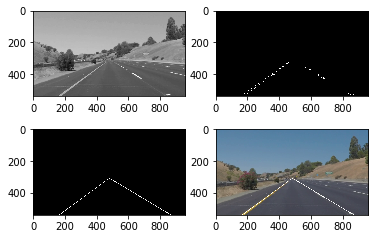

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Pipeline Description

#### Pipeline Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

#### Focus on Step 7 (Drawing lines extrapolated from line segments)
The time I spent the most time on was Step 7, drawing lines extrapolated from line segments. This step required custom code in addition to the helper functions provided.
1. Divide the hough line segments into those with positive slopes (left lane line) and negative slopes (negative lane line). Take only those with length greater than 50 to remove noise.
    * For each Hough line segment (two points), if (1) the slope of the line is positive and (2) if the line segment length is greater than 50 pixels (length chosen by observation), add the slope and intercept to an array `positive_slope_intercept`. I also added the clause that if the array is empty, we should go through the Hough lines again and add at least one pair of points to the array `positive_slope_intercept`. 
    * Do the same for Hough line segments with negative slope.
    * Line segments with positive slope belong to the negative 
2. Fit a line to the points belonging to the left lane line and to the points belonging to the right lane line separately using `find_line_fit`. Get the intercept and coefficient of the fitted lines.
    * If there is only one slope and intercept, return those.
    * Remove noise: remove points with slope not within 1.5 standard deviations of the mean. (1.5 chosen arbitrarily) This may fail if there is only one datapoint (it failed on one frame of the yellow lane line video), which is why I added the clause above.
    * Take the estimate of the slope and intercept to be that of the remaining values.
3. Calculate where the lane lines intersect.
4. Draw the lines from the intersection point to the bottom of the image.


### Shortcomings

* There are a few instances in the yellow lane line video where the lane lines are marked incorrectly. The error is always (to my knowledge) in the lane line that is not solid.
    * I tried adjusting the Hough parameters further but this often resulted in no hough lines being created in at least one frame in the yellow lane line video.
* Image dimensions were hard-coded in at least one case.
* If the lane lines are not straight lines but have high curvature, this algorithm may give weird results.
* The algorithm was trained on a specific type of lane and type of day (daytime, moderately bright with no snow, rain or hail), so it may not generalise well.

### Possible Improvements

* Tune Hough transform parameters more systematically with more test images instead of by 'feel'.
* Currently the lane lines are drawn in solid white. It would be nice if they were drawn in thicker, semi-transparent red (say).

Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.



## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Slope & intercept:  [[0.5766738660907127, 44.695464362851], [0.6, 32.60000000000002], [0.061946902654867256, 618.0176991150443], [0.6993006993006993, -52.72727272727269], [0.5583756345177665, 61.24873096446697], [0.6245487364620939, 2.1660649819494893], [0.12177121771217712, 358.690036900369], [0.6097560975609756, 22.29268292682923], [0.5581395348837209, 61.604651162790674], [0.21818181818181817, 270.8], [0.06060606060606061, 618.1212121212121], [0.36363636363636365, 189.0], [0.03296703296703297, 354.02197802197804], [0.4251497005988024, 158.80838323353294], [0.009708737864077669, 374.1067961165049]]
Slope:  0.3680508268691446 Intercept:  207.5630951453504
Slope & intercept:  [[-0.7247956403269755, 888.841961852861], [-0.6718146718146718, 855.969111969112], [-0.050156739811912224, 448.80250783699057], [-0.2677725118483412, 595.1232227488151], [-0.05521472392638037, 455.2760736196319], [-0.05172413793103448, 698.3448275862069], [-0.6755555555555556, 867.4355555555555], [-0.0593220338983

Moviepy - Building video extra.mp4.


Moviepy - Writing video extra.mp4



t:   0%|                                                                             | 0/251 [00:00<?, ?it/s, now=None]

Slope & intercept:  [[0.5766738660907127, 44.695464362851], [0.6, 32.60000000000002], [0.061946902654867256, 618.0176991150443], [0.6993006993006993, -52.72727272727269], [0.5583756345177665, 61.24873096446697], [0.6245487364620939, 2.1660649819494893], [0.12177121771217712, 358.690036900369], [0.6097560975609756, 22.29268292682923], [0.5581395348837209, 61.604651162790674], [0.21818181818181817, 270.8], [0.06060606060606061, 618.1212121212121], [0.36363636363636365, 189.0], [0.03296703296703297, 354.02197802197804], [0.4251497005988024, 158.80838323353294], [0.009708737864077669, 374.1067961165049]]
Slope:  0.3680508268691446 Intercept:  207.5630951453504
Slope & intercept:  [[-0.7247956403269755, 888.841961852861], [-0.6718146718146718, 855.969111969112], [-0.050156739811912224, 448.80250783699057], [-0.2677725118483412, 595.1232227488151], [-0.05521472392638037, 455.2760736196319], [-0.05172413793103448, 698.3448275862069], [-0.6755555555555556, 867.4355555555555], [-0.0593220338983


t:   1%|▌                                                                    | 2/251 [00:00<00:33,  7.34it/s, now=None]

Slope & intercept:  [[0.6, 31.399999999999977], [0.5511811023622047, 68.80314960629914], [0.03260869565217391, 642.304347826087], [0.576, 44.855999999999995], [0.6243654822335025, 3.2842639593908984], [0.23595505617977527, 263.8426966292135], [0.32653061224489793, 206.20408163265307], [0.5411764705882353, 71.24705882352941], [0.018867924528301886, 370.45283018867923], [0.09090909090909091, 592.1818181818181], [0.3431372549019608, 197.62745098039215], [0.8, -126.20000000000005], [0.5982905982905983, 33.83760683760681], [0.5811965811965812, 38.495726495726444]]
Slope:  0.393862989929794 Intercept:  197.2720793201074
Slope & intercept:  [[-0.6719367588932806, 856.0], [-0.6994535519125683, 878.0491803278688], [-0.06865671641791045, 463.06865671641793], [-0.26785714285714285, 597.9285714285714], [-0.2670299727520436, 595.0762942779292], [-0.0694006309148265, 459.83280757097793], [-0.03067484662576687, 693.239263803681], [-0.26732673267326734, 598.3762376237623], [-0.6956521739130435, 878.39


t:   1%|▊                                                                    | 3/251 [00:00<00:44,  5.63it/s, now=None]

Slope & intercept:  [[0.6326530612244898, -1.7755102040816837], [0.5785123966942148, 41.743801652892614], [0.6018518518518519, 17.611111111111086], [0.061946902654867256, 618.2035398230089], [0.4437869822485207, 183.67455621301775], [0.6244131455399061, 5.877934272300479], [0.5769230769230769, 44.269230769230774], [0.5725806451612904, 41.564516129032256], [0.5434782608695652, 76.304347826087], [0.546875, 75.625], [0.23728813559322035, 267.54237288135596], [0.5756302521008403, 40.07983193277312], [0.10526315789473684, 606.421052631579], [0.7, -55.599999999999966], [0.31666666666666665, 229.95000000000002]]
Slope:  0.4745246356948832 Intercept:  146.09945233588715
Slope & intercept:  [[-0.726027397260274, 889.6438356164383], [-0.2663755458515284, 595.2052401746724], [-0.6739130434782609, 856.8478260869565], [-0.05144694533762058, 449.2861736334405], [-0.0696969696969697, 463.58181818181816], [-0.2678983833718245, 599.2240184757505], [-0.015, 687.0], [-0.2545454545454545, 591.309090909090


t:   2%|█                                                                    | 4/251 [00:00<00:52,  4.68it/s, now=None]

Slope & intercept:  [[0.624, 3.136000000000024], [0.061946902654867256, 618.4513274336283], [0.6024590163934426, 21.61885245901641], [0.11891891891891893, 594.0108108108108], [0.7523809523809524, -90.88571428571424], [0.302158273381295, 238.30935251798562], [0.32673267326732675, 206.73267326732673], [0.2857142857142857, 245.14285714285714]]
Slope:  0.331704295761448 Intercept:  275.34312480451786
Slope & intercept:  [[-0.6507352941176471, 847.0882352941177], [-0.2692307692307692, 597.4230769230769], [-0.050445103857566766, 452.8486646884273], [-0.6994818652849741, 880.1554404145078], [-0.05089820359281437, 451.10179640718565], [-0.27099236641221375, 601.2824427480916], [-0.03260869565217391, 693.2717391304348], [-0.2662337662337662, 595.6428571428571], [-0.6923076923076923, 864.4615384615385], [-0.7441860465116279, 896.3023255813953], [-0.05333333333333334, 456.05333333333334], [-0.032467532467532464, 688.0324675324675], [-0.27099236641221375, 600.4961832061069], [-0.05228758169934641,


t:   2%|█▎                                                                   | 5/251 [00:01<00:56,  4.32it/s, now=None]

Slope & intercept:  [[0.030612244897959183, 644.3061224489796], [0.6, 23.400000000000034], [0.12234042553191489, 591.436170212766], [0.7520661157024794, -92.17355371900828], [0.30392156862745096, 222.08823529411765], [0.11822660098522167, 593.2906403940887], [0.3235294117647059, 211.67647058823528], [0.06896551724137931, 337.2413793103448], [0.0784313725490196, 667.3333333333334], [0.6, 29.200000000000045], [0.6014234875444839, 20.4875444839858], [0.04794520547945205, 631.2739726027397], [0.5538461538461539, 65.23076923076923], [0.22535211267605634, 274.53521126760563]]
Slope:  0.28266108470336904 Intercept:  331.65383455130507
Slope & intercept:  [[-0.7005208333333334, 881.1458333333334], [-0.648910411622276, 849.1743341404358], [-0.2683982683982684, 596.8268398268399], [-0.0712166172106825, 462.28783382789317], [-0.06896551724137931, 464.2758620689655], [-0.2698961937716263, 600.598615916955], [-0.03125, 693.46875], [-0.03424657534246575, 688.8219178082192], [-0.6989247311827957, 881


t:   2%|█▋                                                                   | 6/251 [00:01<01:04,  3.82it/s, now=None]

Slope & intercept:  [[0.047872340425531915, 631.5212765957447], [0.6494252873563219, -15.919540229885058], [0.0392156862745098, 638.8627450980392], [0.0970873786407767, 615.0388349514564], [0.03225806451612903, 643.5483870967741], [0.36328125, 191.53125], [0.576036866359447, 43.28110599078343], [0.171875, 303.875], [0.6287128712871287, 2.02475247524751], [0.5961538461538461, 34.576923076923094], [0.3050847457627119, 219.6271186440678], [0.34523809523809523, 200.73809523809524]]
Slope:  0.32102011933454155 Intercept:  292.3921624114372
Slope & intercept:  [[-0.6728624535315985, 859.9442379182155], [-0.7007874015748031, 883.3228346456692], [-0.2857142857142857, 604.5714285714286], [-0.07183908045977011, 466.132183908046], [-0.26851851851851855, 602.5092592592592], [-0.0688622754491018, 460.5868263473054], [-0.03211009174311927, 689.256880733945], [-0.03468208092485549, 694.9768786127167], [-0.24870466321243523, 586.880829015544], [-0.6509433962264151, 850.877358490566], [-0.0690690690690


t:   3%|█▉                                                                   | 7/251 [00:01<01:05,  3.71it/s, now=None]

Slope & intercept:  [[0.672514619883041, -30.94736842105266], [0.030303030303030304, 645.030303030303], [0.625, 2.0], [0.013422818791946308, 662.7852348993289], [0.10256410256410256, 606.5641025641025], [0.6244343891402715, 4.733031674208121], [0.10185185185185185, 612.6203703703704], [0.10396039603960396, 606.5445544554456], [0.10714285714285714, 661.7857142857143], [0.1875, 296.875], [0.25, 259.0], [0.22727272727272727, 276.5], [0.3391304347826087, 203.80869565217392]]
Slope:  0.14631482187487282 Intercept:  483.15139752574385
Slope & intercept:  [[-0.672463768115942, 861.1710144927536], [-0.6997389033942559, 883.7258485639687], [-0.0705521472392638, 462.07055214723925], [-0.06936416184971098, 464.40462427745666], [-0.04838709677419355, 696.983870967742], [-0.27074235807860264, 602.4192139737992], [-0.2692307692307692, 599.1153846153846], [-0.2831050228310502, 603.6666666666666], [-0.06578947368421052, 704.1447368421053], [-0.7010869565217391, 883.2228260869565], [-0.0653266331658291


t:   3%|██▏                                                                  | 8/251 [00:02<01:08,  3.55it/s, now=None]

Slope & intercept:  [[0.6483050847457628, -10.728813559322077], [0.6271186440677966, 0.7627118644068105], [0.061946902654867256, 618.141592920354], [0.6244725738396625, 1.4641350210970359], [0.01951219512195122, 653.9463414634147], [0.08461538461538462, 623.4461538461538], [0.21052631578947367, 280.6842105263158], [0.3238095238095238, 212.82857142857142], [0.016666666666666666, 678.8833333333333], [0.38461538461538464, 181.3076923076923], [0.3055555555555556, 221.30555555555554], [0.024390243902439025, 354.8292682926829]]
Slope:  0.24392994460351866 Intercept:  347.96359695996165
Slope & intercept:  [[-0.07207207207207207, 462.56756756756755], [-0.7255434782608695, 894.8586956521739], [-0.036458333333333336, 694.0572916666666], [-0.069164265129683, 464.3400576368876], [-0.2733812949640288, 599.6402877697842], [-0.6741854636591479, 861.6365914786968], [-0.7255434782608695, 896.5842391304348], [-0.28665207877461707, 607.6236323851203], [-0.06666666666666667, 704.5333333333333], [-0.24890


t:   4%|██▍                                                                  | 9/251 [00:02<01:10,  3.45it/s, now=None]

Slope & intercept:  [[0.6007326007326007, 21.934065934065927], [0.6496062992125984, -12.397637795275557], [0.07777777777777778, 603.5111111111111], [0.3063063063063063, 221.76576576576576], [0.34710743801652894, 201.0], [0.3416666666666667, 202.95], [0.6035714285714285, 18.75], [0.23636363636363636, 273.6181818181818]]
Slope:  0.39539151920594295 Intercept:  191.39143585423113
Slope & intercept:  [[-0.7255434782608695, 895.8586956521739], [-0.6982758620689655, 872.8362068965517], [-0.2854122621564482, 606.9408033826638], [-0.06948640483383686, 460.7915407854985], [-0.06936416184971098, 464.40462427745666], [-0.28125, 602.90625], [-0.7263157894736842, 894.6421052631579], [-0.2828282828282828, 602.4141414141415], [-0.03468208092485549, 694.0115606936416], [-0.031446540880503145, 687.4025157232704], [-0.5089285714285714, 767.5625], [-0.2857142857142857, 608.1428571428571], [-0.7272727272727273, 895.9090909090909], [-0.6891891891891891, 868.7027027027027], [-0.06993006993006994, 459.636363


t:   4%|██▋                                                                 | 10/251 [00:02<01:09,  3.47it/s, now=None]

Slope & intercept:  [[0.6197183098591549, 4.507042253521149], [0.034482758620689655, 642.0], [0.6271186440677966, 9.067796610169523], [0.6486486486486487, -11.135135135135158], [0.6719367588932806, -35.26086956521738], [0.64, -13.080000000000041], [0.6722689075630253, -33.10924369747903], [0.03409090909090909, 641.0681818181819], [0.5555555555555556, 61.77777777777777], [0.32432432432432434, 212.13513513513513], [0.5548780487804879, 61.42073170731703], [0.6490566037735849, -12.569811320754695]]
Slope:  0.5026732890981215 Intercept:  127.23513379862635
Slope & intercept:  [[-0.6972477064220184, 872.954128440367], [-0.7507507507507507, 908.2372372372372], [-0.0670926517571885, 463.80511182108626], [-0.07119741100323625, 462.28155339805824], [-0.28270042194092826, 603.3502109704641], [-0.2857142857142857, 608.2857142857143], [-0.6991643454038997, 875.058495821727], [-0.037037037037037035, 690.5555555555555], [-0.7517241379310344, 909.3448275862069], [-0.01652892561983471, 688.537190082644


t:   4%|██▉                                                                 | 11/251 [00:02<01:10,  3.41it/s, now=None]

Slope & intercept:  [[0.6233480176211453, 10.017621145374449], [0.6, 21.400000000000034], [0.03333333333333333, 642.5666666666667], [0.034482758620689655, 643.1379310344828], [0.5788043478260869, 43.14130434782612], [0.031578947368421054, 645.0105263157894], [0.029850746268656716, 672.6119402985074], [0.5573770491803278, 61.00000000000006], [0.6178861788617886, 6.495934959349597], [0.1206896551724138, 593.1724137931035], [0.2716049382716049, 257.0], [0.5788113695090439, 41.031007751938034], [0.3247863247863248, 212.5042735042735], [0.6038961038961039, 29.415584415584362], [0.34710743801652894, 201.30578512396693], [0.019230769230769232, 417.7692307692308], [0.06993006993006994, 388.2167832167832], [0.15841584158415842, 554.940594059406], [0.32075471698113206, 234.8490566037736]]
Slope:  0.3116783477083473 Intercept:  298.7150870529503
Slope & intercept:  [[-0.6997319034852547, 876.0268096514745], [-0.28633405639913234, 609.2624728850326], [-0.7272727272727273, 897.7272727272727], [-0.0


t:   5%|███▎                                                                | 12/251 [00:03<01:09,  3.45it/s, now=None]

Slope & intercept:  [[0.6247191011235955, 7.550561797752778], [0.5991379310344828, 22.538793103448256], [0.013605442176870748, 662.6190476190476], [0.5978260869565217, 19.989130434782624], [0.6, 20.400000000000034], [0.10309278350515463, 606.2268041237113], [0.3275862068965517, 210.13793103448276], [0.06060606060606061, 618.1818181818181], [0.22448979591836735, 277.0612244897959], [0.16981132075471697, 305.37735849056605], [0.6326530612244898, -0.9183673469387941], [0.6252821670428894, 8.198645598194105], [0.06572769953051644, 640.0516431924882]]
Slope:  0.3572721274438629 Intercept:  261.33958390147296
Slope & intercept:  [[-0.7002652519893899, 876.8726790450928], [-0.7528735632183908, 909.1091954022988], [-0.2870159453302961, 605.4031890660592], [-0.07, 461.31], [-0.06875, 464.20625], [-0.6496062992125984, 853.3897637795276], [-0.28798185941043086, 609.4761904761905], [-0.0410958904109589, 695.3287671232877], [-0.08148148148148149, 712.3703703703703], [-0.6493506493506493, 856.363636


t:   5%|███▌                                                                | 13/251 [00:03<01:10,  3.40it/s, now=None]

Slope & intercept:  [[0.625, 6.125], [0.5974025974025974, 23.233766233766232], [0.57, 48.1400000000001], [0.20212765957446807, 287.9255319148936], [0.06140350877192982, 619.5701754385965], [0.5986622073578596, 23.25083612040129], [0.049019607843137254, 659.4607843137255], [0.2677165354330709, 257.17322834645665], [0.6013513513513513, 25.75], [0.061946902654867256, 618.0796460176991], [0.2, 293.8], [0.052083333333333336, 657.3020833333334], [0.0703125, 636.171875], [0.30434782608695654, 223.86956521739128], [0.2671232876712329, 262.4657534246575], [0.575, 45.47500000000002]]
Slope:  0.3189685823425502 Intercept:  292.98707783505756
Slope & intercept:  [[-0.05202312138728324, 455.0635838150289], [-0.7521613832853026, 909.400576368876], [-0.30412371134020616, 614.7268041237113], [-0.6993243243243243, 875.9155405405405], [-0.05228758169934641, 450.4640522875817], [-0.699468085106383, 874.5558510638298], [-0.019138755980861243, 687.7894736842105], [-0.05263157894736842, 455.6842105263158], 


t:   6%|███▊                                                                | 14/251 [00:03<01:15,  3.15it/s, now=None]

Slope & intercept:  [[0.5752212389380531, 44.70796460176996], [0.6226415094339622, 6.660377358490564], [0.04678362573099415, 632.0701754385965], [0.5981308411214953, 27.971962616822452], [0.5770925110132159, 39.6255506607929], [0.5555555555555556, 62.888888888888914], [0.06140350877192982, 618.0350877192982], [0.1728395061728395, 304.641975308642], [0.6595744680851063, -26.808510638297832], [0.445, 180.77], [0.6304347826086957, 0.10869565217387844], [0.3178294573643411, 219.5736434108527], [0.6129032258064516, 8.129032258064512], [0.5688073394495413, 50.01834862385317], [0.12, 659.0]]
Slope:  0.4376145046701454 Intercept:  188.49287945999652
Slope & intercept:  [[-0.7536231884057971, 909.3478260869565], [-0.699724517906336, 874.625344352617], [-0.2857142857142857, 607.0], [-0.05084745762711865, 449.54237288135596], [-0.28654970760233917, 603.3684210526316], [-0.03164556962025317, 693.6582278481013], [-0.0738255033557047, 464.9530201342282], [-0.05217391304347826, 454.2173913043478], [-


t:   6%|████                                                                | 15/251 [00:04<01:15,  3.14it/s, now=None]

Slope & intercept:  [[0.5763358778625954, 40.587786259541986], [0.0297029702970297, 644.9207920792079], [0.6086956521739131, 20.217391304347757], [0.5487804878048781, 70.34146341463406], [0.5770750988142292, 44.40711462450594], [0.3472222222222222, 204.09722222222223], [0.5791505791505791, 40.87644787644791], [0.30952380952380953, 222.52380952380952], [0.32575757575757575, 214.5], [0.049723756906077346, 661.6077348066299], [0.01680672268907563, 678.8739495798319], [0.061224489795918366, 647.9387755102041], [0.09009009009009009, 618.2342342342342], [0.5512820512820513, 69.24358974358972], [0.03271028037383177, 663.0654205607476]]
Slope:  0.3136054443162584 Intercept:  322.762382115997
Slope & intercept:  [[-0.7529761904761905, 908.3869047619048], [-0.699724517906336, 873.9256198347107], [-0.30434782608695654, 612.0434782608696], [-0.06918238993710692, 462.62264150943395], [-0.2679738562091503, 599.0784313725491], [-0.05102040816326531, 449.90816326530614], [-0.05014749262536873, 697.233


t:   6%|████▎                                                               | 16/251 [00:04<01:14,  3.17it/s, now=None]

Slope & intercept:  [[0.04678362573099415, 631.5555555555555], [0.703125, -53.5], [0.509090909090909, 93.80000000000001], [0.12315270935960591, 590.8916256157636], [0.6210045662100456, 5.305936073059399], [0.6715686274509803, -34.66666666666663], [0.21428571428571427, 279.7142857142857], [0.11855670103092783, 594.1907216494845], [0.5774647887323944, 122.19718309859155]]
Slope:  0.3983369602101746 Intercept:  247.72096011556374
Slope & intercept:  [[-0.7514792899408284, 908.189349112426], [-0.033707865168539325, 693.7191011235955], [-0.7015706806282722, 874.6910994764398], [-0.05, 452.55], [-0.05084745762711865, 449.03389830508473], [-0.7058823529411765, 878.5294117647059], [-0.30113636363636365, 611.6022727272727], [-0.7032258064516129, 877.3870967741935], [-0.268, 595.956], [-0.06060606060606061, 459.8787878787879], [-0.2864721485411141, 607.1538461538462], [-0.6590909090909091, 853.4545454545455], [-0.6502242152466368, 852.3991031390135], [-0.023529411764705882, 682.5411764705882], [


t:   7%|████▌                                                               | 17/251 [00:04<01:15,  3.12it/s, now=None]

Slope & intercept:  [[0.5882352941176471, 38.882352941176464], [0.6496062992125984, -16.9881889763779], [0.6712328767123288, -29.383561643835606], [0.30708661417322836, 223.28346456692913], [0.5993265993265994, 23.023569023568996], [0.3493150684931507, 201.9041095890411], [0.030927835051546393, 402.4639175257732], [0.3235294117647059, 215.47058823529412], [0.0625, 617.0], [0.10426540284360189, 604.7725118483412]]
Slope:  0.36860254016954064 Intercept:  228.04287631099106
Slope & intercept:  [[-0.7027027027027027, 875.1621621621622], [-0.751412429378531, 908.4237288135594], [-0.2872340425531915, 606.5851063829788], [-0.28378378378378377, 600.7432432432432], [-0.07046979865771812, 459.255033557047], [-0.01694915254237288, 687.4915254237288], [-0.0688622754491018, 461.5179640718563], [-0.6767676767676768, 867.4040404040404], [-0.6485148514851485, 855.8564356435644], [-0.043478260869565216, 695.0869565217391], [-0.015037593984962405, 690.5112781954887], [-0.27927927927927926, 599.693693693


t:   7%|████▉                                                               | 18/251 [00:05<01:14,  3.11it/s, now=None]

Slope & intercept:  [[0.5738396624472574, 44.1223628691983], [0.04678362573099415, 631.3216374269006], [0.5737704918032787, 51.29508196721315], [0.5777777777777777, 47.28888888888895], [0.2357142857142857, 272.75714285714287], [0.11904761904761904, 594.2619047619048], [0.56, 56.639999999999986], [0.4228855721393035, 191.34825870646765], [0.3619631901840491, 198.69938650306747], [0.42424242424242425, 193.0909090909091], [0.3464052287581699, 206.66013071895426], [0.028985507246376812, 421.2028985507246], [0.574468085106383, 48.893617021276555], [0.3262411347517731, 215.84397163120565]]
Slope:  0.3694374717821209 Intercept:  226.67329935670384
Slope & intercept:  [[-0.752906976744186, 909.8720930232558], [-0.7232142857142857, 884.7321428571429], [-0.06997084548104957, 462.81049562682216], [-0.27149321266968324, 597.4434389140272], [-0.2796610169491525, 601.6949152542372], [-0.0513595166163142, 450.25679758308155], [-0.03468208092485549, 693.2890173410404], [-0.2727272727272727, 601.090909


t:   8%|█████▏                                                              | 19/251 [00:05<01:17,  2.98it/s, now=None]

Slope & intercept:  [[0.5961538461538461, 33.86538461538464], [0.6030150753768844, 20.613065326633205], [0.5791505791505791, 42.088803088803104], [0.03409090909090909, 641.7272727272727], [0.3263888888888889, 216.40972222222223], [0.6037735849056604, 26.792452830188722], [0.01773049645390071, 412.0851063829787], [0.10328638497652583, 609.4084507042253], [0.017094017094017096, 678.4700854700855], [0.34285714285714286, 207.37142857142857], [0.1523809523809524, 560.3523809523809], [0.03669724770642202, 640.3761467889908], [0.226890756302521, 280.0924369747899], [0.6470588235294118, -14.235294117647072], [0.248, 269.448], [0.21052631578947367, 285.42105263157896]]
Slope:  0.27320241314184823 Intercept:  328.3014526191309
Slope & intercept:  [[-0.7243243243243244, 883.9135135135135], [-0.7529761904761905, 909.139880952381], [-0.06725146198830409, 461.8567251461988], [-0.2682119205298013, 596.0033112582781], [-0.2687224669603524, 598.8502202643172], [-0.25280898876404495, 593.5955056179776],


t:   8%|█████▍                                                              | 20/251 [00:05<01:21,  2.85it/s, now=None]

Slope & intercept:  [[0.034722222222222224, 641.8888888888889], [0.6028368794326241, 22.297872340425556], [0.6989247311827957, -52.666666666666686], [0.11904761904761904, 594.2619047619048], [0.6460905349794238, -7.744855967078138], [0.32432432432432434, 220.27027027027026], [0.21359223300970873, 282.8349514563107], [0.26506024096385544, 245.5180722891566], [0.3630952380952381, 200.3154761904762], [0.35064935064935066, 206.57142857142856], [0.29838709677419356, 230.05645161290323], [0.6966292134831461, -49.43820224719104]]
Slope:  0.38444664034704185 Intercept:  211.18046595840244
Slope & intercept:  [[-0.75177304964539, 908.9078014184397], [-0.7007874015748031, 874.9133858267717], [-0.06976744186046512, 463.6046511627907], [-0.2719298245614035, 597.8333333333334], [-0.049689440993788817, 449.7453416149068], [-0.7528409090909091, 908.3465909090909], [-0.03409090909090909, 693.8068181818181], [-0.2755102040816326, 603.1326530612245], [-0.2857142857142857, 606.1428571428571], [-0.0348837


t:   8%|█████▋                                                              | 21/251 [00:06<01:17,  2.98it/s, now=None]

Slope & intercept:  [[0.578544061302682, 42.78927203065132], [0.061946902654867256, 617.7699115044247], [0.6739130434782609, -34.19565217391306], [0.6741071428571429, -32.303571428571445], [0.32167832167832167, 220.13986013986016], [0.4430379746835443, 170.32911392405066], [0.3443708609271523, 209.9205298013245], [0.6209677419354839, 14.129032258064512], [0.2441860465116279, 264.66279069767444], [0.2654320987654321, 264.9074074074074], [0.25, 270.25], [0.21212121212121213, 286.4848484848485]]
Slope:  0.39085878390964396 Intercept:  191.24029522048514
Slope & intercept:  [[-0.7528089887640449, 909.3370786516854], [-0.7244094488188977, 883.488188976378], [-0.05475504322766571, 455.9596541786743], [-0.28402366863905326, 606.4437869822485], [-0.28363636363636363, 602.3854545454545], [-0.6752577319587629, 861.319587628866], [-0.03571428571428571, 690.3214285714286], [-0.05517241379310345, 454.0206896551724], [-0.04953560371517028, 449.74303405572755], [-0.06557377049180328, 706.344262295082


t:   9%|█████▉                                                              | 22/251 [00:06<01:13,  3.10it/s, now=None]

Slope & intercept:  [[0.017857142857142856, 653.4107142857143], [0.5749235474006116, 45.547400611620844], [0.6209150326797386, 13.823529411764696], [0.03225806451612903, 641.6774193548387], [0.6488294314381271, -13.899665551839462], [0.20618556701030927, 290.41237113402065], [0.12135922330097088, 354.74271844660194], [0.11956521739130435, 358.0326086956522], [0.6761904761904762, -36.866666666666674], [0.2872340425531915, 256.17021276595744], [0.6260869565217392, 8.10434782608695], [0.036036036036036036, 673.4054054054054], [0.4864864864864865, 169.56756756756755], [0.2621359223300971, 248.6504854368932]]
Slope:  0.3368616533365972 Intercept:  261.62703205168697
Slope & intercept:  [[-0.7007874015748031, 873.2125984251968], [-0.032432432432432434, 686.8864864864864], [-0.7535410764872521, 908.3087818696883], [-0.08396946564885496, 468.6564885496183], [-0.2727272727272727, 598.0], [-0.27040816326530615, 601.3520408163265], [-0.03571428571428571, 443.9642857142857], [-0.018292682926829267


t:   9%|██████▏                                                             | 23/251 [00:06<01:13,  3.09it/s, now=None]

Slope & intercept:  [[0.6021505376344086, 32.16129032258061], [0.5990566037735849, 34.21226415094338], [0.6004056795131846, 24.559837728194736], [0.04678362573099415, 631.8362573099415], [0.5761078998073218, 45.8901734104046], [0.19090909090909092, 298.46363636363634], [0.6473214285714286, -12.933035714285722], [0.3087248322147651, 230.63087248322148], [1.6538461538461537, -572.3846153846154], [0.13875598086124402, 346.23444976076553], [0.07017543859649122, 611.0877192982456], [0.10294117647058823, 605.8382352941177], [0.575, 57.30000000000007], [0.44954128440366975, 183.20183486238528], [0.5522388059701493, 70.28358208955223], [0.3, 252.20000000000002], [0.19469026548672566, 295.07964601769913]]
Slope:  0.3721751656214779 Intercept:  231.62792271108765
Slope & intercept:  [[-0.752112676056338, 908.8816901408451], [-0.7, 873.7], [-0.06936416184971098, 463.47398843930637], [-0.2619047619047619, 595.7857142857143], [-0.268361581920904, 596.1920903954802], [-0.05172413793103448, 697.56896


t:  10%|██████▌                                                             | 24/251 [00:07<01:17,  2.94it/s, now=None]

Slope & intercept:  [[0.5768463073852296, 45.66067864271457], [0.6730038022813688, -32.56653992395434], [0.6234567901234568, 9.901234567901213], [0.6484560570071259, -13.605700712589112], [0.03333333333333333, 641.7333333333333], [0.6762589928057554, -36.79856115107913], [0.6206896551724138, 15.586206896551687], [0.5759162303664922, 46.09947643979058], [0.19047619047619047, 299.9047619047619], [0.6715867158671587, -32.977859778597804], [0.19130434782608696, 297.61739130434785], [0.30656934306569344, 227.35036496350364], [0.2641509433962264, 248.52830188679246]]
Slope:  0.4655422083928102 Intercept:  132.03331449026743
Slope & intercept:  [[-0.751412429378531, 907.1694915254237], [-0.6981627296587927, 873.2020997375328], [-0.0513595166163142, 454.10271903323263], [-0.2830188679245283, 601.5471698113207], [-0.052307692307692305, 450.99384615384616], [-0.050314465408805034, 697.433962264151], [-0.01639344262295082, 687.344262295082], [-0.2711864406779661, 602.2372881355932], [-0.211764705


t:  10%|██████▊                                                             | 25/251 [00:07<01:17,  2.93it/s, now=None]

Slope & intercept:  [[0.6234567901234568, 10.395061728395092], [0.5909090909090909, 30.909090909090878], [0.012658227848101266, 663.4430379746835], [0.6007905138339921, 24.14624505928856], [0.6290322580645161, -3.7096774193548185], [0.5757575757575758, 47.818181818181756], [0.6687898089171974, -29.420382165605076], [0.6040268456375839, 29.48322147651004], [0.20754716981132076, 288.66037735849056], [0.6033057851239669, 17.537190082644656], [0.037383177570093455, 406.2897196261682], [0.08064516129032258, 371.5967741935484], [0.2653061224489796, 256.1836734693877], [0.08080808080808081, 628.7171717171717], [0.5569620253164557, 65.0632911392405], [0.06349206349206349, 615.2380952380952], [inf, -inf], [0.013888888888888888, 419.7916666666667], [0.5333333333333333, 87.93333333333334], [0.19008264462809918, 297.5123966942149], [0.26666666666666666, 265.6]]
Slope:  inf Intercept:  -inf
Slope & intercept:  [[-0.7007874015748031, 873.9133858267717], [-0.05202312138728324, 454.11560693641616], [-

ValueError: cannot convert float NaN to integer

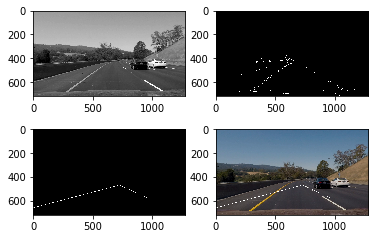

In [23]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))